# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


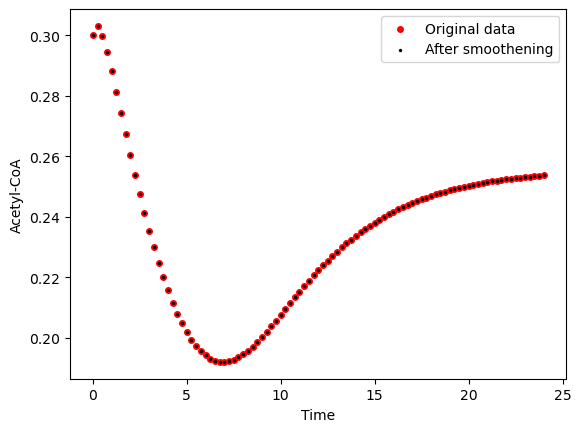

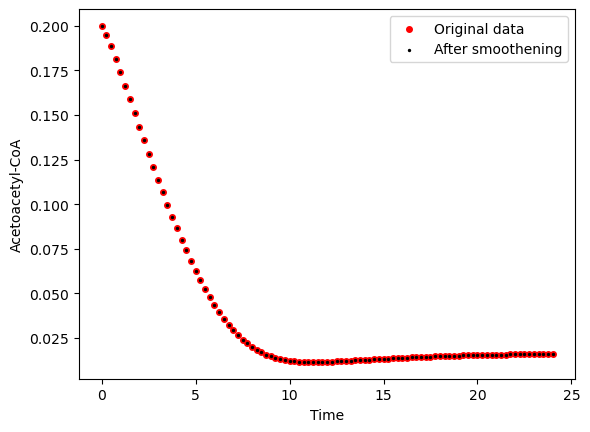

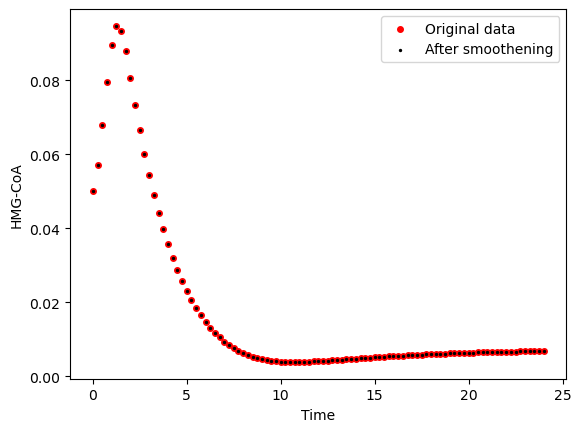

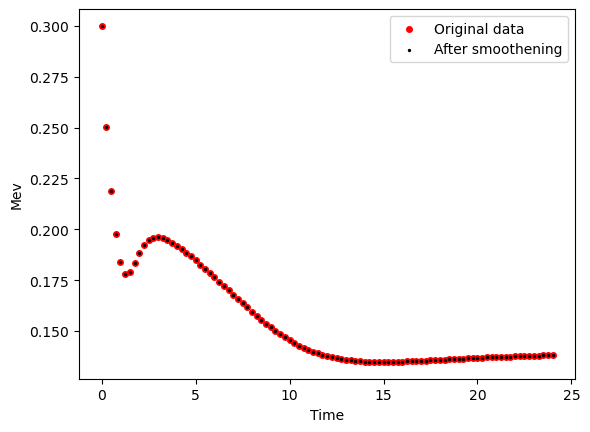

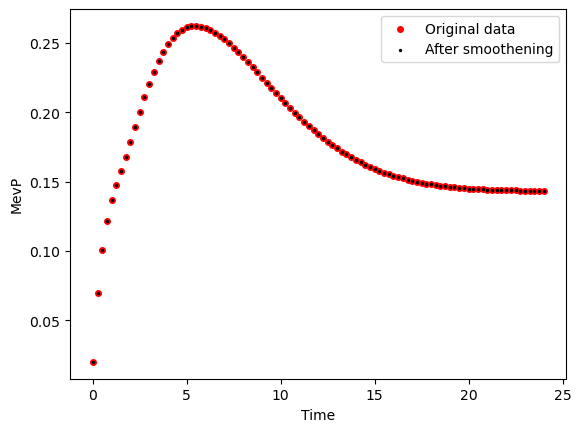

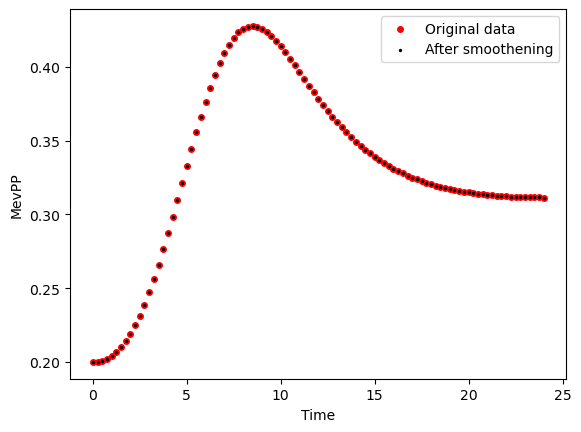

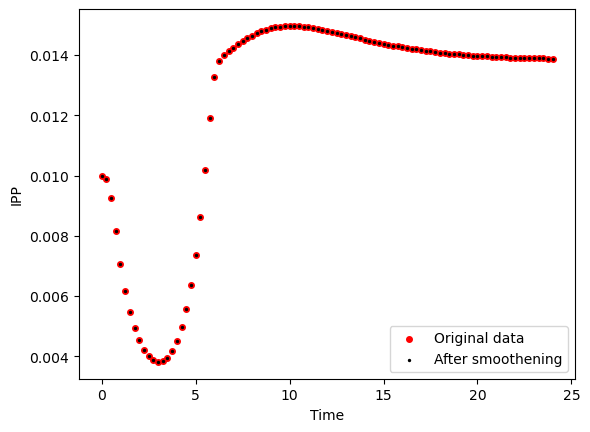

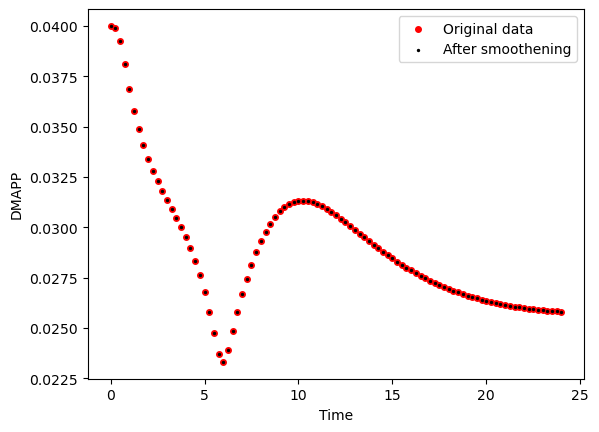

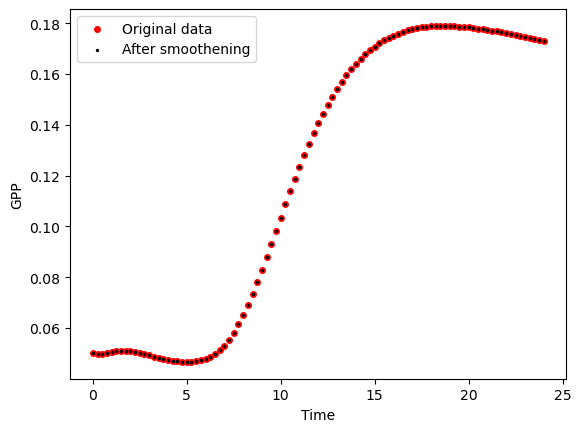

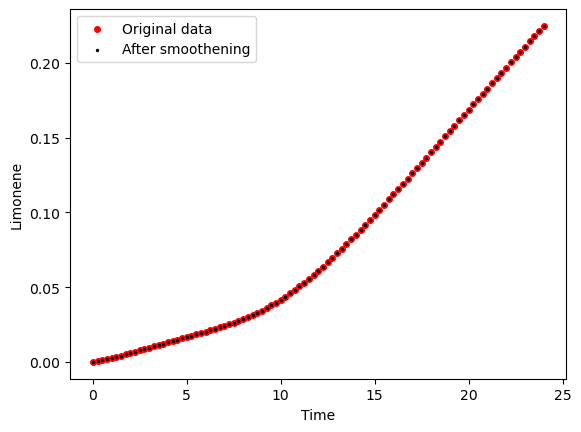

Strain Strain 2


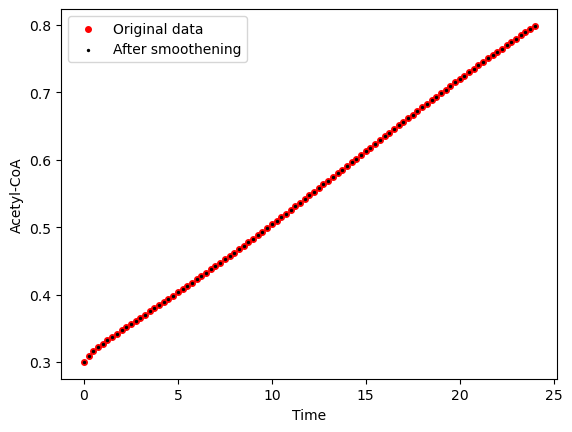

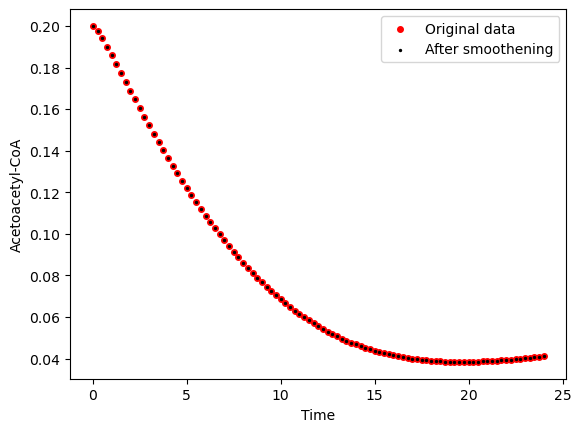

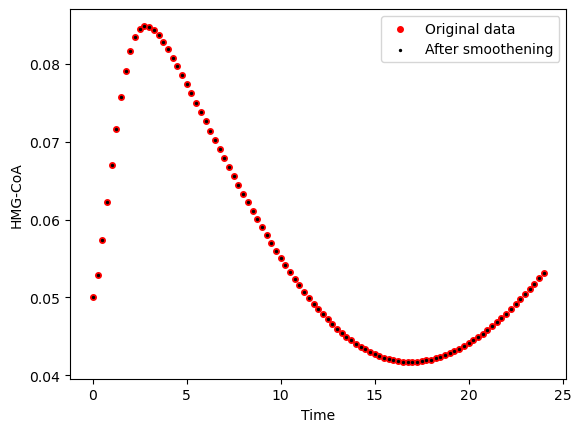

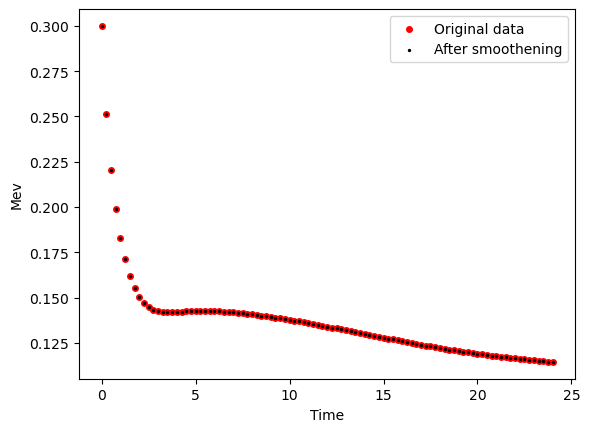

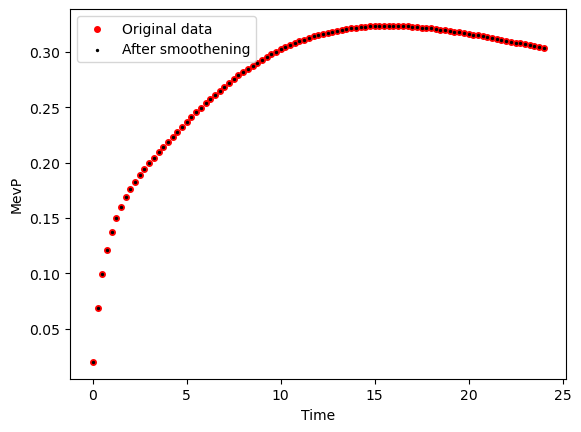

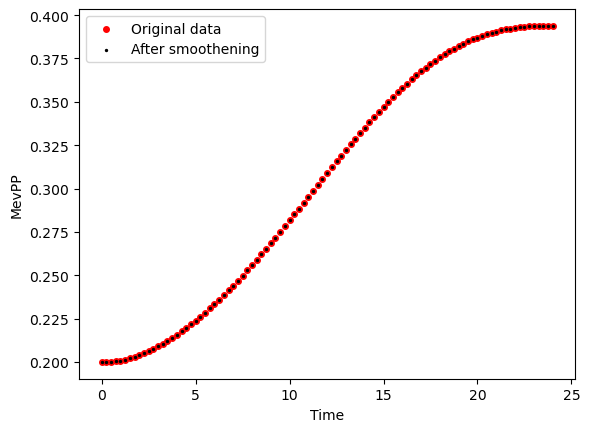

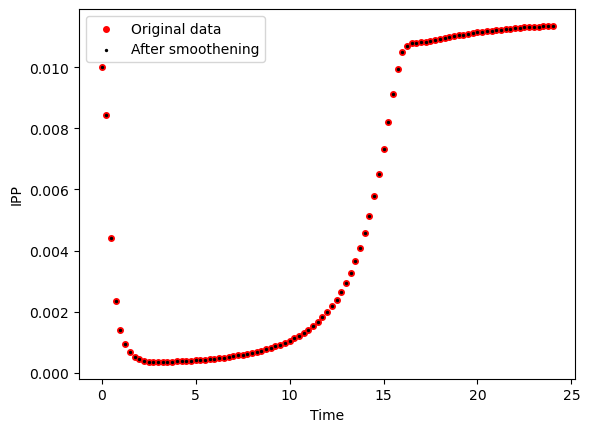

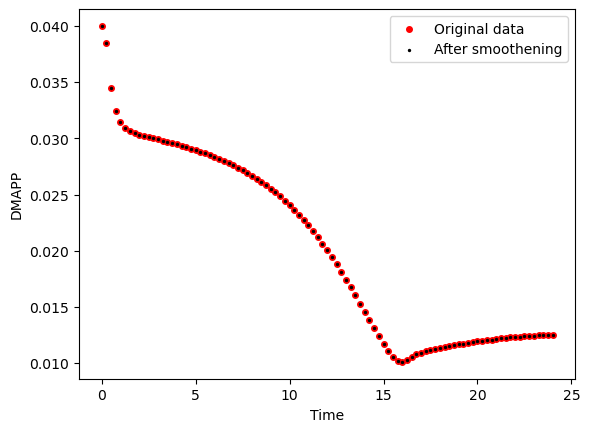

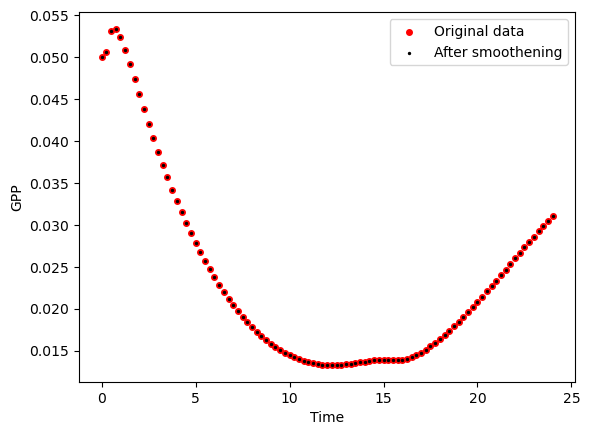

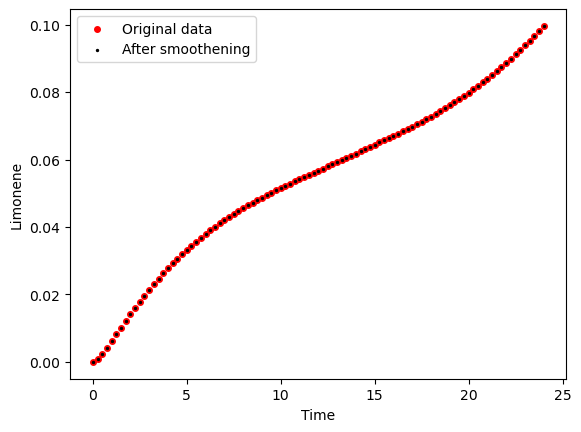

Strain Strain 3


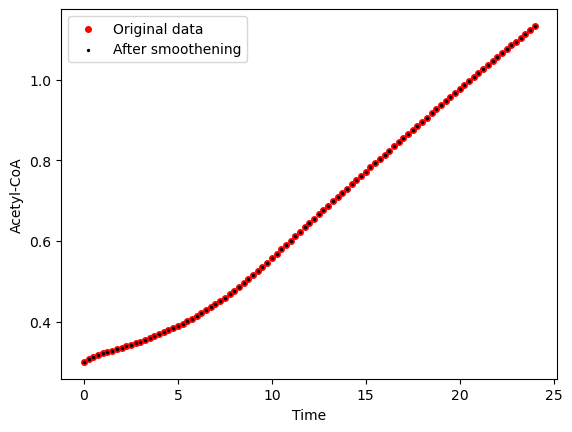

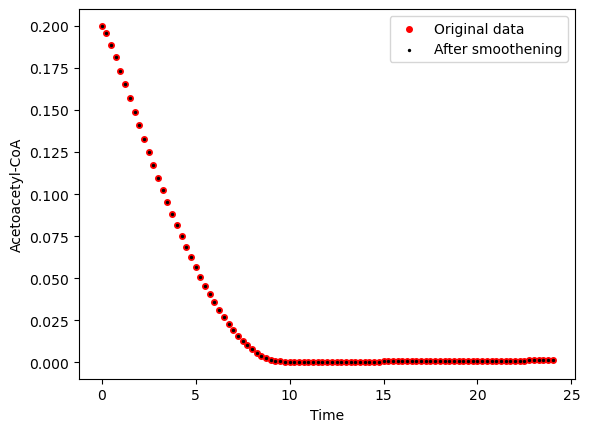

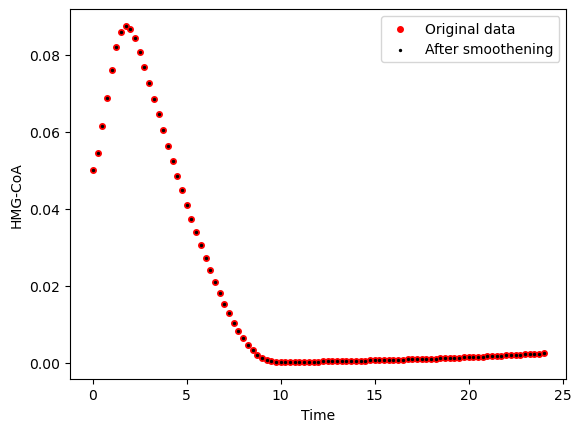

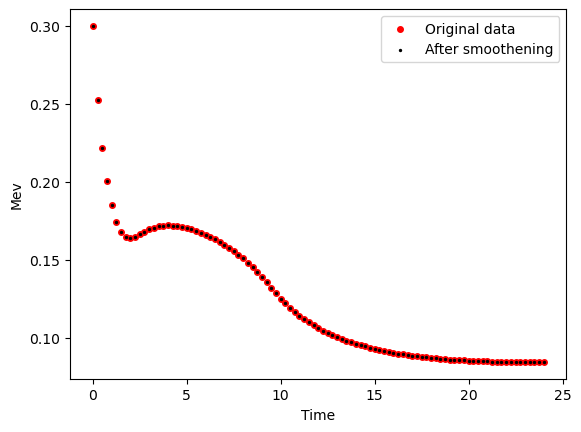

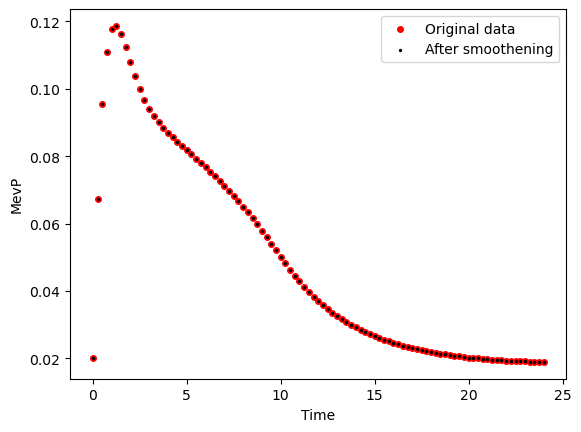

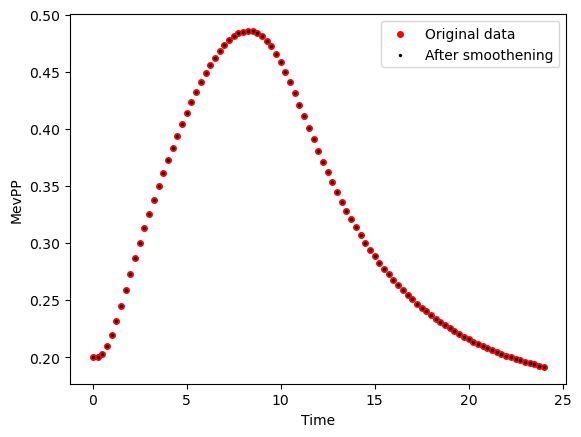

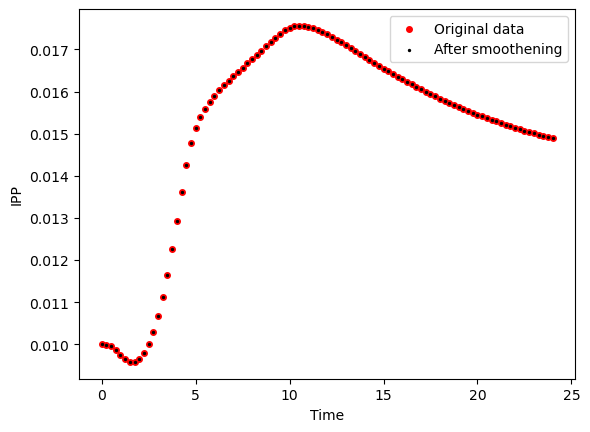

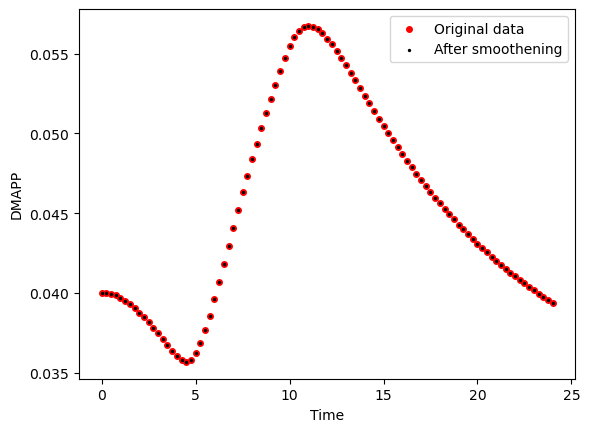

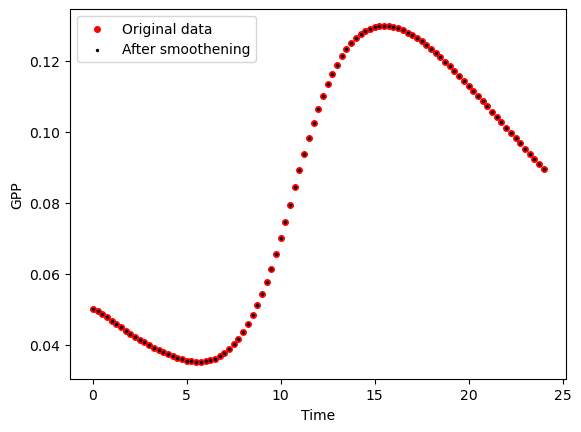

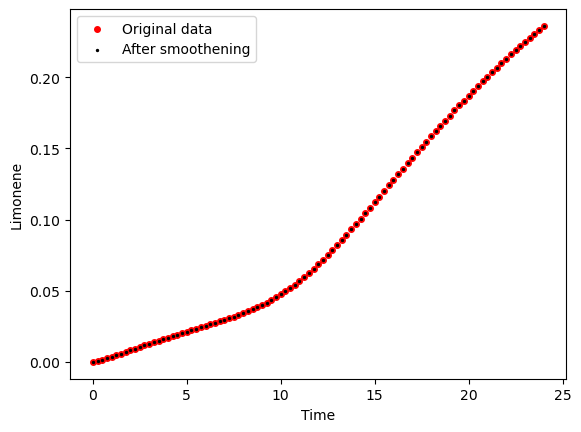

Strain WT


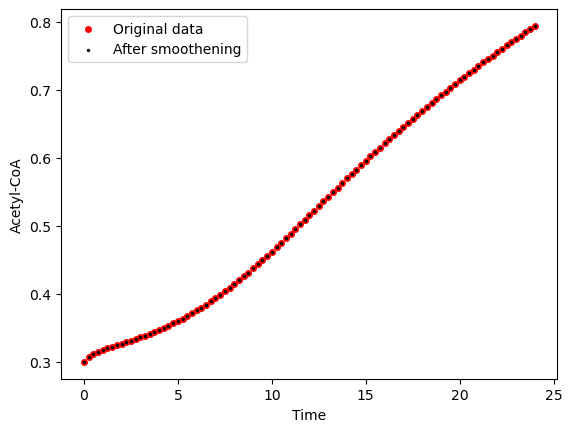

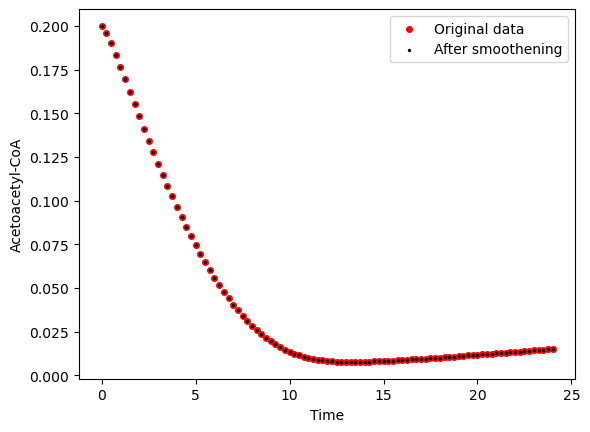

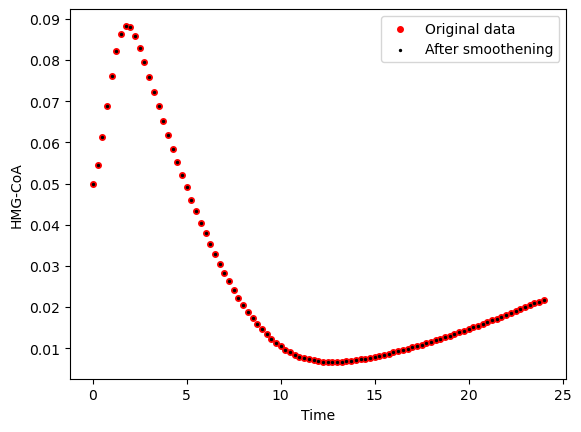

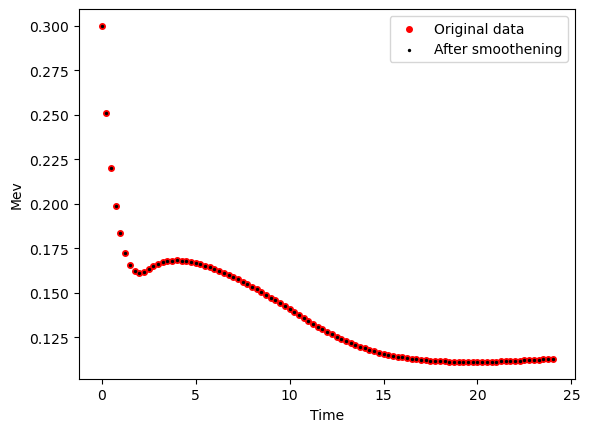

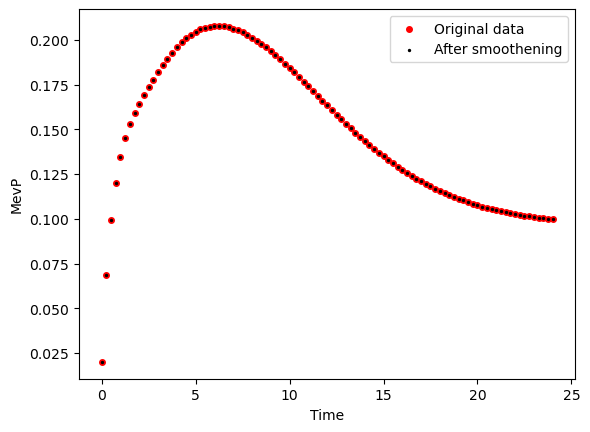

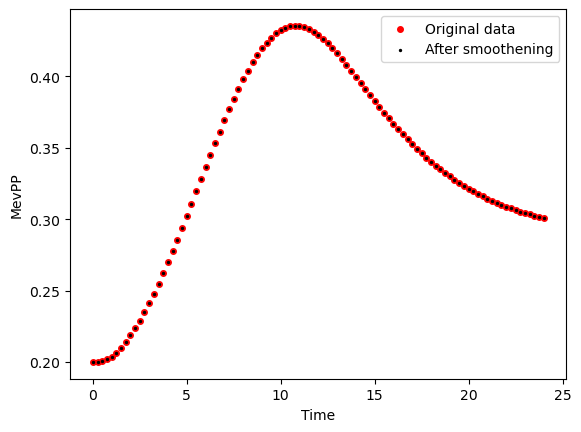

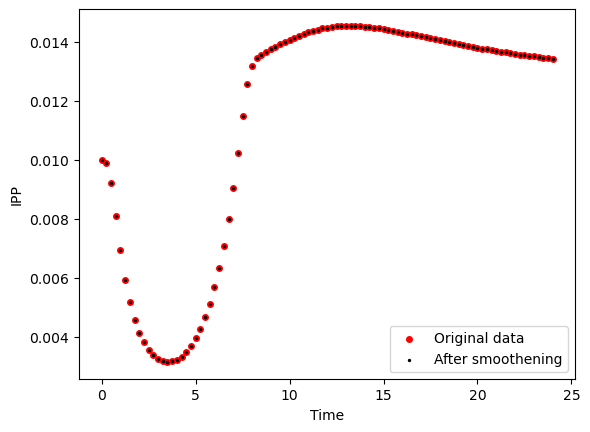

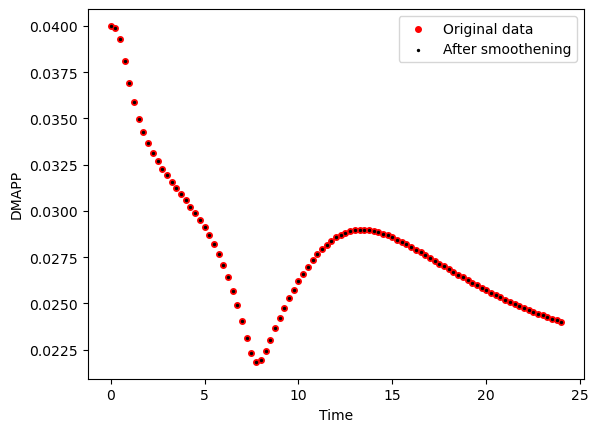

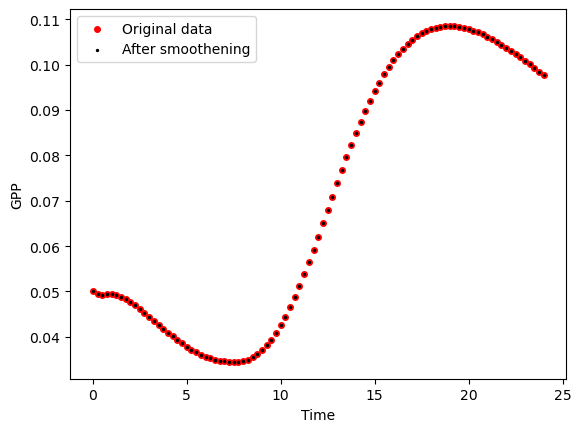

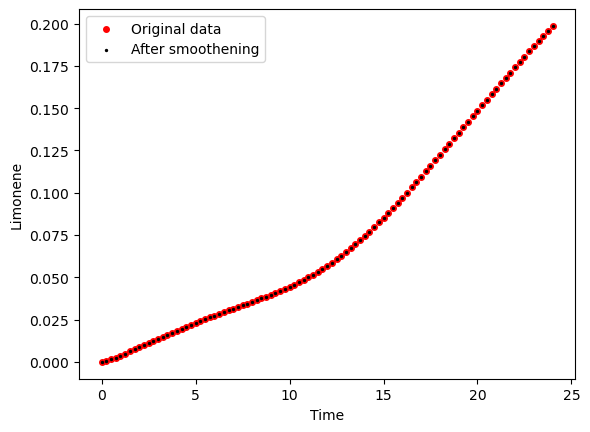

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


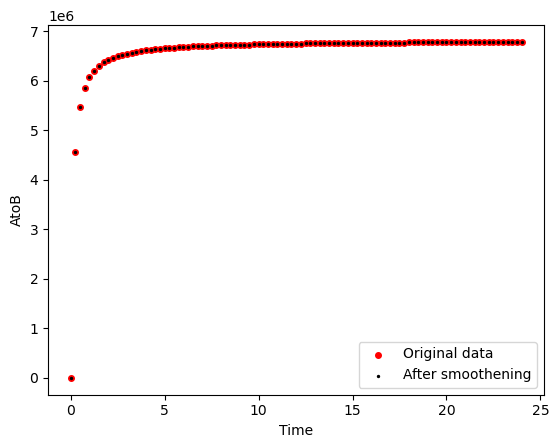

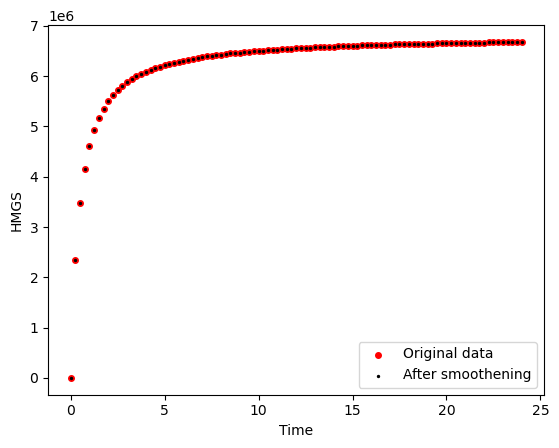

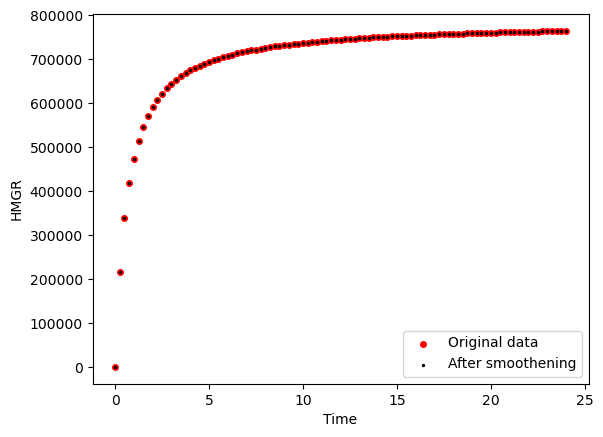

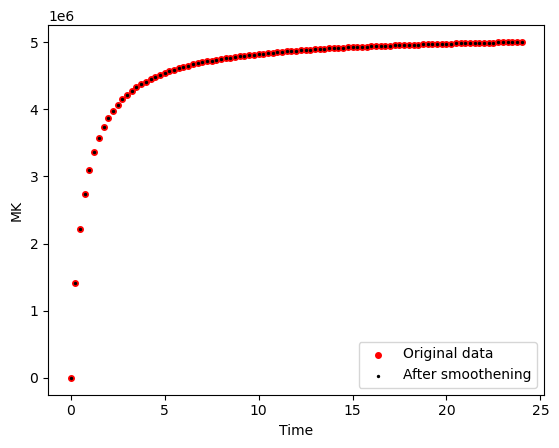

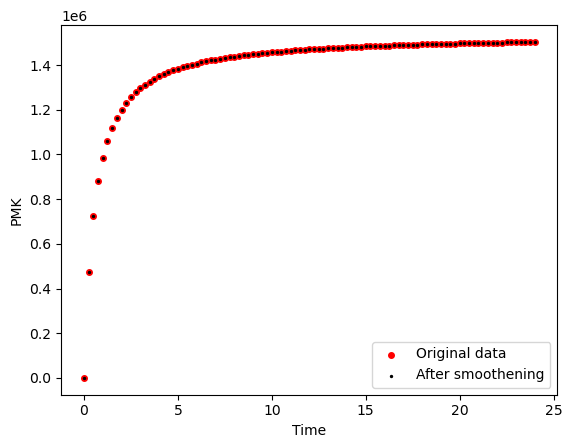

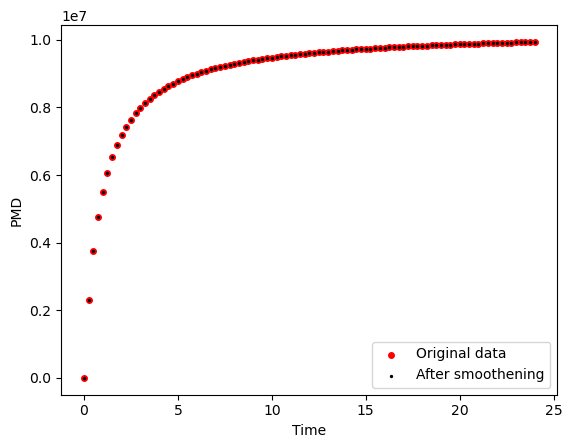

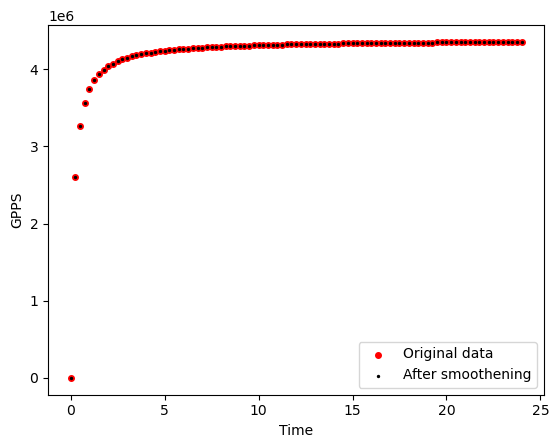

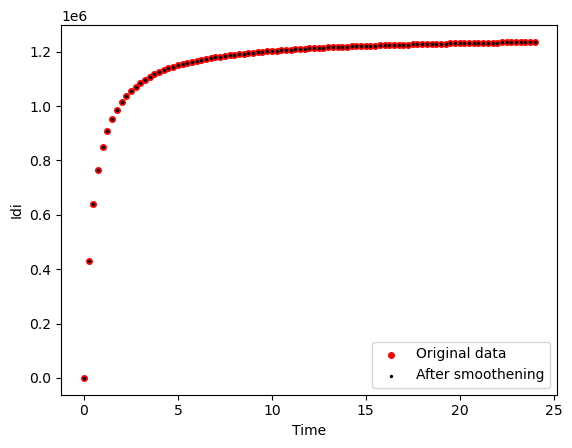

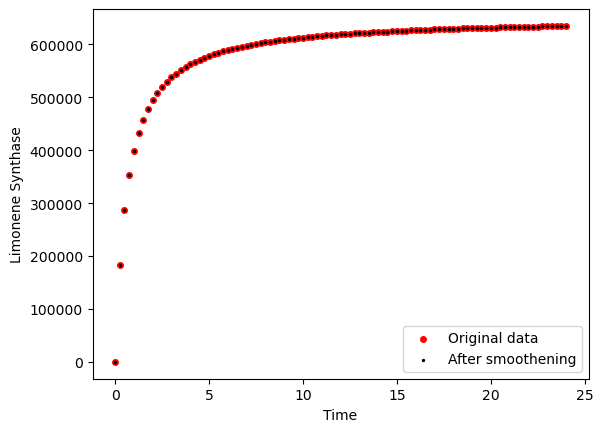

Strain Strain 2


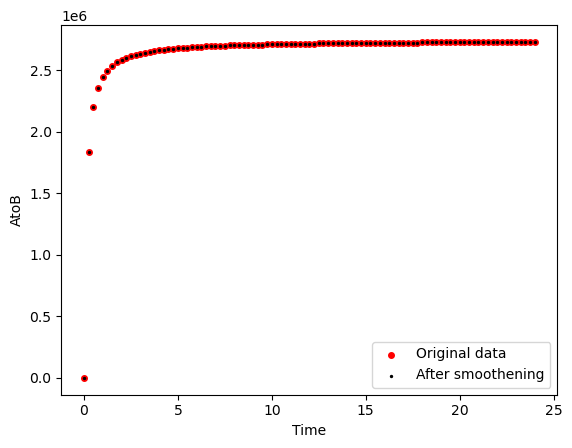

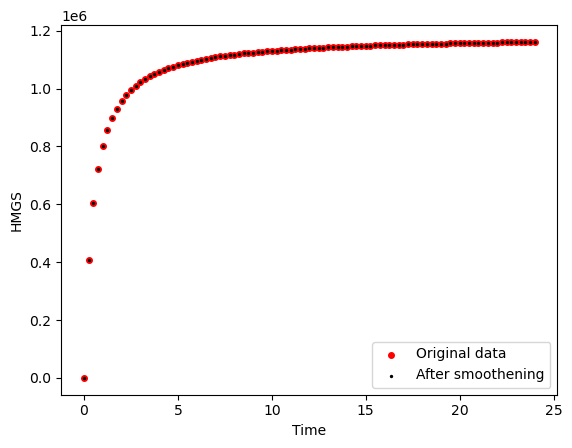

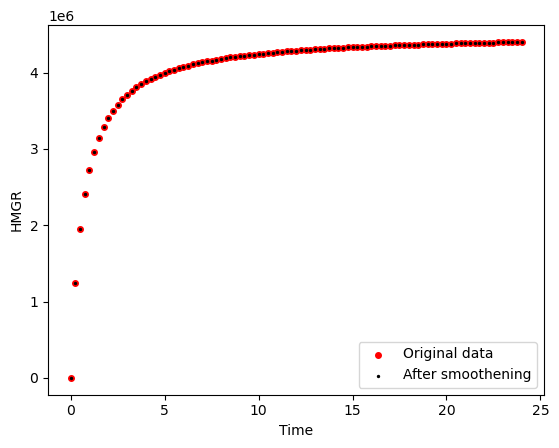

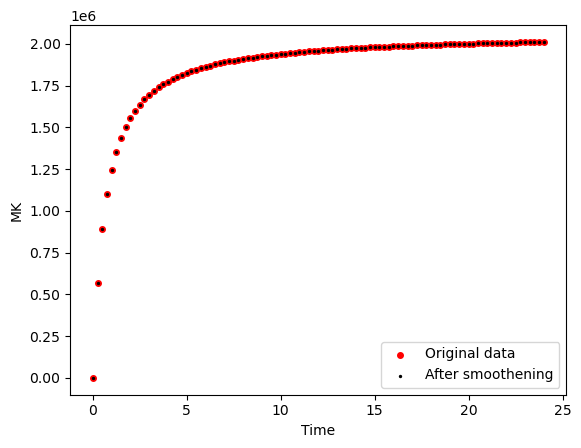

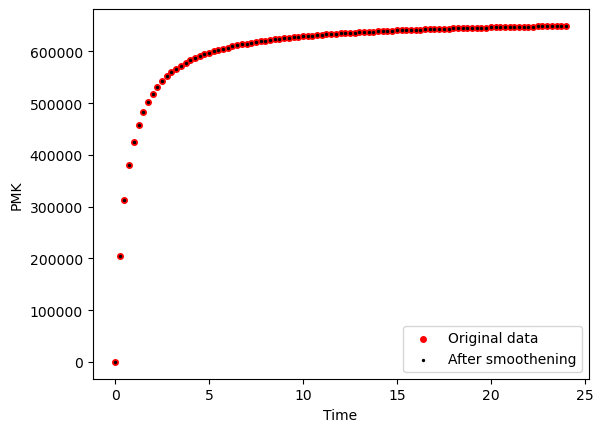

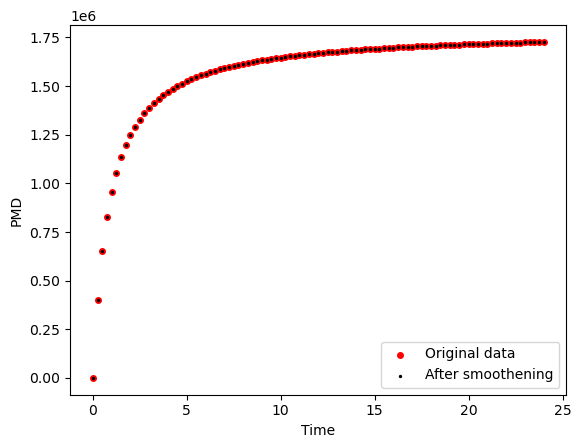

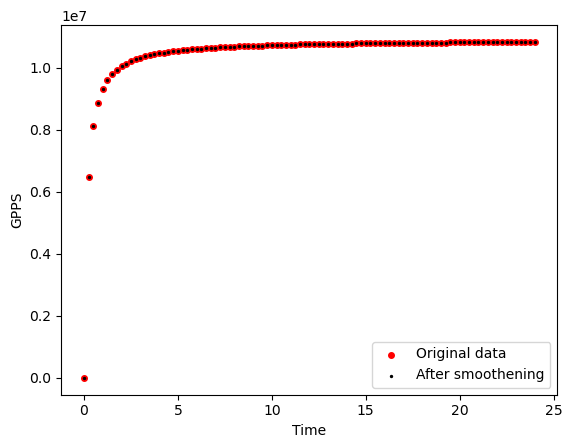

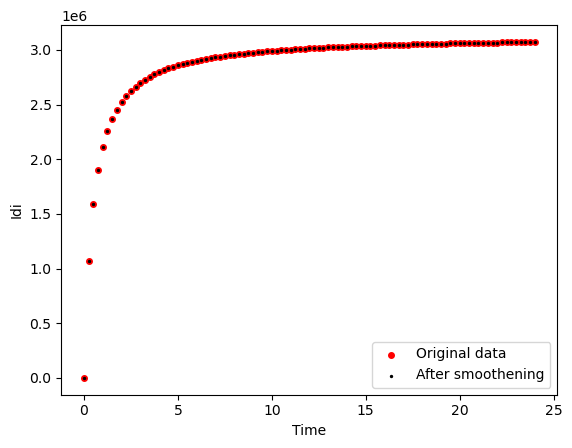

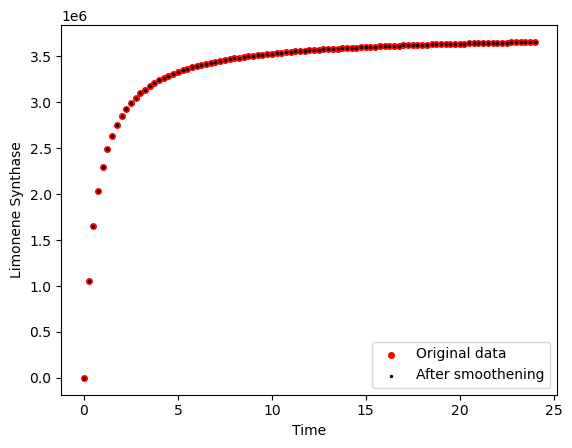

Strain Strain 3


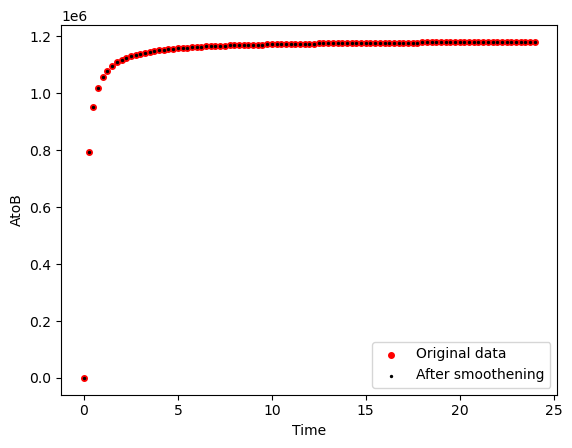

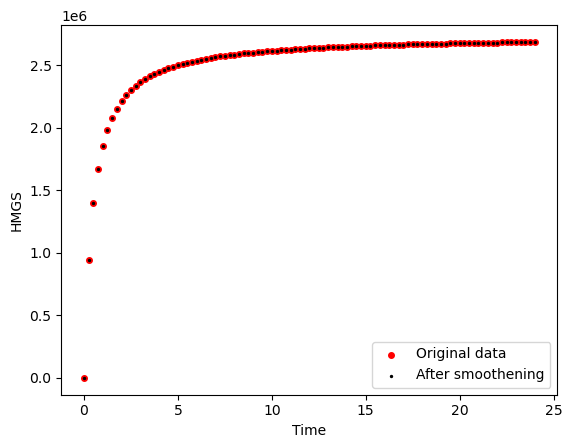

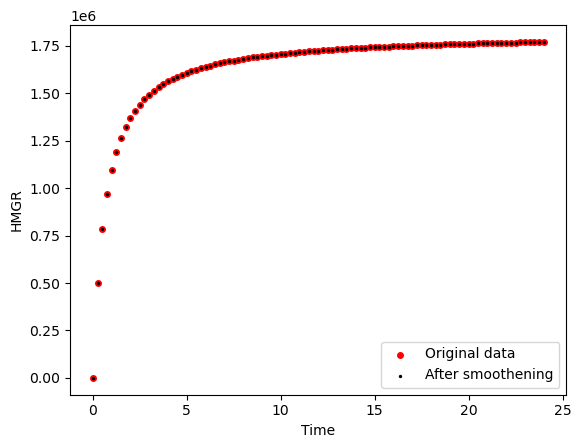

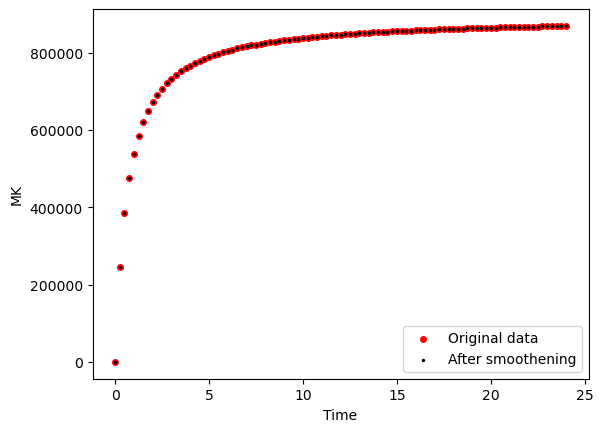

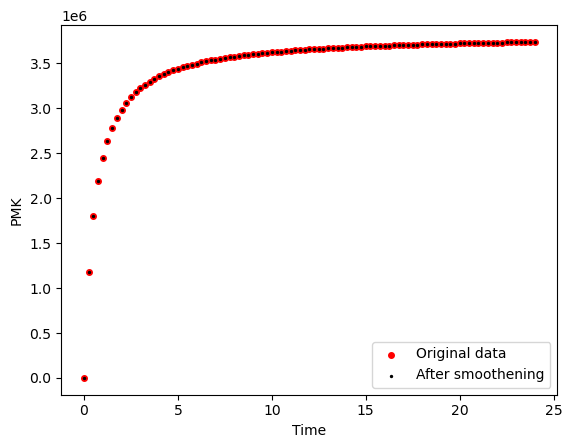

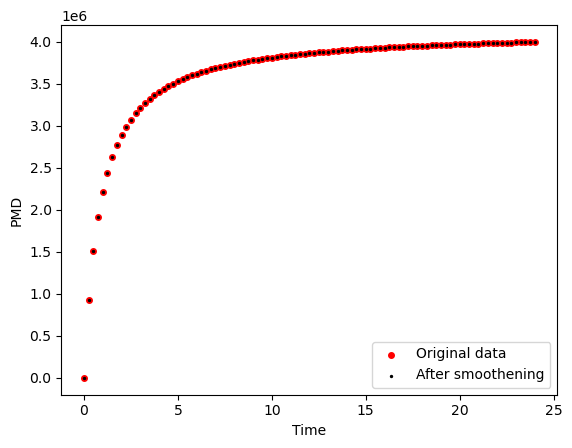

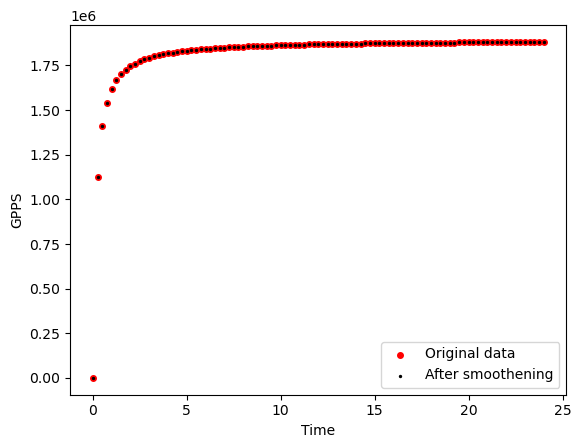

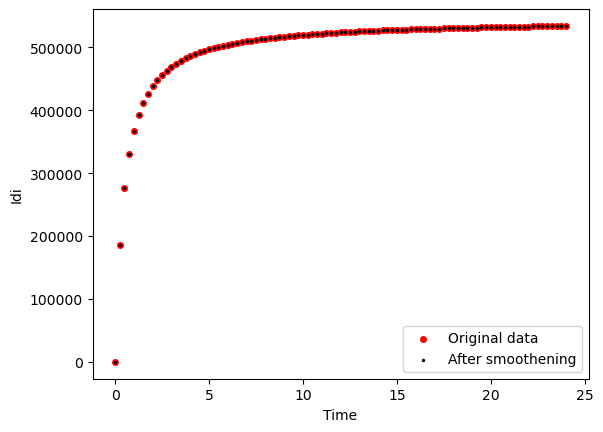

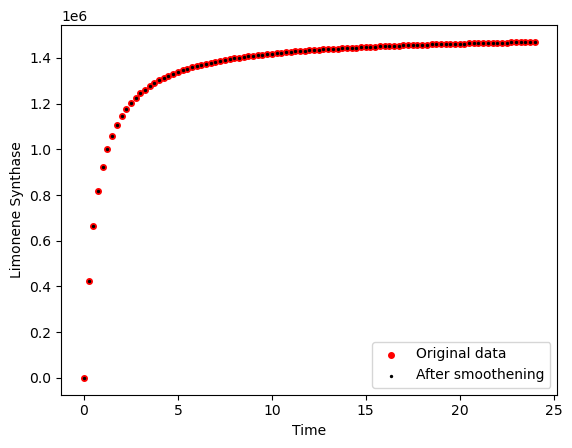

Strain WT


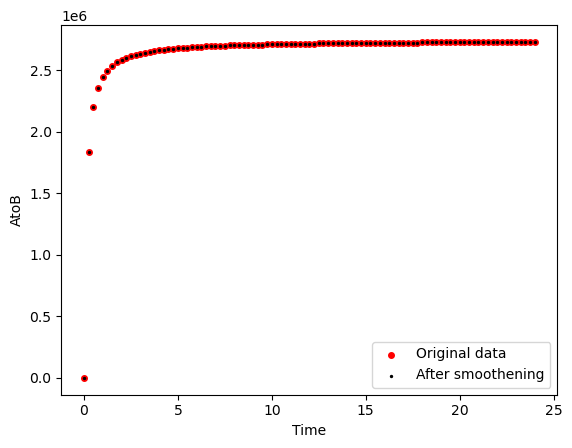

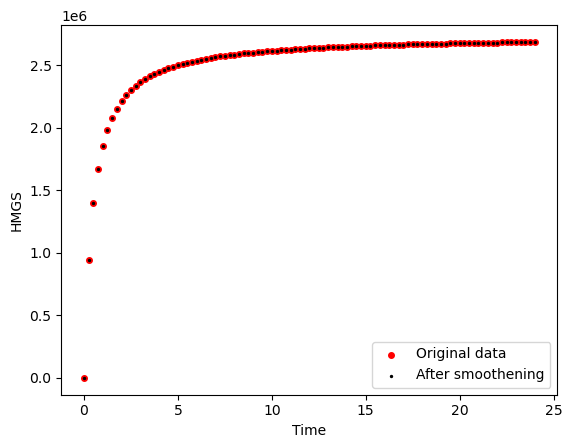

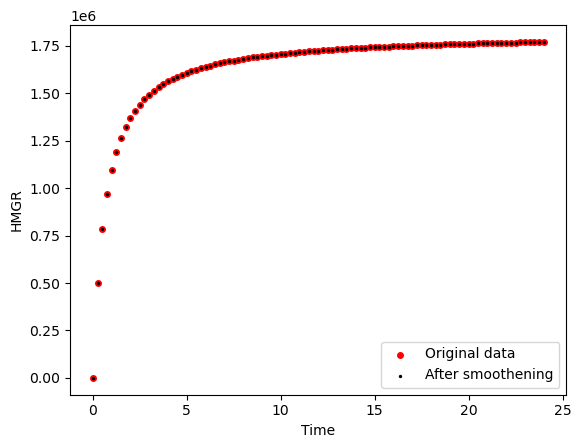

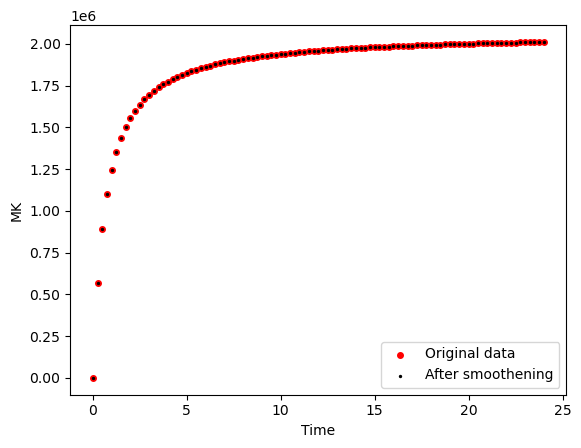

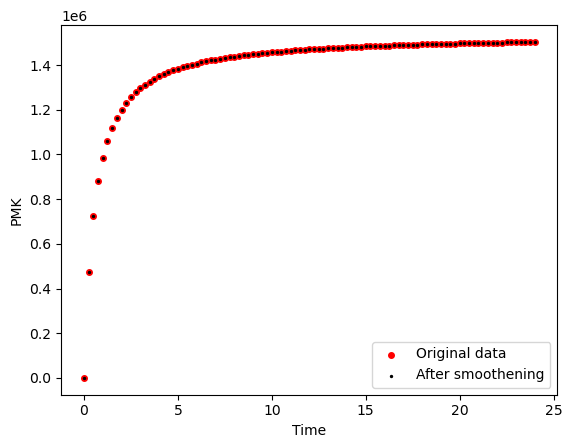

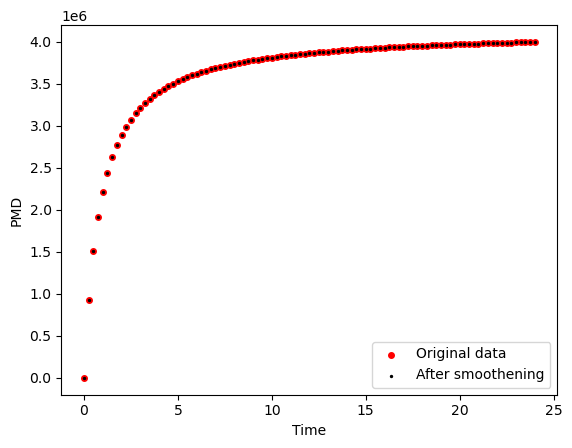

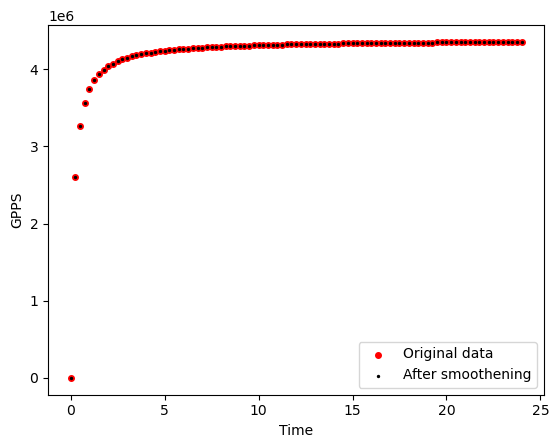

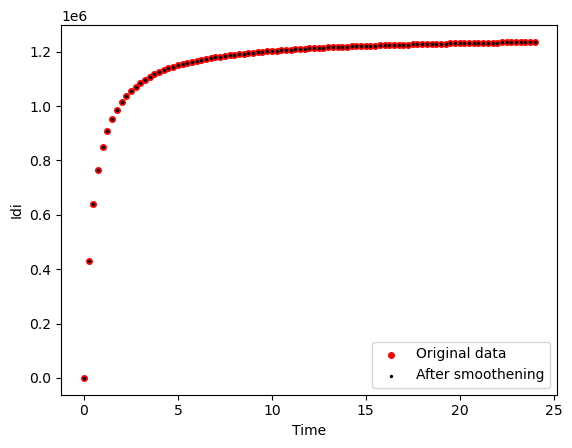

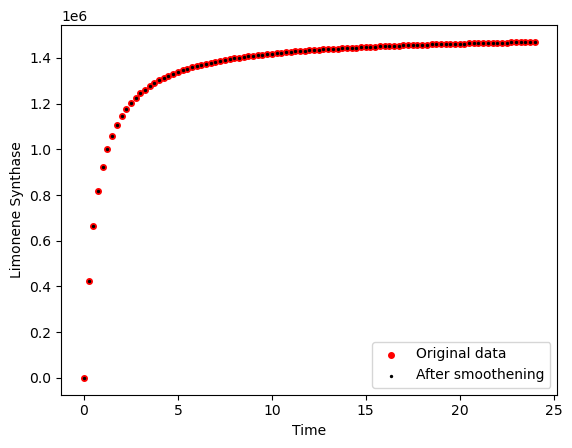

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

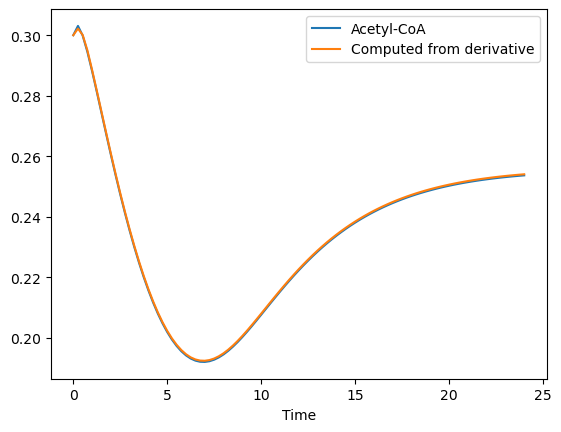

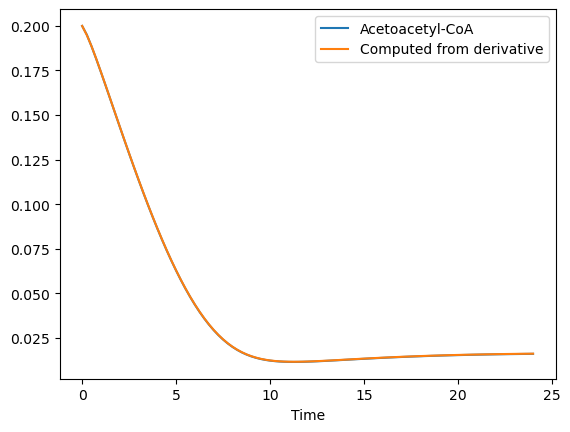

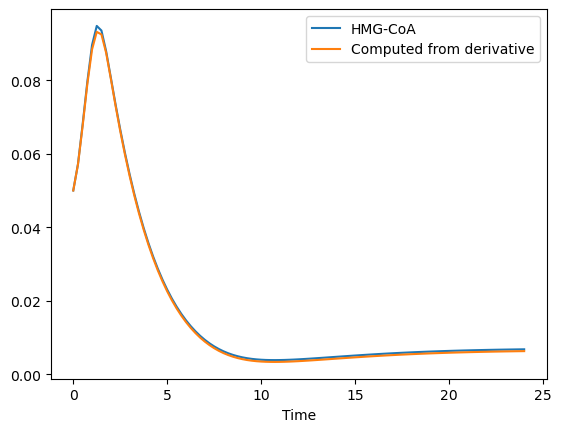

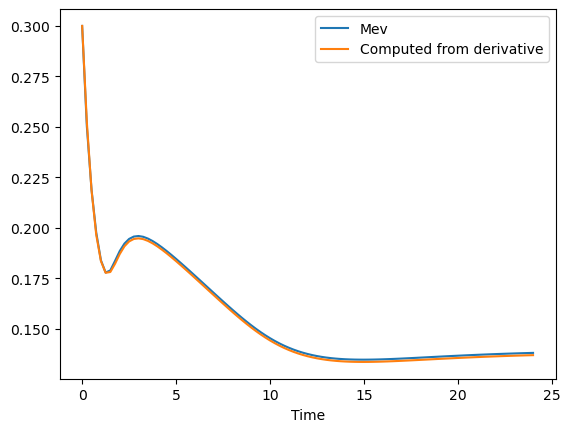

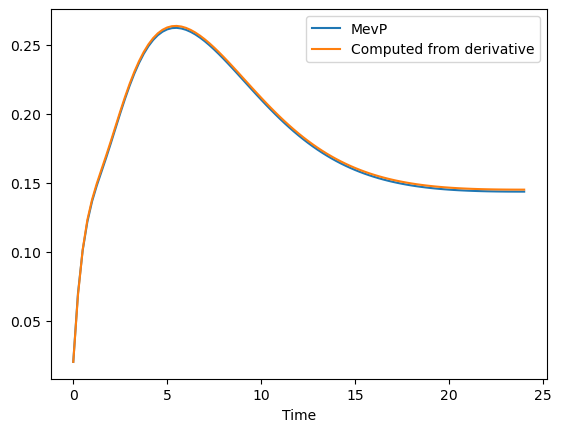

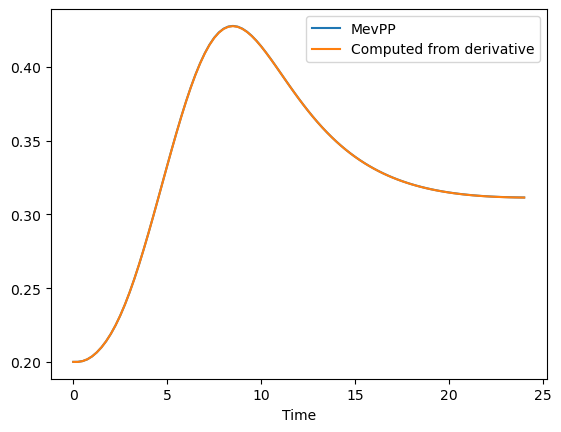

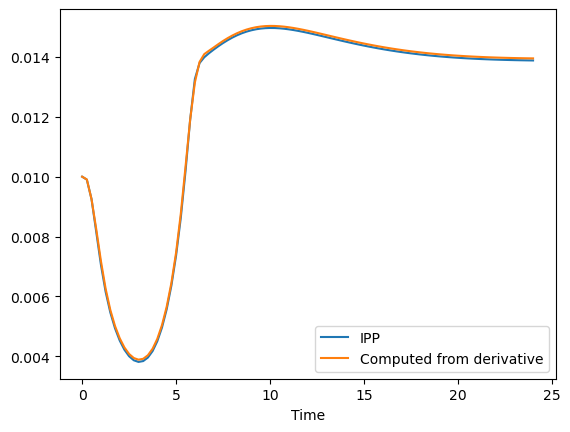

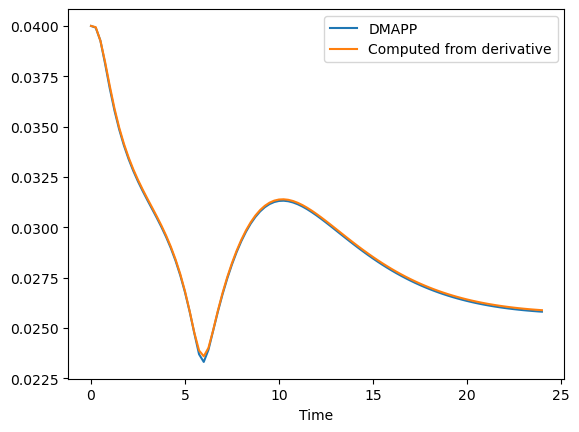

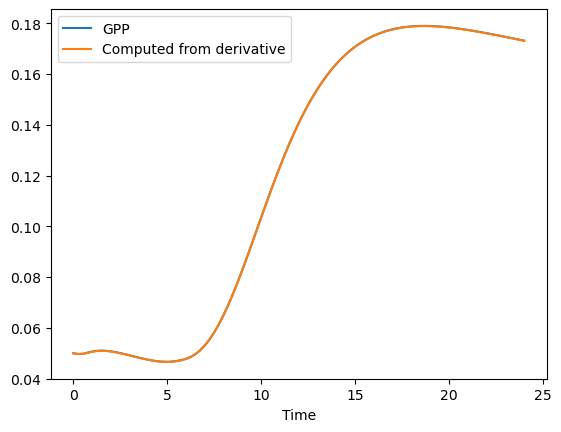

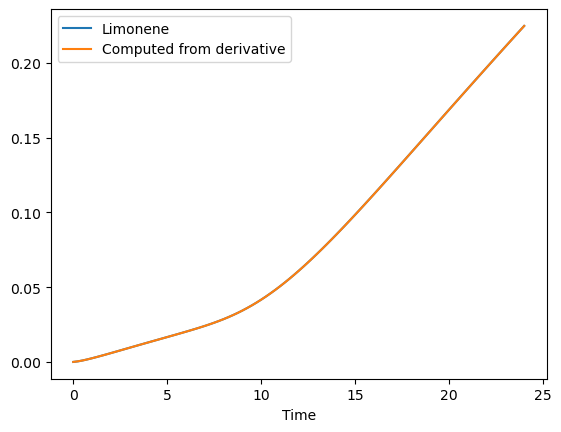

'Time profile from derivative vs. actual profile for Strain 2'

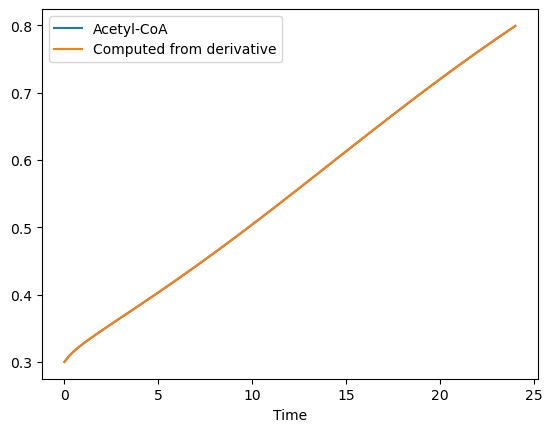

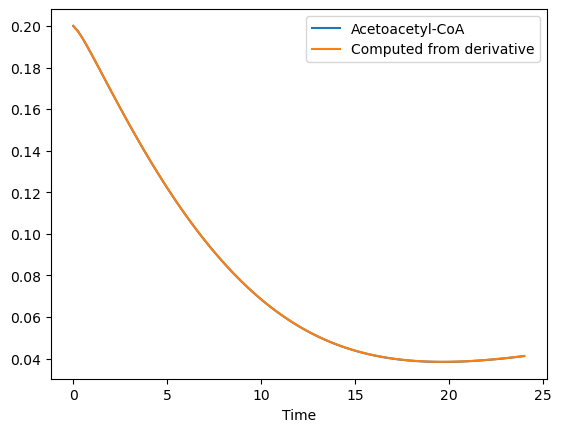

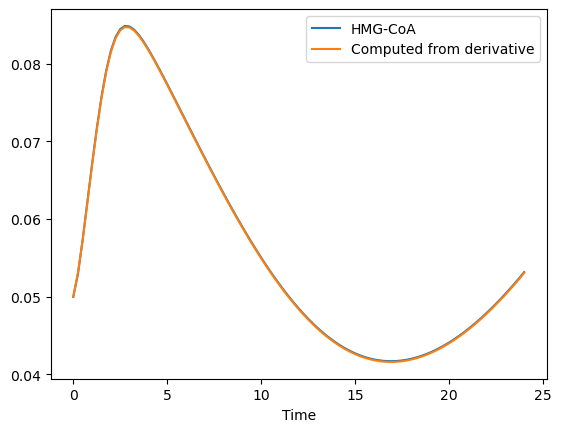

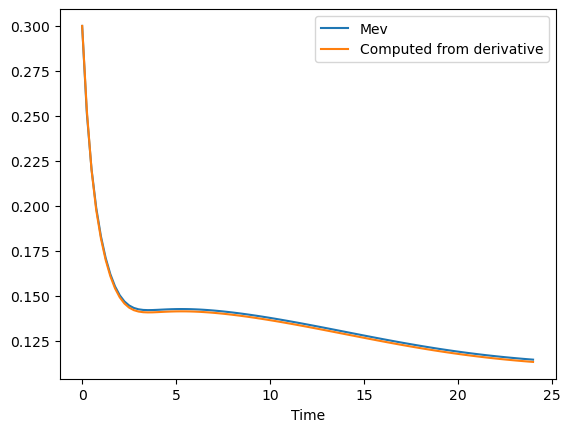

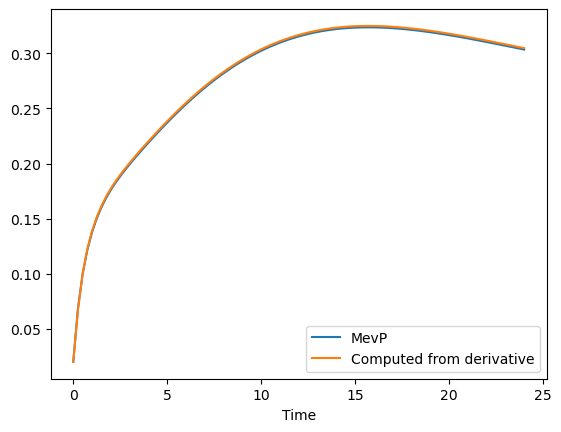

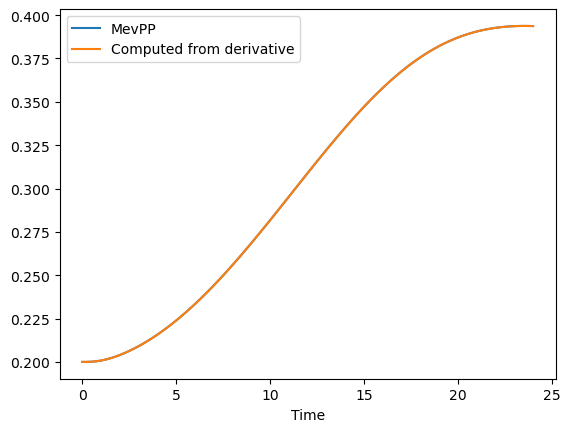

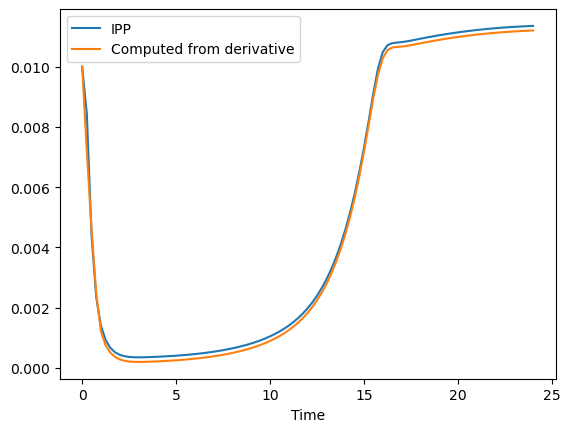

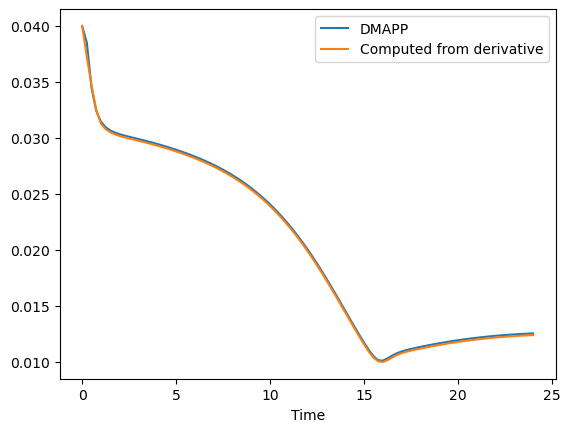

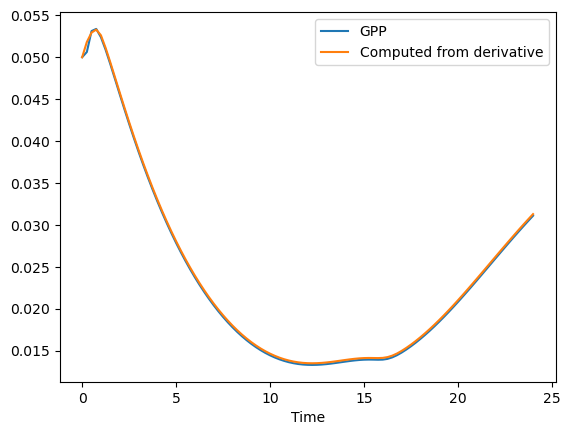

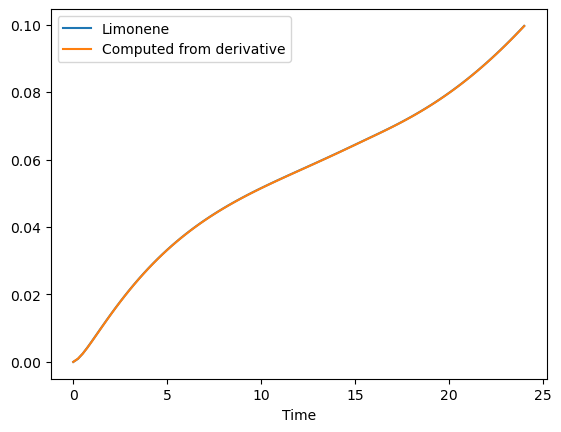

'Time profile from derivative vs. actual profile for Strain 3'

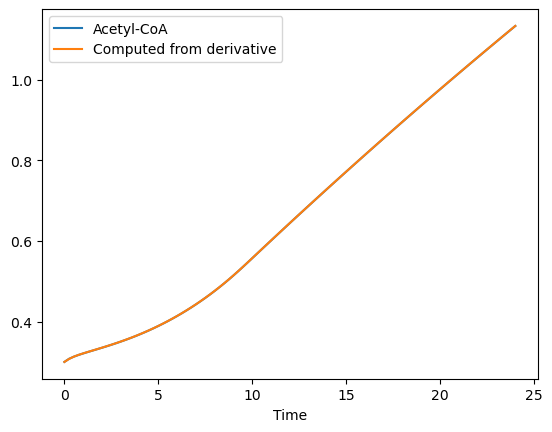

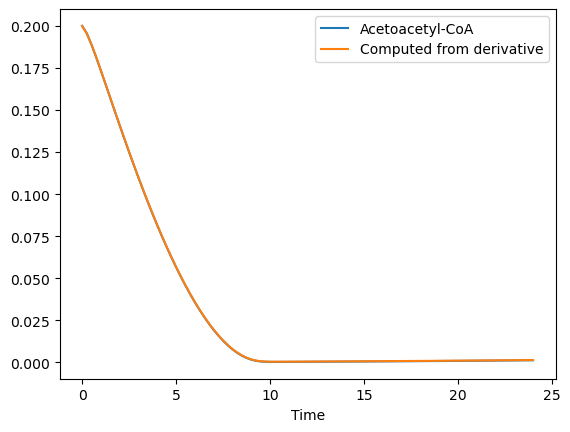

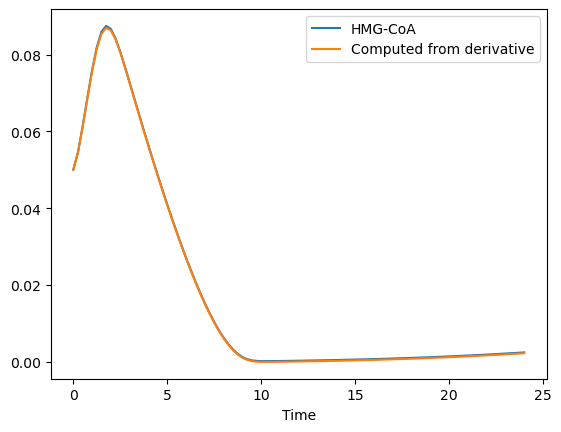

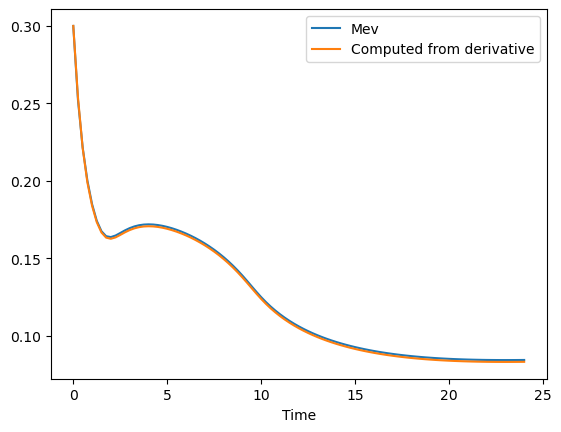

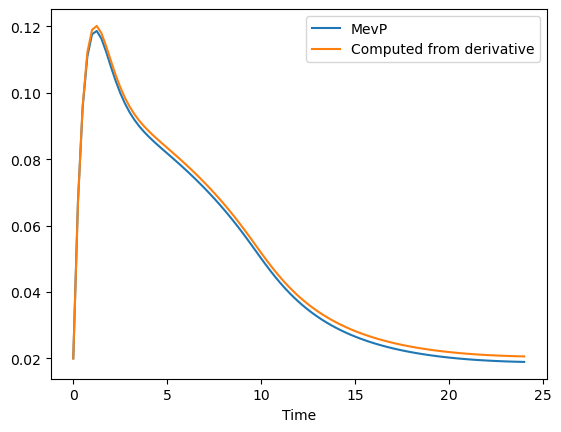

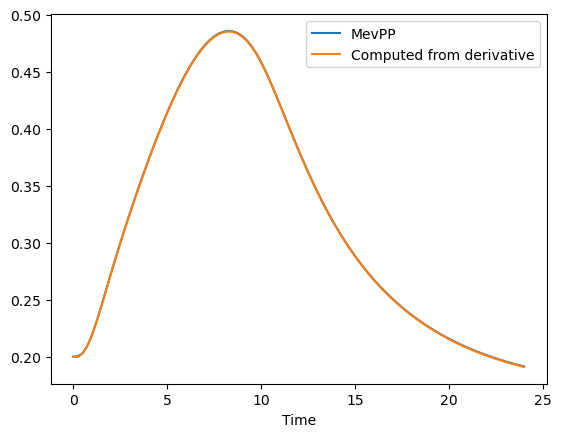

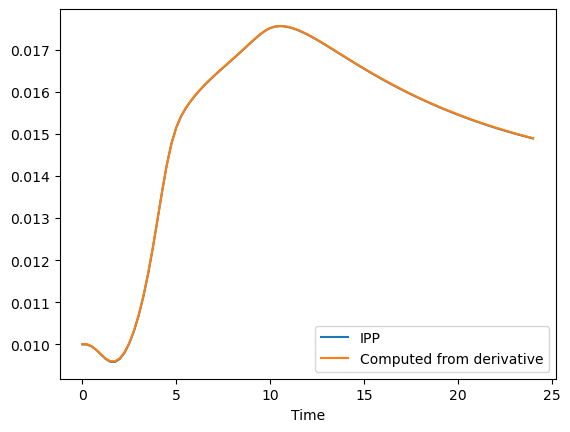

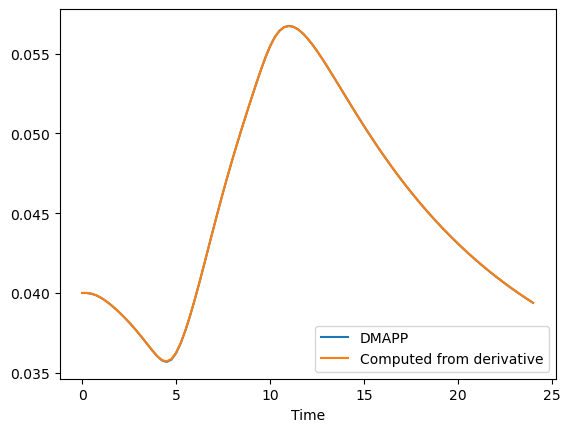

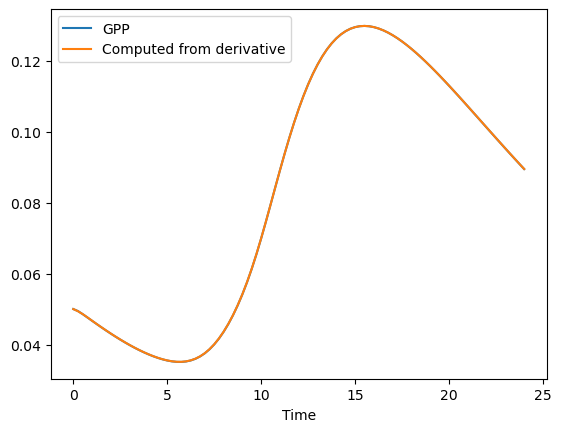

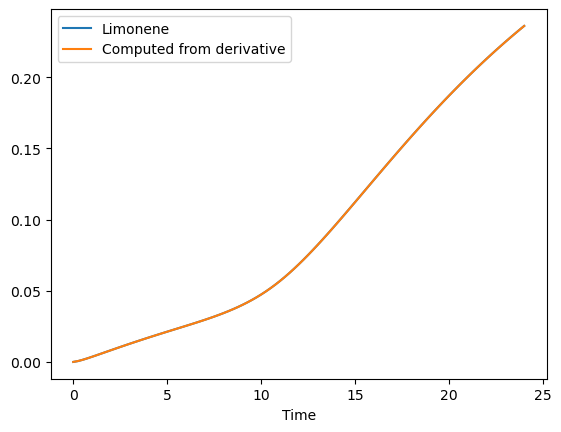

'Time profile from derivative vs. actual profile for WT'

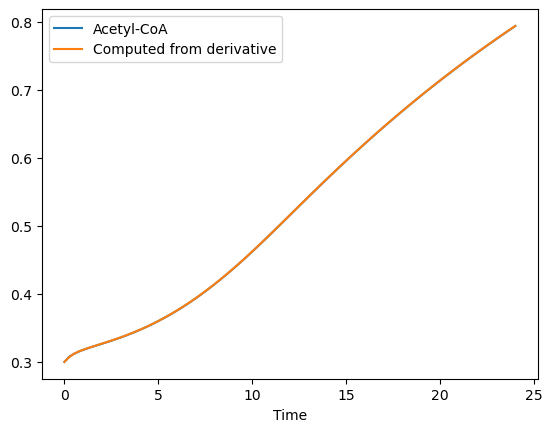

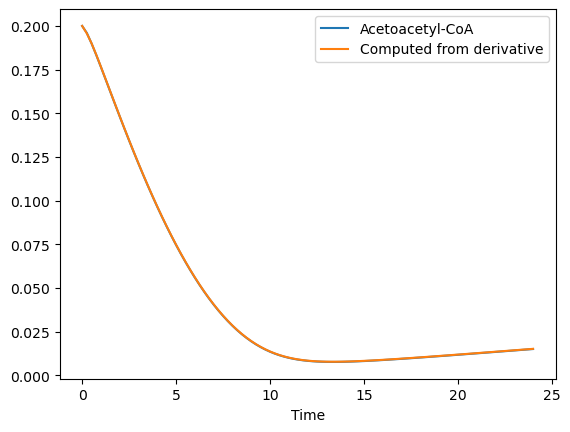

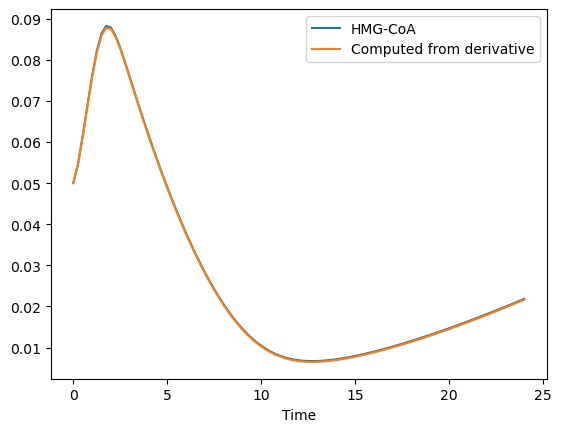

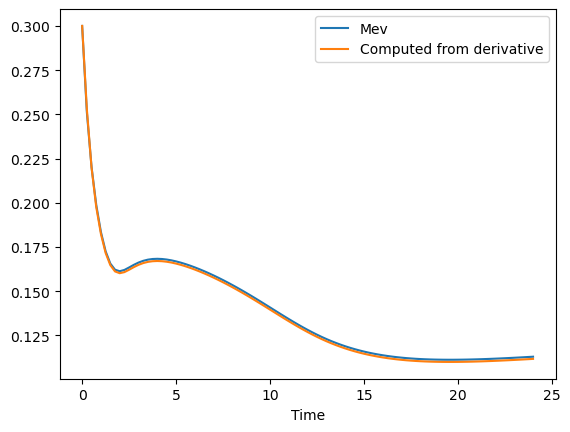

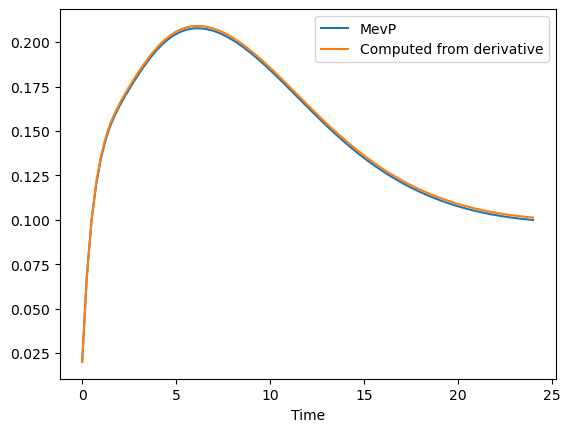

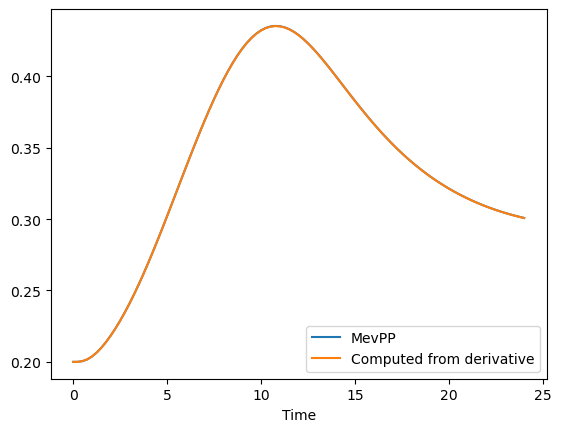

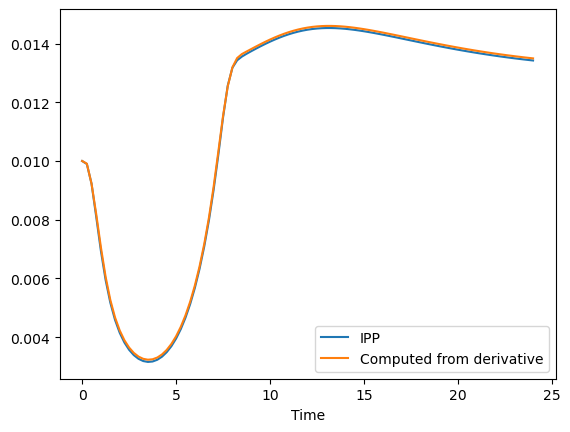

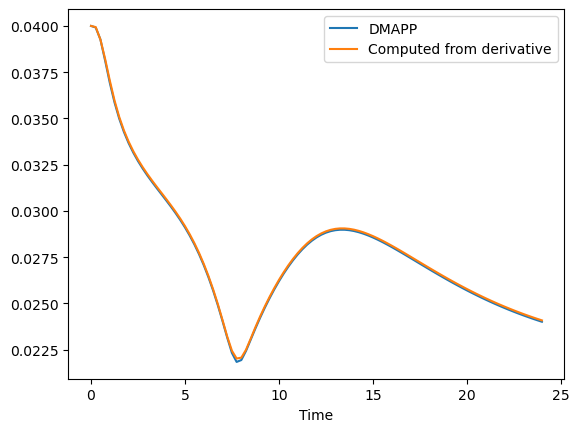

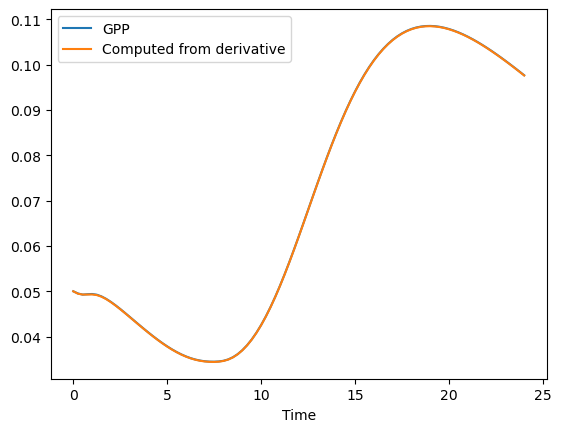

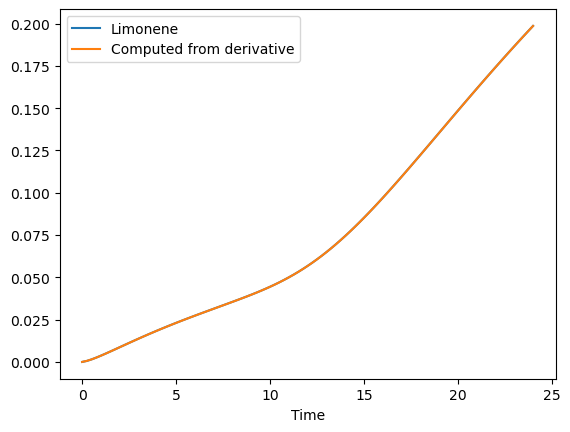

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 4.436786E+205 |  3.357411E+82
     2 |      128 | 4.436786E+205 |  1.858754E+36
     3 |      192 | 2.913420E+205 |  4.782340E+17
     4 |      256 | 1.688576E+137 |  2.204762E+13
     5 |      320 | 1.446505E+119 |  1.291887E+10
     6 |      384 |  7.692501E+24 |  7.107113E+08
     7 |      448 |  1.533135E+13 |  5.062430E+07
     8 |      512 |  1.531710E+13 |  5.867285E+05
     9 |      576 |  5.046606E+09 |  1.177210E+04
    10 |      640 |  4.233578E+09 |  2.606736E+03
    11 |      704 |  4.110529E+09 |  2.020022E+02
    12 |      768 |  5.407264E+06 |  3.096065E+01
    13 |      832 |  1.948142E+04 |  2.511625E+01
    14 |      896 |  2.863138E+02 |  2.428771E+01
    15 |      960 |  6.475171E+01 |  2.368324E+01
    16 |     1024 |  4.919081E+01 |  2.244828E+01
    17 |     1088 |  2.303485E+01 |  2.148760E+01
    18 |     1152 |  2.188886E+01 |  2.041643E+01
    19 |     1216 |  2.10

   162 |    10368 |  1.549760E+01 |  1.548714E+01
   163 |    10432 |  1.548824E+01 |  1.547650E+01
   164 |    10496 |  1.547685E+01 |  1.546248E+01
   165 |    10560 |  1.546271E+01 |  1.543811E+01
   166 |    10624 |  1.544194E+01 |  1.542355E+01
   167 |    10688 |  1.542335E+01 |  1.540160E+01
   168 |    10752 |  1.540581E+01 |  1.539006E+01
   169 |    10816 |  1.539591E+01 |  1.538732E+01
   170 |    10880 |  1.538896E+01 |  1.538000E+01
   171 |    10944 |  1.538213E+01 |  1.537445E+01
   172 |    11008 |  1.537640E+01 |  1.536825E+01
   173 |    11072 |  1.529847E+01 |  1.490130E+01
   174 |    11136 |  1.515182E+01 |  1.488593E+01
   175 |    11200 |  1.500651E+01 |  1.487761E+01
   176 |    11264 |  1.491959E+01 |  1.487354E+01
   177 |    11328 |  1.489632E+01 |  1.486946E+01
   178 |    11392 |  1.487654E+01 |  1.486640E+01
   179 |    11456 |  1.487260E+01 |  1.486223E+01
   180 |    11520 |  1.486858E+01 |  1.485802E+01
   181 |    11584 |  1.485863E+01 |  1.485322E+01


   326 |    20864 |  1.427981E+01 |  1.427831E+01
   327 |    20928 |  1.427884E+01 |  1.427735E+01
   328 |    20992 |  1.427787E+01 |  1.427662E+01
   329 |    21056 |  1.427710E+01 |  1.427636E+01
   330 |    21120 |  1.427646E+01 |  1.427538E+01
   331 |    21184 |  1.427561E+01 |  1.427479E+01
   332 |    21248 |  1.427490E+01 |  1.427406E+01
   333 |    21312 |  1.427414E+01 |  1.427322E+01
   334 |    21376 |  1.427340E+01 |  1.427246E+01
   335 |    21440 |  1.427261E+01 |  1.427163E+01
   336 |    21504 |  1.427154E+01 |  1.427035E+01
   337 |    21568 |  1.427059E+01 |  1.426975E+01
   338 |    21632 |  1.426980E+01 |  1.426884E+01
   339 |    21696 |  1.426880E+01 |  1.426719E+01
   340 |    21760 |  1.426750E+01 |  1.426611E+01
   341 |    21824 |  1.426638E+01 |  1.426534E+01
   342 |    21888 |  1.426558E+01 |  1.426470E+01
   343 |    21952 |  1.426487E+01 |  1.426405E+01
   344 |    22016 |  1.426422E+01 |  1.426356E+01
   345 |    22080 |  1.426380E+01 |  1.426321E+01


   490 |    31360 |  1.413457E+01 |  1.413152E+01
   491 |    31424 |  1.413135E+01 |  1.412860E+01
   492 |    31488 |  1.412977E+01 |  1.412772E+01
   493 |    31552 |  1.412794E+01 |  1.412539E+01
   494 |    31616 |  1.412571E+01 |  1.412327E+01
   495 |    31680 |  1.412370E+01 |  1.412222E+01
   496 |    31744 |  1.412261E+01 |  1.412096E+01
   497 |    31808 |  1.412141E+01 |  1.412035E+01
   498 |    31872 |  1.412057E+01 |  1.411936E+01
   499 |    31936 |  1.411942E+01 |  1.411761E+01
   500 |    32000 |  1.411835E+01 |  1.411714E+01
   501 |    32064 |  1.411757E+01 |  1.411669E+01
   502 |    32128 |  1.411703E+01 |  1.411629E+01
   503 |    32192 |  1.411633E+01 |  1.411526E+01
   504 |    32256 |  1.411552E+01 |  1.411471E+01
   505 |    32320 |  1.411500E+01 |  1.411401E+01
   506 |    32384 |  1.411404E+01 |  1.411313E+01
   507 |    32448 |  1.411308E+01 |  1.411249E+01
   508 |    32512 |  1.411275E+01 |  1.411226E+01
   509 |    32576 |  1.411222E+01 |  1.411180E+01


   654 |    41856 |  1.396360E+01 |  1.396261E+01
   655 |    41920 |  1.396279E+01 |  1.396199E+01
   656 |    41984 |  1.396239E+01 |  1.396181E+01
   657 |    42048 |  1.396203E+01 |  1.396179E+01
   658 |    42112 |  1.396192E+01 |  1.396172E+01
   659 |    42176 |  1.396163E+01 |  1.396064E+01
   660 |    42240 |  1.396131E+01 |  1.395976E+01
   661 |    42304 |  1.395993E+01 |  1.395763E+01
   662 |    42368 |  1.395836E+01 |  1.395648E+01
   663 |    42432 |  1.395684E+01 |  1.395514E+01
   664 |    42496 |  1.395570E+01 |  1.395405E+01
   665 |    42560 |  1.395465E+01 |  1.395311E+01
   666 |    42624 |  1.395321E+01 |  1.395186E+01
   667 |    42688 |  1.395199E+01 |  1.395011E+01
   668 |    42752 |  1.395056E+01 |  1.394855E+01
   669 |    42816 |  1.394932E+01 |  1.394762E+01
   670 |    42880 |  1.394763E+01 |  1.394617E+01
   671 |    42944 |  1.394611E+01 |  1.394424E+01
   672 |    43008 |  1.394489E+01 |  1.394310E+01
   673 |    43072 |  1.394371E+01 |  1.394180E+01


   818 |    52352 |  1.339677E+01 |  1.339550E+01
   819 |    52416 |  1.339584E+01 |  1.339494E+01
   820 |    52480 |  1.339494E+01 |  1.339415E+01
   821 |    52544 |  1.339425E+01 |  1.339349E+01
   822 |    52608 |  1.339352E+01 |  1.339296E+01
   823 |    52672 |  1.339290E+01 |  1.339226E+01
   824 |    52736 |  1.339229E+01 |  1.339143E+01
   825 |    52800 |  1.339100E+01 |  1.338772E+01
   826 |    52864 |  1.338730E+01 |  1.338408E+01
   827 |    52928 |  1.338329E+01 |  1.337814E+01
   828 |    52992 |  1.337841E+01 |  1.337215E+01
   829 |    53056 |  1.337312E+01 |  1.336622E+01
   830 |    53120 |  1.336594E+01 |  1.335721E+01
   831 |    53184 |  1.335911E+01 |  1.335141E+01
   832 |    53248 |  1.335181E+01 |  1.334398E+01
   833 |    53312 |  1.334362E+01 |  1.333426E+01
   834 |    53376 |  1.333599E+01 |  1.332815E+01
   835 |    53440 |  1.332625E+01 |  1.331274E+01
   836 |    53504 |  1.331269E+01 |  1.330091E+01
   837 |    53568 |  1.330145E+01 |  1.328958E+01


   982 |    62848 |  1.291003E+01 |  1.290604E+01
   983 |    62912 |  1.290665E+01 |  1.290290E+01
   984 |    62976 |  1.290380E+01 |  1.290005E+01
   985 |    63040 |  1.290052E+01 |  1.289643E+01
   986 |    63104 |  1.289685E+01 |  1.289296E+01
   987 |    63168 |  1.289344E+01 |  1.288938E+01
   988 |    63232 |  1.289076E+01 |  1.288827E+01
   989 |    63296 |  1.288899E+01 |  1.288653E+01
   990 |    63360 |  1.288689E+01 |  1.288574E+01
   991 |    63424 |  1.288612E+01 |  1.288493E+01
   992 |    63488 |  1.288511E+01 |  1.288415E+01
   993 |    63552 |  1.288431E+01 |  1.288365E+01
   994 |    63616 |  1.288372E+01 |  1.288317E+01
   995 |    63680 |  1.288331E+01 |  1.288261E+01
   996 |    63744 |  1.288275E+01 |  1.288198E+01
   997 |    63808 |  1.288212E+01 |  1.288135E+01
   998 |    63872 |  1.288145E+01 |  1.288050E+01
   999 |    63936 |  1.288063E+01 |  1.287925E+01
  1000 |    64000 |  1.287933E+01 |  1.287771E+01
  1001 |    64064 |  1.287775E+01 |  1.287591E+01


  1146 |    73344 |  1.219892E+01 |  1.219339E+01
  1147 |    73408 |  1.219338E+01 |  1.218892E+01
  1148 |    73472 |  1.218891E+01 |  1.218430E+01
  1149 |    73536 |  1.218407E+01 |  1.217863E+01
  1150 |    73600 |  1.217850E+01 |  1.217165E+01
  1151 |    73664 |  1.217182E+01 |  1.216396E+01
  1152 |    73728 |  1.216222E+01 |  1.215088E+01
  1153 |    73792 |  1.215350E+01 |  1.214039E+01
  1154 |    73856 |  1.214011E+01 |  1.212815E+01
  1155 |    73920 |  1.213242E+01 |  1.212326E+01
  1156 |    73984 |  1.212389E+01 |  1.211305E+01
  1157 |    74048 |  1.211324E+01 |  1.210173E+01
  1158 |    74112 |  1.210125E+01 |  1.209135E+01
  1159 |    74176 |  1.209380E+01 |  1.208587E+01
  1160 |    74240 |  1.208841E+01 |  1.208220E+01
  1161 |    74304 |  1.208415E+01 |  1.207833E+01
  1162 |    74368 |  1.208030E+01 |  1.207633E+01
  1163 |    74432 |  1.207652E+01 |  1.207236E+01
  1164 |    74496 |  1.207272E+01 |  1.206901E+01
  1165 |    74560 |  1.206933E+01 |  1.206663E+01


  1310 |    83840 |  1.150521E+01 |  1.150226E+01
  1311 |    83904 |  1.150257E+01 |  1.150039E+01
  1312 |    83968 |  1.150038E+01 |  1.149769E+01
  1313 |    84032 |  1.149773E+01 |  1.149406E+01
  1314 |    84096 |  1.149426E+01 |  1.148973E+01
  1315 |    84160 |  1.149084E+01 |  1.148743E+01
  1316 |    84224 |  1.148812E+01 |  1.148453E+01
  1317 |    84288 |  1.148449E+01 |  1.148029E+01
  1318 |    84352 |  1.148013E+01 |  1.147508E+01
  1319 |    84416 |  1.147656E+01 |  1.147115E+01
  1320 |    84480 |  1.146852E+01 |  1.145951E+01
  1321 |    84544 |  1.145957E+01 |  1.145091E+01
  1322 |    84608 |  1.144952E+01 |  1.143292E+01
  1323 |    84672 |  1.143624E+01 |  1.141917E+01
  1324 |    84736 |  1.141639E+01 |  1.140001E+01
  1325 |    84800 |  1.140390E+01 |  1.139388E+01
  1326 |    84864 |  1.139723E+01 |  1.138956E+01
  1327 |    84928 |  1.138990E+01 |  1.138171E+01
  1328 |    84992 |  1.138412E+01 |  1.137767E+01
  1329 |    85056 |  1.137759E+01 |  1.136977E+01


  1474 |    94336 |  1.032016E+01 |  1.031729E+01
  1475 |    94400 |  1.031713E+01 |  1.031338E+01
  1476 |    94464 |  1.031427E+01 |  1.031121E+01
  1477 |    94528 |  1.031157E+01 |  1.030811E+01
  1478 |    94592 |  1.030739E+01 |  1.030130E+01
  1479 |    94656 |  1.030233E+01 |  1.029716E+01
  1480 |    94720 |  1.029783E+01 |  1.029231E+01
  1481 |    94784 |  1.029361E+01 |  1.028919E+01
  1482 |    94848 |  1.028927E+01 |  1.028551E+01
  1483 |    94912 |  1.028602E+01 |  1.028246E+01
  1484 |    94976 |  1.028347E+01 |  1.028029E+01
  1485 |    95040 |  1.028091E+01 |  1.027875E+01
  1486 |    95104 |  1.027931E+01 |  1.027670E+01
  1487 |    95168 |  1.027747E+01 |  1.027570E+01
  1488 |    95232 |  1.027581E+01 |  1.027471E+01
  1489 |    95296 |  1.027460E+01 |  1.027364E+01
  1490 |    95360 |  1.027363E+01 |  1.027267E+01
  1491 |    95424 |  1.027227E+01 |  1.027099E+01
  1492 |    95488 |  1.027093E+01 |  1.026949E+01
  1493 |    95552 |  1.026917E+01 |  1.026722E+01


  1638 |   104832 |  1.004662E+01 |  1.004537E+01
  1639 |   104896 |  1.004533E+01 |  1.004395E+01
  1640 |   104960 |  1.004368E+01 |  1.004063E+01
  1641 |   105024 |  1.004140E+01 |  1.003762E+01
  1642 |   105088 |  1.003762E+01 |  1.003382E+01
  1643 |   105152 |  1.003495E+01 |  1.003224E+01
  1644 |   105216 |  1.003165E+01 |  1.002761E+01
  1645 |   105280 |  1.002841E+01 |  1.002524E+01
  1646 |   105344 |  1.002589E+01 |  1.002312E+01
  1647 |   105408 |  1.002326E+01 |  1.002020E+01
  1648 |   105472 |  1.002050E+01 |  1.001753E+01
  1649 |   105536 |  1.001783E+01 |  1.001489E+01
  1650 |   105600 |  1.001606E+01 |  1.001391E+01
  1651 |   105664 |  1.001458E+01 |  1.001246E+01
  1652 |   105728 |  1.001263E+01 |  1.001054E+01
  1653 |   105792 |  1.001045E+01 |  1.000818E+01
  1654 |   105856 |  1.000876E+01 |  1.000710E+01
  1655 |   105920 |  1.000755E+01 |  1.000649E+01
  1656 |   105984 |  1.000679E+01 |  1.000608E+01
  1657 |   106048 |  1.000611E+01 |  1.000526E+01


  1802 |   115328 |  9.6948652018 |  9.6855720351
  1803 |   115392 |  9.6859557600 |  9.6747660459
  1804 |   115456 |  9.6734786661 |  9.6564689260
  1805 |   115520 |  9.6592073257 |  9.6385070845
  1806 |   115584 |  9.6427487376 |  9.6224751656
  1807 |   115648 |  9.6232327166 |  9.6080219893
  1808 |   115712 |  9.6051313464 |  9.5803970755
  1809 |   115776 |  9.5848999283 |  9.5633577364
  1810 |   115840 |  9.5702404216 |  9.5560815577
  1811 |   115904 |  9.5602151763 |  9.5469901642
  1812 |   115968 |  9.5508219548 |  9.5384993181
  1813 |   116032 |  9.5409787534 |  9.5334464471
  1814 |   116096 |  9.5346652535 |  9.5305597536
  1815 |   116160 |  9.5314978800 |  9.5287409652
  1816 |   116224 |  9.5294286392 |  9.5267465952
  1817 |   116288 |  9.5274308152 |  9.5261665503
  1818 |   116352 |  9.5264274215 |  9.5256263067
  1819 |   116416 |  9.5257842711 |  9.5250648926
  1820 |   116480 |  9.5249368104 |  9.5242109490
  1821 |   116544 |  9.5242058069 |  9.5233829866


  1966 |   125824 |  8.8162961625 |  8.8142330398
  1967 |   125888 |  8.8145281974 |  8.8133022872
  1968 |   125952 |  8.8131108855 |  8.8118276523
  1969 |   126016 |  8.8122347433 |  8.8112079973
  1970 |   126080 |  8.8112812202 |  8.8098534383
  1971 |   126144 |  8.8101667876 |  8.8084573509
  1972 |   126208 |  8.8087343824 |  8.8069297904
  1973 |   126272 |  8.8071293386 |  8.8058302885
  1974 |   126336 |  8.8058008670 |  8.8039483474
  1975 |   126400 |  8.8037440332 |  8.8010208824
  1976 |   126464 |  8.8013023592 |  8.7976713844
  1977 |   126528 |  8.7984800866 |  8.7955486959
  1978 |   126592 |  8.7959581899 |  8.7933155193
  1979 |   126656 |  8.7934035396 |  8.7908925079
  1980 |   126720 |  8.7911472183 |  8.7868549817
  1981 |   126784 |  8.7871317303 |  8.7824990516
  1982 |   126848 |  8.7829313147 |  8.7785154635
  1983 |   126912 |  8.7786742872 |  8.7758259206
  1984 |   126976 |  8.7761249388 |  8.7736981504
  1985 |   127040 |  8.7746988937 |  8.7719863147


  2130 |   136320 |  8.0679006383 |  8.0653757487
  2131 |   136384 |  8.0655200174 |  8.0626566208
  2132 |   136448 |  8.0626393711 |  8.0591096537
  2133 |   136512 |  8.0599212719 |  8.0576088259
  2134 |   136576 |  8.0576916586 |  8.0556073551
  2135 |   136640 |  8.0558656462 |  8.0522066435
  2136 |   136704 |  8.0530129436 |  8.0488260140
  2137 |   136768 |  8.0482841103 |  8.0447986136
  2138 |   136832 |  8.0449297010 |  8.0404418565
  2139 |   136896 |  8.0399714175 |  8.0355249848
  2140 |   136960 |  8.0342876566 |  8.0281359495
  2141 |   137024 |  8.0279603971 |  8.0219400529
  2142 |   137088 |  8.0220937655 |  8.0166592932
  2143 |   137152 |  8.0178052317 |  8.0126032778
  2144 |   137216 |  8.0129626454 |  8.0011292581
  2145 |   137280 |  7.9957704604 |  7.9764267049
  2146 |   137344 |  7.9827516955 |  7.9698502039
  2147 |   137408 |  7.9730753883 |  7.9575852871
  2148 |   137472 |  7.9581179317 |  7.9391084477
  2149 |   137536 |  7.9351123734 |  7.9190863803


  2294 |   146816 |  6.6839420311 |  6.6733632163
  2295 |   146880 |  6.6765066745 |  6.6654674940
  2296 |   146944 |  6.6705647657 |  6.6593971933
  2297 |   147008 |  6.6634230518 |  6.6507230118
  2298 |   147072 |  6.6537244456 |  6.6466957851
  2299 |   147136 |  6.6477014056 |  6.6414139579
  2300 |   147200 |  6.6426574512 |  6.6358807689
  2301 |   147264 |  6.6358886239 |  6.6310445920
  2302 |   147328 |  6.6311628614 |  6.6253606575
  2303 |   147392 |  6.6268948721 |  6.6201553841
  2304 |   147456 |  6.6194487649 |  6.6113610872
  2305 |   147520 |  6.6119901724 |  6.6025822106
  2306 |   147584 |  6.6056091696 |  6.5977240974
  2307 |   147648 |  6.5995897521 |  6.5940296485
  2308 |   147712 |  6.5938051984 |  6.5864265672
  2309 |   147776 |  6.5885253028 |  6.5820765034
  2310 |   147840 |  6.5827649052 |  6.5751983426
  2311 |   147904 |  6.5756735499 |  6.5642243566
  2312 |   147968 |  6.5655604935 |  6.5495174822
  2313 |   148032 |  6.5519360189 |  6.5393088978


  2458 |   157312 |  5.6662626788 |  5.6648293820
  2459 |   157376 |  5.6647165567 |  5.6635531297
  2460 |   157440 |  5.6636166756 |  5.6627325268
  2461 |   157504 |  5.6626163016 |  5.6611641823
  2462 |   157568 |  5.6610945238 |  5.6599099893
  2463 |   157632 |  5.6597604089 |  5.6584082706
  2464 |   157696 |  5.6585993786 |  5.6574923556
  2465 |   157760 |  5.6575849893 |  5.6566034604
  2466 |   157824 |  5.6565821297 |  5.6552852569
  2467 |   157888 |  5.6552629954 |  5.6536095949
  2468 |   157952 |  5.6536997805 |  5.6519126365
  2469 |   158016 |  5.6519960982 |  5.6502737861
  2470 |   158080 |  5.6501836661 |  5.6481785152
  2471 |   158144 |  5.6476435716 |  5.6452335966
  2472 |   158208 |  5.6460116764 |  5.6441500068
  2473 |   158272 |  5.6441810385 |  5.6421194644
  2474 |   158336 |  5.6425162801 |  5.6406940259
  2475 |   158400 |  5.6410314594 |  5.6395796450
  2476 |   158464 |  5.6397629693 |  5.6383364559
  2477 |   158528 |  5.6382800529 |  5.6366342441


  2622 |   167808 |  5.1401589477 |  5.1317517805
  2623 |   167872 |  5.1346419488 |  5.1313946606
  2624 |   167936 |  5.1331842883 |  5.1306940677
  2625 |   168000 |  5.1311213259 |  5.1300961149
  2626 |   168064 |  5.1305176736 |  5.1295719488
  2627 |   168128 |  5.1298789338 |  5.1288860322
  2628 |   168192 |  5.1290766695 |  5.1284959338
  2629 |   168256 |  5.1284703031 |  5.1276362728
  2630 |   168320 |  5.1278015145 |  5.1269796439
  2631 |   168384 |  5.1271629738 |  5.1266158607
  2632 |   168448 |  5.1266821783 |  5.1261217219
  2633 |   168512 |  5.1261662791 |  5.1252446912
  2634 |   168576 |  5.1251390445 |  5.1241822954
  2635 |   168640 |  5.1242890930 |  5.1235549897
  2636 |   168704 |  5.1236916523 |  5.1233269040
  2637 |   168768 |  5.1233697767 |  5.1227869110
  2638 |   168832 |  5.1228401009 |  5.1222896187
  2639 |   168896 |  5.1222421557 |  5.1215294264
  2640 |   168960 |  5.1216626893 |  5.1209810521
  2641 |   169024 |  5.1211600607 |  5.1207472595


  2786 |   178304 |  4.9648934965 |  4.9644192189
  2787 |   178368 |  4.9644585476 |  4.9639741339
  2788 |   178432 |  4.9640880279 |  4.9636406141
  2789 |   178496 |  4.9636664712 |  4.9631714903
  2790 |   178560 |  4.9632026137 |  4.9626951657
  2791 |   178624 |  4.9627703940 |  4.9622999599
  2792 |   178688 |  4.9623236946 |  4.9619265095
  2793 |   178752 |  4.9619880346 |  4.9616177849
  2794 |   178816 |  4.9617377182 |  4.9614165002
  2795 |   178880 |  4.9612863426 |  4.9608196243
  2796 |   178944 |  4.9608358344 |  4.9603199109
  2797 |   179008 |  4.9602991088 |  4.9595477963
  2798 |   179072 |  4.9597062496 |  4.9589920409
  2799 |   179136 |  4.9588024282 |  4.9575659551
  2800 |   179200 |  4.9577960311 |  4.9567605471
  2801 |   179264 |  4.9565689825 |  4.9550067861
  2802 |   179328 |  4.9550895113 |  4.9540092389
  2803 |   179392 |  4.9542859539 |  4.9534185054
  2804 |   179456 |  4.9536109856 |  4.9531055370
  2805 |   179520 |  4.9522180768 |  4.9498944464


  2950 |   188800 |  4.7707856528 |  4.7700910443
  2951 |   188864 |  4.7702452838 |  4.7695544989
  2952 |   188928 |  4.7696745396 |  4.7690076554
  2953 |   188992 |  4.7690618401 |  4.7682954355
  2954 |   189056 |  4.7686081488 |  4.7679350084
  2955 |   189120 |  4.7578178125 |  4.7460351385
  2956 |   189184 |  4.7495632245 |  4.7417818698
  2957 |   189248 |  4.7439580865 |  4.7404148118
  2958 |   189312 |  4.7414400790 |  4.7393258213
  2959 |   189376 |  4.7396697577 |  4.7387499843
  2960 |   189440 |  4.7389277707 |  4.7380894266
  2961 |   189504 |  4.7382280580 |  4.7376596559
  2962 |   189568 |  4.7377864553 |  4.7372495010
  2963 |   189632 |  4.7373402756 |  4.7367097507
  2964 |   189696 |  4.7368281881 |  4.7360239693
  2965 |   189760 |  4.7360295389 |  4.7353317982
  2966 |   189824 |  4.7355087995 |  4.7348426318
  2967 |   189888 |  4.7348393805 |  4.7341946365
  2968 |   189952 |  4.7342247603 |  4.7337480764
  2969 |   190016 |  4.7338040304 |  4.7333939917


  3114 |   199296 |  4.6331389092 |  4.6324709144
  3115 |   199360 |  4.6325793601 |  4.6320564326
  3116 |   199424 |  4.6320398344 |  4.6312560834
  3117 |   199488 |  4.6314123285 |  4.6308589496
  3118 |   199552 |  4.6309474631 |  4.6304619381
  3119 |   199616 |  4.6304861454 |  4.6298572063
  3120 |   199680 |  4.6299469308 |  4.6291175361
  3121 |   199744 |  4.6291606320 |  4.6285550653
  3122 |   199808 |  4.6286666365 |  4.6281749651
  3123 |   199872 |  4.6281446764 |  4.6274915708
  3124 |   199936 |  4.6274434957 |  4.6269319610
  3125 |   200000 |  4.6270522661 |  4.6266786284
  3126 |   200064 |  4.6266253541 |  4.6262028270
  3127 |   200128 |  4.6262699232 |  4.6256972480
  3128 |   200192 |  4.6257130849 |  4.6251706362
  3129 |   200256 |  4.6252745557 |  4.6248414492
  3130 |   200320 |  4.6250046450 |  4.6246794208
  3131 |   200384 |  4.6247493917 |  4.6245540154
  3132 |   200448 |  4.6245858718 |  4.6243320366
  3133 |   200512 |  4.6243501825 |  4.6241010005


  3278 |   209792 |  4.4928703914 |  4.4916023137
  3279 |   209856 |  4.4919455080 |  4.4911818066
  3280 |   209920 |  4.4913178292 |  4.4909930249
  3281 |   209984 |  4.4909959396 |  4.4906417229
  3282 |   210048 |  4.4906823170 |  4.4902880738
  3283 |   210112 |  4.4903174464 |  4.4899102986
  3284 |   210176 |  4.4900131191 |  4.4897994409
  3285 |   210240 |  4.4897868198 |  4.4894200014
  3286 |   210304 |  4.4893278282 |  4.4889139834
  3287 |   210368 |  4.4890591547 |  4.4887635849
  3288 |   210432 |  4.4888400247 |  4.4886206311
  3289 |   210496 |  4.4886397230 |  4.4883427762
  3290 |   210560 |  4.4884182034 |  4.4881539520
  3291 |   210624 |  4.4881000883 |  4.4877954559
  3292 |   210688 |  4.4877559918 |  4.4873322546
  3293 |   210752 |  4.4873397372 |  4.4870474763
  3294 |   210816 |  4.4869493604 |  4.4866321466
  3295 |   210880 |  4.4866793965 |  4.4864431049
  3296 |   210944 |  4.4864853059 |  4.4861832735
  3297 |   211008 |  4.4861467611 |  4.4858483805


  3442 |   220288 |  4.4225046511 |  4.4222306701
  3443 |   220352 |  4.4223360627 |  4.4221490867
  3444 |   220416 |  4.4221697647 |  4.4219917398
  3445 |   220480 |  4.4219838057 |  4.4218508702
  3446 |   220544 |  4.4218623365 |  4.4216912958
  3447 |   220608 |  4.4216964448 |  4.4215869704
  3448 |   220672 |  4.4216287507 |  4.4215522826
  3449 |   220736 |  4.4215322391 |  4.4213767628
  3450 |   220800 |  4.4213774779 |  4.4212023898
  3451 |   220864 |  4.4211831460 |  4.4210185338
  3452 |   220928 |  4.4210215841 |  4.4208204842
  3453 |   220992 |  4.4208078377 |  4.4205356763
  3454 |   221056 |  4.4205336573 |  4.4201458583
  3455 |   221120 |  4.4201191165 |  4.4195427350
  3456 |   221184 |  4.4192891084 |  4.4184283755
  3457 |   221248 |  4.4186276529 |  4.4177099499
  3458 |   221312 |  4.4179981597 |  4.4171921704
  3459 |   221376 |  4.4172082090 |  4.4162456393
  3460 |   221440 |  4.4161895886 |  4.4151913127
  3461 |   221504 |  4.4152690367 |  4.4141486556


  3606 |   230784 |  4.3285985312 |  4.3278024470
  3607 |   230848 |  4.3278464661 |  4.3271775948
  3608 |   230912 |  4.3271077679 |  4.3266574990
  3609 |   230976 |  4.3266722551 |  4.3262906954
  3610 |   231040 |  4.3263460475 |  4.3261468939
  3611 |   231104 |  4.3261838563 |  4.3259411857
  3612 |   231168 |  4.3259851901 |  4.3257566301
  3613 |   231232 |  4.3257807283 |  4.3255247014
  3614 |   231296 |  4.3255531276 |  4.3253034589
  3615 |   231360 |  4.3253538712 |  4.3251685472
  3616 |   231424 |  4.3252208220 |  4.3250923880
  3617 |   231488 |  4.3251207229 |  4.3250192295
  3618 |   231552 |  4.3250067257 |  4.3248734495
  3619 |   231616 |  4.3248769076 |  4.3246833724
  3620 |   231680 |  4.3247230983 |  4.3245440729
  3621 |   231744 |  4.3245391769 |  4.3243187133
  3622 |   231808 |  4.3243169842 |  4.3240016953
  3623 |   231872 |  4.3240302838 |  4.3236599232
  3624 |   231936 |  4.3236052791 |  4.3231165849
  3625 |   232000 |  4.3231185392 |  4.3226109340


  3770 |   241280 |  4.2645118472 |  4.2643349255
  3771 |   241344 |  4.2643396106 |  4.2642145984
  3772 |   241408 |  4.2642019081 |  4.2640518536
  3773 |   241472 |  4.2640788772 |  4.2639559928
  3774 |   241536 |  4.2639457132 |  4.2637470196
  3775 |   241600 |  4.2637671972 |  4.2635697932
  3776 |   241664 |  4.2636009099 |  4.2634025017
  3777 |   241728 |  4.2633852275 |  4.2631850209
  3778 |   241792 |  4.2632173843 |  4.2630348586
  3779 |   241856 |  4.2630026057 |  4.2628232005
  3780 |   241920 |  4.2628532663 |  4.2627048526
  3781 |   241984 |  4.2627243030 |  4.2625577413
  3782 |   242048 |  4.2625601811 |  4.2623705830
  3783 |   242112 |  4.2623478970 |  4.2620743112
  3784 |   242176 |  4.2621503123 |  4.2618131174
  3785 |   242240 |  4.2618198896 |  4.2614885170
  3786 |   242304 |  4.2614926261 |  4.2611960320
  3787 |   242368 |  4.2612000352 |  4.2609726585
  3788 |   242432 |  4.2609642808 |  4.2606944719
  3789 |   242496 |  4.2607681089 |  4.2604663432


  3934 |   251776 |  4.2082756255 |  4.2080438596
  3935 |   251840 |  4.2080742349 |  4.2078691218
  3936 |   251904 |  4.2078999137 |  4.2076544950
  3937 |   251968 |  4.2077173755 |  4.2075162115
  3938 |   252032 |  4.2075816255 |  4.2074375340
  3939 |   252096 |  4.2074551045 |  4.2072618361
  3940 |   252160 |  4.2072894135 |  4.2071552181
  3941 |   252224 |  4.2071790906 |  4.2070225280
  3942 |   252288 |  4.2070003962 |  4.2067698727
  3943 |   252352 |  4.2067151493 |  4.2064986711
  3944 |   252416 |  4.2065160836 |  4.2063139945
  3945 |   252480 |  4.2063120885 |  4.2061772283
  3946 |   252544 |  4.2062093675 |  4.2060836968
  3947 |   252608 |  4.2061178035 |  4.2060186995
  3948 |   252672 |  4.2060176978 |  4.2059120038
  3949 |   252736 |  4.2059502551 |  4.2058679108
  3950 |   252800 |  4.2058921315 |  4.2058074136
  3951 |   252864 |  4.2058343318 |  4.2057527544
  3952 |   252928 |  4.2057642551 |  4.2056737828
  3953 |   252992 |  4.2056918579 |  4.2056048350


  4098 |   262272 |  4.1691354256 |  4.1690166132
  4099 |   262336 |  4.1690273578 |  4.1689406697
  4100 |   262400 |  4.1689663870 |  4.1689085486
  4101 |   262464 |  4.1689006928 |  4.1688318643
  4102 |   262528 |  4.1688097401 |  4.1686904722
  4103 |   262592 |  4.1686744197 |  4.1685388296
  4104 |   262656 |  4.1685320455 |  4.1683023847
  4105 |   262720 |  4.1683461574 |  4.1680462352
  4106 |   262784 |  4.1680504615 |  4.1675841670
  4107 |   262848 |  4.1677672769 |  4.1674463063
  4108 |   262912 |  4.1674842461 |  4.1672664373
  4109 |   262976 |  4.1672737645 |  4.1670964881
  4110 |   263040 |  4.1670988195 |  4.1669200719
  4111 |   263104 |  4.1669268343 |  4.1666981982
  4112 |   263168 |  4.1667491060 |  4.1665334599
  4113 |   263232 |  4.1664483600 |  4.1660551301
  4114 |   263296 |  4.1661903819 |  4.1659200175
  4115 |   263360 |  4.1659944379 |  4.1658099013
  4116 |   263424 |  4.1658931432 |  4.1657696885
  4117 |   263488 |  4.1658151217 |  4.1657305786


  4262 |   272768 |  4.1407913345 |  4.1404339919
  4263 |   272832 |  4.1405080076 |  4.1403122245
  4264 |   272896 |  4.1403725833 |  4.1402217278
  4265 |   272960 |  4.1402478819 |  4.1401253922
  4266 |   273024 |  4.1401178797 |  4.1399736411
  4267 |   273088 |  4.1400034518 |  4.1398851090
  4268 |   273152 |  4.1399059515 |  4.1397973698
  4269 |   273216 |  4.1398166472 |  4.1397065208
  4270 |   273280 |  4.1397202494 |  4.1396357954
  4271 |   273344 |  4.1396552289 |  4.1395733203
  4272 |   273408 |  4.1395942498 |  4.1394974422
  4273 |   273472 |  4.1395141089 |  4.1394434687
  4274 |   273536 |  4.1394524668 |  4.1393757439
  4275 |   273600 |  4.1393914348 |  4.1392954782
  4276 |   273664 |  4.1393264148 |  4.1392434630
  4277 |   273728 |  4.1392532437 |  4.1391701300
  4278 |   273792 |  4.1391737189 |  4.1390863210
  4279 |   273856 |  4.1390972863 |  4.1390133331
  4280 |   273920 |  4.1390381489 |  4.1389609447
  4281 |   273984 |  4.1389646435 |  4.1388876631


  4426 |   283264 |  4.1171231020 |  4.1168686572
  4427 |   283328 |  4.1168226224 |  4.1164920736
  4428 |   283392 |  4.1165281373 |  4.1162709375
  4429 |   283456 |  4.1162755553 |  4.1159232042
  4430 |   283520 |  4.1159293616 |  4.1155359282
  4431 |   283584 |  4.1155638982 |  4.1151133722
  4432 |   283648 |  4.1151506237 |  4.1145407159
  4433 |   283712 |  4.1146418445 |  4.1141476502
  4434 |   283776 |  4.1141665421 |  4.1137587342
  4435 |   283840 |  4.1138502060 |  4.1134416158
  4436 |   283904 |  4.1135644518 |  4.1131572274
  4437 |   283968 |  4.1132458634 |  4.1129800187
  4438 |   284032 |  4.1130186424 |  4.1128371119
  4439 |   284096 |  4.1128247460 |  4.1125984583
  4440 |   284160 |  4.1126700995 |  4.1123929754
  4441 |   284224 |  4.1124434613 |  4.1121900324
  4442 |   284288 |  4.1121851232 |  4.1118513681
  4443 |   284352 |  4.1119154748 |  4.1116663382
  4444 |   284416 |  4.1116175272 |  4.1113595330
  4445 |   284480 |  4.1113474336 |  4.1110927680


  4590 |   293760 |  4.0951722468 |  4.0951051469
  4591 |   293824 |  4.0951017140 |  4.0949891032
  4592 |   293888 |  4.0949984388 |  4.0948891898
  4593 |   293952 |  4.0948979623 |  4.0947619184
  4594 |   294016 |  4.0947901301 |  4.0946827140
  4595 |   294080 |  4.0946500864 |  4.0945185797
  4596 |   294144 |  4.0945374939 |  4.0943950568
  4597 |   294208 |  4.0943960385 |  4.0942749386
  4598 |   294272 |  4.0942385189 |  4.0940331937
  4599 |   294336 |  4.0940217974 |  4.0938339963
  4600 |   294400 |  4.0938691031 |  4.0937570626
  4601 |   294464 |  4.0937476853 |  4.0936580455
  4602 |   294528 |  4.0936545146 |  4.0935297344
  4603 |   294592 |  4.0935431271 |  4.0933979803
  4604 |   294656 |  4.0934188676 |  4.0932973434
  4605 |   294720 |  4.0933136209 |  4.0932250120
  4606 |   294784 |  4.0932256247 |  4.0930843582
  4607 |   294848 |  4.0930907308 |  4.0928972267
  4608 |   294912 |  4.0929144281 |  4.0927352744
  4609 |   294976 |  4.0927584528 |  4.0925552674


  4754 |   304256 |  4.0887501335 |  4.0887488412
  4755 |   304320 |  4.0887493998 |  4.0887484868
  4756 |   304384 |  4.0887489595 |  4.0887483075
  4757 |   304448 |  4.0887485358 |  4.0887479705
  4758 |   304512 |  4.0887481247 |  4.0887475061
  4759 |   304576 |  4.0887476232 |  4.0887469932
  4760 |   304640 |  4.0887471612 |  4.0887462352
  4761 |   304704 |  4.0887464711 |  4.0887458349
  4762 |   304768 |  4.0887460357 |  4.0887454949
  4763 |   304832 |  4.0887456546 |  4.0887450845
  4764 |   304896 |  4.0887451700 |  4.0887446952
  4765 |   304960 |  4.0887446525 |  4.0887439677
  4766 |   305024 |  4.0887440749 |  4.0887428950
  4767 |   305088 |  4.0887428460 |  4.0887408580
  4768 |   305152 |  4.0887414417 |  4.0887400926
  4769 |   305216 |  4.0887404096 |  4.0887392070
  4770 |   305280 |  4.0887397167 |  4.0887389087
  4771 |   305344 |  4.0887391166 |  4.0887383531
  4772 |   305408 |  4.0887386939 |  4.0887382028
  4773 |   305472 |  4.0887382482 |  4.0887378164


  4918 |   314752 |  4.0732948461 |  4.0731783080
  4919 |   314816 |  4.0731407222 |  4.0729714754
  4920 |   314880 |  4.0730017429 |  4.0728109110
  4921 |   314944 |  4.0728109463 |  4.0725440453
  4922 |   315008 |  4.0725255379 |  4.0721997637
  4923 |   315072 |  4.0722356644 |  4.0718776954
  4924 |   315136 |  4.0718884793 |  4.0713782466
  4925 |   315200 |  4.0712279301 |  4.0702649145
  4926 |   315264 |  4.0704746375 |  4.0694946285
  4927 |   315328 |  4.0696413426 |  4.0685875651
  4928 |   315392 |  4.0687123786 |  4.0675212240
  4929 |   315456 |  4.0679666016 |  4.0671358563
  4930 |   315520 |  4.0672328969 |  4.0665307844
  4931 |   315584 |  4.0667574430 |  4.0662098328
  4932 |   315648 |  4.0665007895 |  4.0661520558
  4933 |   315712 |  4.0661854839 |  4.0660032362
  4934 |   315776 |  4.0660725985 |  4.0659573652
  4935 |   315840 |  4.0659655357 |  4.0658622817
  4936 |   315904 |  4.0658652714 |  4.0657719578
  4937 |   315968 |  4.0657261123 |  4.0655558138


  5082 |   325248 |  4.0582542485 |  4.0580761423
  5083 |   325312 |  4.0580623653 |  4.0578652631
  5084 |   325376 |  4.0579051187 |  4.0576102429
  5085 |   325440 |  4.0576834397 |  4.0575067890
  5086 |   325504 |  4.0575362470 |  4.0574701233
  5087 |   325568 |  4.0574761492 |  4.0574320142
  5088 |   325632 |  4.0574373058 |  4.0574077214
  5089 |   325696 |  4.0574058302 |  4.0573606372
  5090 |   325760 |  4.0573586324 |  4.0572802556
  5091 |   325824 |  4.0572980104 |  4.0572401488
  5092 |   325888 |  4.0572401432 |  4.0571693772
  5093 |   325952 |  4.0571643063 |  4.0570731735
  5094 |   326016 |  4.0571035309 |  4.0570252885
  5095 |   326080 |  4.0570433384 |  4.0569703064
  5096 |   326144 |  4.0569753568 |  4.0569135465
  5097 |   326208 |  4.0569116869 |  4.0568645390
  5098 |   326272 |  4.0568769471 |  4.0568491180
  5099 |   326336 |  4.0568378832 |  4.0567951629
  5100 |   326400 |  4.0568038156 |  4.0567602195
  5101 |   326464 |  4.0567637967 |  4.0567189833


  5246 |   335744 |  4.0453742295 |  4.0452882124
  5247 |   335808 |  4.0453019541 |  4.0451829561
  5248 |   335872 |  4.0452111234 |  4.0451167155
  5249 |   335936 |  4.0451304303 |  4.0450933302
  5250 |   336000 |  4.0450879420 |  4.0450497198
  5251 |   336064 |  4.0450503297 |  4.0450175444
  5252 |   336128 |  4.0450177025 |  4.0449801216
  5253 |   336192 |  4.0449936552 |  4.0449622977
  5254 |   336256 |  4.0449616205 |  4.0449223344
  5255 |   336320 |  4.0449299799 |  4.0448911127
  5256 |   336384 |  4.0448928786 |  4.0448439694
  5257 |   336448 |  4.0448554382 |  4.0447924410
  5258 |   336512 |  4.0448022056 |  4.0447327717
  5259 |   336576 |  4.0447314246 |  4.0446557681
  5260 |   336640 |  4.0446622985 |  4.0445731157
  5261 |   336704 |  4.0445673824 |  4.0444415415
  5262 |   336768 |  4.0444791445 |  4.0443876492
  5263 |   336832 |  4.0443890775 |  4.0442974645
  5264 |   336896 |  4.0442914565 |  4.0442072234
  5265 |   336960 |  4.0442130696 |  4.0440643104


  5410 |   346240 |  4.0267684868 |  4.0266502240
  5411 |   346304 |  4.0266166010 |  4.0263569297
  5412 |   346368 |  4.0264079380 |  4.0261348754
  5413 |   346432 |  4.0261987914 |  4.0258758238
  5414 |   346496 |  4.0258888006 |  4.0254962635
  5415 |   346560 |  4.0254266685 |  4.0248734848
  5416 |   346624 |  4.0249403958 |  4.0244788329
  5417 |   346688 |  4.0245877081 |  4.0242838404
  5418 |   346752 |  4.0243989446 |  4.0241479954
  5419 |   346816 |  4.0242010997 |  4.0240149167
  5420 |   346880 |  4.0240684474 |  4.0239425587
  5421 |   346944 |  4.0239529545 |  4.0238449002
  5422 |   347008 |  4.0238277278 |  4.0236920134
  5423 |   347072 |  4.0236879075 |  4.0235640378
  5424 |   347136 |  4.0235825940 |  4.0234572034
  5425 |   347200 |  4.0234987078 |  4.0233445847
  5426 |   347264 |  4.0233883181 |  4.0232212566
  5427 |   347328 |  4.0232556661 |  4.0231147209
  5428 |   347392 |  4.0231095174 |  4.0229805193
  5429 |   347456 |  4.0230115213 |  4.0229161797


  5574 |   356736 |  4.0054376744 |  4.0054316954
  5575 |   356800 |  4.0054329323 |  4.0054279632
  5576 |   356864 |  4.0054280041 |  4.0054223436
  5577 |   356928 |  4.0054236244 |  4.0054198325
  5578 |   356992 |  4.0054204252 |  4.0054170063
  5579 |   357056 |  4.0054174418 |  4.0054133322
  5580 |   357120 |  4.0054132610 |  4.0054066356
  5581 |   357184 |  4.0054085208 |  4.0054020987
  5582 |   357248 |  4.0054007932 |  4.0053884651
  5583 |   357312 |  4.0053908125 |  4.0053772184
  5584 |   357376 |  4.0053814678 |  4.0053715495
  5585 |   357440 |  4.0053737580 |  4.0053571636
  5586 |   357504 |  4.0053577373 |  4.0053415165
  5587 |   357568 |  4.0053418678 |  4.0053280143
  5588 |   357632 |  4.0053309016 |  4.0053209801
  5589 |   357696 |  4.0053210879 |  4.0053091638
  5590 |   357760 |  4.0053123186 |  4.0053030676
  5591 |   357824 |  4.0053030882 |  4.0052982486
  5592 |   357888 |  4.0052991230 |  4.0052961538
  5593 |   357952 |  4.0052963900 |  4.0052930933


  5738 |   367232 |  4.0050883534 |  4.0050880540
  5739 |   367296 |  4.0050881226 |  4.0050878674
  5740 |   367360 |  4.0050878815 |  4.0050875427
  5741 |   367424 |  4.0050875807 |  4.0050871501
  5742 |   367488 |  4.0050872728 |  4.0050869035
  5743 |   367552 |  4.0050868677 |  4.0050863402
  5744 |   367616 |  4.0050864482 |  4.0050860793
  5745 |   367680 |  4.0050861988 |  4.0050859018
  5746 |   367744 |  4.0050859435 |  4.0050855549
  5747 |   367808 |  4.0050856947 |  4.0050854058
  5748 |   367872 |  4.0050854737 |  4.0050851465
  5749 |   367936 |  4.0050851984 |  4.0050849134
  5750 |   368000 |  4.0050849439 |  4.0050846654
  5751 |   368064 |  4.0050847370 |  4.0050845313
  5752 |   368128 |  4.0050845876 |  4.0050844575
  5753 |   368192 |  4.0050844649 |  4.0050842454
  5754 |   368256 |  4.0050843215 |  4.0050841346
  5755 |   368320 |  4.0050841922 |  4.0050840538
  5756 |   368384 |  4.0050840877 |  4.0050839775
  5757 |   368448 |  4.0050840273 |  4.0050839650


  5902 |   377728 |  3.9927658150 |  3.9927275496
  5903 |   377792 |  3.9927354172 |  3.9926920834
  5904 |   377856 |  3.9926951212 |  3.9926409857
  5905 |   377920 |  3.9926538304 |  3.9925977781
  5906 |   377984 |  3.9926021539 |  3.9925397788
  5907 |   378048 |  3.9925305829 |  3.9924350260
  5908 |   378112 |  3.9924617924 |  3.9923813491
  5909 |   378176 |  3.9923950013 |  3.9923157393
  5910 |   378240 |  3.9923206029 |  3.9922319131
  5911 |   378304 |  3.9922418549 |  3.9921517803
  5912 |   378368 |  3.9921454824 |  3.9920710486
  5913 |   378432 |  3.9920784120 |  3.9919807621
  5914 |   378496 |  3.9919994684 |  3.9919280237
  5915 |   378560 |  3.9919399577 |  3.9918950631
  5916 |   378624 |  3.9918935543 |  3.9918589391
  5917 |   378688 |  3.9918707128 |  3.9918470419
  5918 |   378752 |  3.9918469908 |  3.9918192175
  5919 |   378816 |  3.9918246158 |  3.9917929168
  5920 |   378880 |  3.9917974157 |  3.9917592250
  5921 |   378944 |  3.9917649176 |  3.9917301883


  6066 |   388224 |  3.9754984802 |  3.9754941399
  6067 |   388288 |  3.9754953118 |  3.9754899826
  6068 |   388352 |  3.9754914335 |  3.9754865916
  6069 |   388416 |  3.9754878010 |  3.9754846754
  6070 |   388480 |  3.9754841782 |  3.9754814635
  6071 |   388544 |  3.9754823528 |  3.9754809674
  6072 |   388608 |  3.9754812067 |  3.9754794960
  6073 |   388672 |  3.9754798295 |  3.9754785935
  6074 |   388736 |  3.9754787362 |  3.9754772342
  6075 |   388800 |  3.9754774832 |  3.9754765225
  6076 |   388864 |  3.9754769195 |  3.9754755328
  6077 |   388928 |  3.9754754024 |  3.9754735805
  6078 |   388992 |  3.9754736057 |  3.9754708119
  6079 |   389056 |  3.9754704579 |  3.9754664404
  6080 |   389120 |  3.9754665258 |  3.9754631924
  6081 |   389184 |  3.9754639245 |  3.9754621712
  6082 |   389248 |  3.9754623059 |  3.9754609712
  6083 |   389312 |  3.9754611587 |  3.9754599517
  6084 |   389376 |  3.9754602228 |  3.9754589701
  6085 |   389440 |  3.9754593112 |  3.9754582719


  6230 |   398720 |  3.9664542588 |  3.9664532246
  6231 |   398784 |  3.9664533976 |  3.9664526797
  6232 |   398848 |  3.9664527021 |  3.9664521484
  6233 |   398912 |  3.9664521959 |  3.9664517934
  6234 |   398976 |  3.9664518154 |  3.9664514153
  6235 |   399040 |  3.9664513770 |  3.9664507405
  6236 |   399104 |  3.9664508085 |  3.9664503750
  6237 |   399168 |  3.9664505253 |  3.9664502159
  6238 |   399232 |  3.9664503187 |  3.9664500556
  6239 |   399296 |  3.9664501381 |  3.9664499059
  6240 |   399360 |  3.9664499585 |  3.9664497360
  6241 |   399424 |  3.9664497862 |  3.9664496507
  6242 |   399488 |  3.9664496281 |  3.9664495241
  6243 |   399552 |  3.9664495444 |  3.9664494793
  6244 |   399616 |  3.9664494966 |  3.9664494489
  6245 |   399680 |  3.9664494515 |  3.9664493905
  6246 |   399744 |  3.9664494051 |  3.9664493536
  6247 |   399808 |  3.9664493634 |  3.9664492907
  6248 |   399872 |  3.9664493003 |  3.9664491939
  6249 |   399936 |  3.9664492025 |  3.9664490396


  6394 |   409216 |  3.9625961025 |  3.9624925659
  6395 |   409280 |  3.9624914580 |  3.9624178520
  6396 |   409344 |  3.9624330384 |  3.9623770862
  6397 |   409408 |  3.9623846790 |  3.9622984151
  6398 |   409472 |  3.9622718747 |  3.9621180931
  6399 |   409536 |  3.9621459550 |  3.9620202014
  6400 |   409600 |  3.9620295400 |  3.9619184130
  6401 |   409664 |  3.9619284988 |  3.9617793620
  6402 |   409728 |  3.9617415977 |  3.9615271308
  6403 |   409792 |  3.9615865086 |  3.9614483576
  6404 |   409856 |  3.9614718714 |  3.9613118255
  6405 |   409920 |  3.9612809842 |  3.9610541472
  6406 |   409984 |  3.9610591716 |  3.9608272509
  6407 |   410048 |  3.9608728300 |  3.9605854757
  6408 |   410112 |  3.9606128480 |  3.9603776286
  6409 |   410176 |  3.9603801481 |  3.9602176769
  6410 |   410240 |  3.9602240576 |  3.9600716429
  6411 |   410304 |  3.9600714163 |  3.9598792459
  6412 |   410368 |  3.9599000915 |  3.9597440525
  6413 |   410432 |  3.9597340061 |  3.9595271412


  6558 |   419712 |  3.9570504097 |  3.9570503534
  6559 |   419776 |  3.9570503711 |  3.9570503227
  6560 |   419840 |  3.9570503274 |  3.9570502904
  6561 |   419904 |  3.9570502979 |  3.9570502603
  6562 |   419968 |  3.9570502711 |  3.9570502441
  6563 |   420032 |  3.9570502427 |  3.9570501950
  6564 |   420096 |  3.9570501997 |  3.9570501566
  6565 |   420160 |  3.9570501569 |  3.9570501084
  6566 |   420224 |  3.9570501231 |  3.9570500764
  6567 |   420288 |  3.9570500896 |  3.9570500601
  6568 |   420352 |  3.9570500650 |  3.9570500388
  6569 |   420416 |  3.9570500409 |  3.9570500219
  6570 |   420480 |  3.9570500267 |  3.9570500056
  6571 |   420544 |  3.9570500080 |  3.9570499897
  6572 |   420608 |  3.9570499973 |  3.9570499818
  6573 |   420672 |  3.9570499824 |  3.9570499715
  6574 |   420736 |  3.9570499761 |  3.9570499678
  6575 |   420800 |  3.9570499704 |  3.9570499615
  6576 |   420864 |  3.9570499616 |  3.9570499518
  6577 |   420928 |  3.9570499537 |  3.9570499423


  6722 |   430208 |  3.9570140623 |  3.9570140451
  6723 |   430272 |  3.9570140479 |  3.9570140320
  6724 |   430336 |  3.9570140340 |  3.9570140185
  6725 |   430400 |  3.9570140221 |  3.9570140110
  6726 |   430464 |  3.9570140118 |  3.9570139927
  6727 |   430528 |  3.9570139990 |  3.9570139861
  6728 |   430592 |  3.9570139883 |  3.9570139797
  6729 |   430656 |  3.9570139818 |  3.9570139751
  6730 |   430720 |  3.9570139763 |  3.9570139679
  6731 |   430784 |  3.9570139688 |  3.9570139570
  6732 |   430848 |  3.9570139595 |  3.9570139508
  6733 |   430912 |  3.9570139529 |  3.9570139461
  6734 |   430976 |  3.9570139480 |  3.9570139442
  6735 |   431040 |  3.9570139439 |  3.9570139391
  6736 |   431104 |  3.9570139403 |  3.9570139361
  6737 |   431168 |  3.9570139367 |  3.9570139334
  6738 |   431232 |  3.9570139337 |  3.9570139322
  6739 |   431296 |  3.9570139329 |  3.9570139315
  6740 |   431360 |  3.9570139318 |  3.9570139309
  6741 |   431424 |  3.9570139310 |  3.9570139304


  6886 |   440704 |  3.9569950610 |  3.9569950610
  6887 |   440768 |  3.9569950610 |  3.9569950610
  6888 |   440832 |  3.9569950610 |  3.9569950610
  6889 |   440896 |  3.9569950610 |  3.9569950610
  6890 |   440960 |  3.9569950610 |  3.9569950610
  6891 |   441024 |  3.9569950610 |  3.9569950610
  6892 |   441088 |  3.9569950610 |  3.9569950610
  6893 |   441152 |  3.9569950610 |  3.9569950610
  6894 |   441216 |  3.9569736986 |  3.9569423284
  6895 |   441280 |  3.9569555405 |  3.9569423278
  6896 |   441344 |  3.9569489290 |  3.9569423278
  6897 |   441408 |  3.9569448034 |  3.9569423278
  6898 |   441472 |  3.9569439780 |  3.9569423278
  6899 |   441536 |  3.9569431518 |  3.9569423278
  6900 |   441600 |  3.9569423278 |  3.9569423278
  6901 |   441664 |  3.9569423278 |  3.9569423278
  6902 |   441728 |  3.9569423278 |  3.9569423278
  6903 |   441792 |  3.9569423278 |  3.9569423277
  6904 |   441856 |  3.9569423278 |  3.9569423277
  6905 |   441920 |  3.9569423277 |  3.9569423277


  7050 |   451200 |  3.9564852251 |  3.9564591001
  7051 |   451264 |  3.9564596790 |  3.9564301307
  7052 |   451328 |  3.9564352980 |  3.9564156418
  7053 |   451392 |  3.9564115258 |  3.9563836336
  7054 |   451456 |  3.9563906695 |  3.9563658599
  7055 |   451520 |  3.9563693895 |  3.9563422392
  7056 |   451584 |  3.9563418814 |  3.9563153011
  7057 |   451648 |  3.9563208135 |  3.9562934067
  7058 |   451712 |  3.9562988538 |  3.9562752571
  7059 |   451776 |  3.9562795334 |  3.9562537417
  7060 |   451840 |  3.9562631010 |  3.9562410425
  7061 |   451904 |  3.9562445535 |  3.9562246216
  7062 |   451968 |  3.9562335537 |  3.9562188032
  7063 |   452032 |  3.9562223263 |  3.9562133404
  7064 |   452096 |  3.9562151315 |  3.9562094302
  7065 |   452160 |  3.9562080830 |  3.9561989947
  7066 |   452224 |  3.9562002191 |  3.9561929377
  7067 |   452288 |  3.9561950910 |  3.9561873259
  7068 |   452352 |  3.9561885102 |  3.9561827647
  7069 |   452416 |  3.9561845191 |  3.9561812745


  7214 |   461696 |  3.9560098328 |  3.9560090929
  7215 |   461760 |  3.9560091601 |  3.9560086929
  7216 |   461824 |  3.9560086297 |  3.9560081546
  7217 |   461888 |  3.9560080894 |  3.9560075235
  7218 |   461952 |  3.9560076310 |  3.9560070787
  7219 |   462016 |  3.9560071674 |  3.9560068409
  7220 |   462080 |  3.9560067927 |  3.9560063511
  7221 |   462144 |  3.9560064795 |  3.9560059966
  7222 |   462208 |  3.9560061625 |  3.9560057914
  7223 |   462272 |  3.9560058774 |  3.9560054579
  7224 |   462336 |  3.9560055228 |  3.9560052011
  7225 |   462400 |  3.9560052607 |  3.9560048727
  7226 |   462464 |  3.9560049071 |  3.9560043776
  7227 |   462528 |  3.9560045333 |  3.9560042182
  7228 |   462592 |  3.9560042713 |  3.9560040057
  7229 |   462656 |  3.9560039810 |  3.9560035447
  7230 |   462720 |  3.9560034652 |  3.9560025736
  7231 |   462784 |  3.9560027891 |  3.9560020801
  7232 |   462848 |  3.9560022144 |  3.9560014313
  7233 |   462912 |  3.9560012314 |  3.9559999835


  7378 |   472192 |  3.9559590571 |  3.9559590570
  7379 |   472256 |  3.9559590570 |  3.9559590569
  7380 |   472320 |  3.9559590570 |  3.9559590569
  7381 |   472384 |  3.9559590569 |  3.9559590569
  7382 |   472448 |  3.9559590569 |  3.9559590569
  7383 |   472512 |  3.9559590568 |  3.9559590568
  7384 |   472576 |  3.9559590568 |  3.9559590568
  7385 |   472640 |  3.9559590568 |  3.9559590567
  7386 |   472704 |  3.9559590567 |  3.9559590567
  7387 |   472768 |  3.9559590567 |  3.9559590566
  7388 |   472832 |  3.9559590566 |  3.9559590566
  7389 |   472896 |  3.9559590566 |  3.9559590566
  7390 |   472960 |  3.9559590566 |  3.9559590566
  7391 |   473024 |  3.9559590566 |  3.9559590566
  7392 |   473088 |  3.9559590566 |  3.9559590566
  7393 |   473152 |  3.9559590566 |  3.9559590566
  7394 |   473216 |  3.9559590566 |  3.9559590565
  7395 |   473280 |  3.9559590565 |  3.9559590565
  7396 |   473344 |  3.9559590565 |  3.9559590565
  7397 |   473408 |  3.9559590565 |  3.9559590565


  7542 |   482688 |  3.9559544258 |  3.9559544001
  7543 |   482752 |  3.9559544081 |  3.9559543822
  7544 |   482816 |  3.9559543796 |  3.9559543427
  7545 |   482880 |  3.9559543344 |  3.9559542795
  7546 |   482944 |  3.9559542850 |  3.9559542135
  7547 |   483008 |  3.9559541836 |  3.9559540325
  7548 |   483072 |  3.9559540257 |  3.9559538645
  7549 |   483136 |  3.9559538405 |  3.9559536105
  7550 |   483200 |  3.9559535601 |  3.9559532223
  7551 |   483264 |  3.9559532034 |  3.9559527815
  7552 |   483328 |  3.9559528567 |  3.9559523919
  7553 |   483392 |  3.9559523929 |  3.9559518023
  7554 |   483456 |  3.9559519351 |  3.9559513534
  7555 |   483520 |  3.9559514415 |  3.9559509042
  7556 |   483584 |  3.9559510708 |  3.9559503483
  7557 |   483648 |  3.9559504908 |  3.9559499218
  7558 |   483712 |  3.9559501184 |  3.9559496516
  7559 |   483776 |  3.9559497111 |  3.9559494413
  7560 |   483840 |  3.9559495005 |  3.9559492572
  7561 |   483904 |  3.9559492732 |  3.9559490929


  7706 |   493184 |  3.9558853381 |  3.9558853378
  7707 |   493248 |  3.9558853378 |  3.9558853375
  7708 |   493312 |  3.9558853377 |  3.9558853375
  7709 |   493376 |  3.9558853376 |  3.9558853373
  7710 |   493440 |  3.9558853373 |  3.9558853368
  7711 |   493504 |  3.9558853369 |  3.9558853365
  7712 |   493568 |  3.9558853366 |  3.9558853363
  7713 |   493632 |  3.9558853363 |  3.9558853360
  7714 |   493696 |  3.9558853361 |  3.9558853359
  7715 |   493760 |  3.9558853359 |  3.9558853357
  7716 |   493824 |  3.9558853357 |  3.9558853355
  7717 |   493888 |  3.9558853355 |  3.9558853351
  7718 |   493952 |  3.9558853350 |  3.9558853341
  7719 |   494016 |  3.9558853344 |  3.9558853335
  7720 |   494080 |  3.9558853335 |  3.9558853319
  7721 |   494144 |  3.9558853316 |  3.9558853293
  7722 |   494208 |  3.9558853287 |  3.9558853241
  7723 |   494272 |  3.9558853230 |  3.9558853157
  7724 |   494336 |  3.9558853155 |  3.9558853058
  7725 |   494400 |  3.9558853007 |  3.9558852815


  7870 |   503680 |  3.9557320106 |  3.9557310202
  7871 |   503744 |  3.9557310078 |  3.9557300227
  7872 |   503808 |  3.9557302781 |  3.9557295560
  7873 |   503872 |  3.9557297724 |  3.9557292112
  7874 |   503936 |  3.9557293514 |  3.9557285576
  7875 |   504000 |  3.9557286535 |  3.9557281586
  7876 |   504064 |  3.9557283119 |  3.9557279413
  7877 |   504128 |  3.9557280633 |  3.9557278303
  7878 |   504192 |  3.9557278506 |  3.9557275353
  7879 |   504256 |  3.9557276687 |  3.9557273383
  7880 |   504320 |  3.9557274175 |  3.9557272075
  7881 |   504384 |  3.9557272599 |  3.9557270298
  7882 |   504448 |  3.9557270353 |  3.9557268117
  7883 |   504512 |  3.9557268964 |  3.9557267531
  7884 |   504576 |  3.9557267597 |  3.9557266273
  7885 |   504640 |  3.9557266529 |  3.9557265768
  7886 |   504704 |  3.9557265812 |  3.9557264820
  7887 |   504768 |  3.9557264952 |  3.9557263969
  7888 |   504832 |  3.9557264143 |  3.9557262891
  7889 |   504896 |  3.9557263087 |  3.9557261139


  8034 |   514176 |  3.9556447193 |  3.9556446883
  8035 |   514240 |  3.9556446913 |  3.9556446516
  8036 |   514304 |  3.9556446573 |  3.9556446232
  8037 |   514368 |  3.9556446331 |  3.9556445983
  8038 |   514432 |  3.9556446111 |  3.9556445711
  8039 |   514496 |  3.9556445784 |  3.9556445169
  8040 |   514560 |  3.9556445352 |  3.9556444895
  8041 |   514624 |  3.9556444850 |  3.9556444205
  8042 |   514688 |  3.9556444347 |  3.9556443803
  8043 |   514752 |  3.9556443765 |  3.9556442727
  8044 |   514816 |  3.9556442962 |  3.9556441888
  8045 |   514880 |  3.9556442227 |  3.9556441451
  8046 |   514944 |  3.9556441755 |  3.9556441309
  8047 |   515008 |  3.9556441454 |  3.9556441058
  8048 |   515072 |  3.9556441087 |  3.9556440579
  8049 |   515136 |  3.9556440667 |  3.9556440206
  8050 |   515200 |  3.9556440369 |  3.9556439925
  8051 |   515264 |  3.9556440082 |  3.9556439766
  8052 |   515328 |  3.9556439835 |  3.9556439531
  8053 |   515392 |  3.9556439576 |  3.9556439170


  8198 |   524672 |  3.9556435997 |  3.9556435997
  8199 |   524736 |  3.9556435997 |  3.9556435997
  8200 |   524800 |  3.9556435997 |  3.9556435997
  8201 |   524864 |  3.9556435997 |  3.9556435997
  8202 |   524928 |  3.9556435997 |  3.9556435997
  8203 |   524992 |  3.9556435997 |  3.9556435997
  8204 |   525056 |  3.9556435997 |  3.9556435997
  8205 |   525120 |  3.9556435997 |  3.9556435997
  8206 |   525184 |  3.9556435997 |  3.9556435997
  8207 |   525248 |  3.9556435997 |  3.9556435997
  8208 |   525312 |  3.9556435997 |  3.9556435997
  8209 |   525376 |  3.9556435997 |  3.9556435997
  8210 |   525440 |  3.9556435997 |  3.9556435997
  8211 |   525504 |  3.9556435997 |  3.9556435997
  8212 |   525568 |  3.9556435997 |  3.9556435997
  8213 |   525632 |  3.9556435997 |  3.9556435997
  8214 |   525696 |  3.9556435997 |  3.9556435997
  8215 |   525760 |  3.9556435997 |  3.9556435997
  8216 |   525824 |  3.9556435997 |  3.9556435997
  8217 |   525888 |  3.9556435997 |  3.9556435997


  8362 |   535168 |  3.9556396318 |  3.9556396318
  8363 |   535232 |  3.9556396318 |  3.9556396318
  8364 |   535296 |  3.9556396318 |  3.9556396317
  8365 |   535360 |  3.9556396317 |  3.9556396317
  8366 |   535424 |  3.9556396317 |  3.9556396317
  8367 |   535488 |  3.9556396317 |  3.9556396317
  8368 |   535552 |  3.9556396317 |  3.9556396317
  8369 |   535616 |  3.9556396317 |  3.9556396317
  8370 |   535680 |  3.9556396317 |  3.9556396317
  8371 |   535744 |  3.9556396317 |  3.9556396317
  8372 |   535808 |  3.9556396317 |  3.9556396316
  8373 |   535872 |  3.9556396316 |  3.9556396316
  8374 |   535936 |  3.9556396316 |  3.9556396316
  8375 |   536000 |  3.9556396316 |  3.9556396316
  8376 |   536064 |  3.9556396316 |  3.9556396316
  8377 |   536128 |  3.9556396316 |  3.9556396316
  8378 |   536192 |  3.9556396316 |  3.9556396316
  8379 |   536256 |  3.9556396316 |  3.9556396316
  8380 |   536320 |  3.9556396016 |  3.9556394948
  8381 |   536384 |  3.9556394956 |  3.9556393568


  8526 |   545664 |  3.9553815355 |  3.9553812658
  8527 |   545728 |  3.9553813703 |  3.9553810752
  8528 |   545792 |  3.9553811710 |  3.9553807864
  8529 |   545856 |  3.9553809029 |  3.9553805043
  8530 |   545920 |  3.9553805655 |  3.9553801945
  8531 |   545984 |  3.9553802459 |  3.9553798632
  8532 |   546048 |  3.9553799827 |  3.9553795977
  8533 |   546112 |  3.9553796655 |  3.9553793008
  8534 |   546176 |  3.9553794057 |  3.9553792195
  8535 |   546240 |  3.9553792262 |  3.9553789619
  8536 |   546304 |  3.9553790477 |  3.9553788164
  8537 |   546368 |  3.9553788966 |  3.9553787315
  8538 |   546432 |  3.9553787340 |  3.9553784926
  8539 |   546496 |  3.9553785719 |  3.9553783938
  8540 |   546560 |  3.9553784723 |  3.9553783393
  8541 |   546624 |  3.9553783809 |  3.9553782877
  8542 |   546688 |  3.9553783134 |  3.9553782607
  8543 |   546752 |  3.9553782799 |  3.9553782364
  8544 |   546816 |  3.9553782458 |  3.9553782115
  8545 |   546880 |  3.9553782233 |  3.9553782030


  8690 |   556160 |  3.9552761129 |  3.9552737803
  8691 |   556224 |  3.9552740029 |  3.9552721461
  8692 |   556288 |  3.9552726252 |  3.9552711558
  8693 |   556352 |  3.9552712952 |  3.9552688322
  8694 |   556416 |  3.9552697829 |  3.9552678188
  8695 |   556480 |  3.9552686421 |  3.9552674133
  8696 |   556544 |  3.9552674549 |  3.9552666932
  8697 |   556608 |  3.9552667798 |  3.9552659129
  8698 |   556672 |  3.9552661963 |  3.9552655588
  8699 |   556736 |  3.9552658266 |  3.9552652210
  8700 |   556800 |  3.9552653583 |  3.9552647822
  8701 |   556864 |  3.9552647862 |  3.9552641646
  8702 |   556928 |  3.9552642359 |  3.9552637472
  8703 |   556992 |  3.9552638517 |  3.9552633849
  8704 |   557056 |  3.9552635401 |  3.9552631074
  8705 |   557120 |  3.9552632382 |  3.9552627892
  8706 |   557184 |  3.9552626885 |  3.9552620696
  8707 |   557248 |  3.9552622875 |  3.9552617361
  8708 |   557312 |  3.9552618110 |  3.9552612296
  8709 |   557376 |  3.9552614503 |  3.9552608564


  8854 |   566656 |  3.9551978060 |  3.9551975985
  8855 |   566720 |  3.9551976741 |  3.9551974862
  8856 |   566784 |  3.9551975012 |  3.9551972779
  8857 |   566848 |  3.9551973285 |  3.9551971292
  8858 |   566912 |  3.9551971580 |  3.9551969351
  8859 |   566976 |  3.9551970022 |  3.9551968746
  8860 |   567040 |  3.9551969072 |  3.9551968186
  8861 |   567104 |  3.9551968327 |  3.9551967248
  8862 |   567168 |  3.9551967534 |  3.9551967145
  8863 |   567232 |  3.9551967280 |  3.9551967004
  8864 |   567296 |  3.9551967060 |  3.9551966849
  8865 |   567360 |  3.9551966865 |  3.9551966597
  8866 |   567424 |  3.9551966688 |  3.9551966504
  8867 |   567488 |  3.9551966527 |  3.9551966367
  8868 |   567552 |  3.9551966417 |  3.9551966260
  8869 |   567616 |  3.9551966316 |  3.9551966228
  8870 |   567680 |  3.9551966246 |  3.9551966203
  8871 |   567744 |  3.9551966220 |  3.9551966189
  8872 |   567808 |  3.9551966192 |  3.9551966149
  8873 |   567872 |  3.9551966156 |  3.9551966122


  9018 |   577152 |  3.9550256060 |  3.9550255989
  9019 |   577216 |  3.9550256014 |  3.9550255955
  9020 |   577280 |  3.9550255971 |  3.9550255939
  9021 |   577344 |  3.9550255945 |  3.9550255917
  9022 |   577408 |  3.9550255917 |  3.9550255884
  9023 |   577472 |  3.9550255897 |  3.9550255870
  9024 |   577536 |  3.9550255876 |  3.9550255849
  9025 |   577600 |  3.9550255855 |  3.9550255832
  9026 |   577664 |  3.9550255834 |  3.9550255797
  9027 |   577728 |  3.9550255797 |  3.9550255752
  9028 |   577792 |  3.9550255752 |  3.9550255702
  9029 |   577856 |  3.9550255711 |  3.9550255656
  9030 |   577920 |  3.9550255649 |  3.9550255590
  9031 |   577984 |  3.9550255594 |  3.9550255510
  9032 |   578048 |  3.9550255526 |  3.9550255458
  9033 |   578112 |  3.9550255455 |  3.9550255385
  9034 |   578176 |  3.9550255409 |  3.9550255357
  9035 |   578240 |  3.9550255348 |  3.9550255277
  9036 |   578304 |  3.9550255288 |  3.9550255215
  9037 |   578368 |  3.9550255230 |  3.9550255201


  9182 |   587648 |  3.9548294079 |  3.9548293936
  9183 |   587712 |  3.9548293980 |  3.9548293863
  9184 |   587776 |  3.9548293903 |  3.9548293802
  9185 |   587840 |  3.9548293841 |  3.9548293731
  9186 |   587904 |  3.9548293767 |  3.9548293656
  9187 |   587968 |  3.9548293704 |  3.9548293598
  9188 |   588032 |  3.9548293620 |  3.9548293555
  9189 |   588096 |  3.9548293573 |  3.9548293527
  9190 |   588160 |  3.9548293531 |  3.9548293471
  9191 |   588224 |  3.9548293469 |  3.9548293406
  9192 |   588288 |  3.9548293405 |  3.9548293329
  9193 |   588352 |  3.9548293338 |  3.9548293284
  9194 |   588416 |  3.9548293276 |  3.9548293209
  9195 |   588480 |  3.9548293214 |  3.9548293141
  9196 |   588544 |  3.9548293162 |  3.9548293119
  9197 |   588608 |  3.9548293128 |  3.9548293082
  9198 |   588672 |  3.9548293092 |  3.9548293035
  9199 |   588736 |  3.9548293054 |  3.9548293022
  9200 |   588800 |  3.9548293024 |  3.9548292997
  9201 |   588864 |  3.9548293000 |  3.9548292978


  9346 |   598144 |  3.9547742017 |  3.9547739609
  9347 |   598208 |  3.9547740428 |  3.9547738895
  9348 |   598272 |  3.9547739324 |  3.9547738117
  9349 |   598336 |  3.9547738500 |  3.9547737743
  9350 |   598400 |  3.9547737916 |  3.9547736292
  9351 |   598464 |  3.9547736817 |  3.9547735460
  9352 |   598528 |  3.9547735545 |  3.9547733784
  9353 |   598592 |  3.9547734258 |  3.9547732827
  9354 |   598656 |  3.9547733184 |  3.9547731850
  9355 |   598720 |  3.9547732119 |  3.9547730739
  9356 |   598784 |  3.9547731084 |  3.9547729270
  9357 |   598848 |  3.9547729586 |  3.9547728237
  9358 |   598912 |  3.9547728691 |  3.9547727130
  9359 |   598976 |  3.9547727278 |  3.9547726139
  9360 |   599040 |  3.9547726320 |  3.9547725641
  9361 |   599104 |  3.9547725943 |  3.9547725335
  9362 |   599168 |  3.9547725633 |  3.9547725270
  9363 |   599232 |  3.9547725446 |  3.9547725146
  9364 |   599296 |  3.9547725212 |  3.9547724950
  9365 |   599360 |  3.9547725039 |  3.9547724773


  9510 |   608640 |  3.9545730995 |  3.9545730995
  9511 |   608704 |  3.9545730995 |  3.9545730995
  9512 |   608768 |  3.9545730995 |  3.9545730995
  9513 |   608832 |  3.9545730995 |  3.9545730995
  9514 |   608896 |  3.9545730995 |  3.9545730995
  9515 |   608960 |  3.9545730995 |  3.9545730995
  9516 |   609024 |  3.9545730995 |  3.9545730995
  9517 |   609088 |  3.9545730995 |  3.9545730995
  9518 |   609152 |  3.9545730995 |  3.9545730995
  9519 |   609216 |  3.9545730995 |  3.9545730995
  9520 |   609280 |  3.9545730995 |  3.9545730995
  9521 |   609344 |  3.9545730995 |  3.9545730995
  9522 |   609408 |  3.9545730995 |  3.9545730995
  9523 |   609472 |  3.9545730995 |  3.9545730995
  9524 |   609536 |  3.9545730995 |  3.9545730995
  9525 |   609600 |  3.9545730995 |  3.9545730994
  9526 |   609664 |  3.9545730994 |  3.9545730994
  9527 |   609728 |  3.9545730994 |  3.9545730994
  9528 |   609792 |  3.9545730994 |  3.9545730994
  9529 |   609856 |  3.9545730994 |  3.9545730994


  9674 |   619136 |  3.9545491759 |  3.9545491731
  9675 |   619200 |  3.9545491734 |  3.9545491713
  9676 |   619264 |  3.9545491719 |  3.9545491705
  9677 |   619328 |  3.9545491697 |  3.9545491660
  9678 |   619392 |  3.9545491652 |  3.9545491584
  9679 |   619456 |  3.9545491589 |  3.9545491491
  9680 |   619520 |  3.9545491509 |  3.9545491387
  9681 |   619584 |  3.9545491358 |  3.9545491205
  9682 |   619648 |  3.9545491173 |  3.9545490988
  9683 |   619712 |  3.9545491030 |  3.9545490837
  9684 |   619776 |  3.9545490861 |  3.9545490567
  9685 |   619840 |  3.9545490498 |  3.9545490061
  9686 |   619904 |  3.9545490048 |  3.9545489525
  9687 |   619968 |  3.9545489537 |  3.9545488902
  9688 |   620032 |  3.9545488867 |  3.9545487931
  9689 |   620096 |  3.9545487819 |  3.9545486471
  9690 |   620160 |  3.9545486300 |  3.9545483897
  9691 |   620224 |  3.9545484407 |  3.9545482286
  9692 |   620288 |  3.9545482623 |  3.9545479447
  9693 |   620352 |  3.9545479528 |  3.9545475680


  9838 |   629632 |  3.9508205274 |  3.9508201980
  9839 |   629696 |  3.9508202610 |  3.9508201182
  9840 |   629760 |  3.9508201416 |  3.9508200211
  9841 |   629824 |  3.9508200578 |  3.9508199569
  9842 |   629888 |  3.9508199771 |  3.9508199081
  9843 |   629952 |  3.9508199286 |  3.9508198683
  9844 |   630016 |  3.9508198901 |  3.9508198351
  9845 |   630080 |  3.9508198549 |  3.9508198075
  9846 |   630144 |  3.9508198187 |  3.9508197700
  9847 |   630208 |  3.9508197677 |  3.9508196999
  9848 |   630272 |  3.9508197171 |  3.9508196499
  9849 |   630336 |  3.9508196617 |  3.9508195898
  9850 |   630400 |  3.9508196015 |  3.9508195255
  9851 |   630464 |  3.9508195370 |  3.9508194691
  9852 |   630528 |  3.9508194836 |  3.9508194067
  9853 |   630592 |  3.9508194245 |  3.9508193398
  9854 |   630656 |  3.9508193405 |  3.9508192612
  9855 |   630720 |  3.9508192871 |  3.9508192119
  9856 |   630784 |  3.9508192228 |  3.9508191366
  9857 |   630848 |  3.9508191601 |  3.9508190939


 10002 |   640128 |  3.9508004601 |  3.9507998026
 10003 |   640192 |  3.9507999206 |  3.9507993881
 10004 |   640256 |  3.9507994713 |  3.9507988554
 10005 |   640320 |  3.9507990068 |  3.9507986281
 10006 |   640384 |  3.9507987063 |  3.9507986043
 10007 |   640448 |  3.9507986449 |  3.9507985479
 10008 |   640512 |  3.9507985622 |  3.9507984592
 10009 |   640576 |  3.9507984792 |  3.9507982082
 10010 |   640640 |  3.9507982637 |  3.9507979245
 10011 |   640704 |  3.9507980011 |  3.9507975566
 10012 |   640768 |  3.9507977267 |  3.9507974355
 10013 |   640832 |  3.9507974594 |  3.9507971781
 10014 |   640896 |  3.9507971747 |  3.9507969553
 10015 |   640960 |  3.9507970301 |  3.9507968793
 10016 |   641024 |  3.9507968998 |  3.9507967614
 10017 |   641088 |  3.9507967886 |  3.9507966996
 10018 |   641152 |  3.9507966854 |  3.9507965991
 10019 |   641216 |  3.9507966186 |  3.9507965421
 10020 |   641280 |  3.9507965671 |  3.9507965018
 10021 |   641344 |  3.9507965147 |  3.9507964752


 10166 |   650624 |  3.9507717230 |  3.9507717137
 10167 |   650688 |  3.9507717155 |  3.9507717053
 10168 |   650752 |  3.9507717050 |  3.9507716932
 10169 |   650816 |  3.9507716919 |  3.9507716756
 10170 |   650880 |  3.9507716709 |  3.9507716544
 10171 |   650944 |  3.9507716554 |  3.9507716435
 10172 |   651008 |  3.9507716472 |  3.9507716377
 10173 |   651072 |  3.9507716407 |  3.9507716348
 10174 |   651136 |  3.9507716349 |  3.9507716263
 10175 |   651200 |  3.9507716267 |  3.9507716175
 10176 |   651264 |  3.9507716166 |  3.9507715987
 10177 |   651328 |  3.9507715963 |  3.9507715743
 10178 |   651392 |  3.9507715786 |  3.9507715535
 10179 |   651456 |  3.9507715531 |  3.9507715247
 10180 |   651520 |  3.9507715295 |  3.9507715018
 10181 |   651584 |  3.9507715022 |  3.9507714695
 10182 |   651648 |  3.9507714787 |  3.9507714577
 10183 |   651712 |  3.9507714569 |  3.9507714374
 10184 |   651776 |  3.9507714457 |  3.9507714269
 10185 |   651840 |  3.9507714304 |  3.9507714145


 10330 |   661120 |  3.9507522146 |  3.9507522139
 10331 |   661184 |  3.9507522140 |  3.9507522134
 10332 |   661248 |  3.9507522135 |  3.9507522130
 10333 |   661312 |  3.9507522131 |  3.9507522128
 10334 |   661376 |  3.9507522127 |  3.9507522122
 10335 |   661440 |  3.9507522123 |  3.9507522116
 10336 |   661504 |  3.9507522114 |  3.9507522103
 10337 |   661568 |  3.9507522105 |  3.9507522083
 10338 |   661632 |  3.9507522082 |  3.9507522042
 10339 |   661696 |  3.9507522050 |  3.9507522007
 10340 |   661760 |  3.9507522022 |  3.9507521972
 10341 |   661824 |  3.9507521969 |  3.9507521905
 10342 |   661888 |  3.9507521928 |  3.9507521838
 10343 |   661952 |  3.9507521854 |  3.9507521763
 10344 |   662016 |  3.9507521750 |  3.9507521610
 10345 |   662080 |  3.9507521588 |  3.9507521431
 10346 |   662144 |  3.9507521464 |  3.9507521303
 10347 |   662208 |  3.9507521323 |  3.9507521122
 10348 |   662272 |  3.9507521139 |  3.9507520934
 10349 |   662336 |  3.9507520907 |  3.9507520602


 10494 |   671616 |  3.9506962278 |  3.9506961694
 10495 |   671680 |  3.9506961812 |  3.9506961202
 10496 |   671744 |  3.9506961242 |  3.9506960798
 10497 |   671808 |  3.9506960918 |  3.9506960617
 10498 |   671872 |  3.9506960715 |  3.9506960417
 10499 |   671936 |  3.9506960455 |  3.9506960244
 10500 |   672000 |  3.9506960257 |  3.9506959985
 10501 |   672064 |  3.9506960084 |  3.9506959895
 10502 |   672128 |  3.9506959899 |  3.9506959760
 10503 |   672192 |  3.9506959819 |  3.9506959690
 10504 |   672256 |  3.9506959683 |  3.9506959517
 10505 |   672320 |  3.9506959503 |  3.9506959291
 10506 |   672384 |  3.9506959219 |  3.9506958843
 10507 |   672448 |  3.9506958893 |  3.9506958552
 10508 |   672512 |  3.9506958583 |  3.9506958231
 10509 |   672576 |  3.9506958304 |  3.9506958078
 10510 |   672640 |  3.9506958153 |  3.9506957976
 10511 |   672704 |  3.9506958006 |  3.9506957891
 10512 |   672768 |  3.9506957906 |  3.9506957764
 10513 |   672832 |  3.9506957791 |  3.9506957628


 10658 |   682112 |  3.9506268773 |  3.9506265486
 10659 |   682176 |  3.9506266306 |  3.9506264905
 10660 |   682240 |  3.9506265581 |  3.9506264495
 10661 |   682304 |  3.9506265033 |  3.9506264082
 10662 |   682368 |  3.9506264626 |  3.9506263830
 10663 |   682432 |  3.9506263869 |  3.9506262886
 10664 |   682496 |  3.9506263061 |  3.9506261943
 10665 |   682560 |  3.9506262225 |  3.9506261070
 10666 |   682624 |  3.9506261433 |  3.9506260552
 10667 |   682688 |  3.9506260657 |  3.9506259772
 10668 |   682752 |  3.9506260067 |  3.9506259417
 10669 |   682816 |  3.9506259654 |  3.9506259137
 10670 |   682880 |  3.9506259244 |  3.9506258695
 10671 |   682944 |  3.9506258719 |  3.9506258056
 10672 |   683008 |  3.9506258190 |  3.9506257728
 10673 |   683072 |  3.9506257885 |  3.9506257503
 10674 |   683136 |  3.9506257497 |  3.9506256658
 10675 |   683200 |  3.9506256991 |  3.9506256201
 10676 |   683264 |  3.9506256420 |  3.9506256069
 10677 |   683328 |  3.9506256165 |  3.9506255952


 10822 |   692608 |  3.9506032312 |  3.9506032296
 10823 |   692672 |  3.9506032300 |  3.9506032288
 10824 |   692736 |  3.9506032291 |  3.9506032281
 10825 |   692800 |  3.9506032283 |  3.9506032271
 10826 |   692864 |  3.9506032276 |  3.9506032262
 10827 |   692928 |  3.9506032267 |  3.9506032252
 10828 |   692992 |  3.9506032255 |  3.9506032244
 10829 |   693056 |  3.9506032246 |  3.9506032238
 10830 |   693120 |  3.9506032240 |  3.9506032233
 10831 |   693184 |  3.9506032236 |  3.9506032226
 10832 |   693248 |  3.9506032228 |  3.9506032217
 10833 |   693312 |  3.9506032220 |  3.9506032215
 10834 |   693376 |  3.9506032215 |  3.9506032210
 10835 |   693440 |  3.9506032211 |  3.9506032207
 10836 |   693504 |  3.9506032208 |  3.9506032204
 10837 |   693568 |  3.9506032206 |  3.9506032203
 10838 |   693632 |  3.9506032202 |  3.9506032197
 10839 |   693696 |  3.9506032198 |  3.9506032195
 10840 |   693760 |  3.9506032196 |  3.9506032194
 10841 |   693824 |  3.9506032195 |  3.9506032193


 10986 |   703104 |  3.9503913160 |  3.9503910974
 10987 |   703168 |  3.9503911713 |  3.9503910114
 10988 |   703232 |  3.9503910662 |  3.9503909649
 10989 |   703296 |  3.9503909640 |  3.9503908370
 10990 |   703360 |  3.9503908327 |  3.9503906706
 10991 |   703424 |  3.9503906832 |  3.9503905722
 10992 |   703488 |  3.9503905990 |  3.9503904953
 10993 |   703552 |  3.9503905257 |  3.9503904399
 10994 |   703616 |  3.9503904699 |  3.9503903967
 10995 |   703680 |  3.9503904225 |  3.9503903579
 10996 |   703744 |  3.9503903667 |  3.9503903156
 10997 |   703808 |  3.9503903320 |  3.9503902871
 10998 |   703872 |  3.9503902810 |  3.9503902238
 10999 |   703936 |  3.9503902416 |  3.9503902114
 11000 |   704000 |  3.9503902204 |  3.9503901935
 11001 |   704064 |  3.9503901979 |  3.9503901686
 11002 |   704128 |  3.9503901742 |  3.9503901520
 11003 |   704192 |  3.9503901623 |  3.9503901431
 11004 |   704256 |  3.9503901508 |  3.9503901356
 11005 |   704320 |  3.9503901413 |  3.9503901275


 11150 |   713600 |  3.8741903008 |  3.8737882029
 11151 |   713664 |  3.8738541626 |  3.8735215685
 11152 |   713728 |  3.8736401067 |  3.8734286882
 11153 |   713792 |  3.8734701461 |  3.8733472898
 11154 |   713856 |  3.8732931973 |  3.8730745397
 11155 |   713920 |  3.8730965789 |  3.8729501235
 11156 |   713984 |  3.8730304101 |  3.8729100009
 11157 |   714048 |  3.8729675183 |  3.8728950951
 11158 |   714112 |  3.8729048061 |  3.8728715687
 11159 |   714176 |  3.8728743093 |  3.8728561035
 11160 |   714240 |  3.8728619861 |  3.8728440435
 11161 |   714304 |  3.8728488667 |  3.8728317608
 11162 |   714368 |  3.8728352583 |  3.8728177938
 11163 |   714432 |  3.8728228430 |  3.8728058359
 11164 |   714496 |  3.8728045361 |  3.8727817722
 11165 |   714560 |  3.8727856152 |  3.8727610944
 11166 |   714624 |  3.8727659253 |  3.8727434810
 11167 |   714688 |  3.8727434134 |  3.8727168782
 11168 |   714752 |  3.8727214071 |  3.8726999198
 11169 |   714816 |  3.8727021778 |  3.8726831930


 11314 |   724096 |  3.8722101802 |  3.8722100708
 11315 |   724160 |  3.8722100799 |  3.8722099734
 11316 |   724224 |  3.8722099897 |  3.8722098944
 11317 |   724288 |  3.8722098858 |  3.8722097742
 11318 |   724352 |  3.8722098010 |  3.8722097080
 11319 |   724416 |  3.8722097043 |  3.8722095580
 11320 |   724480 |  3.8722095646 |  3.8722093369
 11321 |   724544 |  3.8722093696 |  3.8722091401
 11322 |   724608 |  3.8722090939 |  3.8722086797
 11323 |   724672 |  3.8722085483 |  3.8722077026
 11324 |   724736 |  3.8722076163 |  3.8722061009
 11325 |   724800 |  3.8722059864 |  3.8722039304
 11326 |   724864 |  3.8722041304 |  3.8722005066
 11327 |   724928 |  3.8722003257 |  3.8721943874
 11328 |   724992 |  3.8721944157 |  3.8721892725
 11329 |   725056 |  3.8721902231 |  3.8721868964
 11330 |   725120 |  3.8721880533 |  3.8721867181
 11331 |   725184 |  3.8721871955 |  3.8721860351
 11332 |   725248 |  3.8721862592 |  3.8721852676
 11333 |   725312 |  3.8721855169 |  3.8721840295


 11478 |   734592 |  3.8721303187 |  3.8721301003
 11479 |   734656 |  3.8721301151 |  3.8721298933
 11480 |   734720 |  3.8721299161 |  3.8721296561
 11481 |   734784 |  3.8721297467 |  3.8721295283
 11482 |   734848 |  3.8721295678 |  3.8721293584
 11483 |   734912 |  3.8721294252 |  3.8721292447
 11484 |   734976 |  3.8721292829 |  3.8721291109
 11485 |   735040 |  3.8721291741 |  3.8721290674
 11486 |   735104 |  3.8721290809 |  3.8721289355
 11487 |   735168 |  3.8721289136 |  3.8721287440
 11488 |   735232 |  3.8721288020 |  3.8721286267
 11489 |   735296 |  3.8721286305 |  3.8721284601
 11490 |   735360 |  3.8721284649 |  3.8721282845
 11491 |   735424 |  3.8721282853 |  3.8721280585
 11492 |   735488 |  3.8721281094 |  3.8721278639
 11493 |   735552 |  3.8721278326 |  3.8721275355
 11494 |   735616 |  3.8721275585 |  3.8721272628
 11495 |   735680 |  3.8721273519 |  3.8721270990
 11496 |   735744 |  3.8721271757 |  3.8721269544
 11497 |   735808 |  3.8721269970 |  3.8721266399


 11642 |   745088 |  3.8683182209 |  3.8683133520
 11643 |   745152 |  3.8683144768 |  3.8683103722
 11644 |   745216 |  3.8683103779 |  3.8683063643
 11645 |   745280 |  3.8683078444 |  3.8683051697
 11646 |   745344 |  3.8683057047 |  3.8683027862
 11647 |   745408 |  3.8683035402 |  3.8683007517
 11648 |   745472 |  3.8683019107 |  3.8682993573
 11649 |   745536 |  3.8683002506 |  3.8682982674
 11650 |   745600 |  3.8682987494 |  3.8682971395
 11651 |   745664 |  3.8682978381 |  3.8682964159
 11652 |   745728 |  3.8682970324 |  3.8682959059
 11653 |   745792 |  3.8682958362 |  3.8682941452
 11654 |   745856 |  3.8682940550 |  3.8682912620
 11655 |   745920 |  3.8682922154 |  3.8682900283
 11656 |   745984 |  3.8682906897 |  3.8682889997
 11657 |   746048 |  3.8682892504 |  3.8682877120
 11658 |   746112 |  3.8682880862 |  3.8682866763
 11659 |   746176 |  3.8682868107 |  3.8682847668
 11660 |   746240 |  3.8682851894 |  3.8682832736
 11661 |   746304 |  3.8682838731 |  3.8682823901


 11806 |   755584 |  3.8677160151 |  3.8677148965
 11807 |   755648 |  3.8677152975 |  3.8677143275
 11808 |   755712 |  3.8677147283 |  3.8677139128
 11809 |   755776 |  3.8677140385 |  3.8677131470
 11810 |   755840 |  3.8677134626 |  3.8677128683
 11811 |   755904 |  3.8677129461 |  3.8677122262
 11812 |   755968 |  3.8677124404 |  3.8677118091
 11813 |   756032 |  3.8677116285 |  3.8677106153
 11814 |   756096 |  3.8677107535 |  3.8677101689
 11815 |   756160 |  3.8677103848 |  3.8677100173
 11816 |   756224 |  3.8677101302 |  3.8677098558
 11817 |   756288 |  3.8677098821 |  3.8677096804
 11818 |   756352 |  3.8677096816 |  3.8677093910
 11819 |   756416 |  3.8677094974 |  3.8677092539
 11820 |   756480 |  3.8677093178 |  3.8677090523
 11821 |   756544 |  3.8677091296 |  3.8677089124
 11822 |   756608 |  3.8677089167 |  3.8677087439
 11823 |   756672 |  3.8677088064 |  3.8677086737
 11824 |   756736 |  3.8677086440 |  3.8677084586
 11825 |   756800 |  3.8677083648 |  3.8677079617


 11970 |   766080 |  3.8676060275 |  3.8676059569
 11971 |   766144 |  3.8676059607 |  3.8676058850
 11972 |   766208 |  3.8676059007 |  3.8676058298
 11973 |   766272 |  3.8676058501 |  3.8676057818
 11974 |   766336 |  3.8676057984 |  3.8676057442
 11975 |   766400 |  3.8676057637 |  3.8676057201
 11976 |   766464 |  3.8676057325 |  3.8676056962
 11977 |   766528 |  3.8676057081 |  3.8676056774
 11978 |   766592 |  3.8676056784 |  3.8676056437
 11979 |   766656 |  3.8676056518 |  3.8676056125
 11980 |   766720 |  3.8676056121 |  3.8676055701
 11981 |   766784 |  3.8676055806 |  3.8676055479
 11982 |   766848 |  3.8676055490 |  3.8676055089
 11983 |   766912 |  3.8676055096 |  3.8676054727
 11984 |   766976 |  3.8676054647 |  3.8676054039
 11985 |   767040 |  3.8676054274 |  3.8676053882
 11986 |   767104 |  3.8676053858 |  3.8676053359
 11987 |   767168 |  3.8676053490 |  3.8676053060
 11988 |   767232 |  3.8676053171 |  3.8676052895
 11989 |   767296 |  3.8676052930 |  3.8676052570


 12134 |   776576 |  3.8675474619 |  3.8675472591
 12135 |   776640 |  3.8675473152 |  3.8675470822
 12136 |   776704 |  3.8675471053 |  3.8675467802
 12137 |   776768 |  3.8675468532 |  3.8675465033
 12138 |   776832 |  3.8675465105 |  3.8675461058
 12139 |   776896 |  3.8675462206 |  3.8675458846
 12140 |   776960 |  3.8675459005 |  3.8675455212
 12141 |   777024 |  3.8675455995 |  3.8675453078
 12142 |   777088 |  3.8675454466 |  3.8675452259
 12143 |   777152 |  3.8675452755 |  3.8675450743
 12144 |   777216 |  3.8675450505 |  3.8675445775
 12145 |   777280 |  3.8675445747 |  3.8675438451
 12146 |   777344 |  3.8675439392 |  3.8675431276
 12147 |   777408 |  3.8675433877 |  3.8675428240
 12148 |   777472 |  3.8675430211 |  3.8675426403
 12149 |   777536 |  3.8675425337 |  3.8675421149
 12150 |   777600 |  3.8675422181 |  3.8675416656
 12151 |   777664 |  3.8675418765 |  3.8675414583
 12152 |   777728 |  3.8675414053 |  3.8675410360
 12153 |   777792 |  3.8675410898 |  3.8675408095


 12298 |   787072 |  3.8675053307 |  3.8675031557
 12299 |   787136 |  3.8675038396 |  3.8675023441
 12300 |   787200 |  3.8675026775 |  3.8675008036
 12301 |   787264 |  3.8675011177 |  3.8674992664
 12302 |   787328 |  3.8674998459 |  3.8674988061
 12303 |   787392 |  3.8674992743 |  3.8674983640
 12304 |   787456 |  3.8674985665 |  3.8674978713
 12305 |   787520 |  3.8674979490 |  3.8674971856
 12306 |   787584 |  3.8674974097 |  3.8674968372
 12307 |   787648 |  3.8674968064 |  3.8674959806
 12308 |   787712 |  3.8674960566 |  3.8674951759
 12309 |   787776 |  3.8674952809 |  3.8674944145
 12310 |   787840 |  3.8674945216 |  3.8674936033
 12311 |   787904 |  3.8674938347 |  3.8674927985
 12312 |   787968 |  3.8674927689 |  3.8674918696
 12313 |   788032 |  3.8674920364 |  3.8674912483
 12314 |   788096 |  3.8674913171 |  3.8674906562
 12315 |   788160 |  3.8674908982 |  3.8674903891
 12316 |   788224 |  3.8674904028 |  3.8674898353
 12317 |   788288 |  3.8674899183 |  3.8674891448


 12462 |   797568 |  3.8670429953 |  3.8670429949
 12463 |   797632 |  3.8670429950 |  3.8670429946
 12464 |   797696 |  3.8670429947 |  3.8670429944
 12465 |   797760 |  3.8670429945 |  3.8670429942
 12466 |   797824 |  3.8670429943 |  3.8670429941
 12467 |   797888 |  3.8670429941 |  3.8670429940
 12468 |   797952 |  3.8670429940 |  3.8670429939
 12469 |   798016 |  3.8670429939 |  3.8670429939
 12470 |   798080 |  3.8670429939 |  3.8670429938
 12471 |   798144 |  3.8670429938 |  3.8670429937
 12472 |   798208 |  3.8670429938 |  3.8670429937
 12473 |   798272 |  3.8670429937 |  3.8670429936
 12474 |   798336 |  3.8670429936 |  3.8670429935
 12475 |   798400 |  3.8670429935 |  3.8670429934
 12476 |   798464 |  3.8670429935 |  3.8670429934
 12477 |   798528 |  3.8670429934 |  3.8670429934
 12478 |   798592 |  3.8670429934 |  3.8670429933
 12479 |   798656 |  3.8670429933 |  3.8670429933
 12480 |   798720 |  3.8670429933 |  3.8670429932
 12481 |   798784 |  3.8670429932 |  3.8670429932


 12626 |   808064 |  3.8670132831 |  3.8670046391
 12627 |   808128 |  3.8670070669 |  3.8669986557
 12628 |   808192 |  3.8670002295 |  3.8669935278
 12629 |   808256 |  3.8669955103 |  3.8669908596
 12630 |   808320 |  3.8669926776 |  3.8669886229
 12631 |   808384 |  3.8669901397 |  3.8669870277
 12632 |   808448 |  3.8669875475 |  3.8669860231
 12633 |   808512 |  3.8669863751 |  3.8669840085
 12634 |   808576 |  3.8669844087 |  3.8669821771
 12635 |   808640 |  3.8669825378 |  3.8669807139
 12636 |   808704 |  3.8669809348 |  3.8669795814
 12637 |   808768 |  3.8669797759 |  3.8669788387
 12638 |   808832 |  3.8669790205 |  3.8669783657
 12639 |   808896 |  3.8669785799 |  3.8669781554
 12640 |   808960 |  3.8669782462 |  3.8669779072
 12641 |   809024 |  3.8669779642 |  3.8669776831
 12642 |   809088 |  3.8669777574 |  3.8669775848
 12643 |   809152 |  3.8669776413 |  3.8669774903
 12644 |   809216 |  3.8669775196 |  3.8669773418
 12645 |   809280 |  3.8669773746 |  3.8669772235


 12790 |   818560 |  3.8664701191 |  3.8664641028
 12791 |   818624 |  3.8664656820 |  3.8664624402
 12792 |   818688 |  3.8664633044 |  3.8664609386
 12793 |   818752 |  3.8664620175 |  3.8664592576
 12794 |   818816 |  3.8664599556 |  3.8664579772
 12795 |   818880 |  3.8664583331 |  3.8664565796
 12796 |   818944 |  3.8664568087 |  3.8664554981
 12797 |   819008 |  3.8664558786 |  3.8664550329
 12798 |   819072 |  3.8664552315 |  3.8664544700
 12799 |   819136 |  3.8664546849 |  3.8664540733
 12800 |   819200 |  3.8664541727 |  3.8664537643
 12801 |   819264 |  3.8664538402 |  3.8664533742
 12802 |   819328 |  3.8664534819 |  3.8664530878
 12803 |   819392 |  3.8664531862 |  3.8664529992
 12804 |   819456 |  3.8664530516 |  3.8664529568
 12805 |   819520 |  3.8664529829 |  3.8664528572
 12806 |   819584 |  3.8664528178 |  3.8664526597
 12807 |   819648 |  3.8664526841 |  3.8664525449
 12808 |   819712 |  3.8664525924 |  3.8664524320
 12809 |   819776 |  3.8664524785 |  3.8664523329


 12954 |   829056 |  3.8664165703 |  3.8664165700
 12955 |   829120 |  3.8664165701 |  3.8664165699
 12956 |   829184 |  3.8664165699 |  3.8664165697
 12957 |   829248 |  3.8664165698 |  3.8664165696
 12958 |   829312 |  3.8664165697 |  3.8664165694
 12959 |   829376 |  3.8664165693 |  3.8664165686
 12960 |   829440 |  3.8664165685 |  3.8664165675
 12961 |   829504 |  3.8664165673 |  3.8664165657
 12962 |   829568 |  3.8664165660 |  3.8664165648
 12963 |   829632 |  3.8664165650 |  3.8664165640
 12964 |   829696 |  3.8664165636 |  3.8664165615
 12965 |   829760 |  3.8664165613 |  3.8664165585
 12966 |   829824 |  3.8664165582 |  3.8664165542
 12967 |   829888 |  3.8664165535 |  3.8664165458
 12968 |   829952 |  3.8664165461 |  3.8664165394
 12969 |   830016 |  3.8664165375 |  3.8664165274
 12970 |   830080 |  3.8664165249 |  3.8664165045
 12971 |   830144 |  3.8664165088 |  3.8664164885
 12972 |   830208 |  3.8664164904 |  3.8664164733
 12973 |   830272 |  3.8664164745 |  3.8664164515


 13118 |   839552 |  3.8663635806 |  3.8663631876
 13119 |   839616 |  3.8663631660 |  3.8663628234
 13120 |   839680 |  3.8663627501 |  3.8663621728
 13121 |   839744 |  3.8663623198 |  3.8663617559
 13122 |   839808 |  3.8663618106 |  3.8663615060
 13123 |   839872 |  3.8663614742 |  3.8663612395
 13124 |   839936 |  3.8663612650 |  3.8663610753
 13125 |   840000 |  3.8663611086 |  3.8663608668
 13126 |   840064 |  3.8663609288 |  3.8663605314
 13127 |   840128 |  3.8663605969 |  3.8663601461
 13128 |   840192 |  3.8663602407 |  3.8663599007
 13129 |   840256 |  3.8663598802 |  3.8663592638
 13130 |   840320 |  3.8663591604 |  3.8663579984
 13131 |   840384 |  3.8663577700 |  3.8663560725
 13132 |   840448 |  3.8663557100 |  3.8663533893
 13133 |   840512 |  3.8663536138 |  3.8663515573
 13134 |   840576 |  3.8663517367 |  3.8663492274
 13135 |   840640 |  3.8663490455 |  3.8663466039
 13136 |   840704 |  3.8663470929 |  3.8663459221
 13137 |   840768 |  3.8663463844 |  3.8663452897


 13282 |   850048 |  3.8662284844 |  3.8662283313
 13283 |   850112 |  3.8662283342 |  3.8662281173
 13284 |   850176 |  3.8662281083 |  3.8662278010
 13285 |   850240 |  3.8662277974 |  3.8662274616
 13286 |   850304 |  3.8662274897 |  3.8662272089
 13287 |   850368 |  3.8662272269 |  3.8662269745
 13288 |   850432 |  3.8662268647 |  3.8662262837
 13289 |   850496 |  3.8662262132 |  3.8662255964
 13290 |   850560 |  3.8662256708 |  3.8662248480
 13291 |   850624 |  3.8662251108 |  3.8662243957
 13292 |   850688 |  3.8662246799 |  3.8662241481
 13293 |   850752 |  3.8662243528 |  3.8662239794
 13294 |   850816 |  3.8662240357 |  3.8662237059
 13295 |   850880 |  3.8662238484 |  3.8662234977
 13296 |   850944 |  3.8662236453 |  3.8662233677
 13297 |   851008 |  3.8662234489 |  3.8662232475
 13298 |   851072 |  3.8662232573 |  3.8662229942
 13299 |   851136 |  3.8662229387 |  3.8662224394
 13300 |   851200 |  3.8662225292 |  3.8662221265
 13301 |   851264 |  3.8662222792 |  3.8662219967


 13446 |   860544 |  3.8661318002 |  3.8661295324
 13447 |   860608 |  3.8661299288 |  3.8661282701
 13448 |   860672 |  3.8661289106 |  3.8661279028
 13449 |   860736 |  3.8661281319 |  3.8661272505
 13450 |   860800 |  3.8661273450 |  3.8661263937
 13451 |   860864 |  3.8661266336 |  3.8661257125
 13452 |   860928 |  3.8661260193 |  3.8661252884
 13453 |   860992 |  3.8661255504 |  3.8661248531
 13454 |   861056 |  3.8661251448 |  3.8661245172
 13455 |   861120 |  3.8661246784 |  3.8661242987
 13456 |   861184 |  3.8661243490 |  3.8661239170
 13457 |   861248 |  3.8661239967 |  3.8661234913
 13458 |   861312 |  3.8661237089 |  3.8661233692
 13459 |   861376 |  3.8661229298 |  3.8661218848
 13460 |   861440 |  3.8661222077 |  3.8661215743
 13461 |   861504 |  3.8661217761 |  3.8661209918
 13462 |   861568 |  3.8661211197 |  3.8661202790
 13463 |   861632 |  3.8661205012 |  3.8661199283
 13464 |   861696 |  3.8661200734 |  3.8661195509
 13465 |   861760 |  3.8661197036 |  3.8661192316


 13610 |   871040 |  3.8661150388 |  3.8661150387
 13611 |   871104 |  3.8661150387 |  3.8661150386
 13612 |   871168 |  3.8661150387 |  3.8661150386
 13613 |   871232 |  3.8661150386 |  3.8661150385
 13614 |   871296 |  3.8661150385 |  3.8661150383
 13615 |   871360 |  3.8661150384 |  3.8661150382
 13616 |   871424 |  3.8661150383 |  3.8661150381
 13617 |   871488 |  3.8661150382 |  3.8661150380
 13618 |   871552 |  3.8661150381 |  3.8661150380
 13619 |   871616 |  3.8661150380 |  3.8661150380
 13620 |   871680 |  3.8661150380 |  3.8661150379
 13621 |   871744 |  3.8661150379 |  3.8661150379
 13622 |   871808 |  3.8661150379 |  3.8661150379
 13623 |   871872 |  3.8661150379 |  3.8661150379
 13624 |   871936 |  3.8661150379 |  3.8661150379
 13625 |   872000 |  3.8661150379 |  3.8661150378
 13626 |   872064 |  3.8661150378 |  3.8661150378
 13627 |   872128 |  3.8661150378 |  3.8661150378
 13628 |   872192 |  3.8661150378 |  3.8661150378
 13629 |   872256 |  3.8661150378 |  3.8661150378


 13774 |   881536 |  3.8661150377 |  3.8661150377
 13775 |   881600 |  3.8661150377 |  3.8661150377
 13776 |   881664 |  3.8661150377 |  3.8661150377
 13777 |   881728 |  3.8661150377 |  3.8661150377
 13778 |   881792 |  3.8661150377 |  3.8661150377
 13779 |   881856 |  3.8661150377 |  3.8661150377
 13780 |   881920 |  3.8661150377 |  3.8661150377
 13781 |   881984 |  3.8661150377 |  3.8661150377
 13782 |   882048 |  3.8661150377 |  3.8661150377
 13783 |   882112 |  3.8661150377 |  3.8661150377
 13784 |   882176 |  3.8661150377 |  3.8661150377
 13785 |   882240 |  3.8661150377 |  3.8661150377
 13786 |   882304 |  3.8661150377 |  3.8661150377
 13787 |   882368 |  3.8661150377 |  3.8661150377
 13788 |   882432 |  3.8661150377 |  3.8661150377
 13789 |   882496 |  3.8661150377 |  3.8661150377
 13790 |   882560 |  3.8661150377 |  3.8661150377
 13791 |   882624 |  3.8661150377 |  3.8661150377
 13792 |   882688 |  3.8661150377 |  3.8661150377
 13793 |   882752 |  3.8661150377 |  3.8661150377


 13938 |   892032 |  3.8661150377 |  3.8661150377
 13939 |   892096 |  3.8661150377 |  3.8661150377
 13940 |   892160 |  3.8661150377 |  3.8661150377
 13941 |   892224 |  3.8661150377 |  3.8661150377
 13942 |   892288 |  3.8661150377 |  3.8661150377
 13943 |   892352 |  3.8661150377 |  3.8661150377
 13944 |   892416 |  3.8661150377 |  3.8661150377
 13945 |   892480 |  3.8661150377 |  3.8661150377
 13946 |   892544 |  3.8661150377 |  3.8661150377
 13947 |   892608 |  3.8661150377 |  3.8661150377
 13948 |   892672 |  3.8661150377 |  3.8661150377
 13949 |   892736 |  3.8661150377 |  3.8661150377
 13950 |   892800 |  3.8661150377 |  3.8661150377
 13951 |   892864 |  3.8661150377 |  3.8661150377
 13952 |   892928 |  3.8661150377 |  3.8661150377
 13953 |   892992 |  3.8661150377 |  3.8661150377
 13954 |   893056 |  3.8661150377 |  3.8661150377
 13955 |   893120 |  3.8661150377 |  3.8661150377
 13956 |   893184 |  3.8661150377 |  3.8661150377
 13957 |   893248 |  3.8661150377 |  3.8661150377


 14102 |   902528 |  3.8661150377 |  3.8661150377
 14103 |   902592 |  3.8661150377 |  3.8661150377
 14104 |   902656 |  3.8661150377 |  3.8661150377
 14105 |   902720 |  3.8661150377 |  3.8661150377
 14106 |   902784 |  3.8661150377 |  3.8661150377
 14107 |   902848 |  3.8661150377 |  3.8661150377
 14108 |   902912 |  3.8661150377 |  3.8661150377
 14109 |   902976 |  3.8661150377 |  3.8661150377
 14110 |   903040 |  3.8661150377 |  3.8661150377
 14111 |   903104 |  3.8661150377 |  3.8661150377
 14112 |   903168 |  3.8661150377 |  3.8661150377
 14113 |   903232 |  3.8661150377 |  3.8661150377
 14114 |   903296 |  3.8661150377 |  3.8661150377
 14115 |   903360 |  3.8661150377 |  3.8661150377
 14116 |   903424 |  3.8661150377 |  3.8661150377
 14117 |   903488 |  3.8661150377 |  3.8661150377
 14118 |   903552 |  3.8661150377 |  3.8661150377
 14119 |   903616 |  3.8661150377 |  3.8661150377
 14120 |   903680 |  3.8661150377 |  3.8661150377
 14121 |   903744 |  3.8661150377 |  3.8661150377


 14266 |   913024 |  3.8661128178 |  3.8661128177
 14267 |   913088 |  3.8661128177 |  3.8661128177
 14268 |   913152 |  3.8661128177 |  3.8661128176
 14269 |   913216 |  3.8661128176 |  3.8661128176
 14270 |   913280 |  3.8661128176 |  3.8661128175
 14271 |   913344 |  3.8661128175 |  3.8661128175
 14272 |   913408 |  3.8661128174 |  3.8661128174
 14273 |   913472 |  3.8661128173 |  3.8661128172
 14274 |   913536 |  3.8661128173 |  3.8661128171
 14275 |   913600 |  3.8661128171 |  3.8661128170
 14276 |   913664 |  3.8661128170 |  3.8661128168
 14277 |   913728 |  3.8661128168 |  3.8661128166
 14278 |   913792 |  3.8661128165 |  3.8661128162
 14279 |   913856 |  3.8661128162 |  3.8661128159
 14280 |   913920 |  3.8661128159 |  3.8661128156
 14281 |   913984 |  3.8661128156 |  3.8661128152
 14282 |   914048 |  3.8661128150 |  3.8661128141
 14283 |   914112 |  3.8661128141 |  3.8661128132
 14284 |   914176 |  3.8661128133 |  3.8661128121
 14285 |   914240 |  3.8661128117 |  3.8661128093


 14430 |   923520 |  3.8659361481 |  3.8659334767
 14431 |   923584 |  3.8659337854 |  3.8659309074
 14432 |   923648 |  3.8659309167 |  3.8659269852
 14433 |   923712 |  3.8659272621 |  3.8659223619
 14434 |   923776 |  3.8659227748 |  3.8659183852
 14435 |   923840 |  3.8659189784 |  3.8659140453
 14436 |   923904 |  3.8659146532 |  3.8659107921
 14437 |   923968 |  3.8659122347 |  3.8659092434
 14438 |   924032 |  3.8659096333 |  3.8659080907
 14439 |   924096 |  3.8659085184 |  3.8659076502
 14440 |   924160 |  3.8659077562 |  3.8659067614
 14441 |   924224 |  3.8659070012 |  3.8659060232
 14442 |   924288 |  3.8659063140 |  3.8659054422
 14443 |   924352 |  3.8659055674 |  3.8659043071
 14444 |   924416 |  3.8659044342 |  3.8659028673
 14445 |   924480 |  3.8659032098 |  3.8659015893
 14446 |   924544 |  3.8659018469 |  3.8659005664
 14447 |   924608 |  3.8659009707 |  3.8658996613
 14448 |   924672 |  3.8658998687 |  3.8658984013
 14449 |   924736 |  3.8658990802 |  3.8658979737


 14594 |   934016 |  3.8658872646 |  3.8658870548
 14595 |   934080 |  3.8658870850 |  3.8658868783
 14596 |   934144 |  3.8658868754 |  3.8658866420
 14597 |   934208 |  3.8658866504 |  3.8658864628
 14598 |   934272 |  3.8658864239 |  3.8658861018
 14599 |   934336 |  3.8658861360 |  3.8658856979
 14600 |   934400 |  3.8658857817 |  3.8658854116
 14601 |   934464 |  3.8658854419 |  3.8658851305
 14602 |   934528 |  3.8658851727 |  3.8658849795
 14603 |   934592 |  3.8658850480 |  3.8658848879
 14604 |   934656 |  3.8658848349 |  3.8658845495
 14605 |   934720 |  3.8658845856 |  3.8658843233
 14606 |   934784 |  3.8658843828 |  3.8658841523
 14607 |   934848 |  3.8658842161 |  3.8658839809
 14608 |   934912 |  3.8658840625 |  3.8658837500
 14609 |   934976 |  3.8658838111 |  3.8658834879
 14610 |   935040 |  3.8658835288 |  3.8658832794
 14611 |   935104 |  3.8658833436 |  3.8658832092
 14612 |   935168 |  3.8658831832 |  3.8658830256
 14613 |   935232 |  3.8658830795 |  3.8658829570


 14758 |   944512 |  3.8658530866 |  3.8658530854
 14759 |   944576 |  3.8658530853 |  3.8658530839
 14760 |   944640 |  3.8658530840 |  3.8658530826
 14761 |   944704 |  3.8658530828 |  3.8658530812
 14762 |   944768 |  3.8658530811 |  3.8658530786
 14763 |   944832 |  3.8658530797 |  3.8658530778
 14764 |   944896 |  3.8658530786 |  3.8658530775
 14765 |   944960 |  3.8658530777 |  3.8658530770
 14766 |   945024 |  3.8658530772 |  3.8658530763
 14767 |   945088 |  3.8658530764 |  3.8658530754
 14768 |   945152 |  3.8658530754 |  3.8658530744
 14769 |   945216 |  3.8658530745 |  3.8658530735
 14770 |   945280 |  3.8658530735 |  3.8658530727
 14771 |   945344 |  3.8658530728 |  3.8658530722
 14772 |   945408 |  3.8658530723 |  3.8658530719
 14773 |   945472 |  3.8658530719 |  3.8658530715
 14774 |   945536 |  3.8658530716 |  3.8658530714
 14775 |   945600 |  3.8658517610 |  3.8658501730
 14776 |   945664 |  3.8658505630 |  3.8658498491
 14777 |   945728 |  3.8658500924 |  3.8658498480


 14922 |   955008 |  3.8658216497 |  3.8658209735
 14923 |   955072 |  3.8658208474 |  3.8658200729
 14924 |   955136 |  3.8658201948 |  3.8658194779
 14925 |   955200 |  3.8658195318 |  3.8658188401
 14926 |   955264 |  3.8658189858 |  3.8658184829
 14927 |   955328 |  3.8658185812 |  3.8658182267
 14928 |   955392 |  3.8658182992 |  3.8658179304
 14929 |   955456 |  3.8658178436 |  3.8658170840
 14930 |   955520 |  3.8658171029 |  3.8658161083
 14931 |   955584 |  3.8658161655 |  3.8658148860
 14932 |   955648 |  3.8658149458 |  3.8658132472
 14933 |   955712 |  3.8658136315 |  3.8658123497
 14934 |   955776 |  3.8658127452 |  3.8658119460
 14935 |   955840 |  3.8658118865 |  3.8658106150
 14936 |   955904 |  3.8658105632 |  3.8658089809
 14937 |   955968 |  3.8658085928 |  3.8658058680
 14938 |   956032 |  3.8658059175 |  3.8658025712
 14939 |   956096 |  3.8658029980 |  3.8658010999
 14940 |   956160 |  3.8658017061 |  3.8658000564
 14941 |   956224 |  3.8658004396 |  3.8657993925


 15086 |   965504 |  3.8657207513 |  3.8657207513
 15087 |   965568 |  3.8657207513 |  3.8657207512
 15088 |   965632 |  3.8657207513 |  3.8657207512
 15089 |   965696 |  3.8657207512 |  3.8657207512
 15090 |   965760 |  3.8657207512 |  3.8657207512
 15091 |   965824 |  3.8657207512 |  3.8657207512
 15092 |   965888 |  3.8657207512 |  3.8657207512
 15093 |   965952 |  3.8657207512 |  3.8657207511
 15094 |   966016 |  3.8657207511 |  3.8657207511
 15095 |   966080 |  3.8657207511 |  3.8657207511
 15096 |   966144 |  3.8657207511 |  3.8657207511
 15097 |   966208 |  3.8657207511 |  3.8657207511
 15098 |   966272 |  3.8657207511 |  3.8657207511
 15099 |   966336 |  3.8657207511 |  3.8657207511
 15100 |   966400 |  3.8657207511 |  3.8657207511
 15101 |   966464 |  3.8657207511 |  3.8657207511
 15102 |   966528 |  3.8657207511 |  3.8657207511
 15103 |   966592 |  3.8657207511 |  3.8657207511
 15104 |   966656 |  3.8657207511 |  3.8657207511
 15105 |   966720 |  3.8657207511 |  3.8657207511


 15250 |   976000 |  3.8656399028 |  3.8656356497
 15251 |   976064 |  3.8656366760 |  3.8656317738
 15252 |   976128 |  3.8656321608 |  3.8656264535
 15253 |   976192 |  3.8656274013 |  3.8656219597
 15254 |   976256 |  3.8656238276 |  3.8656196841
 15255 |   976320 |  3.8656200283 |  3.8656159499
 15256 |   976384 |  3.8656167552 |  3.8656136461
 15257 |   976448 |  3.8656144259 |  3.8656121642
 15258 |   976512 |  3.8656125615 |  3.8656110537
 15259 |   976576 |  3.8656116016 |  3.8656106296
 15260 |   976640 |  3.8656109408 |  3.8656103872
 15261 |   976704 |  3.8656104676 |  3.8656097753
 15262 |   976768 |  3.8656100699 |  3.8656096201
 15263 |   976832 |  3.8656097490 |  3.8656094653
 15264 |   976896 |  3.8656095501 |  3.8656093006
 15265 |   976960 |  3.8656093599 |  3.8656091822
 15266 |   977024 |  3.8656092295 |  3.8656090374
 15267 |   977088 |  3.8656090317 |  3.8656088607
 15268 |   977152 |  3.8656088772 |  3.8656087721
 15269 |   977216 |  3.8656087691 |  3.8656085801


 15414 |   986496 |  3.8655652206 |  3.8655652138
 15415 |   986560 |  3.8655652150 |  3.8655652073
 15416 |   986624 |  3.8655652087 |  3.8655652004
 15417 |   986688 |  3.8655652002 |  3.8655651908
 15418 |   986752 |  3.8655651907 |  3.8655651827
 15419 |   986816 |  3.8655651824 |  3.8655651733
 15420 |   986880 |  3.8655651759 |  3.8655651633
 15421 |   986944 |  3.8655651626 |  3.8655651420
 15422 |   987008 |  3.8655651420 |  3.8655651175
 15423 |   987072 |  3.8655651207 |  3.8655650978
 15424 |   987136 |  3.8655650921 |  3.8655650653
 15425 |   987200 |  3.8655650734 |  3.8655650559
 15426 |   987264 |  3.8655650623 |  3.8655650489
 15427 |   987328 |  3.8655650534 |  3.8655650407
 15428 |   987392 |  3.8655650427 |  3.8655650335
 15429 |   987456 |  3.8655650357 |  3.8655650286
 15430 |   987520 |  3.8655650298 |  3.8655650251
 15431 |   987584 |  3.8655650255 |  3.8655650201
 15432 |   987648 |  3.8655650208 |  3.8655650140
 15433 |   987712 |  3.8655650157 |  3.8655650084


 15578 |   996992 |  3.8651550598 |  3.8651550580
 15579 |   997056 |  3.8651550585 |  3.8651550568
 15580 |   997120 |  3.8651550574 |  3.8651550556
 15581 |   997184 |  3.8651550562 |  3.8651550540
 15582 |   997248 |  3.8651550532 |  3.8651550497
 15583 |   997312 |  3.8651550502 |  3.8651550479
 15584 |   997376 |  3.8651550476 |  3.8651550453
 15585 |   997440 |  3.8651550457 |  3.8651550439
 15586 |   997504 |  3.8651550437 |  3.8651550422
 15587 |   997568 |  3.8651550423 |  3.8651550407
 15588 |   997632 |  3.8651550410 |  3.8651550394
 15589 |   997696 |  3.8651550401 |  3.8651550390
 15590 |   997760 |  3.8651550394 |  3.8651550385
 15591 |   997824 |  3.8651550387 |  3.8651550379
 15592 |   997888 |  3.8651550383 |  3.8651550376
 15593 |   997952 |  3.8651550378 |  3.8651550370
 15594 |   998016 |  3.8651550370 |  3.8651550364
 15595 |   998080 |  3.8651550365 |  3.8651550357
 15596 |   998144 |  3.8651550358 |  3.8651550351
 15597 |   998208 |  3.8651550352 |  3.8651550346


 15742 |  1007488 |  3.8650314379 |  3.8650314218
 15743 |  1007552 |  3.8650314251 |  3.8650314097
 15744 |  1007616 |  3.8650314136 |  3.8650314032
 15745 |  1007680 |  3.8650314063 |  3.8650313935
 15746 |  1007744 |  3.8650313945 |  3.8650313809
 15747 |  1007808 |  3.8650313833 |  3.8650313696
 15748 |  1007872 |  3.8650313724 |  3.8650313601
 15749 |  1007936 |  3.8650313616 |  3.8650313482
 15750 |  1008000 |  3.8650313507 |  3.8650313382
 15751 |  1008064 |  3.8650313401 |  3.8650313310
 15752 |  1008128 |  3.8650313323 |  3.8650313261
 15753 |  1008192 |  3.8650313280 |  3.8650313227
 15754 |  1008256 |  3.8650313236 |  3.8650313187
 15755 |  1008320 |  3.8650313199 |  3.8650313162
 15756 |  1008384 |  3.8650313167 |  3.8650313118
 15757 |  1008448 |  3.8650313130 |  3.8650313090
 15758 |  1008512 |  3.8650313096 |  3.8650313061
 15759 |  1008576 |  3.8650313067 |  3.8650313036
 15760 |  1008640 |  3.8650313038 |  3.8650313012
 15761 |  1008704 |  3.8650313014 |  3.8650312991


 15906 |  1017984 |  3.8650293582 |  3.8650293581
 15907 |  1018048 |  3.8650293581 |  3.8650293580
 15908 |  1018112 |  3.8650293580 |  3.8650293580
 15909 |  1018176 |  3.8650293580 |  3.8650293580
 15910 |  1018240 |  3.8650293580 |  3.8650293580
 15911 |  1018304 |  3.8650293580 |  3.8650293579
 15912 |  1018368 |  3.8650293580 |  3.8650293579
 15913 |  1018432 |  3.8650293579 |  3.8650293579
 15914 |  1018496 |  3.8650293579 |  3.8650293579
 15915 |  1018560 |  3.8650293579 |  3.8650293579
 15916 |  1018624 |  3.8650293579 |  3.8650293579
 15917 |  1018688 |  3.8650293579 |  3.8650293579
 15918 |  1018752 |  3.8650293579 |  3.8650293578
 15919 |  1018816 |  3.8650293578 |  3.8650293578
 15920 |  1018880 |  3.8650293578 |  3.8650293578
 15921 |  1018944 |  3.8650293578 |  3.8650293578
 15922 |  1019008 |  3.8650293578 |  3.8650293578
 15923 |  1019072 |  3.8650293578 |  3.8650293578
 15924 |  1019136 |  3.8650293578 |  3.8650293578
 15925 |  1019200 |  3.8650293578 |  3.8650293578


 16070 |  1028480 |  3.8649941237 |  3.8649940704
 16071 |  1028544 |  3.8649940904 |  3.8649940415
 16072 |  1028608 |  3.8649940442 |  3.8649940019
 16073 |  1028672 |  3.8649940091 |  3.8649939795
 16074 |  1028736 |  3.8649939864 |  3.8649939591
 16075 |  1028800 |  3.8649939642 |  3.8649939418
 16076 |  1028864 |  3.8649939415 |  3.8649939148
 16077 |  1028928 |  3.8649939209 |  3.8649939057
 16078 |  1028992 |  3.8649939107 |  3.8649939007
 16079 |  1029056 |  3.8649939047 |  3.8649938963
 16080 |  1029120 |  3.8649938981 |  3.8649938904
 16081 |  1029184 |  3.8649938923 |  3.8649938845
 16082 |  1029248 |  3.8649938861 |  3.8649938742
 16083 |  1029312 |  3.8649938765 |  3.8649938627
 16084 |  1029376 |  3.8649938634 |  3.8649938456
 16085 |  1029440 |  3.8649938468 |  3.8649938327
 16086 |  1029504 |  3.8649938358 |  3.8649938257
 16087 |  1029568 |  3.8649938273 |  3.8649938187
 16088 |  1029632 |  3.8649938207 |  3.8649938132
 16089 |  1029696 |  3.8649938155 |  3.8649938096


 16234 |  1038976 |  3.8649860670 |  3.8649860641
 16235 |  1039040 |  3.8649860652 |  3.8649860623
 16236 |  1039104 |  3.8649860637 |  3.8649860615
 16237 |  1039168 |  3.8649860623 |  3.8649860608
 16238 |  1039232 |  3.8649860606 |  3.8649860578
 16239 |  1039296 |  3.8649860583 |  3.8649860564
 16240 |  1039360 |  3.8649860568 |  3.8649860552
 16241 |  1039424 |  3.8649860556 |  3.8649860540
 16242 |  1039488 |  3.8649848120 |  3.8649828280
 16243 |  1039552 |  3.8649832555 |  3.8649816785
 16244 |  1039616 |  3.8649822808 |  3.8649816769
 16245 |  1039680 |  3.8649819023 |  3.8649816484
 16246 |  1039744 |  3.8649816588 |  3.8649816071
 16247 |  1039808 |  3.8649816114 |  3.8649815023
 16248 |  1039872 |  3.8649815391 |  3.8649814217
 16249 |  1039936 |  3.8649814638 |  3.8649813669
 16250 |  1040000 |  3.8649813887 |  3.8649812745
 16251 |  1040064 |  3.8649813182 |  3.8649812378
 16252 |  1040128 |  3.8649812409 |  3.8649810680
 16253 |  1040192 |  3.8649811168 |  3.8649809671


 16398 |  1049472 |  3.8649654437 |  3.8649654330
 16399 |  1049536 |  3.8649654373 |  3.8649654267
 16400 |  1049600 |  3.8649654299 |  3.8649654181
 16401 |  1049664 |  3.8649654164 |  3.8649653969
 16402 |  1049728 |  3.8649654013 |  3.8649653830
 16403 |  1049792 |  3.8649653869 |  3.8649653696
 16404 |  1049856 |  3.8649653731 |  3.8649653574
 16405 |  1049920 |  3.8649653586 |  3.8649653395
 16406 |  1049984 |  3.8649653427 |  3.8649653281
 16407 |  1050048 |  3.8649653317 |  3.8649653177
 16408 |  1050112 |  3.8649653205 |  3.8649653087
 16409 |  1050176 |  3.8649653111 |  3.8649653016
 16410 |  1050240 |  3.8649653042 |  3.8649652959
 16411 |  1050304 |  3.8649652972 |  3.8649652904
 16412 |  1050368 |  3.8649652924 |  3.8649652880
 16413 |  1050432 |  3.8649652893 |  3.8649652849
 16414 |  1050496 |  3.8649652859 |  3.8649652811
 16415 |  1050560 |  3.8649652821 |  3.8649652777
 16416 |  1050624 |  3.8649652787 |  3.8649652746
 16417 |  1050688 |  3.8649652757 |  3.8649652712


 16562 |  1059968 |  3.8649651895 |  3.8649651895
 16563 |  1060032 |  3.8649651895 |  3.8649651894
 16564 |  1060096 |  3.8649651894 |  3.8649651894
 16565 |  1060160 |  3.8649651894 |  3.8649651894
 16566 |  1060224 |  3.8649651894 |  3.8649651894
 16567 |  1060288 |  3.8649651894 |  3.8649651894
 16568 |  1060352 |  3.8649651894 |  3.8649651894
 16569 |  1060416 |  3.8649651894 |  3.8649651894
 16570 |  1060480 |  3.8649651894 |  3.8649651893
 16571 |  1060544 |  3.8649651893 |  3.8649651893
 16572 |  1060608 |  3.8649651893 |  3.8649651893
 16573 |  1060672 |  3.8649651893 |  3.8649651893
 16574 |  1060736 |  3.8649651893 |  3.8649651892
 16575 |  1060800 |  3.8649651892 |  3.8649651892
 16576 |  1060864 |  3.8649651891 |  3.8649651889
 16577 |  1060928 |  3.8649651888 |  3.8649651884
 16578 |  1060992 |  3.8649651885 |  3.8649651879
 16579 |  1061056 |  3.8649651879 |  3.8649651872
 16580 |  1061120 |  3.8649651866 |  3.8649651848
 16581 |  1061184 |  3.8649651842 |  3.8649651803


 16726 |  1070464 |  3.8648610572 |  3.8648451844
 16727 |  1070528 |  3.8648421157 |  3.8648117616
 16728 |  1070592 |  3.8648132043 |  3.8647861592
 16729 |  1070656 |  3.8647921135 |  3.8647723020
 16730 |  1070720 |  3.8647784412 |  3.8647634246
 16731 |  1070784 |  3.8647654916 |  3.8647550698
 16732 |  1070848 |  3.8647584923 |  3.8647516443
 16733 |  1070912 |  3.8647520077 |  3.8647455861
 16734 |  1070976 |  3.8647451951 |  3.8647369072
 16735 |  1071040 |  3.8647383290 |  3.8647278816
 16736 |  1071104 |  3.8647305225 |  3.8647242917
 16737 |  1071168 |  3.8647261540 |  3.8647217851
 16738 |  1071232 |  3.8647221400 |  3.8647185443
 16739 |  1071296 |  3.8647202015 |  3.8647167377
 16740 |  1071360 |  3.8647173485 |  3.8647145818
 16741 |  1071424 |  3.8647152414 |  3.8647123126
 16742 |  1071488 |  3.8647130347 |  3.8647107753
 16743 |  1071552 |  3.8647113844 |  3.8647087420
 16744 |  1071616 |  3.8647095123 |  3.8647075188
 16745 |  1071680 |  3.8647074470 |  3.8647051257


 16890 |  1080960 |  3.8646447041 |  3.8646446158
 16891 |  1081024 |  3.8646446156 |  3.8646445007
 16892 |  1081088 |  3.8646445396 |  3.8646444446
 16893 |  1081152 |  3.8646444739 |  3.8646444068
 16894 |  1081216 |  3.8646444127 |  3.8646443516
 16895 |  1081280 |  3.8646443631 |  3.8646442994
 16896 |  1081344 |  3.8646443048 |  3.8646442181
 16897 |  1081408 |  3.8646442316 |  3.8646441524
 16898 |  1081472 |  3.8646441741 |  3.8646441132
 16899 |  1081536 |  3.8646441379 |  3.8646440714
 16900 |  1081600 |  3.8646440711 |  3.8646439947
 16901 |  1081664 |  3.8646439950 |  3.8646439030
 16902 |  1081728 |  3.8646438965 |  3.8646437726
 16903 |  1081792 |  3.8646437894 |  3.8646436482
 16904 |  1081856 |  3.8646436862 |  3.8646435769
 16905 |  1081920 |  3.8646435799 |  3.8646434281
 16906 |  1081984 |  3.8646434940 |  3.8646433695
 16907 |  1082048 |  3.8646433973 |  3.8646433067
 16908 |  1082112 |  3.8646433082 |  3.8646431324
 16909 |  1082176 |  3.8646432009 |  3.8646429593


 17054 |  1091456 |  3.8645864786 |  3.8645858976
 17055 |  1091520 |  3.8645860628 |  3.8645857240
 17056 |  1091584 |  3.8645857737 |  3.8645853759
 17057 |  1091648 |  3.8645854016 |  3.8645848324
 17058 |  1091712 |  3.8645850212 |  3.8645846035
 17059 |  1091776 |  3.8645844979 |  3.8645840516
 17060 |  1091840 |  3.8645840940 |  3.8645837220
 17061 |  1091904 |  3.8645837460 |  3.8645834795
 17062 |  1091968 |  3.8645834714 |  3.8645831979
 17063 |  1092032 |  3.8645831916 |  3.8645827589
 17064 |  1092096 |  3.8645827633 |  3.8645822316
 17065 |  1092160 |  3.8645823824 |  3.8645820454
 17066 |  1092224 |  3.8645821323 |  3.8645819510
 17067 |  1092288 |  3.8645819773 |  3.8645817187
 17068 |  1092352 |  3.8645817749 |  3.8645814765
 17069 |  1092416 |  3.8645815423 |  3.8645813078
 17070 |  1092480 |  3.8645814087 |  3.8645812291
 17071 |  1092544 |  3.8645812774 |  3.8645811283
 17072 |  1092608 |  3.8645811878 |  3.8645810652
 17073 |  1092672 |  3.8645811005 |  3.8645809943


 17218 |  1101952 |  3.8644816121 |  3.8644805816
 17219 |  1102016 |  3.8644808909 |  3.8644800690
 17220 |  1102080 |  3.8644804041 |  3.8644798164
 17221 |  1102144 |  3.8644799002 |  3.8644793431
 17222 |  1102208 |  3.8644794946 |  3.8644790333
 17223 |  1102272 |  3.8644792365 |  3.8644788441
 17224 |  1102336 |  3.8644789416 |  3.8644786850
 17225 |  1102400 |  3.8644787485 |  3.8644785244
 17226 |  1102464 |  3.8644785970 |  3.8644784115
 17227 |  1102528 |  3.8644784408 |  3.8644781197
 17228 |  1102592 |  3.8644780991 |  3.8644777465
 17229 |  1102656 |  3.8644777625 |  3.8644773450
 17230 |  1102720 |  3.8644774192 |  3.8644769350
 17231 |  1102784 |  3.8644771058 |  3.8644767275
 17232 |  1102848 |  3.8644766898 |  3.8644761596
 17233 |  1102912 |  3.8644763032 |  3.8644759361
 17234 |  1102976 |  3.8644759915 |  3.8644755586
 17235 |  1103040 |  3.8644756668 |  3.8644753074
 17236 |  1103104 |  3.8644754423 |  3.8644751432
 17237 |  1103168 |  3.8644752237 |  3.8644750674


 17382 |  1112448 |  3.8643880663 |  3.8643879405
 17383 |  1112512 |  3.8643880023 |  3.8643878752
 17384 |  1112576 |  3.8643879236 |  3.8643877759
 17385 |  1112640 |  3.8643878043 |  3.8643876129
 17386 |  1112704 |  3.8643876570 |  3.8643874287
 17387 |  1112768 |  3.8643874902 |  3.8643873296
 17388 |  1112832 |  3.8643873815 |  3.8643872441
 17389 |  1112896 |  3.8643872806 |  3.8643871894
 17390 |  1112960 |  3.8643872115 |  3.8643871041
 17391 |  1113024 |  3.8643871372 |  3.8643870656
 17392 |  1113088 |  3.8643870688 |  3.8643869789
 17393 |  1113152 |  3.8643870068 |  3.8643869371
 17394 |  1113216 |  3.8643869427 |  3.8643868532
 17395 |  1113280 |  3.8643868599 |  3.8643867983
 17396 |  1113344 |  3.8643868099 |  3.8643867619
 17397 |  1113408 |  3.8643867679 |  3.8643867264
 17398 |  1113472 |  3.8643867391 |  3.8643867154
 17399 |  1113536 |  3.8643867167 |  3.8643866971
 17400 |  1113600 |  3.8643867031 |  3.8643866885
 17401 |  1113664 |  3.8643866911 |  3.8643866804


 17546 |  1122944 |  3.8643519017 |  3.8643518685
 17547 |  1123008 |  3.8643518723 |  3.8643518401
 17548 |  1123072 |  3.8643518391 |  3.8643518063
 17549 |  1123136 |  3.8643518166 |  3.8643517878
 17550 |  1123200 |  3.8643517885 |  3.8643517613
 17551 |  1123264 |  3.8643517637 |  3.8643517322
 17552 |  1123328 |  3.8643517426 |  3.8643517260
 17553 |  1123392 |  3.8643517287 |  3.8643517160
 17554 |  1123456 |  3.8643517210 |  3.8643517103
 17555 |  1123520 |  3.8643517141 |  3.8643517058
 17556 |  1123584 |  3.8643517080 |  3.8643517017
 17557 |  1123648 |  3.8643517024 |  3.8643516965
 17558 |  1123712 |  3.8643516976 |  3.8643516933
 17559 |  1123776 |  3.8643516938 |  3.8643516898
 17560 |  1123840 |  3.8643516910 |  3.8643516882
 17561 |  1123904 |  3.8643516895 |  3.8643516875
 17562 |  1123968 |  3.8643516885 |  3.8643516868
 17563 |  1124032 |  3.8643516872 |  3.8643516858
 17564 |  1124096 |  3.8643516862 |  3.8643516852
 17565 |  1124160 |  3.8643516855 |  3.8643516847


 17710 |  1133440 |  3.8642424188 |  3.8642422914
 17711 |  1133504 |  3.8642423299 |  3.8642421719
 17712 |  1133568 |  3.8642421878 |  3.8642419639
 17713 |  1133632 |  3.8642419699 |  3.8642416358
 17714 |  1133696 |  3.8642416501 |  3.8642412641
 17715 |  1133760 |  3.8642412224 |  3.8642405759
 17716 |  1133824 |  3.8642406791 |  3.8642400700
 17717 |  1133888 |  3.8642402619 |  3.8642397585
 17718 |  1133952 |  3.8642398902 |  3.8642395022
 17719 |  1134016 |  3.8642396531 |  3.8642393840
 17720 |  1134080 |  3.8642394126 |  3.8642392446
 17721 |  1134144 |  3.8642393124 |  3.8642391831
 17722 |  1134208 |  3.8642391827 |  3.8642390393
 17723 |  1134272 |  3.8642390419 |  3.8642388938
 17724 |  1134336 |  3.8642388948 |  3.8642387274
 17725 |  1134400 |  3.8642387328 |  3.8642385342
 17726 |  1134464 |  3.8642385725 |  3.8642383343
 17727 |  1134528 |  3.8642384097 |  3.8642381785
 17728 |  1134592 |  3.8642382415 |  3.8642379491
 17729 |  1134656 |  3.8642379172 |  3.8642374580


 17874 |  1143936 |  3.8640110384 |  3.8640103001
 17875 |  1144000 |  3.8640104397 |  3.8640096742
 17876 |  1144064 |  3.8640097950 |  3.8640092186
 17877 |  1144128 |  3.8640094050 |  3.8640091359
 17878 |  1144192 |  3.8640091906 |  3.8640089982
 17879 |  1144256 |  3.8640090448 |  3.8640088897
 17880 |  1144320 |  3.8639764206 |  3.8638112694
 17881 |  1144384 |  3.8638583745 |  3.8637604931
 17882 |  1144448 |  3.8637944741 |  3.8637290316
 17883 |  1144512 |  3.8636853378 |  3.8635331401
 17884 |  1144576 |  3.8635521698 |  3.8634085576
 17885 |  1144640 |  3.8634290831 |  3.8633395613
 17886 |  1144704 |  3.8633734414 |  3.8633128105
 17887 |  1144768 |  3.8633194812 |  3.8632601403
 17888 |  1144832 |  3.8632489158 |  3.8631928175
 17889 |  1144896 |  3.8631856277 |  3.8631420391
 17890 |  1144960 |  3.8631377600 |  3.8630675727
 17891 |  1145024 |  3.8630816952 |  3.8630140192
 17892 |  1145088 |  3.8630249281 |  3.8629706181
 17893 |  1145152 |  3.8629685167 |  3.8628997534


 18038 |  1154432 |  3.8617685870 |  3.8617684785
 18039 |  1154496 |  3.8617685054 |  3.8617683903
 18040 |  1154560 |  3.8617684134 |  3.8617683319
 18041 |  1154624 |  3.8617683479 |  3.8617682605
 18042 |  1154688 |  3.8617682857 |  3.8617682436
 18043 |  1154752 |  3.8617682465 |  3.8617682067
 18044 |  1154816 |  3.8617682083 |  3.8617681569
 18045 |  1154880 |  3.8617569140 |  3.8617386681
 18046 |  1154944 |  3.8617466933 |  3.8617385865
 18047 |  1155008 |  3.8617414879 |  3.8617384588
 18048 |  1155072 |  3.8617398102 |  3.8617377635
 18049 |  1155136 |  3.8617389023 |  3.8617372565
 18050 |  1155200 |  3.8617379051 |  3.8617367912
 18051 |  1155264 |  3.8617369696 |  3.8617363397
 18052 |  1155328 |  3.8617363439 |  3.8617355073
 18053 |  1155392 |  3.8617357204 |  3.8617348625
 18054 |  1155456 |  3.8617349315 |  3.8617337168
 18055 |  1155520 |  3.8617338185 |  3.8617318669
 18056 |  1155584 |  3.8617319978 |  3.8617300486
 18057 |  1155648 |  3.8617303897 |  3.8617291884


 18202 |  1164928 |  3.8616524080 |  3.8616524067
 18203 |  1164992 |  3.8616524067 |  3.8616524050
 18204 |  1165056 |  3.8616524052 |  3.8616524034
 18205 |  1165120 |  3.8616524036 |  3.8616524019
 18206 |  1165184 |  3.8616524026 |  3.8616524007
 18207 |  1165248 |  3.8616524014 |  3.8616524001
 18208 |  1165312 |  3.8616524007 |  3.8616523995
 18209 |  1165376 |  3.8616523998 |  3.8616523983
 18210 |  1165440 |  3.8616523987 |  3.8616523966
 18211 |  1165504 |  3.8616523968 |  3.8616523937
 18212 |  1165568 |  3.8616523939 |  3.8616523901
 18213 |  1165632 |  3.8616523913 |  3.8616523878
 18214 |  1165696 |  3.8616523888 |  3.8616523860
 18215 |  1165760 |  3.8616523869 |  3.8616523854
 18216 |  1165824 |  3.8616523856 |  3.8616523848
 18217 |  1165888 |  3.8616523851 |  3.8616523842
 18218 |  1165952 |  3.8616523843 |  3.8616523833
 18219 |  1166016 |  3.8616523837 |  3.8616523828
 18220 |  1166080 |  3.8616523829 |  3.8616523820
 18221 |  1166144 |  3.8616523822 |  3.8616523814


 18366 |  1175424 |  3.8616368835 |  3.8616363128
 18367 |  1175488 |  3.8616362322 |  3.8616356818
 18368 |  1175552 |  3.8616358447 |  3.8616354991
 18369 |  1175616 |  3.8616356446 |  3.8616354959
 18370 |  1175680 |  3.8616355897 |  3.8616354442
 18371 |  1175744 |  3.8616354184 |  3.8616352020
 18372 |  1175808 |  3.8616352615 |  3.8616350766
 18373 |  1175872 |  3.8616350893 |  3.8616348614
 18374 |  1175936 |  3.8616348916 |  3.8616346368
 18375 |  1176000 |  3.8616347116 |  3.8616344614
 18376 |  1176064 |  3.8616345505 |  3.8616343604
 18377 |  1176128 |  3.8616343532 |  3.8616341580
 18378 |  1176192 |  3.8616342180 |  3.8616339737
 18379 |  1176256 |  3.8616340301 |  3.8616338050
 18380 |  1176320 |  3.8616338636 |  3.8616336725
 18381 |  1176384 |  3.8616337256 |  3.8616334925
 18382 |  1176448 |  3.8616335362 |  3.8616333650
 18383 |  1176512 |  3.8616334096 |  3.8616332695
 18384 |  1176576 |  3.8616333052 |  3.8616332034
 18385 |  1176640 |  3.8616332394 |  3.8616331762


 18530 |  1185920 |  3.8615863285 |  3.8615852097
 18531 |  1185984 |  3.8615851475 |  3.8615835336
 18532 |  1186048 |  3.8615838547 |  3.8615825920
 18533 |  1186112 |  3.8615828200 |  3.8615814152
 18534 |  1186176 |  3.8615816588 |  3.8615798950
 18535 |  1186240 |  3.8615805410 |  3.8615787290
 18536 |  1186304 |  3.8615790349 |  3.8615775815
 18537 |  1186368 |  3.8615774477 |  3.8615756141
 18538 |  1186432 |  3.8615755390 |  3.8615732259
 18539 |  1186496 |  3.8615732672 |  3.8615709771
 18540 |  1186560 |  3.8615704065 |  3.8615667114
 18541 |  1186624 |  3.8615673103 |  3.8615625138
 18542 |  1186688 |  3.8615631298 |  3.8615589164
 18543 |  1186752 |  3.8615597183 |  3.8615555621
 18544 |  1186816 |  3.8615556723 |  3.8615524134
 18545 |  1186880 |  3.8615533849 |  3.8615501555
 18546 |  1186944 |  3.8615510085 |  3.8615484306
 18547 |  1187008 |  3.8615492155 |  3.8615476344
 18548 |  1187072 |  3.8615481006 |  3.8615473216
 18549 |  1187136 |  3.8615475947 |  3.8615470334


 18694 |  1196416 |  3.8613036728 |  3.8613035863
 18695 |  1196480 |  3.8613036065 |  3.8613035439
 18696 |  1196544 |  3.8613035603 |  3.8613035160
 18697 |  1196608 |  3.8613035270 |  3.8613034893
 18698 |  1196672 |  3.8613034920 |  3.8613034398
 18699 |  1196736 |  3.8613034483 |  3.8613033970
 18700 |  1196800 |  3.8613033851 |  3.8613032978
 18701 |  1196864 |  3.8613033096 |  3.8613031933
 18702 |  1196928 |  3.8613032038 |  3.8613030745
 18703 |  1196992 |  3.8613030718 |  3.8613029070
 18704 |  1197056 |  3.8613029332 |  3.8613027365
 18705 |  1197120 |  3.8613027758 |  3.8613025551
 18706 |  1197184 |  3.8613025257 |  3.8613022371
 18707 |  1197248 |  3.8613022161 |  3.8613019624
 18708 |  1197312 |  3.8613019431 |  3.8613015541
 18709 |  1197376 |  3.8613016620 |  3.8613013150
 18710 |  1197440 |  3.8613012939 |  3.8613009814
 18711 |  1197504 |  3.8613009991 |  3.8613006941
 18712 |  1197568 |  3.8613007250 |  3.8613004227
 18713 |  1197632 |  3.8613004508 |  3.8613001629


 18858 |  1206912 |  3.8612860549 |  3.8612860549
 18859 |  1206976 |  3.8612860549 |  3.8612860549
 18860 |  1207040 |  3.8612860549 |  3.8612860549
 18861 |  1207104 |  3.8612860549 |  3.8612860549
 18862 |  1207168 |  3.8612860549 |  3.8612860548
 18863 |  1207232 |  3.8612860549 |  3.8612860548
 18864 |  1207296 |  3.8612860548 |  3.8612860548
 18865 |  1207360 |  3.8612860548 |  3.8612860548
 18866 |  1207424 |  3.8612858438 |  3.8612837025
 18867 |  1207488 |  3.8612840929 |  3.8612825084
 18868 |  1207552 |  3.8612830252 |  3.8612825083
 18869 |  1207616 |  3.8612826360 |  3.8612825082
 18870 |  1207680 |  3.8612825214 |  3.8612825034
 18871 |  1207744 |  3.8612825042 |  3.8612824961
 18872 |  1207808 |  3.8612824991 |  3.8612824840
 18873 |  1207872 |  3.8612823126 |  3.8612818779
 18874 |  1207936 |  3.8612820334 |  3.8612815405
 18875 |  1208000 |  3.8612817077 |  3.8612813335
 18876 |  1208064 |  3.8612813685 |  3.8612809701
 18877 |  1208128 |  3.8612810790 |  3.8612807648


 19022 |  1217408 |  3.8612700358 |  3.8612700279
 19023 |  1217472 |  3.8612700290 |  3.8612700225
 19024 |  1217536 |  3.8612700245 |  3.8612700187
 19025 |  1217600 |  3.8612700196 |  3.8612700151
 19026 |  1217664 |  3.8612700152 |  3.8612700087
 19027 |  1217728 |  3.8612700082 |  3.8612699988
 19028 |  1217792 |  3.8612699984 |  3.8612699854
 19029 |  1217856 |  3.8612699834 |  3.8612699706
 19030 |  1217920 |  3.8612699726 |  3.8612699625
 19031 |  1217984 |  3.8612699648 |  3.8612699581
 19032 |  1218048 |  3.8612699608 |  3.8612699572
 19033 |  1218112 |  3.8612699581 |  3.8612699566
 19034 |  1218176 |  3.8612699571 |  3.8612699563
 19035 |  1218240 |  3.8612699562 |  3.8612699545
 19036 |  1218304 |  3.8612699547 |  3.8612699530
 19037 |  1218368 |  3.8612699534 |  3.8612699520
 19038 |  1218432 |  3.8612699521 |  3.8612699511
 19039 |  1218496 |  3.8612699516 |  3.8612699509
 19040 |  1218560 |  3.8612699510 |  3.8612699506
 19041 |  1218624 |  3.8612699507 |  3.8612699503


 19186 |  1227904 |  3.8612699359 |  3.8612699358
 19187 |  1227968 |  3.8612699359 |  3.8612699358
 19188 |  1228032 |  3.8612699358 |  3.8612699357
 19189 |  1228096 |  3.8612699358 |  3.8612699357
 19190 |  1228160 |  3.8612699357 |  3.8612699356
 19191 |  1228224 |  3.8612699356 |  3.8612699355
 19192 |  1228288 |  3.8612699355 |  3.8612699354
 19193 |  1228352 |  3.8612699354 |  3.8612699352
 19194 |  1228416 |  3.8612699352 |  3.8612699348
 19195 |  1228480 |  3.8612699348 |  3.8612699343
 19196 |  1228544 |  3.8612699341 |  3.8612699327
 19197 |  1228608 |  3.8612699328 |  3.8612699312
 19198 |  1228672 |  3.8612699317 |  3.8612699300
 19199 |  1228736 |  3.8612699302 |  3.8612699277
 19200 |  1228800 |  3.8612699279 |  3.8612699253
 19201 |  1228864 |  3.8612699257 |  3.8612699221
 19202 |  1228928 |  3.8612699223 |  3.8612699191
 19203 |  1228992 |  3.8612699183 |  3.8612699123
 19204 |  1229056 |  3.8612699114 |  3.8612699045
 19205 |  1229120 |  3.8612699024 |  3.8612698891


 19350 |  1238400 |  3.8560977984 |  3.8560975811
 19351 |  1238464 |  3.8560975960 |  3.8560973684
 19352 |  1238528 |  3.8560973802 |  3.8560971731
 19353 |  1238592 |  3.8560971883 |  3.8560966742
 19354 |  1238656 |  3.8560967065 |  3.8560960453
 19355 |  1238720 |  3.8560961787 |  3.8560957279
 19356 |  1238784 |  3.8560957311 |  3.8560952104
 19357 |  1238848 |  3.8560952980 |  3.8560948428
 19358 |  1238912 |  3.8560949468 |  3.8560944448
 19359 |  1238976 |  3.8560946339 |  3.8560940719
 19360 |  1239040 |  3.8560939204 |  3.8560930468
 19361 |  1239104 |  3.8560930329 |  3.8560921353
 19362 |  1239168 |  3.8560919477 |  3.8560907701
 19363 |  1239232 |  3.8560908136 |  3.8560896397
 19364 |  1239296 |  3.8560897241 |  3.8560884132
 19365 |  1239360 |  3.8560886790 |  3.8560872264
 19366 |  1239424 |  3.8560878082 |  3.8560865945
 19367 |  1239488 |  3.8560869453 |  3.8560863139
 19368 |  1239552 |  3.8560865748 |  3.8560860041
 19369 |  1239616 |  3.8560861661 |  3.8560855842


 19514 |  1248896 |  3.8559474897 |  3.8559337403
 19515 |  1248960 |  3.8559357308 |  3.8559228401
 19516 |  1249024 |  3.8559259969 |  3.8559184785
 19517 |  1249088 |  3.8559160455 |  3.8559071380
 19518 |  1249152 |  3.8559091392 |  3.8559003995
 19519 |  1249216 |  3.8559027170 |  3.8558984121
 19520 |  1249280 |  3.8558999434 |  3.8558972050
 19521 |  1249344 |  3.8558981790 |  3.8558963280
 19522 |  1249408 |  3.8558966925 |  3.8558951352
 19523 |  1249472 |  3.8558952439 |  3.8558934024
 19524 |  1249536 |  3.8558940926 |  3.8558923925
 19525 |  1249600 |  3.8558930325 |  3.8558917020
 19526 |  1249664 |  3.8558919590 |  3.8558911132
 19527 |  1249728 |  3.8558912259 |  3.8558902566
 19528 |  1249792 |  3.8558904745 |  3.8558897271
 19529 |  1249856 |  3.8558897834 |  3.8558890025
 19530 |  1249920 |  3.8558891891 |  3.8558881864
 19531 |  1249984 |  3.8558883994 |  3.8558873399
 19532 |  1250048 |  3.8558876246 |  3.8558869025
 19533 |  1250112 |  3.8558870806 |  3.8558864899


 19678 |  1259392 |  3.8555807032 |  3.8555804323
 19679 |  1259456 |  3.8555805338 |  3.8555802883
 19680 |  1259520 |  3.8555803178 |  3.8555800939
 19681 |  1259584 |  3.8555800715 |  3.8555797006
 19682 |  1259648 |  3.8555797430 |  3.8555792893
 19683 |  1259712 |  3.8555794529 |  3.8555791094
 19684 |  1259776 |  3.8555791780 |  3.8555789572
 19685 |  1259840 |  3.8555790099 |  3.8555788730
 19686 |  1259904 |  3.8555788934 |  3.8555787767
 19687 |  1259968 |  3.8555788212 |  3.8555786557
 19688 |  1260032 |  3.8555786884 |  3.8555785829
 19689 |  1260096 |  3.8555785792 |  3.8555784328
 19690 |  1260160 |  3.8555784572 |  3.8555783158
 19691 |  1260224 |  3.8555783255 |  3.8555781856
 19692 |  1260288 |  3.8555781888 |  3.8555780708
 19693 |  1260352 |  3.8555780970 |  3.8555779433
 19694 |  1260416 |  3.8555779750 |  3.8555778628
 19695 |  1260480 |  3.8555778708 |  3.8555777514
 19696 |  1260544 |  3.8555777815 |  3.8555776968
 19697 |  1260608 |  3.8555776996 |  3.8555776194


 19842 |  1269888 |  3.8555092583 |  3.8555084728
 19843 |  1269952 |  3.8555087129 |  3.8555078066
 19844 |  1270016 |  3.8555079509 |  3.8555072360
 19845 |  1270080 |  3.8555074209 |  3.8555068603
 19846 |  1270144 |  3.8555069721 |  3.8555065630
 19847 |  1270208 |  3.8555066370 |  3.8555064218
 19848 |  1270272 |  3.8555064698 |  3.8555062784
 19849 |  1270336 |  3.8555063350 |  3.8555061929
 19850 |  1270400 |  3.8555062270 |  3.8555060632
 19851 |  1270464 |  3.8555060965 |  3.8555058858
 19852 |  1270528 |  3.8555058808 |  3.8555056102
 19853 |  1270592 |  3.8555056716 |  3.8555055200
 19854 |  1270656 |  3.8555055641 |  3.8555054528
 19855 |  1270720 |  3.8555054163 |  3.8555052739
 19856 |  1270784 |  3.8555053231 |  3.8555052011
 19857 |  1270848 |  3.8555052417 |  3.8555051642
 19858 |  1270912 |  3.8555051655 |  3.8555050830
 19859 |  1270976 |  3.8555050942 |  3.8555050185
 19860 |  1271040 |  3.8555050384 |  3.8555049472
 19861 |  1271104 |  3.8555049801 |  3.8555049063


 20006 |  1280384 |  3.8555043200 |  3.8555043200
 20007 |  1280448 |  3.8555043200 |  3.8555043200
 20008 |  1280512 |  3.8555043200 |  3.8555043200
 20009 |  1280576 |  3.8554896395 |  3.8554594332
 20010 |  1280640 |  3.8554706785 |  3.8554594330
 20011 |  1280704 |  3.8554636588 |  3.8554594329
 20012 |  1280768 |  3.8554601417 |  3.8554594329
 20013 |  1280832 |  3.8554601374 |  3.8554594329
 20014 |  1280896 |  3.8554594331 |  3.8554594329
 20015 |  1280960 |  3.8554594329 |  3.8554594329
 20016 |  1281024 |  3.8554594329 |  3.8554594329
 20017 |  1281088 |  3.8554594329 |  3.8554594329
 20018 |  1281152 |  3.8554594329 |  3.8554594329
 20019 |  1281216 |  3.8554594329 |  3.8554594329
 20020 |  1281280 |  3.8554594329 |  3.8554594329
 20021 |  1281344 |  3.8554594329 |  3.8554594329
 20022 |  1281408 |  3.8554594329 |  3.8554594329
 20023 |  1281472 |  3.8554594329 |  3.8554594328
 20024 |  1281536 |  3.8554594328 |  3.8554594328
 20025 |  1281600 |  3.8554594328 |  3.8554594327


 20170 |  1290880 |  3.8553999425 |  3.8553998472
 20171 |  1290944 |  3.8553998856 |  3.8553998020
 20172 |  1291008 |  3.8553998193 |  3.8553997422
 20173 |  1291072 |  3.8553997604 |  3.8553996960
 20174 |  1291136 |  3.8553997036 |  3.8553996373
 20175 |  1291200 |  3.8553996576 |  3.8553996119
 20176 |  1291264 |  3.8553996246 |  3.8553995807
 20177 |  1291328 |  3.8553995921 |  3.8553995662
 20178 |  1291392 |  3.8553995732 |  3.8553995497
 20179 |  1291456 |  3.8553995556 |  3.8553995405
 20180 |  1291520 |  3.8553995426 |  3.8553995320
 20181 |  1291584 |  3.8553995364 |  3.8553995276
 20182 |  1291648 |  3.8553995300 |  3.8553995247
 20183 |  1291712 |  3.8553995255 |  3.8553995205
 20184 |  1291776 |  3.8553995203 |  3.8553995131
 20185 |  1291840 |  3.8553995147 |  3.8553995061
 20186 |  1291904 |  3.8553995074 |  3.8553994998
 20187 |  1291968 |  3.8553995019 |  3.8553994954
 20188 |  1292032 |  3.8553994970 |  3.8553994905
 20189 |  1292096 |  3.8553994929 |  3.8553994880


 20334 |  1301376 |  3.8553876882 |  3.8553876554
 20335 |  1301440 |  3.8553876624 |  3.8553876440
 20336 |  1301504 |  3.8553876458 |  3.8553876279
 20337 |  1301568 |  3.8553876347 |  3.8553876196
 20338 |  1301632 |  3.8553876222 |  3.8553876033
 20339 |  1301696 |  3.8553876104 |  3.8553875944
 20340 |  1301760 |  3.8553875981 |  3.8553875793
 20341 |  1301824 |  3.8553875807 |  3.8553875543
 20342 |  1301888 |  3.8553875552 |  3.8553875164
 20343 |  1301952 |  3.8553875273 |  3.8553874719
 20344 |  1302016 |  3.8553874823 |  3.8553874288
 20345 |  1302080 |  3.8553874425 |  3.8553874053
 20346 |  1302144 |  3.8553874176 |  3.8553873935
 20347 |  1302208 |  3.8553873975 |  3.8553873795
 20348 |  1302272 |  3.8553873817 |  3.8553873671
 20349 |  1302336 |  3.8553873687 |  3.8553873494
 20350 |  1302400 |  3.8553873512 |  3.8553873225
 20351 |  1302464 |  3.8553873275 |  3.8553872947
 20352 |  1302528 |  3.8553873000 |  3.8553872683
 20353 |  1302592 |  3.8553872653 |  3.8553872283


 20498 |  1311872 |  3.8553853353 |  3.8553853353
 20499 |  1311936 |  3.8553853353 |  3.8553853353
 20500 |  1312000 |  3.8553853353 |  3.8553853353
 20501 |  1312064 |  3.8553853353 |  3.8553853353
 20502 |  1312128 |  3.8553853353 |  3.8553853353
 20503 |  1312192 |  3.8553853353 |  3.8553853353
 20504 |  1312256 |  3.8553853353 |  3.8553853353
 20505 |  1312320 |  3.8553853353 |  3.8553853353
 20506 |  1312384 |  3.8553853353 |  3.8553853353
 20507 |  1312448 |  3.8553853353 |  3.8553853353
 20508 |  1312512 |  3.8553777895 |  3.8553692478
 20509 |  1312576 |  3.8553721939 |  3.8553692477
 20510 |  1312640 |  3.8553697566 |  3.8553692477
 20511 |  1312704 |  3.8553697510 |  3.8553692477
 20512 |  1312768 |  3.8553692477 |  3.8553692477
 20513 |  1312832 |  3.8553692477 |  3.8553692477
 20514 |  1312896 |  3.8553692477 |  3.8553692477
 20515 |  1312960 |  3.8553692477 |  3.8553692475
 20516 |  1313024 |  3.8553692475 |  3.8553692471
 20517 |  1313088 |  3.8553692472 |  3.8553692466


 20662 |  1322368 |  3.8553472827 |  3.8553472808
 20663 |  1322432 |  3.8553472815 |  3.8553472800
 20664 |  1322496 |  3.8553472805 |  3.8553472791
 20665 |  1322560 |  3.8553472796 |  3.8553472786
 20666 |  1322624 |  3.8553472788 |  3.8553472777
 20667 |  1322688 |  3.8553472777 |  3.8553472764
 20668 |  1322752 |  3.8553472769 |  3.8553472761
 20669 |  1322816 |  3.8553472762 |  3.8553472754
 20670 |  1322880 |  3.8553472755 |  3.8553472743
 20671 |  1322944 |  3.8553472745 |  3.8553472732
 20672 |  1323008 |  3.8553472736 |  3.8553472724
 20673 |  1323072 |  3.8553472724 |  3.8553472711
 20674 |  1323136 |  3.8553472714 |  3.8553472702
 20675 |  1323200 |  3.8553472701 |  3.8553472687
 20676 |  1323264 |  3.8553472690 |  3.8553472678
 20677 |  1323328 |  3.8553472682 |  3.8553472675
 20678 |  1323392 |  3.8553472676 |  3.8553472670
 20679 |  1323456 |  3.8553472672 |  3.8553472664
 20680 |  1323520 |  3.8553472666 |  3.8553472658
 20681 |  1323584 |  3.8553472662 |  3.8553472656


 20826 |  1332864 |  3.8553279647 |  3.8553279635
 20827 |  1332928 |  3.8553279638 |  3.8553279627
 20828 |  1332992 |  3.8553279628 |  3.8553279616
 20829 |  1333056 |  3.8553279618 |  3.8553279609
 20830 |  1333120 |  3.8553279612 |  3.8553279607
 20831 |  1333184 |  3.8553279608 |  3.8553279603
 20832 |  1333248 |  3.8553279604 |  3.8553279600
 20833 |  1333312 |  3.8553279601 |  3.8553279597
 20834 |  1333376 |  3.8553279597 |  3.8553279593
 20835 |  1333440 |  3.8553279594 |  3.8553279591
 20836 |  1333504 |  3.8553279592 |  3.8553279590
 20837 |  1333568 |  3.8553279590 |  3.8553279589
 20838 |  1333632 |  3.8553279580 |  3.8553279561
 20839 |  1333696 |  3.8553279562 |  3.8553279549
 20840 |  1333760 |  3.8553279555 |  3.8553279548
 20841 |  1333824 |  3.8553279551 |  3.8553279545
 20842 |  1333888 |  3.8553279547 |  3.8553279543
 20843 |  1333952 |  3.8553279544 |  3.8553279541
 20844 |  1334016 |  3.8553279542 |  3.8553279539
 20845 |  1334080 |  3.8553279539 |  3.8553279536


 20990 |  1343360 |  3.8553177101 |  3.8553176583
 20991 |  1343424 |  3.8553176735 |  3.8553176245
 20992 |  1343488 |  3.8553176284 |  3.8553175832
 20993 |  1343552 |  3.8553175684 |  3.8553175026
 20994 |  1343616 |  3.8553174826 |  3.8553173890
 20995 |  1343680 |  3.8553173792 |  3.8553172229
 20996 |  1343744 |  3.8553171930 |  3.8553168913
 20997 |  1343808 |  3.8553168694 |  3.8553164557
 20998 |  1343872 |  3.8553164813 |  3.8553159508
 20999 |  1343936 |  3.8553159731 |  3.8553153601
 21000 |  1344000 |  3.8553154852 |  3.8553151486
 21001 |  1344064 |  3.8553152327 |  3.8553151248
 21002 |  1344128 |  3.8553151602 |  3.8553150578
 21003 |  1344192 |  3.8553150797 |  3.8553149603
 21004 |  1344256 |  3.8553149993 |  3.8553148903
 21005 |  1344320 |  3.8553149008 |  3.8553147800
 21006 |  1344384 |  3.8553148332 |  3.8553147104
 21007 |  1344448 |  3.8553147588 |  3.8553146381
 21008 |  1344512 |  3.8553146512 |  3.8553144962
 21009 |  1344576 |  3.8553145429 |  3.8553144241


 21154 |  1353856 |  3.8553037692 |  3.8553037688
 21155 |  1353920 |  3.8553037688 |  3.8553037685
 21156 |  1353984 |  3.8553037686 |  3.8553037683
 21157 |  1354048 |  3.8553037683 |  3.8553037680
 21158 |  1354112 |  3.8553037681 |  3.8553037678
 21159 |  1354176 |  3.8553037678 |  3.8553037674
 21160 |  1354240 |  3.8553037674 |  3.8553037669
 21161 |  1354304 |  3.8553037669 |  3.8553037663
 21162 |  1354368 |  3.8553037664 |  3.8553037656
 21163 |  1354432 |  3.8553037658 |  3.8553037650
 21164 |  1354496 |  3.8553037653 |  3.8553037646
 21165 |  1354560 |  3.8553037648 |  3.8553037644
 21166 |  1354624 |  3.8553037645 |  3.8553037640
 21167 |  1354688 |  3.8553037641 |  3.8553037635
 21168 |  1354752 |  3.8553037636 |  3.8553037632
 21169 |  1354816 |  3.8553037633 |  3.8553037630
 21170 |  1354880 |  3.8553037631 |  3.8553037629
 21171 |  1354944 |  3.8553037629 |  3.8553037627
 21172 |  1355008 |  3.8553037627 |  3.8553037625
 21173 |  1355072 |  3.8553037626 |  3.8553037624


 21318 |  1364352 |  3.8552662459 |  3.8552659373
 21319 |  1364416 |  3.8552660030 |  3.8552656619
 21320 |  1364480 |  3.8552657208 |  3.8552652808
 21321 |  1364544 |  3.8552652722 |  3.8552647930
 21322 |  1364608 |  3.8552648820 |  3.8552644398
 21323 |  1364672 |  3.8552644567 |  3.8552640839
 21324 |  1364736 |  3.8552641324 |  3.8552636591
 21325 |  1364800 |  3.8552637932 |  3.8552634364
 21326 |  1364864 |  3.8552635013 |  3.8552632545
 21327 |  1364928 |  3.8552632321 |  3.8552628206
 21328 |  1364992 |  3.8552628771 |  3.8552624574
 21329 |  1365056 |  3.8552624598 |  3.8552620506
 21330 |  1365120 |  3.8552621912 |  3.8552619539
 21331 |  1365184 |  3.8552620435 |  3.8552618865
 21332 |  1365248 |  3.8552619054 |  3.8552616979
 21333 |  1365312 |  3.8552616488 |  3.8552611327
 21334 |  1365376 |  3.8552613157 |  3.8552608939
 21335 |  1365440 |  3.8552611040 |  3.8552608265
 21336 |  1365504 |  3.8552608659 |  3.8552605860
 21337 |  1365568 |  3.8552606363 |  3.8552602508


 21482 |  1374848 |  3.8552546132 |  3.8552546069
 21483 |  1374912 |  3.8552546068 |  3.8552545986
 21484 |  1374976 |  3.8552545974 |  3.8552545846
 21485 |  1375040 |  3.8552519472 |  3.8552491439
 21486 |  1375104 |  3.8552501090 |  3.8552490748
 21487 |  1375168 |  3.8552496090 |  3.8552489564
 21488 |  1375232 |  3.8552488945 |  3.8552464422
 21489 |  1375296 |  3.8552464195 |  3.8552422727
 21490 |  1375360 |  3.8552420032 |  3.8552375069
 21491 |  1375424 |  3.8552386932 |  3.8552340152
 21492 |  1375488 |  3.8552353599 |  3.8552314938
 21493 |  1375552 |  3.8552330036 |  3.8552302962
 21494 |  1375616 |  3.8552309605 |  3.8552274030
 21495 |  1375680 |  3.8552282085 |  3.8552252844
 21496 |  1375744 |  3.8552260241 |  3.8552238546
 21497 |  1375808 |  3.8552245687 |  3.8552228032
 21498 |  1375872 |  3.8552229865 |  3.8552211405
 21499 |  1375936 |  3.8552220369 |  3.8552206635
 21500 |  1376000 |  3.8552208685 |  3.8552196826
 21501 |  1376064 |  3.8552201451 |  3.8552191745


 21646 |  1385344 |  3.8550154843 |  3.8550130743
 21647 |  1385408 |  3.8550133069 |  3.8550102012
 21648 |  1385472 |  3.8550111543 |  3.8550095895
 21649 |  1385536 |  3.8550102170 |  3.8550088260
 21650 |  1385600 |  3.8550091383 |  3.8550075641
 21651 |  1385664 |  3.8550075376 |  3.8550055402
 21652 |  1385728 |  3.8550060394 |  3.8550040128
 21653 |  1385792 |  3.8550042581 |  3.8550021589
 21654 |  1385856 |  3.8550026252 |  3.8550013165
 21655 |  1385920 |  3.8550017238 |  3.8550006234
 21656 |  1385984 |  3.8550010624 |  3.8550003701
 21657 |  1386048 |  3.8550004255 |  3.8549995100
 21658 |  1386112 |  3.8549996814 |  3.8549988392
 21659 |  1386176 |  3.8549992027 |  3.8549984659
 21660 |  1386240 |  3.8549985955 |  3.8549978833
 21661 |  1386304 |  3.8549980707 |  3.8549973746
 21662 |  1386368 |  3.8549975943 |  3.8549970159
 21663 |  1386432 |  3.8549972468 |  3.8549968004
 21664 |  1386496 |  3.8549968472 |  3.8549965310
 21665 |  1386560 |  3.8549966026 |  3.8549963057


 21810 |  1395840 |  3.8549672732 |  3.8549672528
 21811 |  1395904 |  3.8549672580 |  3.8549672357
 21812 |  1395968 |  3.8549672413 |  3.8549672201
 21813 |  1396032 |  3.8549672249 |  3.8549672011
 21814 |  1396096 |  3.8549672014 |  3.8549671602
 21815 |  1396160 |  3.8549671561 |  3.8549670663
 21816 |  1396224 |  3.8549670826 |  3.8549669900
 21817 |  1396288 |  3.8549670028 |  3.8549668981
 21818 |  1396352 |  3.8549668720 |  3.8549667613
 21819 |  1396416 |  3.8549667986 |  3.8549667088
 21820 |  1396480 |  3.8549667379 |  3.8549666917
 21821 |  1396544 |  3.8549667063 |  3.8549666735
 21822 |  1396608 |  3.8549666861 |  3.8549666582
 21823 |  1396672 |  3.8549666685 |  3.8549666428
 21824 |  1396736 |  3.8549666505 |  3.8549666346
 21825 |  1396800 |  3.8549666413 |  3.8549666228
 21826 |  1396864 |  3.8549666286 |  3.8549666142
 21827 |  1396928 |  3.8549666164 |  3.8549665952
 21828 |  1396992 |  3.8549665970 |  3.8549665709
 21829 |  1397056 |  3.8549665772 |  3.8549665557


 21974 |  1406336 |  3.8549205771 |  3.8549203722
 21975 |  1406400 |  3.8549203697 |  3.8549201395
 21976 |  1406464 |  3.8549201748 |  3.8549199004
 21977 |  1406528 |  3.8549199420 |  3.8549197350
 21978 |  1406592 |  3.8549197689 |  3.8549196520
 21979 |  1406656 |  3.8549196610 |  3.8549195763
 21980 |  1406720 |  3.8549195881 |  3.8549195030
 21981 |  1406784 |  3.8549195195 |  3.8549194592
 21982 |  1406848 |  3.8549194767 |  3.8549194445
 21983 |  1406912 |  3.8549194480 |  3.8549194196
 21984 |  1406976 |  3.8549194308 |  3.8549194110
 21985 |  1407040 |  3.8549194193 |  3.8549194061
 21986 |  1407104 |  3.8549194100 |  3.8549193955
 21987 |  1407168 |  3.8549193922 |  3.8549193719
 21988 |  1407232 |  3.8549193706 |  3.8549193398
 21989 |  1407296 |  3.8549193441 |  3.8549193087
 21990 |  1407360 |  3.8549193184 |  3.8549192947
 21991 |  1407424 |  3.8549193022 |  3.8549192852
 21992 |  1407488 |  3.8549192939 |  3.8549192809
 21993 |  1407552 |  3.8549192867 |  3.8549192782


 22138 |  1416832 |  3.8548772034 |  3.8548771153
 22139 |  1416896 |  3.8548771364 |  3.8548770466
 22140 |  1416960 |  3.8548770563 |  3.8548769552
 22141 |  1417024 |  3.8548769803 |  3.8548769020
 22142 |  1417088 |  3.8548769245 |  3.8548768407
 22143 |  1417152 |  3.8548768543 |  3.8548767841
 22144 |  1417216 |  3.8548768071 |  3.8548767469
 22145 |  1417280 |  3.8548767637 |  3.8548767035
 22146 |  1417344 |  3.8548767218 |  3.8548766739
 22147 |  1417408 |  3.8548766935 |  3.8548766419
 22148 |  1417472 |  3.8548766523 |  3.8548765744
 22149 |  1417536 |  3.8548765881 |  3.8548765025
 22150 |  1417600 |  3.8548765102 |  3.8548764234
 22151 |  1417664 |  3.8548764329 |  3.8548762947
 22152 |  1417728 |  3.8548763242 |  3.8548761728
 22153 |  1417792 |  3.8548762185 |  3.8548760447
 22154 |  1417856 |  3.8548759931 |  3.8548756772
 22155 |  1417920 |  3.8548755402 |  3.8548748845
 22156 |  1417984 |  3.8548749799 |  3.8548739414
 22157 |  1418048 |  3.8548739248 |  3.8548724065


 22302 |  1427328 |  3.8548509311 |  3.8548509311
 22303 |  1427392 |  3.8548509311 |  3.8548509310
 22304 |  1427456 |  3.8548509311 |  3.8548509310
 22305 |  1427520 |  3.8548509310 |  3.8548509310
 22306 |  1427584 |  3.8548509310 |  3.8548509310
 22307 |  1427648 |  3.8548509310 |  3.8548509310
 22308 |  1427712 |  3.8548509310 |  3.8548509310
 22309 |  1427776 |  3.8548509310 |  3.8548509310
 22310 |  1427840 |  3.8548509310 |  3.8548509310
 22311 |  1427904 |  3.8548509310 |  3.8548509310
 22312 |  1427968 |  3.8548509310 |  3.8548509310
 22313 |  1428032 |  3.8548509310 |  3.8548509310
 22314 |  1428096 |  3.8548509310 |  3.8548509310
 22315 |  1428160 |  3.8548509310 |  3.8548509310
 22316 |  1428224 |  3.8548509310 |  3.8548509310
 22317 |  1428288 |  3.8548509310 |  3.8548509310
 22318 |  1428352 |  3.8548509310 |  3.8548509310
 22319 |  1428416 |  3.8548509310 |  3.8548509310
 22320 |  1428480 |  3.8548509310 |  3.8548509310
 22321 |  1428544 |  3.8548509310 |  3.8548509310


 22466 |  1437824 |  3.8547630289 |  3.8547628330
 22467 |  1437888 |  3.8547628285 |  3.8547625155
 22468 |  1437952 |  3.8547625248 |  3.8547620397
 22469 |  1438016 |  3.8547622361 |  3.8547618269
 22470 |  1438080 |  3.8547618630 |  3.8547612807
 22471 |  1438144 |  3.8547614119 |  3.8547610613
 22472 |  1438208 |  3.8547611320 |  3.8547607462
 22473 |  1438272 |  3.8547607380 |  3.8547603927
 22474 |  1438336 |  3.8547604601 |  3.8547602193
 22475 |  1438400 |  3.8547602974 |  3.8547601228
 22476 |  1438464 |  3.8547601615 |  3.8547600629
 22477 |  1438528 |  3.8547601070 |  3.8547600393
 22478 |  1438592 |  3.8547600771 |  3.8547600146
 22479 |  1438656 |  3.8547600324 |  3.8547599514
 22480 |  1438720 |  3.8547599687 |  3.8547599158
 22481 |  1438784 |  3.8547599278 |  3.8547598794
 22482 |  1438848 |  3.8547598875 |  3.8547598300
 22483 |  1438912 |  3.8547598491 |  3.8547598001
 22484 |  1438976 |  3.8547598132 |  3.8547597724
 22485 |  1439040 |  3.8547597887 |  3.8547597576


 22630 |  1448320 |  3.8547463201 |  3.8547460550
 22631 |  1448384 |  3.8547459788 |  3.8547454135
 22632 |  1448448 |  3.8547454124 |  3.8547447706
 22633 |  1448512 |  3.8547447006 |  3.8547440956
 22634 |  1448576 |  3.8547441577 |  3.8547435454
 22635 |  1448640 |  3.8547436061 |  3.8547429067
 22636 |  1448704 |  3.8547429414 |  3.8547423626
 22637 |  1448768 |  3.8547425063 |  3.8547423136
 22638 |  1448832 |  3.8547424138 |  3.8547422606
 22639 |  1448896 |  3.8547422684 |  3.8547421537
 22640 |  1448960 |  3.8547421898 |  3.8547419972
 22641 |  1449024 |  3.8547420706 |  3.8547418796
 22642 |  1449088 |  3.8547419235 |  3.8547416617
 22643 |  1449152 |  3.8547417207 |  3.8547414841
 22644 |  1449216 |  3.8547415715 |  3.8547413154
 22645 |  1449280 |  3.8547350791 |  3.8547148107
 22646 |  1449344 |  3.8547213114 |  3.8547138346
 22647 |  1449408 |  3.8547155063 |  3.8547042781
 22648 |  1449472 |  3.8547037153 |  3.8546929292
 22649 |  1449536 |  3.8546939216 |  3.8546823258


 22794 |  1458816 |  3.8546377400 |  3.8546377400
 22795 |  1458880 |  3.8546377400 |  3.8546377400
 22796 |  1458944 |  3.8546377400 |  3.8546377400
 22797 |  1459008 |  3.8546377400 |  3.8546377400
 22798 |  1459072 |  3.8546377400 |  3.8546377400
 22799 |  1459136 |  3.8546377400 |  3.8546377400
 22800 |  1459200 |  3.8546377400 |  3.8546377400
 22801 |  1459264 |  3.8546377400 |  3.8546377400
 22802 |  1459328 |  3.8546377400 |  3.8546377400
 22803 |  1459392 |  3.8546377400 |  3.8546377400
 22804 |  1459456 |  3.8546377400 |  3.8546377400
 22805 |  1459520 |  3.8546377400 |  3.8546377400
 22806 |  1459584 |  3.8546377400 |  3.8546377400
 22807 |  1459648 |  3.8546377400 |  3.8546377400
 22808 |  1459712 |  3.8546377400 |  3.8546377400
 22809 |  1459776 |  3.8546377400 |  3.8546377400
 22810 |  1459840 |  3.8546377400 |  3.8546377400
 22811 |  1459904 |  3.8546377400 |  3.8546377399
 22812 |  1459968 |  3.8546377399 |  3.8546377399
 22813 |  1460032 |  3.8546377399 |  3.8546377399


 22958 |  1469312 |  3.8545736444 |  3.8545736442
 22959 |  1469376 |  3.8545736442 |  3.8545736441
 22960 |  1469440 |  3.8545736442 |  3.8545736441
 22961 |  1469504 |  3.8545736441 |  3.8545736440
 22962 |  1469568 |  3.8545736440 |  3.8545736439
 22963 |  1469632 |  3.8545736439 |  3.8545736438
 22964 |  1469696 |  3.8545736439 |  3.8545736437
 22965 |  1469760 |  3.8545736437 |  3.8545736436
 22966 |  1469824 |  3.8545736436 |  3.8545736433
 22967 |  1469888 |  3.8545736434 |  3.8545736431
 22968 |  1469952 |  3.8545736430 |  3.8545736426
 22969 |  1470016 |  3.8545736427 |  3.8545736424
 22970 |  1470080 |  3.8545736425 |  3.8545736422
 22971 |  1470144 |  3.8545736421 |  3.8545736418
 22972 |  1470208 |  3.8545736418 |  3.8545736415
 22973 |  1470272 |  3.8545736416 |  3.8545736413
 22974 |  1470336 |  3.8545736414 |  3.8545736412
 22975 |  1470400 |  3.8545736413 |  3.8545736410
 22976 |  1470464 |  3.8545736411 |  3.8545736408
 22977 |  1470528 |  3.8545736409 |  3.8545736407


 23122 |  1479808 |  3.8545158382 |  3.8545158288
 23123 |  1479872 |  3.8545158260 |  3.8545158103
 23124 |  1479936 |  3.8545158094 |  3.8545157925
 23125 |  1480000 |  3.8545157866 |  3.8545157656
 23126 |  1480064 |  3.8545157681 |  3.8545157525
 23127 |  1480128 |  3.8545157573 |  3.8545157462
 23128 |  1480192 |  3.8545157503 |  3.8545157403
 23129 |  1480256 |  3.8545157416 |  3.8545157367
 23130 |  1480320 |  3.8545157383 |  3.8545157353
 23131 |  1480384 |  3.8545157360 |  3.8545157346
 23132 |  1480448 |  3.8545157351 |  3.8545157342
 23133 |  1480512 |  3.8545157344 |  3.8545157336
 23134 |  1480576 |  3.8545157335 |  3.8545157320
 23135 |  1480640 |  3.8545157325 |  3.8545157312
 23136 |  1480704 |  3.8545157318 |  3.8545157309
 23137 |  1480768 |  3.8545157305 |  3.8545157287
 23138 |  1480832 |  3.8545157282 |  3.8545157256
 23139 |  1480896 |  3.8545157264 |  3.8545157241
 23140 |  1480960 |  3.8545157243 |  3.8545157218
 23141 |  1481024 |  3.8545157218 |  3.8545157181


 23286 |  1490304 |  3.8545142733 |  3.8545142460
 23287 |  1490368 |  3.8545142511 |  3.8545142065
 23288 |  1490432 |  3.8545142246 |  3.8545141850
 23289 |  1490496 |  3.8545141945 |  3.8545141691
 23290 |  1490560 |  3.8545141762 |  3.8545141525
 23291 |  1490624 |  3.8545141590 |  3.8545141406
 23292 |  1490688 |  3.8545141444 |  3.8545141067
 23293 |  1490752 |  3.8545141155 |  3.8545140840
 23294 |  1490816 |  3.8545140839 |  3.8545140493
 23295 |  1490880 |  3.8545140547 |  3.8545140164
 23296 |  1490944 |  3.8545140015 |  3.8545139350
 23297 |  1491008 |  3.8545139489 |  3.8545139003
 23298 |  1491072 |  3.8545139172 |  3.8545138803
 23299 |  1491136 |  3.8545138862 |  3.8545138515
 23300 |  1491200 |  3.8545138543 |  3.8545138227
 23301 |  1491264 |  3.8545138225 |  3.8545137957
 23302 |  1491328 |  3.8545138036 |  3.8545137848
 23303 |  1491392 |  3.8545137870 |  3.8545137542
 23304 |  1491456 |  3.8545137558 |  3.8545137197
 23305 |  1491520 |  3.8545137156 |  3.8545136651


 23450 |  1500800 |  3.8545105693 |  3.8545105693
 23451 |  1500864 |  3.8545105693 |  3.8545105693
 23452 |  1500928 |  3.8545105693 |  3.8545105693
 23453 |  1500992 |  3.8545105693 |  3.8545105693
 23454 |  1501056 |  3.8545105693 |  3.8545105693
 23455 |  1501120 |  3.8545105693 |  3.8545105693
 23456 |  1501184 |  3.8545105693 |  3.8545105693
 23457 |  1501248 |  3.8545105693 |  3.8545105693
 23458 |  1501312 |  3.8545105693 |  3.8545105693
 23459 |  1501376 |  3.8545105693 |  3.8545105693
 23460 |  1501440 |  3.8545105693 |  3.8545105693
 23461 |  1501504 |  3.8545105693 |  3.8545105693
 23462 |  1501568 |  3.8545105693 |  3.8545105693
 23463 |  1501632 |  3.8545105693 |  3.8545105693
 23464 |  1501696 |  3.8545105693 |  3.8545105693
 23465 |  1501760 |  3.8545105693 |  3.8545105693
 23466 |  1501824 |  3.8545105693 |  3.8545105693
 23467 |  1501888 |  3.8545105693 |  3.8545105693
 23468 |  1501952 |  3.8545105693 |  3.8545105693
 23469 |  1502016 |  3.8545105693 |  3.8545105693


 23614 |  1511296 |  3.8545105693 |  3.8545105693
 23615 |  1511360 |  3.8545105693 |  3.8545105693
 23616 |  1511424 |  3.8545105693 |  3.8545105693
 23617 |  1511488 |  3.8545105693 |  3.8545105693
 23618 |  1511552 |  3.8545105693 |  3.8545105693
 23619 |  1511616 |  3.8545105693 |  3.8545105693
 23620 |  1511680 |  3.8545088615 |  3.8545056283
 23621 |  1511744 |  3.8545068955 |  3.8545056283
 23622 |  1511808 |  3.8545058779 |  3.8545056283
 23623 |  1511872 |  3.8545057070 |  3.8545056283
 23624 |  1511936 |  3.8545056297 |  3.8545056283
 23625 |  1512000 |  3.8545056283 |  3.8545056283
 23626 |  1512064 |  3.8545056283 |  3.8545056283
 23627 |  1512128 |  3.8545056283 |  3.8545056283
 23628 |  1512192 |  3.8545056283 |  3.8545056283
 23629 |  1512256 |  3.8545056283 |  3.8545056283
 23630 |  1512320 |  3.8545056283 |  3.8545056283
 23631 |  1512384 |  3.8545056283 |  3.8545056283
 23632 |  1512448 |  3.8545056283 |  3.8545056283
 23633 |  1512512 |  3.8545056283 |  3.8545056283


 23778 |  1521792 |  3.8545056283 |  3.8545056283
 23779 |  1521856 |  3.8545056283 |  3.8545056283
 23780 |  1521920 |  3.8545056143 |  3.8545055442
 23781 |  1521984 |  3.8545055684 |  3.8545055361
 23782 |  1522048 |  3.8545055499 |  3.8545055361
 23783 |  1522112 |  3.8545055434 |  3.8545055361
 23784 |  1522176 |  3.8545055419 |  3.8545055361
 23785 |  1522240 |  3.8545055375 |  3.8545055361
 23786 |  1522304 |  3.8545055361 |  3.8545055361
 23787 |  1522368 |  3.8545055361 |  3.8545055361
 23788 |  1522432 |  3.8545055361 |  3.8545055361
 23789 |  1522496 |  3.8545055361 |  3.8545055361
 23790 |  1522560 |  3.8545055361 |  3.8545055361
 23791 |  1522624 |  3.8545055361 |  3.8545055361
 23792 |  1522688 |  3.8545055361 |  3.8545055361
 23793 |  1522752 |  3.8545055361 |  3.8545055361
 23794 |  1522816 |  3.8545055361 |  3.8545055361
 23795 |  1522880 |  3.8545055361 |  3.8545055361
 23796 |  1522944 |  3.8545055361 |  3.8545055361
 23797 |  1523008 |  3.8545055361 |  3.8545055361


 23942 |  1532288 |  3.8544948941 |  3.8544948941
 23943 |  1532352 |  3.8544948941 |  3.8544948941
 23944 |  1532416 |  3.8544948941 |  3.8544948941
 23945 |  1532480 |  3.8544948941 |  3.8544948941
 23946 |  1532544 |  3.8544948941 |  3.8544948941
 23947 |  1532608 |  3.8544948941 |  3.8544948941
 23948 |  1532672 |  3.8544948941 |  3.8544948941
 23949 |  1532736 |  3.8544948941 |  3.8544948941
 23950 |  1532800 |  3.8544948941 |  3.8544948941
 23951 |  1532864 |  3.8544948941 |  3.8544948941
 23952 |  1532928 |  3.8544948941 |  3.8544948941
 23953 |  1532992 |  3.8544948941 |  3.8544948941
 23954 |  1533056 |  3.8544948941 |  3.8544948941
 23955 |  1533120 |  3.8544948941 |  3.8544948941
 23956 |  1533184 |  3.8544948941 |  3.8544948941
 23957 |  1533248 |  3.8544948941 |  3.8544948941
 23958 |  1533312 |  3.8544948941 |  3.8544948941
 23959 |  1533376 |  3.8544948941 |  3.8544948941
 23960 |  1533440 |  3.8544948941 |  3.8544948941
 23961 |  1533504 |  3.8544948941 |  3.8544948941


 24106 |  1542784 |  3.8544948940 |  3.8544948940
 24107 |  1542848 |  3.8544948940 |  3.8544948940
 24108 |  1542912 |  3.8544948940 |  3.8544948940
 24109 |  1542976 |  3.8544948940 |  3.8544948940
 24110 |  1543040 |  3.8544948940 |  3.8544948940
 24111 |  1543104 |  3.8544948940 |  3.8544948940
 24112 |  1543168 |  3.8544948940 |  3.8544948940
 24113 |  1543232 |  3.8544948940 |  3.8544948940
 24114 |  1543296 |  3.8544948940 |  3.8544948940
 24115 |  1543360 |  3.8544948940 |  3.8544948940
 24116 |  1543424 |  3.8544948940 |  3.8544948940
 24117 |  1543488 |  3.8544948940 |  3.8544948940
 24118 |  1543552 |  3.8544948940 |  3.8544948940
 24119 |  1543616 |  3.8544948940 |  3.8544948940
 24120 |  1543680 |  3.8544948940 |  3.8544948940
 24121 |  1543744 |  3.8544948940 |  3.8544948940
 24122 |  1543808 |  3.8544948940 |  3.8544948940
 24123 |  1543872 |  3.8544948940 |  3.8544948940
 24124 |  1543936 |  3.8544948940 |  3.8544948940
 24125 |  1544000 |  3.8544948940 |  3.8544948940


 24270 |  1553280 |  3.8544707972 |  3.8544634630
 24271 |  1553344 |  3.8544659269 |  3.8544626943
 24272 |  1553408 |  3.8544634342 |  3.8544605515
 24273 |  1553472 |  3.8544608293 |  3.8544577883
 24274 |  1553536 |  3.8544566947 |  3.8544493292
 24275 |  1553600 |  3.8544508346 |  3.8544420225
 24276 |  1553664 |  3.8544437412 |  3.8544393247
 24277 |  1553728 |  3.8544405534 |  3.8544370123
 24278 |  1553792 |  3.8544382807 |  3.8544346964
 24279 |  1553856 |  3.8544355743 |  3.8544332596
 24280 |  1553920 |  3.8544337922 |  3.8544320473
 24281 |  1553984 |  3.8544324695 |  3.8544301647
 24282 |  1554048 |  3.8544303318 |  3.8544271490
 24283 |  1554112 |  3.8544270981 |  3.8544236760
 24284 |  1554176 |  3.8544244478 |  3.8544206589
 24285 |  1554240 |  3.8544221888 |  3.8544195964
 24286 |  1554304 |  3.8544203887 |  3.8544186494
 24287 |  1554368 |  3.8544191640 |  3.8544176653
 24288 |  1554432 |  3.8544178868 |  3.8544168208
 24289 |  1554496 |  3.8544171934 |  3.8544163059


 24434 |  1563776 |  3.8544044739 |  3.8544044735
 24435 |  1563840 |  3.8544044735 |  3.8544044730
 24436 |  1563904 |  3.8544044729 |  3.8544044724
 24437 |  1563968 |  3.8544044724 |  3.8544044717
 24438 |  1564032 |  3.8544044719 |  3.8544044714
 24439 |  1564096 |  3.8544044714 |  3.8544044708
 24440 |  1564160 |  3.8544044709 |  3.8544044706
 24441 |  1564224 |  3.8544038846 |  3.8543990925
 24442 |  1564288 |  3.8544010297 |  3.8543990912
 24443 |  1564352 |  3.8544001018 |  3.8543990907
 24444 |  1564416 |  3.8543995114 |  3.8543990889
 24445 |  1564480 |  3.8543991755 |  3.8543990793
 24446 |  1564544 |  3.8543991679 |  3.8543990726
 24447 |  1564608 |  3.8543990732 |  3.8543990550
 24448 |  1564672 |  3.8543990577 |  3.8543990176
 24449 |  1564736 |  3.8543990316 |  3.8543989975
 24450 |  1564800 |  3.8543990037 |  3.8543989657
 24451 |  1564864 |  3.8543989765 |  3.8543989402
 24452 |  1564928 |  3.8543989378 |  3.8543988738
 24453 |  1564992 |  3.8543988883 |  3.8543988187


 24598 |  1574272 |  3.8543813560 |  3.8543813388
 24599 |  1574336 |  3.8543813454 |  3.8543813295
 24600 |  1574400 |  3.8543813374 |  3.8543813208
 24601 |  1574464 |  3.8543813261 |  3.8543813096
 24602 |  1574528 |  3.8543813094 |  3.8543812786
 24603 |  1574592 |  3.8543812796 |  3.8543812576
 24604 |  1574656 |  3.8543812604 |  3.8543812401
 24605 |  1574720 |  3.8543812420 |  3.8543812282
 24606 |  1574784 |  3.8543812306 |  3.8543812213
 24607 |  1574848 |  3.8543812224 |  3.8543812119
 24608 |  1574912 |  3.8543812125 |  3.8543811995
 24609 |  1574976 |  3.8543812020 |  3.8543811915
 24610 |  1575040 |  3.8543811915 |  3.8543811836
 24611 |  1575104 |  3.8543811855 |  3.8543811809
 24612 |  1575168 |  3.8543811819 |  3.8543811754
 24613 |  1575232 |  3.8543811770 |  3.8543811714
 24614 |  1575296 |  3.8543811714 |  3.8543811663
 24615 |  1575360 |  3.8543811672 |  3.8543811635
 24616 |  1575424 |  3.8543811644 |  3.8543811601
 24617 |  1575488 |  3.8543811612 |  3.8543811564


 24762 |  1584768 |  3.8543671186 |  3.8543671184
 24763 |  1584832 |  3.8543671185 |  3.8543671184
 24764 |  1584896 |  3.8543671184 |  3.8543671183
 24765 |  1584960 |  3.8543671183 |  3.8543671182
 24766 |  1585024 |  3.8543671182 |  3.8543671182
 24767 |  1585088 |  3.8543671182 |  3.8543671181
 24768 |  1585152 |  3.8543671181 |  3.8543671180
 24769 |  1585216 |  3.8543671180 |  3.8543671179
 24770 |  1585280 |  3.8543671179 |  3.8543671178
 24771 |  1585344 |  3.8543671178 |  3.8543671178
 24772 |  1585408 |  3.8543671178 |  3.8543671177
 24773 |  1585472 |  3.8543671178 |  3.8543671177
 24774 |  1585536 |  3.8543671177 |  3.8543671177
 24775 |  1585600 |  3.8543671177 |  3.8543671177
 24776 |  1585664 |  3.8543671177 |  3.8543671177
 24777 |  1585728 |  3.8543671177 |  3.8543671177
 24778 |  1585792 |  3.8543671177 |  3.8543671177
 24779 |  1585856 |  3.8543671177 |  3.8543671177
 24780 |  1585920 |  3.8543671177 |  3.8543671177
 24781 |  1585984 |  3.8543671177 |  3.8543671177


 24926 |  1595264 |  3.8543205837 |  3.8543205836
 24927 |  1595328 |  3.8543205836 |  3.8543205836
 24928 |  1595392 |  3.8543205836 |  3.8543205835
 24929 |  1595456 |  3.8543205835 |  3.8543205835
 24930 |  1595520 |  3.8543205835 |  3.8543205833
 24931 |  1595584 |  3.8543205151 |  3.8543201861
 24932 |  1595648 |  3.8543202869 |  3.8543200810
 24933 |  1595712 |  3.8543201297 |  3.8543199210
 24934 |  1595776 |  3.8543200032 |  3.8543197551
 24935 |  1595840 |  3.8543197223 |  3.8543190097
 24936 |  1595904 |  3.8543191197 |  3.8543183742
 24937 |  1595968 |  3.8543184771 |  3.8543174706
 24938 |  1596032 |  3.8543174971 |  3.8543158152
 24939 |  1596096 |  3.8543159413 |  3.8543143914
 24940 |  1596160 |  3.8543147087 |  3.8543134981
 24941 |  1596224 |  3.8543137940 |  3.8543130768
 24942 |  1596288 |  3.8543132408 |  3.8543126575
 24943 |  1596352 |  3.8543127463 |  3.8543123640
 24944 |  1596416 |  3.8543124420 |  3.8543121102
 24945 |  1596480 |  3.8543122068 |  3.8543119351


 25090 |  1605760 |  3.8542538229 |  3.8542538207
 25091 |  1605824 |  3.8542538207 |  3.8542538178
 25092 |  1605888 |  3.8542538183 |  3.8542538139
 25093 |  1605952 |  3.8542538141 |  3.8542538102
 25094 |  1606016 |  3.8542538086 |  3.8542537999
 25095 |  1606080 |  3.8542538024 |  3.8542537915
 25096 |  1606144 |  3.8542537898 |  3.8542537738
 25097 |  1606208 |  3.8542537721 |  3.8542537392
 25098 |  1606272 |  3.8542537323 |  3.8542536924
 25099 |  1606336 |  3.8542536957 |  3.8542536517
 25100 |  1606400 |  3.8542536569 |  3.8542536061
 25101 |  1606464 |  3.8542535970 |  3.8542534966
 25102 |  1606528 |  3.8542534702 |  3.8542532752
 25103 |  1606592 |  3.8542532011 |  3.8542529090
 25104 |  1606656 |  3.8542529243 |  3.8542526182
 25105 |  1606720 |  3.8542525738 |  3.8542520965
 25106 |  1606784 |  3.8542521040 |  3.8542514978
 25107 |  1606848 |  3.8542516228 |  3.8542511510
 25108 |  1606912 |  3.8542512291 |  3.8542507499
 25109 |  1606976 |  3.8542507888 |  3.8542504296


 25254 |  1616256 |  3.8542188397 |  3.8542184307
 25255 |  1616320 |  3.8542184405 |  3.8542180095
 25256 |  1616384 |  3.8542180388 |  3.8542177281
 25257 |  1616448 |  3.8542177382 |  3.8542173710
 25258 |  1616512 |  3.8542173374 |  3.8542169306
 25259 |  1616576 |  3.8542170823 |  3.8542167928
 25260 |  1616640 |  3.8542167403 |  3.8542160753
 25261 |  1616704 |  3.8542159969 |  3.8542151622
 25262 |  1616768 |  3.8542154053 |  3.8542149630
 25263 |  1616832 |  3.8542149468 |  3.8542145797
 25264 |  1616896 |  3.8542146687 |  3.8542143655
 25265 |  1616960 |  3.8542143448 |  3.8542139401
 25266 |  1617024 |  3.8542139409 |  3.8542134523
 25267 |  1617088 |  3.8542133812 |  3.8542126088
 25268 |  1617152 |  3.8542124668 |  3.8542112777
 25269 |  1617216 |  3.8542113516 |  3.8542101048
 25270 |  1617280 |  3.8542098985 |  3.8542083903
 25271 |  1617344 |  3.8542085824 |  3.8542068715
 25272 |  1617408 |  3.8542070007 |  3.8542050012
 25273 |  1617472 |  3.8542054453 |  3.8542034939


 25418 |  1626752 |  3.8541278949 |  3.8541278714
 25419 |  1626816 |  3.8541278708 |  3.8541278419
 25420 |  1626880 |  3.8541278375 |  3.8541277958
 25421 |  1626944 |  3.8541277985 |  3.8541277390
 25422 |  1627008 |  3.8541277503 |  3.8541276811
 25423 |  1627072 |  3.8541276870 |  3.8541276281
 25424 |  1627136 |  3.8541276391 |  3.8541275652
 25425 |  1627200 |  3.8541275664 |  3.8541274673
 25426 |  1627264 |  3.8541274613 |  3.8541273563
 25427 |  1627328 |  3.8541273338 |  3.8541271522
 25428 |  1627392 |  3.8541271358 |  3.8541269079
 25429 |  1627456 |  3.8541269313 |  3.8541266244
 25430 |  1627520 |  3.8541265367 |  3.8541259784
 25431 |  1627584 |  3.8541260541 |  3.8541254390
 25432 |  1627648 |  3.8541254781 |  3.8541250691
 25433 |  1627712 |  3.8541251541 |  3.8541249490
 25434 |  1627776 |  3.8541249753 |  3.8541248510
 25435 |  1627840 |  3.8541248791 |  3.8541247966
 25436 |  1627904 |  3.8541248009 |  3.8541247266
 25437 |  1627968 |  3.8541247567 |  3.8541246883


 25582 |  1637248 |  3.8541024262 |  3.8541023792
 25583 |  1637312 |  3.8541023831 |  3.8541023406
 25584 |  1637376 |  3.8541023487 |  3.8541023138
 25585 |  1637440 |  3.8541023257 |  3.8541022958
 25586 |  1637504 |  3.8541023015 |  3.8541022713
 25587 |  1637568 |  3.8541022731 |  3.8541022243
 25588 |  1637632 |  3.8541022406 |  3.8541022060
 25589 |  1637696 |  3.8541022177 |  3.8541021949
 25590 |  1637760 |  3.8541022049 |  3.8541021908
 25591 |  1637824 |  3.8541021918 |  3.8541021830
 25592 |  1637888 |  3.8541021843 |  3.8541021762
 25593 |  1637952 |  3.8541021775 |  3.8541021668
 25594 |  1638016 |  3.8541021706 |  3.8541021587
 25595 |  1638080 |  3.8541021579 |  3.8541021459
 25596 |  1638144 |  3.8541021494 |  3.8541021402
 25597 |  1638208 |  3.8541021427 |  3.8541021374
 25598 |  1638272 |  3.8541021375 |  3.8541021325
 25599 |  1638336 |  3.8541021342 |  3.8541021277
 25600 |  1638400 |  3.8541021280 |  3.8541021215
 25601 |  1638464 |  3.8541021239 |  3.8541021169


 25746 |  1647744 |  3.8534203504 |  3.8534203342
 25747 |  1647808 |  3.8534203410 |  3.8534203253
 25748 |  1647872 |  3.8534203281 |  3.8534203119
 25749 |  1647936 |  3.8534203188 |  3.8534203031
 25750 |  1648000 |  3.8534203083 |  3.8534202927
 25751 |  1648064 |  3.8534202993 |  3.8534202745
 25752 |  1648128 |  3.8534202817 |  3.8534202598
 25753 |  1648192 |  3.8534202599 |  3.8534202274
 25754 |  1648256 |  3.8534202401 |  3.8534202138
 25755 |  1648320 |  3.8534202110 |  3.8534201847
 25756 |  1648384 |  3.8534201907 |  3.8534201667
 25757 |  1648448 |  3.8534201753 |  3.8534201622
 25758 |  1648512 |  3.8534201645 |  3.8534201569
 25759 |  1648576 |  3.8534201602 |  3.8534201499
 25760 |  1648640 |  3.8534201537 |  3.8534201378
 25761 |  1648704 |  3.8534201433 |  3.8534201293
 25762 |  1648768 |  3.8534201333 |  3.8534201275
 25763 |  1648832 |  3.8534201291 |  3.8534201243
 25764 |  1648896 |  3.8534201257 |  3.8534201177
 25765 |  1648960 |  3.8534201205 |  3.8534201158


 25910 |  1658240 |  3.8534040326 |  3.8534039329
 25911 |  1658304 |  3.8534039528 |  3.8534038882
 25912 |  1658368 |  3.8534039071 |  3.8534038581
 25913 |  1658432 |  3.8534038678 |  3.8534038060
 25914 |  1658496 |  3.8534038123 |  3.8534037188
 25915 |  1658560 |  3.8534037288 |  3.8534036143
 25916 |  1658624 |  3.8534036486 |  3.8534035125
 25917 |  1658688 |  3.8534035716 |  3.8534034716
 25918 |  1658752 |  3.8534034894 |  3.8534034276
 25919 |  1658816 |  3.8534034393 |  3.8534033818
 25920 |  1658880 |  3.8534033973 |  3.8534033263
 25921 |  1658944 |  3.8534033419 |  3.8534032818
 25922 |  1659008 |  3.8534032888 |  3.8534032405
 25923 |  1659072 |  3.8534032573 |  3.8534032191
 25924 |  1659136 |  3.8534032240 |  3.8534031840
 25925 |  1659200 |  3.8534031969 |  3.8534031563
 25926 |  1659264 |  3.8534031605 |  3.8534031215
 25927 |  1659328 |  3.8534031221 |  3.8534030803
 25928 |  1659392 |  3.8534030905 |  3.8534030453
 25929 |  1659456 |  3.8534030500 |  3.8534030050


 26074 |  1668736 |  3.8533777970 |  3.8533777886
 26075 |  1668800 |  3.8533777916 |  3.8533777830
 26076 |  1668864 |  3.8533777839 |  3.8533777763
 26077 |  1668928 |  3.8533777748 |  3.8533777633
 26078 |  1668992 |  3.8533777649 |  3.8533777548
 26079 |  1669056 |  3.8533777584 |  3.8533777507
 26080 |  1669120 |  3.8533777489 |  3.8533777339
 26081 |  1669184 |  3.8533777368 |  3.8533777215
 26082 |  1669248 |  3.8533777245 |  3.8533777102
 26083 |  1669312 |  3.8533777133 |  3.8533777041
 26084 |  1669376 |  3.8533777076 |  3.8533777011
 26085 |  1669440 |  3.8533777026 |  3.8533776977
 26086 |  1669504 |  3.8533776988 |  3.8533776952
 26087 |  1669568 |  3.8533776961 |  3.8533776931
 26088 |  1669632 |  3.8533776942 |  3.8533776918
 26089 |  1669696 |  3.8533776921 |  3.8533776901
 26090 |  1669760 |  3.8533776901 |  3.8533776866
 26091 |  1669824 |  3.8533776879 |  3.8533776853
 26092 |  1669888 |  3.8533776858 |  3.8533776839
 26093 |  1669952 |  3.8533776842 |  3.8533776819


 26238 |  1679232 |  3.8533677553 |  3.8533677549
 26239 |  1679296 |  3.8533677549 |  3.8533677545
 26240 |  1679360 |  3.8533677545 |  3.8533677540
 26241 |  1679424 |  3.8533677541 |  3.8533677537
 26242 |  1679488 |  3.8533677537 |  3.8533677534
 26243 |  1679552 |  3.8533677536 |  3.8533677533
 26244 |  1679616 |  3.8533677534 |  3.8533677531
 26245 |  1679680 |  3.8533677532 |  3.8533677530
 26246 |  1679744 |  3.8533677530 |  3.8533677529
 26247 |  1679808 |  3.8533677529 |  3.8533677528
 26248 |  1679872 |  3.8533677529 |  3.8533677527
 26249 |  1679936 |  3.8533677527 |  3.8533677525
 26250 |  1680000 |  3.8533677526 |  3.8533677524
 26251 |  1680064 |  3.8533677524 |  3.8533677521
 26252 |  1680128 |  3.8533677522 |  3.8533677521
 26253 |  1680192 |  3.8533677521 |  3.8533677519
 26254 |  1680256 |  3.8533677520 |  3.8533677518
 26255 |  1680320 |  3.8533677518 |  3.8533677516
 26256 |  1680384 |  3.8533677517 |  3.8533677515
 26257 |  1680448 |  3.8533677515 |  3.8533677512


 26402 |  1689728 |  3.8533677375 |  3.8533677375
 26403 |  1689792 |  3.8533677375 |  3.8533677375
 26404 |  1689856 |  3.8533677375 |  3.8533677375
 26405 |  1689920 |  3.8533677375 |  3.8533677375
 26406 |  1689984 |  3.8533677374 |  3.8533677374
 26407 |  1690048 |  3.8533677374 |  3.8533677374
 26408 |  1690112 |  3.8533677374 |  3.8533677373
 26409 |  1690176 |  3.8533677373 |  3.8533677372
 26410 |  1690240 |  3.8533677371 |  3.8533677369
 26411 |  1690304 |  3.8533677370 |  3.8533677367
 26412 |  1690368 |  3.8533677367 |  3.8533677365
 26413 |  1690432 |  3.8533677365 |  3.8533677362
 26414 |  1690496 |  3.8533677363 |  3.8533677360
 26415 |  1690560 |  3.8533677361 |  3.8533677359
 26416 |  1690624 |  3.8533677359 |  3.8533677356
 26417 |  1690688 |  3.8533677356 |  3.8533677351
 26418 |  1690752 |  3.8533677352 |  3.8533677349
 26419 |  1690816 |  3.8533677349 |  3.8533677346
 26420 |  1690880 |  3.8533677347 |  3.8533677345
 26421 |  1690944 |  3.8533677345 |  3.8533677343


 26566 |  1700224 |  3.8531635496 |  3.8531634072
 26567 |  1700288 |  3.8531630813 |  3.8531622212
 26568 |  1700352 |  3.8531624097 |  3.8531617675
 26569 |  1700416 |  3.8531618942 |  3.8531610835
 26570 |  1700480 |  3.8531614392 |  3.8531607697
 26571 |  1700544 |  3.8531608338 |  3.8531602899
 26572 |  1700608 |  3.8531604392 |  3.8531599722
 26573 |  1700672 |  3.8531601583 |  3.8531598032
 26574 |  1700736 |  3.8531598789 |  3.8531594842
 26575 |  1700800 |  3.8531595441 |  3.8531591615
 26576 |  1700864 |  3.8531592499 |  3.8531588908
 26577 |  1700928 |  3.8531588618 |  3.8531581557
 26578 |  1700992 |  3.8531584353 |  3.8531580067
 26579 |  1701056 |  3.8531581155 |  3.8531577163
 26580 |  1701120 |  3.8531577474 |  3.8531571297
 26581 |  1701184 |  3.8531572787 |  3.8531564441
 26582 |  1701248 |  3.8531565454 |  3.8531555922
 26583 |  1701312 |  3.8531558536 |  3.8531551359
 26584 |  1701376 |  3.8531552179 |  3.8531545639
 26585 |  1701440 |  3.8531545489 |  3.8531534187


 26730 |  1710720 |  3.8529410937 |  3.8529410424
 26731 |  1710784 |  3.8529410482 |  3.8529409964
 26732 |  1710848 |  3.8529409989 |  3.8529409131
 26733 |  1710912 |  3.8529409381 |  3.8529408654
 26734 |  1710976 |  3.8529408762 |  3.8529407865
 26735 |  1711040 |  3.8529407968 |  3.8529406767
 26736 |  1711104 |  3.8529406694 |  3.8529406036
 26737 |  1711168 |  3.8529406014 |  3.8529405075
 26738 |  1711232 |  3.8529405148 |  3.8529404329
 26739 |  1711296 |  3.8529404132 |  3.8529403057
 26740 |  1711360 |  3.8529403104 |  3.8529402241
 26741 |  1711424 |  3.8529402334 |  3.8529400977
 26742 |  1711488 |  3.8529401272 |  3.8529400186
 26743 |  1711552 |  3.8529400430 |  3.8529399442
 26744 |  1711616 |  3.8529399599 |  3.8529398069
 26745 |  1711680 |  3.8529398025 |  3.8529396402
 26746 |  1711744 |  3.8529396874 |  3.8529395526
 26747 |  1711808 |  3.8529394153 |  3.8529391037
 26748 |  1711872 |  3.8529390620 |  3.8529387790
 26749 |  1711936 |  3.8529387476 |  3.8529384636


 26894 |  1721216 |  3.8528772296 |  3.8528764514
 26895 |  1721280 |  3.8528767057 |  3.8528759563
 26896 |  1721344 |  3.8528761501 |  3.8528754870
 26897 |  1721408 |  3.8528754218 |  3.8528745034
 26898 |  1721472 |  3.8528747113 |  3.8528741686
 26899 |  1721536 |  3.8528743015 |  3.8528740445
 26900 |  1721600 |  3.8528741579 |  3.8528740014
 26901 |  1721664 |  3.8528740035 |  3.8528736859
 26902 |  1721728 |  3.8528737684 |  3.8528734459
 26903 |  1721792 |  3.8528735719 |  3.8528732670
 26904 |  1721856 |  3.8528733391 |  3.8528731633
 26905 |  1721920 |  3.8528732266 |  3.8528729884
 26906 |  1721984 |  3.8528730662 |  3.8528728673
 26907 |  1722048 |  3.8528729184 |  3.8528727588
 26908 |  1722112 |  3.8528727143 |  3.8528722726
 26909 |  1722176 |  3.8528724613 |  3.8528721512
 26910 |  1722240 |  3.8528721221 |  3.8528717651
 26911 |  1722304 |  3.8528719123 |  3.8528715859
 26912 |  1722368 |  3.8528717097 |  3.8528714870
 26913 |  1722432 |  3.8528715243 |  3.8528713898


 27058 |  1731712 |  3.8528181922 |  3.8528181856
 27059 |  1731776 |  3.8528181876 |  3.8528181822
 27060 |  1731840 |  3.8528181832 |  3.8528181789
 27061 |  1731904 |  3.8528181800 |  3.8528181758
 27062 |  1731968 |  3.8528181766 |  3.8528181734
 27063 |  1732032 |  3.8528181748 |  3.8528181726
 27064 |  1732096 |  3.8528181732 |  3.8528181715
 27065 |  1732160 |  3.8528181705 |  3.8528181667
 27066 |  1732224 |  3.8528181680 |  3.8528181620
 27067 |  1732288 |  3.8528181643 |  3.8528181585
 27068 |  1732352 |  3.8528181592 |  3.8528181548
 27069 |  1732416 |  3.8528181563 |  3.8528181523
 27070 |  1732480 |  3.8528181532 |  3.8528181498
 27071 |  1732544 |  3.8528181512 |  3.8528181481
 27072 |  1732608 |  3.8528181491 |  3.8528181458
 27073 |  1732672 |  3.8528181464 |  3.8528181422
 27074 |  1732736 |  3.8528181427 |  3.8528181387
 27075 |  1732800 |  3.8528181394 |  3.8528181359
 27076 |  1732864 |  3.8528181364 |  3.8528181327
 27077 |  1732928 |  3.8528181332 |  3.8528181294


 27222 |  1742208 |  3.8528010034 |  3.8528008848
 27223 |  1742272 |  3.8528008938 |  3.8528007397
 27224 |  1742336 |  3.8528007452 |  3.8528006201
 27225 |  1742400 |  3.8528006271 |  3.8528004633
 27226 |  1742464 |  3.8528004203 |  3.8528001511
 27227 |  1742528 |  3.8528000318 |  3.8527996328
 27228 |  1742592 |  3.8527997506 |  3.8527994194
 27229 |  1742656 |  3.8527993197 |  3.8527987432
 27230 |  1742720 |  3.8527988069 |  3.8527981469
 27231 |  1742784 |  3.8527980830 |  3.8527970345
 27232 |  1742848 |  3.8527972697 |  3.8527963133
 27233 |  1742912 |  3.8527966018 |  3.8527959971
 27234 |  1742976 |  3.8527960530 |  3.8527954189
 27235 |  1743040 |  3.8527956338 |  3.8527950812
 27236 |  1743104 |  3.8527951647 |  3.8527947308
 27237 |  1743168 |  3.8527948028 |  3.8527945003
 27238 |  1743232 |  3.8527945156 |  3.8527939796
 27239 |  1743296 |  3.8527941161 |  3.8527935542
 27240 |  1743360 |  3.8527937613 |  3.8527934212
 27241 |  1743424 |  3.8527934700 |  3.8527930994


 27386 |  1752704 |  3.8526856813 |  3.8526850478
 27387 |  1752768 |  3.8526851174 |  3.8526845386
 27388 |  1752832 |  3.8526846576 |  3.8526841877
 27389 |  1752896 |  3.8526842708 |  3.8526839616
 27390 |  1752960 |  3.8526840741 |  3.8526838895
 27391 |  1753024 |  3.8526838969 |  3.8526836777
 27392 |  1753088 |  3.8526837299 |  3.8526835602
 27393 |  1753152 |  3.8526835845 |  3.8526834437
 27394 |  1753216 |  3.8526834770 |  3.8526833328
 27395 |  1753280 |  3.8526833598 |  3.8526832517
 27396 |  1753344 |  3.8526832957 |  3.8526832094
 27397 |  1753408 |  3.8526832320 |  3.8526831334
 27398 |  1753472 |  3.8526831591 |  3.8526830640
 27399 |  1753536 |  3.8526830916 |  3.8526830038
 27400 |  1753600 |  3.8526830373 |  3.8526829653
 27401 |  1753664 |  3.8526829820 |  3.8526829150
 27402 |  1753728 |  3.8526829325 |  3.8526828652
 27403 |  1753792 |  3.8526828763 |  3.8526827863
 27404 |  1753856 |  3.8526827847 |  3.8526826195
 27405 |  1753920 |  3.8526826503 |  3.8526825200


 27550 |  1763200 |  3.8526818778 |  3.8526818777
 27551 |  1763264 |  3.8526818777 |  3.8526818776
 27552 |  1763328 |  3.8526818776 |  3.8526818774
 27553 |  1763392 |  3.8526818774 |  3.8526818772
 27554 |  1763456 |  3.8526818772 |  3.8526818770
 27555 |  1763520 |  3.8526818771 |  3.8526818769
 27556 |  1763584 |  3.8526818769 |  3.8526818766
 27557 |  1763648 |  3.8526818766 |  3.8526818763
 27558 |  1763712 |  3.8526818763 |  3.8526818759
 27559 |  1763776 |  3.8526818759 |  3.8526818756
 27560 |  1763840 |  3.8526818756 |  3.8526818750
 27561 |  1763904 |  3.8526818750 |  3.8526818744
 27562 |  1763968 |  3.8526818745 |  3.8526818739
 27563 |  1764032 |  3.8526818740 |  3.8526818734
 27564 |  1764096 |  3.8526818733 |  3.8526818727
 27565 |  1764160 |  3.8526818728 |  3.8526818720
 27566 |  1764224 |  3.8526818720 |  3.8526818710
 27567 |  1764288 |  3.8526818711 |  3.8526818704
 27568 |  1764352 |  3.8526818704 |  3.8526818697
 27569 |  1764416 |  3.8526818698 |  3.8526818689


 27714 |  1773696 |  3.8526148747 |  3.8526148393
 27715 |  1773760 |  3.8526148507 |  3.8526148225
 27716 |  1773824 |  3.8526148264 |  3.8526147804
 27717 |  1773888 |  3.8526147811 |  3.8526147011
 27718 |  1773952 |  3.8526147167 |  3.8526146228
 27719 |  1774016 |  3.8526146350 |  3.8526145256
 27720 |  1774080 |  3.8526145463 |  3.8526144195
 27721 |  1774144 |  3.8526144684 |  3.8526143907
 27722 |  1774208 |  3.8526144220 |  3.8526143533
 27723 |  1774272 |  3.8526143763 |  3.8526143271
 27724 |  1774336 |  3.8526143206 |  3.8526142565
 27725 |  1774400 |  3.8526142673 |  3.8526141539
 27726 |  1774464 |  3.8526141666 |  3.8526140389
 27727 |  1774528 |  3.8526140630 |  3.8526139723
 27728 |  1774592 |  3.8526140085 |  3.8526139062
 27729 |  1774656 |  3.8526139349 |  3.8526138197
 27730 |  1774720 |  3.8526138611 |  3.8526137692
 27731 |  1774784 |  3.8526137619 |  3.8526136594
 27732 |  1774848 |  3.8526136880 |  3.8526136288
 27733 |  1774912 |  3.8526136464 |  3.8526135966


 27878 |  1784192 |  3.8525580550 |  3.8525496409
 27879 |  1784256 |  3.8525500039 |  3.8525442979
 27880 |  1784320 |  3.8525456350 |  3.8525409475
 27881 |  1784384 |  3.8525408691 |  3.8525358161
 27882 |  1784448 |  3.8525367194 |  3.8525315283
 27883 |  1784512 |  3.8525325488 |  3.8525268469
 27884 |  1784576 |  3.8525283520 |  3.8525237654
 27885 |  1784640 |  3.8525251056 |  3.8525190006
 27886 |  1784704 |  3.8525206942 |  3.8525163880
 27887 |  1784768 |  3.8525166415 |  3.8525119072
 27888 |  1784832 |  3.8525117289 |  3.8525071782
 27889 |  1784896 |  3.8525080321 |  3.8525045155
 27890 |  1784960 |  3.8525058307 |  3.8525030416
 27891 |  1785024 |  3.8525029445 |  3.8524988826
 27892 |  1785088 |  3.8524994544 |  3.8524958780
 27893 |  1785152 |  3.8524966795 |  3.8524934357
 27894 |  1785216 |  3.8524936692 |  3.8524910355
 27895 |  1785280 |  3.8524916685 |  3.8524893842
 27896 |  1785344 |  3.8524897740 |  3.8524879948
 27897 |  1785408 |  3.8524885092 |  3.8524867985


 28042 |  1794688 |  3.8523846111 |  3.8523837618
 28043 |  1794752 |  3.8523840934 |  3.8523832507
 28044 |  1794816 |  3.8523835988 |  3.8523827839
 28045 |  1794880 |  3.8523829787 |  3.8523820488
 28046 |  1794944 |  3.8523823190 |  3.8523815879
 28047 |  1795008 |  3.8523819073 |  3.8523813744
 28048 |  1795072 |  3.8523815439 |  3.8523810567
 28049 |  1795136 |  3.8523812424 |  3.8523808096
 28050 |  1795200 |  3.8523807576 |  3.8523801428
 28051 |  1795264 |  3.8523801731 |  3.8523795111
 28052 |  1795328 |  3.8523796266 |  3.8523789942
 28053 |  1795392 |  3.8523790238 |  3.8523782778
 28054 |  1795456 |  3.8523785080 |  3.8523780197
 28055 |  1795520 |  3.8523780311 |  3.8523777011
 28056 |  1795584 |  3.8523776243 |  3.8523772125
 28057 |  1795648 |  3.8523772827 |  3.8523768678
 28058 |  1795712 |  3.8523768702 |  3.8523764175
 28059 |  1795776 |  3.8523764002 |  3.8523756672
 28060 |  1795840 |  3.8523756484 |  3.8523746903
 28061 |  1795904 |  3.8523747859 |  3.8523736749


 28206 |  1805184 |  3.8523544293 |  3.8523544293
 28207 |  1805248 |  3.8523544293 |  3.8523544293
 28208 |  1805312 |  3.8523544293 |  3.8523544293
 28209 |  1805376 |  3.8523544293 |  3.8523544293
 28210 |  1805440 |  3.8523544293 |  3.8523544293
 28211 |  1805504 |  3.8523544293 |  3.8523544293
 28212 |  1805568 |  3.8523544293 |  3.8523544293
 28213 |  1805632 |  3.8523544293 |  3.8523544293
 28214 |  1805696 |  3.8523544293 |  3.8523544293
 28215 |  1805760 |  3.8523544293 |  3.8523544293
 28216 |  1805824 |  3.8523544293 |  3.8523544293
 28217 |  1805888 |  3.8523544293 |  3.8523544293
 28218 |  1805952 |  3.8523544293 |  3.8523544293
 28219 |  1806016 |  3.8523544293 |  3.8523544293
 28220 |  1806080 |  3.8523544293 |  3.8523544293
 28221 |  1806144 |  3.8523544293 |  3.8523544293
 28222 |  1806208 |  3.8523544293 |  3.8523544293
 28223 |  1806272 |  3.8523544293 |  3.8523544293
 28224 |  1806336 |  3.8523544293 |  3.8523544293
 28225 |  1806400 |  3.8523544293 |  3.8523544293


 28370 |  1815680 |  3.8522196509 |  3.8522195211
 28371 |  1815744 |  3.8522195497 |  3.8522194679
 28372 |  1815808 |  3.8522194493 |  3.8522192844
 28373 |  1815872 |  3.8522192989 |  3.8522191153
 28374 |  1815936 |  3.8522191257 |  3.8522188506
 28375 |  1816000 |  3.8522188166 |  3.8522185195
 28376 |  1816064 |  3.8522185454 |  3.8522182129
 28377 |  1816128 |  3.8522181604 |  3.8522177444
 28378 |  1816192 |  3.8522177661 |  3.8522172988
 28379 |  1816256 |  3.8522171542 |  3.8522164221
 28380 |  1816320 |  3.8522165096 |  3.8522159350
 28381 |  1816384 |  3.8522159345 |  3.8522154302
 28382 |  1816448 |  3.8522155301 |  3.8522152797
 28383 |  1816512 |  3.8522153512 |  3.8522150997
 28384 |  1816576 |  3.8522151796 |  3.8522149991
 28385 |  1816640 |  3.8522150592 |  3.8522149091
 28386 |  1816704 |  3.8522149406 |  3.8522148197
 28387 |  1816768 |  3.8522148133 |  3.8522146209
 28388 |  1816832 |  3.8522146739 |  3.8522145366
 28389 |  1816896 |  3.8522145521 |  3.8522144537


 28534 |  1826176 |  3.8521677332 |  3.8521677217
 28535 |  1826240 |  3.8521677212 |  3.8521677075
 28536 |  1826304 |  3.8521677115 |  3.8521676971
 28537 |  1826368 |  3.8521676993 |  3.8521676813
 28538 |  1826432 |  3.8521676869 |  3.8521676670
 28539 |  1826496 |  3.8521676717 |  3.8521676503
 28540 |  1826560 |  3.8521676560 |  3.8521676289
 28541 |  1826624 |  3.8521676333 |  3.8521676029
 28542 |  1826688 |  3.8521676073 |  3.8521675777
 28543 |  1826752 |  3.8521675857 |  3.8521675600
 28544 |  1826816 |  3.8521675597 |  3.8521675306
 28545 |  1826880 |  3.8521675352 |  3.8521675078
 28546 |  1826944 |  3.8521675195 |  3.8521674961
 28547 |  1827008 |  3.8521675020 |  3.8521674769
 28548 |  1827072 |  3.8521674828 |  3.8521674639
 28549 |  1827136 |  3.8521674641 |  3.8521674366
 28550 |  1827200 |  3.8521674398 |  3.8521674005
 28551 |  1827264 |  3.8521674027 |  3.8521673566
 28552 |  1827328 |  3.8521673691 |  3.8521673188
 28553 |  1827392 |  3.8521673159 |  3.8521672558


 28698 |  1836672 |  3.8521627909 |  3.8521627492
 28699 |  1836736 |  3.8521627582 |  3.8521627152
 28700 |  1836800 |  3.8521627223 |  3.8521626657
 28701 |  1836864 |  3.8521626719 |  3.8521626015
 28702 |  1836928 |  3.8521626121 |  3.8521624811
 28703 |  1836992 |  3.8521625019 |  3.8521623888
 28704 |  1837056 |  3.8521624087 |  3.8521623010
 28705 |  1837120 |  3.8521623227 |  3.8521621948
 28706 |  1837184 |  3.8521621993 |  3.8521620462
 28707 |  1837248 |  3.8521620413 |  3.8521618435
 28708 |  1837312 |  3.8521618224 |  3.8521615714
 28709 |  1837376 |  3.8521616015 |  3.8521613542
 28710 |  1837440 |  3.8521613874 |  3.8521611542
 28711 |  1837504 |  3.8521611240 |  3.8521607826
 28712 |  1837568 |  3.8521608517 |  3.8521604137
 28713 |  1837632 |  3.8521604509 |  3.8521600676
 28714 |  1837696 |  3.8521600923 |  3.8521597278
 28715 |  1837760 |  3.8521598109 |  3.8521594255
 28716 |  1837824 |  3.8521594646 |  3.8521591642
 28717 |  1837888 |  3.8521591082 |  3.8521586218


 28862 |  1847168 |  3.8518713120 |  3.8518713120
 28863 |  1847232 |  3.8518713120 |  3.8518713119
 28864 |  1847296 |  3.8518713119 |  3.8518713119
 28865 |  1847360 |  3.8518713119 |  3.8518713118
 28866 |  1847424 |  3.8518713118 |  3.8518713118
 28867 |  1847488 |  3.8518713118 |  3.8518713118
 28868 |  1847552 |  3.8518713118 |  3.8518713117
 28869 |  1847616 |  3.8518713117 |  3.8518713117
 28870 |  1847680 |  3.8518713117 |  3.8518713117
 28871 |  1847744 |  3.8518713117 |  3.8518713117
 28872 |  1847808 |  3.8518713117 |  3.8518713117
 28873 |  1847872 |  3.8518713117 |  3.8518713117
 28874 |  1847936 |  3.8518713117 |  3.8518713116
 28875 |  1848000 |  3.8518713117 |  3.8518713116
 28876 |  1848064 |  3.8518713116 |  3.8518713116
 28877 |  1848128 |  3.8518713116 |  3.8518713116
 28878 |  1848192 |  3.8518713116 |  3.8518713116
 28879 |  1848256 |  3.8518713116 |  3.8518713116
 28880 |  1848320 |  3.8518713116 |  3.8518713116
 28881 |  1848384 |  3.8518713116 |  3.8518713116


 29026 |  1857664 |  3.8518713114 |  3.8518713114
 29027 |  1857728 |  3.8518713114 |  3.8518713114
 29028 |  1857792 |  3.8518713114 |  3.8518713114
 29029 |  1857856 |  3.8518713114 |  3.8518713114
 29030 |  1857920 |  3.8518713114 |  3.8518713114
 29031 |  1857984 |  3.8518713114 |  3.8518713114
 29032 |  1858048 |  3.8518713114 |  3.8518713114
 29033 |  1858112 |  3.8518713114 |  3.8518713114
 29034 |  1858176 |  3.8518713114 |  3.8518713114
 29035 |  1858240 |  3.8518713114 |  3.8518713114
 29036 |  1858304 |  3.8518713114 |  3.8518713114
 29037 |  1858368 |  3.8518713114 |  3.8518713114
 29038 |  1858432 |  3.8518713114 |  3.8518713114
 29039 |  1858496 |  3.8518713114 |  3.8518713114
 29040 |  1858560 |  3.8518713114 |  3.8518713114
 29041 |  1858624 |  3.8518713114 |  3.8518713114
 29042 |  1858688 |  3.8518713114 |  3.8518713114
 29043 |  1858752 |  3.8518713114 |  3.8518713114
 29044 |  1858816 |  3.8518713114 |  3.8518713114
 29045 |  1858880 |  3.8518713114 |  3.8518713114


 29190 |  1868160 |  3.8518713114 |  3.8518713114
 29191 |  1868224 |  3.8518713114 |  3.8518713114
 29192 |  1868288 |  3.8518713114 |  3.8518713114
 29193 |  1868352 |  3.8518713114 |  3.8518713114
 29194 |  1868416 |  3.8518713114 |  3.8518713114
 29195 |  1868480 |  3.8518713114 |  3.8518713114
 29196 |  1868544 |  3.8518713114 |  3.8518713114
 29197 |  1868608 |  3.8518713114 |  3.8518713114
 29198 |  1868672 |  3.8518713114 |  3.8518713114
 29199 |  1868736 |  3.8518713114 |  3.8518713114
 29200 |  1868800 |  3.8518713114 |  3.8518713114
 29201 |  1868864 |  3.8518713114 |  3.8518713114
 29202 |  1868928 |  3.8518713114 |  3.8518713114
 29203 |  1868992 |  3.8518686636 |  3.8518664291
 29204 |  1869056 |  3.8518675517 |  3.8518664291
 29205 |  1869120 |  3.8518670610 |  3.8518664291
 29206 |  1869184 |  3.8518668869 |  3.8518664291
 29207 |  1869248 |  3.8518665054 |  3.8518664291
 29208 |  1869312 |  3.8518664291 |  3.8518664291
 29209 |  1869376 |  3.8518664291 |  3.8518664291


 29354 |  1878656 |  3.8518616538 |  3.8518615019
 29355 |  1878720 |  3.8518615394 |  3.8518613552
 29356 |  1878784 |  3.8518613722 |  3.8518611982
 29357 |  1878848 |  3.8518612813 |  3.8518611756
 29358 |  1878912 |  3.8518611895 |  3.8518610814
 29359 |  1878976 |  3.8518611005 |  3.8518610051
 29360 |  1879040 |  3.8518610207 |  3.8518609393
 29361 |  1879104 |  3.8518609619 |  3.8518608982
 29362 |  1879168 |  3.8518609020 |  3.8518608381
 29363 |  1879232 |  3.8518608335 |  3.8518607483
 29364 |  1879296 |  3.8518607810 |  3.8518607020
 29365 |  1879360 |  3.8518607273 |  3.8518606815
 29366 |  1879424 |  3.8518606861 |  3.8518606297
 29367 |  1879488 |  3.8518606418 |  3.8518605856
 29368 |  1879552 |  3.8518605910 |  3.8518605323
 29369 |  1879616 |  3.8518605370 |  3.8518604686
 29370 |  1879680 |  3.8518604808 |  3.8518604325
 29371 |  1879744 |  3.8518604437 |  3.8518604031
 29372 |  1879808 |  3.8518604054 |  3.8518603294
 29373 |  1879872 |  3.8518603489 |  3.8518602871


 29518 |  1889152 |  3.8516407499 |  3.8516395678
 29519 |  1889216 |  3.8516399082 |  3.8516390433
 29520 |  1889280 |  3.8516392562 |  3.8516386621
 29521 |  1889344 |  3.8516388003 |  3.8516383234
 29522 |  1889408 |  3.8516384539 |  3.8516380782
 29523 |  1889472 |  3.8516380914 |  3.8516377259
 29524 |  1889536 |  3.8516377808 |  3.8516375009
 29525 |  1889600 |  3.8516375704 |  3.8516372958
 29526 |  1889664 |  3.8516373510 |  3.8516371224
 29527 |  1889728 |  3.8516371631 |  3.8516368781
 29528 |  1889792 |  3.8516369347 |  3.8516366263
 29529 |  1889856 |  3.8516366361 |  3.8516362630
 29530 |  1889920 |  3.8516363662 |  3.8516359535
 29531 |  1889984 |  3.8516360578 |  3.8516357646
 29532 |  1890048 |  3.8516358353 |  3.8516356558
 29533 |  1890112 |  3.8516357459 |  3.8516355870
 29534 |  1890176 |  3.8516356285 |  3.8516355116
 29535 |  1890240 |  3.8516355472 |  3.8516354484
 29536 |  1890304 |  3.8516354723 |  3.8516354037
 29537 |  1890368 |  3.8516354200 |  3.8516353683


 29682 |  1899648 |  3.8516214217 |  3.8516213624
 29683 |  1899712 |  3.8516213714 |  3.8516213131
 29684 |  1899776 |  3.8516213312 |  3.8516212694
 29685 |  1899840 |  3.8516212908 |  3.8516212257
 29686 |  1899904 |  3.8516212404 |  3.8516211845
 29687 |  1899968 |  3.8516211875 |  3.8516211206
 29688 |  1900032 |  3.8516211135 |  3.8516210009
 29689 |  1900096 |  3.8516209941 |  3.8516208216
 29690 |  1900160 |  3.8516208445 |  3.8516206820
 29691 |  1900224 |  3.8516206874 |  3.8516204683
 29692 |  1900288 |  3.8516204871 |  3.8516202413
 29693 |  1900352 |  3.8516202619 |  3.8516200256
 29694 |  1900416 |  3.8516200526 |  3.8516198467
 29695 |  1900480 |  3.8516197565 |  3.8516194285
 29696 |  1900544 |  3.8516193197 |  3.8516187683
 29697 |  1900608 |  3.8516188463 |  3.8516183884
 29698 |  1900672 |  3.8516181384 |  3.8516136455
 29699 |  1900736 |  3.8516142166 |  3.8516100781
 29700 |  1900800 |  3.8516105391 |  3.8516058779
 29701 |  1900864 |  3.8516070748 |  3.8516041339


 29846 |  1910144 |  3.8514397352 |  3.8514375381
 29847 |  1910208 |  3.8514382064 |  3.8514363352
 29848 |  1910272 |  3.8514365870 |  3.8514345522
 29849 |  1910336 |  3.8514345588 |  3.8514319857
 29850 |  1910400 |  3.8514329598 |  3.8514309676
 29851 |  1910464 |  3.8514317794 |  3.8514302590
 29852 |  1910528 |  3.8514305853 |  3.8514292240
 29853 |  1910592 |  3.8514295668 |  3.8514276280
 29854 |  1910656 |  3.8514281999 |  3.8514267156
 29855 |  1910720 |  3.8514272232 |  3.8514257679
 29856 |  1910784 |  3.8514259681 |  3.8514250345
 29857 |  1910848 |  3.8514252761 |  3.8514246244
 29858 |  1910912 |  3.8514247811 |  3.8514240840
 29859 |  1910976 |  3.8514243098 |  3.8514238827
 29860 |  1911040 |  3.8514241065 |  3.8514236673
 29861 |  1911104 |  3.8514237671 |  3.8514232674
 29862 |  1911168 |  3.8514233457 |  3.8514229176
 29863 |  1911232 |  3.8514230723 |  3.8514227851
 29864 |  1911296 |  3.8514228444 |  3.8514223705
 29865 |  1911360 |  3.8514224974 |  3.8514221433


 30010 |  1920640 |  3.8513688281 |  3.8513665988
 30011 |  1920704 |  3.8513669412 |  3.8513651306
 30012 |  1920768 |  3.8513652389 |  3.8513628871
 30013 |  1920832 |  3.8513635286 |  3.8513614702
 30014 |  1920896 |  3.8513621399 |  3.8513603176
 30015 |  1920960 |  3.8513608080 |  3.8513598120
 30016 |  1921024 |  3.8513599379 |  3.8513589441
 30017 |  1921088 |  3.8513590848 |  3.8513583430
 30018 |  1921152 |  3.8513584411 |  3.8513576504
 30019 |  1921216 |  3.8513578716 |  3.8513571001
 30020 |  1921280 |  3.8513573660 |  3.8513566693
 30021 |  1921344 |  3.8513567160 |  3.8513557656
 30022 |  1921408 |  3.8513560437 |  3.8513552142
 30023 |  1921472 |  3.8513553353 |  3.8513545050
 30024 |  1921536 |  3.8513546730 |  3.8513542735
 30025 |  1921600 |  3.8513543799 |  3.8513537769
 30026 |  1921664 |  3.8513540531 |  3.8513535308
 30027 |  1921728 |  3.8513537436 |  3.8513534379
 30028 |  1921792 |  3.8513533970 |  3.8513531205
 30029 |  1921856 |  3.8513531514 |  3.8513526322


 30174 |  1931136 |  3.8513484044 |  3.8513484037
 30175 |  1931200 |  3.8513484039 |  3.8513484034
 30176 |  1931264 |  3.8513484035 |  3.8513484030
 30177 |  1931328 |  3.8513484032 |  3.8513484028
 30178 |  1931392 |  3.8513484029 |  3.8513484024
 30179 |  1931456 |  3.8513484026 |  3.8513484023
 30180 |  1931520 |  3.8513484024 |  3.8513484021
 30181 |  1931584 |  3.8513484021 |  3.8513484019
 30182 |  1931648 |  3.8513484020 |  3.8513484018
 30183 |  1931712 |  3.8513484018 |  3.8513484017
 30184 |  1931776 |  3.8513484017 |  3.8513484014
 30185 |  1931840 |  3.8513484014 |  3.8513484012
 30186 |  1931904 |  3.8513484013 |  3.8513484011
 30187 |  1931968 |  3.8513484012 |  3.8513484011
 30188 |  1932032 |  3.8513484011 |  3.8513484010
 30189 |  1932096 |  3.8513484010 |  3.8513484008
 30190 |  1932160 |  3.8513484009 |  3.8513484007
 30191 |  1932224 |  3.8513484008 |  3.8513484006
 30192 |  1932288 |  3.8513484007 |  3.8513484005
 30193 |  1932352 |  3.8513484006 |  3.8513484005


 30338 |  1941632 |  3.8513467707 |  3.8513467620
 30339 |  1941696 |  3.8513467605 |  3.8513467483
 30340 |  1941760 |  3.8513467506 |  3.8513467351
 30341 |  1941824 |  3.8513467388 |  3.8513467244
 30342 |  1941888 |  3.8513467261 |  3.8513466956
 30343 |  1941952 |  3.8513466954 |  3.8513466609
 30344 |  1942016 |  3.8513466663 |  3.8513466178
 30345 |  1942080 |  3.8513466117 |  3.8513465469
 30346 |  1942144 |  3.8513465127 |  3.8513463649
 30347 |  1942208 |  3.8513463524 |  3.8513460359
 30348 |  1942272 |  3.8513460047 |  3.8513455372
 30349 |  1942336 |  3.8513455639 |  3.8513450941
 30350 |  1942400 |  3.8513450793 |  3.8513445377
 30351 |  1942464 |  3.8513445200 |  3.8513437431
 30352 |  1942528 |  3.8513436924 |  3.8513423158
 30353 |  1942592 |  3.8513420045 |  3.8513392987
 30354 |  1942656 |  3.8513391727 |  3.8513349306
 30355 |  1942720 |  3.8513349840 |  3.8513290266
 30356 |  1942784 |  3.8513290862 |  3.8513229628
 30357 |  1942848 |  3.8513254471 |  3.8513201838


 30502 |  1952128 |  3.8512860093 |  3.8512860035
 30503 |  1952192 |  3.8512860050 |  3.8512860002
 30504 |  1952256 |  3.8512860010 |  3.8512859964
 30505 |  1952320 |  3.8512859973 |  3.8512859906
 30506 |  1952384 |  3.8512859922 |  3.8512859839
 30507 |  1952448 |  3.8512859851 |  3.8512859778
 30508 |  1952512 |  3.8512859782 |  3.8512859705
 30509 |  1952576 |  3.8512859715 |  3.8512859603
 30510 |  1952640 |  3.8512853164 |  3.8512447063
 30511 |  1952704 |  3.8512546302 |  3.8512400447
 30512 |  1952768 |  3.8512465125 |  3.8512397207
 30513 |  1952832 |  3.8512397585 |  3.8512390745
 30514 |  1952896 |  3.8512387137 |  3.8512361978
 30515 |  1952960 |  3.8512367331 |  3.8512338287
 30516 |  1953024 |  3.8512344212 |  3.8512316847
 30517 |  1953088 |  3.8512325026 |  3.8512297045
 30518 |  1953152 |  3.8512297626 |  3.8512272285
 30519 |  1953216 |  3.8512279221 |  3.8512260963
 30520 |  1953280 |  3.8512254989 |  3.8512214281
 30521 |  1953344 |  3.8512216427 |  3.8512177380


 30666 |  1962624 |  3.8511842244 |  3.8511837640
 30667 |  1962688 |  3.8511839366 |  3.8511833945
 30668 |  1962752 |  3.8511834987 |  3.8511829143
 30669 |  1962816 |  3.8511830813 |  3.8511826520
 30670 |  1962880 |  3.8511827441 |  3.8511822955
 30671 |  1962944 |  3.8511823916 |  3.8511820619
 30672 |  1963008 |  3.8511820404 |  3.8511816274
 30673 |  1963072 |  3.8511817127 |  3.8511813856
 30674 |  1963136 |  3.8511815016 |  3.8511812658
 30675 |  1963200 |  3.8511812853 |  3.8511809974
 30676 |  1963264 |  3.8511810841 |  3.8511808698
 30677 |  1963328 |  3.8511807495 |  3.8511802510
 30678 |  1963392 |  3.8511803957 |  3.8511800897
 30679 |  1963456 |  3.8511802093 |  3.8511799825
 30680 |  1963520 |  3.8511800170 |  3.8511798484
 30681 |  1963584 |  3.8511798376 |  3.8511796876
 30682 |  1963648 |  3.8511797287 |  3.8511796607
 30683 |  1963712 |  3.8511796904 |  3.8511796084
 30684 |  1963776 |  3.8511796238 |  3.8511795330
 30685 |  1963840 |  3.8511795565 |  3.8511794867


 30830 |  1973120 |  3.8511275860 |  3.8511273700
 30831 |  1973184 |  3.8511274611 |  3.8511272687
 30832 |  1973248 |  3.8511273076 |  3.8511271582
 30833 |  1973312 |  3.8511271865 |  3.8511270736
 30834 |  1973376 |  3.8511270730 |  3.8511269152
 30835 |  1973440 |  3.8511269247 |  3.8511267045
 30836 |  1973504 |  3.8511267305 |  3.8511265413
 30837 |  1973568 |  3.8511265729 |  3.8511263311
 30838 |  1973632 |  3.8511263481 |  3.8511260987
 30839 |  1973696 |  3.8511261422 |  3.8511258763
 30840 |  1973760 |  3.8511259007 |  3.8511255261
 30841 |  1973824 |  3.8511255864 |  3.8511252649
 30842 |  1973888 |  3.8511251394 |  3.8511245578
 30843 |  1973952 |  3.8511244891 |  3.8511238342
 30844 |  1974016 |  3.8511239246 |  3.8511233238
 30845 |  1974080 |  3.8511235885 |  3.8511229049
 30846 |  1974144 |  3.8511231511 |  3.8511227129
 30847 |  1974208 |  3.8511227325 |  3.8511222565
 30848 |  1974272 |  3.8511223978 |  3.8511219570
 30849 |  1974336 |  3.8511221148 |  3.8511217338


 30994 |  1983616 |  3.8511175385 |  3.8511175385
 30995 |  1983680 |  3.8511175385 |  3.8511175385
 30996 |  1983744 |  3.8511175385 |  3.8511175385
 30997 |  1983808 |  3.8511175385 |  3.8511175385
 30998 |  1983872 |  3.8511175385 |  3.8511175385
 30999 |  1983936 |  3.8511175385 |  3.8511175385
 31000 |  1984000 |  3.8511175385 |  3.8511175385
 31001 |  1984064 |  3.8511175385 |  3.8511175384
 31002 |  1984128 |  3.8511175384 |  3.8511175384
 31003 |  1984192 |  3.8511175384 |  3.8511175384
 31004 |  1984256 |  3.8511175384 |  3.8511175384
 31005 |  1984320 |  3.8511175384 |  3.8511175384
 31006 |  1984384 |  3.8511175384 |  3.8511175384
 31007 |  1984448 |  3.8511175384 |  3.8511175384
 31008 |  1984512 |  3.8511175384 |  3.8511175384
 31009 |  1984576 |  3.8511175384 |  3.8511175384
 31010 |  1984640 |  3.8511175384 |  3.8511175384
 31011 |  1984704 |  3.8511175384 |  3.8511175384
 31012 |  1984768 |  3.8511175384 |  3.8511175384
 31013 |  1984832 |  3.8511175384 |  3.8511175384


 31158 |  1994112 |  3.8511175384 |  3.8511175384
 31159 |  1994176 |  3.8511175384 |  3.8511175384
 31160 |  1994240 |  3.8511175384 |  3.8511175384
 31161 |  1994304 |  3.8511175384 |  3.8511175384
 31162 |  1994368 |  3.8511175384 |  3.8511175384
 31163 |  1994432 |  3.8511175384 |  3.8511175384
 31164 |  1994496 |  3.8511175384 |  3.8511175384
 31165 |  1994560 |  3.8511175384 |  3.8511175384
 31166 |  1994624 |  3.8511175384 |  3.8511175384
 31167 |  1994688 |  3.8511175384 |  3.8511175384
 31168 |  1994752 |  3.8511175384 |  3.8511175384
 31169 |  1994816 |  3.8511175384 |  3.8511175384
 31170 |  1994880 |  3.8511175384 |  3.8511175384
 31171 |  1994944 |  3.8511175384 |  3.8511175384
 31172 |  1995008 |  3.8511175384 |  3.8511175384
 31173 |  1995072 |  3.8511175384 |  3.8511175384
 31174 |  1995136 |  3.8511175384 |  3.8511175384
 31175 |  1995200 |  3.8511175384 |  3.8511175384
 31176 |  1995264 |  3.8511175384 |  3.8511175384
 31177 |  1995328 |  3.8511175384 |  3.8511175384


 31322 |  2004608 |  3.8511175384 |  3.8511175384
 31323 |  2004672 |  3.8511175384 |  3.8511175384
 31324 |  2004736 |  3.8511175384 |  3.8511175384
 31325 |  2004800 |  3.8511175384 |  3.8511175384
 31326 |  2004864 |  3.8511175384 |  3.8511175384
 31327 |  2004928 |  3.8511175384 |  3.8511175384
 31328 |  2004992 |  3.8511175384 |  3.8511175384
 31329 |  2005056 |  3.8511175384 |  3.8511175384
 31330 |  2005120 |  3.8511175384 |  3.8511175384
 31331 |  2005184 |  3.8511175384 |  3.8511175384
 31332 |  2005248 |  3.8511175384 |  3.8511175384
 31333 |  2005312 |  3.8511175384 |  3.8511175384
 31334 |  2005376 |  3.8511175384 |  3.8511175384
 31335 |  2005440 |  3.8511175384 |  3.8511175384
 31336 |  2005504 |  3.8511175384 |  3.8511175384
 31337 |  2005568 |  3.8511175384 |  3.8511175384
 31338 |  2005632 |  3.8511175384 |  3.8511175384
 31339 |  2005696 |  3.8511175384 |  3.8511175384
 31340 |  2005760 |  3.8511175384 |  3.8511175384
 31341 |  2005824 |  3.8511175384 |  3.8511175384


 31486 |  2015104 |  3.8511175384 |  3.8511175384
 31487 |  2015168 |  3.8511175384 |  3.8511175384
 31488 |  2015232 |  3.8511175384 |  3.8511175384
 31489 |  2015296 |  3.8511175384 |  3.8511175384
 31490 |  2015360 |  3.8511175384 |  3.8511175384
 31491 |  2015424 |  3.8511175384 |  3.8511175384
 31492 |  2015488 |  3.8511175384 |  3.8511175384
 31493 |  2015552 |  3.8511175384 |  3.8511175384
 31494 |  2015616 |  3.8511175384 |  3.8511175384
 31495 |  2015680 |  3.8511175384 |  3.8511175384
 31496 |  2015744 |  3.8511175384 |  3.8511175384
 31497 |  2015808 |  3.8511175384 |  3.8511175384
 31498 |  2015872 |  3.8511175384 |  3.8511175384
 31499 |  2015936 |  3.8511175384 |  3.8511175384
 31500 |  2016000 |  3.8511175384 |  3.8511175384
 31501 |  2016064 |  3.8511175384 |  3.8511175384
 31502 |  2016128 |  3.8511175384 |  3.8511175384
 31503 |  2016192 |  3.8511175384 |  3.8511175384
 31504 |  2016256 |  3.8511175384 |  3.8511175384
 31505 |  2016320 |  3.8511175384 |  3.8511175384


 31650 |  2025600 |  3.8511175384 |  3.8511175384
 31651 |  2025664 |  3.8511175384 |  3.8511175384
 31652 |  2025728 |  3.8511175384 |  3.8511175384
 31653 |  2025792 |  3.8511175384 |  3.8511175384
 31654 |  2025856 |  3.8511175384 |  3.8511175384
 31655 |  2025920 |  3.8511175384 |  3.8511175384
 31656 |  2025984 |  3.8511175384 |  3.8511175384
 31657 |  2026048 |  3.8511175384 |  3.8511175384
 31658 |  2026112 |  3.8511175384 |  3.8511175384
 31659 |  2026176 |  3.8511175384 |  3.8511175384
 31660 |  2026240 |  3.8511175384 |  3.8511175384
 31661 |  2026304 |  3.8511175384 |  3.8511175384
 31662 |  2026368 |  3.8511175384 |  3.8511175384
 31663 |  2026432 |  3.8511175384 |  3.8511175384
 31664 |  2026496 |  3.8511175384 |  3.8511175384
 31665 |  2026560 |  3.8511175384 |  3.8511175384
 31666 |  2026624 |  3.8511175384 |  3.8511175384
 31667 |  2026688 |  3.8511175384 |  3.8511175384
 31668 |  2026752 |  3.8511175384 |  3.8511175384
 31669 |  2026816 |  3.8511175384 |  3.8511175384


 31814 |  2036096 |  3.8507730444 |  3.8507730439
 31815 |  2036160 |  3.8507730439 |  3.8507730431
 31816 |  2036224 |  3.8507730435 |  3.8507730429
 31817 |  2036288 |  3.8507730430 |  3.8507730422
 31818 |  2036352 |  3.8507730424 |  3.8507730418
 31819 |  2036416 |  3.8507730420 |  3.8507730416
 31820 |  2036480 |  3.8507730414 |  3.8507730404
 31821 |  2036544 |  3.8507730407 |  3.8507730401
 31822 |  2036608 |  3.8507730403 |  3.8507730399
 31823 |  2036672 |  3.8507730400 |  3.8507730395
 31824 |  2036736 |  3.8507730396 |  3.8507730392
 31825 |  2036800 |  3.8507730392 |  3.8507730389
 31826 |  2036864 |  3.8507730390 |  3.8507730387
 31827 |  2036928 |  3.8507730388 |  3.8507730383
 31828 |  2036992 |  3.8507730384 |  3.8507730381
 31829 |  2037056 |  3.8507730382 |  3.8507730379
 31830 |  2037120 |  3.8507730379 |  3.8507730377
 31831 |  2037184 |  3.8507730376 |  3.8507730372
 31832 |  2037248 |  3.8507730373 |  3.8507730370
 31833 |  2037312 |  3.8507730371 |  3.8507730367


 31978 |  2046592 |  3.8507393331 |  3.8507389962
 31979 |  2046656 |  3.8507390938 |  3.8507388293
 31980 |  2046720 |  3.8507388723 |  3.8507386341
 31981 |  2046784 |  3.8507386467 |  3.8507383991
 31982 |  2046848 |  3.8507384680 |  3.8507382694
 31983 |  2046912 |  3.8507383097 |  3.8507381516
 31984 |  2046976 |  3.8507382007 |  3.8507380938
 31985 |  2047040 |  3.8507381352 |  3.8507380218
 31986 |  2047104 |  3.8507380641 |  3.8507379556
 31987 |  2047168 |  3.8507379635 |  3.8507378589
 31988 |  2047232 |  3.8507378788 |  3.8507377374
 31989 |  2047296 |  3.8507377831 |  3.8507376787
 31990 |  2047360 |  3.8507377033 |  3.8507375968
 31991 |  2047424 |  3.8507375976 |  3.8507374584
 31992 |  2047488 |  3.8507374941 |  3.8507373857
 31993 |  2047552 |  3.8507374074 |  3.8507372652
 31994 |  2047616 |  3.8507372792 |  3.8507371148
 31995 |  2047680 |  3.8507371149 |  3.8507370161
 31996 |  2047744 |  3.8507370578 |  3.8507369783
 31997 |  2047808 |  3.8507369844 |  3.8507369148


 32142 |  2057088 |  3.8507330483 |  3.8507330483
 32143 |  2057152 |  3.8507330483 |  3.8507330483
 32144 |  2057216 |  3.8507330483 |  3.8507330483
 32145 |  2057280 |  3.8507300988 |  3.8507279177
 32146 |  2057344 |  3.8507286844 |  3.8507279177
 32147 |  2057408 |  3.8507281746 |  3.8507279176
 32148 |  2057472 |  3.8507279978 |  3.8507279174
 32149 |  2057536 |  3.8507279973 |  3.8507279161
 32150 |  2057600 |  3.8507279162 |  3.8507279127
 32151 |  2057664 |  3.8507279132 |  3.8507279054
 32152 |  2057728 |  3.8507279056 |  3.8507278930
 32153 |  2057792 |  3.8507278971 |  3.8507278806
 32154 |  2057856 |  3.8507278886 |  3.8507278744
 32155 |  2057920 |  3.8507278809 |  3.8507278731
 32156 |  2057984 |  3.8507278740 |  3.8507278689
 32157 |  2058048 |  3.8507278705 |  3.8507278661
 32158 |  2058112 |  3.8507278665 |  3.8507278620
 32159 |  2058176 |  3.8507278632 |  3.8507278600
 32160 |  2058240 |  3.8507278610 |  3.8507278579
 32161 |  2058304 |  3.8507278581 |  3.8507278542


 32306 |  2067584 |  3.8506647721 |  3.8506647720
 32307 |  2067648 |  3.8506647720 |  3.8506647719
 32308 |  2067712 |  3.8506647719 |  3.8506647717
 32309 |  2067776 |  3.8506647718 |  3.8506647717
 32310 |  2067840 |  3.8506647717 |  3.8506647716
 32311 |  2067904 |  3.8506647716 |  3.8506647715
 32312 |  2067968 |  3.8506647715 |  3.8506647714
 32313 |  2068032 |  3.8506647715 |  3.8506647713
 32314 |  2068096 |  3.8506647714 |  3.8506647713
 32315 |  2068160 |  3.8506647713 |  3.8506647711
 32316 |  2068224 |  3.8506647712 |  3.8506647711
 32317 |  2068288 |  3.8506647711 |  3.8506647709
 32318 |  2068352 |  3.8506647709 |  3.8506647708
 32319 |  2068416 |  3.8506647708 |  3.8506647707
 32320 |  2068480 |  3.8506647707 |  3.8506647706
 32321 |  2068544 |  3.8506647707 |  3.8506647706
 32322 |  2068608 |  3.8506647706 |  3.8506647705
 32323 |  2068672 |  3.8506647705 |  3.8506647705
 32324 |  2068736 |  3.8506647705 |  3.8506647704
 32325 |  2068800 |  3.8506647704 |  3.8506647704


 32470 |  2078080 |  3.8506485394 |  3.8506484394
 32471 |  2078144 |  3.8506484638 |  3.8506483995
 32472 |  2078208 |  3.8506484150 |  3.8506483398
 32473 |  2078272 |  3.8506483572 |  3.8506483208
 32474 |  2078336 |  3.8506483213 |  3.8506482752
 32475 |  2078400 |  3.8506482747 |  3.8506482266
 32476 |  2078464 |  3.8506482392 |  3.8506481975
 32477 |  2078528 |  3.8506482099 |  3.8506481759
 32478 |  2078592 |  3.8506481782 |  3.8506481268
 32479 |  2078656 |  3.8506481110 |  3.8506480101
 32480 |  2078720 |  3.8506479948 |  3.8506478721
 32481 |  2078784 |  3.8506478441 |  3.8506476374
 32482 |  2078848 |  3.8506476062 |  3.8506472519
 32483 |  2078912 |  3.8506472443 |  3.8506468416
 32484 |  2078976 |  3.8506468904 |  3.8506463013
 32485 |  2079040 |  3.8506461577 |  3.8506453337
 32486 |  2079104 |  3.8506455163 |  3.8506447397
 32487 |  2079168 |  3.8506448825 |  3.8506442041
 32488 |  2079232 |  3.8506442497 |  3.8506436332
 32489 |  2079296 |  3.8506437478 |  3.8506432103


 32634 |  2088576 |  3.8506225038 |  3.8506225037
 32635 |  2088640 |  3.8506225037 |  3.8506225037
 32636 |  2088704 |  3.8506225037 |  3.8506225037
 32637 |  2088768 |  3.8506225037 |  3.8506225037
 32638 |  2088832 |  3.8506225037 |  3.8506225036
 32639 |  2088896 |  3.8506225036 |  3.8506225036
 32640 |  2088960 |  3.8506225036 |  3.8506225036
 32641 |  2089024 |  3.8506225036 |  3.8506225035
 32642 |  2089088 |  3.8506225035 |  3.8506225035
 32643 |  2089152 |  3.8506225035 |  3.8506225035
 32644 |  2089216 |  3.8506225035 |  3.8506225034
 32645 |  2089280 |  3.8506225034 |  3.8506225033
 32646 |  2089344 |  3.8506225033 |  3.8506225032
 32647 |  2089408 |  3.8506225032 |  3.8506225032
 32648 |  2089472 |  3.8506225032 |  3.8506225031
 32649 |  2089536 |  3.8506225031 |  3.8506225030
 32650 |  2089600 |  3.8506225030 |  3.8506225029
 32651 |  2089664 |  3.8506165662 |  3.8506082498
 32652 |  2089728 |  3.8506114399 |  3.8506082310
 32653 |  2089792 |  3.8506094381 |  3.8506082309


 32798 |  2099072 |  3.8505574011 |  3.8505573836
 32799 |  2099136 |  3.8505573880 |  3.8505573660
 32800 |  2099200 |  3.8505573710 |  3.8505573498
 32801 |  2099264 |  3.8505573563 |  3.8505573364
 32802 |  2099328 |  3.8505573420 |  3.8505573186
 32803 |  2099392 |  3.8505573229 |  3.8505573028
 32804 |  2099456 |  3.8505573106 |  3.8505572990
 32805 |  2099520 |  3.8505573042 |  3.8505572932
 32806 |  2099584 |  3.8505572946 |  3.8505572845
 32807 |  2099648 |  3.8505572867 |  3.8505572799
 32808 |  2099712 |  3.8505572797 |  3.8505572691
 32809 |  2099776 |  3.8505572689 |  3.8505572572
 32810 |  2099840 |  3.8505572611 |  3.8505572515
 32811 |  2099904 |  3.8505572523 |  3.8505572427
 32812 |  2099968 |  3.8505572426 |  3.8505572280
 32813 |  2100032 |  3.8505572302 |  3.8505572153
 32814 |  2100096 |  3.8505572208 |  3.8505572103
 32815 |  2100160 |  3.8505572110 |  3.8505572015
 32816 |  2100224 |  3.8505572030 |  3.8505571927
 32817 |  2100288 |  3.8505571926 |  3.8505571794


 32962 |  2109568 |  3.8504940437 |  3.8504931216
 32963 |  2109632 |  3.8504933497 |  3.8504924977
 32964 |  2109696 |  3.8504925033 |  3.8504917897
 32965 |  2109760 |  3.8504917712 |  3.8504908718
 32966 |  2109824 |  3.8504911524 |  3.8504903267
 32967 |  2109888 |  3.8504904902 |  3.8504896037
 32968 |  2109952 |  3.8504896223 |  3.8504888003
 32969 |  2110016 |  3.8504887872 |  3.8504881198
 32970 |  2110080 |  3.8504881339 |  3.8504874828
 32971 |  2110144 |  3.8504877226 |  3.8504872996
 32972 |  2110208 |  3.8504874359 |  3.8504872097
 32973 |  2110272 |  3.8504872186 |  3.8504869963
 32974 |  2110336 |  3.8504870560 |  3.8504868643
 32975 |  2110400 |  3.8504869303 |  3.8504867499
 32976 |  2110464 |  3.8504867711 |  3.8504865127
 32977 |  2110528 |  3.8504865079 |  3.8504861751
 32978 |  2110592 |  3.8504862541 |  3.8504858706
 32979 |  2110656 |  3.8504857782 |  3.8504851079
 32980 |  2110720 |  3.8504852280 |  3.8504846006
 32981 |  2110784 |  3.8504846390 |  3.8504838286


 33126 |  2120064 |  3.8503542706 |  3.8503518561
 33127 |  2120128 |  3.8503524032 |  3.8503504821
 33128 |  2120192 |  3.8503506987 |  3.8503492849
 33129 |  2120256 |  3.8503496282 |  3.8503478130
 33130 |  2120320 |  3.8503480544 |  3.8503461025
 33131 |  2120384 |  3.8503462553 |  3.8503444129
 33132 |  2120448 |  3.8503447787 |  3.8503433683
 33133 |  2120512 |  3.8503437574 |  3.8503423796
 33134 |  2120576 |  3.8503427694 |  3.8503417092
 33135 |  2120640 |  3.8503417303 |  3.8503410197
 33136 |  2120704 |  3.8503412927 |  3.8503408721
 33137 |  2120768 |  3.8503408843 |  3.8503405323
 33138 |  2120832 |  3.8503405802 |  3.8503401160
 33139 |  2120896 |  3.8503401483 |  3.8503397005
 33140 |  2120960 |  3.8503397179 |  3.8503391364
 33141 |  2121024 |  3.8503393385 |  3.8503387534
 33142 |  2121088 |  3.8503387709 |  3.8503382480
 33143 |  2121152 |  3.8503383376 |  3.8503378275
 33144 |  2121216 |  3.8503379400 |  3.8503375095
 33145 |  2121280 |  3.8503376356 |  3.8503372896


 33290 |  2130560 |  3.8501091658 |  3.8501091221
 33291 |  2130624 |  3.8501091296 |  3.8501090979
 33292 |  2130688 |  3.8501062486 |  3.8500951367
 33293 |  2130752 |  3.8501002940 |  3.8500923320
 33294 |  2130816 |  3.8500949628 |  3.8500859864
 33295 |  2130880 |  3.8500865218 |  3.8500773909
 33296 |  2130944 |  3.8500777008 |  3.8500647916
 33297 |  2131008 |  3.8500666290 |  3.8500547384
 33298 |  2131072 |  3.8500571780 |  3.8500498836
 33299 |  2131136 |  3.8500537782 |  3.8500480287
 33300 |  2131200 |  3.8500498987 |  3.8500463380
 33301 |  2131264 |  3.8500469867 |  3.8500427356
 33302 |  2131328 |  3.8500434986 |  3.8500400236
 33303 |  2131392 |  3.8500404811 |  3.8500380833
 33304 |  2131456 |  3.8500385758 |  3.8500355862
 33305 |  2131520 |  3.8500363153 |  3.8500332027
 33306 |  2131584 |  3.8500342055 |  3.8500314570
 33307 |  2131648 |  3.8500319033 |  3.8500297705
 33308 |  2131712 |  3.8500297610 |  3.8500277000
 33309 |  2131776 |  3.8500282783 |  3.8500256624


 33454 |  2141056 |  3.8500073390 |  3.8500072821
 33455 |  2141120 |  3.8500072771 |  3.8500072149
 33456 |  2141184 |  3.8500072227 |  3.8500071611
 33457 |  2141248 |  3.8500071575 |  3.8500071040
 33458 |  2141312 |  3.8500071157 |  3.8500070847
 33459 |  2141376 |  3.8500070943 |  3.8500070643
 33460 |  2141440 |  3.8500070594 |  3.8500070114
 33461 |  2141504 |  3.8500070188 |  3.8500069822
 33462 |  2141568 |  3.8500069902 |  3.8500069535
 33463 |  2141632 |  3.8500069607 |  3.8500069272
 33464 |  2141696 |  3.8500069354 |  3.8500069113
 33465 |  2141760 |  3.8500069203 |  3.8500068938
 33466 |  2141824 |  3.8500069014 |  3.8500068709
 33467 |  2141888 |  3.8500068708 |  3.8500068510
 33468 |  2141952 |  3.8500068557 |  3.8500068426
 33469 |  2142016 |  3.8500068458 |  3.8500068328
 33470 |  2142080 |  3.8500068329 |  3.8500068119
 33471 |  2142144 |  3.8500068145 |  3.8500067914
 33472 |  2142208 |  3.8500068011 |  3.8500067788
 33473 |  2142272 |  3.8500067791 |  3.8500067523


 33618 |  2151552 |  3.8499906156 |  3.8499906155
 33619 |  2151616 |  3.8499906155 |  3.8499906154
 33620 |  2151680 |  3.8499906155 |  3.8499906154
 33621 |  2151744 |  3.8499906154 |  3.8499906154
 33622 |  2151808 |  3.8499906154 |  3.8499906153
 33623 |  2151872 |  3.8499906153 |  3.8499906153
 33624 |  2151936 |  3.8499906153 |  3.8499906152
 33625 |  2152000 |  3.8499906152 |  3.8499906152
 33626 |  2152064 |  3.8499906152 |  3.8499906151
 33627 |  2152128 |  3.8499906151 |  3.8499906150
 33628 |  2152192 |  3.8499906151 |  3.8499906150
 33629 |  2152256 |  3.8499906150 |  3.8499906149
 33630 |  2152320 |  3.8499906149 |  3.8499906149
 33631 |  2152384 |  3.8499906149 |  3.8499906148
 33632 |  2152448 |  3.8499906148 |  3.8499906148
 33633 |  2152512 |  3.8499906148 |  3.8499906148
 33634 |  2152576 |  3.8499906148 |  3.8499906147
 33635 |  2152640 |  3.8499906148 |  3.8499906147
 33636 |  2152704 |  3.8499906147 |  3.8499906147
 33637 |  2152768 |  3.8499906147 |  3.8499906147


 33782 |  2162048 |  3.8499609823 |  3.8499609816
 33783 |  2162112 |  3.8499609819 |  3.8499609814
 33784 |  2162176 |  3.8499609815 |  3.8499609811
 33785 |  2162240 |  3.8499609812 |  3.8499609806
 33786 |  2162304 |  3.8499609807 |  3.8499609797
 33787 |  2162368 |  3.8499609800 |  3.8499609793
 33788 |  2162432 |  3.8499609795 |  3.8499609787
 33789 |  2162496 |  3.8499609786 |  3.8499609778
 33790 |  2162560 |  3.8499609776 |  3.8499609767
 33791 |  2162624 |  3.8499609766 |  3.8499609753
 33792 |  2162688 |  3.8499609755 |  3.8499609739
 33793 |  2162752 |  3.8499609734 |  3.8499609719
 33794 |  2162816 |  3.8499609724 |  3.8499609708
 33795 |  2162880 |  3.8499609707 |  3.8499609694
 33796 |  2162944 |  3.8499609691 |  3.8499609673
 33797 |  2163008 |  3.8499609678 |  3.8499609664
 33798 |  2163072 |  3.8499609666 |  3.8499609652
 33799 |  2163136 |  3.8499609654 |  3.8499609644
 33800 |  2163200 |  3.8499609646 |  3.8499609639
 33801 |  2163264 |  3.8499609640 |  3.8499609634


 33946 |  2172544 |  3.8499200799 |  3.8499199271
 33947 |  2172608 |  3.8499199496 |  3.8499198020
 33948 |  2172672 |  3.8499198517 |  3.8499197418
 33949 |  2172736 |  3.8499197550 |  3.8499196251
 33950 |  2172800 |  3.8499196488 |  3.8499195374
 33951 |  2172864 |  3.8499195447 |  3.8499194414
 33952 |  2172928 |  3.8499194637 |  3.8499193768
 33953 |  2172992 |  3.8499194149 |  3.8499193519
 33954 |  2173056 |  3.8499193509 |  3.8499192640
 33955 |  2173120 |  3.8499192900 |  3.8499192192
 33956 |  2173184 |  3.8499192486 |  3.8499191946
 33957 |  2173248 |  3.8499192029 |  3.8499191656
 33958 |  2173312 |  3.8499191776 |  3.8499191486
 33959 |  2173376 |  3.8499191548 |  3.8499191338
 33960 |  2173440 |  3.8499191397 |  3.8499191246
 33961 |  2173504 |  3.8499191285 |  3.8499191184
 33962 |  2173568 |  3.8499191184 |  3.8499191009
 33963 |  2173632 |  3.8499191076 |  3.8499190949
 33964 |  2173696 |  3.8499190962 |  3.8499190800
 33965 |  2173760 |  3.8499190834 |  3.8499190698


 34110 |  2183040 |  3.8497752967 |  3.8497748263
 34111 |  2183104 |  3.8497749006 |  3.8497743905
 34112 |  2183168 |  3.8497745959 |  3.8497742269
 34113 |  2183232 |  3.8497743141 |  3.8497739660
 34114 |  2183296 |  3.8497739441 |  3.8497732573
 34115 |  2183360 |  3.8497735086 |  3.8497731395
 34116 |  2183424 |  3.8497732000 |  3.8497728535
 34117 |  2183488 |  3.8497728976 |  3.8497725438
 34118 |  2183552 |  3.8497726547 |  3.8497724812
 34119 |  2183616 |  3.8497721020 |  3.8497693994
 34120 |  2183680 |  3.8497705927 |  3.8497691256
 34121 |  2183744 |  3.8497693221 |  3.8497676120
 34122 |  2183808 |  3.8497673601 |  3.8497636514
 34123 |  2183872 |  3.8497648256 |  3.8497609973
 34124 |  2183936 |  3.8497622459 |  3.8497594956
 34125 |  2184000 |  3.8497602671 |  3.8497576662
 34126 |  2184064 |  3.8497585659 |  3.8497555519
 34127 |  2184128 |  3.8497563318 |  3.8497521604
 34128 |  2184192 |  3.8497526077 |  3.8497501541
 34129 |  2184256 |  3.8497504569 |  3.8497470522


 34274 |  2193536 |  3.8495214751 |  3.8495213747
 34275 |  2193600 |  3.8495214114 |  3.8495213611
 34276 |  2193664 |  3.8495213610 |  3.8495213177
 34277 |  2193728 |  3.8495213259 |  3.8495212790
 34278 |  2193792 |  3.8495212831 |  3.8495212291
 34279 |  2193856 |  3.8495212329 |  3.8495211993
 34280 |  2193920 |  3.8495212099 |  3.8495211748
 34281 |  2193984 |  3.8495211750 |  3.8495211339
 34282 |  2194048 |  3.8495211480 |  3.8495211189
 34283 |  2194112 |  3.8495211270 |  3.8495210987
 34284 |  2194176 |  3.8495211059 |  3.8495210853
 34285 |  2194240 |  3.8495210916 |  3.8495210724
 34286 |  2194304 |  3.8495209799 |  3.8495208093
 34287 |  2194368 |  3.8495208654 |  3.8495207541
 34288 |  2194432 |  3.8495207843 |  3.8495206555
 34289 |  2194496 |  3.8495206877 |  3.8495205239
 34290 |  2194560 |  3.8495205815 |  3.8495204095
 34291 |  2194624 |  3.8495204350 |  3.8495203305
 34292 |  2194688 |  3.8495203527 |  3.8495201995
 34293 |  2194752 |  3.8495202221 |  3.8495200808


 34438 |  2204032 |  3.8493915856 |  3.8493915334
 34439 |  2204096 |  3.8493915378 |  3.8493914671
 34440 |  2204160 |  3.8493914863 |  3.8493914185
 34441 |  2204224 |  3.8493914113 |  3.8493913265
 34442 |  2204288 |  3.8493913356 |  3.8493912580
 34443 |  2204352 |  3.8493912697 |  3.8493912120
 34444 |  2204416 |  3.8493912247 |  3.8493911629
 34445 |  2204480 |  3.8493911963 |  3.8493911526
 34446 |  2204544 |  3.8493911566 |  3.8493910978
 34447 |  2204608 |  3.8493910906 |  3.8493910274
 34448 |  2204672 |  3.8493910385 |  3.8493909838
 34449 |  2204736 |  3.8493909794 |  3.8493908944
 34450 |  2204800 |  3.8493909187 |  3.8493908622
 34451 |  2204864 |  3.8493908720 |  3.8493908285
 34452 |  2204928 |  3.8493908416 |  3.8493908034
 34453 |  2204992 |  3.8493907938 |  3.8493907444
 34454 |  2205056 |  3.8493907349 |  3.8493906705
 34455 |  2205120 |  3.8493906728 |  3.8493906096
 34456 |  2205184 |  3.8493905981 |  3.8493905001
 34457 |  2205248 |  3.8493905174 |  3.8493904404


 34602 |  2214528 |  3.8493892391 |  3.8493892380
 34603 |  2214592 |  3.8493892384 |  3.8493892378
 34604 |  2214656 |  3.8493892375 |  3.8493892365
 34605 |  2214720 |  3.8493892367 |  3.8493892355
 34606 |  2214784 |  3.8493892355 |  3.8493892334
 34607 |  2214848 |  3.8493892338 |  3.8493892313
 34608 |  2214912 |  3.8493892319 |  3.8493892289
 34609 |  2214976 |  3.8493892299 |  3.8493892269
 34610 |  2215040 |  3.8493892280 |  3.8493892255
 34611 |  2215104 |  3.8493892260 |  3.8493892234
 34612 |  2215168 |  3.8493892242 |  3.8493892220
 34613 |  2215232 |  3.8493892220 |  3.8493892199
 34614 |  2215296 |  3.8493892200 |  3.8493892176
 34615 |  2215360 |  3.8493892186 |  3.8493892168
 34616 |  2215424 |  3.8493892170 |  3.8493892158
 34617 |  2215488 |  3.8493892161 |  3.8493892152
 34618 |  2215552 |  3.8493892154 |  3.8493892145
 34619 |  2215616 |  3.8493892147 |  3.8493892141
 34620 |  2215680 |  3.8493892142 |  3.8493892138
 34621 |  2215744 |  3.8493892140 |  3.8493892136


 34766 |  2225024 |  3.8493853299 |  3.8493853296
 34767 |  2225088 |  3.8493853296 |  3.8493853294
 34768 |  2225152 |  3.8493853294 |  3.8493853293
 34769 |  2225216 |  3.8493853293 |  3.8493853291
 34770 |  2225280 |  3.8493853291 |  3.8493853288
 34771 |  2225344 |  3.8493853289 |  3.8493853285
 34772 |  2225408 |  3.8493853286 |  3.8493853282
 34773 |  2225472 |  3.8493853284 |  3.8493853281
 34774 |  2225536 |  3.8493853281 |  3.8493853278
 34775 |  2225600 |  3.8493853279 |  3.8493853276
 34776 |  2225664 |  3.8493853277 |  3.8493853275
 34777 |  2225728 |  3.8493853275 |  3.8493853273
 34778 |  2225792 |  3.8493853273 |  3.8493853271
 34779 |  2225856 |  3.8493853272 |  3.8493853271
 34780 |  2225920 |  3.8493853271 |  3.8493853270
 34781 |  2225984 |  3.8493853270 |  3.8493853270
 34782 |  2226048 |  3.8493853270 |  3.8493853269
 34783 |  2226112 |  3.8493853269 |  3.8493853268
 34784 |  2226176 |  3.8493853269 |  3.8493853268
 34785 |  2226240 |  3.8493853268 |  3.8493853268


 34930 |  2235520 |  3.8493805659 |  3.8493805620
 34931 |  2235584 |  3.8493805633 |  3.8493805583
 34932 |  2235648 |  3.8493805592 |  3.8493805546
 34933 |  2235712 |  3.8493805554 |  3.8493805514
 34934 |  2235776 |  3.8493805521 |  3.8493805487
 34935 |  2235840 |  3.8493805494 |  3.8493805468
 34936 |  2235904 |  3.8493805474 |  3.8493805453
 34937 |  2235968 |  3.8493805456 |  3.8493805436
 34938 |  2236032 |  3.8493805438 |  3.8493805419
 34939 |  2236096 |  3.8493805423 |  3.8493805409
 34940 |  2236160 |  3.8493805412 |  3.8493805401
 34941 |  2236224 |  3.8493805403 |  3.8493805390
 34942 |  2236288 |  3.8493805392 |  3.8493805381
 34943 |  2236352 |  3.8493805384 |  3.8493805373
 34944 |  2236416 |  3.8493805375 |  3.8493805364
 34945 |  2236480 |  3.8493805366 |  3.8493805358
 34946 |  2236544 |  3.8493805359 |  3.8493805350
 34947 |  2236608 |  3.8493805349 |  3.8493805338
 34948 |  2236672 |  3.8493805342 |  3.8493805331
 34949 |  2236736 |  3.8493805334 |  3.8493805326


 35094 |  2246016 |  3.8493359744 |  3.8493355987
 35095 |  2246080 |  3.8493356065 |  3.8493349831
 35096 |  2246144 |  3.8493349716 |  3.8493340959
 35097 |  2246208 |  3.8493343552 |  3.8493336410
 35098 |  2246272 |  3.8493338678 |  3.8493334620
 35099 |  2246336 |  3.8493335377 |  3.8493332838
 35100 |  2246400 |  3.8493333717 |  3.8493330984
 35101 |  2246464 |  3.8493331435 |  3.8493328917
 35102 |  2246528 |  3.8493329210 |  3.8493326579
 35103 |  2246592 |  3.8493326806 |  3.8493324977
 35104 |  2246656 |  3.8493324811 |  3.8493321848
 35105 |  2246720 |  3.8493322417 |  3.8493319650
 35106 |  2246784 |  3.8493320547 |  3.8493318622
 35107 |  2246848 |  3.8493319162 |  3.8493317494
 35108 |  2246912 |  3.8493317576 |  3.8493315899
 35109 |  2246976 |  3.8493316323 |  3.8493314472
 35110 |  2247040 |  3.8493314755 |  3.8493313086
 35111 |  2247104 |  3.8493312460 |  3.8493309495
 35112 |  2247168 |  3.8493310224 |  3.8493306599
 35113 |  2247232 |  3.8493308097 |  3.8493305052


 35258 |  2256512 |  3.8493292272 |  3.8493292272
 35259 |  2256576 |  3.8493292272 |  3.8493292272
 35260 |  2256640 |  3.8493292272 |  3.8493292272
 35261 |  2256704 |  3.8493292272 |  3.8493292272
 35262 |  2256768 |  3.8493292272 |  3.8493292272
 35263 |  2256832 |  3.8493292272 |  3.8493292272
 35264 |  2256896 |  3.8493292272 |  3.8493292272
 35265 |  2256960 |  3.8493292272 |  3.8493292272
 35266 |  2257024 |  3.8493292272 |  3.8493292272
 35267 |  2257088 |  3.8493292272 |  3.8493292272
 35268 |  2257152 |  3.8493292272 |  3.8493292271
 35269 |  2257216 |  3.8493292271 |  3.8493292271
 35270 |  2257280 |  3.8493292271 |  3.8493292271
 35271 |  2257344 |  3.8493292271 |  3.8493292271
 35272 |  2257408 |  3.8493292271 |  3.8493292271
 35273 |  2257472 |  3.8493292271 |  3.8493292270
 35274 |  2257536 |  3.8493292271 |  3.8493292270
 35275 |  2257600 |  3.8493292270 |  3.8493292270
 35276 |  2257664 |  3.8493292270 |  3.8493292270
 35277 |  2257728 |  3.8493292270 |  3.8493292270


 35422 |  2267008 |  3.8493292270 |  3.8493292270
 35423 |  2267072 |  3.8493292270 |  3.8493292270
 35424 |  2267136 |  3.8493292270 |  3.8493292270
 35425 |  2267200 |  3.8493292270 |  3.8493292270
 35426 |  2267264 |  3.8493292270 |  3.8493292270
 35427 |  2267328 |  3.8493292270 |  3.8493292270
 35428 |  2267392 |  3.8493292270 |  3.8493292270
 35429 |  2267456 |  3.8493292270 |  3.8493292270
 35430 |  2267520 |  3.8493292270 |  3.8493292270
 35431 |  2267584 |  3.8493292270 |  3.8493292270
 35432 |  2267648 |  3.8493292270 |  3.8493292270
 35433 |  2267712 |  3.8493292270 |  3.8493292270
 35434 |  2267776 |  3.8493292270 |  3.8493292270
 35435 |  2267840 |  3.8493292270 |  3.8493292270
 35436 |  2267904 |  3.8493292270 |  3.8493292270
 35437 |  2267968 |  3.8493292270 |  3.8493292270
 35438 |  2268032 |  3.8493292270 |  3.8493292270
 35439 |  2268096 |  3.8493292270 |  3.8493292270
 35440 |  2268160 |  3.8493292270 |  3.8493292270
 35441 |  2268224 |  3.8493292270 |  3.8493292270


 35586 |  2277504 |  3.8493235206 |  3.8493235206
 35587 |  2277568 |  3.8493235206 |  3.8493235206
 35588 |  2277632 |  3.8493235206 |  3.8493235206
 35589 |  2277696 |  3.8493235206 |  3.8493235206
 35590 |  2277760 |  3.8493235206 |  3.8493235206
 35591 |  2277824 |  3.8493235206 |  3.8493235206
 35592 |  2277888 |  3.8493235206 |  3.8493235206
 35593 |  2277952 |  3.8493235206 |  3.8493235206
 35594 |  2278016 |  3.8493235206 |  3.8493235206
 35595 |  2278080 |  3.8493235206 |  3.8493235206
 35596 |  2278144 |  3.8493235206 |  3.8493235206
 35597 |  2278208 |  3.8493235206 |  3.8493235206
 35598 |  2278272 |  3.8493235206 |  3.8493235206
 35599 |  2278336 |  3.8493235206 |  3.8493235206
 35600 |  2278400 |  3.8493235206 |  3.8493235206
 35601 |  2278464 |  3.8493235206 |  3.8493235206
 35602 |  2278528 |  3.8493235206 |  3.8493235206
 35603 |  2278592 |  3.8493235206 |  3.8493235206
 35604 |  2278656 |  3.8493235206 |  3.8493235206
 35605 |  2278720 |  3.8493235206 |  3.8493235206


 35750 |  2288000 |  3.8493214111 |  3.8493214111
 35751 |  2288064 |  3.8493214111 |  3.8493214111
 35752 |  2288128 |  3.8493214111 |  3.8493214111
 35753 |  2288192 |  3.8493214111 |  3.8493214111
 35754 |  2288256 |  3.8493214111 |  3.8493214111
 35755 |  2288320 |  3.8493214111 |  3.8493214111
 35756 |  2288384 |  3.8493214111 |  3.8493214111
 35757 |  2288448 |  3.8493214111 |  3.8493214111
 35758 |  2288512 |  3.8493214111 |  3.8493214111
 35759 |  2288576 |  3.8493214111 |  3.8493214111
 35760 |  2288640 |  3.8493214111 |  3.8493214111
 35761 |  2288704 |  3.8493214111 |  3.8493214111
 35762 |  2288768 |  3.8493214111 |  3.8493214111
 35763 |  2288832 |  3.8493214111 |  3.8493214111
 35764 |  2288896 |  3.8493214111 |  3.8493214111
 35765 |  2288960 |  3.8493214111 |  3.8493214111
 35766 |  2289024 |  3.8493214111 |  3.8493214111
 35767 |  2289088 |  3.8493214111 |  3.8493214111
 35768 |  2289152 |  3.8493214111 |  3.8493214111
 35769 |  2289216 |  3.8493214111 |  3.8493214111


 35914 |  2298496 |  3.8493214111 |  3.8493214111
 35915 |  2298560 |  3.8493214111 |  3.8493214111
 35916 |  2298624 |  3.8493214111 |  3.8493214111
 35917 |  2298688 |  3.8493214111 |  3.8493214111
 35918 |  2298752 |  3.8493214111 |  3.8493214111
 35919 |  2298816 |  3.8493214111 |  3.8493214111
 35920 |  2298880 |  3.8493214111 |  3.8493214111
 35921 |  2298944 |  3.8493214111 |  3.8493214111
 35922 |  2299008 |  3.8493214111 |  3.8493214111
 35923 |  2299072 |  3.8493214111 |  3.8493214111
 35924 |  2299136 |  3.8493214111 |  3.8493214111
 35925 |  2299200 |  3.8493214111 |  3.8493214111
 35926 |  2299264 |  3.8493214111 |  3.8493214111
 35927 |  2299328 |  3.8493214111 |  3.8493214111
 35928 |  2299392 |  3.8493214111 |  3.8493214111
 35929 |  2299456 |  3.8493214111 |  3.8493214111
 35930 |  2299520 |  3.8493214111 |  3.8493214111
 35931 |  2299584 |  3.8493214111 |  3.8493214111
 35932 |  2299648 |  3.8493214111 |  3.8493214111
 35933 |  2299712 |  3.8493214111 |  3.8493214111


 36078 |  2308992 |  3.8493198888 |  3.8493198888
 36079 |  2309056 |  3.8493198888 |  3.8493198888
 36080 |  2309120 |  3.8493198888 |  3.8493198888
 36081 |  2309184 |  3.8493198888 |  3.8493198888
 36082 |  2309248 |  3.8493198888 |  3.8493198888
 36083 |  2309312 |  3.8493198888 |  3.8493198888
 36084 |  2309376 |  3.8493198888 |  3.8493198888
 36085 |  2309440 |  3.8493198888 |  3.8493198888
 36086 |  2309504 |  3.8493198888 |  3.8493198888
 36087 |  2309568 |  3.8493198888 |  3.8493198888
 36088 |  2309632 |  3.8493198888 |  3.8493198888
 36089 |  2309696 |  3.8493198888 |  3.8493198888
 36090 |  2309760 |  3.8493198888 |  3.8493198888
 36091 |  2309824 |  3.8493198888 |  3.8493198888
 36092 |  2309888 |  3.8493198888 |  3.8493198888
 36093 |  2309952 |  3.8493198888 |  3.8493198888
 36094 |  2310016 |  3.8493198888 |  3.8493198888
 36095 |  2310080 |  3.8493198888 |  3.8493198888
 36096 |  2310144 |  3.8493198888 |  3.8493198888
 36097 |  2310208 |  3.8493198888 |  3.8493198888


 36242 |  2319488 |  3.8492543170 |  3.8492541378
 36243 |  2319552 |  3.8492541855 |  3.8492540321
 36244 |  2319616 |  3.8492540854 |  3.8492539439
 36245 |  2319680 |  3.8492539797 |  3.8492538690
 36246 |  2319744 |  3.8492539109 |  3.8492538101
 36247 |  2319808 |  3.8492538336 |  3.8492537437
 36248 |  2319872 |  3.8492537659 |  3.8492536407
 36249 |  2319936 |  3.8492536448 |  3.8492534781
 36250 |  2320000 |  3.8492534811 |  3.8492532308
 36251 |  2320064 |  3.8492532964 |  3.8492531215
 36252 |  2320128 |  3.8492531465 |  3.8492529245
 36253 |  2320192 |  3.8492529445 |  3.8492527579
 36254 |  2320256 |  3.8492527880 |  3.8492526529
 36255 |  2320320 |  3.8492526637 |  3.8492525702
 36256 |  2320384 |  3.8492526005 |  3.8492525379
 36257 |  2320448 |  3.8492525119 |  3.8492523985
 36258 |  2320512 |  3.8492524044 |  3.8492522714
 36259 |  2320576 |  3.8492523142 |  3.8492521941
 36260 |  2320640 |  3.8492522262 |  3.8492520836
 36261 |  2320704 |  3.8492521020 |  3.8492519537


 36406 |  2329984 |  3.8492514311 |  3.8492514311
 36407 |  2330048 |  3.8492514311 |  3.8492514311
 36408 |  2330112 |  3.8492514311 |  3.8492514311
 36409 |  2330176 |  3.8492514311 |  3.8492514311
 36410 |  2330240 |  3.8492514311 |  3.8492514311
 36411 |  2330304 |  3.8492514311 |  3.8492514311
 36412 |  2330368 |  3.8492514311 |  3.8492514311
 36413 |  2330432 |  3.8492514311 |  3.8492514311
 36414 |  2330496 |  3.8492514311 |  3.8492514311
 36415 |  2330560 |  3.8492514311 |  3.8492514311
 36416 |  2330624 |  3.8492514311 |  3.8492514311
 36417 |  2330688 |  3.8492514311 |  3.8492514311
 36418 |  2330752 |  3.8492514311 |  3.8492514311
 36419 |  2330816 |  3.8492514311 |  3.8492514311
 36420 |  2330880 |  3.8492514311 |  3.8492514311
 36421 |  2330944 |  3.8492514311 |  3.8492514311
 36422 |  2331008 |  3.8492514311 |  3.8492514311
 36423 |  2331072 |  3.8492514311 |  3.8492514311
 36424 |  2331136 |  3.8492514311 |  3.8492514311
 36425 |  2331200 |  3.8492514311 |  3.8492514311


 36570 |  2340480 |  3.8492409366 |  3.8492409366
 36571 |  2340544 |  3.8492409366 |  3.8492409366
 36572 |  2340608 |  3.8492409366 |  3.8492409366
 36573 |  2340672 |  3.8492409366 |  3.8492409366
 36574 |  2340736 |  3.8492409366 |  3.8492409366
 36575 |  2340800 |  3.8492409366 |  3.8492409366
 36576 |  2340864 |  3.8492409366 |  3.8492409366
 36577 |  2340928 |  3.8492409366 |  3.8492409366
 36578 |  2340992 |  3.8492409366 |  3.8492409366
 36579 |  2341056 |  3.8492409366 |  3.8492409366
 36580 |  2341120 |  3.8492409366 |  3.8492409366
 36581 |  2341184 |  3.8492409366 |  3.8492409366
 36582 |  2341248 |  3.8492409366 |  3.8492409366
 36583 |  2341312 |  3.8492409366 |  3.8492409366
 36584 |  2341376 |  3.8492409366 |  3.8492409366
 36585 |  2341440 |  3.8492409366 |  3.8492409366
 36586 |  2341504 |  3.8492409366 |  3.8492409366
 36587 |  2341568 |  3.8492409366 |  3.8492409366
 36588 |  2341632 |  3.8492409366 |  3.8492409366
 36589 |  2341696 |  3.8492409366 |  3.8492409366


 36734 |  2350976 |  3.8492216087 |  3.8492216086
 36735 |  2351040 |  3.8492216086 |  3.8492216085
 36736 |  2351104 |  3.8492216085 |  3.8492216084
 36737 |  2351168 |  3.8492216084 |  3.8492216083
 36738 |  2351232 |  3.8492216083 |  3.8492216081
 36739 |  2351296 |  3.8492216081 |  3.8492216078
 36740 |  2351360 |  3.8492216079 |  3.8492216077
 36741 |  2351424 |  3.8492216077 |  3.8492216074
 36742 |  2351488 |  3.8492216074 |  3.8492216072
 36743 |  2351552 |  3.8492216072 |  3.8492216068
 36744 |  2351616 |  3.8492216068 |  3.8492216064
 36745 |  2351680 |  3.8492216065 |  3.8492216061
 36746 |  2351744 |  3.8492216061 |  3.8492216058
 36747 |  2351808 |  3.8492216059 |  3.8492216055
 36748 |  2351872 |  3.8492216056 |  3.8492216054
 36749 |  2351936 |  3.8492216054 |  3.8492216052
 36750 |  2352000 |  3.8492216052 |  3.8492216050
 36751 |  2352064 |  3.8492216051 |  3.8492216049
 36752 |  2352128 |  3.8492216049 |  3.8492216047
 36753 |  2352192 |  3.8492216047 |  3.8492216045


 36898 |  2361472 |  3.8492210125 |  3.8492210125
 36899 |  2361536 |  3.8492210125 |  3.8492210125
 36900 |  2361600 |  3.8492210125 |  3.8492210125
 36901 |  2361664 |  3.8492210125 |  3.8492210125
 36902 |  2361728 |  3.8492210125 |  3.8492210125
 36903 |  2361792 |  3.8492210125 |  3.8492210125
 36904 |  2361856 |  3.8492210125 |  3.8492210125
 36905 |  2361920 |  3.8492210125 |  3.8492210125
 36906 |  2361984 |  3.8492210125 |  3.8492210125
 36907 |  2362048 |  3.8492210125 |  3.8492210125
 36908 |  2362112 |  3.8492210125 |  3.8492210125
 36909 |  2362176 |  3.8492210125 |  3.8492210125
 36910 |  2362240 |  3.8492210125 |  3.8492210125
 36911 |  2362304 |  3.8492210125 |  3.8492210125
 36912 |  2362368 |  3.8492210125 |  3.8492210125
 36913 |  2362432 |  3.8492210125 |  3.8492210125
 36914 |  2362496 |  3.8492210125 |  3.8492210125
 36915 |  2362560 |  3.8492210125 |  3.8492210125
 36916 |  2362624 |  3.8492210125 |  3.8492210125
 36917 |  2362688 |  3.8492210125 |  3.8492210125


 37062 |  2371968 |  3.8492210124 |  3.8492210124
 37063 |  2372032 |  3.8492210124 |  3.8492210124
 37064 |  2372096 |  3.8492210124 |  3.8492210124
 37065 |  2372160 |  3.8492210124 |  3.8492210124
 37066 |  2372224 |  3.8492210124 |  3.8492210124
 37067 |  2372288 |  3.8492210124 |  3.8492210124
 37068 |  2372352 |  3.8492210124 |  3.8492210124
 37069 |  2372416 |  3.8492210124 |  3.8492210124
 37070 |  2372480 |  3.8492210124 |  3.8492210124
 37071 |  2372544 |  3.8492210124 |  3.8492210124
 37072 |  2372608 |  3.8492210124 |  3.8492210124
 37073 |  2372672 |  3.8492210124 |  3.8492210124
 37074 |  2372736 |  3.8492210124 |  3.8492210124
 37075 |  2372800 |  3.8492210124 |  3.8492210124
 37076 |  2372864 |  3.8492210124 |  3.8492210124
 37077 |  2372928 |  3.8492210124 |  3.8492210124
 37078 |  2372992 |  3.8492210124 |  3.8492210124
 37079 |  2373056 |  3.8492210124 |  3.8492210124
 37080 |  2373120 |  3.8492210124 |  3.8492210124
 37081 |  2373184 |  3.8492210124 |  3.8492210124


 37226 |  2382464 |  3.8491972822 |  3.8491972822
 37227 |  2382528 |  3.8491972822 |  3.8491972822
 37228 |  2382592 |  3.8491972822 |  3.8491972822
 37229 |  2382656 |  3.8491972822 |  3.8491972822
 37230 |  2382720 |  3.8491972822 |  3.8491972822
 37231 |  2382784 |  3.8491972822 |  3.8491972822
 37232 |  2382848 |  3.8491972822 |  3.8491972822
 37233 |  2382912 |  3.8491972822 |  3.8491972822
 37234 |  2382976 |  3.8491972822 |  3.8491972822
 37235 |  2383040 |  3.8491972822 |  3.8491972822
 37236 |  2383104 |  3.8491972822 |  3.8491972822
 37237 |  2383168 |  3.8491972822 |  3.8491972822
 37238 |  2383232 |  3.8491972822 |  3.8491972822
 37239 |  2383296 |  3.8491972822 |  3.8491972822
 37240 |  2383360 |  3.8491972822 |  3.8491972822
 37241 |  2383424 |  3.8491972822 |  3.8491972822
 37242 |  2383488 |  3.8491972822 |  3.8491972822
 37243 |  2383552 |  3.8491972822 |  3.8491972822
 37244 |  2383616 |  3.8491972822 |  3.8491972822
 37245 |  2383680 |  3.8491972822 |  3.8491972822


 37390 |  2392960 |  3.8491972822 |  3.8491972822
 37391 |  2393024 |  3.8491972822 |  3.8491972822
 37392 |  2393088 |  3.8491972822 |  3.8491972822
 37393 |  2393152 |  3.8491972822 |  3.8491972822
 37394 |  2393216 |  3.8491972822 |  3.8491972822
 37395 |  2393280 |  3.8491972822 |  3.8491972822
 37396 |  2393344 |  3.8491972822 |  3.8491972822
 37397 |  2393408 |  3.8491972822 |  3.8491972822
 37398 |  2393472 |  3.8491972822 |  3.8491972822
 37399 |  2393536 |  3.8491972822 |  3.8491972822
 37400 |  2393600 |  3.8491972822 |  3.8491972822
 37401 |  2393664 |  3.8491972822 |  3.8491972822
 37402 |  2393728 |  3.8491972822 |  3.8491972822
 37403 |  2393792 |  3.8491972822 |  3.8491972822
 37404 |  2393856 |  3.8491972822 |  3.8491972822
 37405 |  2393920 |  3.8491972822 |  3.8491972822
 37406 |  2393984 |  3.8491972822 |  3.8491972822
 37407 |  2394048 |  3.8491972822 |  3.8491972822
 37408 |  2394112 |  3.8491972822 |  3.8491972822
 37409 |  2394176 |  3.8491972822 |  3.8491972822


 37554 |  2403456 |  3.8491961167 |  3.8491961167
 37555 |  2403520 |  3.8491961167 |  3.8491961167
 37556 |  2403584 |  3.8491961167 |  3.8491961167
 37557 |  2403648 |  3.8491961167 |  3.8491961166
 37558 |  2403712 |  3.8491961166 |  3.8491961166
 37559 |  2403776 |  3.8491961166 |  3.8491961166
 37560 |  2403840 |  3.8491961166 |  3.8491961166
 37561 |  2403904 |  3.8491961166 |  3.8491961166
 37562 |  2403968 |  3.8491961166 |  3.8491961166
 37563 |  2404032 |  3.8491961166 |  3.8491961166
 37564 |  2404096 |  3.8491961166 |  3.8491961165
 37565 |  2404160 |  3.8491961165 |  3.8491961165
 37566 |  2404224 |  3.8491961165 |  3.8491961165
 37567 |  2404288 |  3.8491961165 |  3.8491961165
 37568 |  2404352 |  3.8491961165 |  3.8491961165
 37569 |  2404416 |  3.8491961165 |  3.8491961164
 37570 |  2404480 |  3.8491961164 |  3.8491961164
 37571 |  2404544 |  3.8491961164 |  3.8491961163
 37572 |  2404608 |  3.8491961163 |  3.8491961162
 37573 |  2404672 |  3.8491961162 |  3.8491961161


 37718 |  2413952 |  3.8491576096 |  3.8491576080
 37719 |  2414016 |  3.8491576084 |  3.8491576070
 37720 |  2414080 |  3.8491576071 |  3.8491576056
 37721 |  2414144 |  3.8491576058 |  3.8491576038
 37722 |  2414208 |  3.8491576041 |  3.8491576025
 37723 |  2414272 |  3.8491576027 |  3.8491576006
 37724 |  2414336 |  3.8491576008 |  3.8491575987
 37725 |  2414400 |  3.8491575996 |  3.8491575968
 37726 |  2414464 |  3.8491575975 |  3.8491575935
 37727 |  2414528 |  3.8491575946 |  3.8491575876
 37728 |  2414592 |  3.8491575885 |  3.8491575813
 37729 |  2414656 |  3.8491575817 |  3.8491575739
 37730 |  2414720 |  3.8491575752 |  3.8491575669
 37731 |  2414784 |  3.8491575699 |  3.8491575634
 37732 |  2414848 |  3.8491575656 |  3.8491575605
 37733 |  2414912 |  3.8491575611 |  3.8491575548
 37734 |  2414976 |  3.8491575537 |  3.8491575430
 37735 |  2415040 |  3.8491575424 |  3.8491575282
 37736 |  2415104 |  3.8491575298 |  3.8491575084
 37737 |  2415168 |  3.8491575019 |  3.8491574704


 37882 |  2424448 |  3.8490931004 |  3.8490928979
 37883 |  2424512 |  3.8490929577 |  3.8490928117
 37884 |  2424576 |  3.8490928686 |  3.8490927608
 37885 |  2424640 |  3.8490928257 |  3.8490927124
 37886 |  2424704 |  3.8490927365 |  3.8490926662
 37887 |  2424768 |  3.8490926920 |  3.8490926102
 37888 |  2424832 |  3.8490926484 |  3.8490925640
 37889 |  2424896 |  3.8490925739 |  3.8490924893
 37890 |  2424960 |  3.8490925024 |  3.8490924426
 37891 |  2425024 |  3.8490924465 |  3.8490923569
 37892 |  2425088 |  3.8490923722 |  3.8490922938
 37893 |  2425152 |  3.8490923019 |  3.8490921778
 37894 |  2425216 |  3.8490922077 |  3.8490921167
 37895 |  2425280 |  3.8490921392 |  3.8490920779
 37896 |  2425344 |  3.8490920961 |  3.8490920372
 37897 |  2425408 |  3.8490920513 |  3.8490919928
 37898 |  2425472 |  3.8490919925 |  3.8490918893
 37899 |  2425536 |  3.8490918833 |  3.8490917190
 37900 |  2425600 |  3.8490917704 |  3.8490916530
 37901 |  2425664 |  3.8490916979 |  3.8490916054


 38046 |  2434944 |  3.8490659876 |  3.8490659747
 38047 |  2435008 |  3.8490659780 |  3.8490659683
 38048 |  2435072 |  3.8490659704 |  3.8490659638
 38049 |  2435136 |  3.8490659640 |  3.8490659563
 38050 |  2435200 |  3.8490659560 |  3.8490659419
 38051 |  2435264 |  3.8490659437 |  3.8490659290
 38052 |  2435328 |  3.8490659247 |  3.8490659005
 38053 |  2435392 |  3.8490659046 |  3.8490658850
 38054 |  2435456 |  3.8490658929 |  3.8490658790
 38055 |  2435520 |  3.8490658773 |  3.8490658626
 38056 |  2435584 |  3.8490658659 |  3.8490658557
 38057 |  2435648 |  3.8490658562 |  3.8490658431
 38058 |  2435712 |  3.8490658456 |  3.8490658323
 38059 |  2435776 |  3.8490658353 |  3.8490658217
 38060 |  2435840 |  3.8490658249 |  3.8490658152
 38061 |  2435904 |  3.8490658168 |  3.8490658106
 38062 |  2435968 |  3.8490658108 |  3.8490658003
 38063 |  2436032 |  3.8490657987 |  3.8490657783
 38064 |  2436096 |  3.8490657705 |  3.8490657270
 38065 |  2436160 |  3.8490657291 |  3.8490656873


 38210 |  2445440 |  3.8490138318 |  3.8490138310
 38211 |  2445504 |  3.8490138313 |  3.8490138306
 38212 |  2445568 |  3.8490138309 |  3.8490138303
 38213 |  2445632 |  3.8490138304 |  3.8490138299
 38214 |  2445696 |  3.8490138301 |  3.8490138295
 38215 |  2445760 |  3.8490138296 |  3.8490138289
 38216 |  2445824 |  3.8490138291 |  3.8490138286
 38217 |  2445888 |  3.8490138286 |  3.8490138282
 38218 |  2445952 |  3.8490138283 |  3.8490138280
 38219 |  2446016 |  3.8490138280 |  3.8490138277
 38220 |  2446080 |  3.8490138278 |  3.8490138276
 38221 |  2446144 |  3.8490138276 |  3.8490138274
 38222 |  2446208 |  3.8490138274 |  3.8490138273
 38223 |  2446272 |  3.8490138273 |  3.8490138271
 38224 |  2446336 |  3.8490138272 |  3.8490138269
 38225 |  2446400 |  3.8490138270 |  3.8490138268
 38226 |  2446464 |  3.8490138269 |  3.8490138267
 38227 |  2446528 |  3.8490138268 |  3.8490138267
 38228 |  2446592 |  3.8490138267 |  3.8490138265
 38229 |  2446656 |  3.8490138266 |  3.8490138265


 38374 |  2455936 |  3.8490082687 |  3.8490077696
 38375 |  2456000 |  3.8490078392 |  3.8490074736
 38376 |  2456064 |  3.8490076478 |  3.8490073716
 38377 |  2456128 |  3.8490073649 |  3.8490071344
 38378 |  2456192 |  3.8490071623 |  3.8490069658
 38379 |  2456256 |  3.8490069474 |  3.8490067008
 38380 |  2456320 |  3.8490067334 |  3.8490064951
 38381 |  2456384 |  3.8490065190 |  3.8490063437
 38382 |  2456448 |  3.8490063937 |  3.8490062678
 38383 |  2456512 |  3.8490063076 |  3.8490061634
 38384 |  2456576 |  3.8490061936 |  3.8490060549
 38385 |  2456640 |  3.8490060847 |  3.8490059511
 38386 |  2456704 |  3.8490059916 |  3.8490058470
 38387 |  2456768 |  3.8490058861 |  3.8490057487
 38388 |  2456832 |  3.8490057758 |  3.8490056236
 38389 |  2456896 |  3.8490056990 |  3.8490055795
 38390 |  2456960 |  3.8490056278 |  3.8490055399
 38391 |  2457024 |  3.8490055749 |  3.8490055095
 38392 |  2457088 |  3.8490055263 |  3.8490054874
 38393 |  2457152 |  3.8490054881 |  3.8490054508


 38538 |  2466432 |  3.8489729628 |  3.8489724412
 38539 |  2466496 |  3.8489724259 |  3.8489717871
 38540 |  2466560 |  3.8489718091 |  3.8489711642
 38541 |  2466624 |  3.8489712865 |  3.8489709217
 38542 |  2466688 |  3.8489710785 |  3.8489708910
 38543 |  2466752 |  3.8489709289 |  3.8489708244
 38544 |  2466816 |  3.8489708722 |  3.8489707487
 38545 |  2466880 |  3.8489707911 |  3.8489706166
 38546 |  2466944 |  3.8489706602 |  3.8489703979
 38547 |  2467008 |  3.8489705200 |  3.8489702775
 38548 |  2467072 |  3.8489703052 |  3.8489700486
 38549 |  2467136 |  3.8489700870 |  3.8489695349
 38550 |  2467200 |  3.8489696907 |  3.8489692171
 38551 |  2467264 |  3.8489694105 |  3.8489691014
 38552 |  2467328 |  3.8489692044 |  3.8489689030
 38553 |  2467392 |  3.8489690094 |  3.8489687586
 38554 |  2467456 |  3.8489688230 |  3.8489686086
 38555 |  2467520 |  3.8489686570 |  3.8489684877
 38556 |  2467584 |  3.8489685326 |  3.8489684288
 38557 |  2467648 |  3.8489684119 |  3.8489682841


 38702 |  2476928 |  3.8489538409 |  3.8489538342
 38703 |  2476992 |  3.8489538350 |  3.8489538266
 38704 |  2477056 |  3.8489538287 |  3.8489538210
 38705 |  2477120 |  3.8489538206 |  3.8489538085
 38706 |  2477184 |  3.8489538101 |  3.8489537965
 38707 |  2477248 |  3.8489537955 |  3.8489537810
 38708 |  2477312 |  3.8489537849 |  3.8489537690
 38709 |  2477376 |  3.8489537606 |  3.8489537252
 38710 |  2477440 |  3.8489537332 |  3.8489537009
 38711 |  2477504 |  3.8489537053 |  3.8489536743
 38712 |  2477568 |  3.8489536795 |  3.8489536401
 38713 |  2477632 |  3.8489536416 |  3.8489536082
 38714 |  2477696 |  3.8489536099 |  3.8489535797
 38715 |  2477760 |  3.8489535913 |  3.8489535644
 38716 |  2477824 |  3.8489535713 |  3.8489535471
 38717 |  2477888 |  3.8489535494 |  3.8489535269
 38718 |  2477952 |  3.8489535322 |  3.8489535091
 38719 |  2478016 |  3.8489535157 |  3.8489534897
 38720 |  2478080 |  3.8489534984 |  3.8489534677
 38721 |  2478144 |  3.8489534696 |  3.8489534302


 38866 |  2487424 |  3.8489369156 |  3.8489367716
 38867 |  2487488 |  3.8489367970 |  3.8489366693
 38868 |  2487552 |  3.8489365935 |  3.8489364395
 38869 |  2487616 |  3.8489364955 |  3.8489363547
 38870 |  2487680 |  3.8489364065 |  3.8489362278
 38871 |  2487744 |  3.8489362841 |  3.8489361116
 38872 |  2487808 |  3.8489361698 |  3.8489360092
 38873 |  2487872 |  3.8489360440 |  3.8489358674
 38874 |  2487936 |  3.8489359382 |  3.8489358063
 38875 |  2488000 |  3.8489358414 |  3.8489357162
 38876 |  2488064 |  3.8489357565 |  3.8489356613
 38877 |  2488128 |  3.8489356879 |  3.8489356132
 38878 |  2488192 |  3.8489356363 |  3.8489355925
 38879 |  2488256 |  3.8489356018 |  3.8489355623
 38880 |  2488320 |  3.8489355751 |  3.8489355336
 38881 |  2488384 |  3.8489355514 |  3.8489355169
 38882 |  2488448 |  3.8489355248 |  3.8489354845
 38883 |  2488512 |  3.8489354929 |  3.8489354544
 38884 |  2488576 |  3.8489354708 |  3.8489354430
 38885 |  2488640 |  3.8489354541 |  3.8489354211


 39030 |  2497920 |  3.8489055721 |  3.8489055515
 39031 |  2497984 |  3.8489055538 |  3.8489055300
 39032 |  2498048 |  3.8489055381 |  3.8489055209
 39033 |  2498112 |  3.8489055256 |  3.8489055065
 39034 |  2498176 |  3.8489055129 |  3.8489054948
 39035 |  2498240 |  3.8489054999 |  3.8489054824
 39036 |  2498304 |  3.8489054815 |  3.8489054606
 39037 |  2498368 |  3.8489054666 |  3.8489054490
 39038 |  2498432 |  3.8489054474 |  3.8489054263
 39039 |  2498496 |  3.8489054329 |  3.8489054176
 39040 |  2498560 |  3.8489054229 |  3.8489054129
 39041 |  2498624 |  3.8489054166 |  3.8489054092
 39042 |  2498688 |  3.8489054119 |  3.8489054069
 39043 |  2498752 |  3.8489054086 |  3.8489054027
 39044 |  2498816 |  3.8489054035 |  3.8489053978
 39045 |  2498880 |  3.8489053992 |  3.8489053945
 39046 |  2498944 |  3.8489053955 |  3.8489053917
 39047 |  2499008 |  3.8489053929 |  3.8489053888
 39048 |  2499072 |  3.8489053894 |  3.8489053865
 39049 |  2499136 |  3.8489053871 |  3.8489053847


 39194 |  2508416 |  3.8488516989 |  3.8488516736
 39195 |  2508480 |  3.8488516773 |  3.8488516515
 39196 |  2508544 |  3.8488516511 |  3.8488516223
 39197 |  2508608 |  3.8488516320 |  3.8488516138
 39198 |  2508672 |  3.8488516187 |  3.8488516033
 39199 |  2508736 |  3.8488516063 |  3.8488515928
 39200 |  2508800 |  3.8488515946 |  3.8488515834
 39201 |  2508864 |  3.8488515826 |  3.8488515707
 39202 |  2508928 |  3.8488515754 |  3.8488515657
 39203 |  2508992 |  3.8488515686 |  3.8488515583
 39204 |  2509056 |  3.8488515596 |  3.8488515486
 39205 |  2509120 |  3.8488515520 |  3.8488515436
 39206 |  2509184 |  3.8488515469 |  3.8488515394
 39207 |  2509248 |  3.8488515405 |  3.8488515347
 39208 |  2509312 |  3.8488515366 |  3.8488515292
 39209 |  2509376 |  3.8488515314 |  3.8488515256
 39210 |  2509440 |  3.8488515254 |  3.8488515177
 39211 |  2509504 |  3.8488515198 |  3.8488515134
 39212 |  2509568 |  3.8488515151 |  3.8488515091
 39213 |  2509632 |  3.8488515086 |  3.8488515005


 39358 |  2518912 |  3.8487588088 |  3.8487571318
 39359 |  2518976 |  3.8487568943 |  3.8487543121
 39360 |  2519040 |  3.8487539887 |  3.8487504581
 39361 |  2519104 |  3.8487511554 |  3.8487483557
 39362 |  2519168 |  3.8487492518 |  3.8487479232
 39363 |  2519232 |  3.8487484202 |  3.8487477291
 39364 |  2519296 |  3.8487480223 |  3.8487471317
 39365 |  2519360 |  3.8487467331 |  3.8487449656
 39366 |  2519424 |  3.8487448669 |  3.8487423889
 39367 |  2519488 |  3.8487428154 |  3.8487405996
 39368 |  2519552 |  3.8487411399 |  3.8487390534
 39369 |  2519616 |  3.8487395781 |  3.8487376786
 39370 |  2519680 |  3.8487382586 |  3.8487368915
 39371 |  2519744 |  3.8487370676 |  3.8487359521
 39372 |  2519808 |  3.8487363098 |  3.8487350952
 39373 |  2519872 |  3.8487354353 |  3.8487343719
 39374 |  2519936 |  3.8487347157 |  3.8487332821
 39375 |  2520000 |  3.8487339012 |  3.8487328651
 39376 |  2520064 |  3.8487331999 |  3.8487320488
 39377 |  2520128 |  3.8487322223 |  3.8487314066


 39522 |  2529408 |  3.8486100831 |  3.8486070132
 39523 |  2529472 |  3.8486080294 |  3.8486055947
 39524 |  2529536 |  3.8486065138 |  3.8486037007
 39525 |  2529600 |  3.8486049424 |  3.8486026083
 39526 |  2529664 |  3.8486037686 |  3.8486015562
 39527 |  2529728 |  3.8486020348 |  3.8486005292
 39528 |  2529792 |  3.8486005239 |  3.8485989006
 39529 |  2529856 |  3.8485996579 |  3.8485980454
 39530 |  2529920 |  3.8485987515 |  3.8485973809
 39531 |  2529984 |  3.8485976547 |  3.8485960195
 39532 |  2530048 |  3.8485962528 |  3.8485945467
 39533 |  2530112 |  3.8485949488 |  3.8485928722
 39534 |  2530176 |  3.8485933353 |  3.8485910754
 39535 |  2530240 |  3.8485914387 |  3.8485886339
 39536 |  2530304 |  3.8485896755 |  3.8485876520
 39537 |  2530368 |  3.8485881949 |  3.8485854968
 39538 |  2530432 |  3.8485857387 |  3.8485830559
 39539 |  2530496 |  3.8485838386 |  3.8485816902
 39540 |  2530560 |  3.8485820711 |  3.8485801520
 39541 |  2530624 |  3.8485805819 |  3.8485795317


 39686 |  2539904 |  3.8484656193 |  3.8484651087
 39687 |  2539968 |  3.8484650972 |  3.8484639392
 39688 |  2540032 |  3.8484641820 |  3.8484626129
 39689 |  2540096 |  3.8484626639 |  3.8484612585
 39690 |  2540160 |  3.8484615381 |  3.8484601398
 39691 |  2540224 |  3.8484603401 |  3.8484588568
 39692 |  2540288 |  3.8484591631 |  3.8484580004
 39693 |  2540352 |  3.8484581672 |  3.8484573749
 39694 |  2540416 |  3.8484575501 |  3.8484568084
 39695 |  2540480 |  3.8484569970 |  3.8484564272
 39696 |  2540544 |  3.8484565432 |  3.8484559558
 39697 |  2540608 |  3.8484561327 |  3.8484556626
 39698 |  2540672 |  3.8484558150 |  3.8484555005
 39699 |  2540736 |  3.8484555283 |  3.8484551193
 39700 |  2540800 |  3.8484551930 |  3.8484546835
 39701 |  2540864 |  3.8484548453 |  3.8484543473
 39702 |  2540928 |  3.8484545121 |  3.8484541504
 39703 |  2540992 |  3.8484542196 |  3.8484538631
 39704 |  2541056 |  3.8484539339 |  3.8484537432
 39705 |  2541120 |  3.8484537705 |  3.8484536378


 39850 |  2550400 |  3.8483954283 |  3.8483953948
 39851 |  2550464 |  3.8483954026 |  3.8483953758
 39852 |  2550528 |  3.8483953812 |  3.8483953505
 39853 |  2550592 |  3.8483953550 |  3.8483953287
 39854 |  2550656 |  3.8483953324 |  3.8483953048
 39855 |  2550720 |  3.8483953015 |  3.8483952461
 39856 |  2550784 |  3.8483952554 |  3.8483951947
 39857 |  2550848 |  3.8483952055 |  3.8483951585
 39858 |  2550912 |  3.8483951608 |  3.8483951096
 39859 |  2550976 |  3.8483951162 |  3.8483950771
 39860 |  2551040 |  3.8483950727 |  3.8483949929
 39861 |  2551104 |  3.8483950086 |  3.8483949350
 39862 |  2551168 |  3.8483949607 |  3.8483949076
 39863 |  2551232 |  3.8483949254 |  3.8483948815
 39864 |  2551296 |  3.8483948897 |  3.8483948476
 39865 |  2551360 |  3.8483948601 |  3.8483948220
 39866 |  2551424 |  3.8483948379 |  3.8483948125
 39867 |  2551488 |  3.8483948188 |  3.8483947945
 39868 |  2551552 |  3.8483948015 |  3.8483947833
 39869 |  2551616 |  3.8483947890 |  3.8483947705


 40014 |  2560896 |  3.8483628101 |  3.8483627674
 40015 |  2560960 |  3.8483627671 |  3.8483627295
 40016 |  2561024 |  3.8483627418 |  3.8483627111
 40017 |  2561088 |  3.8483627179 |  3.8483626910
 40018 |  2561152 |  3.8483626985 |  3.8483626797
 40019 |  2561216 |  3.8483626805 |  3.8483626645
 40020 |  2561280 |  3.8483626680 |  3.8483626533
 40021 |  2561344 |  3.8483626547 |  3.8483626399
 40022 |  2561408 |  3.8483626364 |  3.8483626191
 40023 |  2561472 |  3.8483626251 |  3.8483626113
 40024 |  2561536 |  3.8483626151 |  3.8483626063
 40025 |  2561600 |  3.8483626081 |  3.8483626030
 40026 |  2561664 |  3.8483626037 |  3.8483625986
 40027 |  2561728 |  3.8483625982 |  3.8483625915
 40028 |  2561792 |  3.8483625917 |  3.8483625822
 40029 |  2561856 |  3.8483625846 |  3.8483625729
 40030 |  2561920 |  3.8483625739 |  3.8483625645
 40031 |  2561984 |  3.8483625673 |  3.8483625603
 40032 |  2562048 |  3.8483625615 |  3.8483625557
 40033 |  2562112 |  3.8483625576 |  3.8483625538


 40178 |  2571392 |  3.8481789715 |  3.8481787893
 40179 |  2571456 |  3.8481788100 |  3.8481785648
 40180 |  2571520 |  3.8481786082 |  3.8481784604
 40181 |  2571584 |  3.8481784820 |  3.8481783272
 40182 |  2571648 |  3.8481783653 |  3.8481781733
 40183 |  2571712 |  3.8481781539 |  3.8481779276
 40184 |  2571776 |  3.8481779128 |  3.8481776134
 40185 |  2571840 |  3.8481776825 |  3.8481773826
 40186 |  2571904 |  3.8481774633 |  3.8481772542
 40187 |  2571968 |  3.8481773133 |  3.8481771669
 40188 |  2572032 |  3.8481771970 |  3.8481771012
 40189 |  2572096 |  3.8481771122 |  3.8481770096
 40190 |  2572160 |  3.8481770354 |  3.8481769198
 40191 |  2572224 |  3.8481769155 |  3.8481767351
 40192 |  2572288 |  3.8481767656 |  3.8481766168
 40193 |  2572352 |  3.8481766528 |  3.8481764884
 40194 |  2572416 |  3.8481765031 |  3.8481763702
 40195 |  2572480 |  3.8481763924 |  3.8481762750
 40196 |  2572544 |  3.8481762873 |  3.8481760749
 40197 |  2572608 |  3.8481760518 |  3.8481758489


 40342 |  2581888 |  3.8481391751 |  3.8481390635
 40343 |  2581952 |  3.8481390840 |  3.8481389742
 40344 |  2582016 |  3.8481390033 |  3.8481388822
 40345 |  2582080 |  3.8481389181 |  3.8481388542
 40346 |  2582144 |  3.8481388620 |  3.8481388108
 40347 |  2582208 |  3.8481388152 |  3.8481387401
 40348 |  2582272 |  3.8481387579 |  3.8481386970
 40349 |  2582336 |  3.8481387100 |  3.8481386739
 40350 |  2582400 |  3.8481386884 |  3.8481386586
 40351 |  2582464 |  3.8481386641 |  3.8481386217
 40352 |  2582528 |  3.8481386372 |  3.8481386115
 40353 |  2582592 |  3.8481386169 |  3.8481385941
 40354 |  2582656 |  3.8481385988 |  3.8481385714
 40355 |  2582720 |  3.8481385773 |  3.8481385493
 40356 |  2582784 |  3.8481385532 |  3.8481385204
 40357 |  2582848 |  3.8481385283 |  3.8481384924
 40358 |  2582912 |  3.8481385081 |  3.8481384826
 40359 |  2582976 |  3.8481384881 |  3.8481384610
 40360 |  2583040 |  3.8481384657 |  3.8481384449
 40361 |  2583104 |  3.8481384510 |  3.8481384290


 40506 |  2592384 |  3.8479778507 |  3.8479718370
 40507 |  2592448 |  3.8479736522 |  3.8479690764
 40508 |  2592512 |  3.8479700568 |  3.8479668579
 40509 |  2592576 |  3.8479673966 |  3.8479655712
 40510 |  2592640 |  3.8479657522 |  3.8479647330
 40511 |  2592704 |  3.8479649502 |  3.8479639962
 40512 |  2592768 |  3.8479642412 |  3.8479630119
 40513 |  2592832 |  3.8479632601 |  3.8479624247
 40514 |  2592896 |  3.8479625127 |  3.8479613283
 40515 |  2592960 |  3.8479614715 |  3.8479596899
 40516 |  2593024 |  3.8479598436 |  3.8479580855
 40517 |  2593088 |  3.8479584764 |  3.8479566903
 40518 |  2593152 |  3.8479570849 |  3.8479557887
 40519 |  2593216 |  3.8479560707 |  3.8479544599
 40520 |  2593280 |  3.8479548183 |  3.8479538968
 40521 |  2593344 |  3.8479540865 |  3.8479530278
 40522 |  2593408 |  3.8479530388 |  3.8479515110
 40523 |  2593472 |  3.8479518583 |  3.8479508356
 40524 |  2593536 |  3.8479507475 |  3.8479491658
 40525 |  2593600 |  3.8479497371 |  3.8479481667


 40670 |  2602880 |  3.8477233417 |  3.8477233415
 40671 |  2602944 |  3.8477233416 |  3.8477233414
 40672 |  2603008 |  3.8477233414 |  3.8477233412
 40673 |  2603072 |  3.8477233413 |  3.8477233411
 40674 |  2603136 |  3.8477233411 |  3.8477233410
 40675 |  2603200 |  3.8477233410 |  3.8477233409
 40676 |  2603264 |  3.8477233409 |  3.8477233408
 40677 |  2603328 |  3.8477233408 |  3.8477233407
 40678 |  2603392 |  3.8477233408 |  3.8477233407
 40679 |  2603456 |  3.8477233407 |  3.8477233406
 40680 |  2603520 |  3.8477233406 |  3.8477233405
 40681 |  2603584 |  3.8477233406 |  3.8477233405
 40682 |  2603648 |  3.8477233405 |  3.8477233405
 40683 |  2603712 |  3.8477233405 |  3.8477233404
 40684 |  2603776 |  3.8477233404 |  3.8477233404
 40685 |  2603840 |  3.8477233404 |  3.8477233404
 40686 |  2603904 |  3.8477233404 |  3.8477233404
 40687 |  2603968 |  3.8477233404 |  3.8477233403
 40688 |  2604032 |  3.8477233404 |  3.8477233403
 40689 |  2604096 |  3.8477233403 |  3.8477233403


 40834 |  2613376 |  3.8475746401 |  3.8475737006
 40835 |  2613440 |  3.8475735472 |  3.8475721452
 40836 |  2613504 |  3.8475725210 |  3.8475712391
 40837 |  2613568 |  3.8475716922 |  3.8475707082
 40838 |  2613632 |  3.8475709699 |  3.8475704315
 40839 |  2613696 |  3.8475706028 |  3.8475701764
 40840 |  2613760 |  3.8475703312 |  3.8475699788
 40841 |  2613824 |  3.8475700126 |  3.8475695191
 40842 |  2613888 |  3.8475695953 |  3.8475691226
 40843 |  2613952 |  3.8475692962 |  3.8475688812
 40844 |  2614016 |  3.8475690339 |  3.8475687122
 40845 |  2614080 |  3.8475687748 |  3.8475684505
 40846 |  2614144 |  3.8475684458 |  3.8475680696
 40847 |  2614208 |  3.8475680629 |  3.8475676813
 40848 |  2614272 |  3.8475677033 |  3.8475673103
 40849 |  2614336 |  3.8475674266 |  3.8475669966
 40850 |  2614400 |  3.8475670834 |  3.8475666543
 40851 |  2614464 |  3.8475668517 |  3.8475664780
 40852 |  2614528 |  3.8475665277 |  3.8475663095
 40853 |  2614592 |  3.8475663044 |  3.8475660593


 40998 |  2623872 |  3.8474953341 |  3.8474953340
 40999 |  2623936 |  3.8474953340 |  3.8474953340
 41000 |  2624000 |  3.8474953340 |  3.8474953340
 41001 |  2624064 |  3.8474953340 |  3.8474953339
 41002 |  2624128 |  3.8474953339 |  3.8474953339
 41003 |  2624192 |  3.8474953339 |  3.8474953339
 41004 |  2624256 |  3.8474953339 |  3.8474953339
 41005 |  2624320 |  3.8474953339 |  3.8474953339
 41006 |  2624384 |  3.8474953339 |  3.8474953339
 41007 |  2624448 |  3.8474953339 |  3.8474953338
 41008 |  2624512 |  3.8474953338 |  3.8474953338
 41009 |  2624576 |  3.8474953338 |  3.8474953338
 41010 |  2624640 |  3.8474953338 |  3.8474953338
 41011 |  2624704 |  3.8474953338 |  3.8474953338
 41012 |  2624768 |  3.8474953338 |  3.8474953338
 41013 |  2624832 |  3.8474953338 |  3.8474953337
 41014 |  2624896 |  3.8474953337 |  3.8474953337
 41015 |  2624960 |  3.8474953337 |  3.8474953337
 41016 |  2625024 |  3.8474953337 |  3.8474953337
 41017 |  2625088 |  3.8474953337 |  3.8474953336


 41162 |  2634368 |  3.8474918319 |  3.8474916128
 41163 |  2634432 |  3.8474917080 |  3.8474915904
 41164 |  2634496 |  3.8474916245 |  3.8474915561
 41165 |  2634560 |  3.8474915650 |  3.8474915172
 41166 |  2634624 |  3.8474915126 |  3.8474913871
 41167 |  2634688 |  3.8474913978 |  3.8474911863
 41168 |  2634752 |  3.8474912290 |  3.8474910559
 41169 |  2634816 |  3.8474910827 |  3.8474908684
 41170 |  2634880 |  3.8474909207 |  3.8474907886
 41171 |  2634944 |  3.8474908355 |  3.8474907261
 41172 |  2635008 |  3.8474907660 |  3.8474906349
 41173 |  2635072 |  3.8474906471 |  3.8474905321
 41174 |  2635136 |  3.8474905509 |  3.8474903895
 41175 |  2635200 |  3.8474903797 |  3.8474902476
 41176 |  2635264 |  3.8474902546 |  3.8474901379
 41177 |  2635328 |  3.8474901625 |  3.8474899846
 41178 |  2635392 |  3.8474899267 |  3.8474896824
 41179 |  2635456 |  3.8474897142 |  3.8474895465
 41180 |  2635520 |  3.8474896209 |  3.8474894894
 41181 |  2635584 |  3.8474895069 |  3.8474893464


 41326 |  2644864 |  3.8474362249 |  3.8474361408
 41327 |  2644928 |  3.8474361640 |  3.8474360921
 41328 |  2644992 |  3.8474361013 |  3.8474360513
 41329 |  2645056 |  3.8474360512 |  3.8474360010
 41330 |  2645120 |  3.8474360150 |  3.8474359555
 41331 |  2645184 |  3.8474359725 |  3.8474359268
 41332 |  2645248 |  3.8474359361 |  3.8474358945
 41333 |  2645312 |  3.8474359076 |  3.8474358762
 41334 |  2645376 |  3.8474358858 |  3.8474358629
 41335 |  2645440 |  3.8474358699 |  3.8474358604
 41336 |  2645504 |  3.8474309253 |  3.8474244228
 41337 |  2645568 |  3.8474263452 |  3.8474244015
 41338 |  2645632 |  3.8474221591 |  3.8474158106
 41339 |  2645696 |  3.8474175643 |  3.8474104615
 41340 |  2645760 |  3.8474105817 |  3.8474010020
 41341 |  2645824 |  3.8474034002 |  3.8473947923
 41342 |  2645888 |  3.8473952217 |  3.8473831636
 41343 |  2645952 |  3.8473821946 |  3.8473675394
 41344 |  2646016 |  3.8473644117 |  3.8473451228
 41345 |  2646080 |  3.8473495207 |  3.8473299742


 41490 |  2655360 |  3.8468393169 |  3.8468393169
 41491 |  2655424 |  3.8468393169 |  3.8468393169
 41492 |  2655488 |  3.8468393169 |  3.8468393169
 41493 |  2655552 |  3.8468393169 |  3.8468393169
 41494 |  2655616 |  3.8468393169 |  3.8468393169
 41495 |  2655680 |  3.8468393169 |  3.8468393169
 41496 |  2655744 |  3.8468393169 |  3.8468393169
 41497 |  2655808 |  3.8468393169 |  3.8468393169
 41498 |  2655872 |  3.8468393169 |  3.8468393168
 41499 |  2655936 |  3.8468393168 |  3.8468393168
 41500 |  2656000 |  3.8468393168 |  3.8468393168
 41501 |  2656064 |  3.8468393168 |  3.8468393168
 41502 |  2656128 |  3.8468393168 |  3.8468393168
 41503 |  2656192 |  3.8468393168 |  3.8468393168
 41504 |  2656256 |  3.8468393168 |  3.8468393168
 41505 |  2656320 |  3.8468393168 |  3.8468393168
 41506 |  2656384 |  3.8468393168 |  3.8468393168
 41507 |  2656448 |  3.8468393168 |  3.8468393168
 41508 |  2656512 |  3.8468393168 |  3.8468393168
 41509 |  2656576 |  3.8468393168 |  3.8468393168


 41654 |  2665856 |  3.8468296257 |  3.8468296251
 41655 |  2665920 |  3.8468296254 |  3.8468296247
 41656 |  2665984 |  3.8468296247 |  3.8468296240
 41657 |  2666048 |  3.8468296241 |  3.8468296237
 41658 |  2666112 |  3.8468296238 |  3.8468296236
 41659 |  2666176 |  3.8468296236 |  3.8468296233
 41660 |  2666240 |  3.8468296234 |  3.8468296232
 41661 |  2666304 |  3.8468296232 |  3.8468296230
 41662 |  2666368 |  3.8468296230 |  3.8468296228
 41663 |  2666432 |  3.8468296228 |  3.8468296227
 41664 |  2666496 |  3.8468296227 |  3.8468296226
 41665 |  2666560 |  3.8468296226 |  3.8468296225
 41666 |  2666624 |  3.8468296225 |  3.8468296224
 41667 |  2666688 |  3.8468296224 |  3.8468296222
 41668 |  2666752 |  3.8468296222 |  3.8468296221
 41669 |  2666816 |  3.8468296221 |  3.8468296219
 41670 |  2666880 |  3.8468296220 |  3.8468296218
 41671 |  2666944 |  3.8468296218 |  3.8468296215
 41672 |  2667008 |  3.8468296215 |  3.8468296213
 41673 |  2667072 |  3.8468296213 |  3.8468296212


 41818 |  2676352 |  3.8467557302 |  3.8467557269
 41819 |  2676416 |  3.8467557278 |  3.8467557257
 41820 |  2676480 |  3.8467557261 |  3.8467557246
 41821 |  2676544 |  3.8467557251 |  3.8467557241
 41822 |  2676608 |  3.8467557243 |  3.8467557234
 41823 |  2676672 |  3.8467557237 |  3.8467557227
 41824 |  2676736 |  3.8467557232 |  3.8467557224
 41825 |  2676800 |  3.8467557227 |  3.8467557221
 41826 |  2676864 |  3.8467557223 |  3.8467557213
 41827 |  2676928 |  3.8467557216 |  3.8467557208
 41828 |  2676992 |  3.8467557212 |  3.8467557204
 41829 |  2677056 |  3.8467557205 |  3.8467557195
 41830 |  2677120 |  3.8467557198 |  3.8467557185
 41831 |  2677184 |  3.8467557187 |  3.8467557174
 41832 |  2677248 |  3.8467557178 |  3.8467557159
 41833 |  2677312 |  3.8467557164 |  3.8467557149
 41834 |  2677376 |  3.8467557155 |  3.8467557146
 41835 |  2677440 |  3.8467557146 |  3.8467557135
 41836 |  2677504 |  3.8467557135 |  3.8467557118
 41837 |  2677568 |  3.8467557121 |  3.8467557107


 41982 |  2686848 |  3.8467556897 |  3.8467556897
 41983 |  2686912 |  3.8467556897 |  3.8467556897
 41984 |  2686976 |  3.8467556897 |  3.8467556897
 41985 |  2687040 |  3.8467556897 |  3.8467556897
 41986 |  2687104 |  3.8467556897 |  3.8467556897
 41987 |  2687168 |  3.8467556897 |  3.8467556897
 41988 |  2687232 |  3.8467556897 |  3.8467556897
 41989 |  2687296 |  3.8467556897 |  3.8467556897
 41990 |  2687360 |  3.8467556897 |  3.8467556897
 41991 |  2687424 |  3.8467556897 |  3.8467556897
 41992 |  2687488 |  3.8467556897 |  3.8467556897
 41993 |  2687552 |  3.8467556897 |  3.8467556897
 41994 |  2687616 |  3.8467556897 |  3.8467556897
 41995 |  2687680 |  3.8467556897 |  3.8467556897
 41996 |  2687744 |  3.8467556897 |  3.8467556897
 41997 |  2687808 |  3.8467556897 |  3.8467556897
 41998 |  2687872 |  3.8467556897 |  3.8467556897
 41999 |  2687936 |  3.8467556897 |  3.8467556897
 42000 |  2688000 |  3.8467556897 |  3.8467556897
 42001 |  2688064 |  3.8467556897 |  3.8467556897


 42146 |  2697344 |  3.8467419725 |  3.8467419721
 42147 |  2697408 |  3.8467419722 |  3.8467419718
 42148 |  2697472 |  3.8467419719 |  3.8467419714
 42149 |  2697536 |  3.8467419715 |  3.8467419709
 42150 |  2697600 |  3.8467419711 |  3.8467419706
 42151 |  2697664 |  3.8467419708 |  3.8467419704
 42152 |  2697728 |  3.8467419704 |  3.8467419701
 42153 |  2697792 |  3.8467419702 |  3.8467419700
 42154 |  2697856 |  3.8467419700 |  3.8467419697
 42155 |  2697920 |  3.8467419697 |  3.8467419695
 42156 |  2697984 |  3.8467419695 |  3.8467419694
 42157 |  2698048 |  3.8467419694 |  3.8467419692
 42158 |  2698112 |  3.8467419692 |  3.8467419690
 42159 |  2698176 |  3.8467419691 |  3.8467419690
 42160 |  2698240 |  3.8467419690 |  3.8467419690
 42161 |  2698304 |  3.8467419690 |  3.8467419689
 42162 |  2698368 |  3.8467419689 |  3.8467419689
 42163 |  2698432 |  3.8467419689 |  3.8467419689
 42164 |  2698496 |  3.8467419689 |  3.8467419688
 42165 |  2698560 |  3.8467419689 |  3.8467419688


 42310 |  2707840 |  3.8467419685 |  3.8467419685
 42311 |  2707904 |  3.8467419685 |  3.8467419685
 42312 |  2707968 |  3.8467419685 |  3.8467419685
 42313 |  2708032 |  3.8467419685 |  3.8467419685
 42314 |  2708096 |  3.8467419685 |  3.8467419685
 42315 |  2708160 |  3.8467419685 |  3.8467419685
 42316 |  2708224 |  3.8467419685 |  3.8467419685
 42317 |  2708288 |  3.8467419685 |  3.8467419685
 42318 |  2708352 |  3.8467419685 |  3.8467419685
 42319 |  2708416 |  3.8467419685 |  3.8467419685
 42320 |  2708480 |  3.8467419685 |  3.8467419685
 42321 |  2708544 |  3.8467419685 |  3.8467419685
 42322 |  2708608 |  3.8467419685 |  3.8467419685
 42323 |  2708672 |  3.8467419685 |  3.8467419685
 42324 |  2708736 |  3.8467419685 |  3.8467419685
 42325 |  2708800 |  3.8467419685 |  3.8467419685
 42326 |  2708864 |  3.8467419685 |  3.8467419685
 42327 |  2708928 |  3.8467419685 |  3.8467419685
 42328 |  2708992 |  3.8467419685 |  3.8467419685
 42329 |  2709056 |  3.8467419685 |  3.8467419685


 42474 |  2718336 |  3.8467419685 |  3.8467419685
 42475 |  2718400 |  3.8467419685 |  3.8467419685
 42476 |  2718464 |  3.8467419685 |  3.8467419685
 42477 |  2718528 |  3.8467419685 |  3.8467419685
 42478 |  2718592 |  3.8467419685 |  3.8467419685
 42479 |  2718656 |  3.8467419685 |  3.8467419685
 42480 |  2718720 |  3.8467419685 |  3.8467419685
 42481 |  2718784 |  3.8467419685 |  3.8467419685
 42482 |  2718848 |  3.8467419685 |  3.8467419685
 42483 |  2718912 |  3.8467419685 |  3.8467419685
 42484 |  2718976 |  3.8467419685 |  3.8467419685
 42485 |  2719040 |  3.8467419685 |  3.8467419685
 42486 |  2719104 |  3.8467419685 |  3.8467419685
 42487 |  2719168 |  3.8467419685 |  3.8467419685
 42488 |  2719232 |  3.8467419685 |  3.8467419685
 42489 |  2719296 |  3.8467419685 |  3.8467419685
 42490 |  2719360 |  3.8467419685 |  3.8467419685
 42491 |  2719424 |  3.8467419685 |  3.8467419685
 42492 |  2719488 |  3.8467419685 |  3.8467419685
 42493 |  2719552 |  3.8467419685 |  3.8467419685


 42638 |  2728832 |  3.8466982695 |  3.8466977143
 42639 |  2728896 |  3.8466978515 |  3.8466974794
 42640 |  2728960 |  3.8466975698 |  3.8466974090
 42641 |  2729024 |  3.8466974809 |  3.8466973262
 42642 |  2729088 |  3.8466973872 |  3.8466972800
 42643 |  2729152 |  3.8466973219 |  3.8466972491
 42644 |  2729216 |  3.8466972540 |  3.8466971930
 42645 |  2729280 |  3.8466972185 |  3.8466971743
 42646 |  2729344 |  3.8466971851 |  3.8466971421
 42647 |  2729408 |  3.8466971474 |  3.8466971066
 42648 |  2729472 |  3.8466971188 |  3.8466970821
 42649 |  2729536 |  3.8466970954 |  3.8466970681
 42650 |  2729600 |  3.8466970700 |  3.8466970368
 42651 |  2729664 |  3.8466970474 |  3.8466970197
 42652 |  2729728 |  3.8466970247 |  3.8466969748
 42653 |  2729792 |  3.8466969627 |  3.8466968812
 42654 |  2729856 |  3.8466968886 |  3.8466968180
 42655 |  2729920 |  3.8466968300 |  3.8466967511
 42656 |  2729984 |  3.8466967671 |  3.8466967171
 42657 |  2730048 |  3.8466967277 |  3.8466966908


 42802 |  2739328 |  3.8465572596 |  3.8465572209
 42803 |  2739392 |  3.8465572333 |  3.8465572002
 42804 |  2739456 |  3.8465572166 |  3.8465571854
 42805 |  2739520 |  3.8465571922 |  3.8465571575
 42806 |  2739584 |  3.8465571653 |  3.8465571212
 42807 |  2739648 |  3.8465571263 |  3.8465570558
 42808 |  2739712 |  3.8465570732 |  3.8465570228
 42809 |  2739776 |  3.8465570411 |  3.8465569851
 42810 |  2739840 |  3.8465570048 |  3.8465569574
 42811 |  2739904 |  3.8465569658 |  3.8465569410
 42812 |  2739968 |  3.8465569524 |  3.8465569329
 42813 |  2740032 |  3.8465569403 |  3.8465569206
 42814 |  2740096 |  3.8465569270 |  3.8465569061
 42815 |  2740160 |  3.8465569116 |  3.8465569019
 42816 |  2740224 |  3.8465569050 |  3.8465568986
 42817 |  2740288 |  3.8465568983 |  3.8465568901
 42818 |  2740352 |  3.8465568910 |  3.8465568819
 42819 |  2740416 |  3.8465568829 |  3.8465568722
 42820 |  2740480 |  3.8465568745 |  3.8465568633
 42821 |  2740544 |  3.8465568664 |  3.8465568585


 42966 |  2749824 |  3.8465535910 |  3.8465535910
 42967 |  2749888 |  3.8465535910 |  3.8465535909
 42968 |  2749952 |  3.8465535909 |  3.8465535909
 42969 |  2750016 |  3.8465535909 |  3.8465535909
 42970 |  2750080 |  3.8465535909 |  3.8465535909
 42971 |  2750144 |  3.8465535909 |  3.8465535909
 42972 |  2750208 |  3.8465535909 |  3.8465535909
 42973 |  2750272 |  3.8465535909 |  3.8465535909
 42974 |  2750336 |  3.8465535909 |  3.8465535909
 42975 |  2750400 |  3.8465535909 |  3.8465535909
 42976 |  2750464 |  3.8465535909 |  3.8465535909
 42977 |  2750528 |  3.8465535909 |  3.8465535909
 42978 |  2750592 |  3.8465535909 |  3.8465535908
 42979 |  2750656 |  3.8465535909 |  3.8465535908
 42980 |  2750720 |  3.8465535908 |  3.8465535908
 42981 |  2750784 |  3.8465535908 |  3.8465535908
 42982 |  2750848 |  3.8465535908 |  3.8465535908
 42983 |  2750912 |  3.8465535908 |  3.8465535908
 42984 |  2750976 |  3.8465535908 |  3.8465535908
 42985 |  2751040 |  3.8465535908 |  3.8465535908


 43130 |  2760320 |  3.8464659070 |  3.8464652252
 43131 |  2760384 |  3.8464653851 |  3.8464647016
 43132 |  2760448 |  3.8464648113 |  3.8464637646
 43133 |  2760512 |  3.8464642637 |  3.8464631448
 43134 |  2760576 |  3.8464636210 |  3.8464628714
 43135 |  2760640 |  3.8464630725 |  3.8464624348
 43136 |  2760704 |  3.8464625843 |  3.8464620148
 43137 |  2760768 |  3.8464621311 |  3.8464616050
 43138 |  2760832 |  3.8464617758 |  3.8464614122
 43139 |  2760896 |  3.8464615171 |  3.8464611638
 43140 |  2760960 |  3.8464612186 |  3.8464608252
 43141 |  2761024 |  3.8464608790 |  3.8464602933
 43142 |  2761088 |  3.8464604582 |  3.8464601582
 43143 |  2761152 |  3.8464602253 |  3.8464599512
 43144 |  2761216 |  3.8464600316 |  3.8464597360
 43145 |  2761280 |  3.8464597878 |  3.8464594056
 43146 |  2761344 |  3.8464595448 |  3.8464592616
 43147 |  2761408 |  3.8464593540 |  3.8464591690
 43148 |  2761472 |  3.8464592272 |  3.8464590884
 43149 |  2761536 |  3.8464591246 |  3.8464590278


 43294 |  2770816 |  3.8464462670 |  3.8464462656
 43295 |  2770880 |  3.8464462659 |  3.8464462640
 43296 |  2770944 |  3.8464462647 |  3.8464462635
 43297 |  2771008 |  3.8464462640 |  3.8464462632
 43298 |  2771072 |  3.8464462632 |  3.8464462622
 43299 |  2771136 |  3.8464462622 |  3.8464462613
 43300 |  2771200 |  3.8464462615 |  3.8464462605
 43301 |  2771264 |  3.8464462610 |  3.8464462604
 43302 |  2771328 |  3.8464462605 |  3.8464462599
 43303 |  2771392 |  3.8464462600 |  3.8464462596
 43304 |  2771456 |  3.8464462597 |  3.8464462594
 43305 |  2771520 |  3.8464462594 |  3.8464462591
 43306 |  2771584 |  3.8464462593 |  3.8464462590
 43307 |  2771648 |  3.8464455694 |  3.8464438301
 43308 |  2771712 |  3.8464444537 |  3.8464438268
 43309 |  2771776 |  3.8464439823 |  3.8464438206
 43310 |  2771840 |  3.8464438254 |  3.8464437805
 43311 |  2771904 |  3.8464437989 |  3.8464437451
 43312 |  2771968 |  3.8464437399 |  3.8464436794
 43313 |  2772032 |  3.8464436823 |  3.8464436178


 43458 |  2781312 |  3.8464428210 |  3.8464428210
 43459 |  2781376 |  3.8464428210 |  3.8464428210
 43460 |  2781440 |  3.8464428210 |  3.8464428210
 43461 |  2781504 |  3.8464428210 |  3.8464428210
 43462 |  2781568 |  3.8464428210 |  3.8464428210
 43463 |  2781632 |  3.8464428210 |  3.8464428210
 43464 |  2781696 |  3.8464428210 |  3.8464428210
 43465 |  2781760 |  3.8464428210 |  3.8464428210
 43466 |  2781824 |  3.8464428210 |  3.8464428210
 43467 |  2781888 |  3.8464428210 |  3.8464428210
 43468 |  2781952 |  3.8464428210 |  3.8464428210
 43469 |  2782016 |  3.8464428210 |  3.8464428210
 43470 |  2782080 |  3.8464428210 |  3.8464428210
 43471 |  2782144 |  3.8464428210 |  3.8464428210
 43472 |  2782208 |  3.8464428210 |  3.8464428210
 43473 |  2782272 |  3.8464428210 |  3.8464428210
 43474 |  2782336 |  3.8464428210 |  3.8464428210
 43475 |  2782400 |  3.8464428210 |  3.8464428210
 43476 |  2782464 |  3.8464428210 |  3.8464428210
 43477 |  2782528 |  3.8464428210 |  3.8464428210


 43622 |  2791808 |  3.8463639068 |  3.8463638409
 43623 |  2791872 |  3.8463638494 |  3.8463637797
 43624 |  2791936 |  3.8463638039 |  3.8463637380
 43625 |  2792000 |  3.8463637601 |  3.8463637023
 43626 |  2792064 |  3.8463637143 |  3.8463636696
 43627 |  2792128 |  3.8463636784 |  3.8463636249
 43628 |  2792192 |  3.8463636420 |  3.8463636046
 43629 |  2792256 |  3.8463636163 |  3.8463635817
 43630 |  2792320 |  3.8463635913 |  3.8463635614
 43631 |  2792384 |  3.8463635614 |  3.8463635320
 43632 |  2792448 |  3.8463635437 |  3.8463635207
 43633 |  2792512 |  3.8463635283 |  3.8463634975
 43634 |  2792576 |  3.8463635040 |  3.8463634749
 43635 |  2792640 |  3.8463634831 |  3.8463634493
 43636 |  2792704 |  3.8463634559 |  3.8463634146
 43637 |  2792768 |  3.8463634315 |  3.8463633984
 43638 |  2792832 |  3.8463634036 |  3.8463633726
 43639 |  2792896 |  3.8463633826 |  3.8463633543
 43640 |  2792960 |  3.8463633591 |  3.8463633304
 43641 |  2793024 |  3.8463633383 |  3.8463633233


 43786 |  2802304 |  3.8463295851 |  3.8463261624
 43787 |  2802368 |  3.8463271635 |  3.8463248640
 43788 |  2802432 |  3.8463249749 |  3.8463223974
 43789 |  2802496 |  3.8463231250 |  3.8463194300
 43790 |  2802560 |  3.8463201843 |  3.8463157927
 43791 |  2802624 |  3.8463159584 |  3.8463106006
 43792 |  2802688 |  3.8463125968 |  3.8463077629
 43793 |  2802752 |  3.8463089083 |  3.8463029457
 43794 |  2802816 |  3.8463043994 |  3.8462982433
 43795 |  2802880 |  3.8462988728 |  3.8462931768
 43796 |  2802944 |  3.8462950857 |  3.8462894412
 43797 |  2803008 |  3.8462902150 |  3.8462846420
 43798 |  2803072 |  3.8462865748 |  3.8462803629
 43799 |  2803136 |  3.8462823270 |  3.8462774719
 43800 |  2803200 |  3.8462795680 |  3.8462754541
 43801 |  2803264 |  3.8462768963 |  3.8462716236
 43802 |  2803328 |  3.8462726120 |  3.8462685706
 43803 |  2803392 |  3.8462700173 |  3.8462662864
 43804 |  2803456 |  3.8462679562 |  3.8462649409
 43805 |  2803520 |  3.8462656683 |  3.8462633135


 43950 |  2812800 |  3.8462466120 |  3.8462466111
 43951 |  2812864 |  3.8462466113 |  3.8462466105
 43952 |  2812928 |  3.8462466104 |  3.8462466091
 43953 |  2812992 |  3.8462466095 |  3.8462466080
 43954 |  2813056 |  3.8462466082 |  3.8462466070
 43955 |  2813120 |  3.8462466064 |  3.8462466036
 43956 |  2813184 |  3.8462466043 |  3.8462466019
 43957 |  2813248 |  3.8462466016 |  3.8462465962
 43958 |  2813312 |  3.8462465970 |  3.8462465912
 43959 |  2813376 |  3.8462465925 |  3.8462465842
 43960 |  2813440 |  3.8462465854 |  3.8462465793
 43961 |  2813504 |  3.8462465813 |  3.8462465761
 43962 |  2813568 |  3.8462465747 |  3.8462465641
 43963 |  2813632 |  3.8462465652 |  3.8462465518
 43964 |  2813696 |  3.8462465521 |  3.8462465352
 43965 |  2813760 |  3.8462465343 |  3.8462465099
 43966 |  2813824 |  3.8462465133 |  3.8462464959
 43967 |  2813888 |  3.8462464999 |  3.8462464792
 43968 |  2813952 |  3.8462464818 |  3.8462464582
 43969 |  2814016 |  3.8462464597 |  3.8462464372


 44114 |  2823296 |  3.8461910666 |  3.8461909468
 44115 |  2823360 |  3.8461909700 |  3.8461908843
 44116 |  2823424 |  3.8461908970 |  3.8461908363
 44117 |  2823488 |  3.8461908575 |  3.8461908017
 44118 |  2823552 |  3.8461908135 |  3.8461907683
 44119 |  2823616 |  3.8461907819 |  3.8461907457
 44120 |  2823680 |  3.8461907525 |  3.8461907214
 44121 |  2823744 |  3.8461907218 |  3.8461906956
 44122 |  2823808 |  3.8461907064 |  3.8461906882
 44123 |  2823872 |  3.8461906932 |  3.8461906689
 44124 |  2823936 |  3.8461906759 |  3.8461906618
 44125 |  2824000 |  3.8461906643 |  3.8461906495
 44126 |  2824064 |  3.8461906544 |  3.8461906427
 44127 |  2824128 |  3.8461906465 |  3.8461906402
 44128 |  2824192 |  3.8461906428 |  3.8461906375
 44129 |  2824256 |  3.8461906381 |  3.8461906344
 44130 |  2824320 |  3.8461906342 |  3.8461906299
 44131 |  2824384 |  3.8461906289 |  3.8461906186
 44132 |  2824448 |  3.8461906205 |  3.8461906070
 44133 |  2824512 |  3.8461906094 |  3.8461905996


 44278 |  2833792 |  3.8461644152 |  3.8461641993
 44279 |  2833856 |  3.8461642532 |  3.8461640763
 44280 |  2833920 |  3.8461641061 |  3.8461639400
 44281 |  2833984 |  3.8461640111 |  3.8461638815
 44282 |  2834048 |  3.8461638996 |  3.8461637530
 44283 |  2834112 |  3.8461638039 |  3.8461636654
 44284 |  2834176 |  3.8461636909 |  3.8461635664
 44285 |  2834240 |  3.8461635999 |  3.8461635186
 44286 |  2834304 |  3.8461635322 |  3.8461634667
 44287 |  2834368 |  3.8461634800 |  3.8461634322
 44288 |  2834432 |  3.8461634385 |  3.8461633799
 44289 |  2834496 |  3.8461633888 |  3.8461633299
 44290 |  2834560 |  3.8461633465 |  3.8461632835
 44291 |  2834624 |  3.8461632944 |  3.8461632411
 44292 |  2834688 |  3.8461632606 |  3.8461632037
 44293 |  2834752 |  3.8461632231 |  3.8461631575
 44294 |  2834816 |  3.8461631484 |  3.8461630674
 44295 |  2834880 |  3.8461630843 |  3.8461629786
 44296 |  2834944 |  3.8461629984 |  3.8461628713
 44297 |  2835008 |  3.8461628605 |  3.8461626579


 44442 |  2844288 |  3.8461144962 |  3.8461143554
 44443 |  2844352 |  3.8461143602 |  3.8461142622
 44444 |  2844416 |  3.8461142786 |  3.8461142031
 44445 |  2844480 |  3.8461142305 |  3.8461141700
 44446 |  2844544 |  3.8461141843 |  3.8461141132
 44447 |  2844608 |  3.8461141158 |  3.8461140327
 44448 |  2844672 |  3.8461140581 |  3.8461139619
 44449 |  2844736 |  3.8461139819 |  3.8461138845
 44450 |  2844800 |  3.8461139015 |  3.8461137960
 44451 |  2844864 |  3.8461138249 |  3.8461137244
 44452 |  2844928 |  3.8461137330 |  3.8461136345
 44453 |  2844992 |  3.8461136536 |  3.8461135450
 44454 |  2845056 |  3.8461135679 |  3.8461134557
 44455 |  2845120 |  3.8461134580 |  3.8461133362
 44456 |  2845184 |  3.8461133642 |  3.8461132451
 44457 |  2845248 |  3.8461132206 |  3.8461130187
 44458 |  2845312 |  3.8461130141 |  3.8461127823
 44459 |  2845376 |  3.8461128382 |  3.8461126307
 44460 |  2845440 |  3.8461125437 |  3.8461121382
 44461 |  2845504 |  3.8461121930 |  3.8461116592


 44606 |  2854784 |  3.8460626443 |  3.8460615784
 44607 |  2854848 |  3.8460615200 |  3.8460601101
 44608 |  2854912 |  3.8460604443 |  3.8460586270
 44609 |  2854976 |  3.8460591998 |  3.8460577795
 44610 |  2855040 |  3.8460580053 |  3.8460572161
 44611 |  2855104 |  3.8460568292 |  3.8460555966
 44612 |  2855168 |  3.8460559744 |  3.8460550837
 44613 |  2855232 |  3.8460553847 |  3.8460547074
 44614 |  2855296 |  3.8460548127 |  3.8460543737
 44615 |  2855360 |  3.8460544892 |  3.8460541973
 44616 |  2855424 |  3.8460543079 |  3.8460541028
 44617 |  2855488 |  3.8460541946 |  3.8460540503
 44618 |  2855552 |  3.8460541005 |  3.8460540158
 44619 |  2855616 |  3.8460540529 |  3.8460539883
 44620 |  2855680 |  3.8460540087 |  3.8460539221
 44621 |  2855744 |  3.8460539198 |  3.8460538078
 44622 |  2855808 |  3.8460538296 |  3.8460537503
 44623 |  2855872 |  3.8460537481 |  3.8460536242
 44624 |  2855936 |  3.8460536553 |  3.8460535078
 44625 |  2856000 |  3.8460535399 |  3.8460533437


 44770 |  2865280 |  3.8460431139 |  3.8460431139
 44771 |  2865344 |  3.8460431139 |  3.8460431139
 44772 |  2865408 |  3.8460431139 |  3.8460431139
 44773 |  2865472 |  3.8460431139 |  3.8460431139
 44774 |  2865536 |  3.8460431139 |  3.8460431139
 44775 |  2865600 |  3.8460431139 |  3.8460431139
 44776 |  2865664 |  3.8460431139 |  3.8460431139
 44777 |  2865728 |  3.8460431139 |  3.8460431139
 44778 |  2865792 |  3.8460431139 |  3.8460431139
 44779 |  2865856 |  3.8460431139 |  3.8460431139
 44780 |  2865920 |  3.8460431139 |  3.8460431139
 44781 |  2865984 |  3.8460431139 |  3.8460431139
 44782 |  2866048 |  3.8460431139 |  3.8460431139
 44783 |  2866112 |  3.8460431139 |  3.8460431139
 44784 |  2866176 |  3.8460431139 |  3.8460431139
 44785 |  2866240 |  3.8460431139 |  3.8460431139
 44786 |  2866304 |  3.8460431139 |  3.8460431139
 44787 |  2866368 |  3.8460431139 |  3.8460431139
 44788 |  2866432 |  3.8460431139 |  3.8460431139
 44789 |  2866496 |  3.8460431139 |  3.8460431139


 44934 |  2875776 |  3.8460431139 |  3.8460431139
 44935 |  2875840 |  3.8460431139 |  3.8460431139
 44936 |  2875904 |  3.8460431139 |  3.8460431139
 44937 |  2875968 |  3.8460431139 |  3.8460431139
 44938 |  2876032 |  3.8460431139 |  3.8460431139
 44939 |  2876096 |  3.8460431139 |  3.8460431139
 44940 |  2876160 |  3.8460431139 |  3.8460431139
 44941 |  2876224 |  3.8460431139 |  3.8460431139
 44942 |  2876288 |  3.8460431139 |  3.8460431139
 44943 |  2876352 |  3.8460431139 |  3.8460431139
 44944 |  2876416 |  3.8460431139 |  3.8460431139
 44945 |  2876480 |  3.8460431139 |  3.8460431139
 44946 |  2876544 |  3.8460431139 |  3.8460431139
 44947 |  2876608 |  3.8460431139 |  3.8460431139
 44948 |  2876672 |  3.8460431139 |  3.8460431139
 44949 |  2876736 |  3.8460431139 |  3.8460431139
 44950 |  2876800 |  3.8460431139 |  3.8460431139
 44951 |  2876864 |  3.8460431139 |  3.8460431139
 44952 |  2876928 |  3.8460431139 |  3.8460431139
 44953 |  2876992 |  3.8460431139 |  3.8460431139


 45098 |  2886272 |  3.8460431139 |  3.8460431139
 45099 |  2886336 |  3.8460431139 |  3.8460431139
 45100 |  2886400 |  3.8460431139 |  3.8460431139
 45101 |  2886464 |  3.8460431139 |  3.8460431139
 45102 |  2886528 |  3.8460431139 |  3.8460431139
 45103 |  2886592 |  3.8460431139 |  3.8460431139
 45104 |  2886656 |  3.8460431139 |  3.8460431139
 45105 |  2886720 |  3.8460431139 |  3.8460431139
 45106 |  2886784 |  3.8460431139 |  3.8460431139
 45107 |  2886848 |  3.8460431139 |  3.8460431139
 45108 |  2886912 |  3.8460431139 |  3.8460431139
 45109 |  2886976 |  3.8460431139 |  3.8460431139
 45110 |  2887040 |  3.8460431139 |  3.8460431139
 45111 |  2887104 |  3.8460431139 |  3.8460431139
 45112 |  2887168 |  3.8460431139 |  3.8460431139
 45113 |  2887232 |  3.8460431139 |  3.8460431139
 45114 |  2887296 |  3.8460431139 |  3.8460431139
 45115 |  2887360 |  3.8460431139 |  3.8460431139
 45116 |  2887424 |  3.8460431139 |  3.8460431139
 45117 |  2887488 |  3.8460431139 |  3.8460431139


 45262 |  2896768 |  3.8460431139 |  3.8460431139
 45263 |  2896832 |  3.8460431139 |  3.8460431139
 45264 |  2896896 |  3.8460431139 |  3.8460431139
 45265 |  2896960 |  3.8460431139 |  3.8460431139
 45266 |  2897024 |  3.8460431139 |  3.8460431139
 45267 |  2897088 |  3.8460431139 |  3.8460431139
 45268 |  2897152 |  3.8460431139 |  3.8460431139
 45269 |  2897216 |  3.8460431139 |  3.8460431139
 45270 |  2897280 |  3.8460431139 |  3.8460431139
 45271 |  2897344 |  3.8460431139 |  3.8460431139
 45272 |  2897408 |  3.8460431139 |  3.8460431139
 45273 |  2897472 |  3.8460431139 |  3.8460431139
 45274 |  2897536 |  3.8460431139 |  3.8460431139
 45275 |  2897600 |  3.8460431139 |  3.8460431139
 45276 |  2897664 |  3.8460431139 |  3.8460431139
 45277 |  2897728 |  3.8460431139 |  3.8460431139
 45278 |  2897792 |  3.8460431139 |  3.8460431139
 45279 |  2897856 |  3.8460431139 |  3.8460431139
 45280 |  2897920 |  3.8460431139 |  3.8460431139
 45281 |  2897984 |  3.8460431139 |  3.8460431139


 45426 |  2907264 |  3.8460431139 |  3.8460431139
 45427 |  2907328 |  3.8460431139 |  3.8460431139
 45428 |  2907392 |  3.8460431139 |  3.8460431139
 45429 |  2907456 |  3.8460431139 |  3.8460431139
 45430 |  2907520 |  3.8460431139 |  3.8460431139
 45431 |  2907584 |  3.8460431139 |  3.8460431139
 45432 |  2907648 |  3.8460431139 |  3.8460431139
 45433 |  2907712 |  3.8460431139 |  3.8460431139
 45434 |  2907776 |  3.8460431139 |  3.8460431139
 45435 |  2907840 |  3.8460431139 |  3.8460431139
 45436 |  2907904 |  3.8460431139 |  3.8460431139
 45437 |  2907968 |  3.8460431139 |  3.8460431139
 45438 |  2908032 |  3.8460431139 |  3.8460431139
 45439 |  2908096 |  3.8460431139 |  3.8460431139
 45440 |  2908160 |  3.8460431139 |  3.8460431139
 45441 |  2908224 |  3.8460431139 |  3.8460431139
 45442 |  2908288 |  3.8460431139 |  3.8460431139
 45443 |  2908352 |  3.8460431139 |  3.8460431139
 45444 |  2908416 |  3.8460431139 |  3.8460431139
 45445 |  2908480 |  3.8460431139 |  3.8460431139


 45590 |  2917760 |  3.8460431139 |  3.8460431139
 45591 |  2917824 |  3.8460431139 |  3.8460431139
 45592 |  2917888 |  3.8460431139 |  3.8460431139
 45593 |  2917952 |  3.8460431139 |  3.8460431139
 45594 |  2918016 |  3.8460431139 |  3.8460431139
 45595 |  2918080 |  3.8460431139 |  3.8460431139
 45596 |  2918144 |  3.8460431139 |  3.8460431139
 45597 |  2918208 |  3.8460431139 |  3.8460431139
 45598 |  2918272 |  3.8460431139 |  3.8460431139
 45599 |  2918336 |  3.8460431139 |  3.8460431139
 45600 |  2918400 |  3.8460431139 |  3.8460431139
 45601 |  2918464 |  3.8460431139 |  3.8460431139
 45602 |  2918528 |  3.8460431139 |  3.8460431139
 45603 |  2918592 |  3.8460431139 |  3.8460431139
 45604 |  2918656 |  3.8460431139 |  3.8460431139
 45605 |  2918720 |  3.8460431139 |  3.8460431139
 45606 |  2918784 |  3.8460431139 |  3.8460431139
 45607 |  2918848 |  3.8460431139 |  3.8460431139
 45608 |  2918912 |  3.8460431139 |  3.8460431139
 45609 |  2918976 |  3.8460431139 |  3.8460431139


 45754 |  2928256 |  3.8460430764 |  3.8460430764
 45755 |  2928320 |  3.8460430764 |  3.8460430764
 45756 |  2928384 |  3.8460430764 |  3.8460430764
 45757 |  2928448 |  3.8460430764 |  3.8460430764
 45758 |  2928512 |  3.8460430764 |  3.8460430764
 45759 |  2928576 |  3.8460430764 |  3.8460430764
 45760 |  2928640 |  3.8460430764 |  3.8460430764
 45761 |  2928704 |  3.8460430764 |  3.8460430764
 45762 |  2928768 |  3.8460430764 |  3.8460430764
 45763 |  2928832 |  3.8460430764 |  3.8460430764
 45764 |  2928896 |  3.8460430764 |  3.8460430764
 45765 |  2928960 |  3.8460430764 |  3.8460430764
 45766 |  2929024 |  3.8460430764 |  3.8460430764
 45767 |  2929088 |  3.8460430764 |  3.8460430764
 45768 |  2929152 |  3.8460430764 |  3.8460430764
 45769 |  2929216 |  3.8460430764 |  3.8460430764
 45770 |  2929280 |  3.8460430764 |  3.8460430764
 45771 |  2929344 |  3.8460430764 |  3.8460430764
 45772 |  2929408 |  3.8460430764 |  3.8460430764
 45773 |  2929472 |  3.8460430764 |  3.8460430764


 45918 |  2938752 |  3.8460427953 |  3.8460427953
 45919 |  2938816 |  3.8460427953 |  3.8460427953
 45920 |  2938880 |  3.8460427953 |  3.8460427953
 45921 |  2938944 |  3.8460427953 |  3.8460427953
 45922 |  2939008 |  3.8460427953 |  3.8460427953
 45923 |  2939072 |  3.8460427953 |  3.8460427953
 45924 |  2939136 |  3.8460427953 |  3.8460427953
 45925 |  2939200 |  3.8460427953 |  3.8460427953
 45926 |  2939264 |  3.8460427953 |  3.8460427953
 45927 |  2939328 |  3.8460427953 |  3.8460427953
 45928 |  2939392 |  3.8460427953 |  3.8460427953
 45929 |  2939456 |  3.8460427953 |  3.8460427953
 45930 |  2939520 |  3.8460427953 |  3.8460427953
 45931 |  2939584 |  3.8460427953 |  3.8460427953
 45932 |  2939648 |  3.8460427953 |  3.8460427953
 45933 |  2939712 |  3.8460427953 |  3.8460427953
 45934 |  2939776 |  3.8460427953 |  3.8460427953
 45935 |  2939840 |  3.8460427953 |  3.8460427953
 45936 |  2939904 |  3.8460427953 |  3.8460427953
 45937 |  2939968 |  3.8460427953 |  3.8460427953


 46082 |  2949248 |  3.8460352455 |  3.8460352455
 46083 |  2949312 |  3.8460352455 |  3.8460352455
 46084 |  2949376 |  3.8460352455 |  3.8460352455
 46085 |  2949440 |  3.8460352455 |  3.8460352455
 46086 |  2949504 |  3.8460352455 |  3.8460352455
 46087 |  2949568 |  3.8460352455 |  3.8460352455
 46088 |  2949632 |  3.8460352455 |  3.8460352455
 46089 |  2949696 |  3.8460352455 |  3.8460352455
 46090 |  2949760 |  3.8460352455 |  3.8460352455
 46091 |  2949824 |  3.8460352455 |  3.8460352455
 46092 |  2949888 |  3.8460352455 |  3.8460352455
 46093 |  2949952 |  3.8460352455 |  3.8460352455
 46094 |  2950016 |  3.8460352455 |  3.8460352455
 46095 |  2950080 |  3.8460352455 |  3.8460352455
 46096 |  2950144 |  3.8460352455 |  3.8460352455
 46097 |  2950208 |  3.8460352455 |  3.8460352455
 46098 |  2950272 |  3.8460352455 |  3.8460352455
 46099 |  2950336 |  3.8460352455 |  3.8460352455
 46100 |  2950400 |  3.8460352455 |  3.8460352455
 46101 |  2950464 |  3.8460352455 |  3.8460352455


 46246 |  2959744 |  3.8460352455 |  3.8460352455
 46247 |  2959808 |  3.8460352455 |  3.8460352455
 46248 |  2959872 |  3.8460352455 |  3.8460352455
 46249 |  2959936 |  3.8460352455 |  3.8460352455
 46250 |  2960000 |  3.8460352455 |  3.8460352455
 46251 |  2960064 |  3.8460352455 |  3.8460352455
 46252 |  2960128 |  3.8460352455 |  3.8460352455
 46253 |  2960192 |  3.8460352455 |  3.8460352455
 46254 |  2960256 |  3.8460352455 |  3.8460352455
 46255 |  2960320 |  3.8460352455 |  3.8460352455
 46256 |  2960384 |  3.8460352455 |  3.8460352455
 46257 |  2960448 |  3.8460352455 |  3.8460352455
 46258 |  2960512 |  3.8460352455 |  3.8460352455
 46259 |  2960576 |  3.8460352455 |  3.8460352455
 46260 |  2960640 |  3.8460352455 |  3.8460352455
 46261 |  2960704 |  3.8460352455 |  3.8460352455
 46262 |  2960768 |  3.8460352455 |  3.8460352455
 46263 |  2960832 |  3.8460352455 |  3.8460352455
 46264 |  2960896 |  3.8460352455 |  3.8460352455
 46265 |  2960960 |  3.8460352455 |  3.8460352455


 46410 |  2970240 |  3.8460352455 |  3.8460352455
 46411 |  2970304 |  3.8460352455 |  3.8460352455
 46412 |  2970368 |  3.8460352455 |  3.8460352455
 46413 |  2970432 |  3.8460352455 |  3.8460352455
 46414 |  2970496 |  3.8460352455 |  3.8460352455
 46415 |  2970560 |  3.8460352455 |  3.8460352455
 46416 |  2970624 |  3.8460352455 |  3.8460352455
 46417 |  2970688 |  3.8460352455 |  3.8460352455
 46418 |  2970752 |  3.8460352455 |  3.8460352455
 46419 |  2970816 |  3.8460352455 |  3.8460352455
 46420 |  2970880 |  3.8460352455 |  3.8460352455
 46421 |  2970944 |  3.8460352455 |  3.8460352455
 46422 |  2971008 |  3.8460352455 |  3.8460352455
 46423 |  2971072 |  3.8460352455 |  3.8460352455
 46424 |  2971136 |  3.8460352455 |  3.8460352455
 46425 |  2971200 |  3.8460352455 |  3.8460352455
 46426 |  2971264 |  3.8460352455 |  3.8460352455
 46427 |  2971328 |  3.8460352455 |  3.8460352455
 46428 |  2971392 |  3.8460352455 |  3.8460352455
 46429 |  2971456 |  3.8460352455 |  3.8460352455


 46574 |  2980736 |  3.8460352455 |  3.8460352455
 46575 |  2980800 |  3.8460352455 |  3.8460352455
 46576 |  2980864 |  3.8460352455 |  3.8460352455
 46577 |  2980928 |  3.8460352455 |  3.8460352455
 46578 |  2980992 |  3.8460352455 |  3.8460352455
 46579 |  2981056 |  3.8460352455 |  3.8460352455
 46580 |  2981120 |  3.8460352455 |  3.8460352455
 46581 |  2981184 |  3.8460352455 |  3.8460352455
 46582 |  2981248 |  3.8460352455 |  3.8460352455
 46583 |  2981312 |  3.8460352455 |  3.8460352455
 46584 |  2981376 |  3.8460352455 |  3.8460352455
 46585 |  2981440 |  3.8460352455 |  3.8460352455
 46586 |  2981504 |  3.8460352455 |  3.8460352455
 46587 |  2981568 |  3.8460352455 |  3.8460352455
 46588 |  2981632 |  3.8460352455 |  3.8460352455
 46589 |  2981696 |  3.8460352455 |  3.8460352455
 46590 |  2981760 |  3.8460352455 |  3.8460352455
 46591 |  2981824 |  3.8460352455 |  3.8460352455
 46592 |  2981888 |  3.8460352455 |  3.8460352455
 46593 |  2981952 |  3.8460352455 |  3.8460352455


 46738 |  2991232 |  3.8460290616 |  3.8460232124
 46739 |  2991296 |  3.8460255331 |  3.8460232038
 46740 |  2991360 |  3.8460239370 |  3.8460231637
 46741 |  2991424 |  3.8460235518 |  3.8460231414
 46742 |  2991488 |  3.8460235093 |  3.8460230404
 46743 |  2991552 |  3.8460231534 |  3.8460227890
 46744 |  2991616 |  3.8460227644 |  3.8460222808
 46745 |  2991680 |  3.8460223962 |  3.8460219496
 46746 |  2991744 |  3.8460218836 |  3.8460210812
 46747 |  2991808 |  3.8460210463 |  3.8460201171
 46748 |  2991872 |  3.8460103694 |  3.8459954496
 46749 |  2991936 |  3.8459999438 |  3.8459912271
 46750 |  2992000 |  3.8459957985 |  3.8459877723
 46751 |  2992064 |  3.8459896130 |  3.8459834971
 46752 |  2992128 |  3.8459852321 |  3.8459792706
 46753 |  2992192 |  3.8459810216 |  3.8459777968
 46754 |  2992256 |  3.8459783839 |  3.8459734728
 46755 |  2992320 |  3.8459744971 |  3.8459701013
 46756 |  2992384 |  3.8459715267 |  3.8459691712
 46757 |  2992448 |  3.8459700051 |  3.8459686767


 46902 |  3001728 |  3.8459594079 |  3.8459594079
 46903 |  3001792 |  3.8459594079 |  3.8459594078
 46904 |  3001856 |  3.8459594078 |  3.8459594078
 46905 |  3001920 |  3.8459594078 |  3.8459594078
 46906 |  3001984 |  3.8459594078 |  3.8459594078
 46907 |  3002048 |  3.8459594078 |  3.8459594078
 46908 |  3002112 |  3.8459594078 |  3.8459594078
 46909 |  3002176 |  3.8459594078 |  3.8459594078
 46910 |  3002240 |  3.8459594078 |  3.8459594078
 46911 |  3002304 |  3.8459594078 |  3.8459594078
 46912 |  3002368 |  3.8459594078 |  3.8459594078
 46913 |  3002432 |  3.8459594078 |  3.8459594078
 46914 |  3002496 |  3.8459594078 |  3.8459594078
 46915 |  3002560 |  3.8459594078 |  3.8459594078
 46916 |  3002624 |  3.8459594078 |  3.8459594078
 46917 |  3002688 |  3.8459594078 |  3.8459594078
 46918 |  3002752 |  3.8459594078 |  3.8459594078
 46919 |  3002816 |  3.8459594078 |  3.8459594078
 46920 |  3002880 |  3.8459594078 |  3.8459594078
 46921 |  3002944 |  3.8459594078 |  3.8459594078


 47066 |  3012224 |  3.8459502533 |  3.8459494318
 47067 |  3012288 |  3.8459494482 |  3.8459483017
 47068 |  3012352 |  3.8459483187 |  3.8459465863
 47069 |  3012416 |  3.8459463119 |  3.8459438879
 47070 |  3012480 |  3.8459436031 |  3.8459395431
 47071 |  3012544 |  3.8459399746 |  3.8459359719
 47072 |  3012608 |  3.8459376039 |  3.8459355893
 47073 |  3012672 |  3.8459357779 |  3.8459355424
 47074 |  3012736 |  3.8459356073 |  3.8459355102
 47075 |  3012800 |  3.8459354511 |  3.8459351389
 47076 |  3012864 |  3.8459352580 |  3.8459349059
 47077 |  3012928 |  3.8459349029 |  3.8459343337
 47078 |  3012992 |  3.8459345084 |  3.8459339239
 47079 |  3013056 |  3.8459340896 |  3.8459335378
 47080 |  3013120 |  3.8459335901 |  3.8459332323
 47081 |  3013184 |  3.8459332985 |  3.8459329254
 47082 |  3013248 |  3.8459330109 |  3.8459326380
 47083 |  3013312 |  3.8459327311 |  3.8459324312
 47084 |  3013376 |  3.8459323929 |  3.8459319930
 47085 |  3013440 |  3.8459320697 |  3.8459317313


 47230 |  3022720 |  3.8458835997 |  3.8458835511
 47231 |  3022784 |  3.8458835540 |  3.8458834995
 47232 |  3022848 |  3.8458835129 |  3.8458834668
 47233 |  3022912 |  3.8458834830 |  3.8458834477
 47234 |  3022976 |  3.8458834575 |  3.8458834341
 47235 |  3023040 |  3.8458834436 |  3.8458834278
 47236 |  3023104 |  3.8458834373 |  3.8458834241
 47237 |  3023168 |  3.8458834259 |  3.8458834131
 47238 |  3023232 |  3.8458834172 |  3.8458834086
 47239 |  3023296 |  3.8458834103 |  3.8458834003
 47240 |  3023360 |  3.8458834033 |  3.8458833963
 47241 |  3023424 |  3.8458833968 |  3.8458833897
 47242 |  3023488 |  3.8458833912 |  3.8458833838
 47243 |  3023552 |  3.8458833849 |  3.8458833754
 47244 |  3023616 |  3.8458833782 |  3.8458833727
 47245 |  3023680 |  3.8458833736 |  3.8458833674
 47246 |  3023744 |  3.8458833676 |  3.8458833603
 47247 |  3023808 |  3.8458833628 |  3.8458833522
 47248 |  3023872 |  3.8458833522 |  3.8458833395
 47249 |  3023936 |  3.8458833448 |  3.8458833342


 47394 |  3033216 |  3.8457768549 |  3.8457768435
 47395 |  3033280 |  3.8457768443 |  3.8457768283
 47396 |  3033344 |  3.8457768318 |  3.8457768152
 47397 |  3033408 |  3.8457768171 |  3.8457767923
 47398 |  3033472 |  3.8457767983 |  3.8457767671
 47399 |  3033536 |  3.8457767690 |  3.8457767393
 47400 |  3033600 |  3.8457767470 |  3.8457767139
 47401 |  3033664 |  3.8457767202 |  3.8457766801
 47402 |  3033728 |  3.8457766837 |  3.8457766131
 47403 |  3033792 |  3.8457766196 |  3.8457764922
 47404 |  3033856 |  3.8457764674 |  3.8457763053
 47405 |  3033920 |  3.8457763193 |  3.8457761907
 47406 |  3033984 |  3.8457762051 |  3.8457760700
 47407 |  3034048 |  3.8457760829 |  3.8457759870
 47408 |  3034112 |  3.8457760084 |  3.8457758623
 47409 |  3034176 |  3.8457758862 |  3.8457757661
 47410 |  3034240 |  3.8457758043 |  3.8457757019
 47411 |  3034304 |  3.8457757252 |  3.8457756062
 47412 |  3034368 |  3.8457756185 |  3.8457754679
 47413 |  3034432 |  3.8457717634 |  3.8457600032


 47558 |  3043712 |  3.8456593676 |  3.8456592786
 47559 |  3043776 |  3.8456592912 |  3.8456592088
 47560 |  3043840 |  3.8456591980 |  3.8456590730
 47561 |  3043904 |  3.8456590812 |  3.8456589959
 47562 |  3043968 |  3.8456590176 |  3.8456589461
 47563 |  3044032 |  3.8456589518 |  3.8456588684
 47564 |  3044096 |  3.8456588757 |  3.8456587727
 47565 |  3044160 |  3.8456587991 |  3.8456586524
 47566 |  3044224 |  3.8456586584 |  3.8456584021
 47567 |  3044288 |  3.8456583943 |  3.8456580897
 47568 |  3044352 |  3.8456580325 |  3.8456575814
 47569 |  3044416 |  3.8456575397 |  3.8456569644
 47570 |  3044480 |  3.8456570941 |  3.8456565900
 47571 |  3044544 |  3.8456568189 |  3.8456564647
 47572 |  3044608 |  3.8456565227 |  3.8456562154
 47573 |  3044672 |  3.8456563098 |  3.8456560693
 47574 |  3044736 |  3.8456561531 |  3.8456559654
 47575 |  3044800 |  3.8456555025 |  3.8456512146
 47576 |  3044864 |  3.8456526793 |  3.8456500756
 47577 |  3044928 |  3.8456509231 |  3.8456497237


 47722 |  3054208 |  3.8456099702 |  3.8456099682
 47723 |  3054272 |  3.8456099686 |  3.8456099669
 47724 |  3054336 |  3.8456099671 |  3.8456099660
 47725 |  3054400 |  3.8456099664 |  3.8456099653
 47726 |  3054464 |  3.8456099658 |  3.8456099647
 47727 |  3054528 |  3.8456099650 |  3.8456099641
 47728 |  3054592 |  3.8456099643 |  3.8456099634
 47729 |  3054656 |  3.8456099637 |  3.8456099632
 47730 |  3054720 |  3.8456099632 |  3.8456099626
 47731 |  3054784 |  3.8456099627 |  3.8456099621
 47732 |  3054848 |  3.8456099621 |  3.8456099615
 47733 |  3054912 |  3.8456099615 |  3.8456099610
 47734 |  3054976 |  3.8456099612 |  3.8456099605
 47735 |  3055040 |  3.8456099606 |  3.8456099600
 47736 |  3055104 |  3.8456099602 |  3.8456099597
 47737 |  3055168 |  3.8456099598 |  3.8456099594
 47738 |  3055232 |  3.8456099594 |  3.8456099590
 47739 |  3055296 |  3.8456099591 |  3.8456099588
 47740 |  3055360 |  3.8456099589 |  3.8456099586
 47741 |  3055424 |  3.8456099587 |  3.8456099584


 47886 |  3064704 |  3.8456099417 |  3.8456099417
 47887 |  3064768 |  3.8456099417 |  3.8456099417
 47888 |  3064832 |  3.8456099417 |  3.8456099417
 47889 |  3064896 |  3.8456099417 |  3.8456099417
 47890 |  3064960 |  3.8456099417 |  3.8456099417
 47891 |  3065024 |  3.8456099417 |  3.8456099417
 47892 |  3065088 |  3.8456099417 |  3.8456099417
 47893 |  3065152 |  3.8456099417 |  3.8456099417
 47894 |  3065216 |  3.8456099417 |  3.8456099417
 47895 |  3065280 |  3.8456099417 |  3.8456099417
 47896 |  3065344 |  3.8456099417 |  3.8456099417
 47897 |  3065408 |  3.8456099417 |  3.8456099417
 47898 |  3065472 |  3.8456099417 |  3.8456099417
 47899 |  3065536 |  3.8456099417 |  3.8456099416
 47900 |  3065600 |  3.8456099416 |  3.8456099416
 47901 |  3065664 |  3.8456099416 |  3.8456099416
 47902 |  3065728 |  3.8456099416 |  3.8456099416
 47903 |  3065792 |  3.8456099416 |  3.8456099416
 47904 |  3065856 |  3.8456099416 |  3.8456099416
 47905 |  3065920 |  3.8456099416 |  3.8456099416


 48050 |  3075200 |  3.8455832703 |  3.8455828795
 48051 |  3075264 |  3.8455829154 |  3.8455824623
 48052 |  3075328 |  3.8455825394 |  3.8455822773
 48053 |  3075392 |  3.8455823955 |  3.8455822558
 48054 |  3075456 |  3.8455823200 |  3.8455822450
 48055 |  3075520 |  3.8455822662 |  3.8455821999
 48056 |  3075584 |  3.8455822176 |  3.8455821480
 48057 |  3075648 |  3.8455821560 |  3.8455820839
 48058 |  3075712 |  3.8455821063 |  3.8455820594
 48059 |  3075776 |  3.8455820686 |  3.8455820273
 48060 |  3075840 |  3.8455820392 |  3.8455820082
 48061 |  3075904 |  3.8455820207 |  3.8455820007
 48062 |  3075968 |  3.8455820043 |  3.8455819873
 48063 |  3076032 |  3.8455819917 |  3.8455819724
 48064 |  3076096 |  3.8455819749 |  3.8455819585
 48065 |  3076160 |  3.8455819603 |  3.8455819424
 48066 |  3076224 |  3.8455819481 |  3.8455819371
 48067 |  3076288 |  3.8455819377 |  3.8455819241
 48068 |  3076352 |  3.8455819285 |  3.8455819167
 48069 |  3076416 |  3.8455819198 |  3.8455819086


 48214 |  3085696 |  3.8455774021 |  3.8455773397
 48215 |  3085760 |  3.8455773429 |  3.8455772821
 48216 |  3085824 |  3.8455773108 |  3.8455772634
 48217 |  3085888 |  3.8455772699 |  3.8455772282
 48218 |  3085952 |  3.8455772340 |  3.8455772028
 48219 |  3086016 |  3.8455772169 |  3.8455771925
 48220 |  3086080 |  3.8455771941 |  3.8455771596
 48221 |  3086144 |  3.8455771637 |  3.8455771244
 48222 |  3086208 |  3.8455771376 |  3.8455771099
 48223 |  3086272 |  3.8455771061 |  3.8455770665
 48224 |  3086336 |  3.8455770803 |  3.8455770481
 48225 |  3086400 |  3.8455770588 |  3.8455770385
 48226 |  3086464 |  3.8455770449 |  3.8455770270
 48227 |  3086528 |  3.8455770330 |  3.8455770098
 48228 |  3086592 |  3.8455770194 |  3.8455770051
 48229 |  3086656 |  3.8455770077 |  3.8455769985
 48230 |  3086720 |  3.8455769996 |  3.8455769911
 48231 |  3086784 |  3.8455769903 |  3.8455769834
 48232 |  3086848 |  3.8455769857 |  3.8455769808
 48233 |  3086912 |  3.8455769823 |  3.8455769772


 48378 |  3096192 |  3.8455712602 |  3.8455712601
 48379 |  3096256 |  3.8455712601 |  3.8455712601
 48380 |  3096320 |  3.8455712601 |  3.8455712601
 48381 |  3096384 |  3.8455712601 |  3.8455712601
 48382 |  3096448 |  3.8455712601 |  3.8455712601
 48383 |  3096512 |  3.8455712601 |  3.8455712601
 48384 |  3096576 |  3.8455712601 |  3.8455712601
 48385 |  3096640 |  3.8455712601 |  3.8455712601
 48386 |  3096704 |  3.8455712601 |  3.8455712601
 48387 |  3096768 |  3.8455712601 |  3.8455712601
 48388 |  3096832 |  3.8455712601 |  3.8455712601
 48389 |  3096896 |  3.8455712601 |  3.8455712601
 48390 |  3096960 |  3.8455712601 |  3.8455712600
 48391 |  3097024 |  3.8455712601 |  3.8455712600
 48392 |  3097088 |  3.8455712600 |  3.8455712600
 48393 |  3097152 |  3.8455712600 |  3.8455712600
 48394 |  3097216 |  3.8455712600 |  3.8455712600
 48395 |  3097280 |  3.8455712600 |  3.8455712600
 48396 |  3097344 |  3.8455712600 |  3.8455712600
 48397 |  3097408 |  3.8455712600 |  3.8455712600


 48542 |  3106688 |  3.8455712600 |  3.8455712600
 48543 |  3106752 |  3.8455712600 |  3.8455712600
 48544 |  3106816 |  3.8455712600 |  3.8455712600
 48545 |  3106880 |  3.8455712600 |  3.8455712600
 48546 |  3106944 |  3.8455712600 |  3.8455712600
 48547 |  3107008 |  3.8455712600 |  3.8455712600
 48548 |  3107072 |  3.8455712600 |  3.8455712600
 48549 |  3107136 |  3.8455712600 |  3.8455712600
 48550 |  3107200 |  3.8455712600 |  3.8455712600
 48551 |  3107264 |  3.8455712600 |  3.8455712600
 48552 |  3107328 |  3.8455712600 |  3.8455712600
 48553 |  3107392 |  3.8455712600 |  3.8455712600
 48554 |  3107456 |  3.8455712600 |  3.8455712600
 48555 |  3107520 |  3.8455712600 |  3.8455712600
 48556 |  3107584 |  3.8455712600 |  3.8455712600
 48557 |  3107648 |  3.8455712600 |  3.8455712600
 48558 |  3107712 |  3.8455712600 |  3.8455712600
 48559 |  3107776 |  3.8455712600 |  3.8455712600
 48560 |  3107840 |  3.8455712600 |  3.8455712600
 48561 |  3107904 |  3.8455712600 |  3.8455712600


 48706 |  3117184 |  3.8455465304 |  3.8455449975
 48707 |  3117248 |  3.8455455481 |  3.8455449824
 48708 |  3117312 |  3.8455449741 |  3.8455448669
 48709 |  3117376 |  3.8455448560 |  3.8455442941
 48710 |  3117440 |  3.8455444342 |  3.8455436736
 48711 |  3117504 |  3.8455437510 |  3.8455428459
 48712 |  3117568 |  3.8455430505 |  3.8455421420
 48713 |  3117632 |  3.8455424224 |  3.8455417040
 48714 |  3117696 |  3.8455419219 |  3.8455408931
 48715 |  3117760 |  3.8455411966 |  3.8455400247
 48716 |  3117824 |  3.8455404630 |  3.8455395149
 48717 |  3117888 |  3.8455398745 |  3.8455388616
 48718 |  3117952 |  3.8455391200 |  3.8455384725
 48719 |  3118016 |  3.8455385674 |  3.8455376283
 48720 |  3118080 |  3.8455378461 |  3.8455365729
 48721 |  3118144 |  3.8455366291 |  3.8455357403
 48722 |  3118208 |  3.8455359695 |  3.8455352112
 48723 |  3118272 |  3.8455354401 |  3.8455347856
 48724 |  3118336 |  3.8455348266 |  3.8455340765
 48725 |  3118400 |  3.8455342692 |  3.8455337657


 48870 |  3127680 |  3.8455261429 |  3.8455259572
 48871 |  3127744 |  3.8455260291 |  3.8455259566
 48872 |  3127808 |  3.8455259797 |  3.8455259518
 48873 |  3127872 |  3.8455259619 |  3.8455258767
 48874 |  3127936 |  3.8455258792 |  3.8455257843
 48875 |  3128000 |  3.8455258059 |  3.8455256597
 48876 |  3128064 |  3.8455256697 |  3.8455254468
 48877 |  3128128 |  3.8455254592 |  3.8455251381
 48878 |  3128192 |  3.8455251417 |  3.8455245013
 48879 |  3128256 |  3.8455246256 |  3.8455237682
 48880 |  3128320 |  3.8455238267 |  3.8455229176
 48881 |  3128384 |  3.8455229883 |  3.8455223289
 48882 |  3128448 |  3.8455224751 |  3.8455217201
 48883 |  3128512 |  3.8455216641 |  3.8455207273
 48884 |  3128576 |  3.8455209915 |  3.8455203598
 48885 |  3128640 |  3.8455203855 |  3.8455197055
 48886 |  3128704 |  3.8455198660 |  3.8455192691
 48887 |  3128768 |  3.8455193776 |  3.8455188996
 48888 |  3128832 |  3.8455190154 |  3.8455185679
 48889 |  3128896 |  3.8455185978 |  3.8455179013


 49034 |  3138176 |  3.8455086762 |  3.8455086762
 49035 |  3138240 |  3.8455086762 |  3.8455086761
 49036 |  3138304 |  3.8455086761 |  3.8455086760
 49037 |  3138368 |  3.8455086760 |  3.8455086758
 49038 |  3138432 |  3.8455086758 |  3.8455086755
 49039 |  3138496 |  3.8455086753 |  3.8455086745
 49040 |  3138560 |  3.8455086742 |  3.8455086724
 49041 |  3138624 |  3.8455086721 |  3.8455086691
 49042 |  3138688 |  3.8455086691 |  3.8455086650
 49043 |  3138752 |  3.8455086655 |  3.8455086604
 49044 |  3138816 |  3.8455086614 |  3.8455086555
 49045 |  3138880 |  3.8455086543 |  3.8455086453
 49046 |  3138944 |  3.8455086447 |  3.8455086322
 49047 |  3139008 |  3.8455086317 |  3.8455086115
 49048 |  3139072 |  3.8455086084 |  3.8455085710
 49049 |  3139136 |  3.8455085673 |  3.8455085195
 49050 |  3139200 |  3.8455085235 |  3.8455084702
 49051 |  3139264 |  3.8455084793 |  3.8455084254
 49052 |  3139328 |  3.8455084257 |  3.8455083627
 49053 |  3139392 |  3.8455082891 |  3.8455081411


 49198 |  3148672 |  3.8454009711 |  3.8454009269
 49199 |  3148736 |  3.8454009371 |  3.8454009091
 49200 |  3148800 |  3.8454009157 |  3.8454009000
 49201 |  3148864 |  3.8454009012 |  3.8454008783
 49202 |  3148928 |  3.8454008810 |  3.8454008585
 49203 |  3148992 |  3.8454008601 |  3.8454008379
 49204 |  3149056 |  3.8454008412 |  3.8454008255
 49205 |  3149120 |  3.8454008284 |  3.8454008148
 49206 |  3149184 |  3.8454008198 |  3.8454008106
 49207 |  3149248 |  3.8454008133 |  3.8454008080
 49208 |  3149312 |  3.8454008088 |  3.8454008054
 49209 |  3149376 |  3.8454008062 |  3.8454008020
 49210 |  3149440 |  3.8454008030 |  3.8454008005
 49211 |  3149504 |  3.8454008012 |  3.8454007995
 49212 |  3149568 |  3.8454007997 |  3.8454007980
 49213 |  3149632 |  3.8454007982 |  3.8454007958
 49214 |  3149696 |  3.8454007964 |  3.8454007939
 49215 |  3149760 |  3.8454007941 |  3.8454007924
 49216 |  3149824 |  3.8454007932 |  3.8454007923
 49217 |  3149888 |  3.8454007923 |  3.8454007917


 49362 |  3159168 |  3.8454007837 |  3.8454007837
 49363 |  3159232 |  3.8454007837 |  3.8454007837
 49364 |  3159296 |  3.8454007837 |  3.8454007837
 49365 |  3159360 |  3.8454007837 |  3.8454007837
 49366 |  3159424 |  3.8454007837 |  3.8454007837
 49367 |  3159488 |  3.8454007837 |  3.8454007837
 49368 |  3159552 |  3.8454007837 |  3.8454007837
 49369 |  3159616 |  3.8454007837 |  3.8454007837
 49370 |  3159680 |  3.8454007837 |  3.8454007837
 49371 |  3159744 |  3.8454007837 |  3.8454007837
 49372 |  3159808 |  3.8454007837 |  3.8454007837
 49373 |  3159872 |  3.8454007837 |  3.8454007837
 49374 |  3159936 |  3.8454007837 |  3.8454007837
 49375 |  3160000 |  3.8454007837 |  3.8454007837
 49376 |  3160064 |  3.8454007837 |  3.8454007837
 49377 |  3160128 |  3.8454007837 |  3.8454007837
 49378 |  3160192 |  3.8454007837 |  3.8454007837
 49379 |  3160256 |  3.8454007837 |  3.8454007837
 49380 |  3160320 |  3.8454007837 |  3.8454007837
 49381 |  3160384 |  3.8454007837 |  3.8454007837


 49526 |  3169664 |  3.8454007836 |  3.8454007836
 49527 |  3169728 |  3.8454007836 |  3.8454007836
 49528 |  3169792 |  3.8454007836 |  3.8454007836
 49529 |  3169856 |  3.8454007836 |  3.8454007836
 49530 |  3169920 |  3.8454007836 |  3.8454007836
 49531 |  3169984 |  3.8454007836 |  3.8454007836
 49532 |  3170048 |  3.8454007836 |  3.8454007836
 49533 |  3170112 |  3.8454007836 |  3.8454007836
 49534 |  3170176 |  3.8454007836 |  3.8454007836
 49535 |  3170240 |  3.8454007836 |  3.8454007836
 49536 |  3170304 |  3.8454007836 |  3.8454007836
 49537 |  3170368 |  3.8454007836 |  3.8454007836
 49538 |  3170432 |  3.8454007836 |  3.8454007836
 49539 |  3170496 |  3.8454007836 |  3.8454007836
 49540 |  3170560 |  3.8454007836 |  3.8454007836
 49541 |  3170624 |  3.8454007836 |  3.8454007836
 49542 |  3170688 |  3.8454007836 |  3.8454007836
 49543 |  3170752 |  3.8454007836 |  3.8454007836
 49544 |  3170816 |  3.8454007836 |  3.8454007836
 49545 |  3170880 |  3.8454007836 |  3.8454007836


 49690 |  3180160 |  3.8454007836 |  3.8454007836
 49691 |  3180224 |  3.8454007836 |  3.8454007836
 49692 |  3180288 |  3.8454007836 |  3.8454007836
 49693 |  3180352 |  3.8454007836 |  3.8454007836
 49694 |  3180416 |  3.8454007836 |  3.8454007836
 49695 |  3180480 |  3.8454007836 |  3.8454007836
 49696 |  3180544 |  3.8454007836 |  3.8454007836
 49697 |  3180608 |  3.8454007836 |  3.8454007836
 49698 |  3180672 |  3.8454007836 |  3.8454007836
 49699 |  3180736 |  3.8454007836 |  3.8454007836
 49700 |  3180800 |  3.8454007836 |  3.8454007836
 49701 |  3180864 |  3.8454007836 |  3.8454007836
 49702 |  3180928 |  3.8454007836 |  3.8454007836
 49703 |  3180992 |  3.8454007836 |  3.8454007836
 49704 |  3181056 |  3.8454007836 |  3.8454007836
 49705 |  3181120 |  3.8454007836 |  3.8454007836
 49706 |  3181184 |  3.8454007836 |  3.8454007836
 49707 |  3181248 |  3.8454007836 |  3.8454007836
 49708 |  3181312 |  3.8454007836 |  3.8454007836
 49709 |  3181376 |  3.8454007836 |  3.8454007836


 49854 |  3190656 |  3.8454007836 |  3.8454007836
 49855 |  3190720 |  3.8454007836 |  3.8454007836
 49856 |  3190784 |  3.8454007836 |  3.8454007836
 49857 |  3190848 |  3.8454007836 |  3.8454007836
 49858 |  3190912 |  3.8454007836 |  3.8454007836
 49859 |  3190976 |  3.8454007836 |  3.8454007836
 49860 |  3191040 |  3.8454007836 |  3.8454007836
 49861 |  3191104 |  3.8454007836 |  3.8454007836
 49862 |  3191168 |  3.8454007836 |  3.8454007836
 49863 |  3191232 |  3.8454007836 |  3.8454007836
 49864 |  3191296 |  3.8454007836 |  3.8454007836
 49865 |  3191360 |  3.8454007836 |  3.8454007836
 49866 |  3191424 |  3.8454007836 |  3.8454007836
 49867 |  3191488 |  3.8454007836 |  3.8454007836
 49868 |  3191552 |  3.8454007836 |  3.8454007836
 49869 |  3191616 |  3.8454007836 |  3.8454007836
 49870 |  3191680 |  3.8454007836 |  3.8454007836
 49871 |  3191744 |  3.8454007836 |  3.8454007836
 49872 |  3191808 |  3.8454007836 |  3.8454007836
 49873 |  3191872 |  3.8454007836 |  3.8454007836


 50018 |  3201152 |  3.8453541252 |  3.8453538822
 50019 |  3201216 |  3.8453539471 |  3.8453536827
 50020 |  3201280 |  3.8453537490 |  3.8453535415
 50021 |  3201344 |  3.8453535981 |  3.8453534257
 50022 |  3201408 |  3.8453534619 |  3.8453533700
 50023 |  3201472 |  3.8453533657 |  3.8453532978
 50024 |  3201536 |  3.8453533031 |  3.8453532594
 50025 |  3201600 |  3.8453532661 |  3.8453532325
 50026 |  3201664 |  3.8453532309 |  3.8453531951
 50027 |  3201728 |  3.8453532021 |  3.8453531649
 50028 |  3201792 |  3.8453531744 |  3.8453531332
 50029 |  3201856 |  3.8453531389 |  3.8453530878
 50030 |  3201920 |  3.8453531067 |  3.8453530612
 50031 |  3201984 |  3.8453530661 |  3.8453530151
 50032 |  3202048 |  3.8453530213 |  3.8453529905
 50033 |  3202112 |  3.8453529997 |  3.8453529743
 50034 |  3202176 |  3.8453529782 |  3.8453529675
 50035 |  3202240 |  3.8453529687 |  3.8453529559
 50036 |  3202304 |  3.8453529594 |  3.8453529479
 50037 |  3202368 |  3.8453529481 |  3.8453529416


 50182 |  3211648 |  3.8452939667 |  3.8452939657
 50183 |  3211712 |  3.8452939657 |  3.8452939650
 50184 |  3211776 |  3.8452939651 |  3.8452939646
 50185 |  3211840 |  3.8452939648 |  3.8452939642
 50186 |  3211904 |  3.8452939645 |  3.8452939641
 50187 |  3211968 |  3.8452939642 |  3.8452939639
 50188 |  3212032 |  3.8452939641 |  3.8452939639
 50189 |  3212096 |  3.8452939640 |  3.8452939638
 50190 |  3212160 |  3.8452939639 |  3.8452939638
 50191 |  3212224 |  3.8452939638 |  3.8452939638
 50192 |  3212288 |  3.8452939638 |  3.8452939637
 50193 |  3212352 |  3.8452939637 |  3.8452939637
 50194 |  3212416 |  3.8452939637 |  3.8452939637
 50195 |  3212480 |  3.8452939637 |  3.8452939636
 50196 |  3212544 |  3.8452939636 |  3.8452939636
 50197 |  3212608 |  3.8452939636 |  3.8452939636
 50198 |  3212672 |  3.8452939636 |  3.8452939636
 50199 |  3212736 |  3.8452939636 |  3.8452939636
 50200 |  3212800 |  3.8452939636 |  3.8452939636
 50201 |  3212864 |  3.8452939636 |  3.8452939635


 50346 |  3222144 |  3.8452815920 |  3.8452811869
 50347 |  3222208 |  3.8452812372 |  3.8452808619
 50348 |  3222272 |  3.8452808513 |  3.8452805159
 50349 |  3222336 |  3.8452805096 |  3.8452801331
 50350 |  3222400 |  3.8452801011 |  3.8452795996
 50351 |  3222464 |  3.8452796731 |  3.8452793687
 50352 |  3222528 |  3.8452794746 |  3.8452791165
 50353 |  3222592 |  3.8452791778 |  3.8452788321
 50354 |  3222656 |  3.8452789090 |  3.8452786493
 50355 |  3222720 |  3.8452787039 |  3.8452783808
 50356 |  3222784 |  3.8452784735 |  3.8452781691
 50357 |  3222848 |  3.8452782367 |  3.8452779748
 50358 |  3222912 |  3.8452780476 |  3.8452778251
 50359 |  3222976 |  3.8452778284 |  3.8452775149
 50360 |  3223040 |  3.8452774704 |  3.8452769126
 50361 |  3223104 |  3.8452769811 |  3.8452763788
 50362 |  3223168 |  3.8452765535 |  3.8452760302
 50363 |  3223232 |  3.8452760934 |  3.8452756435
 50364 |  3223296 |  3.8452758040 |  3.8452754576
 50365 |  3223360 |  3.8452755899 |  3.8452753346


 50510 |  3232640 |  3.8452682601 |  3.8452682600
 50511 |  3232704 |  3.8452682600 |  3.8452682600
 50512 |  3232768 |  3.8452682600 |  3.8452682599
 50513 |  3232832 |  3.8452682599 |  3.8452682598
 50514 |  3232896 |  3.8452682599 |  3.8452682598
 50515 |  3232960 |  3.8452682598 |  3.8452682597
 50516 |  3233024 |  3.8452682597 |  3.8452682597
 50517 |  3233088 |  3.8452682597 |  3.8452682596
 50518 |  3233152 |  3.8452682597 |  3.8452682596
 50519 |  3233216 |  3.8452682596 |  3.8452682596
 50520 |  3233280 |  3.8452682596 |  3.8452682596
 50521 |  3233344 |  3.8452682596 |  3.8452682596
 50522 |  3233408 |  3.8452682596 |  3.8452682595
 50523 |  3233472 |  3.8452682595 |  3.8452682595
 50524 |  3233536 |  3.8452682595 |  3.8452682595
 50525 |  3233600 |  3.8452682595 |  3.8452682595
 50526 |  3233664 |  3.8452682595 |  3.8452682595
 50527 |  3233728 |  3.8452682595 |  3.8452682595
 50528 |  3233792 |  3.8452682595 |  3.8452682595
 50529 |  3233856 |  3.8452682595 |  3.8452682595


 50674 |  3243136 |  3.8452507891 |  3.8452507604
 50675 |  3243200 |  3.8452507677 |  3.8452507350
 50676 |  3243264 |  3.8452507346 |  3.8452507059
 50677 |  3243328 |  3.8452507063 |  3.8452506659
 50678 |  3243392 |  3.8452506767 |  3.8452506452
 50679 |  3243456 |  3.8452506479 |  3.8452506048
 50680 |  3243520 |  3.8452506171 |  3.8452505888
 50681 |  3243584 |  3.8452505980 |  3.8452505829
 50682 |  3243648 |  3.8452505862 |  3.8452505728
 50683 |  3243712 |  3.8452505748 |  3.8452505615
 50684 |  3243776 |  3.8452505619 |  3.8452505426
 50685 |  3243840 |  3.8452505391 |  3.8452505063
 50686 |  3243904 |  3.8452505050 |  3.8452504620
 50687 |  3243968 |  3.8452504690 |  3.8452504390
 50688 |  3244032 |  3.8452504503 |  3.8452504285
 50689 |  3244096 |  3.8452504310 |  3.8452504089
 50690 |  3244160 |  3.8452504149 |  3.8452504009
 50691 |  3244224 |  3.8452504040 |  3.8452503894
 50692 |  3244288 |  3.8452503933 |  3.8452503811
 50693 |  3244352 |  3.8452503851 |  3.8452503733


 50838 |  3253632 |  3.8452502904 |  3.8452502904
 50839 |  3253696 |  3.8452502904 |  3.8452502904
 50840 |  3253760 |  3.8452502904 |  3.8452502903
 50841 |  3253824 |  3.8452502903 |  3.8452502903
 50842 |  3253888 |  3.8452502903 |  3.8452502903
 50843 |  3253952 |  3.8452502903 |  3.8452502903
 50844 |  3254016 |  3.8452502903 |  3.8452502903
 50845 |  3254080 |  3.8452502903 |  3.8452502903
 50846 |  3254144 |  3.8452502903 |  3.8452502903
 50847 |  3254208 |  3.8452502903 |  3.8452502903
 50848 |  3254272 |  3.8452502903 |  3.8452502903
 50849 |  3254336 |  3.8452502903 |  3.8452502903
 50850 |  3254400 |  3.8452502903 |  3.8452502903
 50851 |  3254464 |  3.8452502903 |  3.8452502903
 50852 |  3254528 |  3.8452502903 |  3.8452502903
 50853 |  3254592 |  3.8452502903 |  3.8452502903
 50854 |  3254656 |  3.8452502903 |  3.8452502903
 50855 |  3254720 |  3.8452502903 |  3.8452502903
 50856 |  3254784 |  3.8452502903 |  3.8452502903
 50857 |  3254848 |  3.8452502903 |  3.8452502903


 51002 |  3264128 |  3.8452502902 |  3.8452502902
 51003 |  3264192 |  3.8452502902 |  3.8452502902
 51004 |  3264256 |  3.8452502902 |  3.8452502902
 51005 |  3264320 |  3.8452502902 |  3.8452502902
 51006 |  3264384 |  3.8452502902 |  3.8452502902
 51007 |  3264448 |  3.8452502902 |  3.8452502902
 51008 |  3264512 |  3.8452502902 |  3.8452502902
 51009 |  3264576 |  3.8452502902 |  3.8452502902
 51010 |  3264640 |  3.8452502902 |  3.8452502902
 51011 |  3264704 |  3.8452502902 |  3.8452502902
 51012 |  3264768 |  3.8452502902 |  3.8452502902
 51013 |  3264832 |  3.8452502902 |  3.8452502902
 51014 |  3264896 |  3.8452502902 |  3.8452502902
 51015 |  3264960 |  3.8452502902 |  3.8452502902
 51016 |  3265024 |  3.8452502902 |  3.8452502902
 51017 |  3265088 |  3.8452502902 |  3.8452502902
 51018 |  3265152 |  3.8452502902 |  3.8452502902
 51019 |  3265216 |  3.8452502902 |  3.8452502902
 51020 |  3265280 |  3.8452502902 |  3.8452502902
 51021 |  3265344 |  3.8452502902 |  3.8452502902


 51166 |  3274624 |  3.8452439328 |  3.8452439328
 51167 |  3274688 |  3.8452439328 |  3.8452439328
 51168 |  3274752 |  3.8452439328 |  3.8452439328
 51169 |  3274816 |  3.8452439328 |  3.8452439328
 51170 |  3274880 |  3.8452439328 |  3.8452439328
 51171 |  3274944 |  3.8452439328 |  3.8452439328
 51172 |  3275008 |  3.8452439328 |  3.8452439328
 51173 |  3275072 |  3.8452439328 |  3.8452439328
 51174 |  3275136 |  3.8452439328 |  3.8452439328
 51175 |  3275200 |  3.8452439328 |  3.8452439328
 51176 |  3275264 |  3.8452439328 |  3.8452439328
 51177 |  3275328 |  3.8452439328 |  3.8452439328
 51178 |  3275392 |  3.8452439328 |  3.8452439328
 51179 |  3275456 |  3.8452439328 |  3.8452439328
 51180 |  3275520 |  3.8452439328 |  3.8452439328
 51181 |  3275584 |  3.8452439328 |  3.8452439328
 51182 |  3275648 |  3.8452439328 |  3.8452439328
 51183 |  3275712 |  3.8452439328 |  3.8452439328
 51184 |  3275776 |  3.8452439328 |  3.8452439328
 51185 |  3275840 |  3.8452439328 |  3.8452439328


 51330 |  3285120 |  3.8452395812 |  3.8452395812
 51331 |  3285184 |  3.8452395812 |  3.8452395812
 51332 |  3285248 |  3.8452395812 |  3.8452395812
 51333 |  3285312 |  3.8452395812 |  3.8452395812
 51334 |  3285376 |  3.8452395812 |  3.8452395812
 51335 |  3285440 |  3.8452395812 |  3.8452395812
 51336 |  3285504 |  3.8452395812 |  3.8452395812
 51337 |  3285568 |  3.8452395812 |  3.8452395812
 51338 |  3285632 |  3.8452395812 |  3.8452395812
 51339 |  3285696 |  3.8452395812 |  3.8452395812
 51340 |  3285760 |  3.8452395812 |  3.8452395812
 51341 |  3285824 |  3.8452395812 |  3.8452395812
 51342 |  3285888 |  3.8452395812 |  3.8452395812
 51343 |  3285952 |  3.8452395812 |  3.8452395812
 51344 |  3286016 |  3.8452395812 |  3.8452395812
 51345 |  3286080 |  3.8452395812 |  3.8452395812
 51346 |  3286144 |  3.8452395812 |  3.8452395812
 51347 |  3286208 |  3.8452395812 |  3.8452395812
 51348 |  3286272 |  3.8452395812 |  3.8452395812
 51349 |  3286336 |  3.8452395812 |  3.8452395812


 51494 |  3295616 |  3.8451471262 |  3.8451462533
 51495 |  3295680 |  3.8451463790 |  3.8451449780
 51496 |  3295744 |  3.8451456925 |  3.8451448004
 51497 |  3295808 |  3.8451450949 |  3.8451444353
 51498 |  3295872 |  3.8451446156 |  3.8451438675
 51499 |  3295936 |  3.8451440737 |  3.8451435720
 51500 |  3296000 |  3.8451437332 |  3.8451432730
 51501 |  3296064 |  3.8451433992 |  3.8451431130
 51502 |  3296128 |  3.8451432021 |  3.8451428895
 51503 |  3296192 |  3.8451429328 |  3.8451425691
 51504 |  3296256 |  3.8451426709 |  3.8451421640
 51505 |  3296320 |  3.8451422288 |  3.8451417300
 51506 |  3296384 |  3.8451416223 |  3.8451409812
 51507 |  3296448 |  3.8451410167 |  3.8451403456
 51508 |  3296512 |  3.8451404994 |  3.8451399078
 51509 |  3296576 |  3.8451399026 |  3.8451393384
 51510 |  3296640 |  3.8451394796 |  3.8451391779
 51511 |  3296704 |  3.8451392770 |  3.8451390656
 51512 |  3296768 |  3.8451391606 |  3.8451389217
 51513 |  3296832 |  3.8451390428 |  3.8451388495


 51658 |  3306112 |  3.8451222000 |  3.8451219993
 51659 |  3306176 |  3.8451220050 |  3.8451217779
 51660 |  3306240 |  3.8451217563 |  3.8451214315
 51661 |  3306304 |  3.8451214631 |  3.8451209876
 51662 |  3306368 |  3.8451209864 |  3.8451204119
 51663 |  3306432 |  3.8451204561 |  3.8451197405
 51664 |  3306496 |  3.8451197902 |  3.8451189755
 51665 |  3306560 |  3.8451190336 |  3.8451182052
 51666 |  3306624 |  3.8451184484 |  3.8451180165
 51667 |  3306688 |  3.8451181842 |  3.8451180051
 51668 |  3306752 |  3.8451181258 |  3.8451179455
 51669 |  3306816 |  3.8451179821 |  3.8451179035
 51670 |  3306880 |  3.8451179109 |  3.8451178012
 51671 |  3306944 |  3.8451178314 |  3.8451177221
 51672 |  3307008 |  3.8451177201 |  3.8451175683
 51673 |  3307072 |  3.8451176263 |  3.8451175000
 51674 |  3307136 |  3.8451175191 |  3.8451174134
 51675 |  3307200 |  3.8451174408 |  3.8451173808
 51676 |  3307264 |  3.8451173863 |  3.8451172894
 51677 |  3307328 |  3.8451173112 |  3.8451172279


 51822 |  3316608 |  3.8451025569 |  3.8451025540
 51823 |  3316672 |  3.8451025544 |  3.8451025511
 51824 |  3316736 |  3.8451025513 |  3.8451025489
 51825 |  3316800 |  3.8451025488 |  3.8451025447
 51826 |  3316864 |  3.8451025461 |  3.8451025434
 51827 |  3316928 |  3.8451025443 |  3.8451025423
 51828 |  3316992 |  3.8451025425 |  3.8451025394
 51829 |  3317056 |  3.8451025402 |  3.8451025381
 51830 |  3317120 |  3.8451025383 |  3.8451025370
 51831 |  3317184 |  3.8451025370 |  3.8451025354
 51832 |  3317248 |  3.8451025358 |  3.8451025346
 51833 |  3317312 |  3.8451025319 |  3.8451025287
 51834 |  3317376 |  3.8451025302 |  3.8451025274
 51835 |  3317440 |  3.8451025284 |  3.8451025237
 51836 |  3317504 |  3.8451025255 |  3.8451025191
 51837 |  3317568 |  3.8451025205 |  3.8451025141
 51838 |  3317632 |  3.8451025164 |  3.8451025087
 51839 |  3317696 |  3.8451025121 |  3.8451025052
 51840 |  3317760 |  3.8451025065 |  3.8451025005
 51841 |  3317824 |  3.8451025015 |  3.8451024966


 51986 |  3327104 |  3.8451023353 |  3.8451023353
 51987 |  3327168 |  3.8451023353 |  3.8451023353
 51988 |  3327232 |  3.8451023353 |  3.8451023353
 51989 |  3327296 |  3.8451023353 |  3.8451023353
 51990 |  3327360 |  3.8451023353 |  3.8451023353
 51991 |  3327424 |  3.8451023353 |  3.8451023353
 51992 |  3327488 |  3.8451023353 |  3.8451023353
 51993 |  3327552 |  3.8451023353 |  3.8451023353
 51994 |  3327616 |  3.8451023353 |  3.8451023353
 51995 |  3327680 |  3.8451023353 |  3.8451023353
 51996 |  3327744 |  3.8451023353 |  3.8451023353
 51997 |  3327808 |  3.8451023353 |  3.8451023353
 51998 |  3327872 |  3.8451023353 |  3.8451023353
 51999 |  3327936 |  3.8451023353 |  3.8451023353
 52000 |  3328000 |  3.8451023353 |  3.8451023353
 52001 |  3328064 |  3.8451023353 |  3.8451023353
 52002 |  3328128 |  3.8451023353 |  3.8451023353
 52003 |  3328192 |  3.8451023353 |  3.8451023353
 52004 |  3328256 |  3.8451023353 |  3.8451023353
 52005 |  3328320 |  3.8451023353 |  3.8451023353


 52150 |  3337600 |  3.8451023353 |  3.8451023353
 52151 |  3337664 |  3.8451023353 |  3.8451023353
 52152 |  3337728 |  3.8451023353 |  3.8451023353
 52153 |  3337792 |  3.8451023353 |  3.8451023353
 52154 |  3337856 |  3.8451023353 |  3.8451023353
 52155 |  3337920 |  3.8451023353 |  3.8451023353
 52156 |  3337984 |  3.8451023353 |  3.8451023353
 52157 |  3338048 |  3.8451023353 |  3.8451023353
 52158 |  3338112 |  3.8451023353 |  3.8451023353
 52159 |  3338176 |  3.8451023353 |  3.8451023353
 52160 |  3338240 |  3.8451023353 |  3.8451023353
 52161 |  3338304 |  3.8451023353 |  3.8451023353
 52162 |  3338368 |  3.8451023353 |  3.8451023353
 52163 |  3338432 |  3.8451023353 |  3.8451023353
 52164 |  3338496 |  3.8451023353 |  3.8451023353
 52165 |  3338560 |  3.8451023353 |  3.8451023353
 52166 |  3338624 |  3.8451023353 |  3.8451023353
 52167 |  3338688 |  3.8451023353 |  3.8451023353
 52168 |  3338752 |  3.8451023353 |  3.8451023353
 52169 |  3338816 |  3.8451023353 |  3.8451023353


 52314 |  3348096 |  3.8450788612 |  3.8450788610
 52315 |  3348160 |  3.8450788610 |  3.8450788608
 52316 |  3348224 |  3.8450788608 |  3.8450788606
 52317 |  3348288 |  3.8450788607 |  3.8450788605
 52318 |  3348352 |  3.8450788605 |  3.8450788603
 52319 |  3348416 |  3.8450788604 |  3.8450788601
 52320 |  3348480 |  3.8450788602 |  3.8450788600
 52321 |  3348544 |  3.8450788601 |  3.8450788599
 52322 |  3348608 |  3.8450788599 |  3.8450788598
 52323 |  3348672 |  3.8450788594 |  3.8450788586
 52324 |  3348736 |  3.8450788589 |  3.8450788584
 52325 |  3348800 |  3.8450788585 |  3.8450788580
 52326 |  3348864 |  3.8450788580 |  3.8450788572
 52327 |  3348928 |  3.8450788570 |  3.8450788559
 52328 |  3348992 |  3.8450788561 |  3.8450788552
 52329 |  3349056 |  3.8450788556 |  3.8450788548
 52330 |  3349120 |  3.8450788550 |  3.8450788545
 52331 |  3349184 |  3.8450788546 |  3.8450788539
 52332 |  3349248 |  3.8450788540 |  3.8450788534
 52333 |  3349312 |  3.8450788536 |  3.8450788531


 52478 |  3358592 |  3.8450788444 |  3.8450788443
 52479 |  3358656 |  3.8450788443 |  3.8450788442
 52480 |  3358720 |  3.8450788442 |  3.8450788441
 52481 |  3358784 |  3.8450788441 |  3.8450788440
 52482 |  3358848 |  3.8450788440 |  3.8450788439
 52483 |  3358912 |  3.8450788439 |  3.8450788438
 52484 |  3358976 |  3.8450788438 |  3.8450788437
 52485 |  3359040 |  3.8450788437 |  3.8450788436
 52486 |  3359104 |  3.8450788436 |  3.8450788436
 52487 |  3359168 |  3.8450788436 |  3.8450788436
 52488 |  3359232 |  3.8450788436 |  3.8450788435
 52489 |  3359296 |  3.8450788435 |  3.8450788435
 52490 |  3359360 |  3.8450788435 |  3.8450788435
 52491 |  3359424 |  3.8450788435 |  3.8450788435
 52492 |  3359488 |  3.8450788435 |  3.8450788434
 52493 |  3359552 |  3.8450788434 |  3.8450788434
 52494 |  3359616 |  3.8450788434 |  3.8450788434
 52495 |  3359680 |  3.8450788434 |  3.8450788433
 52496 |  3359744 |  3.8450788433 |  3.8450788433
 52497 |  3359808 |  3.8450788433 |  3.8450788433


 52642 |  3369088 |  3.8450184427 |  3.8450184237
 52643 |  3369152 |  3.8450184216 |  3.8450183877
 52644 |  3369216 |  3.8450183909 |  3.8450183299
 52645 |  3369280 |  3.8450183439 |  3.8450182606
 52646 |  3369344 |  3.8450182581 |  3.8450181595
 52647 |  3369408 |  3.8450181662 |  3.8450180497
 52648 |  3369472 |  3.8450180490 |  3.8450178671
 52649 |  3369536 |  3.8450178631 |  3.8450176680
 52650 |  3369600 |  3.8450176155 |  3.8450173117
 52651 |  3369664 |  3.8450173336 |  3.8450169968
 52652 |  3369728 |  3.8450169913 |  3.8450166095
 52653 |  3369792 |  3.8450165964 |  3.8450161667
 52654 |  3369856 |  3.8450162129 |  3.8450158625
 52655 |  3369920 |  3.8450158810 |  3.8450154210
 52656 |  3369984 |  3.8450154702 |  3.8450150781
 52657 |  3370048 |  3.8450152135 |  3.8450149549
 52658 |  3370112 |  3.8450150048 |  3.8450149147
 52659 |  3370176 |  3.8450149300 |  3.8450148572
 52660 |  3370240 |  3.8450148131 |  3.8450146061
 52661 |  3370304 |  3.8450146646 |  3.8450144730


 52806 |  3379584 |  3.8425359444 |  3.8424929108
 52807 |  3379648 |  3.8424995887 |  3.8424726148
 52808 |  3379712 |  3.8424751304 |  3.8424473458
 52809 |  3379776 |  3.8424560733 |  3.8424365003
 52810 |  3379840 |  3.8424376787 |  3.8424199014
 52811 |  3379904 |  3.8424243187 |  3.8423987669
 52812 |  3379968 |  3.8424017078 |  3.8423896810
 52813 |  3380032 |  3.8423896453 |  3.8423779885
 52814 |  3380096 |  3.8423806045 |  3.8423661953
 52815 |  3380160 |  3.8423691178 |  3.8423599135
 52816 |  3380224 |  3.8423614210 |  3.8423532662
 52817 |  3380288 |  3.8423560025 |  3.8423496171
 52818 |  3380352 |  3.8423503999 |  3.8423455526
 52819 |  3380416 |  3.8423456479 |  3.8423405553
 52820 |  3380480 |  3.8423412241 |  3.8423370081
 52821 |  3380544 |  3.8423387383 |  3.8423355713
 52822 |  3380608 |  3.8423367056 |  3.8423337626
 52823 |  3380672 |  3.8423343532 |  3.8423319536
 52824 |  3380736 |  3.8423323311 |  3.8423302240
 52825 |  3380800 |  3.8423300908 |  3.8423273325


 52970 |  3390080 |  3.8423011307 |  3.8423011288
 52971 |  3390144 |  3.8423011293 |  3.8423011281
 52972 |  3390208 |  3.8423011285 |  3.8423011275
 52973 |  3390272 |  3.8423011273 |  3.8423011256
 52974 |  3390336 |  3.8423011262 |  3.8423011241
 52975 |  3390400 |  3.8423011246 |  3.8423011230
 52976 |  3390464 |  3.8423011228 |  3.8423011206
 52977 |  3390528 |  3.8423011213 |  3.8423011200
 52978 |  3390592 |  3.8423011198 |  3.8423011181
 52979 |  3390656 |  3.8423011180 |  3.8423011160
 52980 |  3390720 |  3.8423011165 |  3.8423011152
 52981 |  3390784 |  3.8423011153 |  3.8423011140
 52982 |  3390848 |  3.8423011141 |  3.8423011127
 52983 |  3390912 |  3.8423011128 |  3.8423011108
 52984 |  3390976 |  3.8423011110 |  3.8423011086
 52985 |  3391040 |  3.8423011081 |  3.8423011044
 52986 |  3391104 |  3.8423011039 |  3.8423010981
 52987 |  3391168 |  3.8423010984 |  3.8423010901
 52988 |  3391232 |  3.8423010918 |  3.8423010816
 52989 |  3391296 |  3.8423010819 |  3.8423010689


 53134 |  3400576 |  3.8419696602 |  3.8419661103
 53135 |  3400640 |  3.8419668016 |  3.8419630064
 53136 |  3400704 |  3.8419638003 |  3.8419606660
 53137 |  3400768 |  3.8419610222 |  3.8419588836
 53138 |  3400832 |  3.8419592996 |  3.8419582900
 53139 |  3400896 |  3.8419584933 |  3.8419573946
 53140 |  3400960 |  3.8419575879 |  3.8419569525
 53141 |  3401024 |  3.8419570984 |  3.8419563750
 53142 |  3401088 |  3.8419565563 |  3.8419560364
 53143 |  3401152 |  3.8419562062 |  3.8419557823
 53144 |  3401216 |  3.8419558882 |  3.8419554975
 53145 |  3401280 |  3.8419555325 |  3.8419551278
 53146 |  3401344 |  3.8419541652 |  3.8419526084
 53147 |  3401408 |  3.8419531711 |  3.8419523150
 53148 |  3401472 |  3.8419525315 |  3.8419520445
 53149 |  3401536 |  3.8419521348 |  3.8419514069
 53150 |  3401600 |  3.8419516332 |  3.8419511656
 53151 |  3401664 |  3.8419513362 |  3.8419509353
 53152 |  3401728 |  3.8419510461 |  3.8419508051
 53153 |  3401792 |  3.8419508367 |  3.8419506515


 53298 |  3411072 |  3.8418680160 |  3.8418677204
 53299 |  3411136 |  3.8418677418 |  3.8418672764
 53300 |  3411200 |  3.8418673966 |  3.8418669575
 53301 |  3411264 |  3.8418671246 |  3.8418666985
 53302 |  3411328 |  3.8418668504 |  3.8418666066
 53303 |  3411392 |  3.8418666801 |  3.8418665289
 53304 |  3411456 |  3.8418665603 |  3.8418664586
 53305 |  3411520 |  3.8418664815 |  3.8418663788
 53306 |  3411584 |  3.8418664174 |  3.8418663394
 53307 |  3411648 |  3.8418663565 |  3.8418662688
 53308 |  3411712 |  3.8418662812 |  3.8418662050
 53309 |  3411776 |  3.8418662112 |  3.8418661460
 53310 |  3411840 |  3.8418661714 |  3.8418661070
 53311 |  3411904 |  3.8418661239 |  3.8418660887
 53312 |  3411968 |  3.8418660994 |  3.8418660767
 53313 |  3412032 |  3.8418660864 |  3.8418660605
 53314 |  3412096 |  3.8418660587 |  3.8418660331
 53315 |  3412160 |  3.8418660392 |  3.8418660085
 53316 |  3412224 |  3.8418660188 |  3.8418659985
 53317 |  3412288 |  3.8418660036 |  3.8418659839


 53462 |  3421568 |  3.8417811473 |  3.8417811464
 53463 |  3421632 |  3.8417811466 |  3.8417811458
 53464 |  3421696 |  3.8417811462 |  3.8417811456
 53465 |  3421760 |  3.8417811457 |  3.8417811452
 53466 |  3421824 |  3.8417811454 |  3.8417811446
 53467 |  3421888 |  3.8417811448 |  3.8417811441
 53468 |  3421952 |  3.8417811442 |  3.8417811438
 53469 |  3422016 |  3.8417811438 |  3.8417811432
 53470 |  3422080 |  3.8417811434 |  3.8417811427
 53471 |  3422144 |  3.8417811429 |  3.8417811423
 53472 |  3422208 |  3.8417811424 |  3.8417811417
 53473 |  3422272 |  3.8417811418 |  3.8417811413
 53474 |  3422336 |  3.8417811414 |  3.8417811410
 53475 |  3422400 |  3.8417811409 |  3.8417811405
 53476 |  3422464 |  3.8417811406 |  3.8417811403
 53477 |  3422528 |  3.8417811403 |  3.8417811401
 53478 |  3422592 |  3.8417811401 |  3.8417811399
 53479 |  3422656 |  3.8417811399 |  3.8417811397
 53480 |  3422720 |  3.8417811397 |  3.8417811394
 53481 |  3422784 |  3.8417811395 |  3.8417811391


 53626 |  3432064 |  3.8414744930 |  3.8414739727
 53627 |  3432128 |  3.8414740976 |  3.8414736867
 53628 |  3432192 |  3.8414736930 |  3.8414733419
 53629 |  3432256 |  3.8414733457 |  3.8414729452
 53630 |  3432320 |  3.8414729455 |  3.8414726387
 53631 |  3432384 |  3.8414727097 |  3.8414723018
 53632 |  3432448 |  3.8414723182 |  3.8414720486
 53633 |  3432512 |  3.8414720704 |  3.8414718381
 53634 |  3432576 |  3.8414718968 |  3.8414716350
 53635 |  3432640 |  3.8414715945 |  3.8414713093
 53636 |  3432704 |  3.8414713628 |  3.8414710174
 53637 |  3432768 |  3.8414710365 |  3.8414707332
 53638 |  3432832 |  3.8414708068 |  3.8414705212
 53639 |  3432896 |  3.8414705595 |  3.8414702810
 53640 |  3432960 |  3.8414703164 |  3.8414700040
 53641 |  3433024 |  3.8414700991 |  3.8414699275
 53642 |  3433088 |  3.8414699348 |  3.8414698001
 53643 |  3433152 |  3.8414698197 |  3.8414696670
 53644 |  3433216 |  3.8414697191 |  3.8414696039
 53645 |  3433280 |  3.8414696293 |  3.8414695001


 53790 |  3442560 |  3.8414462608 |  3.8414460769
 53791 |  3442624 |  3.8414461443 |  3.8414460007
 53792 |  3442688 |  3.8414460552 |  3.8414459190
 53793 |  3442752 |  3.8414459569 |  3.8414458634
 53794 |  3442816 |  3.8414458544 |  3.8414456620
 53795 |  3442880 |  3.8414457102 |  3.8414455768
 53796 |  3442944 |  3.8414455862 |  3.8414454417
 53797 |  3443008 |  3.8414454713 |  3.8414453964
 53798 |  3443072 |  3.8414454106 |  3.8414453502
 53799 |  3443136 |  3.8414453586 |  3.8414452992
 53800 |  3443200 |  3.8414453068 |  3.8414452515
 53801 |  3443264 |  3.8414452534 |  3.8414452200
 53802 |  3443328 |  3.8414452234 |  3.8414451842
 53803 |  3443392 |  3.8414451973 |  3.8414451634
 53804 |  3443456 |  3.8414451736 |  3.8414451516
 53805 |  3443520 |  3.8414451506 |  3.8414451183
 53806 |  3443584 |  3.8414451200 |  3.8414450843
 53807 |  3443648 |  3.8414450891 |  3.8414450606
 53808 |  3443712 |  3.8414450668 |  3.8414450389
 53809 |  3443776 |  3.8414450466 |  3.8414450142


 53954 |  3453056 |  3.8414447137 |  3.8414447137
 53955 |  3453120 |  3.8414447137 |  3.8414447137
 53956 |  3453184 |  3.8414447137 |  3.8414447137
 53957 |  3453248 |  3.8414447137 |  3.8414447137
 53958 |  3453312 |  3.8414447137 |  3.8414447137
 53959 |  3453376 |  3.8414447137 |  3.8414447137
 53960 |  3453440 |  3.8414447137 |  3.8414447137
 53961 |  3453504 |  3.8414447137 |  3.8414447137
 53962 |  3453568 |  3.8414447137 |  3.8414447137
 53963 |  3453632 |  3.8414447137 |  3.8414447137
 53964 |  3453696 |  3.8414447137 |  3.8414447137
 53965 |  3453760 |  3.8414447137 |  3.8414447137
 53966 |  3453824 |  3.8414447137 |  3.8414447137
 53967 |  3453888 |  3.8414447137 |  3.8414447137
 53968 |  3453952 |  3.8414447137 |  3.8414447137
 53969 |  3454016 |  3.8414447137 |  3.8414447137
 53970 |  3454080 |  3.8414447137 |  3.8414447137
 53971 |  3454144 |  3.8414447137 |  3.8414447137
 53972 |  3454208 |  3.8414447137 |  3.8414447137
 53973 |  3454272 |  3.8414447137 |  3.8414447137


 54118 |  3463552 |  3.8414270710 |  3.8414270710
 54119 |  3463616 |  3.8414270710 |  3.8414270710
 54120 |  3463680 |  3.8414270710 |  3.8414270710
 54121 |  3463744 |  3.8414270710 |  3.8414270710
 54122 |  3463808 |  3.8414270710 |  3.8414270710
 54123 |  3463872 |  3.8414270710 |  3.8414270710
 54124 |  3463936 |  3.8414270710 |  3.8414270710
 54125 |  3464000 |  3.8414270710 |  3.8414270710
 54126 |  3464064 |  3.8414270710 |  3.8414270710
 54127 |  3464128 |  3.8414270710 |  3.8414270710
 54128 |  3464192 |  3.8414270710 |  3.8414270710
 54129 |  3464256 |  3.8414270710 |  3.8414270710
 54130 |  3464320 |  3.8414270710 |  3.8414270710
 54131 |  3464384 |  3.8414270710 |  3.8414270710
 54132 |  3464448 |  3.8414270710 |  3.8414270710
 54133 |  3464512 |  3.8414270710 |  3.8414270710
 54134 |  3464576 |  3.8414270710 |  3.8414270710
 54135 |  3464640 |  3.8414270710 |  3.8414270710
 54136 |  3464704 |  3.8414270710 |  3.8414270710
 54137 |  3464768 |  3.8414270710 |  3.8414270710


 54282 |  3474048 |  3.8412396449 |  3.8412382648
 54283 |  3474112 |  3.8412388491 |  3.8412377561
 54284 |  3474176 |  3.8412378885 |  3.8412369950
 54285 |  3474240 |  3.8412369830 |  3.8412360273
 54286 |  3474304 |  3.8412363291 |  3.8412353616
 54287 |  3474368 |  3.8412353277 |  3.8412340433
 54288 |  3474432 |  3.8412341345 |  3.8412326159
 54289 |  3474496 |  3.8412327169 |  3.8412311993
 54290 |  3474560 |  3.8412316004 |  3.8412300025
 54291 |  3474624 |  3.8412297299 |  3.8412275170
 54292 |  3474688 |  3.8412279861 |  3.8412265454
 54293 |  3474752 |  3.8412268139 |  3.8412253699
 54294 |  3474816 |  3.8412256739 |  3.8412241428
 54295 |  3474880 |  3.8412244982 |  3.8412234591
 54296 |  3474944 |  3.8412236937 |  3.8412225722
 54297 |  3475008 |  3.8412227278 |  3.8412213239
 54298 |  3475072 |  3.8412214572 |  3.8412200605
 54299 |  3475136 |  3.8412203816 |  3.8412189410
 54300 |  3475200 |  3.8412191287 |  3.8412181002
 54301 |  3475264 |  3.8412184195 |  3.8412176138


 54446 |  3484544 |  3.8412067081 |  3.8412067051
 54447 |  3484608 |  3.8412067055 |  3.8412067027
 54448 |  3484672 |  3.8412067030 |  3.8412067014
 54449 |  3484736 |  3.8412067018 |  3.8412066999
 54450 |  3484800 |  3.8412067003 |  3.8412066978
 54451 |  3484864 |  3.8412066983 |  3.8412066960
 54452 |  3484928 |  3.8412066959 |  3.8412066940
 54453 |  3484992 |  3.8412066945 |  3.8412066936
 54454 |  3485056 |  3.8412066937 |  3.8412066927
 54455 |  3485120 |  3.8412066929 |  3.8412066921
 54456 |  3485184 |  3.8412066922 |  3.8412066915
 54457 |  3485248 |  3.8412066917 |  3.8412066910
 54458 |  3485312 |  3.8412066911 |  3.8412066907
 54459 |  3485376 |  3.8412066907 |  3.8412066901
 54460 |  3485440 |  3.8412066903 |  3.8412066897
 54461 |  3485504 |  3.8412066898 |  3.8412066890
 54462 |  3485568 |  3.8412066890 |  3.8412066878
 54463 |  3485632 |  3.8412066880 |  3.8412066866
 54464 |  3485696 |  3.8412066869 |  3.8412066857
 54465 |  3485760 |  3.8412066860 |  3.8412066848


 54610 |  3495040 |  3.8412066768 |  3.8412066768
 54611 |  3495104 |  3.8412066768 |  3.8412066768
 54612 |  3495168 |  3.8412066768 |  3.8412066768
 54613 |  3495232 |  3.8412066768 |  3.8412066768
 54614 |  3495296 |  3.8412066768 |  3.8412066768
 54615 |  3495360 |  3.8412059763 |  3.8412053068
 54616 |  3495424 |  3.8412055709 |  3.8412053068
 54617 |  3495488 |  3.8412054194 |  3.8412053067
 54618 |  3495552 |  3.8412053710 |  3.8412053067
 54619 |  3495616 |  3.8412053066 |  3.8412053061
 54620 |  3495680 |  3.8412053045 |  3.8412052969
 54621 |  3495744 |  3.8412052971 |  3.8412052839
 54622 |  3495808 |  3.8412052875 |  3.8412052797
 54623 |  3495872 |  3.8412052814 |  3.8412052740
 54624 |  3495936 |  3.8412052773 |  3.8412052712
 54625 |  3496000 |  3.8412052734 |  3.8412052697
 54626 |  3496064 |  3.8412052715 |  3.8412052673
 54627 |  3496128 |  3.8412052689 |  3.8412052658
 54628 |  3496192 |  3.8412052663 |  3.8412052632
 54629 |  3496256 |  3.8412052640 |  3.8412052599


 54774 |  3505536 |  3.8411864120 |  3.8411864111
 54775 |  3505600 |  3.8411864113 |  3.8411864104
 54776 |  3505664 |  3.8411864107 |  3.8411864099
 54777 |  3505728 |  3.8411864100 |  3.8411864094
 54778 |  3505792 |  3.8411864094 |  3.8411864087
 54779 |  3505856 |  3.8411864088 |  3.8411864079
 54780 |  3505920 |  3.8411864080 |  3.8411864072
 54781 |  3505984 |  3.8411864073 |  3.8411864066
 54782 |  3506048 |  3.8411864067 |  3.8411864063
 54783 |  3506112 |  3.8411864064 |  3.8411864061
 54784 |  3506176 |  3.8411864062 |  3.8411864060
 54785 |  3506240 |  3.8411864060 |  3.8411864058
 54786 |  3506304 |  3.8411864059 |  3.8411864058
 54787 |  3506368 |  3.8411864058 |  3.8411864057
 54788 |  3506432 |  3.8411864057 |  3.8411864056
 54789 |  3506496 |  3.8411864057 |  3.8411864055
 54790 |  3506560 |  3.8411864056 |  3.8411864055
 54791 |  3506624 |  3.8411864055 |  3.8411864054
 54792 |  3506688 |  3.8411864054 |  3.8411864053
 54793 |  3506752 |  3.8411864052 |  3.8411864049


 54938 |  3516032 |  3.8411863700 |  3.8411862286
 54939 |  3516096 |  3.8411862627 |  3.8411861998
 54940 |  3516160 |  3.8411862287 |  3.8411861998
 54941 |  3516224 |  3.8411862029 |  3.8411861998
 54942 |  3516288 |  3.8411861998 |  3.8411861998
 54943 |  3516352 |  3.8411861998 |  3.8411861998
 54944 |  3516416 |  3.8411861998 |  3.8411861998
 54945 |  3516480 |  3.8411861998 |  3.8411861998
 54946 |  3516544 |  3.8411861998 |  3.8411861998
 54947 |  3516608 |  3.8411861998 |  3.8411861998
 54948 |  3516672 |  3.8411861998 |  3.8411861998
 54949 |  3516736 |  3.8411861998 |  3.8411861998
 54950 |  3516800 |  3.8411861998 |  3.8411861998
 54951 |  3516864 |  3.8411861998 |  3.8411861998
 54952 |  3516928 |  3.8411861998 |  3.8411861998
 54953 |  3516992 |  3.8411861998 |  3.8411861998
 54954 |  3517056 |  3.8411861998 |  3.8411861998
 54955 |  3517120 |  3.8411861998 |  3.8411861998
 54956 |  3517184 |  3.8411861998 |  3.8411861998
 54957 |  3517248 |  3.8411861998 |  3.8411861998


 55102 |  3526528 |  3.8411785072 |  3.8411785072
 55103 |  3526592 |  3.8411785072 |  3.8411785072
 55104 |  3526656 |  3.8411785072 |  3.8411785072
 55105 |  3526720 |  3.8411785072 |  3.8411785072
 55106 |  3526784 |  3.8411785072 |  3.8411785072
 55107 |  3526848 |  3.8411785072 |  3.8411785072
 55108 |  3526912 |  3.8411785072 |  3.8411785072
 55109 |  3526976 |  3.8411785072 |  3.8411785072
 55110 |  3527040 |  3.8411785072 |  3.8411785072
 55111 |  3527104 |  3.8411785072 |  3.8411785072
 55112 |  3527168 |  3.8411785072 |  3.8411785072
 55113 |  3527232 |  3.8411785072 |  3.8411785072
 55114 |  3527296 |  3.8411785072 |  3.8411785072
 55115 |  3527360 |  3.8411785072 |  3.8411785072
 55116 |  3527424 |  3.8411785072 |  3.8411785072
 55117 |  3527488 |  3.8411785072 |  3.8411785072
 55118 |  3527552 |  3.8411785072 |  3.8411785072
 55119 |  3527616 |  3.8411785072 |  3.8411785072
 55120 |  3527680 |  3.8411785072 |  3.8411785072
 55121 |  3527744 |  3.8411785072 |  3.8411785072


 55266 |  3537024 |  3.8411785072 |  3.8411785072
 55267 |  3537088 |  3.8411785072 |  3.8411785072
 55268 |  3537152 |  3.8411785072 |  3.8411785072
 55269 |  3537216 |  3.8411785072 |  3.8411785072
 55270 |  3537280 |  3.8411785072 |  3.8411785072
 55271 |  3537344 |  3.8411785072 |  3.8411785072
 55272 |  3537408 |  3.8411785072 |  3.8411785072
 55273 |  3537472 |  3.8411785072 |  3.8411785072
 55274 |  3537536 |  3.8411785072 |  3.8411785072
 55275 |  3537600 |  3.8411785072 |  3.8411785072
 55276 |  3537664 |  3.8411785072 |  3.8411785072
 55277 |  3537728 |  3.8411785072 |  3.8411785072
 55278 |  3537792 |  3.8411785072 |  3.8411785072
 55279 |  3537856 |  3.8411785072 |  3.8411785072
 55280 |  3537920 |  3.8411785072 |  3.8411785072
 55281 |  3537984 |  3.8411785072 |  3.8411785072
 55282 |  3538048 |  3.8411785072 |  3.8411785072
 55283 |  3538112 |  3.8411785072 |  3.8411785072
 55284 |  3538176 |  3.8411785072 |  3.8411785072
 55285 |  3538240 |  3.8411785072 |  3.8411785072


 55430 |  3547520 |  3.8411712667 |  3.8411712154
 55431 |  3547584 |  3.8411712201 |  3.8411711617
 55432 |  3547648 |  3.8411711648 |  3.8411710983
 55433 |  3547712 |  3.8411710907 |  3.8411710019
 55434 |  3547776 |  3.8411710210 |  3.8411709505
 55435 |  3547840 |  3.8411709555 |  3.8411708596
 55436 |  3547904 |  3.8411708773 |  3.8411708009
 55437 |  3547968 |  3.8411707927 |  3.8411707008
 55438 |  3548032 |  3.8411707004 |  3.8411706097
 55439 |  3548096 |  3.8411706222 |  3.8411705349
 55440 |  3548160 |  3.8411705321 |  3.8411704096
 55441 |  3548224 |  3.8411704214 |  3.8411703074
 55442 |  3548288 |  3.8411703386 |  3.8411702055
 55443 |  3548352 |  3.8411702119 |  3.8411700138
 55444 |  3548416 |  3.8411700577 |  3.8411698895
 55445 |  3548480 |  3.8411699179 |  3.8411697079
 55446 |  3548544 |  3.8411697152 |  3.8411693305
 55447 |  3548608 |  3.8411693343 |  3.8411690103
 55448 |  3548672 |  3.8411690923 |  3.8411688368
 55449 |  3548736 |  3.8411688723 |  3.8411687081


 55594 |  3558016 |  3.8411513282 |  3.8411513222
 55595 |  3558080 |  3.8411513227 |  3.8411513112
 55596 |  3558144 |  3.8411513132 |  3.8411513025
 55597 |  3558208 |  3.8411513060 |  3.8411512953
 55598 |  3558272 |  3.8411512979 |  3.8411512900
 55599 |  3558336 |  3.8411512896 |  3.8411512805
 55600 |  3558400 |  3.8411512805 |  3.8411512725
 55601 |  3558464 |  3.8411512752 |  3.8411512694
 55602 |  3558528 |  3.8411512709 |  3.8411512656
 55603 |  3558592 |  3.8411512637 |  3.8411512473
 55604 |  3558656 |  3.8411512523 |  3.8411512436
 55605 |  3558720 |  3.8411512427 |  3.8411512297
 55606 |  3558784 |  3.8411512277 |  3.8411512004
 55607 |  3558848 |  3.8411512074 |  3.8411511858
 55608 |  3558912 |  3.8411511880 |  3.8411511630
 55609 |  3558976 |  3.8411511721 |  3.8411511560
 55610 |  3559040 |  3.8411511623 |  3.8411511424
 55611 |  3559104 |  3.8411511487 |  3.8411511267
 55612 |  3559168 |  3.8411511194 |  3.8411510855
 55613 |  3559232 |  3.8411510847 |  3.8411510469


 55758 |  3568512 |  3.8411364269 |  3.8411361144
 55759 |  3568576 |  3.8411361143 |  3.8411358488
 55760 |  3568640 |  3.8411359215 |  3.8411357717
 55761 |  3568704 |  3.8411358253 |  3.8411356938
 55762 |  3568768 |  3.8411357327 |  3.8411356492
 55763 |  3568832 |  3.8411356714 |  3.8411356075
 55764 |  3568896 |  3.8411356249 |  3.8411355620
 55765 |  3568960 |  3.8411355868 |  3.8411354992
 55766 |  3569024 |  3.8411355141 |  3.8411354356
 55767 |  3569088 |  3.8411354385 |  3.8411353439
 55768 |  3569152 |  3.8411353649 |  3.8411352980
 55769 |  3569216 |  3.8411353229 |  3.8411352554
 55770 |  3569280 |  3.8411352748 |  3.8411352065
 55771 |  3569344 |  3.8411352050 |  3.8411350787
 55772 |  3569408 |  3.8411350885 |  3.8411349771
 55773 |  3569472 |  3.8411350168 |  3.8411349093
 55774 |  3569536 |  3.8411349197 |  3.8411348727
 55775 |  3569600 |  3.8411348861 |  3.8411348506
 55776 |  3569664 |  3.8411348613 |  3.8411348344
 55777 |  3569728 |  3.8411348423 |  3.8411348234


 55922 |  3579008 |  3.8410876241 |  3.8410839954
 55923 |  3579072 |  3.8410838635 |  3.8410794136
 55924 |  3579136 |  3.8410808331 |  3.8410768742
 55925 |  3579200 |  3.8410781114 |  3.8410733955
 55926 |  3579264 |  3.8410745510 |  3.8410695534
 55927 |  3579328 |  3.8410700766 |  3.8410658508
 55928 |  3579392 |  3.8410668017 |  3.8410643145
 55929 |  3579456 |  3.8410653433 |  3.8410638618
 55930 |  3579520 |  3.8410644925 |  3.8410632208
 55931 |  3579584 |  3.8410635383 |  3.8410624524
 55932 |  3579648 |  3.8410621362 |  3.8410595449
 55933 |  3579712 |  3.8410602141 |  3.8410575294
 55934 |  3579776 |  3.8410578404 |  3.8410554677
 55935 |  3579840 |  3.8410558792 |  3.8410535992
 55936 |  3579904 |  3.8410542690 |  3.8410521765
 55937 |  3579968 |  3.8410524755 |  3.8410497908
 55938 |  3580032 |  3.8410502661 |  3.8410486943
 55939 |  3580096 |  3.8410491547 |  3.8410472031
 55940 |  3580160 |  3.8410476594 |  3.8410457280
 55941 |  3580224 |  3.8410460626 |  3.8410445305


 56086 |  3589504 |  3.8409982420 |  3.8409982358
 56087 |  3589568 |  3.8409982359 |  3.8409982301
 56088 |  3589632 |  3.8409982317 |  3.8409982256
 56089 |  3589696 |  3.8409982270 |  3.8409982177
 56090 |  3589760 |  3.8409982178 |  3.8409982020
 56091 |  3589824 |  3.8409982047 |  3.8409981920
 56092 |  3589888 |  3.8409981902 |  3.8409981679
 56093 |  3589952 |  3.8409981763 |  3.8409981625
 56094 |  3590016 |  3.8409981675 |  3.8409981585
 56095 |  3590080 |  3.8409981599 |  3.8409981517
 56096 |  3590144 |  3.8409981536 |  3.8409981477
 56097 |  3590208 |  3.8409981474 |  3.8409981390
 56098 |  3590272 |  3.8409981398 |  3.8409981312
 56099 |  3590336 |  3.8409981341 |  3.8409981230
 56100 |  3590400 |  3.8409981184 |  3.8409980998
 56101 |  3590464 |  3.8409981025 |  3.8409980874
 56102 |  3590528 |  3.8409980903 |  3.8409980787
 56103 |  3590592 |  3.8409980794 |  3.8409980650
 56104 |  3590656 |  3.8409980647 |  3.8409980534
 56105 |  3590720 |  3.8409980546 |  3.8409980439


 56250 |  3600000 |  3.8408429190 |  3.8408429035
 56251 |  3600064 |  3.8408429053 |  3.8408428927
 56252 |  3600128 |  3.8408428964 |  3.8408428832
 56253 |  3600192 |  3.8408428792 |  3.8408428472
 56254 |  3600256 |  3.8408428493 |  3.8408428160
 56255 |  3600320 |  3.8408428217 |  3.8408427950
 56256 |  3600384 |  3.8408427954 |  3.8408427668
 56257 |  3600448 |  3.8408427704 |  3.8408427475
 56258 |  3600512 |  3.8408427573 |  3.8408427451
 56259 |  3600576 |  3.8408427465 |  3.8408427277
 56260 |  3600640 |  3.8408427328 |  3.8408427185
 56261 |  3600704 |  3.8408427206 |  3.8408427030
 56262 |  3600768 |  3.8408427050 |  3.8408426815
 56263 |  3600832 |  3.8408426844 |  3.8408426659
 56264 |  3600896 |  3.8408426729 |  3.8408426592
 56265 |  3600960 |  3.8408426629 |  3.8408426477
 56266 |  3601024 |  3.8408426485 |  3.8408426297
 56267 |  3601088 |  3.8408426349 |  3.8408426228
 56268 |  3601152 |  3.8408426201 |  3.8408426080
 56269 |  3601216 |  3.8408426124 |  3.8408426023


 56414 |  3610496 |  3.8407476186 |  3.8407475853
 56415 |  3610560 |  3.8407475889 |  3.8407475567
 56416 |  3610624 |  3.8407475590 |  3.8407475425
 56417 |  3610688 |  3.8407475408 |  3.8407475173
 56418 |  3610752 |  3.8407475151 |  3.8407474795
 56419 |  3610816 |  3.8407474784 |  3.8407474240
 56420 |  3610880 |  3.8407474320 |  3.8407473643
 56421 |  3610944 |  3.8407473701 |  3.8407472909
 56422 |  3611008 |  3.8407472761 |  3.8407471368
 56423 |  3611072 |  3.8407471498 |  3.8407470314
 56424 |  3611136 |  3.8407470648 |  3.8407469869
 56425 |  3611200 |  3.8407469660 |  3.8407468578
 56426 |  3611264 |  3.8407468655 |  3.8407467409
 56427 |  3611328 |  3.8407466957 |  3.8407464629
 56428 |  3611392 |  3.8407464724 |  3.8407462203
 56429 |  3611456 |  3.8407461562 |  3.8407458830
 56430 |  3611520 |  3.8407458907 |  3.8407456125
 56431 |  3611584 |  3.8407456380 |  3.8407454072
 56432 |  3611648 |  3.8407453120 |  3.8407450078
 56433 |  3611712 |  3.8407449991 |  3.8407445320


 56578 |  3620992 |  3.8407211911 |  3.8407210257
 56579 |  3621056 |  3.8407210824 |  3.8407209431
 56580 |  3621120 |  3.8407209677 |  3.8407208616
 56581 |  3621184 |  3.8407208917 |  3.8407207834
 56582 |  3621248 |  3.8407208235 |  3.8407207522
 56583 |  3621312 |  3.8407207325 |  3.8407205296
 56584 |  3621376 |  3.8407205497 |  3.8407203467
 56585 |  3621440 |  3.8407204207 |  3.8407201877
 56586 |  3621504 |  3.8407202227 |  3.8407200359
 56587 |  3621568 |  3.8407200820 |  3.8407199197
 56588 |  3621632 |  3.8407199322 |  3.8407198016
 56589 |  3621696 |  3.8407198206 |  3.8407196542
 56590 |  3621760 |  3.8407197169 |  3.8407195869
 56591 |  3621824 |  3.8407196105 |  3.8407195393
 56592 |  3621888 |  3.8407195605 |  3.8407195013
 56593 |  3621952 |  3.8407195160 |  3.8407194680
 56594 |  3622016 |  3.8407194853 |  3.8407194460
 56595 |  3622080 |  3.8407194520 |  3.8407194304
 56596 |  3622144 |  3.8407194366 |  3.8407194170
 56597 |  3622208 |  3.8407194233 |  3.8407194100


 56742 |  3631488 |  3.8406265692 |  3.8406261907
 56743 |  3631552 |  3.8406262633 |  3.8406259223
 56744 |  3631616 |  3.8406259640 |  3.8406255738
 56745 |  3631680 |  3.8406256470 |  3.8406253330
 56746 |  3631744 |  3.8406253663 |  3.8406250720
 56747 |  3631808 |  3.8406251846 |  3.8406249239
 56748 |  3631872 |  3.8406249381 |  3.8406247795
 56749 |  3631936 |  3.8406248636 |  3.8406247138
 56750 |  3632000 |  3.8406247249 |  3.8406245301
 56751 |  3632064 |  3.8406245567 |  3.8406243205
 56752 |  3632128 |  3.8406243506 |  3.8406242073
 56753 |  3632192 |  3.8406241936 |  3.8406240146
 56754 |  3632256 |  3.8406239618 |  3.8406237088
 56755 |  3632320 |  3.8406237583 |  3.8406235823
 56756 |  3632384 |  3.8406236292 |  3.8406234962
 56757 |  3632448 |  3.8406235158 |  3.8406233150
 56758 |  3632512 |  3.8406233607 |  3.8406231571
 56759 |  3632576 |  3.8406232035 |  3.8406229997
 56760 |  3632640 |  3.8406230684 |  3.8406228750
 56761 |  3632704 |  3.8406228571 |  3.8406225687


 56906 |  3641984 |  3.8405813146 |  3.8405813023
 56907 |  3642048 |  3.8405813037 |  3.8405812912
 56908 |  3642112 |  3.8405812943 |  3.8405812853
 56909 |  3642176 |  3.8405812848 |  3.8405812640
 56910 |  3642240 |  3.8405812498 |  3.8405812028
 56911 |  3642304 |  3.8405812050 |  3.8405811538
 56912 |  3642368 |  3.8405811606 |  3.8405810970
 56913 |  3642432 |  3.8405810891 |  3.8405809905
 56914 |  3642496 |  3.8405809949 |  3.8405808840
 56915 |  3642560 |  3.8405809066 |  3.8405807945
 56916 |  3642624 |  3.8405808121 |  3.8405806815
 56917 |  3642688 |  3.8405807089 |  3.8405805957
 56918 |  3642752 |  3.8405806138 |  3.8405804864
 56919 |  3642816 |  3.8405805130 |  3.8405803278
 56920 |  3642880 |  3.8405803401 |  3.8405801556
 56921 |  3642944 |  3.8405801925 |  3.8405800062
 56922 |  3643008 |  3.8405800441 |  3.8405798312
 56923 |  3643072 |  3.8405798840 |  3.8405797424
 56924 |  3643136 |  3.8405797413 |  3.8405796131
 56925 |  3643200 |  3.8405796466 |  3.8405795194


 57070 |  3652480 |  3.8405619085 |  3.8405616114
 57071 |  3652544 |  3.8405616835 |  3.8405613027
 57072 |  3652608 |  3.8405614591 |  3.8405611612
 57073 |  3652672 |  3.8405612299 |  3.8405609051
 57074 |  3652736 |  3.8405609674 |  3.8405604599
 57075 |  3652800 |  3.8405605968 |  3.8405599978
 57076 |  3652864 |  3.8405597356 |  3.8405585773
 57077 |  3652928 |  3.8405589262 |  3.8405579038
 57078 |  3652992 |  3.8405581318 |  3.8405573000
 57079 |  3653056 |  3.8405574156 |  3.8405559951
 57080 |  3653120 |  3.8405561813 |  3.8405545737
 57081 |  3653184 |  3.8405551098 |  3.8405530187
 57082 |  3653248 |  3.8405534248 |  3.8405511280
 57083 |  3653312 |  3.8405518512 |  3.8405496497
 57084 |  3653376 |  3.8405503293 |  3.8405481364
 57085 |  3653440 |  3.8405488546 |  3.8405470581
 57086 |  3653504 |  3.8405477018 |  3.8405461819
 57087 |  3653568 |  3.8405466697 |  3.8405454520
 57088 |  3653632 |  3.8405458183 |  3.8405446813
 57089 |  3653696 |  3.8405451367 |  3.8405440590


 57234 |  3662976 |  3.8405397948 |  3.8405397946
 57235 |  3663040 |  3.8405397947 |  3.8405397945
 57236 |  3663104 |  3.8405397945 |  3.8405397943
 57237 |  3663168 |  3.8405397944 |  3.8405397943
 57238 |  3663232 |  3.8405397943 |  3.8405397941
 57239 |  3663296 |  3.8405397941 |  3.8405397939
 57240 |  3663360 |  3.8405397939 |  3.8405397937
 57241 |  3663424 |  3.8405397938 |  3.8405397936
 57242 |  3663488 |  3.8405397937 |  3.8405397935
 57243 |  3663552 |  3.8405397936 |  3.8405397935
 57244 |  3663616 |  3.8405397935 |  3.8405397933
 57245 |  3663680 |  3.8405397934 |  3.8405397933
 57246 |  3663744 |  3.8405397933 |  3.8405397930
 57247 |  3663808 |  3.8405397930 |  3.8405397927
 57248 |  3663872 |  3.8405397928 |  3.8405397925
 57249 |  3663936 |  3.8405397926 |  3.8405397924
 57250 |  3664000 |  3.8405397924 |  3.8405397923
 57251 |  3664064 |  3.8405397924 |  3.8405397922
 57252 |  3664128 |  3.8405397923 |  3.8405397922
 57253 |  3664192 |  3.8405397922 |  3.8405397921


 57398 |  3673472 |  3.8404917834 |  3.8404907955
 57399 |  3673536 |  3.8404910914 |  3.8404906421
 57400 |  3673600 |  3.8404908085 |  3.8404904706
 57401 |  3673664 |  3.8404905637 |  3.8404903424
 57402 |  3673728 |  3.8404904013 |  3.8404900901
 57403 |  3673792 |  3.8404902123 |  3.8404899797
 57404 |  3673856 |  3.8404899812 |  3.8404896493
 57405 |  3673920 |  3.8404897889 |  3.8404895797
 57406 |  3673984 |  3.8404895706 |  3.8404893203
 57407 |  3674048 |  3.8404893726 |  3.8404890892
 57408 |  3674112 |  3.8404891079 |  3.8404888284
 57409 |  3674176 |  3.8404888749 |  3.8404884946
 57410 |  3674240 |  3.8404886009 |  3.8404882557
 57411 |  3674304 |  3.8404883265 |  3.8404879245
 57412 |  3674368 |  3.8404880089 |  3.8404876233
 57413 |  3674432 |  3.8404876649 |  3.8404872123
 57414 |  3674496 |  3.8404873751 |  3.8404869525
 57415 |  3674560 |  3.8404870521 |  3.8404865985
 57416 |  3674624 |  3.8404867002 |  3.8404863196
 57417 |  3674688 |  3.8404863669 |  3.8404859730


 57562 |  3683968 |  3.8404376031 |  3.8404376020
 57563 |  3684032 |  3.8404376023 |  3.8404376011
 57564 |  3684096 |  3.8404376012 |  3.8404375996
 57565 |  3684160 |  3.8404375998 |  3.8404375989
 57566 |  3684224 |  3.8404375988 |  3.8404375978
 57567 |  3684288 |  3.8404375980 |  3.8404375970
 57568 |  3684352 |  3.8404375971 |  3.8404375961
 57569 |  3684416 |  3.8404375962 |  3.8404375950
 57570 |  3684480 |  3.8404375949 |  3.8404375935
 57571 |  3684544 |  3.8404375940 |  3.8404375927
 57572 |  3684608 |  3.8404375930 |  3.8404375919
 57573 |  3684672 |  3.8404375923 |  3.8404375914
 57574 |  3684736 |  3.8404375916 |  3.8404375905
 57575 |  3684800 |  3.8404375909 |  3.8404375900
 57576 |  3684864 |  3.8404375902 |  3.8404375895
 57577 |  3684928 |  3.8404375895 |  3.8404375884
 57578 |  3684992 |  3.8404375884 |  3.8404375873
 57579 |  3685056 |  3.8404375876 |  3.8404375866
 57580 |  3685120 |  3.8404375867 |  3.8404375856
 57581 |  3685184 |  3.8404375858 |  3.8404375849


 57726 |  3694464 |  3.8404327614 |  3.8404327600
 57727 |  3694528 |  3.8404327600 |  3.8404327584
 57728 |  3694592 |  3.8404327592 |  3.8404327581
 57729 |  3694656 |  3.8404327582 |  3.8404327573
 57730 |  3694720 |  3.8404327575 |  3.8404327565
 57731 |  3694784 |  3.8404327566 |  3.8404327558
 57732 |  3694848 |  3.8404327560 |  3.8404327553
 57733 |  3694912 |  3.8404327554 |  3.8404327549
 57734 |  3694976 |  3.8404327549 |  3.8404327544
 57735 |  3695040 |  3.8404327546 |  3.8404327543
 57736 |  3695104 |  3.8404327544 |  3.8404327542
 57737 |  3695168 |  3.8404327543 |  3.8404327541
 57738 |  3695232 |  3.8404327542 |  3.8404327541
 57739 |  3695296 |  3.8404327541 |  3.8404327539
 57740 |  3695360 |  3.8404327540 |  3.8404327538
 57741 |  3695424 |  3.8404327539 |  3.8404327537
 57742 |  3695488 |  3.8404327537 |  3.8404327536
 57743 |  3695552 |  3.8404327536 |  3.8404327535
 57744 |  3695616 |  3.8404327535 |  3.8404327533
 57745 |  3695680 |  3.8404327534 |  3.8404327533


 57890 |  3704960 |  3.8404277637 |  3.8404277636
 57891 |  3705024 |  3.8404277636 |  3.8404277634
 57892 |  3705088 |  3.8404277635 |  3.8404277633
 57893 |  3705152 |  3.8404277634 |  3.8404277632
 57894 |  3705216 |  3.8404277633 |  3.8404277632
 57895 |  3705280 |  3.8404277632 |  3.8404277631
 57896 |  3705344 |  3.8404277631 |  3.8404277630
 57897 |  3705408 |  3.8404277631 |  3.8404277630
 57898 |  3705472 |  3.8404277630 |  3.8404277629
 57899 |  3705536 |  3.8404277629 |  3.8404277628
 57900 |  3705600 |  3.8404277628 |  3.8404277626
 57901 |  3705664 |  3.8404277627 |  3.8404277625
 57902 |  3705728 |  3.8404277625 |  3.8404277623
 57903 |  3705792 |  3.8404277623 |  3.8404277619
 57904 |  3705856 |  3.8404277619 |  3.8404277615
 57905 |  3705920 |  3.8404277616 |  3.8404277611
 57906 |  3705984 |  3.8404277612 |  3.8404277608
 57907 |  3706048 |  3.8404277610 |  3.8404277606
 57908 |  3706112 |  3.8404277607 |  3.8404277604
 57909 |  3706176 |  3.8404277605 |  3.8404277602


 58054 |  3715456 |  3.8404183472 |  3.8404183155
 58055 |  3715520 |  3.8404183222 |  3.8404182978
 58056 |  3715584 |  3.8404182978 |  3.8404182754
 58057 |  3715648 |  3.8404182790 |  3.8404182553
 58058 |  3715712 |  3.8404182568 |  3.8404182319
 58059 |  3715776 |  3.8404182378 |  3.8404182050
 58060 |  3715840 |  3.8404182126 |  3.8404181842
 58061 |  3715904 |  3.8404181836 |  3.8404181510
 58062 |  3715968 |  3.8404181499 |  3.8404181075
 58063 |  3716032 |  3.8404181084 |  3.8404180588
 58064 |  3716096 |  3.8404180643 |  3.8404180302
 58065 |  3716160 |  3.8404180387 |  3.8404180065
 58066 |  3716224 |  3.8404180092 |  3.8404179701
 58067 |  3716288 |  3.8404179576 |  3.8404178884
 58068 |  3716352 |  3.8404178810 |  3.8404177781
 58069 |  3716416 |  3.8404177751 |  3.8404176272
 58070 |  3716480 |  3.8404176053 |  3.8404173937
 58071 |  3716544 |  3.8404173854 |  3.8404170582
 58072 |  3716608 |  3.8404170121 |  3.8404166059
 58073 |  3716672 |  3.8404165738 |  3.8404160268


 58218 |  3725952 |  3.8404118133 |  3.8404118133
 58219 |  3726016 |  3.8404118133 |  3.8404118133
 58220 |  3726080 |  3.8404118133 |  3.8404118133
 58221 |  3726144 |  3.8404118133 |  3.8404118133
 58222 |  3726208 |  3.8404118133 |  3.8404118133
 58223 |  3726272 |  3.8404118133 |  3.8404118133
 58224 |  3726336 |  3.8404118133 |  3.8404118133
 58225 |  3726400 |  3.8404118133 |  3.8404118133
 58226 |  3726464 |  3.8404118133 |  3.8404118133
 58227 |  3726528 |  3.8404118133 |  3.8404118133
 58228 |  3726592 |  3.8404118133 |  3.8404118133
 58229 |  3726656 |  3.8404118133 |  3.8404118133
 58230 |  3726720 |  3.8404118133 |  3.8404118133
 58231 |  3726784 |  3.8404118133 |  3.8404118133
 58232 |  3726848 |  3.8404118133 |  3.8404118133
 58233 |  3726912 |  3.8404118133 |  3.8404118133
 58234 |  3726976 |  3.8404118133 |  3.8404118133
 58235 |  3727040 |  3.8404118133 |  3.8404118133
 58236 |  3727104 |  3.8404118133 |  3.8404118133
 58237 |  3727168 |  3.8404118133 |  3.8404118133


 58382 |  3736448 |  3.8404052174 |  3.8404052174
 58383 |  3736512 |  3.8404052174 |  3.8404052174
 58384 |  3736576 |  3.8404052174 |  3.8404052174
 58385 |  3736640 |  3.8404052174 |  3.8404052174
 58386 |  3736704 |  3.8404052174 |  3.8404052174
 58387 |  3736768 |  3.8404052174 |  3.8404052174
 58388 |  3736832 |  3.8404052174 |  3.8404052174
 58389 |  3736896 |  3.8404052174 |  3.8404052174
 58390 |  3736960 |  3.8404052174 |  3.8404052174
 58391 |  3737024 |  3.8404052174 |  3.8404052174
 58392 |  3737088 |  3.8404052174 |  3.8404052174
 58393 |  3737152 |  3.8404052174 |  3.8404052174
 58394 |  3737216 |  3.8404052174 |  3.8404052174
 58395 |  3737280 |  3.8404052174 |  3.8404052174
 58396 |  3737344 |  3.8404052174 |  3.8404052174
 58397 |  3737408 |  3.8404052174 |  3.8404052174
 58398 |  3737472 |  3.8404052174 |  3.8404052174
 58399 |  3737536 |  3.8404052174 |  3.8404052174
 58400 |  3737600 |  3.8404052174 |  3.8404052174
 58401 |  3737664 |  3.8404052174 |  3.8404052174


 58546 |  3746944 |  3.8404052174 |  3.8404052174
 58547 |  3747008 |  3.8404052174 |  3.8404052174
 58548 |  3747072 |  3.8404052174 |  3.8404052174
 58549 |  3747136 |  3.8404052174 |  3.8404052174
 58550 |  3747200 |  3.8404052174 |  3.8404052174
 58551 |  3747264 |  3.8404052174 |  3.8404052174
 58552 |  3747328 |  3.8404052174 |  3.8404052174
 58553 |  3747392 |  3.8404052174 |  3.8404052174
 58554 |  3747456 |  3.8404052174 |  3.8404052174
 58555 |  3747520 |  3.8404052174 |  3.8404052174
 58556 |  3747584 |  3.8404052174 |  3.8404052174
 58557 |  3747648 |  3.8404052174 |  3.8404052174
 58558 |  3747712 |  3.8404052174 |  3.8404052174
 58559 |  3747776 |  3.8404052174 |  3.8404052174
 58560 |  3747840 |  3.8404052174 |  3.8404052174
 58561 |  3747904 |  3.8404052174 |  3.8404052174
 58562 |  3747968 |  3.8404052174 |  3.8404052174
 58563 |  3748032 |  3.8404052174 |  3.8404052174
 58564 |  3748096 |  3.8404052174 |  3.8404052174
 58565 |  3748160 |  3.8404052174 |  3.8404052174


 58710 |  3757440 |  3.8404052174 |  3.8404052174
 58711 |  3757504 |  3.8404052174 |  3.8404052174
 58712 |  3757568 |  3.8404052174 |  3.8404052174
 58713 |  3757632 |  3.8404052174 |  3.8404052174
 58714 |  3757696 |  3.8404052174 |  3.8404052174
 58715 |  3757760 |  3.8404052174 |  3.8404052174
 58716 |  3757824 |  3.8404052174 |  3.8404052174
 58717 |  3757888 |  3.8404052174 |  3.8404052174
 58718 |  3757952 |  3.8404052174 |  3.8404052174
 58719 |  3758016 |  3.8404052174 |  3.8404052174
 58720 |  3758080 |  3.8404052174 |  3.8404052174
 58721 |  3758144 |  3.8404052174 |  3.8404052174
 58722 |  3758208 |  3.8404052174 |  3.8404052174
 58723 |  3758272 |  3.8404052174 |  3.8404052174
 58724 |  3758336 |  3.8404052174 |  3.8404052174
 58725 |  3758400 |  3.8404052174 |  3.8404052174
 58726 |  3758464 |  3.8404052174 |  3.8404052174
 58727 |  3758528 |  3.8404052174 |  3.8404052174
 58728 |  3758592 |  3.8404052174 |  3.8404052174
 58729 |  3758656 |  3.8404052174 |  3.8404052174


 58874 |  3767936 |  3.8404009651 |  3.8404009651
 58875 |  3768000 |  3.8404009651 |  3.8404009651
 58876 |  3768064 |  3.8404009651 |  3.8404009651
 58877 |  3768128 |  3.8404009651 |  3.8404009651
 58878 |  3768192 |  3.8404009651 |  3.8404009651
 58879 |  3768256 |  3.8404009651 |  3.8404009651
 58880 |  3768320 |  3.8404009651 |  3.8404009651
 58881 |  3768384 |  3.8404009651 |  3.8404009651
 58882 |  3768448 |  3.8404009651 |  3.8404009651
 58883 |  3768512 |  3.8404009651 |  3.8404009651
 58884 |  3768576 |  3.8404009651 |  3.8404009651
 58885 |  3768640 |  3.8404009651 |  3.8404009651
 58886 |  3768704 |  3.8404009651 |  3.8404009651
 58887 |  3768768 |  3.8404009651 |  3.8404009651
 58888 |  3768832 |  3.8404009651 |  3.8404009651
 58889 |  3768896 |  3.8404009651 |  3.8404009651
 58890 |  3768960 |  3.8404009651 |  3.8404009651
 58891 |  3769024 |  3.8404009651 |  3.8404009651
 58892 |  3769088 |  3.8404009651 |  3.8404009651
 58893 |  3769152 |  3.8404009651 |  3.8404009651


 59038 |  3778432 |  3.8403882960 |  3.8403873342
 59039 |  3778496 |  3.8403874977 |  3.8403868441
 59040 |  3778560 |  3.8403870054 |  3.8403865619
 59041 |  3778624 |  3.8403866783 |  3.8403863712
 59042 |  3778688 |  3.8403864625 |  3.8403862784
 59043 |  3778752 |  3.8403863162 |  3.8403861704
 59044 |  3778816 |  3.8403861766 |  3.8403859862
 59045 |  3778880 |  3.8403860541 |  3.8403858723
 59046 |  3778944 |  3.8403859303 |  3.8403858104
 59047 |  3779008 |  3.8403858651 |  3.8403857940
 59048 |  3779072 |  3.8403858077 |  3.8403857520
 59049 |  3779136 |  3.8403857627 |  3.8403857160
 59050 |  3779200 |  3.8403857327 |  3.8403856967
 59051 |  3779264 |  3.8403857062 |  3.8403856766
 59052 |  3779328 |  3.8403856880 |  3.8403856617
 59053 |  3779392 |  3.8403856680 |  3.8403856511
 59054 |  3779456 |  3.8403856502 |  3.8403856253
 59055 |  3779520 |  3.8403856327 |  3.8403856080
 59056 |  3779584 |  3.8403856067 |  3.8403855711
 59057 |  3779648 |  3.8403855765 |  3.8403855412


 59202 |  3788928 |  3.8403561464 |  3.8403548847
 59203 |  3788992 |  3.8403553471 |  3.8403542125
 59204 |  3789056 |  3.8403542438 |  3.8403532343
 59205 |  3789120 |  3.8403533570 |  3.8403521817
 59206 |  3789184 |  3.8403523759 |  3.8403507750
 59207 |  3789248 |  3.8403513544 |  3.8403501208
 59208 |  3789312 |  3.8403502850 |  3.8403495170
 59209 |  3789376 |  3.8403497723 |  3.8403491902
 59210 |  3789440 |  3.8403492086 |  3.8403484547
 59211 |  3789504 |  3.8403486783 |  3.8403482807
 59212 |  3789568 |  3.8403484127 |  3.8403481120
 59213 |  3789632 |  3.8403481690 |  3.8403479222
 59214 |  3789696 |  3.8403479741 |  3.8403476769
 59215 |  3789760 |  3.8403477746 |  3.8403475389
 59216 |  3789824 |  3.8403476140 |  3.8403474429
 59217 |  3789888 |  3.8403474760 |  3.8403472571
 59218 |  3789952 |  3.8403473448 |  3.8403471876
 59219 |  3790016 |  3.8403472028 |  3.8403470425
 59220 |  3790080 |  3.8403470657 |  3.8403468921
 59221 |  3790144 |  3.8403468924 |  3.8403466835


 59366 |  3799424 |  3.8403434569 |  3.8403434569
 59367 |  3799488 |  3.8403434569 |  3.8403434569
 59368 |  3799552 |  3.8403434569 |  3.8403434569
 59369 |  3799616 |  3.8403434569 |  3.8403434569
 59370 |  3799680 |  3.8403434569 |  3.8403434569
 59371 |  3799744 |  3.8403434569 |  3.8403434569
 59372 |  3799808 |  3.8403434569 |  3.8403434569
 59373 |  3799872 |  3.8403434569 |  3.8403434569
 59374 |  3799936 |  3.8403434569 |  3.8403434568
 59375 |  3800000 |  3.8403434569 |  3.8403434568
 59376 |  3800064 |  3.8403434568 |  3.8403434568
 59377 |  3800128 |  3.8403434568 |  3.8403434568
 59378 |  3800192 |  3.8403434568 |  3.8403434568
 59379 |  3800256 |  3.8403434568 |  3.8403434568
 59380 |  3800320 |  3.8403434568 |  3.8403434568
 59381 |  3800384 |  3.8403434568 |  3.8403434567
 59382 |  3800448 |  3.8403434567 |  3.8403434567
 59383 |  3800512 |  3.8403434567 |  3.8403434567
 59384 |  3800576 |  3.8403434567 |  3.8403434567
 59385 |  3800640 |  3.8403434567 |  3.8403434567


 59530 |  3809920 |  3.8403369922 |  3.8403369895
 59531 |  3809984 |  3.8403369877 |  3.8403369829
 59532 |  3810048 |  3.8403369802 |  3.8403369699
 59533 |  3810112 |  3.8403369663 |  3.8403369470
 59534 |  3810176 |  3.8403369442 |  3.8403369178
 59535 |  3810240 |  3.8403369136 |  3.8403368721
 59536 |  3810304 |  3.8403368780 |  3.8403368303
 59537 |  3810368 |  3.8403368339 |  3.8403367883
 59538 |  3810432 |  3.8403367867 |  3.8403366874
 59539 |  3810496 |  3.8403366583 |  3.8403364781
 59540 |  3810560 |  3.8403363638 |  3.8403360864
 59541 |  3810624 |  3.8403360892 |  3.8403357011
 59542 |  3810688 |  3.8403356864 |  3.8403350832
 59543 |  3810752 |  3.8403349662 |  3.8403340896
 59544 |  3810816 |  3.8403338805 |  3.8403328009
 59545 |  3810880 |  3.8403324749 |  3.8403305931
 59546 |  3810944 |  3.8403303103 |  3.8403289744
 59547 |  3811008 |  3.8403294918 |  3.8403288333
 59548 |  3811072 |  3.8403292338 |  3.8403288259
 59549 |  3811136 |  3.8403288758 |  3.8403288098


 59694 |  3820416 |  3.8403172813 |  3.8403172812
 59695 |  3820480 |  3.8403172812 |  3.8403172811
 59696 |  3820544 |  3.8403172811 |  3.8403172810
 59697 |  3820608 |  3.8403172810 |  3.8403172809
 59698 |  3820672 |  3.8403172810 |  3.8403172809
 59699 |  3820736 |  3.8403172809 |  3.8403172806
 59700 |  3820800 |  3.8403172807 |  3.8403172804
 59701 |  3820864 |  3.8403172804 |  3.8403172801
 59702 |  3820928 |  3.8403172801 |  3.8403172796
 59703 |  3820992 |  3.8403172797 |  3.8403172793
 59704 |  3821056 |  3.8403172795 |  3.8403172792
 59705 |  3821120 |  3.8403172792 |  3.8403172789
 59706 |  3821184 |  3.8403172790 |  3.8403172788
 59707 |  3821248 |  3.8403172788 |  3.8403172787
 59708 |  3821312 |  3.8403172788 |  3.8403172786
 59709 |  3821376 |  3.8403172786 |  3.8403172784
 59710 |  3821440 |  3.8403172785 |  3.8403172784
 59711 |  3821504 |  3.8403172784 |  3.8403172783
 59712 |  3821568 |  3.8403172783 |  3.8403172782
 59713 |  3821632 |  3.8403172782 |  3.8403172781


 59858 |  3830912 |  3.8402858449 |  3.8402858448
 59859 |  3830976 |  3.8402858448 |  3.8402858447
 59860 |  3831040 |  3.8402858447 |  3.8402858445
 59861 |  3831104 |  3.8402858446 |  3.8402858444
 59862 |  3831168 |  3.8402858445 |  3.8402858443
 59863 |  3831232 |  3.8402858443 |  3.8402858442
 59864 |  3831296 |  3.8402858442 |  3.8402858441
 59865 |  3831360 |  3.8402858441 |  3.8402858441
 59866 |  3831424 |  3.8402858441 |  3.8402858440
 59867 |  3831488 |  3.8402858440 |  3.8402858440
 59868 |  3831552 |  3.8402858440 |  3.8402858440
 59869 |  3831616 |  3.8402858440 |  3.8402858439
 59870 |  3831680 |  3.8402858439 |  3.8402858438
 59871 |  3831744 |  3.8402858438 |  3.8402858436
 59872 |  3831808 |  3.8402858437 |  3.8402858436
 59873 |  3831872 |  3.8402858436 |  3.8402858434
 59874 |  3831936 |  3.8402858434 |  3.8402858433
 59875 |  3832000 |  3.8402858433 |  3.8402858432
 59876 |  3832064 |  3.8402858433 |  3.8402858432
 59877 |  3832128 |  3.8402858432 |  3.8402858431


 60022 |  3841408 |  3.8402775090 |  3.8402775090
 60023 |  3841472 |  3.8402775090 |  3.8402775090
 60024 |  3841536 |  3.8402775090 |  3.8402775090
 60025 |  3841600 |  3.8402775090 |  3.8402775090
 60026 |  3841664 |  3.8402775090 |  3.8402775090
 60027 |  3841728 |  3.8402775090 |  3.8402775090
 60028 |  3841792 |  3.8402775090 |  3.8402775090
 60029 |  3841856 |  3.8402775090 |  3.8402775090
 60030 |  3841920 |  3.8402775090 |  3.8402775090
 60031 |  3841984 |  3.8402775090 |  3.8402775090
 60032 |  3842048 |  3.8402775090 |  3.8402775090
 60033 |  3842112 |  3.8402775090 |  3.8402775090
 60034 |  3842176 |  3.8402775090 |  3.8402775090
 60035 |  3842240 |  3.8402775090 |  3.8402775090
 60036 |  3842304 |  3.8402775090 |  3.8402775090
 60037 |  3842368 |  3.8402775090 |  3.8402775090
 60038 |  3842432 |  3.8402775090 |  3.8402775090
 60039 |  3842496 |  3.8402775090 |  3.8402775090
 60040 |  3842560 |  3.8402775090 |  3.8402775090
 60041 |  3842624 |  3.8402775090 |  3.8402775090


 60186 |  3851904 |  3.8402775090 |  3.8402775090
 60187 |  3851968 |  3.8402775090 |  3.8402775090
 60188 |  3852032 |  3.8402775090 |  3.8402775090
 60189 |  3852096 |  3.8402775090 |  3.8402775090
 60190 |  3852160 |  3.8402775090 |  3.8402775090
 60191 |  3852224 |  3.8402775090 |  3.8402775090
 60192 |  3852288 |  3.8402775090 |  3.8402775090
 60193 |  3852352 |  3.8402775090 |  3.8402775090
 60194 |  3852416 |  3.8402775090 |  3.8402775090
 60195 |  3852480 |  3.8402775090 |  3.8402775090
 60196 |  3852544 |  3.8402775090 |  3.8402775090
 60197 |  3852608 |  3.8402775090 |  3.8402775090
 60198 |  3852672 |  3.8402775090 |  3.8402775090
 60199 |  3852736 |  3.8402775090 |  3.8402775090
 60200 |  3852800 |  3.8402775090 |  3.8402775090
 60201 |  3852864 |  3.8402775090 |  3.8402775090
 60202 |  3852928 |  3.8402775090 |  3.8402775090
 60203 |  3852992 |  3.8402775090 |  3.8402775090
 60204 |  3853056 |  3.8402775090 |  3.8402775090
 60205 |  3853120 |  3.8402775090 |  3.8402775090


 60350 |  3862400 |  3.8402264255 |  3.8402263295
 60351 |  3862464 |  3.8402263186 |  3.8402261970
 60352 |  3862528 |  3.8402262247 |  3.8402261573
 60353 |  3862592 |  3.8402261657 |  3.8402260745
 60354 |  3862656 |  3.8402260907 |  3.8402259935
 60355 |  3862720 |  3.8402260032 |  3.8402259074
 60356 |  3862784 |  3.8402259218 |  3.8402258312
 60357 |  3862848 |  3.8402258602 |  3.8402258002
 60358 |  3862912 |  3.8402258081 |  3.8402257536
 60359 |  3862976 |  3.8402257426 |  3.8402256703
 60360 |  3863040 |  3.8402256677 |  3.8402255462
 60361 |  3863104 |  3.8402255581 |  3.8402254394
 60362 |  3863168 |  3.8402254501 |  3.8402253507
 60363 |  3863232 |  3.8402253353 |  3.8402252032
 60364 |  3863296 |  3.8402252050 |  3.8402250370
 60365 |  3863360 |  3.8402250236 |  3.8402248280
 60366 |  3863424 |  3.8402247178 |  3.8402242137
 60367 |  3863488 |  3.8402242919 |  3.8402236698
 60368 |  3863552 |  3.8402237208 |  3.8402229323
 60369 |  3863616 |  3.8402229260 |  3.8402215418


 60514 |  3872896 |  3.8401399815 |  3.8401381379
 60515 |  3872960 |  3.8401387229 |  3.8401374600
 60516 |  3873024 |  3.8401372040 |  3.8401350721
 60517 |  3873088 |  3.8401344048 |  3.8401297128
 60518 |  3873152 |  3.8401307744 |  3.8401274418
 60519 |  3873216 |  3.8401288858 |  3.8401257433
 60520 |  3873280 |  3.8401257668 |  3.8401216097
 60521 |  3873344 |  3.8401223664 |  3.8401194928
 60522 |  3873408 |  3.8401204310 |  3.8401176392
 60523 |  3873472 |  3.8401181248 |  3.8401162168
 60524 |  3873536 |  3.8401167488 |  3.8401150274
 60525 |  3873600 |  3.8401155356 |  3.8401141314
 60526 |  3873664 |  3.8401145238 |  3.8401135288
 60527 |  3873728 |  3.8401135330 |  3.8401127850
 60528 |  3873792 |  3.8401129219 |  3.8401124059
 60529 |  3873856 |  3.8401122541 |  3.8401113626
 60530 |  3873920 |  3.8401114770 |  3.8401098969
 60531 |  3873984 |  3.8401101897 |  3.8401087781
 60532 |  3874048 |  3.8401090754 |  3.8401077087
 60533 |  3874112 |  3.8401079590 |  3.8401066635


 60678 |  3883392 |  3.8399690133 |  3.8399678947
 60679 |  3883456 |  3.8399678879 |  3.8399665708
 60680 |  3883520 |  3.8399665761 |  3.8399646734
 60681 |  3883584 |  3.8399650768 |  3.8399639611
 60682 |  3883648 |  3.8399643945 |  3.8399637723
 60683 |  3883712 |  3.8399638661 |  3.8399632632
 60684 |  3883776 |  3.8399633753 |  3.8399628399
 60685 |  3883840 |  3.8399629883 |  3.8399625599
 60686 |  3883904 |  3.8399626536 |  3.8399621233
 60687 |  3883968 |  3.8399622746 |  3.8399617443
 60688 |  3884032 |  3.8399619249 |  3.8399615267
 60689 |  3884096 |  3.8399616583 |  3.8399613273
 60690 |  3884160 |  3.8399613934 |  3.8399611761
 60691 |  3884224 |  3.8399612512 |  3.8399610841
 60692 |  3884288 |  3.8399611261 |  3.8399608996
 60693 |  3884352 |  3.8399608712 |  3.8399605822
 60694 |  3884416 |  3.8399606292 |  3.8399603227
 60695 |  3884480 |  3.8399603697 |  3.8399600135
 60696 |  3884544 |  3.8399601307 |  3.8399598923
 60697 |  3884608 |  3.8399599847 |  3.8399597022


 60842 |  3893888 |  3.8399401477 |  3.8399400983
 60843 |  3893952 |  3.8399401079 |  3.8399400430
 60844 |  3894016 |  3.8399400599 |  3.8399400243
 60845 |  3894080 |  3.8399400290 |  3.8399400053
 60846 |  3894144 |  3.8399400099 |  3.8399399887
 60847 |  3894208 |  3.8399399924 |  3.8399399659
 60848 |  3894272 |  3.8399386265 |  3.8399351981
 60849 |  3894336 |  3.8399361378 |  3.8399339836
 60850 |  3894400 |  3.8399348435 |  3.8399339414
 60851 |  3894464 |  3.8399341289 |  3.8399335138
 60852 |  3894528 |  3.8399335261 |  3.8399321680
 60853 |  3894592 |  3.8399326149 |  3.8399312573
 60854 |  3894656 |  3.8399315434 |  3.8399300597
 60855 |  3894720 |  3.8399305068 |  3.8399294069
 60856 |  3894784 |  3.8399299862 |  3.8399290515
 60857 |  3894848 |  3.8399294414 |  3.8399283640
 60858 |  3894912 |  3.8399284795 |  3.8399273872
 60859 |  3894976 |  3.8399276006 |  3.8399264179
 60860 |  3895040 |  3.8399266477 |  3.8399257388
 60861 |  3895104 |  3.8399260566 |  3.8399254288


 61006 |  3904384 |  3.8395447022 |  3.8395446996
 61007 |  3904448 |  3.8395446997 |  3.8395446980
 61008 |  3904512 |  3.8395446985 |  3.8395446970
 61009 |  3904576 |  3.8395446974 |  3.8395446960
 61010 |  3904640 |  3.8395446959 |  3.8395446941
 61011 |  3904704 |  3.8395446943 |  3.8395446927
 61012 |  3904768 |  3.8395446930 |  3.8395446918
 61013 |  3904832 |  3.8395446923 |  3.8395446913
 61014 |  3904896 |  3.8395446915 |  3.8395446910
 61015 |  3904960 |  3.8395446911 |  3.8395446905
 61016 |  3905024 |  3.8395446906 |  3.8395446902
 61017 |  3905088 |  3.8395446903 |  3.8395446900
 61018 |  3905152 |  3.8395446900 |  3.8395446897
 61019 |  3905216 |  3.8395446897 |  3.8395446893
 61020 |  3905280 |  3.8395446893 |  3.8395446891
 61021 |  3905344 |  3.8395446892 |  3.8395446890
 61022 |  3905408 |  3.8395446890 |  3.8395446889
 61023 |  3905472 |  3.8395446889 |  3.8395446887
 61024 |  3905536 |  3.8395446888 |  3.8395446887
 61025 |  3905600 |  3.8395446887 |  3.8395446885


 61170 |  3914880 |  3.8395446115 |  3.8395446115
 61171 |  3914944 |  3.8395446115 |  3.8395446115
 61172 |  3915008 |  3.8395446115 |  3.8395446115
 61173 |  3915072 |  3.8395446115 |  3.8395446115
 61174 |  3915136 |  3.8395446115 |  3.8395446115
 61175 |  3915200 |  3.8395446115 |  3.8395446115
 61176 |  3915264 |  3.8395446115 |  3.8395446115
 61177 |  3915328 |  3.8395446115 |  3.8395446115
 61178 |  3915392 |  3.8395446115 |  3.8395446115
 61179 |  3915456 |  3.8395446115 |  3.8395446115
 61180 |  3915520 |  3.8395446115 |  3.8395446115
 61181 |  3915584 |  3.8395446115 |  3.8395446115
 61182 |  3915648 |  3.8395446115 |  3.8395446115
 61183 |  3915712 |  3.8395446115 |  3.8395446115
 61184 |  3915776 |  3.8395446115 |  3.8395446115
 61185 |  3915840 |  3.8395446115 |  3.8395446115
 61186 |  3915904 |  3.8395446115 |  3.8395446115
 61187 |  3915968 |  3.8395446115 |  3.8395446115
 61188 |  3916032 |  3.8395446115 |  3.8395446115
 61189 |  3916096 |  3.8395446115 |  3.8395446115


 61334 |  3925376 |  3.8393468828 |  3.8393463450
 61335 |  3925440 |  3.8393464759 |  3.8393460125
 61336 |  3925504 |  3.8393460395 |  3.8393454935
 61337 |  3925568 |  3.8393456512 |  3.8393452711
 61338 |  3925632 |  3.8393453175 |  3.8393448986
 61339 |  3925696 |  3.8393450040 |  3.8393446555
 61340 |  3925760 |  3.8393448023 |  3.8393445468
 61341 |  3925824 |  3.8393445959 |  3.8393443094
 61342 |  3925888 |  3.8393443996 |  3.8393442039
 61343 |  3925952 |  3.8393443035 |  3.8393441761
 61344 |  3926016 |  3.8393442197 |  3.8393440053
 61345 |  3926080 |  3.8393440396 |  3.8393438067
 61346 |  3926144 |  3.8393437956 |  3.8393435162
 61347 |  3926208 |  3.8393435330 |  3.8393431920
 61348 |  3926272 |  3.8393432941 |  3.8393430009
 61349 |  3926336 |  3.8393430019 |  3.8393425336
 61350 |  3926400 |  3.8393426817 |  3.8393423306
 61351 |  3926464 |  3.8393423903 |  3.8393420605
 61352 |  3926528 |  3.8393420213 |  3.8393416048
 61353 |  3926592 |  3.8393417108 |  3.8393411789


 61498 |  3935872 |  3.8393195709 |  3.8393195703
 61499 |  3935936 |  3.8393195704 |  3.8393195698
 61500 |  3936000 |  3.8393195700 |  3.8393195694
 61501 |  3936064 |  3.8393195696 |  3.8393195692
 61502 |  3936128 |  3.8393195693 |  3.8393195689
 61503 |  3936192 |  3.8393195689 |  3.8393195685
 61504 |  3936256 |  3.8393195686 |  3.8393195683
 61505 |  3936320 |  3.8393195684 |  3.8393195681
 61506 |  3936384 |  3.8393195682 |  3.8393195680
 61507 |  3936448 |  3.8393195681 |  3.8393195678
 61508 |  3936512 |  3.8393195679 |  3.8393195677
 61509 |  3936576 |  3.8393195677 |  3.8393195675
 61510 |  3936640 |  3.8393195676 |  3.8393195674
 61511 |  3936704 |  3.8393195675 |  3.8393195673
 61512 |  3936768 |  3.8393195674 |  3.8393195672
 61513 |  3936832 |  3.8393195672 |  3.8393195670
 61514 |  3936896 |  3.8393195670 |  3.8393195667
 61515 |  3936960 |  3.8393195668 |  3.8393195665
 61516 |  3937024 |  3.8393195666 |  3.8393195665
 61517 |  3937088 |  3.8393195665 |  3.8393195664


 61662 |  3946368 |  3.8392920113 |  3.8392913611
 61663 |  3946432 |  3.8392916548 |  3.8392912469
 61664 |  3946496 |  3.8392913788 |  3.8392911622
 61665 |  3946560 |  3.8392911049 |  3.8392906117
 61666 |  3946624 |  3.8392906396 |  3.8392899318
 61667 |  3946688 |  3.8392900602 |  3.8392893832
 61668 |  3946752 |  3.8392895061 |  3.8392890924
 61669 |  3946816 |  3.8392890626 |  3.8392881886
 61670 |  3946880 |  3.8392882740 |  3.8392873565
 61671 |  3946944 |  3.8392875178 |  3.8392865493
 61672 |  3947008 |  3.8392865562 |  3.8392851794
 61673 |  3947072 |  3.8392853717 |  3.8392837444
 61674 |  3947136 |  3.8392839177 |  3.8392820447
 61675 |  3947200 |  3.8392826691 |  3.8392815075
 61676 |  3947264 |  3.8392814105 |  3.8392805956
 61677 |  3947328 |  3.8392810003 |  3.8392804331
 61678 |  3947392 |  3.8392806258 |  3.8392801664
 61679 |  3947456 |  3.8392803137 |  3.8392799523
 61680 |  3947520 |  3.8392800721 |  3.8392796719
 61681 |  3947584 |  3.8392797353 |  3.8392794075


 61826 |  3956864 |  3.8392748804 |  3.8392748804
 61827 |  3956928 |  3.8392748804 |  3.8392748804
 61828 |  3956992 |  3.8392748804 |  3.8392748804
 61829 |  3957056 |  3.8392748804 |  3.8392748804
 61830 |  3957120 |  3.8392748804 |  3.8392748804
 61831 |  3957184 |  3.8392748804 |  3.8392748804
 61832 |  3957248 |  3.8392748804 |  3.8392748804
 61833 |  3957312 |  3.8392748804 |  3.8392748804
 61834 |  3957376 |  3.8392748804 |  3.8392748804
 61835 |  3957440 |  3.8392748804 |  3.8392748804
 61836 |  3957504 |  3.8392748804 |  3.8392748804
 61837 |  3957568 |  3.8392748804 |  3.8392748803
 61838 |  3957632 |  3.8392748803 |  3.8392748803
 61839 |  3957696 |  3.8392748803 |  3.8392748803
 61840 |  3957760 |  3.8392748803 |  3.8392748803
 61841 |  3957824 |  3.8392748803 |  3.8392748803
 61842 |  3957888 |  3.8392748803 |  3.8392748803
 61843 |  3957952 |  3.8392748803 |  3.8392748803
 61844 |  3958016 |  3.8392748803 |  3.8392748803
 61845 |  3958080 |  3.8392748803 |  3.8392748803


 61990 |  3967360 |  3.8392748802 |  3.8392748802
 61991 |  3967424 |  3.8392748802 |  3.8392748802
 61992 |  3967488 |  3.8392748802 |  3.8392748802
 61993 |  3967552 |  3.8392748802 |  3.8392748802
 61994 |  3967616 |  3.8392748802 |  3.8392748802
 61995 |  3967680 |  3.8392748802 |  3.8392748802
 61996 |  3967744 |  3.8392748802 |  3.8392748802
 61997 |  3967808 |  3.8392748802 |  3.8392748802
 61998 |  3967872 |  3.8392748802 |  3.8392748802
 61999 |  3967936 |  3.8392748802 |  3.8392748802
 62000 |  3968000 |  3.8392748802 |  3.8392748802
 62001 |  3968064 |  3.8392748802 |  3.8392748802
 62002 |  3968128 |  3.8392748802 |  3.8392748802
 62003 |  3968192 |  3.8392748802 |  3.8392748802
 62004 |  3968256 |  3.8392748802 |  3.8392748802
 62005 |  3968320 |  3.8392748802 |  3.8392748802
 62006 |  3968384 |  3.8392748802 |  3.8392748802
 62007 |  3968448 |  3.8392748802 |  3.8392748802
 62008 |  3968512 |  3.8392748802 |  3.8392748802
 62009 |  3968576 |  3.8392748802 |  3.8392748802


 62154 |  3977856 |  3.8392682910 |  3.8392682910
 62155 |  3977920 |  3.8392682910 |  3.8392682910
 62156 |  3977984 |  3.8392682910 |  3.8392682910
 62157 |  3978048 |  3.8392682910 |  3.8392682910
 62158 |  3978112 |  3.8392682910 |  3.8392682910
 62159 |  3978176 |  3.8392682910 |  3.8392682910
 62160 |  3978240 |  3.8392682910 |  3.8392682910
 62161 |  3978304 |  3.8392682910 |  3.8392682910
 62162 |  3978368 |  3.8392682910 |  3.8392682910
 62163 |  3978432 |  3.8392682910 |  3.8392682910
 62164 |  3978496 |  3.8392682910 |  3.8392682910
 62165 |  3978560 |  3.8392682910 |  3.8392682910
 62166 |  3978624 |  3.8392682910 |  3.8392682910
 62167 |  3978688 |  3.8392682910 |  3.8392682910
 62168 |  3978752 |  3.8392682910 |  3.8392682910
 62169 |  3978816 |  3.8392682910 |  3.8392682910
 62170 |  3978880 |  3.8392682910 |  3.8392682910
 62171 |  3978944 |  3.8392682910 |  3.8392682910
 62172 |  3979008 |  3.8392682910 |  3.8392682910
 62173 |  3979072 |  3.8392682910 |  3.8392682910


 62318 |  3988352 |  3.8392682910 |  3.8392682910
 62319 |  3988416 |  3.8392682910 |  3.8392682910
 62320 |  3988480 |  3.8392682910 |  3.8392682910
 62321 |  3988544 |  3.8392682910 |  3.8392682910
 62322 |  3988608 |  3.8392682910 |  3.8392682910
 62323 |  3988672 |  3.8392682910 |  3.8392682910
 62324 |  3988736 |  3.8392682910 |  3.8392682910
 62325 |  3988800 |  3.8392682910 |  3.8392682910
 62326 |  3988864 |  3.8392682910 |  3.8392682910
 62327 |  3988928 |  3.8392682910 |  3.8392682910
 62328 |  3988992 |  3.8392682910 |  3.8392682910
 62329 |  3989056 |  3.8392682910 |  3.8392682910
 62330 |  3989120 |  3.8392682910 |  3.8392682910
 62331 |  3989184 |  3.8392682910 |  3.8392682910
 62332 |  3989248 |  3.8392682910 |  3.8392682910
 62333 |  3989312 |  3.8392682910 |  3.8392682910
 62334 |  3989376 |  3.8392682910 |  3.8392682910
 62335 |  3989440 |  3.8392682910 |  3.8392682910
 62336 |  3989504 |  3.8392682910 |  3.8392682910
 62337 |  3989568 |  3.8392682910 |  3.8392682910


 62482 |  3998848 |  3.8392360494 |  3.8392359918
 62483 |  3998912 |  3.8392359878 |  3.8392358953
 62484 |  3998976 |  3.8392358797 |  3.8392357356
 62485 |  3999040 |  3.8392357324 |  3.8392354863
 62486 |  3999104 |  3.8392355012 |  3.8392352174
 62487 |  3999168 |  3.8392352166 |  3.8392348100
 62488 |  3999232 |  3.8392348453 |  3.8392343370
 62489 |  3999296 |  3.8392344110 |  3.8392337855
 62490 |  3999360 |  3.8392339979 |  3.8392334242
 62491 |  3999424 |  3.8392335430 |  3.8392331127
 62492 |  3999488 |  3.8392332515 |  3.8392329505
 62493 |  3999552 |  3.8392330462 |  3.8392328011
 62494 |  3999616 |  3.8392328596 |  3.8392327385
 62495 |  3999680 |  3.8392327668 |  3.8392326966
 62496 |  3999744 |  3.8392327133 |  3.8392325856
 62497 |  3999808 |  3.8392326015 |  3.8392324690
 62498 |  3999872 |  3.8392324956 |  3.8392323636
 62499 |  3999936 |  3.8392323705 |  3.8392322259
 62500 |  4000000 |  3.8392322187 |  3.8392319635
 62501 |  4000064 |  3.8392319850 |  3.8392317471


 62646 |  4009344 |  3.8392241342 |  3.8392241312
 62647 |  4009408 |  3.8392241316 |  3.8392241283
 62648 |  4009472 |  3.8392241273 |  3.8392241206
 62649 |  4009536 |  3.8392241210 |  3.8392241143
 62650 |  4009600 |  3.8392241130 |  3.8392241015
 62651 |  4009664 |  3.8392241046 |  3.8392240912
 62652 |  4009728 |  3.8392240932 |  3.8392240760
 62653 |  4009792 |  3.8392240749 |  3.8392240530
 62654 |  4009856 |  3.8392240504 |  3.8392240144
 62655 |  4009920 |  3.8392239929 |  3.8392239399
 62656 |  4009984 |  3.8392239475 |  3.8392238751
 62657 |  4010048 |  3.8392238544 |  3.8392237432
 62658 |  4010112 |  3.8392237300 |  3.8392235921
 62659 |  4010176 |  3.8392235875 |  3.8392234238
 62660 |  4010240 |  3.8392233689 |  3.8392230994
 62661 |  4010304 |  3.8392231054 |  3.8392229220
 62662 |  4010368 |  3.8392229941 |  3.8392228716
 62663 |  4010432 |  3.8392228474 |  3.8392226641
 62664 |  4010496 |  3.8392226556 |  3.8392223762
 62665 |  4010560 |  3.8392224098 |  3.8392221253


 62810 |  4019840 |  3.8391939693 |  3.8391939603
 62811 |  4019904 |  3.8391939608 |  3.8391939511
 62812 |  4019968 |  3.8391939522 |  3.8391939446
 62813 |  4020032 |  3.8391939476 |  3.8391939406
 62814 |  4020096 |  3.8391939409 |  3.8391939336
 62815 |  4020160 |  3.8391939360 |  3.8391939295
 62816 |  4020224 |  3.8391939284 |  3.8391939173
 62817 |  4020288 |  3.8391939196 |  3.8391939092
 62818 |  4020352 |  3.8391939106 |  3.8391938986
 62819 |  4020416 |  3.8391939037 |  3.8391938948
 62820 |  4020480 |  3.8391938986 |  3.8391938888
 62821 |  4020544 |  3.8391938911 |  3.8391938799
 62822 |  4020608 |  3.8391938780 |  3.8391938539
 62823 |  4020672 |  3.8391938604 |  3.8391938315
 62824 |  4020736 |  3.8391938419 |  3.8391938147
 62825 |  4020800 |  3.8391938215 |  3.8391937840
 62826 |  4020864 |  3.8391937875 |  3.8391937551
 62827 |  4020928 |  3.8391937654 |  3.8391937484
 62828 |  4020992 |  3.8391937472 |  3.8391937176
 62829 |  4021056 |  3.8391937184 |  3.8391936719


 62974 |  4030336 |  3.8391454531 |  3.8391443755
 62975 |  4030400 |  3.8391446891 |  3.8391435590
 62976 |  4030464 |  3.8391436258 |  3.8391414830
 62977 |  4030528 |  3.8391416866 |  3.8391393012
 62978 |  4030592 |  3.8391397980 |  3.8391367697
 62979 |  4030656 |  3.8391370764 |  3.8391344921
 62980 |  4030720 |  3.8391349021 |  3.8391328087
 62981 |  4030784 |  3.8391326690 |  3.8391304837
 62982 |  4030848 |  3.8391311785 |  3.8391289294
 62983 |  4030912 |  3.8391292738 |  3.8391263303
 62984 |  4030976 |  3.8391263372 |  3.8391226884
 62985 |  4031040 |  3.8391231044 |  3.8391187315
 62986 |  4031104 |  3.8391198065 |  3.8391161203
 62987 |  4031168 |  3.8391166098 |  3.8391127993
 62988 |  4031232 |  3.8391135150 |  3.8391107710
 62989 |  4031296 |  3.8391106311 |  3.8391068136
 62990 |  4031360 |  3.8391066629 |  3.8391021141
 62991 |  4031424 |  3.8391037153 |  3.8390996016
 62992 |  4031488 |  3.8390986967 |  3.8390922893
 62993 |  4031552 |  3.8390930040 |  3.8390862262


 63138 |  4040832 |  3.8386366990 |  3.8386366948
 63139 |  4040896 |  3.8386366953 |  3.8386366916
 63140 |  4040960 |  3.8386366928 |  3.8386366907
 63141 |  4041024 |  3.8386366910 |  3.8386366892
 63142 |  4041088 |  3.8386366896 |  3.8386366877
 63143 |  4041152 |  3.8386366880 |  3.8386366869
 63144 |  4041216 |  3.8386366872 |  3.8386366863
 63145 |  4041280 |  3.8386366864 |  3.8386366857
 63146 |  4041344 |  3.8386366860 |  3.8386366854
 63147 |  4041408 |  3.8386366855 |  3.8386366851
 63148 |  4041472 |  3.8386366852 |  3.8386366847
 63149 |  4041536 |  3.8386366847 |  3.8386366843
 63150 |  4041600 |  3.8386366844 |  3.8386366840
 63151 |  4041664 |  3.8386366841 |  3.8386366837
 63152 |  4041728 |  3.8386366838 |  3.8386366836
 63153 |  4041792 |  3.8386366836 |  3.8386366833
 63154 |  4041856 |  3.8386366834 |  3.8386366832
 63155 |  4041920 |  3.8386366831 |  3.8386366828
 63156 |  4041984 |  3.8386366827 |  3.8386366821
 63157 |  4042048 |  3.8386366822 |  3.8386366816


 63302 |  4051328 |  3.8386254236 |  3.8386248644
 63303 |  4051392 |  3.8386249055 |  3.8386244339
 63304 |  4051456 |  3.8386245926 |  3.8386241488
 63305 |  4051520 |  3.8386242614 |  3.8386239187
 63306 |  4051584 |  3.8386239740 |  3.8386237972
 63307 |  4051648 |  3.8386238529 |  3.8386237117
 63308 |  4051712 |  3.8386237778 |  3.8386236702
 63309 |  4051776 |  3.8386236992 |  3.8386236389
 63310 |  4051840 |  3.8386236663 |  3.8386236211
 63311 |  4051904 |  3.8386236335 |  3.8386235882
 63312 |  4051968 |  3.8386236012 |  3.8386235660
 63313 |  4052032 |  3.8386235730 |  3.8386235411
 63314 |  4052096 |  3.8386235550 |  3.8386235344
 63315 |  4052160 |  3.8386235355 |  3.8386235147
 63316 |  4052224 |  3.8386235140 |  3.8386234840
 63317 |  4052288 |  3.8386234905 |  3.8386234502
 63318 |  4052352 |  3.8386234559 |  3.8386234208
 63319 |  4052416 |  3.8386234306 |  3.8386234043
 63320 |  4052480 |  3.8386234113 |  3.8386233858
 63321 |  4052544 |  3.8386233897 |  3.8386233529


 63466 |  4061824 |  3.8386231111 |  3.8386231111
 63467 |  4061888 |  3.8386231111 |  3.8386231110
 63468 |  4061952 |  3.8386231110 |  3.8386231109
 63469 |  4062016 |  3.8386231109 |  3.8386231108
 63470 |  4062080 |  3.8386231108 |  3.8386231107
 63471 |  4062144 |  3.8386231107 |  3.8386231106
 63472 |  4062208 |  3.8386231106 |  3.8386231105
 63473 |  4062272 |  3.8386231105 |  3.8386231104
 63474 |  4062336 |  3.8386231105 |  3.8386231104
 63475 |  4062400 |  3.8386231104 |  3.8386231104
 63476 |  4062464 |  3.8386231104 |  3.8386231103
 63477 |  4062528 |  3.8386231103 |  3.8386231103
 63478 |  4062592 |  3.8386231103 |  3.8386231103
 63479 |  4062656 |  3.8386231103 |  3.8386231103
 63480 |  4062720 |  3.8386231103 |  3.8386231102
 63481 |  4062784 |  3.8386231102 |  3.8386231102
 63482 |  4062848 |  3.8386231102 |  3.8386231101
 63483 |  4062912 |  3.8386231102 |  3.8386231101
 63484 |  4062976 |  3.8386231101 |  3.8386231101
 63485 |  4063040 |  3.8386231101 |  3.8386231101


 63630 |  4072320 |  3.8109234938 |  3.8109192091
 63631 |  4072384 |  3.8109208212 |  3.8109166115
 63632 |  4072448 |  3.8109171065 |  3.8109125236
 63633 |  4072512 |  3.8109135961 |  3.8109098061
 63634 |  4072576 |  3.8109095563 |  3.8109056575
 63635 |  4072640 |  3.8109068731 |  3.8109046348
 63636 |  4072704 |  3.8109047468 |  3.8109024808
 63637 |  4072768 |  3.8109032730 |  3.8109017805
 63638 |  4072832 |  3.8109022041 |  3.8109013103
 63639 |  4072896 |  3.8109015902 |  3.8109006794
 63640 |  4072960 |  3.8109008938 |  3.8109002434
 63641 |  4073024 |  3.8109004049 |  3.8108999538
 63642 |  4073088 |  3.8109000564 |  3.8108996075
 63643 |  4073152 |  3.8108996717 |  3.8108992587
 63644 |  4073216 |  3.8108993844 |  3.8108991562
 63645 |  4073280 |  3.8108992035 |  3.8108989702
 63646 |  4073344 |  3.8108990225 |  3.8108988380
 63647 |  4073408 |  3.8108988887 |  3.8108986768
 63648 |  4073472 |  3.8108987456 |  3.8108985661
 63649 |  4073536 |  3.8108986034 |  3.8108984879


 63794 |  4082816 |  3.8108979406 |  3.8108979406
 63795 |  4082880 |  3.8108979406 |  3.8108979406
 63796 |  4082944 |  3.8108979406 |  3.8108979406
 63797 |  4083008 |  3.8108979406 |  3.8108979406
 63798 |  4083072 |  3.8108979406 |  3.8108979406
 63799 |  4083136 |  3.8108979406 |  3.8108979406
 63800 |  4083200 |  3.8108979406 |  3.8108979406
 63801 |  4083264 |  3.8108979406 |  3.8108979405
 63802 |  4083328 |  3.8108979405 |  3.8108979405
 63803 |  4083392 |  3.8108979405 |  3.8108979405
 63804 |  4083456 |  3.8108979405 |  3.8108979405
 63805 |  4083520 |  3.8108979405 |  3.8108979405
 63806 |  4083584 |  3.8108979405 |  3.8108979405
 63807 |  4083648 |  3.8108979405 |  3.8108979405
 63808 |  4083712 |  3.8108979405 |  3.8108979405
 63809 |  4083776 |  3.8108979405 |  3.8108979405
 63810 |  4083840 |  3.8108979405 |  3.8108979405
 63811 |  4083904 |  3.8108979405 |  3.8108979405
 63812 |  4083968 |  3.8108979405 |  3.8108979405
 63813 |  4084032 |  3.8108979405 |  3.8108979405


 63958 |  4093312 |  3.8108972854 |  3.8108969830
 63959 |  4093376 |  3.8108970893 |  3.8108969830
 63960 |  4093440 |  3.8108970129 |  3.8108969830
 63961 |  4093504 |  3.8108969979 |  3.8108969830
 63962 |  4093568 |  3.8108969979 |  3.8108969830
 63963 |  4093632 |  3.8108969979 |  3.8108969830
 63964 |  4093696 |  3.8108969979 |  3.8108969830
 63965 |  4093760 |  3.8108969830 |  3.8108969830
 63966 |  4093824 |  3.8108969830 |  3.8108969830
 63967 |  4093888 |  3.8108969830 |  3.8108969830
 63968 |  4093952 |  3.8108969830 |  3.8108969830
 63969 |  4094016 |  3.8108969830 |  3.8108969830
 63970 |  4094080 |  3.8108969830 |  3.8108969830
 63971 |  4094144 |  3.8108969830 |  3.8108969830
 63972 |  4094208 |  3.8108969830 |  3.8108969830
 63973 |  4094272 |  3.8108969830 |  3.8108969830
 63974 |  4094336 |  3.8108969830 |  3.8108969830
 63975 |  4094400 |  3.8108969830 |  3.8108969830
 63976 |  4094464 |  3.8108850395 |  3.8108317277
 63977 |  4094528 |  3.8108563379 |  3.8108317091


 64122 |  4103808 |  3.8064980583 |  3.8064973381
 64123 |  4103872 |  3.8064975838 |  3.8064968306
 64124 |  4103936 |  3.8064970736 |  3.8064961687
 64125 |  4104000 |  3.8064960588 |  3.8064950405
 64126 |  4104064 |  3.8064952204 |  3.8064942682
 64127 |  4104128 |  3.8064944213 |  3.8064935375
 64128 |  4104192 |  3.8064938704 |  3.8064927783
 64129 |  4104256 |  3.8064931252 |  3.8064918030
 64130 |  4104320 |  3.8064921064 |  3.8064908287
 64131 |  4104384 |  3.8064910199 |  3.8064898355
 64132 |  4104448 |  3.8064902533 |  3.8064896441
 64133 |  4104512 |  3.8064895908 |  3.8064888094
 64134 |  4104576 |  3.8064889622 |  3.8064883482
 64135 |  4104640 |  3.8064885329 |  3.8064879282
 64136 |  4104704 |  3.8064881410 |  3.8064878125
 64137 |  4104768 |  3.8064878476 |  3.8064876289
 64138 |  4104832 |  3.8064876722 |  3.8064875037
 64139 |  4104896 |  3.8064875477 |  3.8064873495
 64140 |  4104960 |  3.8064874147 |  3.8064872410
 64141 |  4105024 |  3.8064872841 |  3.8064871027


 64286 |  4114304 |  3.8063623510 |  3.8063620157
 64287 |  4114368 |  3.8063620794 |  3.8063617347
 64288 |  4114432 |  3.8063618156 |  3.8063615282
 64289 |  4114496 |  3.8063616088 |  3.8063612752
 64290 |  4114560 |  3.8063613462 |  3.8063610840
 64291 |  4114624 |  3.8063611624 |  3.8063609564
 64292 |  4114688 |  3.8063609806 |  3.8063608108
 64293 |  4114752 |  3.8063608555 |  3.8063607274
 64294 |  4114816 |  3.8063607579 |  3.8063606253
 64295 |  4114880 |  3.8063606509 |  3.8063605665
 64296 |  4114944 |  3.8063605586 |  3.8063604451
 64297 |  4115008 |  3.8063604816 |  3.8063603805
 64298 |  4115072 |  3.8063603983 |  3.8063603317
 64299 |  4115136 |  3.8063603460 |  3.8063602968
 64300 |  4115200 |  3.8063603093 |  3.8063602759
 64301 |  4115264 |  3.8063602820 |  3.8063602383
 64302 |  4115328 |  3.8063602543 |  3.8063602098
 64303 |  4115392 |  3.8063602206 |  3.8063601693
 64304 |  4115456 |  3.8063601842 |  3.8063601304
 64305 |  4115520 |  3.8063601447 |  3.8063600993


 64450 |  4124800 |  3.8063484462 |  3.8063484437
 64451 |  4124864 |  3.8063484446 |  3.8063484419
 64452 |  4124928 |  3.8063484424 |  3.8063484400
 64453 |  4124992 |  3.8063484407 |  3.8063484379
 64454 |  4125056 |  3.8063484389 |  3.8063484369
 64455 |  4125120 |  3.8063484374 |  3.8063484355
 64456 |  4125184 |  3.8063484362 |  3.8063484346
 64457 |  4125248 |  3.8063484352 |  3.8063484339
 64458 |  4125312 |  3.8063484342 |  3.8063484328
 64459 |  4125376 |  3.8063484331 |  3.8063484316
 64460 |  4125440 |  3.8063484320 |  3.8063484306
 64461 |  4125504 |  3.8063484313 |  3.8063484301
 64462 |  4125568 |  3.8063484304 |  3.8063484297
 64463 |  4125632 |  3.8063484298 |  3.8063484287
 64464 |  4125696 |  3.8063484289 |  3.8063484280
 64465 |  4125760 |  3.8063484284 |  3.8063484277
 64466 |  4125824 |  3.8063484278 |  3.8063484271
 64467 |  4125888 |  3.8063484272 |  3.8063484262
 64468 |  4125952 |  3.8063484263 |  3.8063484252
 64469 |  4126016 |  3.8063484255 |  3.8063484245


 64614 |  4135296 |  3.8063484193 |  3.8063484193
 64615 |  4135360 |  3.8063484193 |  3.8063484193
 64616 |  4135424 |  3.8063484193 |  3.8063484193
 64617 |  4135488 |  3.8063484193 |  3.8063484193
 64618 |  4135552 |  3.8063484193 |  3.8063484193
 64619 |  4135616 |  3.8063484193 |  3.8063484193
 64620 |  4135680 |  3.8063484193 |  3.8063484193
 64621 |  4135744 |  3.8063484193 |  3.8063484193
 64622 |  4135808 |  3.8063484193 |  3.8063484193
 64623 |  4135872 |  3.8063484193 |  3.8063484193
 64624 |  4135936 |  3.8063484193 |  3.8063484193
 64625 |  4136000 |  3.8063484193 |  3.8063484193
 64626 |  4136064 |  3.8063484193 |  3.8063484193
 64627 |  4136128 |  3.8063484193 |  3.8063484193
 64628 |  4136192 |  3.8063484193 |  3.8063484193
 64629 |  4136256 |  3.8063484193 |  3.8063484193
 64630 |  4136320 |  3.8063484193 |  3.8063484193
 64631 |  4136384 |  3.8063484193 |  3.8063484193
 64632 |  4136448 |  3.8063484193 |  3.8063484193
 64633 |  4136512 |  3.8063484193 |  3.8063484193


 64778 |  4145792 |  3.8063484193 |  3.8063484193
 64779 |  4145856 |  3.8063484193 |  3.8063484193
 64780 |  4145920 |  3.8063484193 |  3.8063484193
 64781 |  4145984 |  3.8063484193 |  3.8063484193
 64782 |  4146048 |  3.8063484193 |  3.8063484193
 64783 |  4146112 |  3.8063484193 |  3.8063484193
 64784 |  4146176 |  3.8063484193 |  3.8063484193
 64785 |  4146240 |  3.8063484193 |  3.8063484193
 64786 |  4146304 |  3.8063484193 |  3.8063484193
 64787 |  4146368 |  3.8063484193 |  3.8063484193
 64788 |  4146432 |  3.8063484193 |  3.8063484193
 64789 |  4146496 |  3.8063484193 |  3.8063484193
 64790 |  4146560 |  3.8063484193 |  3.8063484193
 64791 |  4146624 |  3.8063484193 |  3.8063484193
 64792 |  4146688 |  3.8063484193 |  3.8063484193
 64793 |  4146752 |  3.8063484193 |  3.8063484193
 64794 |  4146816 |  3.8063484193 |  3.8063484193
 64795 |  4146880 |  3.8063484193 |  3.8063484193
 64796 |  4146944 |  3.8063484193 |  3.8063484193
 64797 |  4147008 |  3.8063484193 |  3.8063484193


 64942 |  4156288 |  3.8063484193 |  3.8063484193
 64943 |  4156352 |  3.8063484193 |  3.8063484193
 64944 |  4156416 |  3.8063484193 |  3.8063484193
 64945 |  4156480 |  3.8063484193 |  3.8063484193
 64946 |  4156544 |  3.8063484193 |  3.8063484193
 64947 |  4156608 |  3.8063484193 |  3.8063484193
 64948 |  4156672 |  3.8063484193 |  3.8063484193
 64949 |  4156736 |  3.8063484193 |  3.8063484193
 64950 |  4156800 |  3.8063484193 |  3.8063484193
 64951 |  4156864 |  3.8063484193 |  3.8063484193
 64952 |  4156928 |  3.8063484193 |  3.8063484193
 64953 |  4156992 |  3.8063484193 |  3.8063484193
 64954 |  4157056 |  3.8063484193 |  3.8063484193
 64955 |  4157120 |  3.8063484193 |  3.8063484193
 64956 |  4157184 |  3.8063484193 |  3.8063484193
 64957 |  4157248 |  3.8063484193 |  3.8063484193
 64958 |  4157312 |  3.8063484193 |  3.8063484193
 64959 |  4157376 |  3.8063484193 |  3.8063484193
 64960 |  4157440 |  3.8063484193 |  3.8063484193
 64961 |  4157504 |  3.8063484193 |  3.8063484193


 65106 |  4166784 |  3.8063482268 |  3.8063482268
 65107 |  4166848 |  3.8063482268 |  3.8063482268
 65108 |  4166912 |  3.8063482268 |  3.8063482268
 65109 |  4166976 |  3.8063482268 |  3.8063482268
 65110 |  4167040 |  3.8063482268 |  3.8063482268
 65111 |  4167104 |  3.8063482268 |  3.8063482268
 65112 |  4167168 |  3.8063482268 |  3.8063482268
 65113 |  4167232 |  3.8063482268 |  3.8063482268
 65114 |  4167296 |  3.8063482268 |  3.8063482268
 65115 |  4167360 |  3.8063482268 |  3.8063482268
 65116 |  4167424 |  3.8063482268 |  3.8063482268
 65117 |  4167488 |  3.8063482268 |  3.8063482268
 65118 |  4167552 |  3.8063482268 |  3.8063482268
 65119 |  4167616 |  3.8063482268 |  3.8063482268
 65120 |  4167680 |  3.8063482268 |  3.8063482268
 65121 |  4167744 |  3.8063482268 |  3.8063482268
 65122 |  4167808 |  3.8063482268 |  3.8063482268
 65123 |  4167872 |  3.8063482268 |  3.8063482268
 65124 |  4167936 |  3.8063482268 |  3.8063482268
 65125 |  4168000 |  3.8063482268 |  3.8063482268


 65270 |  4177280 |  3.8062765162 |  3.8062765075
 65271 |  4177344 |  3.8062765096 |  3.8062764973
 65272 |  4177408 |  3.8062765001 |  3.8062764881
 65273 |  4177472 |  3.8062764864 |  3.8062764680
 65274 |  4177536 |  3.8062764691 |  3.8062764529
 65275 |  4177600 |  3.8062764515 |  3.8062764333
 65276 |  4177664 |  3.8062764339 |  3.8062764193
 65277 |  4177728 |  3.8062764151 |  3.8062763975
 65278 |  4177792 |  3.8062763983 |  3.8062763765
 65279 |  4177856 |  3.8062763720 |  3.8062763458
 65280 |  4177920 |  3.8062763469 |  3.8062763010
 65281 |  4177984 |  3.8062763053 |  3.8062762572
 65282 |  4178048 |  3.8062762748 |  3.8062762359
 65283 |  4178112 |  3.8062762446 |  3.8062762050
 65284 |  4178176 |  3.8062762169 |  3.8062761865
 65285 |  4178240 |  3.8062761756 |  3.8062761134
 65286 |  4178304 |  3.8062761227 |  3.8062760683
 65287 |  4178368 |  3.8062760806 |  3.8062760324
 65288 |  4178432 |  3.8062760319 |  3.8062759632
 65289 |  4178496 |  3.8062759578 |  3.8062758942


 65434 |  4187776 |  3.8061110179 |  3.8061109521
 65435 |  4187840 |  3.8061109530 |  3.8061108579
 65436 |  4187904 |  3.8061108699 |  3.8061107706
 65437 |  4187968 |  3.8061107961 |  3.8061107022
 65438 |  4188032 |  3.8061107222 |  3.8061106285
 65439 |  4188096 |  3.8061106491 |  3.8061105661
 65440 |  4188160 |  3.8061105779 |  3.8061104649
 65441 |  4188224 |  3.8061104970 |  3.8061104055
 65442 |  4188288 |  3.8061104295 |  3.8061103504
 65443 |  4188352 |  3.8061103554 |  3.8061102756
 65444 |  4188416 |  3.8061102915 |  3.8061102084
 65445 |  4188480 |  3.8061102192 |  3.8061101535
 65446 |  4188544 |  3.8061101628 |  3.8061101144
 65447 |  4188608 |  3.8061101246 |  3.8061100904
 65448 |  4188672 |  3.8061101057 |  3.8061100531
 65449 |  4188736 |  3.8061100633 |  3.8061100106
 65450 |  4188800 |  3.8061100204 |  3.8061099648
 65451 |  4188864 |  3.8061099782 |  3.8061099446
 65452 |  4188928 |  3.8061099603 |  3.8061099200
 65453 |  4188992 |  3.8061099342 |  3.8061098977


 65598 |  4198272 |  3.8060153705 |  3.8060010637
 65599 |  4198336 |  3.8060009030 |  3.8059823205
 65600 |  4198400 |  3.8059869606 |  3.8059670948
 65601 |  4198464 |  3.8059722153 |  3.8059540876
 65602 |  4198528 |  3.8059497495 |  3.8059292538
 65603 |  4198592 |  3.8059365993 |  3.8059188835
 65604 |  4198656 |  3.8059119743 |  3.8058712788
 65605 |  4198720 |  3.8058700871 |  3.8058263447
 65606 |  4198784 |  3.8058292701 |  3.8057929331
 65607 |  4198848 |  3.8057955592 |  3.8057613229
 65608 |  4198912 |  3.8057653348 |  3.8057236152
 65609 |  4198976 |  3.8057255963 |  3.8056730455
 65610 |  4199040 |  3.8056799470 |  3.8056322842
 65611 |  4199104 |  3.8056420420 |  3.8055981955
 65612 |  4199168 |  3.8056016383 |  3.8055543581
 65613 |  4199232 |  3.8055554315 |  3.8055192379
 65614 |  4199296 |  3.8055248365 |  3.8054993694
 65615 |  4199360 |  3.8055037190 |  3.8054792385
 65616 |  4199424 |  3.8054865794 |  3.8054638102
 65617 |  4199488 |  3.8054701318 |  3.8054425025


 65762 |  4208768 |  3.8053202861 |  3.8053202856
 65763 |  4208832 |  3.8053202858 |  3.8053202853
 65764 |  4208896 |  3.8053202855 |  3.8053202849
 65765 |  4208960 |  3.8053202850 |  3.8053202845
 65766 |  4209024 |  3.8053202846 |  3.8053202842
 65767 |  4209088 |  3.8053202841 |  3.8053202832
 65768 |  4209152 |  3.8053202832 |  3.8053202819
 65769 |  4209216 |  3.8053202821 |  3.8053202812
 65770 |  4209280 |  3.8053202813 |  3.8053202805
 65771 |  4209344 |  3.8053202805 |  3.8053202796
 65772 |  4209408 |  3.8053202797 |  3.8053202785
 65773 |  4209472 |  3.8053202788 |  3.8053202779
 65774 |  4209536 |  3.8053202780 |  3.8053202772
 65775 |  4209600 |  3.8053202776 |  3.8053202769
 65776 |  4209664 |  3.8053202772 |  3.8053202767
 65777 |  4209728 |  3.8053202769 |  3.8053202766
 65778 |  4209792 |  3.8053202765 |  3.8053202760
 65779 |  4209856 |  3.8053202760 |  3.8053202755
 65780 |  4209920 |  3.8053202755 |  3.8053202751
 65781 |  4209984 |  3.8053202752 |  3.8053202748


 65926 |  4219264 |  3.8046905467 |  3.8046904882
 65927 |  4219328 |  3.8046904999 |  3.8046904321
 65928 |  4219392 |  3.8046904492 |  3.8046903805
 65929 |  4219456 |  3.8046904059 |  3.8046903415
 65930 |  4219520 |  3.8046903592 |  3.8046903226
 65931 |  4219584 |  3.8046903330 |  3.8046903132
 65932 |  4219648 |  3.8046903172 |  3.8046903079
 65933 |  4219712 |  3.8046903089 |  3.8046903029
 65934 |  4219776 |  3.8046903030 |  3.8046902944
 65935 |  4219840 |  3.8046902973 |  3.8046902908
 65936 |  4219904 |  3.8046902918 |  3.8046902858
 65937 |  4219968 |  3.8046902879 |  3.8046902835
 65938 |  4220032 |  3.8046902842 |  3.8046902803
 65939 |  4220096 |  3.8046902810 |  3.8046902759
 65940 |  4220160 |  3.8046902752 |  3.8046902670
 65941 |  4220224 |  3.8046902691 |  3.8046902628
 65942 |  4220288 |  3.8046902650 |  3.8046902597
 65943 |  4220352 |  3.8046902596 |  3.8046902516
 65944 |  4220416 |  3.8046902513 |  3.8046902369
 65945 |  4220480 |  3.8046902425 |  3.8046902300


 66090 |  4229760 |  3.8046197499 |  3.8046197471
 66091 |  4229824 |  3.8046197475 |  3.8046197451
 66092 |  4229888 |  3.8046197452 |  3.8046197427
 66093 |  4229952 |  3.8046197430 |  3.8046197407
 66094 |  4230016 |  3.8046197401 |  3.8046197370
 66095 |  4230080 |  3.8046197378 |  3.8046197361
 66096 |  4230144 |  3.8046197363 |  3.8046197348
 66097 |  4230208 |  3.8046197354 |  3.8046197338
 66098 |  4230272 |  3.8046197340 |  3.8046197323
 66099 |  4230336 |  3.8046197327 |  3.8046197316
 66100 |  4230400 |  3.8046197319 |  3.8046197310
 66101 |  4230464 |  3.8046197312 |  3.8046197303
 66102 |  4230528 |  3.8046197305 |  3.8046197297
 66103 |  4230592 |  3.8046197298 |  3.8046197285
 66104 |  4230656 |  3.8046197291 |  3.8046197281
 66105 |  4230720 |  3.8046197283 |  3.8046197277
 66106 |  4230784 |  3.8046197276 |  3.8046197270
 66107 |  4230848 |  3.8046197271 |  3.8046197265
 66108 |  4230912 |  3.8046197266 |  3.8046197262
 66109 |  4230976 |  3.8046197262 |  3.8046197257


 66254 |  4240256 |  3.8046197144 |  3.8046197130
 66255 |  4240320 |  3.8046197130 |  3.8046197108
 66256 |  4240384 |  3.8046197108 |  3.8046197087
 66257 |  4240448 |  3.8046197089 |  3.8046197073
 66258 |  4240512 |  3.8046197072 |  3.8046197051
 66259 |  4240576 |  3.8046197055 |  3.8046197030
 66260 |  4240640 |  3.8046197024 |  3.8046196964
 66261 |  4240704 |  3.8046196965 |  3.8046196897
 66262 |  4240768 |  3.8046196888 |  3.8046196766
 66263 |  4240832 |  3.8046196764 |  3.8046196569
 66264 |  4240896 |  3.8046196595 |  3.8046196409
 66265 |  4240960 |  3.8046196429 |  3.8046196145
 66266 |  4241024 |  3.8046196195 |  3.8046195990
 66267 |  4241088 |  3.8046196015 |  3.8046195696
 66268 |  4241152 |  3.8046195764 |  3.8046195481
 66269 |  4241216 |  3.8046195508 |  3.8046195079
 66270 |  4241280 |  3.8046195203 |  3.8046194824
 66271 |  4241344 |  3.8046194864 |  3.8046194500
 66272 |  4241408 |  3.8046194578 |  3.8046194232
 66273 |  4241472 |  3.8046194188 |  3.8046193869


 66418 |  4250752 |  3.8044883193 |  3.8044881190
 66419 |  4250816 |  3.8044881359 |  3.8044879757
 66420 |  4250880 |  3.8044879581 |  3.8044877830
 66421 |  4250944 |  3.8044877866 |  3.8044875841
 66422 |  4251008 |  3.8044875433 |  3.8044871707
 66423 |  4251072 |  3.8044872198 |  3.8044869046
 66424 |  4251136 |  3.8044869117 |  3.8044866145
 66425 |  4251200 |  3.8044866481 |  3.8044864162
 66426 |  4251264 |  3.8044864065 |  3.8044861775
 66427 |  4251328 |  3.8044862246 |  3.8044861046
 66428 |  4251392 |  3.8044861329 |  3.8044860043
 66429 |  4251456 |  3.8044860496 |  3.8044859540
 66430 |  4251520 |  3.8044859692 |  3.8044858608
 66431 |  4251584 |  3.8044858943 |  3.8044858036
 66432 |  4251648 |  3.8044858338 |  3.8044857838
 66433 |  4251712 |  3.8044858008 |  3.8044857635
 66434 |  4251776 |  3.8044857687 |  3.8044857377
 66435 |  4251840 |  3.8044857483 |  3.8044857129
 66436 |  4251904 |  3.8044857262 |  3.8044856928
 66437 |  4251968 |  3.8044857002 |  3.8044856450


 66582 |  4261248 |  3.8044100024 |  3.8044099646
 66583 |  4261312 |  3.8044099691 |  3.8044099355
 66584 |  4261376 |  3.8044099380 |  3.8044099079
 66585 |  4261440 |  3.8044099095 |  3.8044098753
 66586 |  4261504 |  3.8044098810 |  3.8044098536
 66587 |  4261568 |  3.8044098587 |  3.8044098330
 66588 |  4261632 |  3.8044098284 |  3.8044097863
 66589 |  4261696 |  3.8044097935 |  3.8044097529
 66590 |  4261760 |  3.8044097634 |  3.8044097321
 66591 |  4261824 |  3.8044097405 |  3.8044097196
 66592 |  4261888 |  3.8044097251 |  3.8044097071
 66593 |  4261952 |  3.8044097120 |  3.8044097037
 66594 |  4262016 |  3.8044097043 |  3.8044096882
 66595 |  4262080 |  3.8044096921 |  3.8044096754
 66596 |  4262144 |  3.8044096759 |  3.8044096630
 66597 |  4262208 |  3.8044096646 |  3.8044096575
 66598 |  4262272 |  3.8044096589 |  3.8044096525
 66599 |  4262336 |  3.8044096526 |  3.8044096442
 66600 |  4262400 |  3.8044096468 |  3.8044096414
 66601 |  4262464 |  3.8044096426 |  3.8044096386


 66746 |  4271744 |  3.8043871881 |  3.8043858164
 66747 |  4271808 |  3.8043855071 |  3.8043832843
 66748 |  4271872 |  3.8043835436 |  3.8043818541
 66749 |  4271936 |  3.8043820463 |  3.8043807204
 66750 |  4272000 |  3.8043810511 |  3.8043795946
 66751 |  4272064 |  3.8043801536 |  3.8043790569
 66752 |  4272128 |  3.8043795066 |  3.8043785384
 66753 |  4272192 |  3.8043786202 |  3.8043778269
 66754 |  4272256 |  3.8043779123 |  3.8043771173
 66755 |  4272320 |  3.8043772846 |  3.8043766295
 66756 |  4272384 |  3.8043766275 |  3.8043758995
 66757 |  4272448 |  3.8043759251 |  3.8043751587
 66758 |  4272512 |  3.8043750503 |  3.8043739574
 66759 |  4272576 |  3.8043742432 |  3.8043734457
 66760 |  4272640 |  3.8043734627 |  3.8043726959
 66761 |  4272704 |  3.8043726940 |  3.8043719393
 66762 |  4272768 |  3.8043721358 |  3.8043716180
 66763 |  4272832 |  3.8043715578 |  3.8043711218
 66764 |  4272896 |  3.8043711783 |  3.8043706642
 66765 |  4272960 |  3.8043707999 |  3.8043704015


 66910 |  4282240 |  3.8043249694 |  3.8043248695
 66911 |  4282304 |  3.8043248812 |  3.8043247497
 66912 |  4282368 |  3.8043247795 |  3.8043246569
 66913 |  4282432 |  3.8043246471 |  3.8043244772
 66914 |  4282496 |  3.8043245290 |  3.8043243577
 66915 |  4282560 |  3.8043243643 |  3.8043242031
 66916 |  4282624 |  3.8043242311 |  3.8043240373
 66917 |  4282688 |  3.8043240356 |  3.8043237121
 66918 |  4282752 |  3.8043238154 |  3.8043235067
 66919 |  4282816 |  3.8043236181 |  3.8043234326
 66920 |  4282880 |  3.8043234374 |  3.8043232123
 66921 |  4282944 |  3.8043232542 |  3.8043229808
 66922 |  4283008 |  3.8043230966 |  3.8043228562
 66923 |  4283072 |  3.8043229391 |  3.8043227312
 66924 |  4283136 |  3.8043228081 |  3.8043226313
 66925 |  4283200 |  3.8043226609 |  3.8043224459
 66926 |  4283264 |  3.8043224787 |  3.8043223061
 66927 |  4283328 |  3.8043223414 |  3.8043221748
 66928 |  4283392 |  3.8043221855 |  3.8043220466
 66929 |  4283456 |  3.8043220784 |  3.8043219570


 67074 |  4292736 |  3.8043126414 |  3.8043123650
 67075 |  4292800 |  3.8043123694 |  3.8043118825
 67076 |  4292864 |  3.8043118801 |  3.8043110691
 67077 |  4292928 |  3.8043107019 |  3.8043094573
 67078 |  4292992 |  3.8043095218 |  3.8043073728
 67079 |  4293056 |  3.8043076724 |  3.8043058410
 67080 |  4293120 |  3.8043065003 |  3.8043057338
 67081 |  4293184 |  3.8043061156 |  3.8043056452
 67082 |  4293248 |  3.8043057611 |  3.8043055917
 67083 |  4293312 |  3.8043056150 |  3.8043055228
 67084 |  4293376 |  3.8043055184 |  3.8043053151
 67085 |  4293440 |  3.8043053934 |  3.8043051436
 67086 |  4293504 |  3.8043052192 |  3.8043049301
 67087 |  4293568 |  3.8043049437 |  3.8043045707
 67088 |  4293632 |  3.8043045734 |  3.8043042495
 67089 |  4293696 |  3.8043043348 |  3.8043040486
 67090 |  4293760 |  3.8043040606 |  3.8043035120
 67091 |  4293824 |  3.8043036284 |  3.8043031230
 67092 |  4293888 |  3.8043031237 |  3.8043026006
 67093 |  4293952 |  3.8043027111 |  3.8043022659


 67238 |  4303232 |  3.8042717311 |  3.8042713454
 67239 |  4303296 |  3.8042714880 |  3.8042711576
 67240 |  4303360 |  3.8042712130 |  3.8042706582
 67241 |  4303424 |  3.8042708085 |  3.8042703891
 67242 |  4303488 |  3.8042704664 |  3.8042701170
 67243 |  4303552 |  3.8042701972 |  3.8042699813
 67244 |  4303616 |  3.8042700252 |  3.8042697584
 67245 |  4303680 |  3.8042698112 |  3.8042696369
 67246 |  4303744 |  3.8042696881 |  3.8042695525
 67247 |  4303808 |  3.8042695923 |  3.8042694837
 67248 |  4303872 |  3.8042694769 |  3.8042693340
 67249 |  4303936 |  3.8042693267 |  3.8042691749
 67250 |  4304000 |  3.8042691867 |  3.8042690497
 67251 |  4304064 |  3.8042690434 |  3.8042689063
 67252 |  4304128 |  3.8042689525 |  3.8042688267
 67253 |  4304192 |  3.8042688185 |  3.8042686895
 67254 |  4304256 |  3.8042687065 |  3.8042686023
 67255 |  4304320 |  3.8042686058 |  3.8042684514
 67256 |  4304384 |  3.8042684055 |  3.8042681527
 67257 |  4304448 |  3.8042681765 |  3.8042678060


 67402 |  4313728 |  3.8042202991 |  3.8042202990
 67403 |  4313792 |  3.8042202990 |  3.8042202989
 67404 |  4313856 |  3.8042202990 |  3.8042202989
 67405 |  4313920 |  3.8042202989 |  3.8042202988
 67406 |  4313984 |  3.8042202989 |  3.8042202988
 67407 |  4314048 |  3.8042202988 |  3.8042202987
 67408 |  4314112 |  3.8042202987 |  3.8042202986
 67409 |  4314176 |  3.8042202985 |  3.8042202983
 67410 |  4314240 |  3.8042202983 |  3.8042202979
 67411 |  4314304 |  3.8042202980 |  3.8042202977
 67412 |  4314368 |  3.8042202977 |  3.8042202973
 67413 |  4314432 |  3.8042202973 |  3.8042202968
 67414 |  4314496 |  3.8042202969 |  3.8042202960
 67415 |  4314560 |  3.8042202960 |  3.8042202950
 67416 |  4314624 |  3.8042202953 |  3.8042202947
 67417 |  4314688 |  3.8042202947 |  3.8042202940
 67418 |  4314752 |  3.8042202941 |  3.8042202935
 67419 |  4314816 |  3.8042202936 |  3.8042202931
 67420 |  4314880 |  3.8042202933 |  3.8042202928
 67421 |  4314944 |  3.8042202929 |  3.8042202924


 67566 |  4324224 |  3.8042202889 |  3.8042202889
 67567 |  4324288 |  3.8042202889 |  3.8042202889
 67568 |  4324352 |  3.8042202889 |  3.8042202889
 67569 |  4324416 |  3.8042202889 |  3.8042202889
 67570 |  4324480 |  3.8042202889 |  3.8042202889
 67571 |  4324544 |  3.8042202889 |  3.8042202889
 67572 |  4324608 |  3.8042202889 |  3.8042202889
 67573 |  4324672 |  3.8042202889 |  3.8042202889
 67574 |  4324736 |  3.8042202889 |  3.8042202889
 67575 |  4324800 |  3.8042202889 |  3.8042202889
 67576 |  4324864 |  3.8042202889 |  3.8042202889
 67577 |  4324928 |  3.8042202889 |  3.8042202889
 67578 |  4324992 |  3.8042202889 |  3.8042202889
 67579 |  4325056 |  3.8042202889 |  3.8042202889
 67580 |  4325120 |  3.8042202889 |  3.8042202889
 67581 |  4325184 |  3.8042202889 |  3.8042202889
 67582 |  4325248 |  3.8042202889 |  3.8042202889
 67583 |  4325312 |  3.8042202889 |  3.8042202889
 67584 |  4325376 |  3.8042202889 |  3.8042202889
 67585 |  4325440 |  3.8042202889 |  3.8042202889


 67730 |  4334720 |  3.8042202889 |  3.8042202889
 67731 |  4334784 |  3.8042202889 |  3.8042202889
 67732 |  4334848 |  3.8042202889 |  3.8042202889
 67733 |  4334912 |  3.8042202889 |  3.8042202889
 67734 |  4334976 |  3.8042202889 |  3.8042202889
 67735 |  4335040 |  3.8042202889 |  3.8042202889
 67736 |  4335104 |  3.8042202889 |  3.8042202889
 67737 |  4335168 |  3.8042202889 |  3.8042202889
 67738 |  4335232 |  3.8042202889 |  3.8042202889
 67739 |  4335296 |  3.8042202889 |  3.8042202889
 67740 |  4335360 |  3.8042202889 |  3.8042202889
 67741 |  4335424 |  3.8042202889 |  3.8042202889
 67742 |  4335488 |  3.8042202889 |  3.8042202889
 67743 |  4335552 |  3.8042202889 |  3.8042202889
 67744 |  4335616 |  3.8042202889 |  3.8042202889
 67745 |  4335680 |  3.8042202889 |  3.8042202889
 67746 |  4335744 |  3.8042202889 |  3.8042202889
 67747 |  4335808 |  3.8042202889 |  3.8042202889
 67748 |  4335872 |  3.8042202889 |  3.8042202889
 67749 |  4335936 |  3.8042202889 |  3.8042202889


 67894 |  4345216 |  3.8041192349 |  3.8041191778
 67895 |  4345280 |  3.8041191921 |  3.8041191356
 67896 |  4345344 |  3.8041191536 |  3.8041191028
 67897 |  4345408 |  3.8041191128 |  3.8041190749
 67898 |  4345472 |  3.8041190813 |  3.8041190316
 67899 |  4345536 |  3.8041190370 |  3.8041189606
 67900 |  4345600 |  3.8041189756 |  3.8041188973
 67901 |  4345664 |  3.8041189025 |  3.8041188430
 67902 |  4345728 |  3.8041188508 |  3.8041187813
 67903 |  4345792 |  3.8041188031 |  3.8041187537
 67904 |  4345856 |  3.8041187575 |  3.8041187076
 67905 |  4345920 |  3.8041187154 |  3.8041186713
 67906 |  4345984 |  3.8041186829 |  3.8041186453
 67907 |  4346048 |  3.8041186489 |  3.8041186084
 67908 |  4346112 |  3.8041186171 |  3.8041185935
 67909 |  4346176 |  3.8041185891 |  3.8041185573
 67910 |  4346240 |  3.8041185604 |  3.8041185223
 67911 |  4346304 |  3.8041185309 |  3.8041184991
 67912 |  4346368 |  3.8041185060 |  3.8041184752
 67913 |  4346432 |  3.8041184739 |  3.8041184311


 68058 |  4355712 |  3.7990632371 |  3.7990631352
 68059 |  4355776 |  3.7990631435 |  3.7990630038
 68060 |  4355840 |  3.7990630406 |  3.7990628981
 68061 |  4355904 |  3.7990629272 |  3.7990628454
 68062 |  4355968 |  3.7990628739 |  3.7990627969
 68063 |  4356032 |  3.7990628152 |  3.7990627546
 68064 |  4356096 |  3.7990627723 |  3.7990627125
 68065 |  4356160 |  3.7990627242 |  3.7990626659
 68066 |  4356224 |  3.7990626736 |  3.7990626261
 68067 |  4356288 |  3.7990626376 |  3.7990626030
 68068 |  4356352 |  3.7990626149 |  3.7990625712
 68069 |  4356416 |  3.7990625871 |  3.7990625495
 68070 |  4356480 |  3.7990625478 |  3.7990625181
 68071 |  4356544 |  3.7990625236 |  3.7990624943
 68072 |  4356608 |  3.7990625026 |  3.7990624759
 68073 |  4356672 |  3.7990624747 |  3.7990624411
 68074 |  4356736 |  3.7990624519 |  3.7990624340
 68075 |  4356800 |  3.7990624394 |  3.7990624254
 68076 |  4356864 |  3.7990624296 |  3.7990624138
 68077 |  4356928 |  3.7990520599 |  3.7990414310


 68222 |  4366208 |  3.7990078067 |  3.7990078066
 68223 |  4366272 |  3.7990078066 |  3.7990078064
 68224 |  4366336 |  3.7990078064 |  3.7990078060
 68225 |  4366400 |  3.7990078061 |  3.7990078058
 68226 |  4366464 |  3.7990078057 |  3.7990078053
 68227 |  4366528 |  3.7990078054 |  3.7990078049
 68228 |  4366592 |  3.7990078050 |  3.7990078045
 68229 |  4366656 |  3.7990078047 |  3.7990078043
 68230 |  4366720 |  3.7990078044 |  3.7990078039
 68231 |  4366784 |  3.7990078037 |  3.7990078028
 68232 |  4366848 |  3.7990078029 |  3.7990078022
 68233 |  4366912 |  3.7990078023 |  3.7990078014
 68234 |  4366976 |  3.7990078016 |  3.7990078007
 68235 |  4367040 |  3.7990078004 |  3.7990077988
 68236 |  4367104 |  3.7990077989 |  3.7990077971
 68237 |  4367168 |  3.7990077972 |  3.7990077952
 68238 |  4367232 |  3.7990077954 |  3.7990077935
 68239 |  4367296 |  3.7990077932 |  3.7990077895
 68240 |  4367360 |  3.7990077889 |  3.7990077805
 68241 |  4367424 |  3.7990077798 |  3.7990077670


 68386 |  4376704 |  3.7989623004 |  3.7989622993
 68387 |  4376768 |  3.7989622993 |  3.7989622976
 68388 |  4376832 |  3.7989622980 |  3.7989622968
 68389 |  4376896 |  3.7989622970 |  3.7989622960
 68390 |  4376960 |  3.7989622962 |  3.7989622953
 68391 |  4377024 |  3.7989622955 |  3.7989622949
 68392 |  4377088 |  3.7989622950 |  3.7989622944
 68393 |  4377152 |  3.7989622943 |  3.7989622936
 68394 |  4377216 |  3.7989622935 |  3.7989622928
 68395 |  4377280 |  3.7989622931 |  3.7989622925
 68396 |  4377344 |  3.7989622926 |  3.7989622921
 68397 |  4377408 |  3.7989622920 |  3.7989622912
 68398 |  4377472 |  3.7989622911 |  3.7989622900
 68399 |  4377536 |  3.7989622896 |  3.7989622873
 68400 |  4377600 |  3.7989622877 |  3.7989622847
 68401 |  4377664 |  3.7989622841 |  3.7989622805
 68402 |  4377728 |  3.7989622816 |  3.7989622785
 68403 |  4377792 |  3.7989622776 |  3.7989622733
 68404 |  4377856 |  3.7989622739 |  3.7989622711
 68405 |  4377920 |  3.7989622717 |  3.7989622686


 68550 |  4387200 |  3.7989417210 |  3.7989411624
 68551 |  4387264 |  3.7989412454 |  3.7989407683
 68552 |  4387328 |  3.7989409251 |  3.7989404352
 68553 |  4387392 |  3.7989405892 |  3.7989401218
 68554 |  4387456 |  3.7989402877 |  3.7989397477
 68555 |  4387520 |  3.7989398463 |  3.7989395175
 68556 |  4387584 |  3.7989396043 |  3.7989393050
 68557 |  4387648 |  3.7989393373 |  3.7989390664
 68558 |  4387712 |  3.7989391283 |  3.7989389012
 68559 |  4387776 |  3.7989389670 |  3.7989386445
 68560 |  4387840 |  3.7989386794 |  3.7989382187
 68561 |  4387904 |  3.7989383281 |  3.7989378328
 68562 |  4387968 |  3.7989380030 |  3.7989376453
 68563 |  4388032 |  3.7989377664 |  3.7989375566
 68564 |  4388096 |  3.7989376054 |  3.7989373848
 68565 |  4388160 |  3.7989374594 |  3.7989372031
 68566 |  4388224 |  3.7989373073 |  3.7989371060
 68567 |  4388288 |  3.7989370478 |  3.7989367537
 68568 |  4388352 |  3.7989368248 |  3.7989365719
 68569 |  4388416 |  3.7989366408 |  3.7989363755


 68714 |  4397696 |  3.7988554147 |  3.7988552287
 68715 |  4397760 |  3.7988552184 |  3.7988549616
 68716 |  4397824 |  3.7988549957 |  3.7988546829
 68717 |  4397888 |  3.7988547314 |  3.7988542792
 68718 |  4397952 |  3.7988543229 |  3.7988538362
 68719 |  4398016 |  3.7988539106 |  3.7988532671
 68720 |  4398080 |  3.7988534388 |  3.7988531001
 68721 |  4398144 |  3.7988530151 |  3.7988526112
 68722 |  4398208 |  3.7988527462 |  3.7988523455
 68723 |  4398272 |  3.7988523114 |  3.7988518855
 68724 |  4398336 |  3.7988519870 |  3.7988516395
 68725 |  4398400 |  3.7988516614 |  3.7988513253
 68726 |  4398464 |  3.7988514207 |  3.7988512158
 68727 |  4398528 |  3.7988512147 |  3.7988510353
 68728 |  4398592 |  3.7988510639 |  3.7988508558
 68729 |  4398656 |  3.7988509303 |  3.7988507401
 68730 |  4398720 |  3.7988507783 |  3.7988506112
 68731 |  4398784 |  3.7988506351 |  3.7988505515
 68732 |  4398848 |  3.7988505500 |  3.7988504316
 68733 |  4398912 |  3.7988504567 |  3.7988502976


 68878 |  4408192 |  3.7988415754 |  3.7988415688
 68879 |  4408256 |  3.7988415706 |  3.7988415654
 68880 |  4408320 |  3.7988415665 |  3.7988415610
 68881 |  4408384 |  3.7988415611 |  3.7988415541
 68882 |  4408448 |  3.7988415561 |  3.7988415504
 68883 |  4408512 |  3.7988415515 |  3.7988415467
 68884 |  4408576 |  3.7988415475 |  3.7988415449
 68885 |  4408640 |  3.7988415452 |  3.7988415420
 68886 |  4408704 |  3.7988415425 |  3.7988415384
 68887 |  4408768 |  3.7988415394 |  3.7988415350
 68888 |  4408832 |  3.7988415360 |  3.7988415318
 68889 |  4408896 |  3.7988415329 |  3.7988415288
 68890 |  4408960 |  3.7988415296 |  3.7988415267
 68891 |  4409024 |  3.7988415272 |  3.7988415238
 68892 |  4409088 |  3.7988415248 |  3.7988415210
 68893 |  4409152 |  3.7988415225 |  3.7988415190
 68894 |  4409216 |  3.7988415204 |  3.7988415179
 68895 |  4409280 |  3.7988415186 |  3.7988415163
 68896 |  4409344 |  3.7988415173 |  3.7988415152
 68897 |  4409408 |  3.7988415161 |  3.7988415147


 69042 |  4418688 |  3.7988414036 |  3.7988414036
 69043 |  4418752 |  3.7988414036 |  3.7988414036
 69044 |  4418816 |  3.7988414036 |  3.7988414036
 69045 |  4418880 |  3.7988414036 |  3.7988414036
 69046 |  4418944 |  3.7988414036 |  3.7988414036
 69047 |  4419008 |  3.7988414036 |  3.7988414036
 69048 |  4419072 |  3.7988414036 |  3.7988414036
 69049 |  4419136 |  3.7988414036 |  3.7988414036
 69050 |  4419200 |  3.7988414036 |  3.7988414036
 69051 |  4419264 |  3.7988414036 |  3.7988414036
 69052 |  4419328 |  3.7988414036 |  3.7988414036
 69053 |  4419392 |  3.7988414036 |  3.7988414036
 69054 |  4419456 |  3.7988414036 |  3.7988414036
 69055 |  4419520 |  3.7988414036 |  3.7988414036
 69056 |  4419584 |  3.7988414036 |  3.7988414036
 69057 |  4419648 |  3.7988414036 |  3.7988414036
 69058 |  4419712 |  3.7988414036 |  3.7988414036
 69059 |  4419776 |  3.7988414036 |  3.7988414036
 69060 |  4419840 |  3.7988414036 |  3.7988414036
 69061 |  4419904 |  3.7988414036 |  3.7988414036


 69206 |  4429184 |  3.7988262071 |  3.7988262071
 69207 |  4429248 |  3.7988262071 |  3.7988262071
 69208 |  4429312 |  3.7988262071 |  3.7988262071
 69209 |  4429376 |  3.7988262071 |  3.7988262071
 69210 |  4429440 |  3.7988262071 |  3.7988262071
 69211 |  4429504 |  3.7988262071 |  3.7988262071
 69212 |  4429568 |  3.7988262071 |  3.7988262071
 69213 |  4429632 |  3.7988262071 |  3.7988262071
 69214 |  4429696 |  3.7988262071 |  3.7988262071
 69215 |  4429760 |  3.7988262071 |  3.7988262071
 69216 |  4429824 |  3.7988262071 |  3.7988262071
 69217 |  4429888 |  3.7988262071 |  3.7988262071
 69218 |  4429952 |  3.7988262071 |  3.7988262071
 69219 |  4430016 |  3.7988262071 |  3.7988262071
 69220 |  4430080 |  3.7988262071 |  3.7988262071
 69221 |  4430144 |  3.7988262071 |  3.7988262071
 69222 |  4430208 |  3.7988262071 |  3.7988262071
 69223 |  4430272 |  3.7988262071 |  3.7988262071
 69224 |  4430336 |  3.7988262071 |  3.7988262071
 69225 |  4430400 |  3.7988262071 |  3.7988262071


 69370 |  4439680 |  3.7988161876 |  3.7988161876
 69371 |  4439744 |  3.7988161876 |  3.7988161876
 69372 |  4439808 |  3.7988161876 |  3.7988161876
 69373 |  4439872 |  3.7988161876 |  3.7988161876
 69374 |  4439936 |  3.7988161876 |  3.7988161876
 69375 |  4440000 |  3.7988161876 |  3.7988161876
 69376 |  4440064 |  3.7988161876 |  3.7988161875
 69377 |  4440128 |  3.7988161876 |  3.7988161875
 69378 |  4440192 |  3.7988161875 |  3.7988161875
 69379 |  4440256 |  3.7988161875 |  3.7988161875
 69380 |  4440320 |  3.7988161875 |  3.7988161875
 69381 |  4440384 |  3.7988161875 |  3.7988161875
 69382 |  4440448 |  3.7988161875 |  3.7988161874
 69383 |  4440512 |  3.7988161874 |  3.7988161874
 69384 |  4440576 |  3.7988161874 |  3.7988161873
 69385 |  4440640 |  3.7988161873 |  3.7988161873
 69386 |  4440704 |  3.7988161873 |  3.7988161873
 69387 |  4440768 |  3.7988161873 |  3.7988161872
 69388 |  4440832 |  3.7988161872 |  3.7988161872
 69389 |  4440896 |  3.7988161872 |  3.7988161872


 69534 |  4450176 |  3.7988076109 |  3.7988075937
 69535 |  4450240 |  3.7988075971 |  3.7988075784
 69536 |  4450304 |  3.7988075819 |  3.7988075639
 69537 |  4450368 |  3.7988075692 |  3.7988075551
 69538 |  4450432 |  3.7988075546 |  3.7988075437
 69539 |  4450496 |  3.7988075463 |  3.7988075380
 69540 |  4450560 |  3.7988075394 |  3.7988075330
 69541 |  4450624 |  3.7988075347 |  3.7988075307
 69542 |  4450688 |  3.7988075322 |  3.7988075292
 69543 |  4450752 |  3.7988075307 |  3.7988075270
 69544 |  4450816 |  3.7988075267 |  3.7988075214
 69545 |  4450880 |  3.7988075226 |  3.7988075160
 69546 |  4450944 |  3.7988075187 |  3.7988075131
 69547 |  4451008 |  3.7988075135 |  3.7988075080
 69548 |  4451072 |  3.7988075095 |  3.7988075051
 69549 |  4451136 |  3.7988075068 |  3.7988075005
 69550 |  4451200 |  3.7988075012 |  3.7988074968
 69551 |  4451264 |  3.7988074966 |  3.7988074922
 69552 |  4451328 |  3.7988074936 |  3.7988074917
 69553 |  4451392 |  3.7988074922 |  3.7988074908


 69698 |  4460672 |  3.7987857679 |  3.7987857666
 69699 |  4460736 |  3.7987857669 |  3.7987857657
 69700 |  4460800 |  3.7987857663 |  3.7987857651
 69701 |  4460864 |  3.7987857656 |  3.7987857643
 69702 |  4460928 |  3.7987857647 |  3.7987857638
 69703 |  4460992 |  3.7987857637 |  3.7987857629
 69704 |  4461056 |  3.7987857631 |  3.7987857626
 69705 |  4461120 |  3.7987857626 |  3.7987857620
 69706 |  4461184 |  3.7987857622 |  3.7987857616
 69707 |  4461248 |  3.7987857617 |  3.7987857613
 69708 |  4461312 |  3.7987857614 |  3.7987857609
 69709 |  4461376 |  3.7987857610 |  3.7987857606
 69710 |  4461440 |  3.7987857607 |  3.7987857603
 69711 |  4461504 |  3.7987857604 |  3.7987857600
 69712 |  4461568 |  3.7987857601 |  3.7987857596
 69713 |  4461632 |  3.7987857598 |  3.7987857593
 69714 |  4461696 |  3.7987857596 |  3.7987857592
 69715 |  4461760 |  3.7987857593 |  3.7987857590
 69716 |  4461824 |  3.7987857591 |  3.7987857589
 69717 |  4461888 |  3.7987857589 |  3.7987857587


 69862 |  4471168 |  3.7987856575 |  3.7987856533
 69863 |  4471232 |  3.7987856534 |  3.7987856478
 69864 |  4471296 |  3.7987856476 |  3.7987856375
 69865 |  4471360 |  3.7987856404 |  3.7987856309
 69866 |  4471424 |  3.7987856289 |  3.7987856165
 69867 |  4471488 |  3.7987856154 |  3.7987856010
 69868 |  4471552 |  3.7987856067 |  3.7987855876
 69869 |  4471616 |  3.7987855924 |  3.7987855707
 69870 |  4471680 |  3.7987855711 |  3.7987855513
 69871 |  4471744 |  3.7987855502 |  3.7987855275
 69872 |  4471808 |  3.7987855336 |  3.7987855144
 69873 |  4471872 |  3.7987855195 |  3.7987855071
 69874 |  4471936 |  3.7987855095 |  3.7987854977
 69875 |  4472000 |  3.7987855017 |  3.7987854925
 69876 |  4472064 |  3.7987854959 |  3.7987854890
 69877 |  4472128 |  3.7987854903 |  3.7987854838
 69878 |  4472192 |  3.7987854855 |  3.7987854805
 69879 |  4472256 |  3.7987854817 |  3.7987854787
 69880 |  4472320 |  3.7987854799 |  3.7987854777
 69881 |  4472384 |  3.7987854785 |  3.7987854768


 70026 |  4481664 |  3.7897357542 |  3.7871146824
 70027 |  4481728 |  3.7877127979 |  3.7864085516
 70028 |  4481792 |  3.7865588787 |  3.7861297523
 70029 |  4481856 |  3.7863070175 |  3.7860862334
 70030 |  4481920 |  3.7861328969 |  3.7860397893
 70031 |  4481984 |  3.7860298187 |  3.7859353462
 70032 |  4482048 |  3.7859628341 |  3.7858911595
 70033 |  4482112 |  3.7858775538 |  3.7857904259
 70034 |  4482176 |  3.7857976727 |  3.7857029886
 70035 |  4482240 |  3.7857387168 |  3.7856553405
 70036 |  4482304 |  3.7856468939 |  3.7855284916
 70037 |  4482368 |  3.7855346401 |  3.7854309920
 70038 |  4482432 |  3.7854443809 |  3.7853670750
 70039 |  4482496 |  3.7853796838 |  3.7853127089
 70040 |  4482560 |  3.7853050180 |  3.7852074232
 70041 |  4482624 |  3.7852237546 |  3.7851041584
 70042 |  4482688 |  3.7851127745 |  3.7849704394
 70043 |  4482752 |  3.7849769324 |  3.7848237841
 70044 |  4482816 |  3.7848353311 |  3.7847112346
 70045 |  4482880 |  3.7847206414 |  3.7846017073


 70190 |  4492160 |  3.7747507924 |  3.7747501477
 70191 |  4492224 |  3.7747502921 |  3.7747497673
 70192 |  4492288 |  3.7747498227 |  3.7747492248
 70193 |  4492352 |  3.7747492365 |  3.7747484819
 70194 |  4492416 |  3.7747485433 |  3.7747476299
 70195 |  4492480 |  3.7747478565 |  3.7747473476
 70196 |  4492544 |  3.7747474419 |  3.7747469302
 70197 |  4492608 |  3.7747471367 |  3.7747467556
 70198 |  4492672 |  3.7747468432 |  3.7747466169
 70199 |  4492736 |  3.7747466641 |  3.7747464186
 70200 |  4492800 |  3.7747464708 |  3.7747462483
 70201 |  4492864 |  3.7747462763 |  3.7747460403
 70202 |  4492928 |  3.7747460463 |  3.7747457401
 70203 |  4492992 |  3.7747457762 |  3.7747454392
 70204 |  4493056 |  3.7747453911 |  3.7747450728
 70205 |  4493120 |  3.7747450620 |  3.7747446603
 70206 |  4493184 |  3.7747446946 |  3.7747443950
 70207 |  4493248 |  3.7747444367 |  3.7747441651
 70208 |  4493312 |  3.7747442333 |  3.7747439678
 70209 |  4493376 |  3.7747440192 |  3.7747437911


 70354 |  4502656 |  3.7747028479 |  3.7747027844
 70355 |  4502720 |  3.7747027947 |  3.7747026977
 70356 |  4502784 |  3.7747027237 |  3.7747026145
 70357 |  4502848 |  3.7747026174 |  3.7747024306
 70358 |  4502912 |  3.7747024743 |  3.7747023640
 70359 |  4502976 |  3.7747023951 |  3.7747022860
 70360 |  4503040 |  3.7747023128 |  3.7747022141
 70361 |  4503104 |  3.7747022089 |  3.7747020831
 70362 |  4503168 |  3.7747021283 |  3.7747020288
 70363 |  4503232 |  3.7747020454 |  3.7747019799
 70364 |  4503296 |  3.7747019782 |  3.7747019032
 70365 |  4503360 |  3.7747019204 |  3.7747018432
 70366 |  4503424 |  3.7747018463 |  3.7747017414
 70367 |  4503488 |  3.7747017663 |  3.7747016212
 70368 |  4503552 |  3.7747016562 |  3.7747014808
 70369 |  4503616 |  3.7747014769 |  3.7747012551
 70370 |  4503680 |  3.7747013236 |  3.7747011732
 70371 |  4503744 |  3.7747011904 |  3.7747009062
 70372 |  4503808 |  3.7747009917 |  3.7747007981
 70373 |  4503872 |  3.7747008319 |  3.7747006791


 70518 |  4513152 |  3.7746046016 |  3.7746036158
 70519 |  4513216 |  3.7746037704 |  3.7746027374
 70520 |  4513280 |  3.7746031893 |  3.7746023938
 70521 |  4513344 |  3.7746027346 |  3.7746021009
 70522 |  4513408 |  3.7746022594 |  3.7746016923
 70523 |  4513472 |  3.7746018079 |  3.7746012443
 70524 |  4513536 |  3.7746014603 |  3.7746010207
 70525 |  4513600 |  3.7746010785 |  3.7746007343
 70526 |  4513664 |  3.7746007929 |  3.7746004872
 70527 |  4513728 |  3.7746005938 |  3.7746002207
 70528 |  4513792 |  3.7746003381 |  3.7746000099
 70529 |  4513856 |  3.7746001231 |  3.7745998613
 70530 |  4513920 |  3.7745999313 |  3.7745996843
 70531 |  4513984 |  3.7745997614 |  3.7745996253
 70532 |  4514048 |  3.7745996662 |  3.7745995830
 70533 |  4514112 |  3.7745996070 |  3.7745995658
 70534 |  4514176 |  3.7745995686 |  3.7745994972
 70535 |  4514240 |  3.7745995136 |  3.7745994678
 70536 |  4514304 |  3.7745990778 |  3.7745986241
 70537 |  4514368 |  3.7745987289 |  3.7745983598


 70682 |  4523648 |  3.7745802168 |  3.7745783878
 70683 |  4523712 |  3.7745788719 |  3.7745770405
 70684 |  4523776 |  3.7745772504 |  3.7745737950
 70685 |  4523840 |  3.7745743272 |  3.7745698170
 70686 |  4523904 |  3.7745716215 |  3.7745685825
 70687 |  4523968 |  3.7745692874 |  3.7745661332
 70688 |  4524032 |  3.7745668135 |  3.7745642693
 70689 |  4524096 |  3.7745648552 |  3.7745627778
 70690 |  4524160 |  3.7745630536 |  3.7745605161
 70691 |  4524224 |  3.7745609606 |  3.7745593410
 70692 |  4524288 |  3.7745596054 |  3.7745583363
 70693 |  4524352 |  3.7745586569 |  3.7745573159
 70694 |  4524416 |  3.7745574512 |  3.7745555891
 70695 |  4524480 |  3.7745557558 |  3.7745539690
 70696 |  4524544 |  3.7745543558 |  3.7745525431
 70697 |  4524608 |  3.7745525930 |  3.7745505509
 70698 |  4524672 |  3.7745509849 |  3.7745498648
 70699 |  4524736 |  3.7745501167 |  3.7745487208
 70700 |  4524800 |  3.7745490190 |  3.7745479294
 70701 |  4524864 |  3.7745481725 |  3.7745475955


 70846 |  4534144 |  3.7745331580 |  3.7745317257
 70847 |  4534208 |  3.7745320717 |  3.7745306380
 70848 |  4534272 |  3.7745308588 |  3.7745294412
 70849 |  4534336 |  3.7745296716 |  3.7745289032
 70850 |  4534400 |  3.7745292473 |  3.7745288617
 70851 |  4534464 |  3.7745289802 |  3.7745287967
 70852 |  4534528 |  3.7745287383 |  3.7745282209
 70853 |  4534592 |  3.7745282153 |  3.7745273789
 70854 |  4534656 |  3.7745274332 |  3.7745257993
 70855 |  4534720 |  3.7745259211 |  3.7745235418
 70856 |  4534784 |  3.7745241012 |  3.7745220605
 70857 |  4534848 |  3.7745226009 |  3.7745203007
 70858 |  4534912 |  3.7745206560 |  3.7745188770
 70859 |  4534976 |  3.7745195224 |  3.7745181480
 70860 |  4535040 |  3.7745185072 |  3.7745175390
 70861 |  4535104 |  3.7745178411 |  3.7745169507
 70862 |  4535168 |  3.7745171536 |  3.7745167298
 70863 |  4535232 |  3.7745168180 |  3.7745163982
 70864 |  4535296 |  3.7745165226 |  3.7745161615
 70865 |  4535360 |  3.7745116694 |  3.7745046934


 71010 |  4544640 |  3.7744467575 |  3.7744467542
 71011 |  4544704 |  3.7744467552 |  3.7744467518
 71012 |  4544768 |  3.7744467518 |  3.7744467478
 71013 |  4544832 |  3.7744467488 |  3.7744467439
 71014 |  4544896 |  3.7744467452 |  3.7744467400
 71015 |  4544960 |  3.7744467422 |  3.7744467372
 71016 |  4545024 |  3.7744467386 |  3.7744467350
 71017 |  4545088 |  3.7744467357 |  3.7744467319
 71018 |  4545152 |  3.7744467335 |  3.7744467312
 71019 |  4545216 |  3.7744467324 |  3.7744467299
 71020 |  4545280 |  3.7744467302 |  3.7744467274
 71021 |  4545344 |  3.7744467276 |  3.7744467242
 71022 |  4545408 |  3.7744467244 |  3.7744467210
 71023 |  4545472 |  3.7744467218 |  3.7744467182
 71024 |  4545536 |  3.7744467188 |  3.7744467148
 71025 |  4545600 |  3.7744467158 |  3.7744467127
 71026 |  4545664 |  3.7744467126 |  3.7744467096
 71027 |  4545728 |  3.7744467100 |  3.7744467069
 71028 |  4545792 |  3.7744467078 |  3.7744467058
 71029 |  4545856 |  3.7744467066 |  3.7744467049


 71174 |  4555136 |  3.7744465244 |  3.7744465242
 71175 |  4555200 |  3.7744465243 |  3.7744465241
 71176 |  4555264 |  3.7744465242 |  3.7744465240
 71177 |  4555328 |  3.7744465241 |  3.7744465240
 71178 |  4555392 |  3.7744465240 |  3.7744465239
 71179 |  4555456 |  3.7744465239 |  3.7744465238
 71180 |  4555520 |  3.7744465239 |  3.7744465238
 71181 |  4555584 |  3.7744465238 |  3.7744465238
 71182 |  4555648 |  3.7744465238 |  3.7744465238
 71183 |  4555712 |  3.7744465238 |  3.7744465237
 71184 |  4555776 |  3.7744465237 |  3.7744465236
 71185 |  4555840 |  3.7744465236 |  3.7744465236
 71186 |  4555904 |  3.7744465236 |  3.7744465235
 71187 |  4555968 |  3.7744465235 |  3.7744465235
 71188 |  4556032 |  3.7744465235 |  3.7744465234
 71189 |  4556096 |  3.7744465234 |  3.7744465233
 71190 |  4556160 |  3.7744465234 |  3.7744465233
 71191 |  4556224 |  3.7744465233 |  3.7744465232
 71192 |  4556288 |  3.7744465232 |  3.7744465232
 71193 |  4556352 |  3.7744465232 |  3.7744465232


 71338 |  4565632 |  3.7744145915 |  3.7744145605
 71339 |  4565696 |  3.7744145725 |  3.7744145372
 71340 |  4565760 |  3.7744145235 |  3.7744144533
 71341 |  4565824 |  3.7744144710 |  3.7744144129
 71342 |  4565888 |  3.7744144007 |  3.7744142987
 71343 |  4565952 |  3.7744142988 |  3.7744141806
 71344 |  4566016 |  3.7744141784 |  3.7744139736
 71345 |  4566080 |  3.7744140069 |  3.7744138134
 71346 |  4566144 |  3.7744138440 |  3.7744136973
 71347 |  4566208 |  3.7744137271 |  3.7744135060
 71348 |  4566272 |  3.7744135219 |  3.7744132289
 71349 |  4566336 |  3.7744131953 |  3.7744128444
 71350 |  4566400 |  3.7744128076 |  3.7744124639
 71351 |  4566464 |  3.7744125403 |  3.7744121446
 71352 |  4566528 |  3.7744122557 |  3.7744118265
 71353 |  4566592 |  3.7744117588 |  3.7744112598
 71354 |  4566656 |  3.7744112761 |  3.7744106253
 71355 |  4566720 |  3.7744107493 |  3.7744101814
 71356 |  4566784 |  3.7744103217 |  3.7744099782
 71357 |  4566848 |  3.7744100745 |  3.7744099137


 71502 |  4576128 |  3.7743782243 |  3.7743781276
 71503 |  4576192 |  3.7743781497 |  3.7743780673
 71504 |  4576256 |  3.7743780722 |  3.7743779737
 71505 |  4576320 |  3.7743780002 |  3.7743779394
 71506 |  4576384 |  3.7743779492 |  3.7743779003
 71507 |  4576448 |  3.7743779216 |  3.7743778776
 71508 |  4576512 |  3.7743778837 |  3.7743778434
 71509 |  4576576 |  3.7743778497 |  3.7743778011
 71510 |  4576640 |  3.7743778213 |  3.7743777860
 71511 |  4576704 |  3.7743777933 |  3.7743777730
 71512 |  4576768 |  3.7743777731 |  3.7743777513
 71513 |  4576832 |  3.7743777575 |  3.7743777419
 71514 |  4576896 |  3.7743777456 |  3.7743777348
 71515 |  4576960 |  3.7743777384 |  3.7743777311
 71516 |  4577024 |  3.7743777311 |  3.7743777212
 71517 |  4577088 |  3.7743777234 |  3.7743777163
 71518 |  4577152 |  3.7743777184 |  3.7743777140
 71519 |  4577216 |  3.7743777146 |  3.7743777089
 71520 |  4577280 |  3.7743777101 |  3.7743777044
 71521 |  4577344 |  3.7743777060 |  3.7743777010


 71666 |  4586624 |  3.7743776364 |  3.7743776364
 71667 |  4586688 |  3.7743776364 |  3.7743776364
 71668 |  4586752 |  3.7743776364 |  3.7743776364
 71669 |  4586816 |  3.7743776364 |  3.7743776364
 71670 |  4586880 |  3.7743776364 |  3.7743776364
 71671 |  4586944 |  3.7743776364 |  3.7743776364
 71672 |  4587008 |  3.7743776364 |  3.7743776364
 71673 |  4587072 |  3.7743776364 |  3.7743776364
 71674 |  4587136 |  3.7743776364 |  3.7743776364
 71675 |  4587200 |  3.7743776364 |  3.7743776364
 71676 |  4587264 |  3.7743776364 |  3.7743776364
 71677 |  4587328 |  3.7743776364 |  3.7743776364
 71678 |  4587392 |  3.7743776364 |  3.7743776364
 71679 |  4587456 |  3.7743776364 |  3.7743776364
 71680 |  4587520 |  3.7743776364 |  3.7743776364
 71681 |  4587584 |  3.7743776364 |  3.7743776364
 71682 |  4587648 |  3.7743776364 |  3.7743776364
 71683 |  4587712 |  3.7743776364 |  3.7743776364
 71684 |  4587776 |  3.7743776364 |  3.7743776364
 71685 |  4587840 |  3.7743776364 |  3.7743776364


 71830 |  4597120 |  3.7743290220 |  3.7743288909
 71831 |  4597184 |  3.7743288982 |  3.7743287800
 71832 |  4597248 |  3.7743288208 |  3.7743287172
 71833 |  4597312 |  3.7743287350 |  3.7743285986
 71834 |  4597376 |  3.7743286118 |  3.7743284316
 71835 |  4597440 |  3.7743284054 |  3.7743281568
 71836 |  4597504 |  3.7743282281 |  3.7743280353
 71837 |  4597568 |  3.7743280770 |  3.7743279147
 71838 |  4597632 |  3.7743279278 |  3.7743277869
 71839 |  4597696 |  3.7743278264 |  3.7743276835
 71840 |  4597760 |  3.7743277434 |  3.7743276132
 71841 |  4597824 |  3.7743276596 |  3.7743275511
 71842 |  4597888 |  3.7743275577 |  3.7743274478
 71843 |  4597952 |  3.7743274570 |  3.7743273818
 71844 |  4598016 |  3.7743273919 |  3.7743273266
 71845 |  4598080 |  3.7743273502 |  3.7743273013
 71846 |  4598144 |  3.7743272968 |  3.7743272443
 71847 |  4598208 |  3.7743272629 |  3.7743272310
 71848 |  4598272 |  3.7743272412 |  3.7743272098
 71849 |  4598336 |  3.7743272192 |  3.7743271946


 71994 |  4607616 |  3.7728728261 |  3.7728727841
 71995 |  4607680 |  3.7728727960 |  3.7728727594
 71996 |  4607744 |  3.7728727655 |  3.7728727272
 71997 |  4607808 |  3.7728727356 |  3.7728727019
 71998 |  4607872 |  3.7728727086 |  3.7728726763
 71999 |  4607936 |  3.7728726800 |  3.7728726428
 72000 |  4608000 |  3.7728726524 |  3.7728726186
 72001 |  4608064 |  3.7728726307 |  3.7728726030
 72002 |  4608128 |  3.7728726087 |  3.7728725790
 72003 |  4608192 |  3.7728725823 |  3.7728725532
 72004 |  4608256 |  3.7728725651 |  3.7728725453
 72005 |  4608320 |  3.7728725487 |  3.7728725319
 72006 |  4608384 |  3.7728725340 |  3.7728725111
 72007 |  4608448 |  3.7728725127 |  3.7728724811
 72008 |  4608512 |  3.7728724889 |  3.7728724672
 72009 |  4608576 |  3.7728724728 |  3.7728724582
 72010 |  4608640 |  3.7728724617 |  3.7728724476
 72011 |  4608704 |  3.7728724486 |  3.7728724382
 72012 |  4608768 |  3.7728724435 |  3.7728724363
 72013 |  4608832 |  3.7728724364 |  3.7728724251


 72158 |  4618112 |  3.7727498418 |  3.7727498287
 72159 |  4618176 |  3.7727498320 |  3.7727498208
 72160 |  4618240 |  3.7727498234 |  3.7727498117
 72161 |  4618304 |  3.7727498155 |  3.7727498060
 72162 |  4618368 |  3.7727498068 |  3.7727497970
 72163 |  4618432 |  3.7727498018 |  3.7727497935
 72164 |  4618496 |  3.7727497969 |  3.7727497881
 72165 |  4618560 |  3.7727497903 |  3.7727497810
 72166 |  4618624 |  3.7727497847 |  3.7727497775
 72167 |  4618688 |  3.7727497767 |  3.7727497683
 72168 |  4618752 |  3.7727497697 |  3.7727497630
 72169 |  4618816 |  3.7727497634 |  3.7727497592
 72170 |  4618880 |  3.7727497613 |  3.7727497559
 72171 |  4618944 |  3.7727497577 |  3.7727497537
 72172 |  4619008 |  3.7727497545 |  3.7727497503
 72173 |  4619072 |  3.7727497507 |  3.7727497464
 72174 |  4619136 |  3.7727497473 |  3.7727497448
 72175 |  4619200 |  3.7727497446 |  3.7727497407
 72176 |  4619264 |  3.7727497410 |  3.7727497377
 72177 |  4619328 |  3.7727497381 |  3.7727497357


 72322 |  4628608 |  3.7727328163 |  3.7727328146
 72323 |  4628672 |  3.7727328146 |  3.7727328129
 72324 |  4628736 |  3.7727328133 |  3.7727328111
 72325 |  4628800 |  3.7727328112 |  3.7727328088
 72326 |  4628864 |  3.7727328088 |  3.7727328054
 72327 |  4628928 |  3.7727328063 |  3.7727328041
 72328 |  4628992 |  3.7727328049 |  3.7727328032
 72329 |  4629056 |  3.7727328036 |  3.7727328015
 72330 |  4629120 |  3.7727328006 |  3.7727327954
 72331 |  4629184 |  3.7727327958 |  3.7727327912
 72332 |  4629248 |  3.7727327893 |  3.7727327759
 72333 |  4629312 |  3.7727327779 |  3.7727327638
 72334 |  4629376 |  3.7727327670 |  3.7727327474
 72335 |  4629440 |  3.7727327488 |  3.7727327241
 72336 |  4629504 |  3.7727327252 |  3.7727327008
 72337 |  4629568 |  3.7727327008 |  3.7727326585
 72338 |  4629632 |  3.7727326482 |  3.7727325877
 72339 |  4629696 |  3.7727325801 |  3.7727325086
 72340 |  4629760 |  3.7727325149 |  3.7727324534
 72341 |  4629824 |  3.7727324623 |  3.7727324038


 72486 |  4639104 |  3.7726162017 |  3.7726140861
 72487 |  4639168 |  3.7726145210 |  3.7726125998
 72488 |  4639232 |  3.7726132120 |  3.7726113258
 72489 |  4639296 |  3.7726116479 |  3.7726101040
 72490 |  4639360 |  3.7726105208 |  3.7726092940
 72491 |  4639424 |  3.7726093272 |  3.7726081619
 72492 |  4639488 |  3.7726085670 |  3.7726078661
 72493 |  4639552 |  3.7726078902 |  3.7726073411
 72494 |  4639616 |  3.7726074673 |  3.7726069433
 72495 |  4639680 |  3.7726071659 |  3.7726067982
 72496 |  4639744 |  3.7726069849 |  3.7726067256
 72497 |  4639808 |  3.7726067872 |  3.7726066122
 72498 |  4639872 |  3.7726066138 |  3.7726064141
 72499 |  4639936 |  3.7726064677 |  3.7726062869
 72500 |  4640000 |  3.7726063116 |  3.7726061711
 72501 |  4640064 |  3.7726061588 |  3.7726060217
 72502 |  4640128 |  3.7726060430 |  3.7726058915
 72503 |  4640192 |  3.7726059079 |  3.7726056699
 72504 |  4640256 |  3.7726057634 |  3.7726056243
 72505 |  4640320 |  3.7726056707 |  3.7726055791


 72650 |  4649600 |  3.7725200253 |  3.7725199409
 72651 |  4649664 |  3.7725199654 |  3.7725198988
 72652 |  4649728 |  3.7725199198 |  3.7725198529
 72653 |  4649792 |  3.7725198696 |  3.7725198160
 72654 |  4649856 |  3.7725198206 |  3.7725197641
 72655 |  4649920 |  3.7725197740 |  3.7725196986
 72656 |  4649984 |  3.7725197213 |  3.7725196218
 72657 |  4650048 |  3.7725196316 |  3.7725195183
 72658 |  4650112 |  3.7725195436 |  3.7725193868
 72659 |  4650176 |  3.7725194058 |  3.7725192762
 72660 |  4650240 |  3.7725192906 |  3.7725191510
 72661 |  4650304 |  3.7725191841 |  3.7725191223
 72662 |  4650368 |  3.7725191032 |  3.7725189427
 72663 |  4650432 |  3.7725188589 |  3.7725185183
 72664 |  4650496 |  3.7725186226 |  3.7725183374
 72665 |  4650560 |  3.7725184102 |  3.7725182200
 72666 |  4650624 |  3.7725182161 |  3.7725179337
 72667 |  4650688 |  3.7725178879 |  3.7725175010
 72668 |  4650752 |  3.7725176446 |  3.7725173102
 72669 |  4650816 |  3.7725174242 |  3.7725170757


 72814 |  4660096 |  3.7724840203 |  3.7724837996
 72815 |  4660160 |  3.7724838056 |  3.7724834779
 72816 |  4660224 |  3.7724835121 |  3.7724831917
 72817 |  4660288 |  3.7724832653 |  3.7724829376
 72818 |  4660352 |  3.7724829864 |  3.7724826126
 72819 |  4660416 |  3.7724826491 |  3.7724823736
 72820 |  4660480 |  3.7724824042 |  3.7724821594
 72821 |  4660544 |  3.7724822165 |  3.7724821085
 72822 |  4660608 |  3.7724821219 |  3.7724819953
 72823 |  4660672 |  3.7724820318 |  3.7724819324
 72824 |  4660736 |  3.7724819664 |  3.7724818774
 72825 |  4660800 |  3.7724818949 |  3.7724817908
 72826 |  4660864 |  3.7724818202 |  3.7724816958
 72827 |  4660928 |  3.7724817387 |  3.7724816419
 72828 |  4660992 |  3.7724816712 |  3.7724815767
 72829 |  4661056 |  3.7724816040 |  3.7724815351
 72830 |  4661120 |  3.7724815609 |  3.7724814767
 72831 |  4661184 |  3.7724814990 |  3.7724814301
 72832 |  4661248 |  3.7724814599 |  3.7724813714
 72833 |  4661312 |  3.7724813934 |  3.7724812949


 72978 |  4670592 |  3.7724638771 |  3.7724635997
 72979 |  4670656 |  3.7724637178 |  3.7724634930
 72980 |  4670720 |  3.7724635079 |  3.7724633032
 72981 |  4670784 |  3.7724633515 |  3.7724631826
 72982 |  4670848 |  3.7724632367 |  3.7724630402
 72983 |  4670912 |  3.7724631045 |  3.7724629596
 72984 |  4670976 |  3.7724629957 |  3.7724629001
 72985 |  4671040 |  3.7724629163 |  3.7724628165
 72986 |  4671104 |  3.7724628351 |  3.7724627548
 72987 |  4671168 |  3.7724627673 |  3.7724626421
 72988 |  4671232 |  3.7724626925 |  3.7724626122
 72989 |  4671296 |  3.7724626431 |  3.7724625506
 72990 |  4671360 |  3.7724625777 |  3.7724624969
 72991 |  4671424 |  3.7724625268 |  3.7724624458
 72992 |  4671488 |  3.7724624593 |  3.7724623450
 72993 |  4671552 |  3.7724623933 |  3.7724623161
 72994 |  4671616 |  3.7724623090 |  3.7724621736
 72995 |  4671680 |  3.7724622112 |  3.7724621506
 72996 |  4671744 |  3.7724621750 |  3.7724621409
 72997 |  4671808 |  3.7724621581 |  3.7724621048


 73142 |  4681088 |  3.7723183237 |  3.7723182297
 73143 |  4681152 |  3.7723182075 |  3.7723180585
 73144 |  4681216 |  3.7723180868 |  3.7723178975
 73145 |  4681280 |  3.7723179029 |  3.7723176795
 73146 |  4681344 |  3.7723176519 |  3.7723173555
 73147 |  4681408 |  3.7723173544 |  3.7723169569
 73148 |  4681472 |  3.7723171092 |  3.7723168534
 73149 |  4681536 |  3.7723169468 |  3.7723168531
 73150 |  4681600 |  3.7723168315 |  3.7723166543
 73151 |  4681664 |  3.7723166495 |  3.7723163253
 73152 |  4681728 |  3.7723163897 |  3.7723160264
 73153 |  4681792 |  3.7723161269 |  3.7723158825
 73154 |  4681856 |  3.7723159745 |  3.7723156783
 73155 |  4681920 |  3.7723157794 |  3.7723154162
 73156 |  4681984 |  3.7723155017 |  3.7723153137
 73157 |  4682048 |  3.7723153460 |  3.7723151717
 73158 |  4682112 |  3.7723152048 |  3.7723150375
 73159 |  4682176 |  3.7723150647 |  3.7723148771
 73160 |  4682240 |  3.7723149316 |  3.7723148113
 73161 |  4682304 |  3.7723148590 |  3.7723147387


 73306 |  4691584 |  3.7722833517 |  3.7722833433
 73307 |  4691648 |  3.7722833458 |  3.7722833380
 73308 |  4691712 |  3.7722833409 |  3.7722833355
 73309 |  4691776 |  3.7722833371 |  3.7722833336
 73310 |  4691840 |  3.7722833325 |  3.7722833289
 73311 |  4691904 |  3.7722833289 |  3.7722833253
 73312 |  4691968 |  3.7722833264 |  3.7722833235
 73313 |  4692032 |  3.7722833233 |  3.7722833203
 73314 |  4692096 |  3.7722833205 |  3.7722833160
 73315 |  4692160 |  3.7722833177 |  3.7722833139
 73316 |  4692224 |  3.7722833155 |  3.7722833128
 73317 |  4692288 |  3.7722833130 |  3.7722833113
 73318 |  4692352 |  3.7722833116 |  3.7722833106
 73319 |  4692416 |  3.7722833107 |  3.7722833095
 73320 |  4692480 |  3.7722833099 |  3.7722833089
 73321 |  4692544 |  3.7722833091 |  3.7722833077
 73322 |  4692608 |  3.7722833078 |  3.7722833059
 73323 |  4692672 |  3.7722833063 |  3.7722833049
 73324 |  4692736 |  3.7722833050 |  3.7722833035
 73325 |  4692800 |  3.7722833037 |  3.7722833020


 73470 |  4702080 |  3.7722267888 |  3.7722262461
 73471 |  4702144 |  3.7722264068 |  3.7722259210
 73472 |  4702208 |  3.7722259816 |  3.7722253639
 73473 |  4702272 |  3.7722253339 |  3.7722248153
 73474 |  4702336 |  3.7722246440 |  3.7722237390
 73475 |  4702400 |  3.7722237445 |  3.7722226076
 73476 |  4702464 |  3.7722226604 |  3.7722217136
 73477 |  4702528 |  3.7722219548 |  3.7722210982
 73478 |  4702592 |  3.7722211457 |  3.7722205339
 73479 |  4702656 |  3.7722206914 |  3.7722204899
 73480 |  4702720 |  3.7722205617 |  3.7722204430
 73481 |  4702784 |  3.7722203913 |  3.7722201161
 73482 |  4702848 |  3.7722201802 |  3.7722199227
 73483 |  4702912 |  3.7722199909 |  3.7722198419
 73484 |  4702976 |  3.7722198874 |  3.7722197244
 73485 |  4703040 |  3.7722197527 |  3.7722195603
 73486 |  4703104 |  3.7722196195 |  3.7722194779
 73487 |  4703168 |  3.7722192024 |  3.7722184180
 73488 |  4703232 |  3.7722185158 |  3.7722173923
 73489 |  4703296 |  3.7722171343 |  3.7722156326


 73634 |  4712576 |  3.7721949323 |  3.7721947601
 73635 |  4712640 |  3.7721948099 |  3.7721946802
 73636 |  4712704 |  3.7721947202 |  3.7721946158
 73637 |  4712768 |  3.7721946442 |  3.7721945827
 73638 |  4712832 |  3.7721945956 |  3.7721945372
 73639 |  4712896 |  3.7721945408 |  3.7721944718
 73640 |  4712960 |  3.7721944838 |  3.7721944212
 73641 |  4713024 |  3.7721944451 |  3.7721943956
 73642 |  4713088 |  3.7721944063 |  3.7721943728
 73643 |  4713152 |  3.7721943814 |  3.7721943446
 73644 |  4713216 |  3.7721943561 |  3.7721943331
 73645 |  4713280 |  3.7721943387 |  3.7721943112
 73646 |  4713344 |  3.7721943157 |  3.7721942966
 73647 |  4713408 |  3.7721943033 |  3.7721942904
 73648 |  4713472 |  3.7721942938 |  3.7721942836
 73649 |  4713536 |  3.7721942854 |  3.7721942709
 73650 |  4713600 |  3.7721942724 |  3.7721942562
 73651 |  4713664 |  3.7721942586 |  3.7721942422
 73652 |  4713728 |  3.7721942412 |  3.7721942157
 73653 |  4713792 |  3.7721942230 |  3.7721942042


 73798 |  4723072 |  3.7721871809 |  3.7721871759
 73799 |  4723136 |  3.7721871754 |  3.7721871707
 73800 |  4723200 |  3.7721871717 |  3.7721871664
 73801 |  4723264 |  3.7721871679 |  3.7721871615
 73802 |  4723328 |  3.7721871611 |  3.7721871549
 73803 |  4723392 |  3.7721871554 |  3.7721871495
 73804 |  4723456 |  3.7721871509 |  3.7721871449
 73805 |  4723520 |  3.7721871461 |  3.7721871415
 73806 |  4723584 |  3.7721871431 |  3.7721871397
 73807 |  4723648 |  3.7721871405 |  3.7721871373
 73808 |  4723712 |  3.7721871372 |  3.7721871331
 73809 |  4723776 |  3.7721871337 |  3.7721871293
 73810 |  4723840 |  3.7721871273 |  3.7721871199
 73811 |  4723904 |  3.7721871225 |  3.7721871148
 73812 |  4723968 |  3.7721871166 |  3.7721871123
 73813 |  4724032 |  3.7721871139 |  3.7721871112
 73814 |  4724096 |  3.7721871111 |  3.7721871081
 73815 |  4724160 |  3.7721871090 |  3.7721871072
 73816 |  4724224 |  3.7721871075 |  3.7721871068
 73817 |  4724288 |  3.7721871069 |  3.7721871062


 73962 |  4733568 |  3.7721790149 |  3.7721789949
 73963 |  4733632 |  3.7721789983 |  3.7721789734
 73964 |  4733696 |  3.7721789813 |  3.7721789566
 73965 |  4733760 |  3.7721789639 |  3.7721789429
 73966 |  4733824 |  3.7721789451 |  3.7721789152
 73967 |  4733888 |  3.7721789171 |  3.7721788880
 73968 |  4733952 |  3.7721788885 |  3.7721788564
 73969 |  4734016 |  3.7721788678 |  3.7721788385
 73970 |  4734080 |  3.7721788435 |  3.7721788128
 73971 |  4734144 |  3.7721788181 |  3.7721787906
 73972 |  4734208 |  3.7721787922 |  3.7721787644
 73973 |  4734272 |  3.7721787689 |  3.7721787353
 73974 |  4734336 |  3.7721787338 |  3.7721786950
 73975 |  4734400 |  3.7721786862 |  3.7721786391
 73976 |  4734464 |  3.7721786298 |  3.7721785801
 73977 |  4734528 |  3.7721785776 |  3.7721785213
 73978 |  4734592 |  3.7721785123 |  3.7721784549
 73979 |  4734656 |  3.7721784447 |  3.7721783467
 73980 |  4734720 |  3.7721783207 |  3.7721781455
 73981 |  4734784 |  3.7721780934 |  3.7721778071


 74126 |  4744064 |  3.7721618313 |  3.7721618313
 74127 |  4744128 |  3.7721618313 |  3.7721618313
 74128 |  4744192 |  3.7721618313 |  3.7721618313
 74129 |  4744256 |  3.7721618313 |  3.7721618313
 74130 |  4744320 |  3.7721618313 |  3.7721618313
 74131 |  4744384 |  3.7721618313 |  3.7721618313
 74132 |  4744448 |  3.7721618313 |  3.7721618313
 74133 |  4744512 |  3.7721618313 |  3.7721618313
 74134 |  4744576 |  3.7721618313 |  3.7721618313
 74135 |  4744640 |  3.7721618313 |  3.7721618313
 74136 |  4744704 |  3.7721618313 |  3.7721618313
 74137 |  4744768 |  3.7721618313 |  3.7721618313
 74138 |  4744832 |  3.7721618313 |  3.7721618313
 74139 |  4744896 |  3.7721618313 |  3.7721618313
 74140 |  4744960 |  3.7721618313 |  3.7721618313
 74141 |  4745024 |  3.7721618313 |  3.7721618313
 74142 |  4745088 |  3.7721618313 |  3.7721618313
 74143 |  4745152 |  3.7721618313 |  3.7721618313
 74144 |  4745216 |  3.7721618313 |  3.7721618313
 74145 |  4745280 |  3.7721618313 |  3.7721618313


 74290 |  4754560 |  3.7721567659 |  3.7721567659
 74291 |  4754624 |  3.7721567659 |  3.7721567659
 74292 |  4754688 |  3.7721567659 |  3.7721567659
 74293 |  4754752 |  3.7721567659 |  3.7721567659
 74294 |  4754816 |  3.7721567659 |  3.7721567659
 74295 |  4754880 |  3.7721567659 |  3.7721567659
 74296 |  4754944 |  3.7721567659 |  3.7721567659
 74297 |  4755008 |  3.7721567659 |  3.7721567659
 74298 |  4755072 |  3.7721567659 |  3.7721567659
 74299 |  4755136 |  3.7721567659 |  3.7721567659
 74300 |  4755200 |  3.7721567659 |  3.7721567659
 74301 |  4755264 |  3.7721567659 |  3.7721567659
 74302 |  4755328 |  3.7721567659 |  3.7721567659
 74303 |  4755392 |  3.7721567659 |  3.7721567659
 74304 |  4755456 |  3.7721567659 |  3.7721567659
 74305 |  4755520 |  3.7721567659 |  3.7721567659
 74306 |  4755584 |  3.7721567659 |  3.7721567659
 74307 |  4755648 |  3.7721567659 |  3.7721567659
 74308 |  4755712 |  3.7721567659 |  3.7721567659
 74309 |  4755776 |  3.7721567659 |  3.7721567659


 74454 |  4765056 |  3.7721255811 |  3.7721255383
 74455 |  4765120 |  3.7721255388 |  3.7721254948
 74456 |  4765184 |  3.7721255039 |  3.7721254364
 74457 |  4765248 |  3.7721254337 |  3.7721253559
 74458 |  4765312 |  3.7721253527 |  3.7721252276
 74459 |  4765376 |  3.7721252299 |  3.7721251090
 74460 |  4765440 |  3.7721251057 |  3.7721249667
 74461 |  4765504 |  3.7721249794 |  3.7721248105
 74462 |  4765568 |  3.7721248425 |  3.7721246936
 74463 |  4765632 |  3.7721247350 |  3.7721246094
 74464 |  4765696 |  3.7721246221 |  3.7721244957
 74465 |  4765760 |  3.7721245161 |  3.7721244284
 74466 |  4765824 |  3.7721244402 |  3.7721243654
 74467 |  4765888 |  3.7721243850 |  3.7721242929
 74468 |  4765952 |  3.7721243178 |  3.7721242535
 74469 |  4766016 |  3.7721242582 |  3.7721242103
 74470 |  4766080 |  3.7721242205 |  3.7721241618
 74471 |  4766144 |  3.7721241713 |  3.7721241196
 74472 |  4766208 |  3.7721241271 |  3.7721240757
 74473 |  4766272 |  3.7721240807 |  3.7721240328


 74618 |  4775552 |  3.7721205847 |  3.7721205471
 74619 |  4775616 |  3.7721205327 |  3.7721204629
 74620 |  4775680 |  3.7721204583 |  3.7721203491
 74621 |  4775744 |  3.7721203482 |  3.7721202026
 74622 |  4775808 |  3.7721201813 |  3.7721199638
 74623 |  4775872 |  3.7721199906 |  3.7721197137
 74624 |  4775936 |  3.7721196130 |  3.7721192007
 74625 |  4776000 |  3.7721192224 |  3.7721188437
 74626 |  4776064 |  3.7721189383 |  3.7721186993
 74627 |  4776128 |  3.7721186201 |  3.7721182433
 74628 |  4776192 |  3.7721181924 |  3.7721178306
 74629 |  4776256 |  3.7721179802 |  3.7721177130
 74630 |  4776320 |  3.7721178103 |  3.7721176795
 74631 |  4776384 |  3.7721177219 |  3.7721176456
 74632 |  4776448 |  3.7721176479 |  3.7721175889
 74633 |  4776512 |  3.7721175975 |  3.7721175410
 74634 |  4776576 |  3.7721175511 |  3.7721174855
 74635 |  4776640 |  3.7721174944 |  3.7721174242
 74636 |  4776704 |  3.7721174394 |  3.7721173635
 74637 |  4776768 |  3.7721173832 |  3.7721173227


 74782 |  4786048 |  3.7721077123 |  3.7721073956
 74783 |  4786112 |  3.7721074467 |  3.7721070901
 74784 |  4786176 |  3.7721072059 |  3.7721070015
 74785 |  4786240 |  3.7721069633 |  3.7721065847
 74786 |  4786304 |  3.7721066408 |  3.7721063067
 74787 |  4786368 |  3.7721063239 |  3.7721059862
 74788 |  4786432 |  3.7721061062 |  3.7721058026
 74789 |  4786496 |  3.7721058998 |  3.7721056328
 74790 |  4786560 |  3.7721057220 |  3.7721054947
 74791 |  4786624 |  3.7721055233 |  3.7721052015
 74792 |  4786688 |  3.7721053150 |  3.7721050667
 74793 |  4786752 |  3.7721051428 |  3.7721049979
 74794 |  4786816 |  3.7721050402 |  3.7721048652
 74795 |  4786880 |  3.7721048919 |  3.7721047041
 74796 |  4786944 |  3.7721047504 |  3.7721045705
 74797 |  4787008 |  3.7721046213 |  3.7721045163
 74798 |  4787072 |  3.7721045349 |  3.7721044525
 74799 |  4787136 |  3.7721044837 |  3.7721044061
 74800 |  4787200 |  3.7721044265 |  3.7721043622
 74801 |  4787264 |  3.7721043769 |  3.7721043107


 74946 |  4796544 |  3.7720924068 |  3.7720920848
 74947 |  4796608 |  3.7720920714 |  3.7720917691
 74948 |  4796672 |  3.7720918131 |  3.7720915634
 74949 |  4796736 |  3.7720915521 |  3.7720912643
 74950 |  4796800 |  3.7720913005 |  3.7720910946
 74951 |  4796864 |  3.7720911528 |  3.7720910374
 74952 |  4796928 |  3.7720910649 |  3.7720909804
 74953 |  4796992 |  3.7720909972 |  3.7720909276
 74954 |  4797056 |  3.7720909354 |  3.7720908344
 74955 |  4797120 |  3.7720908710 |  3.7720907481
 74956 |  4797184 |  3.7720907818 |  3.7720907029
 74957 |  4797248 |  3.7720907354 |  3.7720906448
 74958 |  4797312 |  3.7720906463 |  3.7720905339
 74959 |  4797376 |  3.7720905519 |  3.7720904338
 74960 |  4797440 |  3.7720903936 |  3.7720901896
 74961 |  4797504 |  3.7720901468 |  3.7720898504
 74962 |  4797568 |  3.7720899060 |  3.7720895301
 74963 |  4797632 |  3.7720895972 |  3.7720892527
 74964 |  4797696 |  3.7720893192 |  3.7720889966
 74965 |  4797760 |  3.7720890327 |  3.7720886414


 75110 |  4807040 |  3.7720185354 |  3.7720184101
 75111 |  4807104 |  3.7720184484 |  3.7720183598
 75112 |  4807168 |  3.7720183852 |  3.7720183228
 75113 |  4807232 |  3.7720183264 |  3.7720182631
 75114 |  4807296 |  3.7720182808 |  3.7720182237
 75115 |  4807360 |  3.7720182317 |  3.7720180895
 75116 |  4807424 |  3.7720181407 |  3.7720180105
 75117 |  4807488 |  3.7720180344 |  3.7720179235
 75118 |  4807552 |  3.7720179478 |  3.7720178703
 75119 |  4807616 |  3.7720178835 |  3.7720178178
 75120 |  4807680 |  3.7720178399 |  3.7720177618
 75121 |  4807744 |  3.7720177763 |  3.7720176886
 75122 |  4807808 |  3.7720177251 |  3.7720176477
 75123 |  4807872 |  3.7720176581 |  3.7720175745
 75124 |  4807936 |  3.7720168513 |  3.7720158598
 75125 |  4808000 |  3.7720159965 |  3.7720151941
 75126 |  4808064 |  3.7720154371 |  3.7720149860
 75127 |  4808128 |  3.7720151698 |  3.7720148373
 75128 |  4808192 |  3.7720147662 |  3.7720144378
 75129 |  4808256 |  3.7720145503 |  3.7720143695


 75274 |  4817536 |  3.7719949041 |  3.7719949005
 75275 |  4817600 |  3.7719949016 |  3.7719948991
 75276 |  4817664 |  3.7719948996 |  3.7719948970
 75277 |  4817728 |  3.7719948977 |  3.7719948956
 75278 |  4817792 |  3.7719948960 |  3.7719948945
 75279 |  4817856 |  3.7719948944 |  3.7719948928
 75280 |  4817920 |  3.7719948931 |  3.7719948915
 75281 |  4817984 |  3.7719948917 |  3.7719948892
 75282 |  4818048 |  3.7719948889 |  3.7719948855
 75283 |  4818112 |  3.7719948859 |  3.7719948825
 75284 |  4818176 |  3.7719948836 |  3.7719948802
 75285 |  4818240 |  3.7719948816 |  3.7719948790
 75286 |  4818304 |  3.7719948798 |  3.7719948775
 75287 |  4818368 |  3.7719948775 |  3.7719948737
 75288 |  4818432 |  3.7719948752 |  3.7719948734
 75289 |  4818496 |  3.7719948740 |  3.7719948731
 75290 |  4818560 |  3.7719948733 |  3.7719948722
 75291 |  4818624 |  3.7719948724 |  3.7719948714
 75292 |  4818688 |  3.7719948713 |  3.7719948700
 75293 |  4818752 |  3.7716478531 |  3.7713039639


 75438 |  4828032 |  3.7700996606 |  3.7700959523
 75439 |  4828096 |  3.7700968631 |  3.7700940953
 75440 |  4828160 |  3.7700947818 |  3.7700933884
 75441 |  4828224 |  3.7700936102 |  3.7700930320
 75442 |  4828288 |  3.7700931755 |  3.7700925541
 75443 |  4828352 |  3.7700926948 |  3.7700921906
 75444 |  4828416 |  3.7700922590 |  3.7700917053
 75445 |  4828480 |  3.7700918978 |  3.7700913519
 75446 |  4828544 |  3.7700916121 |  3.7700912017
 75447 |  4828608 |  3.7700914279 |  3.7700911176
 75448 |  4828672 |  3.7700912369 |  3.7700910003
 75449 |  4828736 |  3.7700910364 |  3.7700908673
 75450 |  4828800 |  3.7700908733 |  3.7700907164
 75451 |  4828864 |  3.7700907840 |  3.7700906401
 75452 |  4828928 |  3.7700906668 |  3.7700905581
 75453 |  4828992 |  3.7700905975 |  3.7700904943
 75454 |  4829056 |  3.7700905276 |  3.7700904504
 75455 |  4829120 |  3.7700904645 |  3.7700904188
 75456 |  4829184 |  3.7700904392 |  3.7700904025
 75457 |  4829248 |  3.7700904133 |  3.7700903725


 75602 |  4838528 |  3.7699564796 |  3.7699561476
 75603 |  4838592 |  3.7699562439 |  3.7699558321
 75604 |  4838656 |  3.7699557309 |  3.7699551704
 75605 |  4838720 |  3.7699551964 |  3.7699541569
 75606 |  4838784 |  3.7699540342 |  3.7699525157
 75607 |  4838848 |  3.7699524876 |  3.7699501447
 75608 |  4838912 |  3.7699501829 |  3.7699463965
 75609 |  4838976 |  3.7699467122 |  3.7699429128
 75610 |  4839040 |  3.7699438661 |  3.7699406651
 75611 |  4839104 |  3.7699412859 |  3.7699370726
 75612 |  4839168 |  3.7699389444 |  3.7699358525
 75613 |  4839232 |  3.7699364725 |  3.7699328510
 75614 |  4839296 |  3.7699340127 |  3.7699311223
 75615 |  4839360 |  3.7699319378 |  3.7699288399
 75616 |  4839424 |  3.7699278986 |  3.7699238527
 75617 |  4839488 |  3.7699253142 |  3.7699220351
 75618 |  4839552 |  3.7699226971 |  3.7699198186
 75619 |  4839616 |  3.7699203905 |  3.7699178868
 75620 |  4839680 |  3.7699184053 |  3.7699170992
 75621 |  4839744 |  3.7699176540 |  3.7699164958


 75766 |  4849024 |  3.7698744571 |  3.7698744555
 75767 |  4849088 |  3.7698744557 |  3.7698744543
 75768 |  4849152 |  3.7698744547 |  3.7698744537
 75769 |  4849216 |  3.7698744538 |  3.7698744531
 75770 |  4849280 |  3.7698744533 |  3.7698744526
 75771 |  4849344 |  3.7698744527 |  3.7698744517
 75772 |  4849408 |  3.7698744519 |  3.7698744511
 75773 |  4849472 |  3.7698744511 |  3.7698744496
 75774 |  4849536 |  3.7698744497 |  3.7698744483
 75775 |  4849600 |  3.7698744484 |  3.7698744471
 75776 |  4849664 |  3.7698744473 |  3.7698744460
 75777 |  4849728 |  3.7698744459 |  3.7698744439
 75778 |  4849792 |  3.7698744438 |  3.7698744419
 75779 |  4849856 |  3.7698744416 |  3.7698744397
 75780 |  4849920 |  3.7698744401 |  3.7698744386
 75781 |  4849984 |  3.7698744384 |  3.7698744364
 75782 |  4850048 |  3.7698744364 |  3.7698744332
 75783 |  4850112 |  3.7698744326 |  3.7698744269
 75784 |  4850176 |  3.7698744242 |  3.7698744112
 75785 |  4850240 |  3.7698744110 |  3.7698743875


 75930 |  4859520 |  3.7698644873 |  3.7698644789
 75931 |  4859584 |  3.7698644815 |  3.7698644753
 75932 |  4859648 |  3.7698644768 |  3.7698644729
 75933 |  4859712 |  3.7698644737 |  3.7698644683
 75934 |  4859776 |  3.7698644700 |  3.7698644618
 75935 |  4859840 |  3.7698644639 |  3.7698644556
 75936 |  4859904 |  3.7698644568 |  3.7698644499
 75937 |  4859968 |  3.7698644506 |  3.7698644430
 75938 |  4860032 |  3.7698644447 |  3.7698644326
 75939 |  4860096 |  3.7698644364 |  3.7698644246
 75940 |  4860160 |  3.7698644283 |  3.7698644191
 75941 |  4860224 |  3.7698644223 |  3.7698644155
 75942 |  4860288 |  3.7698644161 |  3.7698644091
 75943 |  4860352 |  3.7698644084 |  3.7698644017
 75944 |  4860416 |  3.7698644025 |  3.7698643961
 75945 |  4860480 |  3.7698643953 |  3.7698643845
 75946 |  4860544 |  3.7698643868 |  3.7698643785
 75947 |  4860608 |  3.7698643814 |  3.7698643700
 75948 |  4860672 |  3.7698643708 |  3.7698643616
 75949 |  4860736 |  3.7698643652 |  3.7698643574


 76094 |  4870016 |  3.7698639370 |  3.7698639370
 76095 |  4870080 |  3.7698639370 |  3.7698639369
 76096 |  4870144 |  3.7698639369 |  3.7698639367
 76097 |  4870208 |  3.7698639367 |  3.7698639366
 76098 |  4870272 |  3.7698639366 |  3.7698639364
 76099 |  4870336 |  3.7698639364 |  3.7698639361
 76100 |  4870400 |  3.7698639360 |  3.7698639356
 76101 |  4870464 |  3.7698639357 |  3.7698639354
 76102 |  4870528 |  3.7698639354 |  3.7698639347
 76103 |  4870592 |  3.7698639347 |  3.7698639338
 76104 |  4870656 |  3.7698639338 |  3.7698639325
 76105 |  4870720 |  3.7698639326 |  3.7698639310
 76106 |  4870784 |  3.7698639309 |  3.7698639285
 76107 |  4870848 |  3.7698639274 |  3.7698639243
 76108 |  4870912 |  3.7698639238 |  3.7698639181
 76109 |  4870976 |  3.7698639150 |  3.7698639021
 76110 |  4871040 |  3.7698639048 |  3.7698638888
 76111 |  4871104 |  3.7698638901 |  3.7698638690
 76112 |  4871168 |  3.7698638679 |  3.7698638204
 76113 |  4871232 |  3.7698638175 |  3.7698637483


 76258 |  4880512 |  3.7658769807 |  3.7658769665
 76259 |  4880576 |  3.7658769717 |  3.7658769554
 76260 |  4880640 |  3.7658769601 |  3.7658769471
 76261 |  4880704 |  3.7658769521 |  3.7658769436
 76262 |  4880768 |  3.7658769471 |  3.7658769417
 76263 |  4880832 |  3.7658769445 |  3.7658769399
 76264 |  4880896 |  3.7658769411 |  3.7658769328
 76265 |  4880960 |  3.7658769329 |  3.7658769187
 76266 |  4881024 |  3.7658769233 |  3.7658769151
 76267 |  4881088 |  3.7658769169 |  3.7658769082
 76268 |  4881152 |  3.7658769114 |  3.7658769036
 76269 |  4881216 |  3.7658769031 |  3.7658768914
 76270 |  4881280 |  3.7658768945 |  3.7658768846
 76271 |  4881344 |  3.7658768865 |  3.7658768801
 76272 |  4881408 |  3.7658768817 |  3.7658768783
 76273 |  4881472 |  3.7658768788 |  3.7658768761
 76274 |  4881536 |  3.7658768769 |  3.7658768749
 76275 |  4881600 |  3.7658768755 |  3.7658768733
 76276 |  4881664 |  3.7658768736 |  3.7658768720
 76277 |  4881728 |  3.7658768726 |  3.7658768712


 76422 |  4891008 |  3.7658752654 |  3.7658752651
 76423 |  4891072 |  3.7658752652 |  3.7658752650
 76424 |  4891136 |  3.7658752651 |  3.7658752648
 76425 |  4891200 |  3.7658752648 |  3.7658752645
 76426 |  4891264 |  3.7658752646 |  3.7658752644
 76427 |  4891328 |  3.7658752644 |  3.7658752643
 76428 |  4891392 |  3.7658752643 |  3.7658752642
 76429 |  4891456 |  3.7658752642 |  3.7658752641
 76430 |  4891520 |  3.7658752641 |  3.7658752640
 76431 |  4891584 |  3.7658752640 |  3.7658752640
 76432 |  4891648 |  3.7658752640 |  3.7658752639
 76433 |  4891712 |  3.7658752639 |  3.7658752638
 76434 |  4891776 |  3.7658752638 |  3.7658752637
 76435 |  4891840 |  3.7658752637 |  3.7658752636
 76436 |  4891904 |  3.7658752636 |  3.7658752635
 76437 |  4891968 |  3.7658752635 |  3.7658752634
 76438 |  4892032 |  3.7658752634 |  3.7658752633
 76439 |  4892096 |  3.7658752633 |  3.7658752632
 76440 |  4892160 |  3.7658752632 |  3.7658752631
 76441 |  4892224 |  3.7658752631 |  3.7658752630


 76586 |  4901504 |  3.7658741406 |  3.7658741400
 76587 |  4901568 |  3.7658741399 |  3.7658741389
 76588 |  4901632 |  3.7658741391 |  3.7658741380
 76589 |  4901696 |  3.7658741382 |  3.7658741370
 76590 |  4901760 |  3.7658741372 |  3.7658741357
 76591 |  4901824 |  3.7658741360 |  3.7658741351
 76592 |  4901888 |  3.7658741354 |  3.7658741341
 76593 |  4901952 |  3.7658741344 |  3.7658741332
 76594 |  4902016 |  3.7658741336 |  3.7658741327
 76595 |  4902080 |  3.7658741327 |  3.7658741317
 76596 |  4902144 |  3.7658741316 |  3.7658741301
 76597 |  4902208 |  3.7658741302 |  3.7658741285
 76598 |  4902272 |  3.7658741283 |  3.7658741250
 76599 |  4902336 |  3.7658741258 |  3.7658741226
 76600 |  4902400 |  3.7658741221 |  3.7658741151
 76601 |  4902464 |  3.7658741134 |  3.7658741063
 76602 |  4902528 |  3.7658741063 |  3.7658741000
 76603 |  4902592 |  3.7658740986 |  3.7658740829
 76604 |  4902656 |  3.7658740844 |  3.7658740614
 76605 |  4902720 |  3.7658740587 |  3.7658740265


 76750 |  4912000 |  3.7658591651 |  3.7658591651
 76751 |  4912064 |  3.7658591651 |  3.7658591651
 76752 |  4912128 |  3.7658591651 |  3.7658591651
 76753 |  4912192 |  3.7658591651 |  3.7658591651
 76754 |  4912256 |  3.7658591651 |  3.7658591651
 76755 |  4912320 |  3.7658591651 |  3.7658591651
 76756 |  4912384 |  3.7658591651 |  3.7658591650
 76757 |  4912448 |  3.7658591650 |  3.7658591650
 76758 |  4912512 |  3.7658591650 |  3.7658591650
 76759 |  4912576 |  3.7658591650 |  3.7658591650
 76760 |  4912640 |  3.7658591650 |  3.7658591650
 76761 |  4912704 |  3.7658591650 |  3.7658591650
 76762 |  4912768 |  3.7658591650 |  3.7658591650
 76763 |  4912832 |  3.7658591650 |  3.7658591650
 76764 |  4912896 |  3.7658591650 |  3.7658591650
 76765 |  4912960 |  3.7658591650 |  3.7658591650
 76766 |  4913024 |  3.7658591650 |  3.7658591650
 76767 |  4913088 |  3.7658591650 |  3.7658591650
 76768 |  4913152 |  3.7658591650 |  3.7658591650
 76769 |  4913216 |  3.7658591650 |  3.7658591650


 76914 |  4922496 |  3.7658292380 |  3.7658292341
 76915 |  4922560 |  3.7658292348 |  3.7658292300
 76916 |  4922624 |  3.7658292309 |  3.7658292265
 76917 |  4922688 |  3.7658292242 |  3.7658292143
 76918 |  4922752 |  3.7658292156 |  3.7658292033
 76919 |  4922816 |  3.7658292063 |  3.7658291973
 76920 |  4922880 |  3.7658291995 |  3.7658291888
 76921 |  4922944 |  3.7658291906 |  3.7658291798
 76922 |  4923008 |  3.7658291832 |  3.7658291748
 76923 |  4923072 |  3.7658291758 |  3.7658291692
 76924 |  4923136 |  3.7658291714 |  3.7658291644
 76925 |  4923200 |  3.7658291664 |  3.7658291615
 76926 |  4923264 |  3.7658291633 |  3.7658291569
 76927 |  4923328 |  3.7658291567 |  3.7658291495
 76928 |  4923392 |  3.7658291480 |  3.7658291309
 76929 |  4923456 |  3.7658291338 |  3.7658291178
 76930 |  4923520 |  3.7658291155 |  3.7658290916
 76931 |  4923584 |  3.7658290981 |  3.7658290781
 76932 |  4923648 |  3.7658290850 |  3.7658290730
 76933 |  4923712 |  3.7658290771 |  3.7658290667


 77078 |  4932992 |  3.7657145815 |  3.7657135731
 77079 |  4933056 |  3.7657134742 |  3.7657115014
 77080 |  4933120 |  3.7657117512 |  3.7657102666
 77081 |  4933184 |  3.7657106821 |  3.7657092618
 77082 |  4933248 |  3.7657092225 |  3.7657081807
 77083 |  4933312 |  3.7657082544 |  3.7657075541
 77084 |  4933376 |  3.7657076187 |  3.7657068762
 77085 |  4933440 |  3.7657069582 |  3.7657062094
 77086 |  4933504 |  3.7657064111 |  3.7657058204
 77087 |  4933568 |  3.7657059601 |  3.7657055464
 77088 |  4933632 |  3.7657056166 |  3.7657050961
 77089 |  4933696 |  3.7657052516 |  3.7657048013
 77090 |  4933760 |  3.7657048254 |  3.7657043716
 77091 |  4933824 |  3.7657045101 |  3.7657041532
 77092 |  4933888 |  3.7657042471 |  3.7657039672
 77093 |  4933952 |  3.7657039881 |  3.7657037423
 77094 |  4934016 |  3.7657037512 |  3.7657034197
 77095 |  4934080 |  3.7657035395 |  3.7657032860
 77096 |  4934144 |  3.7657033728 |  3.7657031284
 77097 |  4934208 |  3.7657031455 |  3.7657027817


 77242 |  4943488 |  3.7656713958 |  3.7656713255
 77243 |  4943552 |  3.7656713438 |  3.7656712829
 77244 |  4943616 |  3.7656712998 |  3.7656712377
 77245 |  4943680 |  3.7656712450 |  3.7656711725
 77246 |  4943744 |  3.7656711901 |  3.7656711222
 77247 |  4943808 |  3.7656711386 |  3.7656710644
 77248 |  4943872 |  3.7656710899 |  3.7656710220
 77249 |  4943936 |  3.7656710440 |  3.7656709763
 77250 |  4944000 |  3.7656709983 |  3.7656709445
 77251 |  4944064 |  3.7656709620 |  3.7656709111
 77252 |  4944128 |  3.7656709130 |  3.7656708408
 77253 |  4944192 |  3.7656708591 |  3.7656707744
 77254 |  4944256 |  3.7656707746 |  3.7656706483
 77255 |  4944320 |  3.7656706930 |  3.7656705886
 77256 |  4944384 |  3.7656706046 |  3.7656704921
 77257 |  4944448 |  3.7656704844 |  3.7656703014
 77258 |  4944512 |  3.7656703294 |  3.7656701459
 77259 |  4944576 |  3.7656701901 |  3.7656700385
 77260 |  4944640 |  3.7656700912 |  3.7656700213
 77261 |  4944704 |  3.7656700119 |  3.7656698872


 77406 |  4953984 |  3.7656691844 |  3.7656691844
 77407 |  4954048 |  3.7656691844 |  3.7656691844
 77408 |  4954112 |  3.7656691844 |  3.7656691844
 77409 |  4954176 |  3.7656691844 |  3.7656691844
 77410 |  4954240 |  3.7656691844 |  3.7656691844
 77411 |  4954304 |  3.7656691844 |  3.7656691844
 77412 |  4954368 |  3.7656691844 |  3.7656691844
 77413 |  4954432 |  3.7656691844 |  3.7656691844
 77414 |  4954496 |  3.7656691844 |  3.7656691844
 77415 |  4954560 |  3.7656691844 |  3.7656691844
 77416 |  4954624 |  3.7656691844 |  3.7656691844
 77417 |  4954688 |  3.7656691844 |  3.7656691844
 77418 |  4954752 |  3.7656691844 |  3.7656691844
 77419 |  4954816 |  3.7656691844 |  3.7656691844
 77420 |  4954880 |  3.7656691844 |  3.7656691844
 77421 |  4954944 |  3.7656691844 |  3.7656691844
 77422 |  4955008 |  3.7656691844 |  3.7656691844
 77423 |  4955072 |  3.7656691844 |  3.7656691844
 77424 |  4955136 |  3.7656691844 |  3.7656691844
 77425 |  4955200 |  3.7656691844 |  3.7656691844


 77570 |  4964480 |  3.7656691844 |  3.7656691844
 77571 |  4964544 |  3.7656691844 |  3.7656691844
 77572 |  4964608 |  3.7656691844 |  3.7656691844
 77573 |  4964672 |  3.7656691844 |  3.7656691844
 77574 |  4964736 |  3.7656691844 |  3.7656691844
 77575 |  4964800 |  3.7656691844 |  3.7656691844
 77576 |  4964864 |  3.7656691844 |  3.7656691844
 77577 |  4964928 |  3.7656691844 |  3.7656691844
 77578 |  4964992 |  3.7656691844 |  3.7656691844
 77579 |  4965056 |  3.7656691844 |  3.7656691844
 77580 |  4965120 |  3.7656691844 |  3.7656691844
 77581 |  4965184 |  3.7656691844 |  3.7656691844
 77582 |  4965248 |  3.7656691844 |  3.7656691844
 77583 |  4965312 |  3.7656691844 |  3.7656691844
 77584 |  4965376 |  3.7656691844 |  3.7656691844
 77585 |  4965440 |  3.7656691844 |  3.7656691844
 77586 |  4965504 |  3.7656691844 |  3.7656691844
 77587 |  4965568 |  3.7656691844 |  3.7656691844
 77588 |  4965632 |  3.7656691844 |  3.7656691844
 77589 |  4965696 |  3.7656691844 |  3.7656691844


 77734 |  4974976 |  3.7656497872 |  3.7656497380
 77735 |  4975040 |  3.7656497460 |  3.7656497050
 77736 |  4975104 |  3.7656497135 |  3.7656496665
 77737 |  4975168 |  3.7656496794 |  3.7656496528
 77738 |  4975232 |  3.7656496606 |  3.7656496418
 77739 |  4975296 |  3.7656496451 |  3.7656496283
 77740 |  4975360 |  3.7656496336 |  3.7656496174
 77741 |  4975424 |  3.7656496172 |  3.7656495985
 77742 |  4975488 |  3.7656496033 |  3.7656495910
 77743 |  4975552 |  3.7656495897 |  3.7656495752
 77744 |  4975616 |  3.7656495791 |  3.7656495676
 77745 |  4975680 |  3.7656495667 |  3.7656495486
 77746 |  4975744 |  3.7656495487 |  3.7656495323
 77747 |  4975808 |  3.7656495344 |  3.7656495172
 77748 |  4975872 |  3.7656495200 |  3.7656495073
 77749 |  4975936 |  3.7656495096 |  3.7656495029
 77750 |  4976000 |  3.7656495029 |  3.7656494982
 77751 |  4976064 |  3.7656494979 |  3.7656494924
 77752 |  4976128 |  3.7656494938 |  3.7656494895
 77753 |  4976192 |  3.7656494893 |  3.7656494790


 77898 |  4985472 |  3.7656217450 |  3.7656215681
 77899 |  4985536 |  3.7656216063 |  3.7656214727
 77900 |  4985600 |  3.7656214637 |  3.7656212810
 77901 |  4985664 |  3.7656212910 |  3.7656209017
 77902 |  4985728 |  3.7656208624 |  3.7656202495
 77903 |  4985792 |  3.7656204367 |  3.7656199233
 77904 |  4985856 |  3.7656200289 |  3.7656195542
 77905 |  4985920 |  3.7656196331 |  3.7656191921
 77906 |  4985984 |  3.7656193069 |  3.7656188109
 77907 |  4986048 |  3.7656187691 |  3.7656183535
 77908 |  4986112 |  3.7656183269 |  3.7656176641
 77909 |  4986176 |  3.7656179088 |  3.7656170443
 77910 |  4986240 |  3.7656172914 |  3.7656162810
 77911 |  4986304 |  3.7656164240 |  3.7656156983
 77912 |  4986368 |  3.7656157705 |  3.7656152549
 77913 |  4986432 |  3.7656152804 |  3.7656146734
 77914 |  4986496 |  3.7656146414 |  3.7656136705
 77915 |  4986560 |  3.7656137006 |  3.7656127765
 77916 |  4986624 |  3.7656129215 |  3.7656117886
 77917 |  4986688 |  3.7656118986 |  3.7656111018


 78062 |  4995968 |  3.7656027843 |  3.7656027841
 78063 |  4996032 |  3.7656027841 |  3.7656027840
 78064 |  4996096 |  3.7656027840 |  3.7656027839
 78065 |  4996160 |  3.7656027839 |  3.7656027837
 78066 |  4996224 |  3.7656027837 |  3.7656027835
 78067 |  4996288 |  3.7656027836 |  3.7656027834
 78068 |  4996352 |  3.7656027834 |  3.7656027833
 78069 |  4996416 |  3.7656027833 |  3.7656027833
 78070 |  4996480 |  3.7656027833 |  3.7656027832
 78071 |  4996544 |  3.7656027832 |  3.7656027831
 78072 |  4996608 |  3.7656027831 |  3.7656027831
 78073 |  4996672 |  3.7656027831 |  3.7656027831
 78074 |  4996736 |  3.7656027831 |  3.7656027831
 78075 |  4996800 |  3.7656027831 |  3.7656027831
 78076 |  4996864 |  3.7656027831 |  3.7656027831
 78077 |  4996928 |  3.7656027831 |  3.7656027831
 78078 |  4996992 |  3.7656027831 |  3.7656027830
 78079 |  4997056 |  3.7656027831 |  3.7656027830
 78080 |  4997120 |  3.7656027830 |  3.7656027830
 78081 |  4997184 |  3.7656027830 |  3.7656027830


 78226 |  5006464 |  3.7655873720 |  3.7655869325
 78227 |  5006528 |  3.7655870484 |  3.7655866357
 78228 |  5006592 |  3.7655867158 |  3.7655863064
 78229 |  5006656 |  3.7655864087 |  3.7655861177
 78230 |  5006720 |  3.7655862132 |  3.7655859845
 78231 |  5006784 |  3.7655860847 |  3.7655858341
 78232 |  5006848 |  3.7655858915 |  3.7655857390
 78233 |  5006912 |  3.7655857650 |  3.7655855559
 78234 |  5006976 |  3.7655856190 |  3.7655854690
 78235 |  5007040 |  3.7655854808 |  3.7655853212
 78236 |  5007104 |  3.7655853398 |  3.7655851819
 78237 |  5007168 |  3.7655852486 |  3.7655851376
 78238 |  5007232 |  3.7655851665 |  3.7655851029
 78239 |  5007296 |  3.7655851008 |  3.7655849808
 78240 |  5007360 |  3.7655850073 |  3.7655848930
 78241 |  5007424 |  3.7655849204 |  3.7655848513
 78242 |  5007488 |  3.7655848738 |  3.7655848313
 78243 |  5007552 |  3.7655848354 |  3.7655847888
 78244 |  5007616 |  3.7655847944 |  3.7655847376
 78245 |  5007680 |  3.7655847510 |  3.7655846873


 78390 |  5016960 |  3.7655716723 |  3.7655716716
 78391 |  5017024 |  3.7655716718 |  3.7655716711
 78392 |  5017088 |  3.7655716713 |  3.7655716706
 78393 |  5017152 |  3.7655716708 |  3.7655716704
 78394 |  5017216 |  3.7655716704 |  3.7655716700
 78395 |  5017280 |  3.7655716700 |  3.7655716694
 78396 |  5017344 |  3.7655716695 |  3.7655716689
 78397 |  5017408 |  3.7655716689 |  3.7655716675
 78398 |  5017472 |  3.7655716679 |  3.7655716671
 78399 |  5017536 |  3.7655716670 |  3.7655716655
 78400 |  5017600 |  3.7655716660 |  3.7655716645
 78401 |  5017664 |  3.7655716650 |  3.7655716636
 78402 |  5017728 |  3.7655716638 |  3.7655716626
 78403 |  5017792 |  3.7655716628 |  3.7655716618
 78404 |  5017856 |  3.7655716620 |  3.7655716611
 78405 |  5017920 |  3.7655716613 |  3.7655716606
 78406 |  5017984 |  3.7655716608 |  3.7655716602
 78407 |  5018048 |  3.7655716604 |  3.7655716600
 78408 |  5018112 |  3.7655716601 |  3.7655716597
 78409 |  5018176 |  3.7655716599 |  3.7655716596


 78554 |  5027456 |  3.7655324074 |  3.7655299757
 78555 |  5027520 |  3.7655303283 |  3.7655282506
 78556 |  5027584 |  3.7655285542 |  3.7655271002
 78557 |  5027648 |  3.7655272610 |  3.7655261429
 78558 |  5027712 |  3.7655265144 |  3.7655254304
 78559 |  5027776 |  3.7655255904 |  3.7655243780
 78560 |  5027840 |  3.7655246759 |  3.7655235592
 78561 |  5027904 |  3.7655236861 |  3.7655225699
 78562 |  5027968 |  3.7655229717 |  3.7655219601
 78563 |  5028032 |  3.7655222264 |  3.7655210069
 78564 |  5028096 |  3.7655212616 |  3.7655200336
 78565 |  5028160 |  3.7655202740 |  3.7655191470
 78566 |  5028224 |  3.7655186733 |  3.7655166977
 78567 |  5028288 |  3.7655168792 |  3.7655147778
 78568 |  5028352 |  3.7655154443 |  3.7655138930
 78569 |  5028416 |  3.7655143164 |  3.7655128226
 78570 |  5028480 |  3.7655127874 |  3.7655108321
 78571 |  5028544 |  3.7655113888 |  3.7655099451
 78572 |  5028608 |  3.7655103912 |  3.7655092103
 78573 |  5028672 |  3.7655095076 |  3.7655084484


 78718 |  5037952 |  3.7654457632 |  3.7654456839
 78719 |  5038016 |  3.7654456922 |  3.7654456031
 78720 |  5038080 |  3.7654456144 |  3.7654454897
 78721 |  5038144 |  3.7654455206 |  3.7654453780
 78722 |  5038208 |  3.7654454034 |  3.7654452221
 78723 |  5038272 |  3.7654452853 |  3.7654451776
 78724 |  5038336 |  3.7654451813 |  3.7654450171
 78725 |  5038400 |  3.7654450592 |  3.7654449505
 78726 |  5038464 |  3.7654449883 |  3.7654449114
 78727 |  5038528 |  3.7654449359 |  3.7654448776
 78728 |  5038592 |  3.7654449017 |  3.7654448584
 78729 |  5038656 |  3.7654448728 |  3.7654448412
 78730 |  5038720 |  3.7654448456 |  3.7654448210
 78731 |  5038784 |  3.7654448317 |  3.7654448174
 78732 |  5038848 |  3.7654448229 |  3.7654448075
 78733 |  5038912 |  3.7654448093 |  3.7654447997
 78734 |  5038976 |  3.7654448015 |  3.7654447931
 78735 |  5039040 |  3.7654447949 |  3.7654447893
 78736 |  5039104 |  3.7654447892 |  3.7654447809
 78737 |  5039168 |  3.7654447811 |  3.7654447713


 78882 |  5048448 |  3.7654331373 |  3.7654331096
 78883 |  5048512 |  3.7654331155 |  3.7654330924
 78884 |  5048576 |  3.7654330963 |  3.7654330718
 78885 |  5048640 |  3.7654330762 |  3.7654330542
 78886 |  5048704 |  3.7654330560 |  3.7654330383
 78887 |  5048768 |  3.7654330335 |  3.7654329980
 78888 |  5048832 |  3.7654330072 |  3.7654329832
 78889 |  5048896 |  3.7654329897 |  3.7654329709
 78890 |  5048960 |  3.7654329738 |  3.7654329552
 78891 |  5049024 |  3.7654328690 |  3.7654325727
 78892 |  5049088 |  3.7654327082 |  3.7654325596
 78893 |  5049152 |  3.7654325923 |  3.7654324723
 78894 |  5049216 |  3.7654325228 |  3.7654323869
 78895 |  5049280 |  3.7654324274 |  3.7654322680
 78896 |  5049344 |  3.7654323310 |  3.7654321765
 78897 |  5049408 |  3.7654322042 |  3.7654320037
 78898 |  5049472 |  3.7654320386 |  3.7654318077
 78899 |  5049536 |  3.7654318961 |  3.7654316919
 78900 |  5049600 |  3.7654317366 |  3.7654314964
 78901 |  5049664 |  3.7654316011 |  3.7654313616


 79046 |  5058944 |  3.7653999081 |  3.7653998427
 79047 |  5059008 |  3.7653998507 |  3.7653997940
 79048 |  5059072 |  3.7653998128 |  3.7653997553
 79049 |  5059136 |  3.7653997768 |  3.7653997404
 79050 |  5059200 |  3.7653997522 |  3.7653997113
 79051 |  5059264 |  3.7653997238 |  3.7653996819
 79052 |  5059328 |  3.7653996800 |  3.7653995987
 79053 |  5059392 |  3.7653996284 |  3.7653995526
 79054 |  5059456 |  3.7653995560 |  3.7653994788
 79055 |  5059520 |  3.7653994962 |  3.7653994081
 79056 |  5059584 |  3.7653994055 |  3.7653992607
 79057 |  5059648 |  3.7653992875 |  3.7653991697
 79058 |  5059712 |  3.7653991900 |  3.7653990386
 79059 |  5059776 |  3.7653990900 |  3.7653989625
 79060 |  5059840 |  3.7653989639 |  3.7653987845
 79061 |  5059904 |  3.7653988101 |  3.7653986004
 79062 |  5059968 |  3.7653985926 |  3.7653983047
 79063 |  5060032 |  3.7653983509 |  3.7653980591
 79064 |  5060096 |  3.7653980640 |  3.7653977627
 79065 |  5060160 |  3.7653978447 |  3.7653976047


 79210 |  5069440 |  3.7653825683 |  3.7653824677
 79211 |  5069504 |  3.7653824891 |  3.7653824052
 79212 |  5069568 |  3.7653824136 |  3.7653822950
 79213 |  5069632 |  3.7653823085 |  3.7653822017
 79214 |  5069696 |  3.7653822197 |  3.7653821500
 79215 |  5069760 |  3.7653821435 |  3.7653820269
 79216 |  5069824 |  3.7653820464 |  3.7653819130
 79217 |  5069888 |  3.7653819309 |  3.7653817913
 79218 |  5069952 |  3.7653818314 |  3.7653817016
 79219 |  5070016 |  3.7653816557 |  3.7653813927
 79220 |  5070080 |  3.7653813641 |  3.7653810110
 79221 |  5070144 |  3.7653810422 |  3.7653805746
 79222 |  5070208 |  3.7653805575 |  3.7653799390
 79223 |  5070272 |  3.7653798940 |  3.7653789507
 79224 |  5070336 |  3.7653786803 |  3.7653769703
 79225 |  5070400 |  3.7653770205 |  3.7653748881
 79226 |  5070464 |  3.7653752653 |  3.7653733742
 79227 |  5070528 |  3.7653740385 |  3.7653732033
 79228 |  5070592 |  3.7653734098 |  3.7653731698
 79229 |  5070656 |  3.7653732493 |  3.7653731250


 79374 |  5079936 |  3.7653371104 |  3.7653370198
 79375 |  5080000 |  3.7653370470 |  3.7653369720
 79376 |  5080064 |  3.7653369936 |  3.7653369027
 79377 |  5080128 |  3.7653369169 |  3.7653368539
 79378 |  5080192 |  3.7653368772 |  3.7653368325
 79379 |  5080256 |  3.7653368550 |  3.7653368143
 79380 |  5080320 |  3.7653368317 |  3.7653368066
 79381 |  5080384 |  3.7653368158 |  3.7653367887
 79382 |  5080448 |  3.7653368005 |  3.7653367760
 79383 |  5080512 |  3.7653367812 |  3.7653367657
 79384 |  5080576 |  3.7653367701 |  3.7653367514
 79385 |  5080640 |  3.7653367565 |  3.7653367430
 79386 |  5080704 |  3.7653367459 |  3.7653367353
 79387 |  5080768 |  3.7653367373 |  3.7653367227
 79388 |  5080832 |  3.7653367272 |  3.7653367172
 79389 |  5080896 |  3.7653367198 |  3.7653367072
 79390 |  5080960 |  3.7653367140 |  3.7653367050
 79391 |  5081024 |  3.7653367074 |  3.7653367002
 79392 |  5081088 |  3.7653367017 |  3.7653366971
 79393 |  5081152 |  3.7653366986 |  3.7653366944


 79538 |  5090432 |  3.7652946468 |  3.7652946239
 79539 |  5090496 |  3.7652946267 |  3.7652946106
 79540 |  5090560 |  3.7652946143 |  3.7652946030
 79541 |  5090624 |  3.7652946049 |  3.7652945959
 79542 |  5090688 |  3.7652945963 |  3.7652945841
 79543 |  5090752 |  3.7652945818 |  3.7652945614
 79544 |  5090816 |  3.7652945662 |  3.7652945528
 79545 |  5090880 |  3.7652945535 |  3.7652945404
 79546 |  5090944 |  3.7652945384 |  3.7652945177
 79547 |  5091008 |  3.7652945165 |  3.7652944831
 79548 |  5091072 |  3.7652944776 |  3.7652944284
 79549 |  5091136 |  3.7652944359 |  3.7652943857
 79550 |  5091200 |  3.7652943777 |  3.7652943115
 79551 |  5091264 |  3.7652943079 |  3.7652942336
 79552 |  5091328 |  3.7652942336 |  3.7652941302
 79553 |  5091392 |  3.7652941476 |  3.7652940672
 79554 |  5091456 |  3.7652940464 |  3.7652939333
 79555 |  5091520 |  3.7652938333 |  3.7652934768
 79556 |  5091584 |  3.7652935381 |  3.7652932516
 79557 |  5091648 |  3.7652933021 |  3.7652930465


 79702 |  5100928 |  3.7652269489 |  3.7652259793
 79703 |  5100992 |  3.7652260391 |  3.7652245437
 79704 |  5101056 |  3.7652250014 |  3.7652229979
 79705 |  5101120 |  3.7652235917 |  3.7652220965
 79706 |  5101184 |  3.7652224972 |  3.7652212457
 79707 |  5101248 |  3.7652215895 |  3.7652202854
 79708 |  5101312 |  3.7652203574 |  3.7652193546
 79709 |  5101376 |  3.7652195565 |  3.7652189304
 79710 |  5101440 |  3.7652191309 |  3.7652184086
 79711 |  5101504 |  3.7652185567 |  3.7652179060
 79712 |  5101568 |  3.7652180913 |  3.7652175515
 79713 |  5101632 |  3.7652177713 |  3.7652175012
 79714 |  5101696 |  3.7652175673 |  3.7652174266
 79715 |  5101760 |  3.7652174653 |  3.7652173672
 79716 |  5101824 |  3.7652120585 |  3.7651946213
 79717 |  5101888 |  3.7651996366 |  3.7651934934
 79718 |  5101952 |  3.7651948721 |  3.7651934308
 79719 |  5102016 |  3.7651938066 |  3.7651929708
 79720 |  5102080 |  3.7651930774 |  3.7651922268
 79721 |  5102144 |  3.7651922950 |  3.7651902513


 79866 |  5111424 |  3.7649523140 |  3.7649471913
 79867 |  5111488 |  3.7649502010 |  3.7649450768
 79868 |  5111552 |  3.7649459713 |  3.7649406778
 79869 |  5111616 |  3.7649412727 |  3.7649372828
 79870 |  5111680 |  3.7649380545 |  3.7649350025
 79871 |  5111744 |  3.7649358460 |  3.7649336760
 79872 |  5111808 |  3.7649341245 |  3.7649318144
 79873 |  5111872 |  3.7649323722 |  3.7649300316
 79874 |  5111936 |  3.7649307295 |  3.7649274813
 79875 |  5112000 |  3.7649279952 |  3.7649254473
 79876 |  5112064 |  3.7649262655 |  3.7649246809
 79877 |  5112128 |  3.7649244901 |  3.7649226183
 79878 |  5112192 |  3.7649224189 |  3.7649199789
 79879 |  5112256 |  3.7649208338 |  3.7649182461
 79880 |  5112320 |  3.7649190402 |  3.7649163257
 79881 |  5112384 |  3.7649165250 |  3.7649120620
 79882 |  5112448 |  3.7649132878 |  3.7649101745
 79883 |  5112512 |  3.7649107901 |  3.7649081983
 79884 |  5112576 |  3.7649085856 |  3.7649063786
 79885 |  5112640 |  3.7649071268 |  3.7649052688


 80030 |  5121920 |  3.7618873963 |  3.7618863634
 80031 |  5121984 |  3.7618866510 |  3.7618856693
 80032 |  5122048 |  3.7618860014 |  3.7618854058
 80033 |  5122112 |  3.7618855660 |  3.7618848028
 80034 |  5122176 |  3.7618849505 |  3.7618844943
 80035 |  5122240 |  3.7618846164 |  3.7618841823
 80036 |  5122304 |  3.7618842626 |  3.7618839189
 80037 |  5122368 |  3.7618840848 |  3.7618838270
 80038 |  5122432 |  3.7618839029 |  3.7618837514
 80039 |  5122496 |  3.7618838432 |  3.7618836423
 80040 |  5122560 |  3.7618836567 |  3.7618834864
 80041 |  5122624 |  3.7618834867 |  3.7618833148
 80042 |  5122688 |  3.7618833504 |  3.7618832406
 80043 |  5122752 |  3.7618832798 |  3.7618832135
 80044 |  5122816 |  3.7618832272 |  3.7618831774
 80045 |  5122880 |  3.7618816999 |  3.7618804721
 80046 |  5122944 |  3.7618809207 |  3.7618803774
 80047 |  5123008 |  3.7618805681 |  3.7618801757
 80048 |  5123072 |  3.7618802905 |  3.7618799230
 80049 |  5123136 |  3.7618799195 |  3.7618793101


 80194 |  5132416 |  3.7618713159 |  3.7618713159
 80195 |  5132480 |  3.7618713159 |  3.7618713159
 80196 |  5132544 |  3.7618713159 |  3.7618713159
 80197 |  5132608 |  3.7618713159 |  3.7618713159
 80198 |  5132672 |  3.7618713159 |  3.7618713159
 80199 |  5132736 |  3.7618713159 |  3.7618713159
 80200 |  5132800 |  3.7618713159 |  3.7618713159
 80201 |  5132864 |  3.7618713159 |  3.7618713159
 80202 |  5132928 |  3.7618713159 |  3.7618713159
 80203 |  5132992 |  3.7618713159 |  3.7618713159
 80204 |  5133056 |  3.7618713159 |  3.7618713159
 80205 |  5133120 |  3.7618713159 |  3.7618713159
 80206 |  5133184 |  3.7618713159 |  3.7618713159
 80207 |  5133248 |  3.7618713159 |  3.7618713159
 80208 |  5133312 |  3.7618713159 |  3.7618713159
 80209 |  5133376 |  3.7618713159 |  3.7618713159
 80210 |  5133440 |  3.7618713159 |  3.7618713159
 80211 |  5133504 |  3.7618713159 |  3.7618713159
 80212 |  5133568 |  3.7618713159 |  3.7618713159
 80213 |  5133632 |  3.7618713159 |  3.7618713159


 80358 |  5142912 |  3.7618713159 |  3.7618713159
 80359 |  5142976 |  3.7618713159 |  3.7618713159
 80360 |  5143040 |  3.7618713159 |  3.7618713159
 80361 |  5143104 |  3.7618713159 |  3.7618713159
 80362 |  5143168 |  3.7618713159 |  3.7618713159
 80363 |  5143232 |  3.7618713159 |  3.7618713159
 80364 |  5143296 |  3.7618713159 |  3.7618713159
 80365 |  5143360 |  3.7618713159 |  3.7618713159
 80366 |  5143424 |  3.7618713159 |  3.7618713159
 80367 |  5143488 |  3.7618713159 |  3.7618713159
 80368 |  5143552 |  3.7618713159 |  3.7618713159
 80369 |  5143616 |  3.7618713159 |  3.7618713159
 80370 |  5143680 |  3.7618713159 |  3.7618713159
 80371 |  5143744 |  3.7618713159 |  3.7618713159
 80372 |  5143808 |  3.7618713159 |  3.7618713159
 80373 |  5143872 |  3.7618713159 |  3.7618713159
 80374 |  5143936 |  3.7618713159 |  3.7618713159
 80375 |  5144000 |  3.7618713159 |  3.7618713159
 80376 |  5144064 |  3.7618713159 |  3.7618713159
 80377 |  5144128 |  3.7618713159 |  3.7618713159


 80522 |  5153408 |  3.7618713159 |  3.7618713159
 80523 |  5153472 |  3.7618713159 |  3.7618713159
 80524 |  5153536 |  3.7618713159 |  3.7618713159
 80525 |  5153600 |  3.7618713159 |  3.7618713159
 80526 |  5153664 |  3.7618713159 |  3.7618713159
 80527 |  5153728 |  3.7618713159 |  3.7618713159
 80528 |  5153792 |  3.7618713159 |  3.7618713159
 80529 |  5153856 |  3.7618713159 |  3.7618713159
 80530 |  5153920 |  3.7618713159 |  3.7618713159
 80531 |  5153984 |  3.7618713159 |  3.7618713159
 80532 |  5154048 |  3.7618713159 |  3.7618713159
 80533 |  5154112 |  3.7618713159 |  3.7618713159
 80534 |  5154176 |  3.7618713159 |  3.7618713159
 80535 |  5154240 |  3.7618713159 |  3.7618713159
 80536 |  5154304 |  3.7618713159 |  3.7618713159
 80537 |  5154368 |  3.7618713159 |  3.7618713159
 80538 |  5154432 |  3.7618713159 |  3.7618713159
 80539 |  5154496 |  3.7618713159 |  3.7618713159
 80540 |  5154560 |  3.7618713159 |  3.7618713159
 80541 |  5154624 |  3.7618713159 |  3.7618713159


 80686 |  5163904 |  3.7618713159 |  3.7618713159
 80687 |  5163968 |  3.7618713159 |  3.7618713159
 80688 |  5164032 |  3.7618713159 |  3.7618713159
 80689 |  5164096 |  3.7618713159 |  3.7618713159
 80690 |  5164160 |  3.7618713159 |  3.7618713159
 80691 |  5164224 |  3.7618713159 |  3.7618713159
 80692 |  5164288 |  3.7618713159 |  3.7618713159
 80693 |  5164352 |  3.7618713159 |  3.7618713159
 80694 |  5164416 |  3.7618713159 |  3.7618713159
 80695 |  5164480 |  3.7618713159 |  3.7618713159
 80696 |  5164544 |  3.7618713159 |  3.7618713159
 80697 |  5164608 |  3.7618713159 |  3.7618713159
 80698 |  5164672 |  3.7618713159 |  3.7618713159
 80699 |  5164736 |  3.7618713159 |  3.7618713159
 80700 |  5164800 |  3.7618713159 |  3.7618713159
 80701 |  5164864 |  3.7618713159 |  3.7618713159
 80702 |  5164928 |  3.7618713159 |  3.7618713159
 80703 |  5164992 |  3.7618713159 |  3.7618713159
 80704 |  5165056 |  3.7618713159 |  3.7618713159
 80705 |  5165120 |  3.7618713159 |  3.7618713159


 80850 |  5174400 |  3.7618582109 |  3.7618579549
 80851 |  5174464 |  3.7618581410 |  3.7618579402
 80852 |  5174528 |  3.7618580119 |  3.7618578831
 80853 |  5174592 |  3.7618578925 |  3.7618577978
 80854 |  5174656 |  3.7618578183 |  3.7618577221
 80855 |  5174720 |  3.7618577573 |  3.7618576494
 80856 |  5174784 |  3.7618576428 |  3.7618574865
 80857 |  5174848 |  3.7618575184 |  3.7618573275
 80858 |  5174912 |  3.7618573872 |  3.7618571695
 80859 |  5174976 |  3.7618572171 |  3.7618570059
 80860 |  5175040 |  3.7618570925 |  3.7618568951
 80861 |  5175104 |  3.7618568754 |  3.7618564612
 80862 |  5175168 |  3.7618564949 |  3.7618560225
 80863 |  5175232 |  3.7618561123 |  3.7618557766
 80864 |  5175296 |  3.7618558797 |  3.7618556603
 80865 |  5175360 |  3.7618556087 |  3.7618552244
 80866 |  5175424 |  3.7618553576 |  3.7618550508
 80867 |  5175488 |  3.7618551596 |  3.7618549659
 80868 |  5175552 |  3.7618550248 |  3.7618548683
 80869 |  5175616 |  3.7618548901 |  3.7618547488


 81014 |  5184896 |  3.7618424773 |  3.7618423219
 81015 |  5184960 |  3.7618423642 |  3.7618422623
 81016 |  5185024 |  3.7618422922 |  3.7618421769
 81017 |  5185088 |  3.7618421966 |  3.7618420699
 81018 |  5185152 |  3.7618420835 |  3.7618419575
 81019 |  5185216 |  3.7618419566 |  3.7618417874
 81020 |  5185280 |  3.7618418233 |  3.7618416555
 81021 |  5185344 |  3.7618416855 |  3.7618415022
 81022 |  5185408 |  3.7618415352 |  3.7618414202
 81023 |  5185472 |  3.7618414324 |  3.7618413194
 81024 |  5185536 |  3.7618413201 |  3.7618411930
 81025 |  5185600 |  3.7618411644 |  3.7618409206
 81026 |  5185664 |  3.7618409560 |  3.7618406303
 81027 |  5185728 |  3.7618407240 |  3.7618403868
 81028 |  5185792 |  3.7618404516 |  3.7618401390
 81029 |  5185856 |  3.7618401785 |  3.7618398554
 81030 |  5185920 |  3.7618397697 |  3.7618392906
 81031 |  5185984 |  3.7618393732 |  3.7618388000
 81032 |  5186048 |  3.7618388746 |  3.7618382940
 81033 |  5186112 |  3.7618382554 |  3.7618374091


 81178 |  5195392 |  3.7550005215 |  3.7548940669
 81179 |  5195456 |  3.7548807809 |  3.7547332813
 81180 |  5195520 |  3.7547172523 |  3.7545007834
 81181 |  5195584 |  3.7544764607 |  3.7542666139
 81182 |  5195648 |  3.7542772073 |  3.7540379099
 81183 |  5195712 |  3.7540907925 |  3.7539044597
 81184 |  5195776 |  3.7538922583 |  3.7536106429
 81185 |  5195840 |  3.7536578430 |  3.7534106962
 81186 |  5195904 |  3.7534318993 |  3.7531234860
 81187 |  5195968 |  3.7531494194 |  3.7527302418
 81188 |  5196032 |  3.7527564797 |  3.7522998072
 81189 |  5196096 |  3.7524274121 |  3.7522084832
 81190 |  5196160 |  3.7522749583 |  3.7521252506
 81191 |  5196224 |  3.7521632792 |  3.7520809975
 81192 |  5196288 |  3.7521266952 |  3.7520346388
 81193 |  5196352 |  3.7520499564 |  3.7520014416
 81194 |  5196416 |  3.7520112931 |  3.7519798593
 81195 |  5196480 |  3.7519801323 |  3.7519525222
 81196 |  5196544 |  3.7519548153 |  3.7519128462
 81197 |  5196608 |  3.7519162792 |  3.7518758292


 81342 |  5205888 |  3.7498033028 |  3.7498026815
 81343 |  5205952 |  3.7498028561 |  3.7498020806
 81344 |  5206016 |  3.7498022155 |  3.7498014270
 81345 |  5206080 |  3.7498015090 |  3.7498007718
 81346 |  5206144 |  3.7498006446 |  3.7497995506
 81347 |  5206208 |  3.7497995292 |  3.7497982097
 81348 |  5206272 |  3.7497979297 |  3.7497962780
 81349 |  5206336 |  3.7497964498 |  3.7497949396
 81350 |  5206400 |  3.7497948751 |  3.7497926007
 81351 |  5206464 |  3.7497925684 |  3.7497903491
 81352 |  5206528 |  3.7497906849 |  3.7497885129
 81353 |  5206592 |  3.7497891565 |  3.7497871533
 81354 |  5206656 |  3.7497874127 |  3.7497852998
 81355 |  5206720 |  3.7497854354 |  3.7497827677
 81356 |  5206784 |  3.7497835560 |  3.7497807103
 81357 |  5206848 |  3.7497812620 |  3.7497795276
 81358 |  5206912 |  3.7497797204 |  3.7497774391
 81359 |  5206976 |  3.7497779130 |  3.7497748204
 81360 |  5207040 |  3.7497760408 |  3.7497741598
 81361 |  5207104 |  3.7497744211 |  3.7497724157


 81506 |  5216384 |  3.7497478036 |  3.7497478030
 81507 |  5216448 |  3.7497478032 |  3.7497478027
 81508 |  5216512 |  3.7497478029 |  3.7497478024
 81509 |  5216576 |  3.7497478025 |  3.7497478021
 81510 |  5216640 |  3.7497478022 |  3.7497478019
 81511 |  5216704 |  3.7497478020 |  3.7497478016
 81512 |  5216768 |  3.7497478016 |  3.7497478012
 81513 |  5216832 |  3.7497478013 |  3.7497478011
 81514 |  5216896 |  3.7497478011 |  3.7497478009
 81515 |  5216960 |  3.7497478009 |  3.7497478007
 81516 |  5217024 |  3.7497478007 |  3.7497478005
 81517 |  5217088 |  3.7497478006 |  3.7497478004
 81518 |  5217152 |  3.7497478004 |  3.7497478002
 81519 |  5217216 |  3.7497478003 |  3.7497478001
 81520 |  5217280 |  3.7497478002 |  3.7497478000
 81521 |  5217344 |  3.7497478001 |  3.7497477999
 81522 |  5217408 |  3.7497379364 |  3.7496634189
 81523 |  5217472 |  3.7496917284 |  3.7496615812
 81524 |  5217536 |  3.7496739143 |  3.7496615810
 81525 |  5217600 |  3.7496629335 |  3.7496615745


 81670 |  5226880 |  3.7495804047 |  3.7495802893
 81671 |  5226944 |  3.7495802961 |  3.7495801595
 81672 |  5227008 |  3.7495801617 |  3.7495800839
 81673 |  5227072 |  3.7495801061 |  3.7495800663
 81674 |  5227136 |  3.7495800878 |  3.7495800496
 81675 |  5227200 |  3.7495800580 |  3.7495800155
 81676 |  5227264 |  3.7495800240 |  3.7495799849
 81677 |  5227328 |  3.7495799895 |  3.7495799353
 81678 |  5227392 |  3.7495799487 |  3.7495799016
 81679 |  5227456 |  3.7495799142 |  3.7495798781
 81680 |  5227520 |  3.7495798912 |  3.7495798418
 81681 |  5227584 |  3.7495798540 |  3.7495798235
 81682 |  5227648 |  3.7495798345 |  3.7495798084
 81683 |  5227712 |  3.7495798068 |  3.7495797796
 81684 |  5227776 |  3.7495797848 |  3.7495797562
 81685 |  5227840 |  3.7495797622 |  3.7495797432
 81686 |  5227904 |  3.7495797482 |  3.7495797269
 81687 |  5227968 |  3.7495797282 |  3.7495796956
 81688 |  5228032 |  3.7495797046 |  3.7495796734
 81689 |  5228096 |  3.7495796815 |  3.7495796577


 81834 |  5237376 |  3.7494936333 |  3.7494935730
 81835 |  5237440 |  3.7494935849 |  3.7494935235
 81836 |  5237504 |  3.7494935398 |  3.7494935009
 81837 |  5237568 |  3.7494935045 |  3.7494934602
 81838 |  5237632 |  3.7494934663 |  3.7494934152
 81839 |  5237696 |  3.7494934338 |  3.7494933963
 81840 |  5237760 |  3.7494934056 |  3.7494933744
 81841 |  5237824 |  3.7494933864 |  3.7494933638
 81842 |  5237888 |  3.7494933655 |  3.7494933450
 81843 |  5237952 |  3.7494933471 |  3.7494933351
 81844 |  5238016 |  3.7494933404 |  3.7494933305
 81845 |  5238080 |  3.7494933357 |  3.7494933278
 81846 |  5238144 |  3.7494933280 |  3.7494933208
 81847 |  5238208 |  3.7494933202 |  3.7494933137
 81848 |  5238272 |  3.7494933159 |  3.7494933100
 81849 |  5238336 |  3.7494933117 |  3.7494933077
 81850 |  5238400 |  3.7494933087 |  3.7494933057
 81851 |  5238464 |  3.7494933065 |  3.7494933025
 81852 |  5238528 |  3.7494933031 |  3.7494932986
 81853 |  5238592 |  3.7494933000 |  3.7494932970


 81998 |  5247872 |  3.7494467198 |  3.7494464331
 81999 |  5247936 |  3.7494464587 |  3.7494462087
 82000 |  5248000 |  3.7494462610 |  3.7494460088
 82001 |  5248064 |  3.7494460622 |  3.7494458307
 82002 |  5248128 |  3.7494458837 |  3.7494457556
 82003 |  5248192 |  3.7494457977 |  3.7494456169
 82004 |  5248256 |  3.7494456558 |  3.7494455032
 82005 |  5248320 |  3.7494455268 |  3.7494453942
 82006 |  5248384 |  3.7494454411 |  3.7494452940
 82007 |  5248448 |  3.7494452879 |  3.7494450975
 82008 |  5248512 |  3.7494451486 |  3.7494449466
 82009 |  5248576 |  3.7494449688 |  3.7494447694
 82010 |  5248640 |  3.7494448492 |  3.7494447441
 82011 |  5248704 |  3.7494447643 |  3.7494446885
 82012 |  5248768 |  3.7494446925 |  3.7494446359
 82013 |  5248832 |  3.7494446457 |  3.7494446172
 82014 |  5248896 |  3.7494446197 |  3.7494445929
 82015 |  5248960 |  3.7494445914 |  3.7494445473
 82016 |  5249024 |  3.7494445548 |  3.7494445231
 82017 |  5249088 |  3.7494445362 |  3.7494445178


 82162 |  5258368 |  3.7494187401 |  3.7494185861
 82163 |  5258432 |  3.7494186440 |  3.7494185319
 82164 |  5258496 |  3.7494185264 |  3.7494183868
 82165 |  5258560 |  3.7494183789 |  3.7494182080
 82166 |  5258624 |  3.7494182288 |  3.7494180347
 82167 |  5258688 |  3.7494180844 |  3.7494179718
 82168 |  5258752 |  3.7494179858 |  3.7494178591
 82169 |  5258816 |  3.7494179053 |  3.7494177915
 82170 |  5258880 |  3.7494178217 |  3.7494176675
 82171 |  5258944 |  3.7494177038 |  3.7494175400
 82172 |  5259008 |  3.7494175858 |  3.7494174095
 82173 |  5259072 |  3.7494174471 |  3.7494173180
 82174 |  5259136 |  3.7494173648 |  3.7494172225
 82175 |  5259200 |  3.7494172487 |  3.7494170714
 82176 |  5259264 |  3.7494171149 |  3.7494169725
 82177 |  5259328 |  3.7494169885 |  3.7494168717
 82178 |  5259392 |  3.7494168790 |  3.7494167592
 82179 |  5259456 |  3.7494167697 |  3.7494166170
 82180 |  5259520 |  3.7494166656 |  3.7494165964
 82181 |  5259584 |  3.7494166104 |  3.7494165545


 82326 |  5268864 |  3.7493332705 |  3.7493318541
 82327 |  5268928 |  3.7493323340 |  3.7493310203
 82328 |  5268992 |  3.7493311726 |  3.7493295741
 82329 |  5269056 |  3.7493298851 |  3.7493282243
 82330 |  5269120 |  3.7493285806 |  3.7493274766
 82331 |  5269184 |  3.7493275753 |  3.7493262626
 82332 |  5269248 |  3.7493266412 |  3.7493252132
 82333 |  5269312 |  3.7493257499 |  3.7493245984
 82334 |  5269376 |  3.7493249070 |  3.7493240228
 82335 |  5269440 |  3.7493240948 |  3.7493226237
 82336 |  5269504 |  3.7493226668 |  3.7493209575
 82337 |  5269568 |  3.7493210296 |  3.7493192741
 82338 |  5269632 |  3.7493199869 |  3.7493185691
 82339 |  5269696 |  3.7493186214 |  3.7493176111
 82340 |  5269760 |  3.7493178124 |  3.7493169484
 82341 |  5269824 |  3.7493172006 |  3.7493164442
 82342 |  5269888 |  3.7493164476 |  3.7493156288
 82343 |  5269952 |  3.7493157879 |  3.7493152471
 82344 |  5270016 |  3.7493153043 |  3.7493149295
 82345 |  5270080 |  3.7493148171 |  3.7493143066


 82490 |  5279360 |  3.7474776727 |  3.7474776398
 82491 |  5279424 |  3.7474776422 |  3.7474776146
 82492 |  5279488 |  3.7474776210 |  3.7474775934
 82493 |  5279552 |  3.7474775878 |  3.7474775368
 82494 |  5279616 |  3.7474775423 |  3.7474774971
 82495 |  5279680 |  3.7474775064 |  3.7474774614
 82496 |  5279744 |  3.7474774614 |  3.7474773812
 82497 |  5279808 |  3.7474773864 |  3.7474772849
 82498 |  5279872 |  3.7474773116 |  3.7474771756
 82499 |  5279936 |  3.7474771971 |  3.7474770168
 82500 |  5280000 |  3.7474770097 |  3.7474768041
 82501 |  5280064 |  3.7474767990 |  3.7474766095
 82502 |  5280128 |  3.7474766454 |  3.7474763442
 82503 |  5280192 |  3.7474763703 |  3.7474760720
 82504 |  5280256 |  3.7474761256 |  3.7474756175
 82505 |  5280320 |  3.7474755818 |  3.7474750130
 82506 |  5280384 |  3.7474748575 |  3.7474738286
 82507 |  5280448 |  3.7474740086 |  3.7474733972
 82508 |  5280512 |  3.7474733100 |  3.7474725555
 82509 |  5280576 |  3.7474725925 |  3.7474717501


 82654 |  5289856 |  3.7474554738 |  3.7474554679
 82655 |  5289920 |  3.7474554674 |  3.7474554616
 82656 |  5289984 |  3.7474554628 |  3.7474554563
 82657 |  5290048 |  3.7474554574 |  3.7474554514
 82658 |  5290112 |  3.7474554528 |  3.7474554488
 82659 |  5290176 |  3.7474554503 |  3.7474554476
 82660 |  5290240 |  3.7474554485 |  3.7474554462
 82661 |  5290304 |  3.7474554472 |  3.7474554455
 82662 |  5290368 |  3.7474554457 |  3.7474554438
 82663 |  5290432 |  3.7474554447 |  3.7474554430
 82664 |  5290496 |  3.7474554436 |  3.7474554421
 82665 |  5290560 |  3.7474554420 |  3.7474554406
 82666 |  5290624 |  3.7474554412 |  3.7474554403
 82667 |  5290688 |  3.7474554404 |  3.7474554395
 82668 |  5290752 |  3.7474554398 |  3.7474554391
 82669 |  5290816 |  3.7474554393 |  3.7474554388
 82670 |  5290880 |  3.7474554387 |  3.7474554382
 82671 |  5290944 |  3.7474554382 |  3.7474554375
 82672 |  5291008 |  3.7474554377 |  3.7474554371
 82673 |  5291072 |  3.7474554373 |  3.7474554368


 82818 |  5300352 |  3.7474488168 |  3.7474488140
 82819 |  5300416 |  3.7474488143 |  3.7474488125
 82820 |  5300480 |  3.7474488130 |  3.7474488114
 82821 |  5300544 |  3.7474488106 |  3.7474488068
 82822 |  5300608 |  3.7474488079 |  3.7474488050
 82823 |  5300672 |  3.7474479098 |  3.7474464606
 82824 |  5300736 |  3.7474470300 |  3.7474464153
 82825 |  5300800 |  3.7474466251 |  3.7474461740
 82826 |  5300864 |  3.7474461776 |  3.7474452057
 82827 |  5300928 |  3.7474453797 |  3.7474439682
 82828 |  5300992 |  3.7474443422 |  3.7474431572
 82829 |  5301056 |  3.7474435076 |  3.7474417020
 82830 |  5301120 |  3.7474421270 |  3.7474403579
 82831 |  5301184 |  3.7474406886 |  3.7474391091
 82832 |  5301248 |  3.7474395626 |  3.7474382064
 82833 |  5301312 |  3.7474385888 |  3.7474378309
 82834 |  5301376 |  3.7474380012 |  3.7474372747
 82835 |  5301440 |  3.7474373989 |  3.7474366723
 82836 |  5301504 |  3.7474368514 |  3.7474361367
 82837 |  5301568 |  3.7474362433 |  3.7474356126


 82982 |  5310848 |  3.7474204031 |  3.7474204031
 82983 |  5310912 |  3.7474203984 |  3.7474203734
 82984 |  5310976 |  3.7474203746 |  3.7474203401
 82985 |  5311040 |  3.7474203434 |  3.7474203012
 82986 |  5311104 |  3.7474203075 |  3.7474202634
 82987 |  5311168 |  3.7474202668 |  3.7474202211
 82988 |  5311232 |  3.7474202272 |  3.7474202007
 82989 |  5311296 |  3.7474202092 |  3.7474202003
 82990 |  5311360 |  3.7474202030 |  3.7474202001
 82991 |  5311424 |  3.7474202028 |  3.7474201999
 82992 |  5311488 |  3.7474201995 |  3.7474201949
 82993 |  5311552 |  3.7474201967 |  3.7474201923
 82994 |  5311616 |  3.7474201938 |  3.7474201879
 82995 |  5311680 |  3.7474201893 |  3.7474201804
 82996 |  5311744 |  3.7474201810 |  3.7474201688
 82997 |  5311808 |  3.7474201707 |  3.7474201579
 82998 |  5311872 |  3.7474201606 |  3.7474201500
 82999 |  5311936 |  3.7474201527 |  3.7474201322
 83000 |  5312000 |  3.7474201391 |  3.7474201222
 83001 |  5312064 |  3.7474201234 |  3.7474201050


 83146 |  5321344 |  3.7473348007 |  3.7473347987
 83147 |  5321408 |  3.7473347986 |  3.7473347959
 83148 |  5321472 |  3.7473347962 |  3.7473347936
 83149 |  5321536 |  3.7473347941 |  3.7473347912
 83150 |  5321600 |  3.7473347916 |  3.7473347890
 83151 |  5321664 |  3.7473347897 |  3.7473347870
 83152 |  5321728 |  3.7473347875 |  3.7473347852
 83153 |  5321792 |  3.7473347853 |  3.7473347830
 83154 |  5321856 |  3.7473347835 |  3.7473347810
 83155 |  5321920 |  3.7473347815 |  3.7473347792
 83156 |  5321984 |  3.7473347793 |  3.7473347770
 83157 |  5322048 |  3.7473347771 |  3.7473347737
 83158 |  5322112 |  3.7473347738 |  3.7473347698
 83159 |  5322176 |  3.7473347702 |  3.7473347667
 83160 |  5322240 |  3.7473347670 |  3.7473347613
 83161 |  5322304 |  3.7473347629 |  3.7473347566
 83162 |  5322368 |  3.7473347585 |  3.7473347523
 83163 |  5322432 |  3.7473347535 |  3.7473347467
 83164 |  5322496 |  3.7473347483 |  3.7473347441
 83165 |  5322560 |  3.7473347450 |  3.7473347415


 83310 |  5331840 |  3.7473347008 |  3.7473347008
 83311 |  5331904 |  3.7473347008 |  3.7473347008
 83312 |  5331968 |  3.7473347008 |  3.7473347008
 83313 |  5332032 |  3.7473347008 |  3.7473347008
 83314 |  5332096 |  3.7473347008 |  3.7473347008
 83315 |  5332160 |  3.7473347008 |  3.7473347008
 83316 |  5332224 |  3.7473347008 |  3.7473347008
 83317 |  5332288 |  3.7473347008 |  3.7473347008
 83318 |  5332352 |  3.7473347008 |  3.7473347008
 83319 |  5332416 |  3.7473347008 |  3.7473347008
 83320 |  5332480 |  3.7473347008 |  3.7473347008
 83321 |  5332544 |  3.7473347008 |  3.7473347008
 83322 |  5332608 |  3.7473347008 |  3.7473347008
 83323 |  5332672 |  3.7473347008 |  3.7473347008
 83324 |  5332736 |  3.7473347008 |  3.7473347008
 83325 |  5332800 |  3.7473347008 |  3.7473347008
 83326 |  5332864 |  3.7473347008 |  3.7473347008
 83327 |  5332928 |  3.7473347008 |  3.7473347008
 83328 |  5332992 |  3.7473347008 |  3.7473347008
 83329 |  5333056 |  3.7473347008 |  3.7473347008


 83474 |  5342336 |  3.7473228878 |  3.7473228878
 83475 |  5342400 |  3.7473228878 |  3.7473228878
 83476 |  5342464 |  3.7473228878 |  3.7473228878
 83477 |  5342528 |  3.7473228878 |  3.7473228878
 83478 |  5342592 |  3.7473228878 |  3.7473228878
 83479 |  5342656 |  3.7473228878 |  3.7473228878
 83480 |  5342720 |  3.7473228878 |  3.7473228878
 83481 |  5342784 |  3.7473228878 |  3.7473228878
 83482 |  5342848 |  3.7473228878 |  3.7473228878
 83483 |  5342912 |  3.7473228878 |  3.7473228878
 83484 |  5342976 |  3.7473228878 |  3.7473228878
 83485 |  5343040 |  3.7473228878 |  3.7473228878
 83486 |  5343104 |  3.7473228878 |  3.7473228878
 83487 |  5343168 |  3.7473228878 |  3.7473228878
 83488 |  5343232 |  3.7473228878 |  3.7473228878
 83489 |  5343296 |  3.7473228878 |  3.7473228878
 83490 |  5343360 |  3.7473228878 |  3.7473228878
 83491 |  5343424 |  3.7473228878 |  3.7473228878
 83492 |  5343488 |  3.7473221395 |  3.7473166017
 83493 |  5343552 |  3.7473175506 |  3.7473148490


 83638 |  5352832 |  3.7473148490 |  3.7473148490
 83639 |  5352896 |  3.7473148490 |  3.7473148490
 83640 |  5352960 |  3.7473148490 |  3.7473148490
 83641 |  5353024 |  3.7473148490 |  3.7473148490
 83642 |  5353088 |  3.7473148490 |  3.7473148490
 83643 |  5353152 |  3.7473148490 |  3.7473148490
 83644 |  5353216 |  3.7473148490 |  3.7473148490
 83645 |  5353280 |  3.7473148490 |  3.7473148490
 83646 |  5353344 |  3.7473148490 |  3.7473148490
 83647 |  5353408 |  3.7473148490 |  3.7473148490
 83648 |  5353472 |  3.7473148490 |  3.7473148490
 83649 |  5353536 |  3.7473148490 |  3.7473148490
 83650 |  5353600 |  3.7473148490 |  3.7473148490
 83651 |  5353664 |  3.7473148490 |  3.7473148490
 83652 |  5353728 |  3.7473148490 |  3.7473148490
 83653 |  5353792 |  3.7473148490 |  3.7473148490
 83654 |  5353856 |  3.7473148490 |  3.7473148490
 83655 |  5353920 |  3.7473148490 |  3.7473148490
 83656 |  5353984 |  3.7473148490 |  3.7473148490
 83657 |  5354048 |  3.7473148490 |  3.7473148490


 83802 |  5363328 |  3.7473148490 |  3.7473148490
 83803 |  5363392 |  3.7473148490 |  3.7473148490
 83804 |  5363456 |  3.7473148490 |  3.7473148490
 83805 |  5363520 |  3.7473148490 |  3.7473148490
 83806 |  5363584 |  3.7473148490 |  3.7473148490
 83807 |  5363648 |  3.7473148490 |  3.7473148490
 83808 |  5363712 |  3.7473148490 |  3.7473148490
 83809 |  5363776 |  3.7473148490 |  3.7473148490
 83810 |  5363840 |  3.7473148490 |  3.7473148490
 83811 |  5363904 |  3.7473148490 |  3.7473148490
 83812 |  5363968 |  3.7473148490 |  3.7473148490
 83813 |  5364032 |  3.7473148490 |  3.7473148490
 83814 |  5364096 |  3.7473148490 |  3.7473148490
 83815 |  5364160 |  3.7473148490 |  3.7473148490
 83816 |  5364224 |  3.7473148490 |  3.7473148490
 83817 |  5364288 |  3.7473148490 |  3.7473148490
 83818 |  5364352 |  3.7473148490 |  3.7473148490
 83819 |  5364416 |  3.7473148490 |  3.7473148490
 83820 |  5364480 |  3.7473148490 |  3.7473148490
 83821 |  5364544 |  3.7473148490 |  3.7473148490


 83966 |  5373824 |  3.7473148490 |  3.7473148490
 83967 |  5373888 |  3.7473148490 |  3.7473148490
 83968 |  5373952 |  3.7473148490 |  3.7473148490
 83969 |  5374016 |  3.7473148490 |  3.7473148490
 83970 |  5374080 |  3.7473148490 |  3.7473148490
 83971 |  5374144 |  3.7473148490 |  3.7473148490
 83972 |  5374208 |  3.7473148490 |  3.7473148490
 83973 |  5374272 |  3.7473148490 |  3.7473148490
 83974 |  5374336 |  3.7473148490 |  3.7473148490
 83975 |  5374400 |  3.7473148490 |  3.7473148490
 83976 |  5374464 |  3.7473148490 |  3.7473148490
 83977 |  5374528 |  3.7473148490 |  3.7473148490
 83978 |  5374592 |  3.7473148490 |  3.7473148490
 83979 |  5374656 |  3.7473148490 |  3.7473148490
 83980 |  5374720 |  3.7473148490 |  3.7473148490
 83981 |  5374784 |  3.7473148490 |  3.7473148490
 83982 |  5374848 |  3.7473148490 |  3.7473148490
 83983 |  5374912 |  3.7473148490 |  3.7473148490
 83984 |  5374976 |  3.7473148490 |  3.7473148490
 83985 |  5375040 |  3.7473148490 |  3.7473148490


 84130 |  5384320 |  3.7471707411 |  3.7471696606
 84131 |  5384384 |  3.7471699875 |  3.7471689190
 84132 |  5384448 |  3.7471693384 |  3.7471688097
 84133 |  5384512 |  3.7471690275 |  3.7471685861
 84134 |  5384576 |  3.7471687008 |  3.7471680445
 84135 |  5384640 |  3.7471681267 |  3.7471675597
 84136 |  5384704 |  3.7471677599 |  3.7471672857
 84137 |  5384768 |  3.7471672682 |  3.7471664896
 84138 |  5384832 |  3.7471665178 |  3.7471657295
 84139 |  5384896 |  3.7471659340 |  3.7471652670
 84140 |  5384960 |  3.7471652096 |  3.7471644438
 84141 |  5385024 |  3.7471644044 |  3.7471635639
 84142 |  5385088 |  3.7471635309 |  3.7471626950
 84143 |  5385152 |  3.7471627762 |  3.7471620196
 84144 |  5385216 |  3.7471621752 |  3.7471616829
 84145 |  5385280 |  3.7471618933 |  3.7471615258
 84146 |  5385344 |  3.7471616771 |  3.7471614645
 84147 |  5385408 |  3.7471615369 |  3.7471613476
 84148 |  5385472 |  3.7471613951 |  3.7471613162
 84149 |  5385536 |  3.7471613307 |  3.7471612637


 84294 |  5394816 |  3.7471261433 |  3.7471252275
 84295 |  5394880 |  3.7471256121 |  3.7471247091
 84296 |  5394944 |  3.7471249037 |  3.7471241721
 84297 |  5395008 |  3.7471243071 |  3.7471234059
 84298 |  5395072 |  3.7471234335 |  3.7471226120
 84299 |  5395136 |  3.7471226326 |  3.7471215899
 84300 |  5395200 |  3.7471216721 |  3.7471207448
 84301 |  5395264 |  3.7471207241 |  3.7471198198
 84302 |  5395328 |  3.7471197651 |  3.7471185322
 84303 |  5395392 |  3.7471188894 |  3.7471175566
 84304 |  5395456 |  3.7471177347 |  3.7471167744
 84305 |  5395520 |  3.7471167565 |  3.7471155985
 84306 |  5395584 |  3.7471158556 |  3.7471148561
 84307 |  5395648 |  3.7471149992 |  3.7471139777
 84308 |  5395712 |  3.7471139352 |  3.7471125369
 84309 |  5395776 |  3.7471125313 |  3.7471111114
 84310 |  5395840 |  3.7471107148 |  3.7471086835
 84311 |  5395904 |  3.7471090154 |  3.7471070340
 84312 |  5395968 |  3.7471073995 |  3.7471058507
 84313 |  5396032 |  3.7471066108 |  3.7471054792


 84458 |  5405312 |  3.7470639649 |  3.7470638228
 84459 |  5405376 |  3.7470638622 |  3.7470637737
 84460 |  5405440 |  3.7470638134 |  3.7470637203
 84461 |  5405504 |  3.7470637438 |  3.7470636974
 84462 |  5405568 |  3.7470636998 |  3.7470636683
 84463 |  5405632 |  3.7470636800 |  3.7470636460
 84464 |  5405696 |  3.7470636591 |  3.7470636360
 84465 |  5405760 |  3.7470636380 |  3.7470636225
 84466 |  5405824 |  3.7470636241 |  3.7470636031
 84467 |  5405888 |  3.7470636077 |  3.7470635926
 84468 |  5405952 |  3.7470635920 |  3.7470635678
 84469 |  5406016 |  3.7470635754 |  3.7470635522
 84470 |  5406080 |  3.7470635569 |  3.7470635376
 84471 |  5406144 |  3.7470635375 |  3.7470635096
 84472 |  5406208 |  3.7470635190 |  3.7470634905
 84473 |  5406272 |  3.7470634949 |  3.7470634711
 84474 |  5406336 |  3.7470634722 |  3.7470634365
 84475 |  5406400 |  3.7470634400 |  3.7470634197
 84476 |  5406464 |  3.7470634214 |  3.7470634045
 84477 |  5406528 |  3.7470634054 |  3.7470633891


 84622 |  5415808 |  3.7469800039 |  3.7469791044
 84623 |  5415872 |  3.7469793571 |  3.7469785547
 84624 |  5415936 |  3.7469786660 |  3.7469777309
 84625 |  5416000 |  3.7469780630 |  3.7469775555
 84626 |  5416064 |  3.7469776868 |  3.7469770969
 84627 |  5416128 |  3.7469771773 |  3.7469766707
 84628 |  5416192 |  3.7469766730 |  3.7469760374
 84629 |  5416256 |  3.7469758817 |  3.7469749889
 84630 |  5416320 |  3.7469753203 |  3.7469746796
 84631 |  5416384 |  3.7469748339 |  3.7469743265
 84632 |  5416448 |  3.7469743026 |  3.7469735553
 84633 |  5416512 |  3.7469734022 |  3.7469723521
 84634 |  5416576 |  3.7469726041 |  3.7469714922
 84635 |  5416640 |  3.7469718578 |  3.7469708288
 84636 |  5416704 |  3.7469708965 |  3.7469696185
 84637 |  5416768 |  3.7469701191 |  3.7469691487
 84638 |  5416832 |  3.7469694324 |  3.7469683646
 84639 |  5416896 |  3.7469685687 |  3.7469677710
 84640 |  5416960 |  3.7469680193 |  3.7469671453
 84641 |  5417024 |  3.7469673985 |  3.7469663916


 84786 |  5426304 |  3.7469235841 |  3.7469235839
 84787 |  5426368 |  3.7469235839 |  3.7469235838
 84788 |  5426432 |  3.7469235838 |  3.7469235837
 84789 |  5426496 |  3.7469235837 |  3.7469235836
 84790 |  5426560 |  3.7469235836 |  3.7469235835
 84791 |  5426624 |  3.7469235835 |  3.7469235834
 84792 |  5426688 |  3.7469235834 |  3.7469235833
 84793 |  5426752 |  3.7469235833 |  3.7469235832
 84794 |  5426816 |  3.7469235832 |  3.7469235831
 84795 |  5426880 |  3.7469235831 |  3.7469235830
 84796 |  5426944 |  3.7469235831 |  3.7469235830
 84797 |  5427008 |  3.7469235830 |  3.7469235829
 84798 |  5427072 |  3.7469235829 |  3.7469235829
 84799 |  5427136 |  3.7469235829 |  3.7469235829
 84800 |  5427200 |  3.7469215692 |  3.7469129164
 84801 |  5427264 |  3.7469156253 |  3.7469126875
 84802 |  5427328 |  3.7469135563 |  3.7469126875
 84803 |  5427392 |  3.7469132042 |  3.7469126872
 84804 |  5427456 |  3.7469128616 |  3.7469126868
 84805 |  5427520 |  3.7469128571 |  3.7469126859


 84950 |  5436800 |  3.7467626184 |  3.7467621281
 84951 |  5436864 |  3.7467621809 |  3.7467617992
 84952 |  5436928 |  3.7467617970 |  3.7467614510
 84953 |  5436992 |  3.7467615378 |  3.7467612057
 84954 |  5437056 |  3.7467613080 |  3.7467610849
 84955 |  5437120 |  3.7467611766 |  3.7467610615
 84956 |  5437184 |  3.7467610782 |  3.7467609909
 84957 |  5437248 |  3.7467610078 |  3.7467609224
 84958 |  5437312 |  3.7467609195 |  3.7467607763
 84959 |  5437376 |  3.7467607938 |  3.7467606591
 84960 |  5437440 |  3.7467606643 |  3.7467605060
 84961 |  5437504 |  3.7467605635 |  3.7467604240
 84962 |  5437568 |  3.7467604202 |  3.7467602679
 84963 |  5437632 |  3.7467603353 |  3.7467602046
 84964 |  5437696 |  3.7467602458 |  3.7467601820
 84965 |  5437760 |  3.7467602012 |  3.7467601390
 84966 |  5437824 |  3.7467601663 |  3.7467600922
 84967 |  5437888 |  3.7467601021 |  3.7467600361
 84968 |  5437952 |  3.7467600519 |  3.7467599775
 84969 |  5438016 |  3.7467599949 |  3.7467599175


 85114 |  5447296 |  3.7467226903 |  3.7467223491
 85115 |  5447360 |  3.7467223921 |  3.7467220596
 85116 |  5447424 |  3.7467221205 |  3.7467218906
 85117 |  5447488 |  3.7467219634 |  3.7467218273
 85118 |  5447552 |  3.7467218646 |  3.7467216853
 85119 |  5447616 |  3.7467217596 |  3.7467215965
 85120 |  5447680 |  3.7467216123 |  3.7467214754
 85121 |  5447744 |  3.7467215148 |  3.7467213851
 85122 |  5447808 |  3.7467213831 |  3.7467212585
 85123 |  5447872 |  3.7467212553 |  3.7467210401
 85124 |  5447936 |  3.7467210834 |  3.7467208549
 85125 |  5448000 |  3.7467209334 |  3.7467207103
 85126 |  5448064 |  3.7467207453 |  3.7467205917
 85127 |  5448128 |  3.7467206028 |  3.7467203955
 85128 |  5448192 |  3.7467204470 |  3.7467202181
 85129 |  5448256 |  3.7467202241 |  3.7467199442
 85130 |  5448320 |  3.7467199857 |  3.7467198238
 85131 |  5448384 |  3.7467198658 |  3.7467196483
 85132 |  5448448 |  3.7467196330 |  3.7467192989
 85133 |  5448512 |  3.7467193242 |  3.7467189929


 85278 |  5457792 |  3.7467056670 |  3.7467053551
 85279 |  5457856 |  3.7467054850 |  3.7467052986
 85280 |  5457920 |  3.7467053348 |  3.7467051773
 85281 |  5457984 |  3.7467051988 |  3.7467049208
 85282 |  5458048 |  3.7467048951 |  3.7467045115
 85283 |  5458112 |  3.7467045610 |  3.7467040577
 85284 |  5458176 |  3.7467040913 |  3.7467036263
 85285 |  5458240 |  3.7467038296 |  3.7467035074
 85286 |  5458304 |  3.7467035640 |  3.7467031366
 85287 |  5458368 |  3.7467031501 |  3.7467028140
 85288 |  5458432 |  3.7467028524 |  3.7467025288
 85289 |  5458496 |  3.7467026263 |  3.7467023986
 85290 |  5458560 |  3.7467024059 |  3.7467019715
 85291 |  5458624 |  3.7467020448 |  3.7467017216
 85292 |  5458688 |  3.7467017167 |  3.7467013570
 85293 |  5458752 |  3.7467014467 |  3.7467011995
 85294 |  5458816 |  3.7467012814 |  3.7467011356
 85295 |  5458880 |  3.7467011898 |  3.7467010985
 85296 |  5458944 |  3.7467011388 |  3.7467010518
 85297 |  5459008 |  3.7467010990 |  3.7467010244


 85442 |  5468288 |  3.7466973915 |  3.7466973905
 85443 |  5468352 |  3.7466973903 |  3.7466973892
 85444 |  5468416 |  3.7466973894 |  3.7466973885
 85445 |  5468480 |  3.7466973885 |  3.7466973876
 85446 |  5468544 |  3.7466973877 |  3.7466973868
 85447 |  5468608 |  3.7466973871 |  3.7466973863
 85448 |  5468672 |  3.7466973864 |  3.7466973856
 85449 |  5468736 |  3.7466973858 |  3.7466973853
 85450 |  5468800 |  3.7466973854 |  3.7466973850
 85451 |  5468864 |  3.7466973851 |  3.7466973846
 85452 |  5468928 |  3.7466973847 |  3.7466973842
 85453 |  5468992 |  3.7466973843 |  3.7466973836
 85454 |  5469056 |  3.7466973839 |  3.7466973833
 85455 |  5469120 |  3.7466973834 |  3.7466973827
 85456 |  5469184 |  3.7466973828 |  3.7466973822
 85457 |  5469248 |  3.7466973821 |  3.7466973811
 85458 |  5469312 |  3.7466973812 |  3.7466973803
 85459 |  5469376 |  3.7466973804 |  3.7466973793
 85460 |  5469440 |  3.7466973796 |  3.7466973785
 85461 |  5469504 |  3.7466973790 |  3.7466973779


 85606 |  5478784 |  3.7466916904 |  3.7466916542
 85607 |  5478848 |  3.7466916613 |  3.7466916242
 85608 |  5478912 |  3.7466916310 |  3.7466916053
 85609 |  5478976 |  3.7466916103 |  3.7466915769
 85610 |  5479040 |  3.7466915864 |  3.7466915573
 85611 |  5479104 |  3.7466915676 |  3.7466915472
 85612 |  5479168 |  3.7466915498 |  3.7466915326
 85613 |  5479232 |  3.7466915393 |  3.7466915199
 85614 |  5479296 |  3.7466915199 |  3.7466914968
 85615 |  5479360 |  3.7466914987 |  3.7466914812
 85616 |  5479424 |  3.7466914815 |  3.7466914571
 85617 |  5479488 |  3.7466914644 |  3.7466914484
 85618 |  5479552 |  3.7466914530 |  3.7466914416
 85619 |  5479616 |  3.7466914407 |  3.7466914263
 85620 |  5479680 |  3.7466914307 |  3.7466914178
 85621 |  5479744 |  3.7466914206 |  3.7466914113
 85622 |  5479808 |  3.7466914144 |  3.7466914071
 85623 |  5479872 |  3.7466914075 |  3.7466913991
 85624 |  5479936 |  3.7466914019 |  3.7466913974
 85625 |  5480000 |  3.7466913986 |  3.7466913944


 85770 |  5489280 |  3.7466868914 |  3.7466868912
 85771 |  5489344 |  3.7466868912 |  3.7466868911
 85772 |  5489408 |  3.7466868912 |  3.7466868911
 85773 |  5489472 |  3.7466868911 |  3.7466868909
 85774 |  5489536 |  3.7466868910 |  3.7466868909
 85775 |  5489600 |  3.7466868909 |  3.7466868907
 85776 |  5489664 |  3.7466868907 |  3.7466868906
 85777 |  5489728 |  3.7466868907 |  3.7466868906
 85778 |  5489792 |  3.7466868905 |  3.7466868904
 85779 |  5489856 |  3.7466868904 |  3.7466868901
 85780 |  5489920 |  3.7466868902 |  3.7466868900
 85781 |  5489984 |  3.7466868901 |  3.7466868899
 85782 |  5490048 |  3.7466868900 |  3.7466868898
 85783 |  5490112 |  3.7466868898 |  3.7466868895
 85784 |  5490176 |  3.7466868896 |  3.7466868894
 85785 |  5490240 |  3.7466868894 |  3.7466868892
 85786 |  5490304 |  3.7466868892 |  3.7466868890
 85787 |  5490368 |  3.7466868891 |  3.7466868889
 85788 |  5490432 |  3.7466868890 |  3.7466868889
 85789 |  5490496 |  3.7466868889 |  3.7466868888


 85934 |  5499776 |  3.7466868837 |  3.7466868837
 85935 |  5499840 |  3.7466868837 |  3.7466868837
 85936 |  5499904 |  3.7466868837 |  3.7466868837
 85937 |  5499968 |  3.7466868837 |  3.7466868837
 85938 |  5500032 |  3.7466868837 |  3.7466868837
 85939 |  5500096 |  3.7466868837 |  3.7466868837
 85940 |  5500160 |  3.7466868837 |  3.7466868837
 85941 |  5500224 |  3.7466868837 |  3.7466868837
 85942 |  5500288 |  3.7466868837 |  3.7466868837
 85943 |  5500352 |  3.7466868837 |  3.7466868837
 85944 |  5500416 |  3.7466868837 |  3.7466868837
 85945 |  5500480 |  3.7466868837 |  3.7466868837
 85946 |  5500544 |  3.7466868837 |  3.7466868837
 85947 |  5500608 |  3.7466868837 |  3.7466868837
 85948 |  5500672 |  3.7466868837 |  3.7466868837
 85949 |  5500736 |  3.7466868837 |  3.7466868837
 85950 |  5500800 |  3.7466868837 |  3.7466868837
 85951 |  5500864 |  3.7466868837 |  3.7466868837
 85952 |  5500928 |  3.7466868837 |  3.7466868837
 85953 |  5500992 |  3.7466868837 |  3.7466868837


 86098 |  5510272 |  3.7466754751 |  3.7466754751
 86099 |  5510336 |  3.7466754751 |  3.7466754751
 86100 |  5510400 |  3.7466754751 |  3.7466754751
 86101 |  5510464 |  3.7466754751 |  3.7466754751
 86102 |  5510528 |  3.7466754751 |  3.7466754751
 86103 |  5510592 |  3.7466754751 |  3.7466754751
 86104 |  5510656 |  3.7466754751 |  3.7466754751
 86105 |  5510720 |  3.7466754751 |  3.7466754751
 86106 |  5510784 |  3.7466754751 |  3.7466754751
 86107 |  5510848 |  3.7466754751 |  3.7466754751
 86108 |  5510912 |  3.7466754751 |  3.7466754751
 86109 |  5510976 |  3.7466754751 |  3.7466754751
 86110 |  5511040 |  3.7466754751 |  3.7466754751
 86111 |  5511104 |  3.7466754751 |  3.7466754751
 86112 |  5511168 |  3.7466754751 |  3.7466754751
 86113 |  5511232 |  3.7466754751 |  3.7466754751
 86114 |  5511296 |  3.7466754751 |  3.7466754751
 86115 |  5511360 |  3.7466754751 |  3.7466754751
 86116 |  5511424 |  3.7466754751 |  3.7466754751
 86117 |  5511488 |  3.7466754751 |  3.7466754751


 86262 |  5520768 |  3.7466754751 |  3.7466754751
 86263 |  5520832 |  3.7466754751 |  3.7466754751
 86264 |  5520896 |  3.7466754751 |  3.7466754751
 86265 |  5520960 |  3.7466754751 |  3.7466754751
 86266 |  5521024 |  3.7466754751 |  3.7466754751
 86267 |  5521088 |  3.7466754751 |  3.7466754751
 86268 |  5521152 |  3.7466754751 |  3.7466754751
 86269 |  5521216 |  3.7466754751 |  3.7466754751
 86270 |  5521280 |  3.7466754751 |  3.7466754751
 86271 |  5521344 |  3.7466754751 |  3.7466754751
 86272 |  5521408 |  3.7466754751 |  3.7466754751
 86273 |  5521472 |  3.7466754751 |  3.7466754751
 86274 |  5521536 |  3.7466754751 |  3.7466754751
 86275 |  5521600 |  3.7466754751 |  3.7466754751
 86276 |  5521664 |  3.7466754751 |  3.7466754751
 86277 |  5521728 |  3.7466754751 |  3.7466754751
 86278 |  5521792 |  3.7466754751 |  3.7466754751
 86279 |  5521856 |  3.7466754751 |  3.7466754751
 86280 |  5521920 |  3.7466754751 |  3.7466754751
 86281 |  5521984 |  3.7466754751 |  3.7466754751


 86426 |  5531264 |  3.7466337941 |  3.7466323016
 86427 |  5531328 |  3.7466325714 |  3.7466315960
 86428 |  5531392 |  3.7466316990 |  3.7466307909
 86429 |  5531456 |  3.7466310986 |  3.7466302490
 86430 |  5531520 |  3.7466276293 |  3.7466243799
 86431 |  5531584 |  3.7466249518 |  3.7466217259
 86432 |  5531648 |  3.7466222856 |  3.7466189055
 86433 |  5531712 |  3.7466198358 |  3.7466164732
 86434 |  5531776 |  3.7466168702 |  3.7466135010
 86435 |  5531840 |  3.7466144132 |  3.7466126231
 86436 |  5531904 |  3.7466130271 |  3.7466116977
 86437 |  5531968 |  3.7466120729 |  3.7466108355
 86438 |  5532032 |  3.7466111047 |  3.7466103925
 86439 |  5532096 |  3.7466104824 |  3.7466098812
 86440 |  5532160 |  3.7466098484 |  3.7466092700
 86441 |  5532224 |  3.7466094233 |  3.7466088872
 86442 |  5532288 |  3.7466090786 |  3.7466086684
 86443 |  5532352 |  3.7466086752 |  3.7466083131
 86444 |  5532416 |  3.7466083703 |  3.7466080640
 86445 |  5532480 |  3.7466080777 |  3.7466077227


 86590 |  5541760 |  3.7465530222 |  3.7465530191
 86591 |  5541824 |  3.7465530201 |  3.7465530182
 86592 |  5541888 |  3.7465530188 |  3.7465530172
 86593 |  5541952 |  3.7465530178 |  3.7465530167
 86594 |  5542016 |  3.7465530168 |  3.7465530158
 86595 |  5542080 |  3.7465530159 |  3.7465530138
 86596 |  5542144 |  3.7465530143 |  3.7465530123
 86597 |  5542208 |  3.7465530127 |  3.7465530109
 86598 |  5542272 |  3.7465530111 |  3.7465530095
 86599 |  5542336 |  3.7465530103 |  3.7465530091
 86600 |  5542400 |  3.7465530095 |  3.7465530081
 86601 |  5542464 |  3.7465530083 |  3.7465530065
 86602 |  5542528 |  3.7465530072 |  3.7465530057
 86603 |  5542592 |  3.7465530063 |  3.7465530051
 86604 |  5542656 |  3.7465530055 |  3.7465530046
 86605 |  5542720 |  3.7465530048 |  3.7465530041
 86606 |  5542784 |  3.7465530043 |  3.7465530035
 86607 |  5542848 |  3.7465530037 |  3.7465530031
 86608 |  5542912 |  3.7465530032 |  3.7465530025
 86609 |  5542976 |  3.7465530028 |  3.7465530023


 86754 |  5552256 |  3.7465115661 |  3.7465107493
 86755 |  5552320 |  3.7465108536 |  3.7465101301
 86756 |  5552384 |  3.7465102945 |  3.7465097899
 86757 |  5552448 |  3.7465099061 |  3.7465094642
 86758 |  5552512 |  3.7465095795 |  3.7465090539
 86759 |  5552576 |  3.7465092935 |  3.7465086195
 86760 |  5552640 |  3.7465088794 |  3.7465084246
 86761 |  5552704 |  3.7465084429 |  3.7465078602
 86762 |  5552768 |  3.7465080829 |  3.7465077919
 86763 |  5552832 |  3.7465077232 |  3.7465075082
 86764 |  5552896 |  3.7465075651 |  3.7465074458
 86765 |  5552960 |  3.7465074654 |  3.7465073446
 86766 |  5553024 |  3.7465073978 |  3.7465072910
 86767 |  5553088 |  3.7465073176 |  3.7465072517
 86768 |  5553152 |  3.7465072613 |  3.7465072009
 86769 |  5553216 |  3.7465072342 |  3.7465071959
 86770 |  5553280 |  3.7465072113 |  3.7465071821
 86771 |  5553344 |  3.7465071877 |  3.7465071583
 86772 |  5553408 |  3.7465071612 |  3.7465071380
 86773 |  5553472 |  3.7465071475 |  3.7465071314


 86918 |  5562752 |  3.7465029329 |  3.7465029110
 86919 |  5562816 |  3.7465029159 |  3.7465028945
 86920 |  5562880 |  3.7465029042 |  3.7465028887
 86921 |  5562944 |  3.7465028862 |  3.7465028642
 86922 |  5563008 |  3.7465028635 |  3.7465028396
 86923 |  5563072 |  3.7465028463 |  3.7465028266
 86924 |  5563136 |  3.7465028254 |  3.7465027990
 86925 |  5563200 |  3.7465028008 |  3.7465027694
 86926 |  5563264 |  3.7465027654 |  3.7465027319
 86927 |  5563328 |  3.7465027395 |  3.7465027156
 86928 |  5563392 |  3.7465027201 |  3.7465026929
 86929 |  5563456 |  3.7465026947 |  3.7465026674
 86930 |  5563520 |  3.7465026655 |  3.7465026373
 86931 |  5563584 |  3.7465026378 |  3.7465026029
 86932 |  5563648 |  3.7465026001 |  3.7465025562
 86933 |  5563712 |  3.7465025620 |  3.7465025229
 86934 |  5563776 |  3.7465025093 |  3.7465024209
 86935 |  5563840 |  3.7465024423 |  3.7465023757
 86936 |  5563904 |  3.7465023787 |  3.7465023228
 86937 |  5563968 |  3.7465023434 |  3.7465022970


 87082 |  5573248 |  3.7465016120 |  3.7465016120
 87083 |  5573312 |  3.7465016120 |  3.7465016120
 87084 |  5573376 |  3.7465016120 |  3.7465016120
 87085 |  5573440 |  3.7465016120 |  3.7465016120
 87086 |  5573504 |  3.7465016120 |  3.7465016120
 87087 |  5573568 |  3.7465016120 |  3.7465016120
 87088 |  5573632 |  3.7465016120 |  3.7465016120
 87089 |  5573696 |  3.7465016120 |  3.7465016120
 87090 |  5573760 |  3.7465016120 |  3.7465016120
 87091 |  5573824 |  3.7465016120 |  3.7465016120
 87092 |  5573888 |  3.7465016120 |  3.7465016120
 87093 |  5573952 |  3.7465016120 |  3.7465016120
 87094 |  5574016 |  3.7465016120 |  3.7465016120
 87095 |  5574080 |  3.7465016120 |  3.7465016120
 87096 |  5574144 |  3.7465016120 |  3.7465016120
 87097 |  5574208 |  3.7465016120 |  3.7465016120
 87098 |  5574272 |  3.7465016120 |  3.7465016120
 87099 |  5574336 |  3.7465016120 |  3.7465016120
 87100 |  5574400 |  3.7465016120 |  3.7465016120
 87101 |  5574464 |  3.7465016120 |  3.7465016120


 87246 |  5583744 |  3.7465016120 |  3.7465016120
 87247 |  5583808 |  3.7465016120 |  3.7465016120
 87248 |  5583872 |  3.7465016120 |  3.7465016120
 87249 |  5583936 |  3.7465016120 |  3.7465016120
 87250 |  5584000 |  3.7465016120 |  3.7465016120
 87251 |  5584064 |  3.7465016120 |  3.7465016120
 87252 |  5584128 |  3.7465016120 |  3.7465016120
 87253 |  5584192 |  3.7465016120 |  3.7465016120
 87254 |  5584256 |  3.7465016120 |  3.7465016120
 87255 |  5584320 |  3.7465016120 |  3.7465016120
 87256 |  5584384 |  3.7465016120 |  3.7465016120
 87257 |  5584448 |  3.7465016120 |  3.7465016120
 87258 |  5584512 |  3.7465016120 |  3.7465016120
 87259 |  5584576 |  3.7465016120 |  3.7465016120
 87260 |  5584640 |  3.7465016120 |  3.7465016120
 87261 |  5584704 |  3.7465016120 |  3.7465016120
 87262 |  5584768 |  3.7465016120 |  3.7465016120
 87263 |  5584832 |  3.7465016120 |  3.7465016120
 87264 |  5584896 |  3.7465016120 |  3.7465016120
 87265 |  5584960 |  3.7465016120 |  3.7465016120


 87410 |  5594240 |  3.7465016120 |  3.7465016120
 87411 |  5594304 |  3.7465016120 |  3.7465016120
 87412 |  5594368 |  3.7465016120 |  3.7465016120
 87413 |  5594432 |  3.7465016120 |  3.7465016120
 87414 |  5594496 |  3.7465016120 |  3.7465016120
 87415 |  5594560 |  3.7465016120 |  3.7465016120
 87416 |  5594624 |  3.7465016120 |  3.7465016120
 87417 |  5594688 |  3.7465016120 |  3.7465016120
 87418 |  5594752 |  3.7465016120 |  3.7465016120
 87419 |  5594816 |  3.7465016120 |  3.7465016120
 87420 |  5594880 |  3.7465016120 |  3.7465016120
 87421 |  5594944 |  3.7465016120 |  3.7465016120
 87422 |  5595008 |  3.7465016120 |  3.7465016120
 87423 |  5595072 |  3.7465016120 |  3.7465016120
 87424 |  5595136 |  3.7465016120 |  3.7465016120
 87425 |  5595200 |  3.7465016120 |  3.7465016120
 87426 |  5595264 |  3.7465016120 |  3.7465016120
 87427 |  5595328 |  3.7465016120 |  3.7465016120
 87428 |  5595392 |  3.7465016120 |  3.7465016120
 87429 |  5595456 |  3.7465016120 |  3.7465016120


 87574 |  5604736 |  3.7464400007 |  3.7464397156
 87575 |  5604800 |  3.7464397753 |  3.7464394555
 87576 |  5604864 |  3.7464395710 |  3.7464392735
 87577 |  5604928 |  3.7464392891 |  3.7464388778
 87578 |  5604992 |  3.7464389563 |  3.7464385669
 87579 |  5605056 |  3.7464385184 |  3.7464379842
 87580 |  5605120 |  3.7464380519 |  3.7464373347
 87581 |  5605184 |  3.7464374462 |  3.7464368130
 87582 |  5605248 |  3.7464369343 |  3.7464360535
 87583 |  5605312 |  3.7464362146 |  3.7464354363
 87584 |  5605376 |  3.7464356869 |  3.7464347522
 87585 |  5605440 |  3.7464350291 |  3.7464343721
 87586 |  5605504 |  3.7464345819 |  3.7464339856
 87587 |  5605568 |  3.7464341109 |  3.7464336099
 87588 |  5605632 |  3.7464337934 |  3.7464335177
 87589 |  5605696 |  3.7464335646 |  3.7464332946
 87590 |  5605760 |  3.7464333350 |  3.7464330416
 87591 |  5605824 |  3.7464331222 |  3.7464329878
 87592 |  5605888 |  3.7464329810 |  3.7464328138
 87593 |  5605952 |  3.7464328601 |  3.7464326884


 87738 |  5615232 |  3.7463559168 |  3.7463559124
 87739 |  5615296 |  3.7463559150 |  3.7463559117
 87740 |  5615360 |  3.7463559123 |  3.7463559098
 87741 |  5615424 |  3.7463559106 |  3.7463559081
 87742 |  5615488 |  3.7463559091 |  3.7463559069
 87743 |  5615552 |  3.7463559079 |  3.7463559061
 87744 |  5615616 |  3.7463559068 |  3.7463559046
 87745 |  5615680 |  3.7463559051 |  3.7463559035
 87746 |  5615744 |  3.7463559040 |  3.7463559029
 87747 |  5615808 |  3.7463559030 |  3.7463559020
 87748 |  5615872 |  3.7463559018 |  3.7463559006
 87749 |  5615936 |  3.7463559008 |  3.7463558989
 87750 |  5616000 |  3.7463558997 |  3.7463558973
 87751 |  5616064 |  3.7463558971 |  3.7463558928
 87752 |  5616128 |  3.7463558934 |  3.7463558899
 87753 |  5616192 |  3.7463558901 |  3.7463558862
 87754 |  5616256 |  3.7463558869 |  3.7463558818
 87755 |  5616320 |  3.7463558814 |  3.7463558745
 87756 |  5616384 |  3.7463558757 |  3.7463558697
 87757 |  5616448 |  3.7463558710 |  3.7463558662


 87902 |  5625728 |  3.7462756346 |  3.7462753748
 87903 |  5625792 |  3.7462754418 |  3.7462752989
 87904 |  5625856 |  3.7462753332 |  3.7462752474
 87905 |  5625920 |  3.7462752450 |  3.7462750915
 87906 |  5625984 |  3.7462750844 |  3.7462748769
 87907 |  5626048 |  3.7462748808 |  3.7462746307
 87908 |  5626112 |  3.7462746480 |  3.7462742752
 87909 |  5626176 |  3.7462743759 |  3.7462741393
 87910 |  5626240 |  3.7462741891 |  3.7462739229
 87911 |  5626304 |  3.7462740022 |  3.7462737435
 87912 |  5626368 |  3.7462737795 |  3.7462734805
 87913 |  5626432 |  3.7462735126 |  3.7462730486
 87914 |  5626496 |  3.7462731216 |  3.7462725722
 87915 |  5626560 |  3.7462725919 |  3.7462717228
 87916 |  5626624 |  3.7462717950 |  3.7462711978
 87917 |  5626688 |  3.7462713545 |  3.7462705057
 87918 |  5626752 |  3.7462707565 |  3.7462702766
 87919 |  5626816 |  3.7462703919 |  3.7462697733
 87920 |  5626880 |  3.7462698969 |  3.7462692892
 87921 |  5626944 |  3.7462692997 |  3.7462686149


 88066 |  5636224 |  3.7462433788 |  3.7462432690
 88067 |  5636288 |  3.7462432999 |  3.7462432292
 88068 |  5636352 |  3.7462432029 |  3.7462430648
 88069 |  5636416 |  3.7462431072 |  3.7462429771
 88070 |  5636480 |  3.7462430304 |  3.7462429394
 88071 |  5636544 |  3.7462429310 |  3.7462428351
 88072 |  5636608 |  3.7462428725 |  3.7462427878
 88073 |  5636672 |  3.7462428255 |  3.7462427784
 88074 |  5636736 |  3.7462427956 |  3.7462427678
 88075 |  5636800 |  3.7462427777 |  3.7462427475
 88076 |  5636864 |  3.7462427580 |  3.7462427291
 88077 |  5636928 |  3.7462427433 |  3.7462427146
 88078 |  5636992 |  3.7462427175 |  3.7462426659
 88079 |  5637056 |  3.7462426702 |  3.7462426298
 88080 |  5637120 |  3.7462426430 |  3.7462426061
 88081 |  5637184 |  3.7462426100 |  3.7462425842
 88082 |  5637248 |  3.7462425901 |  3.7462425698
 88083 |  5637312 |  3.7462425732 |  3.7462425510
 88084 |  5637376 |  3.7462425549 |  3.7462425294
 88085 |  5637440 |  3.7462425231 |  3.7462424802


 88230 |  5646720 |  3.7462110267 |  3.7462110093
 88231 |  5646784 |  3.7462110160 |  3.7462109993
 88232 |  5646848 |  3.7462110046 |  3.7462109956
 88233 |  5646912 |  3.7462109963 |  3.7462109807
 88234 |  5646976 |  3.7462109802 |  3.7462109495
 88235 |  5647040 |  3.7462109605 |  3.7462109384
 88236 |  5647104 |  3.7462109400 |  3.7462109181
 88237 |  5647168 |  3.7462109215 |  3.7462108865
 88238 |  5647232 |  3.7462108925 |  3.7462108568
 88239 |  5647296 |  3.7462108691 |  3.7462108466
 88240 |  5647360 |  3.7462108586 |  3.7462108424
 88241 |  5647424 |  3.7462108428 |  3.7462108310
 88242 |  5647488 |  3.7462108337 |  3.7462108261
 88243 |  5647552 |  3.7462108260 |  3.7462108196
 88244 |  5647616 |  3.7462108207 |  3.7462108140
 88245 |  5647680 |  3.7462108161 |  3.7462108104
 88246 |  5647744 |  3.7462108125 |  3.7462108072
 88247 |  5647808 |  3.7462108074 |  3.7462107996
 88248 |  5647872 |  3.7462107991 |  3.7462107881
 88249 |  5647936 |  3.7462107893 |  3.7462107767


 88394 |  5657216 |  3.7461774676 |  3.7461774169
 88395 |  5657280 |  3.7461774213 |  3.7461773630
 88396 |  5657344 |  3.7461773729 |  3.7461773113
 88397 |  5657408 |  3.7461773309 |  3.7461772815
 88398 |  5657472 |  3.7461772871 |  3.7461772055
 88399 |  5657536 |  3.7461772356 |  3.7461771592
 88400 |  5657600 |  3.7461771796 |  3.7461771175
 88401 |  5657664 |  3.7461771250 |  3.7461770675
 88402 |  5657728 |  3.7461770935 |  3.7461770601
 88403 |  5657792 |  3.7461770691 |  3.7461770366
 88404 |  5657856 |  3.7461770436 |  3.7461770175
 88405 |  5657920 |  3.7461770234 |  3.7461770019
 88406 |  5657984 |  3.7461770075 |  3.7461769947
 88407 |  5658048 |  3.7461769975 |  3.7461769847
 88408 |  5658112 |  3.7461769887 |  3.7461769712
 88409 |  5658176 |  3.7461769725 |  3.7461769508
 88410 |  5658240 |  3.7461769496 |  3.7461769301
 88411 |  5658304 |  3.7461761559 |  3.7461750727
 88412 |  5658368 |  3.7461755109 |  3.7461750455
 88413 |  5658432 |  3.7461751867 |  3.7461748266


 88558 |  5667712 |  3.7461604448 |  3.7461604438
 88559 |  5667776 |  3.7461604436 |  3.7461604411
 88560 |  5667840 |  3.7461604402 |  3.7461604359
 88561 |  5667904 |  3.7461604360 |  3.7461604313
 88562 |  5667968 |  3.7461604322 |  3.7461604282
 88563 |  5668032 |  3.7461604262 |  3.7461604201
 88564 |  5668096 |  3.7461604203 |  3.7461604138
 88565 |  5668160 |  3.7461604141 |  3.7461604033
 88566 |  5668224 |  3.7461604046 |  3.7461603939
 88567 |  5668288 |  3.7461603952 |  3.7461603855
 88568 |  5668352 |  3.7461603855 |  3.7461603626
 88569 |  5668416 |  3.7461603646 |  3.7461603443
 88570 |  5668480 |  3.7461603372 |  3.7461603055
 88571 |  5668544 |  3.7461603086 |  3.7461602678
 88572 |  5668608 |  3.7461602563 |  3.7461601903
 88573 |  5668672 |  3.7461601963 |  3.7461601098
 88574 |  5668736 |  3.7461601194 |  3.7461600369
 88575 |  5668800 |  3.7461600480 |  3.7461599752
 88576 |  5668864 |  3.7461599722 |  3.7461598797
 88577 |  5668928 |  3.7461598790 |  3.7461597534


 88722 |  5678208 |  3.7460368517 |  3.7460367763
 88723 |  5678272 |  3.7460367896 |  3.7460366708
 88724 |  5678336 |  3.7460367085 |  3.7460366318
 88725 |  5678400 |  3.7460366462 |  3.7460365648
 88726 |  5678464 |  3.7460365678 |  3.7460364784
 88727 |  5678528 |  3.7460364921 |  3.7460363887
 88728 |  5678592 |  3.7460364064 |  3.7460362359
 88729 |  5678656 |  3.7460362703 |  3.7460360883
 88730 |  5678720 |  3.7460361530 |  3.7460360523
 88731 |  5678784 |  3.7460360879 |  3.7460359920
 88732 |  5678848 |  3.7460360001 |  3.7460358789
 88733 |  5678912 |  3.7460358586 |  3.7460357351
 88734 |  5678976 |  3.7460357670 |  3.7460356781
 88735 |  5679040 |  3.7460356923 |  3.7460356096
 88736 |  5679104 |  3.7460356350 |  3.7460355722
 88737 |  5679168 |  3.7460355914 |  3.7460355509
 88738 |  5679232 |  3.7460355613 |  3.7460355253
 88739 |  5679296 |  3.7460355380 |  3.7460355009
 88740 |  5679360 |  3.7460355135 |  3.7460354726
 88741 |  5679424 |  3.7460354796 |  3.7460354121


 88886 |  5688704 |  3.7459740122 |  3.7459737935
 88887 |  5688768 |  3.7459738434 |  3.7459737311
 88888 |  5688832 |  3.7459737294 |  3.7459735994
 88889 |  5688896 |  3.7459736525 |  3.7459735372
 88890 |  5688960 |  3.7459735533 |  3.7459734290
 88891 |  5689024 |  3.7459734421 |  3.7459733069
 88892 |  5689088 |  3.7459733326 |  3.7459731336
 88893 |  5689152 |  3.7459731544 |  3.7459729543
 88894 |  5689216 |  3.7459729282 |  3.7459726593
 88895 |  5689280 |  3.7459727315 |  3.7459724812
 88896 |  5689344 |  3.7459725317 |  3.7459722371
 88897 |  5689408 |  3.7459723155 |  3.7459721004
 88898 |  5689472 |  3.7459721676 |  3.7459719696
 88899 |  5689536 |  3.7459719856 |  3.7459718339
 88900 |  5689600 |  3.7459718526 |  3.7459717012
 88901 |  5689664 |  3.7459717464 |  3.7459716355
 88902 |  5689728 |  3.7459716409 |  3.7459715146
 88903 |  5689792 |  3.7459715203 |  3.7459713633
 88904 |  5689856 |  3.7459714221 |  3.7459712950
 88905 |  5689920 |  3.7459713020 |  3.7459711886


 89050 |  5699200 |  3.7459512143 |  3.7459511868
 89051 |  5699264 |  3.7459511930 |  3.7459511642
 89052 |  5699328 |  3.7459511656 |  3.7459511407
 89053 |  5699392 |  3.7459511450 |  3.7459511168
 89054 |  5699456 |  3.7459511253 |  3.7459511061
 89055 |  5699520 |  3.7459511101 |  3.7459510852
 89056 |  5699584 |  3.7459510853 |  3.7459510584
 89057 |  5699648 |  3.7459510648 |  3.7459510238
 89058 |  5699712 |  3.7459510314 |  3.7459509973
 89059 |  5699776 |  3.7459510089 |  3.7459509673
 89060 |  5699840 |  3.7459509737 |  3.7459508955
 89061 |  5699904 |  3.7459509241 |  3.7459508505
 89062 |  5699968 |  3.7459508810 |  3.7459508288
 89063 |  5700032 |  3.7459508243 |  3.7459507550
 89064 |  5700096 |  3.7459507809 |  3.7459507109
 89065 |  5700160 |  3.7459507444 |  3.7459506940
 89066 |  5700224 |  3.7459507018 |  3.7459506538
 89067 |  5700288 |  3.7459506606 |  3.7459506207
 89068 |  5700352 |  3.7459506351 |  3.7459506069
 89069 |  5700416 |  3.7459506085 |  3.7459505726


 89214 |  5709696 |  3.7459239557 |  3.7459239547
 89215 |  5709760 |  3.7459239548 |  3.7459239538
 89216 |  5709824 |  3.7459239539 |  3.7459239529
 89217 |  5709888 |  3.7459239531 |  3.7459239517
 89218 |  5709952 |  3.7459239521 |  3.7459239509
 89219 |  5710016 |  3.7459239509 |  3.7459239490
 89220 |  5710080 |  3.7459239494 |  3.7459239478
 89221 |  5710144 |  3.7459239478 |  3.7459239461
 89222 |  5710208 |  3.7459239460 |  3.7459239429
 89223 |  5710272 |  3.7459239434 |  3.7459239408
 89224 |  5710336 |  3.7459239403 |  3.7459239347
 89225 |  5710400 |  3.7459239333 |  3.7459239255
 89226 |  5710464 |  3.7459239273 |  3.7459239175
 89227 |  5710528 |  3.7459239148 |  3.7459239034
 89228 |  5710592 |  3.7459239040 |  3.7459238922
 89229 |  5710656 |  3.7459238920 |  3.7459238759
 89230 |  5710720 |  3.7459238743 |  3.7459238511
 89231 |  5710784 |  3.7459238555 |  3.7459238374
 89232 |  5710848 |  3.7459238387 |  3.7459238170
 89233 |  5710912 |  3.7459238195 |  3.7459237912


 89378 |  5720192 |  3.7459021007 |  3.7459020942
 89379 |  5720256 |  3.7459020948 |  3.7459020828
 89380 |  5720320 |  3.7459020837 |  3.7459020669
 89381 |  5720384 |  3.7459020682 |  3.7459020539
 89382 |  5720448 |  3.7459020567 |  3.7459020471
 89383 |  5720512 |  3.7459020477 |  3.7459020427
 89384 |  5720576 |  3.7459020440 |  3.7459020417
 89385 |  5720640 |  3.7459020415 |  3.7459020394
 89386 |  5720704 |  3.7459020396 |  3.7459020371
 89387 |  5720768 |  3.7459020370 |  3.7459020334
 89388 |  5720832 |  3.7459020328 |  3.7459020285
 89389 |  5720896 |  3.7459020294 |  3.7459020268
 89390 |  5720960 |  3.7459020269 |  3.7459020249
 89391 |  5721024 |  3.7459020252 |  3.7459020242
 89392 |  5721088 |  3.7459020243 |  3.7459020231
 89393 |  5721152 |  3.7459020198 |  3.7459020144
 89394 |  5721216 |  3.7459020151 |  3.7459020100
 89395 |  5721280 |  3.7459020113 |  3.7459020064
 89396 |  5721344 |  3.7459020074 |  3.7459020022
 89397 |  5721408 |  3.7459020035 |  3.7459019997


 89542 |  5730688 |  3.7458882399 |  3.7458877251
 89543 |  5730752 |  3.7458878409 |  3.7458872856
 89544 |  5730816 |  3.7458874839 |  3.7458870139
 89545 |  5730880 |  3.7458870331 |  3.7458864715
 89546 |  5730944 |  3.7458865942 |  3.7458860464
 89547 |  5731008 |  3.7458861801 |  3.7458857717
 89548 |  5731072 |  3.7458858719 |  3.7458854158
 89549 |  5731136 |  3.7458854727 |  3.7458849552
 89550 |  5731200 |  3.7458851318 |  3.7458846181
 89551 |  5731264 |  3.7458847375 |  3.7458843049
 89552 |  5731328 |  3.7458843969 |  3.7458838318
 89553 |  5731392 |  3.7458838430 |  3.7458831866
 89554 |  5731456 |  3.7458832393 |  3.7458826316
 89555 |  5731520 |  3.7458826630 |  3.7458822725
 89556 |  5731584 |  3.7458823340 |  3.7458819870
 89557 |  5731648 |  3.7458820283 |  3.7458816602
 89558 |  5731712 |  3.7458817303 |  3.7458812343
 89559 |  5731776 |  3.7458813232 |  3.7458807175
 89560 |  5731840 |  3.7458808611 |  3.7458804062
 89561 |  5731904 |  3.7458804726 |  3.7458800875


 89706 |  5741184 |  3.7458718566 |  3.7458718347
 89707 |  5741248 |  3.7458718392 |  3.7458718179
 89708 |  5741312 |  3.7458718235 |  3.7458718112
 89709 |  5741376 |  3.7458718169 |  3.7458718063
 89710 |  5741440 |  3.7458718083 |  3.7458718003
 89711 |  5741504 |  3.7458718026 |  3.7458717979
 89712 |  5741568 |  3.7458717998 |  3.7458717956
 89713 |  5741632 |  3.7458717970 |  3.7458717914
 89714 |  5741696 |  3.7458717934 |  3.7458717879
 89715 |  5741760 |  3.7458717895 |  3.7458717861
 89716 |  5741824 |  3.7458717866 |  3.7458717837
 89717 |  5741888 |  3.7458717841 |  3.7458717830
 89718 |  5741952 |  3.7458717833 |  3.7458717827
 89719 |  5742016 |  3.7458717828 |  3.7458717823
 89720 |  5742080 |  3.7458717823 |  3.7458717818
 89721 |  5742144 |  3.7458717820 |  3.7458717815
 89722 |  5742208 |  3.7458717816 |  3.7458717812
 89723 |  5742272 |  3.7458717814 |  3.7458717809
 89724 |  5742336 |  3.7458717811 |  3.7458717807
 89725 |  5742400 |  3.7458717808 |  3.7458717804


 89870 |  5751680 |  3.7458717600 |  3.7458717600
 89871 |  5751744 |  3.7458717600 |  3.7458717600
 89872 |  5751808 |  3.7458717600 |  3.7458717600
 89873 |  5751872 |  3.7458717600 |  3.7458717600
 89874 |  5751936 |  3.7458717600 |  3.7458717600
 89875 |  5752000 |  3.7458717600 |  3.7458717600
 89876 |  5752064 |  3.7458717600 |  3.7458717600
 89877 |  5752128 |  3.7458717600 |  3.7458717600
 89878 |  5752192 |  3.7458717600 |  3.7458717600
 89879 |  5752256 |  3.7458717600 |  3.7458717600
 89880 |  5752320 |  3.7458717600 |  3.7458717600
 89881 |  5752384 |  3.7458717600 |  3.7458717600
 89882 |  5752448 |  3.7458717600 |  3.7458717600
 89883 |  5752512 |  3.7458717600 |  3.7458717600
 89884 |  5752576 |  3.7458717600 |  3.7458717600
 89885 |  5752640 |  3.7458717600 |  3.7458717600
 89886 |  5752704 |  3.7458717600 |  3.7458717600
 89887 |  5752768 |  3.7458717600 |  3.7458717600
 89888 |  5752832 |  3.7458717600 |  3.7458717600
 89889 |  5752896 |  3.7458717600 |  3.7458717600


 90034 |  5762176 |  3.7458717600 |  3.7458717600
 90035 |  5762240 |  3.7458717600 |  3.7458717600
 90036 |  5762304 |  3.7458717600 |  3.7458717600
 90037 |  5762368 |  3.7458717600 |  3.7458717600
 90038 |  5762432 |  3.7458717600 |  3.7458717600
 90039 |  5762496 |  3.7458717600 |  3.7458717600
 90040 |  5762560 |  3.7458717600 |  3.7458717600
 90041 |  5762624 |  3.7458717600 |  3.7458717600
 90042 |  5762688 |  3.7458717600 |  3.7458717600
 90043 |  5762752 |  3.7458717600 |  3.7458717600
 90044 |  5762816 |  3.7458717600 |  3.7458717600
 90045 |  5762880 |  3.7458717600 |  3.7458717600
 90046 |  5762944 |  3.7458717600 |  3.7458717600
 90047 |  5763008 |  3.7458717600 |  3.7458717600
 90048 |  5763072 |  3.7458717600 |  3.7458717600
 90049 |  5763136 |  3.7458717600 |  3.7458717600
 90050 |  5763200 |  3.7458717600 |  3.7458717600
 90051 |  5763264 |  3.7458717600 |  3.7458717600
 90052 |  5763328 |  3.7458717600 |  3.7458717600
 90053 |  5763392 |  3.7458717600 |  3.7458717600


 90198 |  5772672 |  3.7456059910 |  3.7456050539
 90199 |  5772736 |  3.7456051518 |  3.7456039000
 90200 |  5772800 |  3.7456036334 |  3.7456013630
 90201 |  5772864 |  3.7456010404 |  3.7455984497
 90202 |  5772928 |  3.7455987058 |  3.7455962004
 90203 |  5772992 |  3.7455965991 |  3.7455938293
 90204 |  5773056 |  3.7455938404 |  3.7455898824
 90205 |  5773120 |  3.7455901103 |  3.7455857585
 90206 |  5773184 |  3.7455855214 |  3.7455795293
 90207 |  5773248 |  3.7455799437 |  3.7455764461
 90208 |  5773312 |  3.7455762990 |  3.7455729876
 90209 |  5773376 |  3.7455736515 |  3.7455715698
 90210 |  5773440 |  3.7455719761 |  3.7455702652
 90211 |  5773504 |  3.7455708425 |  3.7455694366
 90212 |  5773568 |  3.7455698578 |  3.7455684083
 90213 |  5773632 |  3.7455688796 |  3.7455681637
 90214 |  5773696 |  3.7455684381 |  3.7455680306
 90215 |  5773760 |  3.7455680895 |  3.7455676917
 90216 |  5773824 |  3.7455676737 |  3.7455672422
 90217 |  5773888 |  3.7455673062 |  3.7455669116


 90362 |  5783168 |  3.7455451481 |  3.7455451383
 90363 |  5783232 |  3.7455451394 |  3.7455451313
 90364 |  5783296 |  3.7455451321 |  3.7455451241
 90365 |  5783360 |  3.7455451256 |  3.7455451179
 90366 |  5783424 |  3.7455451193 |  3.7455451123
 90367 |  5783488 |  3.7455451129 |  3.7455451025
 90368 |  5783552 |  3.7455451056 |  3.7455450968
 90369 |  5783616 |  3.7455450979 |  3.7455450893
 90370 |  5783680 |  3.7455450881 |  3.7455450769
 90371 |  5783744 |  3.7455450792 |  3.7455450700
 90372 |  5783808 |  3.7455450732 |  3.7455450673
 90373 |  5783872 |  3.7455450684 |  3.7455450630
 90374 |  5783936 |  3.7455450635 |  3.7455450607
 90375 |  5784000 |  3.7455450609 |  3.7455450582
 90376 |  5784064 |  3.7455450591 |  3.7455450558
 90377 |  5784128 |  3.7455450563 |  3.7455450536
 90378 |  5784192 |  3.7455450536 |  3.7455450509
 90379 |  5784256 |  3.7455450517 |  3.7455450494
 90380 |  5784320 |  3.7455450500 |  3.7455450482
 90381 |  5784384 |  3.7455450483 |  3.7455450463


 90526 |  5793664 |  3.7455102324 |  3.7455101234
 90527 |  5793728 |  3.7455101464 |  3.7455100695
 90528 |  5793792 |  3.7455100621 |  3.7455099721
 90529 |  5793856 |  3.7455099926 |  3.7455099329
 90530 |  5793920 |  3.7455099260 |  3.7455098350
 90531 |  5793984 |  3.7455098298 |  3.7455096618
 90532 |  5794048 |  3.7455096770 |  3.7455095106
 90533 |  5794112 |  3.7455095016 |  3.7455092526
 90534 |  5794176 |  3.7455092731 |  3.7455090550
 90535 |  5794240 |  3.7455090746 |  3.7455089427
 90536 |  5794304 |  3.7455089580 |  3.7455088467
 90537 |  5794368 |  3.7455088897 |  3.7455087718
 90538 |  5794432 |  3.7455087948 |  3.7455086752
 90539 |  5794496 |  3.7455086905 |  3.7455086036
 90540 |  5794560 |  3.7455086106 |  3.7455084905
 90541 |  5794624 |  3.7455085212 |  3.7455084424
 90542 |  5794688 |  3.7455084170 |  3.7455083089
 90543 |  5794752 |  3.7455083377 |  3.7455082627
 90544 |  5794816 |  3.7455082913 |  3.7455082214
 90545 |  5794880 |  3.7455082469 |  3.7455081592


 90690 |  5804160 |  3.7454925423 |  3.7454922873
 90691 |  5804224 |  3.7454923166 |  3.7454920801
 90692 |  5804288 |  3.7454921239 |  3.7454919724
 90693 |  5804352 |  3.7454919676 |  3.7454918638
 90694 |  5804416 |  3.7454918973 |  3.7454918508
 90695 |  5804480 |  3.7454918726 |  3.7454918423
 90696 |  5804544 |  3.7454918537 |  3.7454918320
 90697 |  5804608 |  3.7454918330 |  3.7454918096
 90698 |  5804672 |  3.7454918056 |  3.7454917702
 90699 |  5804736 |  3.7454917806 |  3.7454917515
 90700 |  5804800 |  3.7454917627 |  3.7454917294
 90701 |  5804864 |  3.7454917414 |  3.7454917162
 90702 |  5804928 |  3.7454917206 |  3.7454916890
 90703 |  5804992 |  3.7454916959 |  3.7454916548
 90704 |  5805056 |  3.7454916676 |  3.7454916271
 90705 |  5805120 |  3.7454916392 |  3.7454916143
 90706 |  5805184 |  3.7454916172 |  3.7454915982
 90707 |  5805248 |  3.7454916027 |  3.7454915870
 90708 |  5805312 |  3.7454915905 |  3.7454915716
 90709 |  5805376 |  3.7454915757 |  3.7454915596


 90854 |  5814656 |  3.7454897919 |  3.7454897917
 90855 |  5814720 |  3.7454897918 |  3.7454897916
 90856 |  5814784 |  3.7454897916 |  3.7454897915
 90857 |  5814848 |  3.7454897915 |  3.7454897915
 90858 |  5814912 |  3.7454897915 |  3.7454897915
 90859 |  5814976 |  3.7454897915 |  3.7454897914
 90860 |  5815040 |  3.7454897914 |  3.7454897914
 90861 |  5815104 |  3.7454897914 |  3.7454897914
 90862 |  5815168 |  3.7454897914 |  3.7454897913
 90863 |  5815232 |  3.7454897913 |  3.7454897913
 90864 |  5815296 |  3.7454897913 |  3.7454897913
 90865 |  5815360 |  3.7454897913 |  3.7454897912
 90866 |  5815424 |  3.7454897912 |  3.7454897912
 90867 |  5815488 |  3.7454897912 |  3.7454897912
 90868 |  5815552 |  3.7454897912 |  3.7454897911
 90869 |  5815616 |  3.7454897911 |  3.7454897910
 90870 |  5815680 |  3.7454897911 |  3.7454897909
 90871 |  5815744 |  3.7454897910 |  3.7454897909
 90872 |  5815808 |  3.7454897909 |  3.7454897908
 90873 |  5815872 |  3.7454897909 |  3.7454897908


 91018 |  5825152 |  3.7454844039 |  3.7454844035
 91019 |  5825216 |  3.7454844036 |  3.7454844031
 91020 |  5825280 |  3.7454844031 |  3.7454844026
 91021 |  5825344 |  3.7454844026 |  3.7454844019
 91022 |  5825408 |  3.7454844019 |  3.7454844010
 91023 |  5825472 |  3.7454844006 |  3.7454843983
 91024 |  5825536 |  3.7454843983 |  3.7454843962
 91025 |  5825600 |  3.7454843964 |  3.7454843933
 91026 |  5825664 |  3.7454843902 |  3.7454843802
 91027 |  5825728 |  3.7454843774 |  3.7454843618
 91028 |  5825792 |  3.7454843622 |  3.7454843441
 91029 |  5825856 |  3.7454843429 |  3.7454843187
 91030 |  5825920 |  3.7454843223 |  3.7454842969
 91031 |  5825984 |  3.7454842993 |  3.7454842740
 91032 |  5826048 |  3.7454842724 |  3.7454842185
 91033 |  5826112 |  3.7454842229 |  3.7454841578
 91034 |  5826176 |  3.7454841507 |  3.7454840527
 91035 |  5826240 |  3.7454840030 |  3.7454838148
 91036 |  5826304 |  3.7454837925 |  3.7454835037
 91037 |  5826368 |  3.7454834308 |  3.7454829828


 91182 |  5835648 |  3.7454561299 |  3.7454556930
 91183 |  5835712 |  3.7454558282 |  3.7454553053
 91184 |  5835776 |  3.7454554271 |  3.7454548300
 91185 |  5835840 |  3.7454550339 |  3.7454545521
 91186 |  5835904 |  3.7454546542 |  3.7454543568
 91187 |  5835968 |  3.7454544141 |  3.7454542224
 91188 |  5836032 |  3.7454542832 |  3.7454541878
 91189 |  5836096 |  3.7454542105 |  3.7454541550
 91190 |  5836160 |  3.7454541733 |  3.7454541096
 91191 |  5836224 |  3.7454541219 |  3.7454540703
 91192 |  5836288 |  3.7454540675 |  3.7454540221
 91193 |  5836352 |  3.7454540433 |  3.7454540035
 91194 |  5836416 |  3.7454540078 |  3.7454539761
 91195 |  5836480 |  3.7454539891 |  3.7454539594
 91196 |  5836544 |  3.7454539666 |  3.7454539362
 91197 |  5836608 |  3.7454539436 |  3.7454539243
 91198 |  5836672 |  3.7454539300 |  3.7454539158
 91199 |  5836736 |  3.7454539168 |  3.7454538984
 91200 |  5836800 |  3.7454539047 |  3.7454538900
 91201 |  5836864 |  3.7454538953 |  3.7454538858


 91346 |  5846144 |  3.7454537304 |  3.7454537304
 91347 |  5846208 |  3.7454537304 |  3.7454537304
 91348 |  5846272 |  3.7454537304 |  3.7454537304
 91349 |  5846336 |  3.7454537304 |  3.7454537304
 91350 |  5846400 |  3.7454537304 |  3.7454537304
 91351 |  5846464 |  3.7454537304 |  3.7454537304
 91352 |  5846528 |  3.7454537304 |  3.7454537304
 91353 |  5846592 |  3.7454537304 |  3.7454537304
 91354 |  5846656 |  3.7454537304 |  3.7454537304
 91355 |  5846720 |  3.7454537304 |  3.7454537304
 91356 |  5846784 |  3.7454537304 |  3.7454537304
 91357 |  5846848 |  3.7454537304 |  3.7454537304
 91358 |  5846912 |  3.7454537304 |  3.7454537304
 91359 |  5846976 |  3.7454537304 |  3.7454537304
 91360 |  5847040 |  3.7454537304 |  3.7454537304
 91361 |  5847104 |  3.7454537304 |  3.7454537304
 91362 |  5847168 |  3.7454537304 |  3.7454537304
 91363 |  5847232 |  3.7454537304 |  3.7454537304
 91364 |  5847296 |  3.7454537304 |  3.7454537304
 91365 |  5847360 |  3.7454537304 |  3.7454537304


 91510 |  5856640 |  3.7454537304 |  3.7454537304
 91511 |  5856704 |  3.7454537304 |  3.7454537304
 91512 |  5856768 |  3.7454537304 |  3.7454537304
 91513 |  5856832 |  3.7454537304 |  3.7454537304
 91514 |  5856896 |  3.7454537304 |  3.7454537304
 91515 |  5856960 |  3.7454537304 |  3.7454537304
 91516 |  5857024 |  3.7454537304 |  3.7454537304
 91517 |  5857088 |  3.7454537304 |  3.7454537304
 91518 |  5857152 |  3.7454537304 |  3.7454537304
 91519 |  5857216 |  3.7454537304 |  3.7454537304
 91520 |  5857280 |  3.7454537304 |  3.7454537304
 91521 |  5857344 |  3.7454537304 |  3.7454537304
 91522 |  5857408 |  3.7454537304 |  3.7454537304
 91523 |  5857472 |  3.7454537304 |  3.7454537304
 91524 |  5857536 |  3.7454537304 |  3.7454537304
 91525 |  5857600 |  3.7454537304 |  3.7454537304
 91526 |  5857664 |  3.7454537304 |  3.7454537304
 91527 |  5857728 |  3.7454537304 |  3.7454537304
 91528 |  5857792 |  3.7454537304 |  3.7454537304
 91529 |  5857856 |  3.7454537304 |  3.7454537304


 91674 |  5867136 |  3.7454304687 |  3.7454304663
 91675 |  5867200 |  3.7454304667 |  3.7454304645
 91676 |  5867264 |  3.7454304652 |  3.7454304628
 91677 |  5867328 |  3.7454304632 |  3.7454304608
 91678 |  5867392 |  3.7454304614 |  3.7454304592
 91679 |  5867456 |  3.7454304593 |  3.7454304572
 91680 |  5867520 |  3.7454304580 |  3.7454304561
 91681 |  5867584 |  3.7454304564 |  3.7454304537
 91682 |  5867648 |  3.7454304542 |  3.7454304518
 91683 |  5867712 |  3.7454304527 |  3.7454304509
 91684 |  5867776 |  3.7454304511 |  3.7454304492
 91685 |  5867840 |  3.7454304490 |  3.7454304452
 91686 |  5867904 |  3.7454304456 |  3.7454304417
 91687 |  5867968 |  3.7454304416 |  3.7454304378
 91688 |  5868032 |  3.7454304384 |  3.7454304354
 91689 |  5868096 |  3.7454304357 |  3.7454304327
 91690 |  5868160 |  3.7454304323 |  3.7454304281
 91691 |  5868224 |  3.7454304287 |  3.7454304229
 91692 |  5868288 |  3.7454304201 |  3.7454304115
 91693 |  5868352 |  3.7454304123 |  3.7454304023


 91838 |  5877632 |  3.7454285322 |  3.7454283767
 91839 |  5877696 |  3.7454284274 |  3.7454282827
 91840 |  5877760 |  3.7454283044 |  3.7454281749
 91841 |  5877824 |  3.7454282233 |  3.7454281237
 91842 |  5877888 |  3.7454281500 |  3.7454280523
 91843 |  5877952 |  3.7454280648 |  3.7454279830
 91844 |  5878016 |  3.7454279977 |  3.7454279359
 91845 |  5878080 |  3.7454279382 |  3.7454278707
 91846 |  5878144 |  3.7454278899 |  3.7454278167
 91847 |  5878208 |  3.7454278397 |  3.7454277678
 91848 |  5878272 |  3.7454277886 |  3.7454277457
 91849 |  5878336 |  3.7454277533 |  3.7454277073
 91850 |  5878400 |  3.7454277249 |  3.7454276834
 91851 |  5878464 |  3.7454276913 |  3.7454276399
 91852 |  5878528 |  3.7454276477 |  3.7454276074
 91853 |  5878592 |  3.7454276210 |  3.7454275964
 91854 |  5878656 |  3.7454275971 |  3.7454275757
 91855 |  5878720 |  3.7454275837 |  3.7454275660
 91856 |  5878784 |  3.7454275697 |  3.7454275506
 91857 |  5878848 |  3.7454275584 |  3.7454275417


 92002 |  5888128 |  3.7452936091 |  3.7452929429
 92003 |  5888192 |  3.7452930845 |  3.7452923310
 92004 |  5888256 |  3.7452921524 |  3.7452909490
 92005 |  5888320 |  3.7452911546 |  3.7452899404
 92006 |  5888384 |  3.7452901744 |  3.7452892913
 92007 |  5888448 |  3.7452895707 |  3.7452890884
 92008 |  5888512 |  3.7452891467 |  3.7452886910
 92009 |  5888576 |  3.7452887642 |  3.7452881685
 92010 |  5888640 |  3.7452883612 |  3.7452875718
 92011 |  5888704 |  3.7452878684 |  3.7452873591
 92012 |  5888768 |  3.7452873144 |  3.7452866054
 92013 |  5888832 |  3.7452867427 |  3.7452861689
 92014 |  5888896 |  3.7452863166 |  3.7452859069
 92015 |  5888960 |  3.7452860098 |  3.7452857883
 92016 |  5889024 |  3.7452858677 |  3.7452857024
 92017 |  5889088 |  3.7452857434 |  3.7452855685
 92018 |  5889152 |  3.7452856261 |  3.7452854898
 92019 |  5889216 |  3.7452854976 |  3.7452853729
 92020 |  5889280 |  3.7452854159 |  3.7452853281
 92021 |  5889344 |  3.7452853419 |  3.7452852399


 92166 |  5898624 |  3.7452683300 |  3.7452682304
 92167 |  5898688 |  3.7452682657 |  3.7452681935
 92168 |  5898752 |  3.7452682161 |  3.7452681442
 92169 |  5898816 |  3.7452681540 |  3.7452680994
 92170 |  5898880 |  3.7452681021 |  3.7452680219
 92171 |  5898944 |  3.7452680082 |  3.7452678761
 92172 |  5899008 |  3.7452679104 |  3.7452678157
 92173 |  5899072 |  3.7452678100 |  3.7452676582
 92174 |  5899136 |  3.7452677155 |  3.7452676310
 92175 |  5899200 |  3.7452676481 |  3.7452675532
 92176 |  5899264 |  3.7452675895 |  3.7452675125
 92177 |  5899328 |  3.7452675240 |  3.7452674522
 92178 |  5899392 |  3.7452674739 |  3.7452674131
 92179 |  5899456 |  3.7452674180 |  3.7452673230
 92180 |  5899520 |  3.7452673524 |  3.7452672797
 92181 |  5899584 |  3.7452672808 |  3.7452671793
 92182 |  5899648 |  3.7452671891 |  3.7452670635
 92183 |  5899712 |  3.7452670803 |  3.7452669958
 92184 |  5899776 |  3.7452670309 |  3.7452669440
 92185 |  5899840 |  3.7452669541 |  3.7452668606


 92330 |  5909120 |  3.7452658277 |  3.7452658276
 92331 |  5909184 |  3.7452658276 |  3.7452658275
 92332 |  5909248 |  3.7452658275 |  3.7452658274
 92333 |  5909312 |  3.7452658274 |  3.7452658273
 92334 |  5909376 |  3.7452658273 |  3.7452658271
 92335 |  5909440 |  3.7452658271 |  3.7452658269
 92336 |  5909504 |  3.7452658269 |  3.7452658268
 92337 |  5909568 |  3.7452658267 |  3.7452658265
 92338 |  5909632 |  3.7452658265 |  3.7452658262
 92339 |  5909696 |  3.7452658262 |  3.7452658261
 92340 |  5909760 |  3.7452658260 |  3.7452658258
 92341 |  5909824 |  3.7452658258 |  3.7452658256
 92342 |  5909888 |  3.7452658256 |  3.7452658253
 92343 |  5909952 |  3.7452658254 |  3.7452658251
 92344 |  5910016 |  3.7452658252 |  3.7452658250
 92345 |  5910080 |  3.7452658250 |  3.7452658247
 92346 |  5910144 |  3.7452658247 |  3.7452658244
 92347 |  5910208 |  3.7452658244 |  3.7452658241
 92348 |  5910272 |  3.7452658241 |  3.7452658239
 92349 |  5910336 |  3.7452658239 |  3.7452658237


 92494 |  5919616 |  3.7452437566 |  3.7452437565
 92495 |  5919680 |  3.7452437565 |  3.7452437565
 92496 |  5919744 |  3.7452437565 |  3.7452437565
 92497 |  5919808 |  3.7452437565 |  3.7452437565
 92498 |  5919872 |  3.7452437565 |  3.7452437565
 92499 |  5919936 |  3.7452437565 |  3.7452437565
 92500 |  5920000 |  3.7452437565 |  3.7452437564
 92501 |  5920064 |  3.7452437564 |  3.7452437564
 92502 |  5920128 |  3.7452437564 |  3.7452437564
 92503 |  5920192 |  3.7452437564 |  3.7452437564
 92504 |  5920256 |  3.7452437564 |  3.7452437564
 92505 |  5920320 |  3.7452437564 |  3.7452437564
 92506 |  5920384 |  3.7452437564 |  3.7452437564
 92507 |  5920448 |  3.7452437564 |  3.7452437564
 92508 |  5920512 |  3.7452437564 |  3.7452437564
 92509 |  5920576 |  3.7452437564 |  3.7452437564
 92510 |  5920640 |  3.7452437564 |  3.7452437564
 92511 |  5920704 |  3.7452437564 |  3.7452437564
 92512 |  5920768 |  3.7452437564 |  3.7452437564
 92513 |  5920832 |  3.7452437564 |  3.7452437564


 92658 |  5930112 |  3.7452102034 |  3.7452102034
 92659 |  5930176 |  3.7452102034 |  3.7452102034
 92660 |  5930240 |  3.7452102034 |  3.7452102034
 92661 |  5930304 |  3.7452102034 |  3.7452102034
 92662 |  5930368 |  3.7452102034 |  3.7452102034
 92663 |  5930432 |  3.7452102034 |  3.7452102034
 92664 |  5930496 |  3.7452102034 |  3.7452102033
 92665 |  5930560 |  3.7452102033 |  3.7452102033
 92666 |  5930624 |  3.7452102033 |  3.7452102032
 92667 |  5930688 |  3.7452102032 |  3.7452102030
 92668 |  5930752 |  3.7452102030 |  3.7452102028
 92669 |  5930816 |  3.7452102028 |  3.7452102025
 92670 |  5930880 |  3.7452102024 |  3.7452102018
 92671 |  5930944 |  3.7452102018 |  3.7452102013
 92672 |  5931008 |  3.7452102011 |  3.7452102004
 92673 |  5931072 |  3.7452102003 |  3.7452101993
 92674 |  5931136 |  3.7452101992 |  3.7452101984
 92675 |  5931200 |  3.7452101985 |  3.7452101980
 92676 |  5931264 |  3.7452101979 |  3.7452101972
 92677 |  5931328 |  3.7452101972 |  3.7452101966


 92822 |  5940608 |  3.7440296023 |  3.7440289722
 92823 |  5940672 |  3.7440291114 |  3.7440285733
 92824 |  5940736 |  3.7440287335 |  3.7440282395
 92825 |  5940800 |  3.7440284636 |  3.7440280520
 92826 |  5940864 |  3.7440281949 |  3.7440278842
 92827 |  5940928 |  3.7440279349 |  3.7440277484
 92828 |  5940992 |  3.7440277883 |  3.7440275014
 92829 |  5941056 |  3.7440275641 |  3.7440272250
 92830 |  5941120 |  3.7440272891 |  3.7440270278
 92831 |  5941184 |  3.7440271037 |  3.7440269005
 92832 |  5941248 |  3.7440269952 |  3.7440268278
 92833 |  5941312 |  3.7440263905 |  3.7440246779
 92834 |  5941376 |  3.7440250889 |  3.7440241319
 92835 |  5941440 |  3.7440244839 |  3.7440237924
 92836 |  5941504 |  3.7440240328 |  3.7440235391
 92837 |  5941568 |  3.7440237327 |  3.7440233250
 92838 |  5941632 |  3.7440233039 |  3.7440226546
 92839 |  5941696 |  3.7440228719 |  3.7440223042
 92840 |  5941760 |  3.7440224820 |  3.7440220514
 92841 |  5941824 |  3.7440221383 |  3.7440217100


 92986 |  5951104 |  3.7440099895 |  3.7440099895
 92987 |  5951168 |  3.7440099895 |  3.7440099893
 92988 |  5951232 |  3.7440099894 |  3.7440099892
 92989 |  5951296 |  3.7440099892 |  3.7440099889
 92990 |  5951360 |  3.7440099888 |  3.7440099883
 92991 |  5951424 |  3.7440099883 |  3.7440099879
 92992 |  5951488 |  3.7440099880 |  3.7440099875
 92993 |  5951552 |  3.7440099875 |  3.7440099866
 92994 |  5951616 |  3.7440099866 |  3.7440099856
 92995 |  5951680 |  3.7440099853 |  3.7440099833
 92996 |  5951744 |  3.7440099832 |  3.7440099799
 92997 |  5951808 |  3.7440099804 |  3.7440099776
 92998 |  5951872 |  3.7440099773 |  3.7440099742
 92999 |  5951936 |  3.7440099745 |  3.7440099713
 93000 |  5952000 |  3.7440099709 |  3.7440099640
 93001 |  5952064 |  3.7440099648 |  3.7440099586
 93002 |  5952128 |  3.7440099588 |  3.7440099504
 93003 |  5952192 |  3.7440099491 |  3.7440099341
 93004 |  5952256 |  3.7440099353 |  3.7440099217
 93005 |  5952320 |  3.7440099139 |  3.7440098848


 93150 |  5961600 |  3.7439914541 |  3.7439914541
 93151 |  5961664 |  3.7439914541 |  3.7439914541
 93152 |  5961728 |  3.7439914541 |  3.7439914541
 93153 |  5961792 |  3.7439914541 |  3.7439914540
 93154 |  5961856 |  3.7439914540 |  3.7439914540
 93155 |  5961920 |  3.7439914540 |  3.7439914540
 93156 |  5961984 |  3.7439914540 |  3.7439914540
 93157 |  5962048 |  3.7439914540 |  3.7439914540
 93158 |  5962112 |  3.7439914540 |  3.7439914540
 93159 |  5962176 |  3.7439914540 |  3.7439914540
 93160 |  5962240 |  3.7439914540 |  3.7439914540
 93161 |  5962304 |  3.7439914540 |  3.7439914540
 93162 |  5962368 |  3.7439914540 |  3.7439914540
 93163 |  5962432 |  3.7439914540 |  3.7439914540
 93164 |  5962496 |  3.7439914540 |  3.7439914540
 93165 |  5962560 |  3.7439914540 |  3.7439914540
 93166 |  5962624 |  3.7439914540 |  3.7439914540
 93167 |  5962688 |  3.7439914540 |  3.7439914540
 93168 |  5962752 |  3.7439914540 |  3.7439914540
 93169 |  5962816 |  3.7439914540 |  3.7439914540


 93314 |  5972096 |  3.7439914540 |  3.7439914540
 93315 |  5972160 |  3.7439914540 |  3.7439914540
 93316 |  5972224 |  3.7439914540 |  3.7439914540
 93317 |  5972288 |  3.7439914540 |  3.7439914540
 93318 |  5972352 |  3.7439914540 |  3.7439914540
 93319 |  5972416 |  3.7439914540 |  3.7439914540
 93320 |  5972480 |  3.7439914540 |  3.7439914540
 93321 |  5972544 |  3.7439914540 |  3.7439914540
 93322 |  5972608 |  3.7439914540 |  3.7439914540
 93323 |  5972672 |  3.7439914540 |  3.7439914540
 93324 |  5972736 |  3.7439914540 |  3.7439914540
 93325 |  5972800 |  3.7439914540 |  3.7439914540
 93326 |  5972864 |  3.7439914540 |  3.7439914540
 93327 |  5972928 |  3.7439914540 |  3.7439914540
 93328 |  5972992 |  3.7439914540 |  3.7439914540
 93329 |  5973056 |  3.7439914540 |  3.7439914540
 93330 |  5973120 |  3.7439914540 |  3.7439914540
 93331 |  5973184 |  3.7439914540 |  3.7439914540
 93332 |  5973248 |  3.7439914540 |  3.7439914540
 93333 |  5973312 |  3.7439914540 |  3.7439914540


 93478 |  5982592 |  3.7439914540 |  3.7439914540
 93479 |  5982656 |  3.7439914540 |  3.7439914540
 93480 |  5982720 |  3.7439914540 |  3.7439914540
 93481 |  5982784 |  3.7439914540 |  3.7439914540
 93482 |  5982848 |  3.7439914540 |  3.7439914540
 93483 |  5982912 |  3.7439914540 |  3.7439914540
 93484 |  5982976 |  3.7439914540 |  3.7439914540
 93485 |  5983040 |  3.7439914540 |  3.7439914540
 93486 |  5983104 |  3.7439914540 |  3.7439914540
 93487 |  5983168 |  3.7439914540 |  3.7439914540
 93488 |  5983232 |  3.7439914540 |  3.7439914540
 93489 |  5983296 |  3.7439914540 |  3.7439914540
 93490 |  5983360 |  3.7439914540 |  3.7439914540
 93491 |  5983424 |  3.7439914540 |  3.7439914540
 93492 |  5983488 |  3.7439914540 |  3.7439914540
 93493 |  5983552 |  3.7439914540 |  3.7439914540
 93494 |  5983616 |  3.7439914540 |  3.7439914540
 93495 |  5983680 |  3.7439914540 |  3.7439914540
 93496 |  5983744 |  3.7439914540 |  3.7439914540
 93497 |  5983808 |  3.7439914540 |  3.7439914540


 93642 |  5993088 |  3.7439914540 |  3.7439914540
 93643 |  5993152 |  3.7439914540 |  3.7439914540
 93644 |  5993216 |  3.7439914540 |  3.7439914540
 93645 |  5993280 |  3.7439914540 |  3.7439914540
 93646 |  5993344 |  3.7439914540 |  3.7439914540
 93647 |  5993408 |  3.7439914540 |  3.7439914540
 93648 |  5993472 |  3.7439914540 |  3.7439914540
 93649 |  5993536 |  3.7439914540 |  3.7439914540
 93650 |  5993600 |  3.7439914540 |  3.7439914540
 93651 |  5993664 |  3.7439914540 |  3.7439914540
 93652 |  5993728 |  3.7439914540 |  3.7439914540
 93653 |  5993792 |  3.7439914540 |  3.7439914540
 93654 |  5993856 |  3.7439914540 |  3.7439914540
 93655 |  5993920 |  3.7439914540 |  3.7439914540
 93656 |  5993984 |  3.7439914540 |  3.7439914540
 93657 |  5994048 |  3.7439914540 |  3.7439914540
 93658 |  5994112 |  3.7439914540 |  3.7439914540
 93659 |  5994176 |  3.7439914540 |  3.7439914540
 93660 |  5994240 |  3.7439914540 |  3.7439914540
 93661 |  5994304 |  3.7439914540 |  3.7439914540


 93806 |  6003584 |  3.7439914540 |  3.7439914540
 93807 |  6003648 |  3.7439914540 |  3.7439914540
 93808 |  6003712 |  3.7439914540 |  3.7439914540
 93809 |  6003776 |  3.7439914540 |  3.7439914540
 93810 |  6003840 |  3.7439914540 |  3.7439914540
 93811 |  6003904 |  3.7439914540 |  3.7439914540
 93812 |  6003968 |  3.7439914540 |  3.7439914540
 93813 |  6004032 |  3.7439914540 |  3.7439914540
 93814 |  6004096 |  3.7439901833 |  3.7439636195
 93815 |  6004160 |  3.7439743559 |  3.7439615426
 93816 |  6004224 |  3.7439672828 |  3.7439615426
 93817 |  6004288 |  3.7439644356 |  3.7439615426
 93818 |  6004352 |  3.7439620555 |  3.7439615426
 93819 |  6004416 |  3.7439615603 |  3.7439615426
 93820 |  6004480 |  3.7439615433 |  3.7439615426
 93821 |  6004544 |  3.7439615433 |  3.7439615426
 93822 |  6004608 |  3.7439615433 |  3.7439615426
 93823 |  6004672 |  3.7439615426 |  3.7439615426
 93824 |  6004736 |  3.7439615426 |  3.7439615426
 93825 |  6004800 |  3.7439615426 |  3.7439615426


 93970 |  6014080 |  3.7439055925 |  3.7439051661
 93971 |  6014144 |  3.7439051858 |  3.7439045696
 93972 |  6014208 |  3.7439046433 |  3.7439039584
 93973 |  6014272 |  3.7439037939 |  3.7439028736
 93974 |  6014336 |  3.7439029896 |  3.7439022068
 93975 |  6014400 |  3.7439023969 |  3.7439015352
 93976 |  6014464 |  3.7439016679 |  3.7439006050
 93977 |  6014528 |  3.7439007747 |  3.7439000845
 93978 |  6014592 |  3.7439001516 |  3.7438994657
 93979 |  6014656 |  3.7438996144 |  3.7438991177
 93980 |  6014720 |  3.7438991566 |  3.7438986973
 93981 |  6014784 |  3.7438988546 |  3.7438983472
 93982 |  6014848 |  3.7438985218 |  3.7438979374
 93983 |  6014912 |  3.7438980402 |  3.7438976373
 93984 |  6014976 |  3.7438977031 |  3.7438972547
 93985 |  6015040 |  3.7438973345 |  3.7438968495
 93986 |  6015104 |  3.7438969172 |  3.7438964306
 93987 |  6015168 |  3.7438966043 |  3.7438961704
 93988 |  6015232 |  3.7438961711 |  3.7438954968
 93989 |  6015296 |  3.7438954927 |  3.7438949070


 94134 |  6024576 |  3.7437307274 |  3.7437296857
 94135 |  6024640 |  3.7437298175 |  3.7437287555
 94136 |  6024704 |  3.7437289207 |  3.7437277964
 94137 |  6024768 |  3.7437279445 |  3.7437270250
 94138 |  6024832 |  3.7437270511 |  3.7437258456
 94139 |  6024896 |  3.7437257885 |  3.7437245046
 94140 |  6024960 |  3.7437239659 |  3.7437209086
 94141 |  6025024 |  3.7437207675 |  3.7437173674
 94142 |  6025088 |  3.7437180012 |  3.7437146641
 94143 |  6025152 |  3.7437152781 |  3.7437127818
 94144 |  6025216 |  3.7437131077 |  3.7437117689
 94145 |  6025280 |  3.7437121971 |  3.7437113656
 94146 |  6025344 |  3.7437116487 |  3.7437110650
 94147 |  6025408 |  3.7437109701 |  3.7437102189
 94148 |  6025472 |  3.7437102127 |  3.7437093632
 94149 |  6025536 |  3.7437097265 |  3.7437091654
 94150 |  6025600 |  3.7437092143 |  3.7437086280
 94151 |  6025664 |  3.7437087771 |  3.7437081396
 94152 |  6025728 |  3.7437082787 |  3.7437077589
 94153 |  6025792 |  3.7437079654 |  3.7437076046


 94298 |  6035072 |  3.7436895797 |  3.7436895774
 94299 |  6035136 |  3.7436895772 |  3.7436895696
 94300 |  6035200 |  3.7436895721 |  3.7436895668
 94301 |  6035264 |  3.7436895695 |  3.7436895657
 94302 |  6035328 |  3.7436895668 |  3.7436895608
 94303 |  6035392 |  3.7436895620 |  3.7436895524
 94304 |  6035456 |  3.7436895551 |  3.7436895452
 94305 |  6035520 |  3.7436895456 |  3.7436895382
 94306 |  6035584 |  3.7436895410 |  3.7436895349
 94307 |  6035648 |  3.7436895368 |  3.7436895311
 94308 |  6035712 |  3.7436895312 |  3.7436895243
 94309 |  6035776 |  3.7436895266 |  3.7436895223
 94310 |  6035840 |  3.7436895234 |  3.7436895196
 94311 |  6035904 |  3.7436895207 |  3.7436895168
 94312 |  6035968 |  3.7436895174 |  3.7436895143
 94313 |  6036032 |  3.7436895156 |  3.7436895132
 94314 |  6036096 |  3.7436895134 |  3.7436895114
 94315 |  6036160 |  3.7436895117 |  3.7436895107
 94316 |  6036224 |  3.7436895110 |  3.7436895100
 94317 |  6036288 |  3.7436895101 |  3.7436895092


 94462 |  6045568 |  3.7436895034 |  3.7436895034
 94463 |  6045632 |  3.7436895034 |  3.7436895034
 94464 |  6045696 |  3.7436895034 |  3.7436895034
 94465 |  6045760 |  3.7436895034 |  3.7436895034
 94466 |  6045824 |  3.7436895034 |  3.7436895034
 94467 |  6045888 |  3.7436895034 |  3.7436895034
 94468 |  6045952 |  3.7436895034 |  3.7436895034
 94469 |  6046016 |  3.7436895034 |  3.7436895034
 94470 |  6046080 |  3.7436895034 |  3.7436895034
 94471 |  6046144 |  3.7436895034 |  3.7436895034
 94472 |  6046208 |  3.7436895034 |  3.7436895034
 94473 |  6046272 |  3.7436895034 |  3.7436895034
 94474 |  6046336 |  3.7436895034 |  3.7436895034
 94475 |  6046400 |  3.7436895034 |  3.7436895034
 94476 |  6046464 |  3.7436895034 |  3.7436895034
 94477 |  6046528 |  3.7436895034 |  3.7436895034
 94478 |  6046592 |  3.7436895034 |  3.7436895034
 94479 |  6046656 |  3.7436895034 |  3.7436895034
 94480 |  6046720 |  3.7436895034 |  3.7436895034
 94481 |  6046784 |  3.7436895034 |  3.7436895034


 94626 |  6056064 |  3.7436895034 |  3.7436895034
 94627 |  6056128 |  3.7436895034 |  3.7436895034
 94628 |  6056192 |  3.7436895034 |  3.7436895034
 94629 |  6056256 |  3.7436895034 |  3.7436895034
 94630 |  6056320 |  3.7436895034 |  3.7436895034
 94631 |  6056384 |  3.7436895034 |  3.7436895034
 94632 |  6056448 |  3.7436895034 |  3.7436895034
 94633 |  6056512 |  3.7436895034 |  3.7436895034
 94634 |  6056576 |  3.7436895034 |  3.7436895034
 94635 |  6056640 |  3.7436895034 |  3.7436895034
 94636 |  6056704 |  3.7436895034 |  3.7436895034
 94637 |  6056768 |  3.7436895034 |  3.7436895034
 94638 |  6056832 |  3.7436895034 |  3.7436895034
 94639 |  6056896 |  3.7436895034 |  3.7436895034
 94640 |  6056960 |  3.7436895034 |  3.7436895034
 94641 |  6057024 |  3.7436895034 |  3.7436895034
 94642 |  6057088 |  3.7436895034 |  3.7436895034
 94643 |  6057152 |  3.7436895034 |  3.7436895034
 94644 |  6057216 |  3.7436895034 |  3.7436895034
 94645 |  6057280 |  3.7436895034 |  3.7436895034


 94790 |  6066560 |  3.7436886740 |  3.7436886740
 94791 |  6066624 |  3.7436886740 |  3.7436886740
 94792 |  6066688 |  3.7436886740 |  3.7436886740
 94793 |  6066752 |  3.7436886740 |  3.7436886740
 94794 |  6066816 |  3.7436886740 |  3.7436886740
 94795 |  6066880 |  3.7436886740 |  3.7436886740
 94796 |  6066944 |  3.7436886740 |  3.7436886740
 94797 |  6067008 |  3.7436886740 |  3.7436886740
 94798 |  6067072 |  3.7436886740 |  3.7436886740
 94799 |  6067136 |  3.7436886740 |  3.7436886740
 94800 |  6067200 |  3.7436886740 |  3.7436886740
 94801 |  6067264 |  3.7436886740 |  3.7436886740
 94802 |  6067328 |  3.7436886740 |  3.7436886740
 94803 |  6067392 |  3.7436886740 |  3.7436886740
 94804 |  6067456 |  3.7436886740 |  3.7436886740
 94805 |  6067520 |  3.7436886740 |  3.7436886740
 94806 |  6067584 |  3.7436886740 |  3.7436886740
 94807 |  6067648 |  3.7436886740 |  3.7436886740
 94808 |  6067712 |  3.7436886740 |  3.7436886740
 94809 |  6067776 |  3.7436886740 |  3.7436886740


 94954 |  6077056 |  3.7436886740 |  3.7436886740
 94955 |  6077120 |  3.7436886740 |  3.7436886740
 94956 |  6077184 |  3.7436886740 |  3.7436886740
 94957 |  6077248 |  3.7436886740 |  3.7436886740
 94958 |  6077312 |  3.7436886740 |  3.7436886740
 94959 |  6077376 |  3.7436886740 |  3.7436886740
 94960 |  6077440 |  3.7436886740 |  3.7436886740
 94961 |  6077504 |  3.7436886740 |  3.7436886740
 94962 |  6077568 |  3.7436886740 |  3.7436886740
 94963 |  6077632 |  3.7436886740 |  3.7436886740
 94964 |  6077696 |  3.7436886740 |  3.7436886740
 94965 |  6077760 |  3.7436886740 |  3.7436886740
 94966 |  6077824 |  3.7436886740 |  3.7436886740
 94967 |  6077888 |  3.7436886740 |  3.7436886740
 94968 |  6077952 |  3.7436886740 |  3.7436886740
 94969 |  6078016 |  3.7436886740 |  3.7436886740
 94970 |  6078080 |  3.7436886740 |  3.7436886740
 94971 |  6078144 |  3.7436886740 |  3.7436886740
 94972 |  6078208 |  3.7436886740 |  3.7436886740
 94973 |  6078272 |  3.7436886740 |  3.7436886740


 95118 |  6087552 |  3.7436861675 |  3.7436861675
 95119 |  6087616 |  3.7436861675 |  3.7436861675
 95120 |  6087680 |  3.7436861675 |  3.7436861675
 95121 |  6087744 |  3.7436861675 |  3.7436861675
 95122 |  6087808 |  3.7436861675 |  3.7436861675
 95123 |  6087872 |  3.7436861675 |  3.7436861675
 95124 |  6087936 |  3.7436861675 |  3.7436861675
 95125 |  6088000 |  3.7436861675 |  3.7436861675
 95126 |  6088064 |  3.7436861675 |  3.7436861675
 95127 |  6088128 |  3.7436861675 |  3.7436861675
 95128 |  6088192 |  3.7436861675 |  3.7436861675
 95129 |  6088256 |  3.7436861675 |  3.7436861675
 95130 |  6088320 |  3.7436861675 |  3.7436861675
 95131 |  6088384 |  3.7436861675 |  3.7436861675
 95132 |  6088448 |  3.7436861675 |  3.7436861675
 95133 |  6088512 |  3.7436861675 |  3.7436861675
 95134 |  6088576 |  3.7436861675 |  3.7436861675
 95135 |  6088640 |  3.7436861675 |  3.7436861675
 95136 |  6088704 |  3.7436861675 |  3.7436861675
 95137 |  6088768 |  3.7436861675 |  3.7436861675


 95282 |  6098048 |  3.7436710429 |  3.7436710272
 95283 |  6098112 |  3.7436710272 |  3.7436710272
 95284 |  6098176 |  3.7436710272 |  3.7436710272
 95285 |  6098240 |  3.7436710272 |  3.7436710272
 95286 |  6098304 |  3.7436710272 |  3.7436710272
 95287 |  6098368 |  3.7436710272 |  3.7436710272
 95288 |  6098432 |  3.7436710272 |  3.7436710272
 95289 |  6098496 |  3.7436710272 |  3.7436710272
 95290 |  6098560 |  3.7436710272 |  3.7436710272
 95291 |  6098624 |  3.7436710272 |  3.7436710272
 95292 |  6098688 |  3.7436710272 |  3.7436710272
 95293 |  6098752 |  3.7436710272 |  3.7436710272
 95294 |  6098816 |  3.7436710272 |  3.7436710272
 95295 |  6098880 |  3.7436710272 |  3.7436710272
 95296 |  6098944 |  3.7436710272 |  3.7436710272
 95297 |  6099008 |  3.7436710272 |  3.7436710272
 95298 |  6099072 |  3.7436710272 |  3.7436710272
 95299 |  6099136 |  3.7436710272 |  3.7436710272
 95300 |  6099200 |  3.7436710272 |  3.7436710272
 95301 |  6099264 |  3.7436710272 |  3.7436710272


 95446 |  6108544 |  3.7436710272 |  3.7436710272
 95447 |  6108608 |  3.7436710272 |  3.7436710272
 95448 |  6108672 |  3.7436710272 |  3.7436710272
 95449 |  6108736 |  3.7436710272 |  3.7436710272
 95450 |  6108800 |  3.7436710272 |  3.7436710272
 95451 |  6108864 |  3.7436710272 |  3.7436710272
 95452 |  6108928 |  3.7436710272 |  3.7436710272
 95453 |  6108992 |  3.7436710272 |  3.7436710272
 95454 |  6109056 |  3.7436710272 |  3.7436710272
 95455 |  6109120 |  3.7436710272 |  3.7436710272
 95456 |  6109184 |  3.7436710272 |  3.7436710272
 95457 |  6109248 |  3.7436710272 |  3.7436710272
 95458 |  6109312 |  3.7436710272 |  3.7436710272
 95459 |  6109376 |  3.7436710272 |  3.7436710272
 95460 |  6109440 |  3.7436710272 |  3.7436710272
 95461 |  6109504 |  3.7436710272 |  3.7436710272
 95462 |  6109568 |  3.7436710272 |  3.7436710272
 95463 |  6109632 |  3.7436710272 |  3.7436710272
 95464 |  6109696 |  3.7436710272 |  3.7436710272
 95465 |  6109760 |  3.7436710272 |  3.7436710272


 95610 |  6119040 |  3.7436710272 |  3.7436710272
 95611 |  6119104 |  3.7436710272 |  3.7436710272
 95612 |  6119168 |  3.7436710272 |  3.7436710272
 95613 |  6119232 |  3.7436710272 |  3.7436710272
 95614 |  6119296 |  3.7436710272 |  3.7436710272
 95615 |  6119360 |  3.7436710272 |  3.7436710272
 95616 |  6119424 |  3.7436710272 |  3.7436710272
 95617 |  6119488 |  3.7436710272 |  3.7436710272
 95618 |  6119552 |  3.7436710272 |  3.7436710272
 95619 |  6119616 |  3.7436710272 |  3.7436710272
 95620 |  6119680 |  3.7436710272 |  3.7436710272
 95621 |  6119744 |  3.7436710272 |  3.7436710272
 95622 |  6119808 |  3.7436710272 |  3.7436710272
 95623 |  6119872 |  3.7436710272 |  3.7436710272
 95624 |  6119936 |  3.7436710272 |  3.7436710272
 95625 |  6120000 |  3.7436710272 |  3.7436710272
 95626 |  6120064 |  3.7436710272 |  3.7436710272
 95627 |  6120128 |  3.7436710272 |  3.7436710272
 95628 |  6120192 |  3.7436710272 |  3.7436710272
 95629 |  6120256 |  3.7436710272 |  3.7436710272


 95774 |  6129536 |  3.7436710272 |  3.7436710272
 95775 |  6129600 |  3.7436710272 |  3.7436710272
 95776 |  6129664 |  3.7436710272 |  3.7436710272
 95777 |  6129728 |  3.7436710272 |  3.7436710272
 95778 |  6129792 |  3.7436710272 |  3.7436710272
 95779 |  6129856 |  3.7436710272 |  3.7436710272
 95780 |  6129920 |  3.7436710272 |  3.7436710272
 95781 |  6129984 |  3.7436710272 |  3.7436710272
 95782 |  6130048 |  3.7436710272 |  3.7436710272
 95783 |  6130112 |  3.7436710272 |  3.7436710272
 95784 |  6130176 |  3.7436710272 |  3.7436710272
 95785 |  6130240 |  3.7436710272 |  3.7436710272
 95786 |  6130304 |  3.7436710272 |  3.7436710272
 95787 |  6130368 |  3.7436710272 |  3.7436710272
 95788 |  6130432 |  3.7436710272 |  3.7436710272
 95789 |  6130496 |  3.7436710272 |  3.7436710272
 95790 |  6130560 |  3.7436710272 |  3.7436710272
 95791 |  6130624 |  3.7436710272 |  3.7436710272
 95792 |  6130688 |  3.7436710272 |  3.7436710272
 95793 |  6130752 |  3.7436710272 |  3.7436710272


 95938 |  6140032 |  3.7171752491 |  3.7171689412
 95939 |  6140096 |  3.7171705779 |  3.7171656081
 95940 |  6140160 |  3.7171664217 |  3.7171631578
 95941 |  6140224 |  3.7171638213 |  3.7171614316
 95942 |  6140288 |  3.7171618762 |  3.7171599252
 95943 |  6140352 |  3.7171604284 |  3.7171589077
 95944 |  6140416 |  3.7171588949 |  3.7171572828
 95945 |  6140480 |  3.7171574323 |  3.7171557012
 95946 |  6140544 |  3.7171556489 |  3.7171522198
 95947 |  6140608 |  3.7171527219 |  3.7171478721
 95948 |  6140672 |  3.7171497447 |  3.7171465085
 95949 |  6140736 |  3.7171475945 |  3.7171458207
 95950 |  6140800 |  3.7171463054 |  3.7171451297
 95951 |  6140864 |  3.7171454723 |  3.7171447583
 95952 |  6140928 |  3.7171449798 |  3.7171442295
 95953 |  6140992 |  3.7171444814 |  3.7171439469
 95954 |  6141056 |  3.7171419077 |  3.7171382948
 95955 |  6141120 |  3.7171388341 |  3.7171366859
 95956 |  6141184 |  3.7171372622 |  3.7171359503
 95957 |  6141248 |  3.7171362727 |  3.7171352277


 96102 |  6150528 |  3.7170581686 |  3.7170580592
 96103 |  6150592 |  3.7170580890 |  3.7170580159
 96104 |  6150656 |  3.7170580337 |  3.7170579544
 96105 |  6150720 |  3.7170579725 |  3.7170578976
 96106 |  6150784 |  3.7170578804 |  3.7170578011
 96107 |  6150848 |  3.7170578069 |  3.7170576742
 96108 |  6150912 |  3.7170541921 |  3.7168346151
 96109 |  6150976 |  3.7168106056 |  3.7165859815
 96110 |  6151040 |  3.7166554050 |  3.7165817830
 96111 |  6151104 |  3.7165944857 |  3.7164869384
 96112 |  6151168 |  3.7164707513 |  3.7163460416
 96113 |  6151232 |  3.7163344818 |  3.7161813398
 96114 |  6151296 |  3.7161711694 |  3.7160703916
 96115 |  6151360 |  3.7160977828 |  3.7160278310
 96116 |  6151424 |  3.7160521631 |  3.7160144966
 96117 |  6151488 |  3.7160195468 |  3.7159990478
 96118 |  6151552 |  3.7159998077 |  3.7159773057
 96119 |  6151616 |  3.7159811588 |  3.7159627496
 96120 |  6151680 |  3.7159674980 |  3.7159437687
 96121 |  6151744 |  3.7159449354 |  3.7159152840


 96266 |  6161024 |  3.7130676388 |  3.7130676079
 96267 |  6161088 |  3.7130675941 |  3.7130675390
 96268 |  6161152 |  3.7130675389 |  3.7130674862
 96269 |  6161216 |  3.7130674899 |  3.7130674484
 96270 |  6161280 |  3.7130674585 |  3.7130674324
 96271 |  6161344 |  3.7130674314 |  3.7130674016
 96272 |  6161408 |  3.7130674074 |  3.7130673889
 96273 |  6161472 |  3.7130673871 |  3.7130673708
 96274 |  6161536 |  3.7130673707 |  3.7130673493
 96275 |  6161600 |  3.7130673553 |  3.7130673354
 96276 |  6161664 |  3.7130673432 |  3.7130673301
 96277 |  6161728 |  3.7130673341 |  3.7130673214
 96278 |  6161792 |  3.7130673253 |  3.7130673162
 96279 |  6161856 |  3.7130673193 |  3.7130673120
 96280 |  6161920 |  3.7130673136 |  3.7130673048
 96281 |  6161984 |  3.7130673007 |  3.7130672879
 96282 |  6162048 |  3.7130672921 |  3.7130672842
 96283 |  6162112 |  3.7130672866 |  3.7130672819
 96284 |  6162176 |  3.7130672832 |  3.7130672795
 96285 |  6162240 |  3.7130672807 |  3.7130672775


 96430 |  6171520 |  3.7130672266 |  3.7130672266
 96431 |  6171584 |  3.7130672266 |  3.7130672266
 96432 |  6171648 |  3.7130672266 |  3.7130672266
 96433 |  6171712 |  3.7130672266 |  3.7130672266
 96434 |  6171776 |  3.7130672266 |  3.7130672266
 96435 |  6171840 |  3.7130672266 |  3.7130672266
 96436 |  6171904 |  3.7130672266 |  3.7130672266
 96437 |  6171968 |  3.7130672266 |  3.7130672266
 96438 |  6172032 |  3.7130672266 |  3.7130672266
 96439 |  6172096 |  3.7130672266 |  3.7130672266
 96440 |  6172160 |  3.7130672266 |  3.7130672266
 96441 |  6172224 |  3.7130672266 |  3.7130672266
 96442 |  6172288 |  3.7130672266 |  3.7130672266
 96443 |  6172352 |  3.7130672266 |  3.7130672265
 96444 |  6172416 |  3.7130672265 |  3.7130672265
 96445 |  6172480 |  3.7130672265 |  3.7130672265
 96446 |  6172544 |  3.7130672265 |  3.7130672265
 96447 |  6172608 |  3.7130672265 |  3.7130672265
 96448 |  6172672 |  3.7130672265 |  3.7130672265
 96449 |  6172736 |  3.7130672265 |  3.7130672265


 96594 |  6182016 |  3.7130672265 |  3.7130672265
 96595 |  6182080 |  3.7130672265 |  3.7130672265
 96596 |  6182144 |  3.7130672265 |  3.7130672265
 96597 |  6182208 |  3.7130672265 |  3.7130672265
 96598 |  6182272 |  3.7130672265 |  3.7130672265
 96599 |  6182336 |  3.7130672265 |  3.7130672265
 96600 |  6182400 |  3.7130672265 |  3.7130672265
 96601 |  6182464 |  3.7130672265 |  3.7130672265
 96602 |  6182528 |  3.7130672265 |  3.7130672265
 96603 |  6182592 |  3.7130672265 |  3.7130672265
 96604 |  6182656 |  3.7130672265 |  3.7130672265
 96605 |  6182720 |  3.7130672265 |  3.7130672265
 96606 |  6182784 |  3.7130672265 |  3.7130672265
 96607 |  6182848 |  3.7130672265 |  3.7130672265
 96608 |  6182912 |  3.7130672265 |  3.7130672265
 96609 |  6182976 |  3.7130672265 |  3.7130672265
 96610 |  6183040 |  3.7130672265 |  3.7130672265
 96611 |  6183104 |  3.7130672265 |  3.7130672265
 96612 |  6183168 |  3.7130672265 |  3.7130672265
 96613 |  6183232 |  3.7130672265 |  3.7130672265


 96758 |  6192512 |  3.7130629669 |  3.7130629021
 96759 |  6192576 |  3.7130628960 |  3.7130628670
 96760 |  6192640 |  3.7130579157 |  3.7130533900
 96761 |  6192704 |  3.7130539614 |  3.7130507632
 96762 |  6192768 |  3.7130513694 |  3.7130496390
 96763 |  6192832 |  3.7130501310 |  3.7130494713
 96764 |  6192896 |  3.7130496835 |  3.7130489749
 96765 |  6192960 |  3.7130490838 |  3.7130484731
 96766 |  6193024 |  3.7130486551 |  3.7130479491
 96767 |  6193088 |  3.7130478001 |  3.7130469030
 96768 |  6193152 |  3.7130469541 |  3.7130460527
 96769 |  6193216 |  3.7130459525 |  3.7130449470
 96770 |  6193280 |  3.7130452001 |  3.7130444861
 96771 |  6193344 |  3.7130446427 |  3.7130439362
 96772 |  6193408 |  3.7130440849 |  3.7130434731
 96773 |  6193472 |  3.7130433587 |  3.7130422541
 96774 |  6193536 |  3.7130417890 |  3.7130393226
 96775 |  6193600 |  3.7130395623 |  3.7130370385
 96776 |  6193664 |  3.7130373405 |  3.7130355473
 96777 |  6193728 |  3.7130363320 |  3.7130353433


 96922 |  6203008 |  3.7130237171 |  3.7130237171
 96923 |  6203072 |  3.7130237171 |  3.7130237171
 96924 |  6203136 |  3.7130237171 |  3.7130237171
 96925 |  6203200 |  3.7130237171 |  3.7130237171
 96926 |  6203264 |  3.7130237171 |  3.7130237171
 96927 |  6203328 |  3.7130237171 |  3.7130237171
 96928 |  6203392 |  3.7130237171 |  3.7130237171
 96929 |  6203456 |  3.7130237171 |  3.7130237171
 96930 |  6203520 |  3.7130237171 |  3.7130237171
 96931 |  6203584 |  3.7130237171 |  3.7130237171
 96932 |  6203648 |  3.7130237171 |  3.7130237171
 96933 |  6203712 |  3.7130237171 |  3.7130237171
 96934 |  6203776 |  3.7130237171 |  3.7130237171
 96935 |  6203840 |  3.7130237171 |  3.7130237171
 96936 |  6203904 |  3.7130237171 |  3.7130237171
 96937 |  6203968 |  3.7130237171 |  3.7130237171
 96938 |  6204032 |  3.7130237171 |  3.7130237171
 96939 |  6204096 |  3.7130237171 |  3.7130237171
 96940 |  6204160 |  3.7130237171 |  3.7130237171
 96941 |  6204224 |  3.7130237171 |  3.7130237171


 97086 |  6213504 |  3.7130124802 |  3.7130124761
 97087 |  6213568 |  3.7130124776 |  3.7130124754
 97088 |  6213632 |  3.7130124759 |  3.7130124737
 97089 |  6213696 |  3.7130124740 |  3.7130124706
 97090 |  6213760 |  3.7130124716 |  3.7130124660
 97091 |  6213824 |  3.7130124681 |  3.7130124646
 97092 |  6213888 |  3.7130124654 |  3.7130124622
 97093 |  6213952 |  3.7130124632 |  3.7130124603
 97094 |  6214016 |  3.7130124614 |  3.7130124595
 97095 |  6214080 |  3.7130124602 |  3.7130124584
 97096 |  6214144 |  3.7130124588 |  3.7130124570
 97097 |  6214208 |  3.7130124571 |  3.7130124551
 97098 |  6214272 |  3.7130124556 |  3.7130124536
 97099 |  6214336 |  3.7130124542 |  3.7130124525
 97100 |  6214400 |  3.7130124529 |  3.7130124510
 97101 |  6214464 |  3.7130124516 |  3.7130124502
 97102 |  6214528 |  3.7130124505 |  3.7130124493
 97103 |  6214592 |  3.7130124493 |  3.7130124478
 97104 |  6214656 |  3.7130124478 |  3.7130124458
 97105 |  6214720 |  3.7130124460 |  3.7130124444


 97250 |  6224000 |  3.7128953454 |  3.7128938737
 97251 |  6224064 |  3.7128940595 |  3.7128927353
 97252 |  6224128 |  3.7128927723 |  3.7128913818
 97253 |  6224192 |  3.7128917124 |  3.7128904233
 97254 |  6224256 |  3.7128907222 |  3.7128896616
 97255 |  6224320 |  3.7128900127 |  3.7128894406
 97256 |  6224384 |  3.7128896687 |  3.7128889623
 97257 |  6224448 |  3.7128891472 |  3.7128883424
 97258 |  6224512 |  3.7128884533 |  3.7128877135
 97259 |  6224576 |  3.7128877853 |  3.7128870662
 97260 |  6224640 |  3.7128873384 |  3.7128867180
 97261 |  6224704 |  3.7128867246 |  3.7128862573
 97262 |  6224768 |  3.7128863096 |  3.7128858224
 97263 |  6224832 |  3.7128858381 |  3.7128854022
 97264 |  6224896 |  3.7128855405 |  3.7128851114
 97265 |  6224960 |  3.7128852333 |  3.7128847965
 97266 |  6225024 |  3.7128849064 |  3.7128845203
 97267 |  6225088 |  3.7128844828 |  3.7128838766
 97268 |  6225152 |  3.7128841039 |  3.7128836607
 97269 |  6225216 |  3.7128837242 |  3.7128831795


 97414 |  6234496 |  3.7128667751 |  3.7128667751
 97415 |  6234560 |  3.7128667751 |  3.7128667750
 97416 |  6234624 |  3.7128667750 |  3.7128667750
 97417 |  6234688 |  3.7128667750 |  3.7128667750
 97418 |  6234752 |  3.7128667750 |  3.7128667750
 97419 |  6234816 |  3.7128667750 |  3.7128667750
 97420 |  6234880 |  3.7128667750 |  3.7128667750
 97421 |  6234944 |  3.7128667750 |  3.7128667750
 97422 |  6235008 |  3.7128667750 |  3.7128667750
 97423 |  6235072 |  3.7128667750 |  3.7128667750
 97424 |  6235136 |  3.7128667750 |  3.7128667750
 97425 |  6235200 |  3.7128667750 |  3.7128667750
 97426 |  6235264 |  3.7128264572 |  3.7127564066
 97427 |  6235328 |  3.7127791180 |  3.7127564065
 97428 |  6235392 |  3.7127634533 |  3.7127564054
 97429 |  6235456 |  3.7127581300 |  3.7127563867
 97430 |  6235520 |  3.7127580920 |  3.7127562562
 97431 |  6235584 |  3.7127561974 |  3.7127559294
 97432 |  6235648 |  3.7127558823 |  3.7127555164
 97433 |  6235712 |  3.7127555468 |  3.7127551984


 97578 |  6244992 |  3.7126288973 |  3.7126287687
 97579 |  6245056 |  3.7126287859 |  3.7126286448
 97580 |  6245120 |  3.7126286443 |  3.7126284840
 97581 |  6245184 |  3.7126284790 |  3.7126282095
 97582 |  6245248 |  3.7126281296 |  3.7126275032
 97583 |  6245312 |  3.7126277076 |  3.7126269659
 97584 |  6245376 |  3.7126269568 |  3.7126261581
 97585 |  6245440 |  3.7126262229 |  3.7126255531
 97586 |  6245504 |  3.7126256954 |  3.7126253824
 97587 |  6245568 |  3.7126255274 |  3.7126253533
 97588 |  6245632 |  3.7126254192 |  3.7126253271
 97589 |  6245696 |  3.7126253403 |  3.7126252925
 97590 |  6245760 |  3.7126253003 |  3.7126252531
 97591 |  6245824 |  3.7126252668 |  3.7126252282
 97592 |  6245888 |  3.7126252180 |  3.7126251405
 97593 |  6245952 |  3.7126251527 |  3.7126250539
 97594 |  6246016 |  3.7126250897 |  3.7126250111
 97595 |  6246080 |  3.7126250392 |  3.7126249830
 97596 |  6246144 |  3.7126249993 |  3.7126249557
 97597 |  6246208 |  3.7126249645 |  3.7126249082


 97742 |  6255488 |  3.7126169559 |  3.7126168715
 97743 |  6255552 |  3.7126168672 |  3.7126167995
 97744 |  6255616 |  3.7126167966 |  3.7126167111
 97745 |  6255680 |  3.7126167285 |  3.7126166310
 97746 |  6255744 |  3.7126166589 |  3.7126165737
 97747 |  6255808 |  3.7126166047 |  3.7126165468
 97748 |  6255872 |  3.7126165530 |  3.7126164919
 97749 |  6255936 |  3.7126164965 |  3.7126164393
 97750 |  6256000 |  3.7126164430 |  3.7126163816
 97751 |  6256064 |  3.7126164000 |  3.7126163612
 97752 |  6256128 |  3.7126163718 |  3.7126163460
 97753 |  6256192 |  3.7126163478 |  3.7126163207
 97754 |  6256256 |  3.7126163227 |  3.7126162822
 97755 |  6256320 |  3.7126162942 |  3.7126162451
 97756 |  6256384 |  3.7126162520 |  3.7126162000
 97757 |  6256448 |  3.7126162150 |  3.7126161466
 97758 |  6256512 |  3.7126161678 |  3.7126161111
 97759 |  6256576 |  3.7126161256 |  3.7126160640
 97760 |  6256640 |  3.7126160630 |  3.7126159769
 97761 |  6256704 |  3.7126159868 |  3.7126158833


 97906 |  6265984 |  3.7118093375 |  3.7118093010
 97907 |  6266048 |  3.7118093064 |  3.7118092737
 97908 |  6266112 |  3.7118092868 |  3.7118092622
 97909 |  6266176 |  3.7118092508 |  3.7118092122
 97910 |  6266240 |  3.7118091604 |  3.7118088199
 97911 |  6266304 |  3.7118089337 |  3.7118087625
 97912 |  6266368 |  3.7118088094 |  3.7118085804
 97913 |  6266432 |  3.7118086838 |  3.7118083373
 97914 |  6266496 |  3.7118084855 |  3.7118081333
 97915 |  6266560 |  3.7118081005 |  3.7118074123
 97916 |  6266624 |  3.7118076525 |  3.7118071276
 97917 |  6266688 |  3.7118072462 |  3.7118067894
 97918 |  6266752 |  3.7118068970 |  3.7118064538
 97919 |  6266816 |  3.7118065489 |  3.7118061704
 97920 |  6266880 |  3.7118061945 |  3.7118056391
 97921 |  6266944 |  3.7118056930 |  3.7118049958
 97922 |  6267008 |  3.7118051286 |  3.7118042563
 97923 |  6267072 |  3.7118043473 |  3.7118034064
 97924 |  6267136 |  3.7118035794 |  3.7118020215
 97925 |  6267200 |  3.7118025053 |  3.7118010475


 98070 |  6276480 |  3.7117898993 |  3.7117898974
 98071 |  6276544 |  3.7117898979 |  3.7117898966
 98072 |  6276608 |  3.7117898965 |  3.7117898944
 98073 |  6276672 |  3.7117898945 |  3.7117898925
 98074 |  6276736 |  3.7117898920 |  3.7117898894
 98075 |  6276800 |  3.7117898896 |  3.7117898870
 98076 |  6276864 |  3.7117898875 |  3.7117898859
 98077 |  6276928 |  3.7117898852 |  3.7117898823
 98078 |  6276992 |  3.7117898830 |  3.7117898810
 98079 |  6277056 |  3.7117898816 |  3.7117898799
 98080 |  6277120 |  3.7117898805 |  3.7117898795
 98081 |  6277184 |  3.7117898796 |  3.7117898789
 98082 |  6277248 |  3.7117898792 |  3.7117898787
 98083 |  6277312 |  3.7117898788 |  3.7117898781
 98084 |  6277376 |  3.7117898783 |  3.7117898775
 98085 |  6277440 |  3.7117898778 |  3.7117898772
 98086 |  6277504 |  3.7117898773 |  3.7117898769
 98087 |  6277568 |  3.7117898770 |  3.7117898766
 98088 |  6277632 |  3.7117898767 |  3.7117898763
 98089 |  6277696 |  3.7117898765 |  3.7117898762


 98234 |  6286976 |  3.7116613777 |  3.7116607653
 98235 |  6287040 |  3.7116608936 |  3.7116603999
 98236 |  6287104 |  3.7116604908 |  3.7116601162
 98237 |  6287168 |  3.7116601619 |  3.7116598105
 98238 |  6287232 |  3.7116598997 |  3.7116595417
 98239 |  6287296 |  3.7116596028 |  3.7116593356
 98240 |  6287360 |  3.7116593946 |  3.7116590412
 98241 |  6287424 |  3.7116591901 |  3.7116588445
 98242 |  6287488 |  3.7116589128 |  3.7116587220
 98243 |  6287552 |  3.7116587541 |  3.7116586172
 98244 |  6287616 |  3.7116586490 |  3.7116585443
 98245 |  6287680 |  3.7116585752 |  3.7116585179
 98246 |  6287744 |  3.7116585394 |  3.7116585026
 98247 |  6287808 |  3.7116585172 |  3.7116584778
 98248 |  6287872 |  3.7116584922 |  3.7116584535
 98249 |  6287936 |  3.7116584704 |  3.7116584347
 98250 |  6288000 |  3.7116584447 |  3.7116583985
 98251 |  6288064 |  3.7116584233 |  3.7116583829
 98252 |  6288128 |  3.7116583933 |  3.7116583676
 98253 |  6288192 |  3.7116583759 |  3.7116583472


 98398 |  6297472 |  3.7116539539 |  3.7116538841
 98399 |  6297536 |  3.7116538990 |  3.7116538060
 98400 |  6297600 |  3.7116538112 |  3.7116537211
 98401 |  6297664 |  3.7116537412 |  3.7116536941
 98402 |  6297728 |  3.7116536984 |  3.7116536565
 98403 |  6297792 |  3.7116536652 |  3.7116536296
 98404 |  6297856 |  3.7116536430 |  3.7116536145
 98405 |  6297920 |  3.7116536250 |  3.7116535915
 98406 |  6297984 |  3.7116535980 |  3.7116535604
 98407 |  6298048 |  3.7116535614 |  3.7116535079
 98408 |  6298112 |  3.7116535162 |  3.7116534492
 98409 |  6298176 |  3.7116534592 |  3.7116533827
 98410 |  6298240 |  3.7116533857 |  3.7116533362
 98411 |  6298304 |  3.7116533437 |  3.7116533146
 98412 |  6298368 |  3.7116533244 |  3.7116532967
 98413 |  6298432 |  3.7116533034 |  3.7116532767
 98414 |  6298496 |  3.7116532825 |  3.7116532629
 98415 |  6298560 |  3.7116532658 |  3.7116532473
 98416 |  6298624 |  3.7116532522 |  3.7116532377
 98417 |  6298688 |  3.7116532411 |  3.7116532267


 98562 |  6307968 |  3.7116484698 |  3.7116484694
 98563 |  6308032 |  3.7116484695 |  3.7116484691
 98564 |  6308096 |  3.7116484691 |  3.7116484687
 98565 |  6308160 |  3.7116484689 |  3.7116484686
 98566 |  6308224 |  3.7116484686 |  3.7116484684
 98567 |  6308288 |  3.7116484685 |  3.7116484683
 98568 |  6308352 |  3.7116484683 |  3.7116484681
 98569 |  6308416 |  3.7116484682 |  3.7116484680
 98570 |  6308480 |  3.7116484680 |  3.7116484677
 98571 |  6308544 |  3.7116484455 |  3.7116483781
 98572 |  6308608 |  3.7116484006 |  3.7116483779
 98573 |  6308672 |  3.7116483851 |  3.7116483774
 98574 |  6308736 |  3.7116483791 |  3.7116483710
 98575 |  6308800 |  3.7116483731 |  3.7116483651
 98576 |  6308864 |  3.7116483566 |  3.7116483339
 98577 |  6308928 |  3.7116483410 |  3.7116483171
 98578 |  6308992 |  3.7116483241 |  3.7116483089
 98579 |  6309056 |  3.7116483127 |  3.7116482997
 98580 |  6309120 |  3.7116483025 |  3.7116482916
 98581 |  6309184 |  3.7116482950 |  3.7116482890


 98726 |  6318464 |  3.7116269029 |  3.7116269029
 98727 |  6318528 |  3.7116269029 |  3.7116269029
 98728 |  6318592 |  3.7116269029 |  3.7116269028
 98729 |  6318656 |  3.7116269028 |  3.7116269028
 98730 |  6318720 |  3.7116269028 |  3.7116269027
 98731 |  6318784 |  3.7116269028 |  3.7116269027
 98732 |  6318848 |  3.7116269027 |  3.7116269027
 98733 |  6318912 |  3.7116269027 |  3.7116269027
 98734 |  6318976 |  3.7116269027 |  3.7116269027
 98735 |  6319040 |  3.7116269027 |  3.7116269026
 98736 |  6319104 |  3.7116269026 |  3.7116269026
 98737 |  6319168 |  3.7116269026 |  3.7116269025
 98738 |  6319232 |  3.7116269025 |  3.7116269025
 98739 |  6319296 |  3.7116269025 |  3.7116269025
 98740 |  6319360 |  3.7116269025 |  3.7116269025
 98741 |  6319424 |  3.7116269025 |  3.7116269024
 98742 |  6319488 |  3.7116269024 |  3.7116269024
 98743 |  6319552 |  3.7116269024 |  3.7116269024
 98744 |  6319616 |  3.7116269024 |  3.7116269024
 98745 |  6319680 |  3.7116269024 |  3.7116269024


 98890 |  6328960 |  3.7116214587 |  3.7116214587
 98891 |  6329024 |  3.7116214587 |  3.7116214587
 98892 |  6329088 |  3.7116214587 |  3.7116214587
 98893 |  6329152 |  3.7116214587 |  3.7116214587
 98894 |  6329216 |  3.7116214587 |  3.7116214587
 98895 |  6329280 |  3.7116214587 |  3.7116214587
 98896 |  6329344 |  3.7116214587 |  3.7116214587
 98897 |  6329408 |  3.7116214587 |  3.7116214587
 98898 |  6329472 |  3.7116214587 |  3.7116214587
 98899 |  6329536 |  3.7116214587 |  3.7116214587
 98900 |  6329600 |  3.7116214587 |  3.7116214587
 98901 |  6329664 |  3.7116214587 |  3.7116214587
 98902 |  6329728 |  3.7116214587 |  3.7116214587
 98903 |  6329792 |  3.7116214587 |  3.7116214587
 98904 |  6329856 |  3.7116214587 |  3.7116214587
 98905 |  6329920 |  3.7116214587 |  3.7116214587
 98906 |  6329984 |  3.7116214587 |  3.7116214587
 98907 |  6330048 |  3.7116214587 |  3.7116214587
 98908 |  6330112 |  3.7116214587 |  3.7116214587
 98909 |  6330176 |  3.7116214587 |  3.7116214587


 99054 |  6339456 |  3.7116214587 |  3.7116214587
 99055 |  6339520 |  3.7116214587 |  3.7116214587
 99056 |  6339584 |  3.7116214587 |  3.7116214587
 99057 |  6339648 |  3.7116214587 |  3.7116214587
 99058 |  6339712 |  3.7116214587 |  3.7116214587
 99059 |  6339776 |  3.7116214587 |  3.7116214587
 99060 |  6339840 |  3.7116214587 |  3.7116214587
 99061 |  6339904 |  3.7116214587 |  3.7116214587
 99062 |  6339968 |  3.7116214587 |  3.7116214587
 99063 |  6340032 |  3.7116214587 |  3.7116214587
 99064 |  6340096 |  3.7116214587 |  3.7116214587
 99065 |  6340160 |  3.7116214587 |  3.7116214587
 99066 |  6340224 |  3.7116214587 |  3.7116214587
 99067 |  6340288 |  3.7116214587 |  3.7116214587
 99068 |  6340352 |  3.7116214587 |  3.7116214587
 99069 |  6340416 |  3.7116214587 |  3.7116214587
 99070 |  6340480 |  3.7116214587 |  3.7116214587
 99071 |  6340544 |  3.7116214587 |  3.7116214587
 99072 |  6340608 |  3.7116214587 |  3.7116214587
 99073 |  6340672 |  3.7116214587 |  3.7116214587


 99218 |  6349952 |  3.7116214587 |  3.7116214587
 99219 |  6350016 |  3.7116214587 |  3.7116214587
 99220 |  6350080 |  3.7116214587 |  3.7116214587
 99221 |  6350144 |  3.7116214587 |  3.7116214587
 99222 |  6350208 |  3.7116214587 |  3.7116214587
 99223 |  6350272 |  3.7116214587 |  3.7116214587
 99224 |  6350336 |  3.7116214587 |  3.7116214587
 99225 |  6350400 |  3.7116214587 |  3.7116214587
 99226 |  6350464 |  3.7116214587 |  3.7116214587
 99227 |  6350528 |  3.7116214587 |  3.7116214587
 99228 |  6350592 |  3.7116214587 |  3.7116214587
 99229 |  6350656 |  3.7116214587 |  3.7116214587
 99230 |  6350720 |  3.7116214587 |  3.7116214587
 99231 |  6350784 |  3.7116214587 |  3.7116214587
 99232 |  6350848 |  3.7116214587 |  3.7116214587
 99233 |  6350912 |  3.7116214587 |  3.7116214587
 99234 |  6350976 |  3.7116214587 |  3.7116214587
 99235 |  6351040 |  3.7116214587 |  3.7116214587
 99236 |  6351104 |  3.7116214587 |  3.7116214587
 99237 |  6351168 |  3.7116214587 |  3.7116214587


 99382 |  6360448 |  3.7116091509 |  3.7116091250
 99383 |  6360512 |  3.7116091505 |  3.7116091250
 99384 |  6360576 |  3.7116091377 |  3.7116091250
 99385 |  6360640 |  3.7116091377 |  3.7116091250
 99386 |  6360704 |  3.7116091377 |  3.7116091250
 99387 |  6360768 |  3.7116091250 |  3.7116091250
 99388 |  6360832 |  3.7116091250 |  3.7116091250
 99389 |  6360896 |  3.7116091250 |  3.7116091250
 99390 |  6360960 |  3.7116091250 |  3.7116091250
 99391 |  6361024 |  3.7116091250 |  3.7116091250
 99392 |  6361088 |  3.7116091250 |  3.7116091250
 99393 |  6361152 |  3.7116091250 |  3.7116091250
 99394 |  6361216 |  3.7116091250 |  3.7116091250
 99395 |  6361280 |  3.7116091250 |  3.7116091250
 99396 |  6361344 |  3.7116091250 |  3.7116091250
 99397 |  6361408 |  3.7116091250 |  3.7116091250
 99398 |  6361472 |  3.7116091250 |  3.7116091250
 99399 |  6361536 |  3.7116091250 |  3.7116091250
 99400 |  6361600 |  3.7116091250 |  3.7116091250
 99401 |  6361664 |  3.7116091250 |  3.7116091250


 99546 |  6370944 |  3.7116091037 |  3.7116091034
 99547 |  6371008 |  3.7116091035 |  3.7116091032
 99548 |  6371072 |  3.7116091033 |  3.7116091031
 99549 |  6371136 |  3.7116091032 |  3.7116091030
 99550 |  6371200 |  3.7116068449 |  3.7116005111
 99551 |  6371264 |  3.7116031093 |  3.7116003697
 99552 |  6371328 |  3.7116015431 |  3.7116003695
 99553 |  6371392 |  3.7116007984 |  3.7116003695
 99554 |  6371456 |  3.7116006544 |  3.7116003693
 99555 |  6371520 |  3.7116003725 |  3.7116003688
 99556 |  6371584 |  3.7116003720 |  3.7116003671
 99557 |  6371648 |  3.7116003667 |  3.7116003621
 99558 |  6371712 |  3.7116003623 |  3.7116003551
 99559 |  6371776 |  3.7116003565 |  3.7116003451
 99560 |  6371840 |  3.7116003455 |  3.7116003290
 99561 |  6371904 |  3.7116003341 |  3.7116003198
 99562 |  6371968 |  3.7116003194 |  3.7116003065
 99563 |  6372032 |  3.7116003047 |  3.7116002851
 99564 |  6372096 |  3.7116002905 |  3.7116002740
 99565 |  6372160 |  3.7116002746 |  3.7116002568


 99710 |  6381440 |  3.7115766575 |  3.7115765758
 99711 |  6381504 |  3.7115765726 |  3.7115764995
 99712 |  6381568 |  3.7115765218 |  3.7115764617
 99713 |  6381632 |  3.7115764655 |  3.7115763984
 99714 |  6381696 |  3.7115764188 |  3.7115763626
 99715 |  6381760 |  3.7115763632 |  3.7115763166
 99716 |  6381824 |  3.7115762887 |  3.7115761784
 99717 |  6381888 |  3.7115761747 |  3.7115759996
 99718 |  6381952 |  3.7115760047 |  3.7115758501
 99719 |  6382016 |  3.7115758538 |  3.7115756361
 99720 |  6382080 |  3.7115756814 |  3.7115754820
 99721 |  6382144 |  3.7115755017 |  3.7115752347
 99722 |  6382208 |  3.7115752254 |  3.7115749537
 99723 |  6382272 |  3.7115749460 |  3.7115745867
 99724 |  6382336 |  3.7115745786 |  3.7115742150
 99725 |  6382400 |  3.7115742695 |  3.7115739114
 99726 |  6382464 |  3.7115739579 |  3.7115736013
 99727 |  6382528 |  3.7115736297 |  3.7115730725
 99728 |  6382592 |  3.7115731466 |  3.7115724672
 99729 |  6382656 |  3.7115726405 |  3.7115718740


 99874 |  6391936 |  3.7115626742 |  3.7115625921
 99875 |  6392000 |  3.7115626172 |  3.7115625107
 99876 |  6392064 |  3.7115625189 |  3.7115622918
 99877 |  6392128 |  3.7115623773 |  3.7115622513
 99878 |  6392192 |  3.7115622928 |  3.7115622205
 99879 |  6392256 |  3.7115622375 |  3.7115621941
 99880 |  6392320 |  3.7115622111 |  3.7115621772
 99881 |  6392384 |  3.7115621799 |  3.7115621467
 99882 |  6392448 |  3.7115621526 |  3.7115621032
 99883 |  6392512 |  3.7115621264 |  3.7115620803
 99884 |  6392576 |  3.7115620930 |  3.7115620497
 99885 |  6392640 |  3.7115620653 |  3.7115620245
 99886 |  6392704 |  3.7115620383 |  3.7115620101
 99887 |  6392768 |  3.7115616363 |  3.7115610522
 99888 |  6392832 |  3.7115612620 |  3.7115610344
 99889 |  6392896 |  3.7115611531 |  3.7115609576
 99890 |  6392960 |  3.7115609979 |  3.7115607127
 99891 |  6393024 |  3.7115608044 |  3.7115603457
 99892 |  6393088 |  3.7115604422 |  3.7115598862
 99893 |  6393152 |  3.7115599906 |  3.7115594988


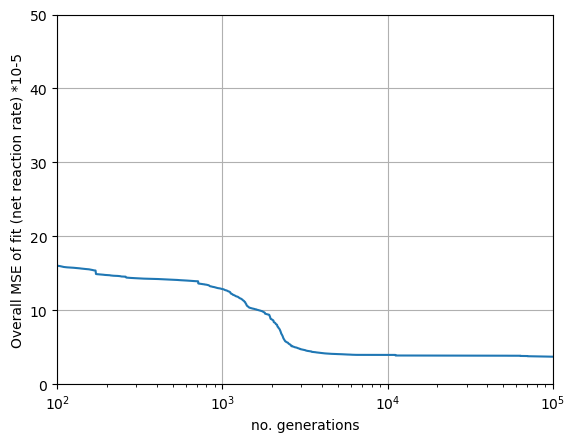

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.890086698677295
0.9385563525667092
0.2842099949289584
-5.22480767209916
0.669565863497511
0.2495087159314663
0.4694157232391059
-6.2507726182207595
0.4678957692668143
6.821461666390818
5.554855305043923
5.668937802661927
0.6390235826368003
0.030867464542695903
3.4702853773003426
0.03972053251097321
0.5938108876673056
-11.999999998434738
1.8505347498896803
1.5292628692458654
-9.90798134078029
0.5038789932123986
8.742182032789795
4.582430208994357
2.4227415410864284
11.999999985806868
0.02281740584277701
7.949308391192136
-8.763343205715644
3.066773958320537
1.8150787393844172
5.7592997090487295
-8.371865184848101
1.2827893559313266
1.6014621306467065
-1.301029978429626


In [37]:
res.X

array([ -7.8900867 ,   0.93855635,   0.28420999,  -5.22480767,
         0.66956586,   0.24950872,   0.46941572,  -6.25077262,
         0.46789577,   6.82146167,   5.55485531,   5.6689378 ,
         0.63902358,   0.03086746,   3.47028538,   0.03972053,
         0.59381089, -12.        ,   1.85053475,   1.52926287,
        -9.90798134,   0.50387899,   8.74218203,   4.58243021,
         2.42274154,  11.99999999,   0.02281741,   7.94930839,
        -8.76334321,   3.06677396,   1.81507874,   5.75929971,
        -8.37186518,   1.28278936,   1.60146213,  -1.30102998])

In [38]:
#Store to use in other notebook using the same current kernel
resX10=res.X
%store resX10

Stored 'resX10' (ndarray)


In [39]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [40]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -7.890086698677295
1.6: 0.9385563525667092
0.9: 0.2842099949289584
-4.3: -5.22480767209916
0.5: 0.669565863497511
0.003: 0.2495087159314663
0.4: 0.4694157232391059
-7.9: -6.2507726182207595
0.7: 0.4678957692668143
7.2: 6.821461666390818
5.7: 5.554855305043923
5.7: 5.668937802661927
0.8: 0.6390235826368003
0.03: 0.030867464542695903
3.1: 3.4702853773003426
6.000000000000001e-09: 0.03972053251097321
0.1: 0.5938108876673056
-12.0: -11.999999998434738
1.9: 1.8505347498896803
1.6: 1.5292628692458654
-11.6: -9.90798134078029
1.2: 0.5038789932123986
4.0: 8.742182032789795
0.01: 4.582430208994357
4.2: 2.4227415410864284
5.4: 11.999999985806868
2.2: 0.02281740584277701
11.8: 7.949308391192136
-12.0: -8.763343205715644
3.3: 3.066773958320537
1.8: 1.8150787393844172
4.2: 5.7592997090487295
-4.0: -8.371865184848101
0.5: 1.2827893559313266
1.0: 1.6014621306467065
coeff fit: 0.8385714195195186
r: 0.915735452802565
